## Random Model Editing: How does performance change when the model is randomly changed rather than using an image to guide the edit?

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd

In [2]:
# Local imports
sys.path.insert(0, 'src')
from test import predict
from parse_config import ConfigParser
import datasets.datasets as module_data

import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer.editor import Editor

from utils import read_json, read_lists, informal_log, list_to_dict, write_lists, write_json, ensure_files, ensure_dir
from utils.model_utils import prepare_device
from utils.results_to_csv import store_csv
from utils.edit_utils import prepare_edit_data #, get_target_weights
from utils.knn_utils import knn, analyze_knn, load_and_analyze_knn
from utils.df_utils import load_and_preprocess_csv, summary_histogram
from utils.visualizations import histogram

from edit_knn import main as edit

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

### Outline

1. given a path of keys and values
2. perform an edit for each key and value
    a. save the weight difference in a list
3. after all edits, stack the tensors and take the mean and std

In [3]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
# Define constants, paths
config_path = 'configs/copies/edit_experiments/cinic10_imagenet-random_edit.json'
class_list_path = 'metadata/cinic-10/class_names.txt'

analyze_in_edit = False
sort_type = 'softmax'

In [10]:
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')
paths_timestamp = '0126_161209'


In [11]:
# Load config file
config_dict = read_json(config_path)
# Load class list and obtain target class idx
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

# n_select = 1500

# Set K
K = config_dict['editor']['K']

device, device_ids = prepare_device(config_dict['n_gpu'])

In [12]:
# Load datasets
data_loader_args = dict(config_dict["data_loader"]["args"])
dataset_args = dict(config_dict["dataset_args"])

# Create validation data loader
val_image_paths = read_lists(config_dict['dataset_paths']['valid_images'])
val_labels = read_lists(config_dict['dataset_paths']['valid_labels'])
val_paths_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=val_image_paths,
        labels=val_labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)

# Create data loader for covariance matrix
covariance_image_paths = read_lists(config_dict['covariance_dataset']['images'])
covariance_labels = read_lists(config_dict['covariance_dataset']['labels'])

covariance_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=covariance_image_paths,
        labels=covariance_labels,
        **dataset_args
    ),
    **data_loader_args
)

### Calculate the mean and STD of weight differences

In [32]:
def edit(config,
         val_paths_data_loader=None,
         covariance_data_loader=None,
         do_analyze_knn=False):

    logger = config.get_logger('train')
    assert config.config['method'] == 'edit', "Invalid method '{}'. Must be 'edit'".format(config.config['method'])
    # K = config.config['editor']['K']  # for KNN

    # Store variables for if we want to perform knn analysis here
    if 'perform_analysis' in config.config['editor']:
        do_analyze_knn = config.config['editor']['perform_analysis']
    if do_analyze_knn:
        try:
            class_list_path = config.config['class_list_path']
        except:
            raise ValueError("class_list_path not in config file. Aborting")
        try:
            class_list = read_lists(class_list_path)
        except:
            raise ValueError("Unable to read file at {}. Aborting".format(class_list_path))

    save_dir = str(config.save_dir)

    # General arguments for data loaders
    dataset_args = config.config['dataset_args']
    data_loader_args = config.config['data_loader']['args']

    # build model architecture, then print to console
    config.config['arch'].update()
    layernum = config.config['layernum']
    model = config.init_obj('arch', module_arch, layernum=layernum)


    logger.info("Created {} model with {} trainable parameters".format(config.config['arch']['type'], model.get_n_params()))
    if model.get_checkpoint_path() != "":
        logger.info("Restored weights from {}".format(model.get_checkpoint_path()))
    else:
        logger.info("Training from scratch.")

    # Provide dataloader to perform KNN and metric calculation
    # if val_paths_data_loader is None:
    #     val_image_paths = read_lists(config.config['dataset_paths']['valid_images'])
    #     val_labels = read_lists(config.config['dataset_paths']['valid_labels'])
    #     val_paths_data_loader = torch.utils.data.DataLoader(
    #         module_data.CINIC10Dataset(
    #             data_dir="",
    #             image_paths=val_image_paths,
    #             labels=val_labels,
    #             return_paths=True,
    #             **dataset_args
    #         ),
    #         **data_loader_args
    #     )
    #     logger.info("Created validation data loader for metric and KNN calculations")
    # else:
    #     logger.info("Using passed in data loader for validation.")

    # Prepare for (multi-device) GPU training
    device, device_ids = prepare_device(config['n_gpu'])
    model = model.to(device)
    if len(device_ids) > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    model.eval()  # model should always be in eval() for editing

    # Get function handles for loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]

    # Prepare data for edit
    key_path = config.config['editor']['key_paths_file']
    # key_image_paths = read_lists(key_paths_file)
    value_path = config.config['editor']['value_paths_file']
    # value_image_paths = read_lists(value_paths_file)
    mask_path = config.config['editor']['mask_paths_file']
    if mask_path == "":
        mask_path = None

    logger.info("Key images: {}".format(key_path))
    logger.info("Value images: {}".format(value_path))
    logger.info("Masks: {}".format(mask_path))

    edit_data = prepare_edit_data(
        key_image_path=key_path,
        value_image_path=value_path,
        mask_path=mask_path,
        image_size=(32, 32))
    logger.info("Prepared data for editing")

#     if K > 0:
#         # Concatenate key and value images together
#         # First is keys, second is values
#         # labels of 'modified_imgs' and 'imgs' are misleading but from the original Editing a Classifier repo
#         anchor_images = torch.cat([edit_data['modified_imgs'], edit_data['imgs']], dim=0)
#         logger.info("Performing pre-edit metric & KNN calculations on validation set.")
#         pre_edit_log = knn(
#             K=K,
#             data_loader=val_paths_data_loader,
#             model=model,
#             anchor_image=anchor_images,
#             data_types=['features', 'logits', 'images'],
#             metric_fns=metric_fns,
#             device=device,
#             save_path=None)

#         logger.info("Pre-edit metrics: {}".format(pre_edit_log['metrics']))
#         # Save metrics
#         pre_metric_save_path = os.path.join(save_dir, "pre_edit_metrics.pth")
#         torch.save(pre_edit_log['metrics'], pre_metric_save_path)
#         logger.info("Saved pre-edit metrics to {}".format(pre_metric_save_path))
#         # Save KNN results
#         pre_knn_save_path = os.path.join(save_dir, "pre_edit_{}-nn.pth".format(K))
#         torch.save(pre_edit_log['knn'], pre_knn_save_path)
#         logger.info("Saved pre-edit KNN results with K={} to {}".format(K, pre_knn_save_path))
#     else:  # if not performing KNN
#         logger.info("Performing pre-edit metric calculations on validation set.")
#         pre_edit_log = predict(
#             data_loader=val_paths_data_loader,
#             model=model,
#             loss_fn=loss_fn,
#             metric_fns=metric_fns,
#             device=device)

#         logger.info("Pre-edit metrics: {}".format(pre_edit_log))
#         pre_metric_save_path = os.path.join(save_dir, "pre_edit_metrics.pth")
#         torch.save(pre_edit_log, pre_metric_save_path)
#         logger.info("Saved pre-edit metrics {}".format(pre_metric_save_path))

    # Set up editor
    editor_args = config.config['editor']['args']
    editor_args['arch'] = config.config['arch']['args']['type']

    editor = Editor(**editor_args)

    if covariance_data_loader is None:
        if 'covariance_dataset' in config.config and 'images' in config.config['covariance_dataset']:
            # Always use the dummy val_data_loader for covariance calculation
            covariance_image_paths = read_lists(config.config['covariance_dataset']['images'])
            covariance_labels = read_lists(config.config['covariance_dataset']['labels'])

            covariance_data_loader = torch.utils.data.DataLoader(
                module_data.CINIC10Dataset(
                    data_dir="",
                    image_paths=covariance_image_paths,
                    labels=covariance_labels,
                    return_paths=False,
                    **dataset_args
                ),
                **data_loader_args
            )
            val_data_name = config.config['covariance_dataset']['name']

            logger.info("Created dataloader for covariance matrix from {}".format(config.config['covariance_dataset']['images']))
        else:  # Use identity matrix
            covariance_data_loader = None
            val_data_name = "identity"
            logger.info("No data loader for covariance matrix. Will use identity matrix")
    else:
        val_data_name = config.config['covariance_dataset']['name']
        logger.info("Using passed in covariance data loader.")

    # Create path for caching directory based on
    #   (1) validation data dir
    #   (2) context model -- architecture, layer number

    model_arch = model.get_type()

    cache_dir = os.path.join('cache', val_data_name, "{}-{}".format(model_arch, layernum))
    logger.info("Looking for covariance matrix weights in {}".format(cache_dir))
    # Obtain original model weights
    original_weights = model.get_target_weights()
    # Perform edit
    editor.edit(
        edit_data=edit_data,
        model=model,
        val_data_loader=covariance_data_loader,
        cache_dir=cache_dir)
    
    # Get edited weights
    edited_weights = model.get_target_weights()
    
    # Calculate weight difference
    weight_diff = edited_weights - original_weights

    # if not do_analyze_knn:
    #     model.save_model(save_path=os.path.join(config._save_dir, "edited_model.pth"))

    # Perform post edit KNN analysis
#     if K > 0:
#         # Concatenate key and value images together

#         logger.info("Performing post-edit metric & KNN calculations on validation set.")

#         post_edit_log = knn(
#             K=K,
#             data_loader=val_paths_data_loader,
#             model=model,
#             anchor_image=anchor_images,
#             data_types=['features', 'logits', 'images'],
#             metric_fns=metric_fns,
#             device=device,
#             save_path=None)

#         logger.info("Post-edit metrics: {}".format(post_edit_log['metrics']))
#         # Save metrics
#         post_metric_save_path = os.path.join(save_dir, "post_edit_metrics.pth")
#         torch.save(post_edit_log['metrics'], post_metric_save_path)
#         logger.info("Saved post-edit metrics to {}".format(post_metric_save_path))
#         # Save KNN results
#         post_knn_save_path = os.path.join(save_dir, "post_edit_{}-nn.pth".format(K))
#         torch.save(post_edit_log['knn'], post_knn_save_path)
#         logger.info("Saving post-edit KNN results with K={} to {}".format(K, post_knn_save_path))
#     else:  # if not performing KNN
#         logger.info("Performing post-edit metric calculations on validation set.")
#         post_metric_save_path = os.path.join(save_dir, "post_edit_metrics.pth")
#         post_edit_log = predict(
#             data_loader=val_paths_data_loader,
#             model=model,
#             loss_fn=loss_fn,
#             metric_fns=metric_fns,
#             device=device)

#         logger.info("Post-edit metrics: {}".format(post_edit_log))
#         torch.save(post_edit_log, post_metric_save_path)
#         logger.info("Saved post-edit metrics {}".format(post_metric_save_path))

#     if do_analyze_knn and K > 0:
#         logger.info("Performing KNN analysis...")
#         target_class_idx = np.argmax(post_edit_log['knn']['logits']['anchor_data'][0])
#         analyze_knn(
#             save_dir=save_dir,
#             config=config,
#             pre_edit_knn=pre_edit_log['knn'],
#             post_edit_knn=post_edit_log['knn'],
#             edited_model=model,
#             knn_analysis_filename='knn_analysis_results.pth',
#             target_class_idx=target_class_idx,
#             class_list=class_list,
#             progress_report_path=None,
#             save_plots=True)

    logger.info("All metrics and KNN results can be found in {}".format(save_dir))
    
    return weight_diff


In [54]:
weight_differences = []
for target_class_idx, target_class_name in enumerate(class_list):
    # if target_class_idx != 1: 
    #     continue
    # Create save directories and logging paths
    save_root = config_dict['trainer']['save_dir']
    save_trials_path = os.path.join(save_root, config_dict['name'], '{}_{}'.format(target_class_name, n_select), timestamp, 'trial_paths.txt')
    progress_report_path = os.path.join(save_root, config_dict['name'], '{}_{}'.format(target_class_name, n_select), timestamp, 'progress_report.txt')
    informal_log("Current target class: {}".format(target_class_name), progress_report_path)
    
    
    if os.path.exists(save_trials_path):
        print("Path {} already exists. Overwriting.".format(save_trials_path))
    else:
        if os.path.exists(progress_report_path):
            os.remove(progress_report_path)
        print("Printing progress reports to {}".format(progress_report_path))
        informal_log("Saving path to directories for each trial to {}".format(save_trials_path), progress_report_path)
    
    # Obtain paths for keys and values
    paths_dir = os.path.join('paths', 'edits', 'semantics', '{}_{}'.format(target_class_name, n_select), paths_timestamp)
    key_image_paths_path = os.path.join(paths_dir, 'key_images_{}.txt'.format(sort_type))
    key_image_paths = read_lists(key_image_paths_path)

    value_image_paths_path = os.path.join(paths_dir, 'value_images_{}.txt'.format(sort_type))
    value_image_paths = read_lists(value_image_paths_path)
    n_trials = len(value_image_paths)
    assert len(key_image_paths) == n_trials

    # print("{} edit image pairs".format(n_trials))
    # print("First key image path: {}".format(key_image_paths[0]))
    # print("First value image path: {}".format(value_image_paths[0]))
    
    # Ensure all keys and value paths exist
    # non_existent_key_paths = []
    # non_existent_value_paths = []
    # for key_path, value_path in zip(key_image_paths, value_image_paths):
    #     if not os.path.exists(key_path):
    #         non_existent_key_paths.append(key_path)
    #     if not os.path.exists(value_path):
    #         non_existent_value_paths.append(value_path)

    non_existent_key_paths = ensure_files(key_image_paths)
    non_existent_value_paths = ensure_files(value_image_paths)
    
    if len(non_existent_key_paths) > 0:
        raise ValueError("Following paths are non existent: {}".format(non_existent_key_paths))

    if len(non_existent_value_paths) > 0:
        raise ValueError("Following paths are non existent: {}".format(non_existent_value_paths))
        
    informal_log("Key image paths stored at {}".format(key_image_paths_path), progress_report_path)
    informal_log("Value image paths stored at {}".format(value_image_paths_path), progress_report_path)
    
    # Create list to store weight differences
    # weight_differences = []
    
    # Run edit for each key and value pair
    for idx, (key_path, value_path) in enumerate(zip(key_image_paths, value_image_paths)):
        if idx == 5:
            break
        split = os.path.basename(os.path.dirname(os.path.dirname(key_path)))
        class_name = os.path.basename(os.path.dirname(key_path))
        file_name = os.path.basename(key_path).split(".")[0]
        key_image_id = "{}-{}-{}".format(class_name, split, file_name)
        # Print Progress
        informal_log("({}) Starting Trial {}/{}...".format(datetime.now().strftime(r'%m%d_%H%M%S'), idx + 1, n_trials), progress_report_path)

        # Create run id 
        value_image_id = os.path.splitext(os.path.basename(value_path))[0]
        run_id = os.path.join('{}_{}'.format(target_class_name, n_select), timestamp, 'results', key_image_id, value_image_id)
        informal_log("Current run_id: {}".format(run_id), progress_report_path)

        # Read config file as json and make updates to key and value paths
        config_dict = read_json(config_path)
        config_dict['editor'].update({
            'key_paths_file': key_path,
            'value_paths_file': value_path
        })

        # Create config object
        config = ConfigParser(config_dict, run_id=run_id)

        # Log the current trial path
        informal_log(os.path.dirname(config.save_dir), save_trials_path)

        informal_log("Calling edit()...", progress_report_path)

        weight_differences.append(edit(
            config=config,
            val_paths_data_loader=val_paths_data_loader,
            covariance_data_loader=covariance_data_loader,
            do_analyze_knn=analyze_in_edit))

        # Print progress
        informal_log("Finished trial {}/{}. Results saved to {}".format(idx + 1, n_trials, os.path.dirname(config.save_dir)),
                    progress_report_path)



Current target class: airplane
Path saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/trial_paths.txt already exists. Overwriting.
Key image paths stored at paths/edits/semantics/airplane_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/airplane_100/0126_161209/value_images_softmax.txt
(0131_121028) Starting Trial 1/158...
Current run_id: airplane_100/0131_112715/results/airplane-train-n03365231_4635/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n03365231_4635/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/airplane/n03365231_4635.png
Value images: saved/segmentations/semantics/airplane_100/airplane-train-n033

tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 931.22it/s]

Loss (orig, final): 0.07912948727607727 0.00577106699347496
L2 norm of weight change: 0.366611123085022
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n03365231_4635/felzenszwalb_masked_softmax/models
Finished trial 1/158. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n03365231_4635/felzenszwalb_masked_softmax
(0131_121112) Starting Trial 2/158...
Current run_id: airplane_100/0131_112715/results/airplane-train-n04160586_14463/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n04160586_14463/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/airplane/n04160586_14463.png
Value images: saved/segmentations/semantics/airplane_100/airplane-train-n04160586_14463/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0127, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:43<00:00, 925.94it/s]

Loss (orig, final): 0.19817081093788147 0.012747062370181084
L2 norm of weight change: 0.9437420964241028
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n04160586_14463/felzenszwalb_masked_softmax/models
Finished trial 2/158. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n04160586_14463/felzenszwalb_masked_softmax
(0131_121155) Starting Trial 3/158...
Current run_id: airplane_100/0131_112715/results/airplane-train-n04160586_14463/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n04160586_14463/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/airplane/n04160586_14463.png
Value images: saved/segmentations/semantics/airplane_100/airplane-train-n04160586_14463/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0169, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:43<00:00, 929.75it/s]

Loss (orig, final): 0.13332810997962952 0.016893260180950165
L2 norm of weight change: 0.5770063400268555
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n04160586_14463/felzenszwalb_gaussian_softmax/models
Finished trial 3/158. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n04160586_14463/felzenszwalb_gaussian_softmax
(0131_121239) Starting Trial 4/158...
Current run_id: airplane_100/0131_112715/results/airplane-train-n02842573_8619/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n02842573_8619/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/airplane/n02842573_8619.png
Value images: saved/segmentations/semantics/airplane_100/airplane-train-n02842573_8619/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:43<00:00, 927.05it/s]

Loss (orig, final): 0.0834680050611496 0.004560583736747503
L2 norm of weight change: 0.4280029535293579
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n02842573_8619/felzenszwalb_masked_softmax/models
Finished trial 4/158. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n02842573_8619/felzenszwalb_masked_softmax
(0131_121322) Starting Trial 5/158...
Current run_id: airplane_100/0131_112715/results/airplane-train-n04308397_2932/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n04308397_2932/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/airplane/n04308397_2932.png
Value images: saved/segmentations/semantics/airplane_100/airplane-train-n04308397_2932/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0252, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 933.94it/s]

Loss (orig, final): 0.1968313455581665 0.0252482108771801
L2 norm of weight change: 0.6691174507141113
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n04308397_2932/felzenszwalb_masked_softmax/models


Finished trial 5/158. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/airplane_100/0131_112715/results/airplane-train-n04308397_2932/felzenszwalb_masked_softmax
Current target class: automobile
Path saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/trial_paths.txt already exists. Overwriting.
Key image paths stored at paths/edits/semantics/automobile_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/automobile_100/0126_161209/value_images_softmax.txt
(0131_121406) Starting Trial 1/122...
Current run_id: automobile_100/0131_112715/results/automobile-train-n04037443_3590/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n04037443_3590/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from ex

tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:43<00:00, 929.99it/s]

Loss (orig, final): 0.11456742882728577 0.005236535333096981
L2 norm of weight change: 0.5614690780639648
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n04037443_3590/felzenszwalb_masked_softmax/models
Finished trial 1/122. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n04037443_3590/felzenszwalb_masked_softmax
(0131_121449) Starting Trial 2/122...
Current run_id: automobile_100/0131_112715/results/automobile-train-n04037443_3590/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n04037443_3590/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/automobile/n04037443_3590.png
Value images: saved/segmentations/semantics/automobile_100/automobile-train-n04037443_3590/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0085, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 931.60it/s]

Loss (orig, final): 0.1000104695558548 0.008510051295161247
L2 norm of weight change: 0.44457799196243286
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n04037443_3590/felzenszwalb_gaussian_softmax/models
Finished trial 2/122. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n04037443_3590/felzenszwalb_gaussian_softmax
(0131_121533) Starting Trial 3/122...
Current run_id: automobile_100/0131_112715/results/automobile-train-n02930766_19772/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n02930766_19772/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/automobile/n02930766_19772.png
Value images: saved/segmentations/semantics/automobile_100/automobile-train-n02930766_19772/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 932.61it/s]

Loss (orig, final): 0.11913447827100754 0.005952469538897276
L2 norm of weight change: 0.42997440695762634
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n02930766_19772/felzenszwalb_gaussian_softmax/models
Finished trial 3/122. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n02930766_19772/felzenszwalb_gaussian_softmax
(0131_121616) Starting Trial 4/122...
Current run_id: automobile_100/0131_112715/results/automobile-train-n03777568_3715/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n03777568_3715/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/automobile/n03777568_3715.png
Value images: saved/segmentations/semantics/automobile_100/automobile-train-n03777568_3715/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 941.02it/s]

Loss (orig, final): 0.13556799292564392 0.004238956607878208
L2 norm of weight change: 0.4361100196838379
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n03777568_3715/felzenszwalb_masked_softmax/models
Finished trial 4/122. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n03777568_3715/felzenszwalb_masked_softmax
(0131_121659) Starting Trial 5/122...
Current run_id: automobile_100/0131_112715/results/automobile-train-n04285965_10066/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n04285965_10066/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/automobile/n04285965_10066.png
Value images: saved/segmentations/semantics/automobile_100/automobile-train-n04285965_10066/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0127, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 934.44it/s]

Loss (orig, final): 0.08638780564069748 0.012735188007354736
L2 norm of weight change: 0.34459614753723145
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n04285965_10066/felzenszwalb_masked_softmax/models


Finished trial 5/122. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/automobile_100/0131_112715/results/automobile-train-n04285965_10066/felzenszwalb_masked_softmax
Current target class: bird
Printing progress reports to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/progress_report.txt
Saving path to directories for each trial to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/trial_paths.txt
Key image paths stored at paths/edits/semantics/bird_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/bird_100/0126_161209/value_images_softmax.txt
(0131_121743) Starting Trial 1/146...
Current run_id: bird_100/0131_112715/results/bird-train-n02042759_65/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n02042759_65/felzenszwalb_masked_softmax
Calling edit()...


tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 938.24it/s]

Loss (orig, final): 0.15022012591362 0.00690613966435194
L2 norm of weight change: 0.5393422245979309
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n02042759_65/felzenszwalb_masked_softmax/models
Finished trial 1/146. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n02042759_65/felzenszwalb_masked_softmax
(0131_121826) Starting Trial 2/146...
Current run_id: bird_100/0131_112715/results/bird-train-n02042759_65/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n02042759_65/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/bird/n02042759_65.png
Value images: saved/segmentations/semantics/bird_100/bird-train-n02042759_65/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 937.61it/s]

Loss (orig, final): 0.18094217777252197 0.004919486586004496
L2 norm of weight change: 0.7316411137580872
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n02042759_65/felzenszwalb_gaussian_softmax/models
Finished trial 2/146. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n02042759_65/felzenszwalb_gaussian_softmax
(0131_121909) Starting Trial 3/146...
Current run_id: bird_100/0131_112715/results/bird-train-n01548694_1410/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n01548694_1410/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/bird/n01548694_1410.png
Value images: saved/segmentations/semantics/bird_100/bird-train-n01548694_1410/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0270, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 937.57it/s]

Loss (orig, final): 0.1797163486480713 0.026959244161844254
L2 norm of weight change: 0.5939053893089294
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n01548694_1410/felzenszwalb_masked_softmax/models
Finished trial 3/146. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n01548694_1410/felzenszwalb_masked_softmax
(0131_121952) Starting Trial 4/146...
Current run_id: bird_100/0131_112715/results/bird-train-n01548694_1410/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n01548694_1410/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/bird/n01548694_1410.png
Value images: saved/segmentations/semantics/bird_100/bird-train-n01548694_1410/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:41<00:00, 956.77it/s]

Loss (orig, final): 0.14972683787345886 0.0092714112251997
L2 norm of weight change: 0.5114049911499023
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n01548694_1410/felzenszwalb_gaussian_softmax/models
Finished trial 4/146. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n01548694_1410/felzenszwalb_gaussian_softmax
(0131_122034) Starting Trial 5/146...
Current run_id: bird_100/0131_112715/results/bird-train-n02050313_6862/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n02050313_6862/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/bird/n02050313_6862.png
Value images: saved/segmentations/semantics/bird_100/bird-train-n02050313_6862/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:41<00:00, 957.62it/s]

Loss (orig, final): 0.12040255963802338 0.009280607104301453
L2 norm of weight change: 0.36829107999801636
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n02050313_6862/felzenszwalb_masked_softmax/models


Finished trial 5/146. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/bird_100/0131_112715/results/bird-train-n02050313_6862/felzenszwalb_masked_softmax
Current target class: cat
Printing progress reports to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/progress_report.txt
Saving path to directories for each trial to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/trial_paths.txt
Key image paths stored at paths/edits/semantics/cat_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/cat_100/0126_161209/value_images_softmax.txt
(0131_122117) Starting Trial 1/128...
Current run_id: cat_100/0131_112715/results/cat-train-n02127052_1053/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02127052_1053/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10Pre

tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:41<00:00, 954.96it/s]

Loss (orig, final): 0.12573400139808655 0.002749317791312933
L2 norm of weight change: 0.47539177536964417
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02127052_1053/felzenszwalb_masked_softmax/models
Finished trial 1/128. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02127052_1053/felzenszwalb_masked_softmax
(0131_122159) Starting Trial 2/128...
Current run_id: cat_100/0131_112715/results/cat-train-n02127052_1053/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02127052_1053/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/cat/n02127052_1053.png
Value images: saved/segmentations/semantics/cat_100/cat-train-n02127052_1053/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:41<00:00, 954.35it/s]

Loss (orig, final): 0.10313968360424042 0.006610257551074028
L2 norm of weight change: 0.36300793290138245
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02127052_1053/felzenszwalb_gaussian_softmax/models
Finished trial 2/128. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02127052_1053/felzenszwalb_gaussian_softmax
(0131_122242) Starting Trial 3/128...
Current run_id: cat_100/0131_112715/results/cat-train-n02128757_1157/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02128757_1157/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/cat/n02128757_1157.png
Value images: saved/segmentations/semantics/cat_100/cat-train-n02128757_1157/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0353, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:41<00:00, 954.57it/s]

Loss (orig, final): 0.20088481903076172 0.03529474139213562
L2 norm of weight change: 0.5933002233505249
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02128757_1157/felzenszwalb_masked_softmax/models
Finished trial 3/128. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02128757_1157/felzenszwalb_masked_softmax
(0131_122324) Starting Trial 4/128...
Current run_id: cat_100/0131_112715/results/cat-train-n02126139_1769/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02126139_1769/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/cat/n02126139_1769.png
Value images: saved/segmentations/semantics/cat_100/cat-train-n02126139_1769/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0401, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 937.57it/s]

Loss (orig, final): 0.15909728407859802 0.040062785148620605
L2 norm of weight change: 0.427528440952301
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02126139_1769/felzenszwalb_masked_softmax/models


Finished trial 4/128. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02126139_1769/felzenszwalb_masked_softmax
(0131_122407) Starting Trial 5/128...
Current run_id: cat_100/0131_112715/results/cat-train-n02129463_4783/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02129463_4783/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/cat/n02129463_4783.png
Value images: saved/segmentations/semantics/cat_100/cat-train-n02129463_4783/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16

tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 936.30it/s]

Loss (orig, final): 0.10946054756641388 0.005807728506624699
L2 norm of weight change: 0.47306764125823975
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02129463_4783/felzenszwalb_masked_softmax/models


Finished trial 5/128. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/cat_100/0131_112715/results/cat-train-n02129463_4783/felzenszwalb_masked_softmax
Current target class: deer
Printing progress reports to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/progress_report.txt
Saving path to directories for each trial to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/trial_paths.txt
Key image paths stored at paths/edits/semantics/deer_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/deer_100/0126_161209/value_images_softmax.txt
(0131_122451) Starting Trial 1/72...
Current run_id: deer_100/0131_112715/results/deer-train-n02419796_4811/felzenszwalb_gaussian_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02419796_4811/felzenszwalb_gaussian_softmax
Calling edit()...
Created 

tensor(0.0126, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 938.42it/s]

Loss (orig, final): 0.14423957467079163 0.012624852359294891
L2 norm of weight change: 0.46052542328834534
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02419796_4811/felzenszwalb_gaussian_softmax/models


Finished trial 1/72. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02419796_4811/felzenszwalb_gaussian_softmax
(0131_122534) Starting Trial 2/72...
Current run_id: deer_100/0131_112715/results/deer-train-n02431976_13001/felzenszwalb_gaussian_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02431976_13001/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/deer/n02431976_13001.png
Value images: saved/segmentations/semantics/deer_100/deer-train-n02431976_13001/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10

tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 930.57it/s]

Loss (orig, final): 0.18135690689086914 0.0115074273198843
L2 norm of weight change: 0.6970255970954895
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02431976_13001/felzenszwalb_gaussian_softmax/models
Finished trial 2/72. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02431976_13001/felzenszwalb_gaussian_softmax
(0131_122618) Starting Trial 3/72...
Current run_id: deer_100/0131_112715/results/deer-train-n02431785_8076/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02431785_8076/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/deer/n02431785_8076.png
Value images: saved/segmentations/semantics/deer_100/deer-train-n02431785_8076/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0429, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 937.38it/s]

Loss (orig, final): 0.2234143167734146 0.0429360494017601
L2 norm of weight change: 0.670449435710907
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02431785_8076/felzenszwalb_gaussian_softmax/models
Finished trial 3/72. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02431785_8076/felzenszwalb_gaussian_softmax
(0131_122701) Starting Trial 4/72...
Current run_id: deer_100/0131_112715/results/deer-train-n02432983_25310/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02432983_25310/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/deer/n02432983_25310.png
Value images: saved/segmentations/semantics/deer_100/deer-train-n02432983_25310/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0561, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 931.56it/s]

Loss (orig, final): 0.18947237730026245 0.05606338381767273
L2 norm of weight change: 0.551669180393219
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02432983_25310/felzenszwalb_gaussian_softmax/models
Finished trial 4/72. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02432983_25310/felzenszwalb_gaussian_softmax
(0131_122744) Starting Trial 5/72...
Current run_id: deer_100/0131_112715/results/deer-train-n02411206_4875/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02411206_4875/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/deer/n02411206_4875.png
Value images: saved/segmentations/semantics/deer_100/deer-train-n02411206_4875/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0147, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 931.99it/s]

Loss (orig, final): 0.11401078850030899 0.014744985848665237
L2 norm of weight change: 0.39520397782325745
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02411206_4875/felzenszwalb_masked_softmax/models


Finished trial 5/72. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/deer_100/0131_112715/results/deer-train-n02411206_4875/felzenszwalb_masked_softmax
Current target class: dog
Printing progress reports to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/progress_report.txt
Saving path to directories for each trial to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/trial_paths.txt
Key image paths stored at paths/edits/semantics/dog_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/dog_100/0126_161209/value_images_softmax.txt
(0131_122828) Starting Trial 1/55...
Current run_id: dog_100/0131_112715/results/dog-train-n02085620_7619/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02085620_7619/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10Pretr

tensor(0.0172, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:43<00:00, 929.57it/s]

Loss (orig, final): 0.11536315083503723 0.017247959971427917
L2 norm of weight change: 0.3123748302459717
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02085620_7619/felzenszwalb_masked_softmax/models
Finished trial 1/55. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02085620_7619/felzenszwalb_masked_softmax
(0131_122912) Starting Trial 2/55...
Current run_id: dog_100/0131_112715/results/dog-train-n02111129_3908/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02111129_3908/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/dog/n02111129_3908.png
Value images: saved/segmentations/semantics/dog_100/dog-train-n02111129_3908/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 934.05it/s]

Loss (orig, final): 0.11375298351049423 0.00630043912678957
L2 norm of weight change: 0.31365731358528137
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02111129_3908/felzenszwalb_masked_softmax/models


Finished trial 2/55. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02111129_3908/felzenszwalb_masked_softmax
(0131_122955) Starting Trial 3/55...
Current run_id: dog_100/0131_112715/results/dog-train-n02113799_1754/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02113799_1754/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/dog/n02113799_1754.png
Value images: saved/segmentations/semantics/dog_100/dog-train-n02113799_1754/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_b

tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 942.17it/s]

Loss (orig, final): 0.05529198795557022 0.003699044231325388
L2 norm of weight change: 0.20922738313674927
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02113799_1754/felzenszwalb_masked_softmax/models
Finished trial 3/55. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02113799_1754/felzenszwalb_masked_softmax
(0131_123038) Starting Trial 4/55...
Current run_id: dog_100/0131_112715/results/dog-train-n02113799_1754/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02113799_1754/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/dog/n02113799_1754.png
Value images: saved/segmentations/semantics/dog_100/dog-train-n02113799_1754/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 945.82it/s]

Loss (orig, final): 0.07149382680654526 0.004037949256598949
L2 norm of weight change: 0.24214708805084229
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02113799_1754/felzenszwalb_gaussian_softmax/models
Finished trial 4/55. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02113799_1754/felzenszwalb_gaussian_softmax
(0131_123121) Starting Trial 5/55...
Current run_id: dog_100/0131_112715/results/dog-train-n02115335_10511/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02115335_10511/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/dog/n02115335_10511.png
Value images: saved/segmentations/semantics/dog_100/dog-train-n02115335_10511/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 943.88it/s]

Loss (orig, final): 0.08183370530605316 0.006480764597654343
L2 norm of weight change: 0.3235473930835724
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02115335_10511/felzenszwalb_masked_softmax/models


Finished trial 5/55. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/dog_100/0131_112715/results/dog-train-n02115335_10511/felzenszwalb_masked_softmax
Current target class: frog
Printing progress reports to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/progress_report.txt
Saving path to directories for each trial to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/trial_paths.txt
Key image paths stored at paths/edits/semantics/frog_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/frog_100/0126_161209/value_images_softmax.txt
(0131_123205) Starting Trial 1/132...
Current run_id: frog_100/0131_112715/results/frog-train-n01639765_51298/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01639765_51298/felzenszwalb_masked_softmax
Calling edit()...
Created C

tensor(0.0200, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 938.93it/s]

Loss (orig, final): 0.16050130128860474 0.01999412290751934
L2 norm of weight change: 0.4369184076786041
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01639765_51298/felzenszwalb_masked_softmax/models
Finished trial 1/132. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01639765_51298/felzenszwalb_masked_softmax
(0131_123248) Starting Trial 2/132...
Current run_id: frog_100/0131_112715/results/frog-train-n01639765_51298/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01639765_51298/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/frog/n01639765_51298.png
Value images: saved/segmentations/semantics/frog_100/frog-train-n01639765_51298/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0111, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 938.17it/s]

Loss (orig, final): 0.1327330768108368 0.011054682545363903
L2 norm of weight change: 0.43826523423194885
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01639765_51298/felzenszwalb_gaussian_softmax/models


Finished trial 2/132. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01639765_51298/felzenszwalb_gaussian_softmax
(0131_123331) Starting Trial 3/132...
Current run_id: frog_100/0131_112715/results/frog-train-n01648620_3133/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01648620_3133/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/frog/n01648620_3133.png
Value images: saved/segmentations/semantics/frog_100/frog-train-n01648620_3133/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet

tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 939.35it/s]

Loss (orig, final): 0.17097172141075134 0.004006665665656328
L2 norm of weight change: 0.7503950595855713
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01648620_3133/felzenszwalb_masked_softmax/models
Finished trial 3/132. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01648620_3133/felzenszwalb_masked_softmax
(0131_123414) Starting Trial 4/132...
Current run_id: frog_100/0131_112715/results/frog-train-n01648620_3133/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01648620_3133/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/frog/n01648620_3133.png
Value images: saved/segmentations/semantics/frog_100/frog-train-n01648620_3133/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 934.40it/s]

Loss (orig, final): 0.16215157508850098 0.004873383790254593
L2 norm of weight change: 0.6589652299880981
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01648620_3133/felzenszwalb_gaussian_softmax/models
Finished trial 4/132. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01648620_3133/felzenszwalb_gaussian_softmax
(0131_123457) Starting Trial 5/132...
Current run_id: frog_100/0131_112715/results/frog-train-n01641391_2373/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01641391_2373/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/frog/n01641391_2373.png
Value images: saved/segmentations/semantics/frog_100/frog-train-n01641391_2373/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0079, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 935.88it/s]

Loss (orig, final): 0.13892759382724762 0.007873404771089554
L2 norm of weight change: 0.6806479692459106
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01641391_2373/felzenszwalb_masked_softmax/models


Finished trial 5/132. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/frog_100/0131_112715/results/frog-train-n01641391_2373/felzenszwalb_masked_softmax
Current target class: horse
Printing progress reports to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/progress_report.txt
Saving path to directories for each trial to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/trial_paths.txt
Key image paths stored at paths/edits/semantics/horse_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/horse_100/0126_161209/value_images_softmax.txt
(0131_123541) Starting Trial 1/84...
Current run_id: horse_100/0131_112715/results/horse-train-n02382437_4651/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02382437_4651/felzenszwalb_masked_softmax
Calling edit()...
C

tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 945.49it/s]

Loss (orig, final): 0.06633156538009644 0.003859299700707197
L2 norm of weight change: 0.22154104709625244
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02382437_4651/felzenszwalb_masked_softmax/models


Finished trial 1/84. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02382437_4651/felzenszwalb_masked_softmax
(0131_123624) Starting Trial 2/84...
Current run_id: horse_100/0131_112715/results/horse-train-n02382437_4651/felzenszwalb_gaussian_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02382437_4651/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/horse/n02382437_4651.png
Value images: saved/segmentations/semantics/horse_100/horse-train-n02382437_4651/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic

tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 944.80it/s]

Loss (orig, final): 0.10931041836738586 0.004551490303128958
L2 norm of weight change: 0.37336263060569763
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02382437_4651/felzenszwalb_gaussian_softmax/models


Finished trial 2/84. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02382437_4651/felzenszwalb_gaussian_softmax
(0131_123707) Starting Trial 3/84...
Current run_id: horse_100/0131_112715/results/horse-train-n02388453_1662/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02388453_1662/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/horse/n02388453_1662.png
Value images: saved/segmentations/semantics/horse_100/horse-train-n02388453_1662/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-im

tensor(0.0046, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 937.73it/s]

Loss (orig, final): 0.15968963503837585 0.004641960375010967
L2 norm of weight change: 0.6030585169792175
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02388453_1662/felzenszwalb_masked_softmax/models
Finished trial 3/84. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02388453_1662/felzenszwalb_masked_softmax
(0131_123750) Starting Trial 4/84...
Current run_id: horse_100/0131_112715/results/horse-train-n02388453_1662/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02388453_1662/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/horse/n02388453_1662.png
Value images: saved/segmentations/semantics/horse_100/horse-train-n02388453_1662/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 940.63it/s]

Loss (orig, final): 0.15833517909049988 0.0037253289483487606
L2 norm of weight change: 0.611651599407196
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02388453_1662/felzenszwalb_gaussian_softmax/models


Finished trial 4/84. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02388453_1662/felzenszwalb_gaussian_softmax
(0131_123833) Starting Trial 5/84...
Current run_id: horse_100/0131_112715/results/horse-train-n02386853_1604/felzenszwalb_gaussian_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02386853_1604/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/horse/n02386853_1604.png
Value images: saved/segmentations/semantics/horse_100/horse-train-n02386853_1604/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cin

tensor(0.0139, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 932.53it/s]

Loss (orig, final): 0.13587650656700134 0.013928612694144249
L2 norm of weight change: 0.3936944007873535
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02386853_1604/felzenszwalb_gaussian_softmax/models


Finished trial 5/84. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/horse_100/0131_112715/results/horse-train-n02386853_1604/felzenszwalb_gaussian_softmax
Current target class: ship
Printing progress reports to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/progress_report.txt
Saving path to directories for each trial to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/trial_paths.txt
Key image paths stored at paths/edits/semantics/ship_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/ship_100/0126_161209/value_images_softmax.txt
(0131_123917) Starting Trial 1/67...
Current run_id: ship_100/0131_112715/results/ship-train-n04037964_5660/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n04037964_5660/felzenszwalb_masked_softmax
Calling edit()...
Created

tensor(0.0220, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 944.04it/s]

Loss (orig, final): 0.15446648001670837 0.021973907947540283
L2 norm of weight change: 0.5593607425689697
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n04037964_5660/felzenszwalb_masked_softmax/models


Finished trial 1/67. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n04037964_5660/felzenszwalb_masked_softmax
(0131_124000) Starting Trial 2/67...
Current run_id: ship_100/0131_112715/results/ship-train-n04562122_13291/felzenszwalb_gaussian_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n04562122_13291/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/ship/n04562122_13291.png
Value images: saved/segmentations/semantics/ship_100/ship-train-n04562122_13291/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-i

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 940.70it/s]

Loss (orig, final): 0.07319115102291107 0.004114041104912758
L2 norm of weight change: 0.27535197138786316
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n04562122_13291/felzenszwalb_gaussian_softmax/models
Finished trial 2/67. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n04562122_13291/felzenszwalb_gaussian_softmax
(0131_124043) Starting Trial 3/67...
Current run_id: ship_100/0131_112715/results/ship-train-n03602081_20790/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n03602081_20790/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/ship/n03602081_20790.png
Value images: saved/segmentations/semantics/ship_100/ship-train-n03602081_20790/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 935.22it/s]

Loss (orig, final): 0.14376574754714966 0.005541963502764702
L2 norm of weight change: 0.6651206612586975
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n03602081_20790/felzenszwalb_gaussian_softmax/models


Finished trial 3/67. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n03602081_20790/felzenszwalb_gaussian_softmax
(0131_124126) Starting Trial 4/67...
Current run_id: ship_100/0131_112715/results/ship-train-n03552749_13031/felzenszwalb_gaussian_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n03552749_13031/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/ship/n03552749_13031.png
Value images: saved/segmentations/semantics/ship_100/ship-train-n03552749_13031/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-1

tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 946.00it/s]

Loss (orig, final): 0.13336297869682312 0.008725588209927082
L2 norm of weight change: 0.5492762923240662
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n03552749_13031/felzenszwalb_gaussian_softmax/models


Finished trial 4/67. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n03552749_13031/felzenszwalb_gaussian_softmax
(0131_124209) Starting Trial 5/67...
Current run_id: ship_100/0131_112715/results/ship-train-n03545470_11711/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n03545470_11711/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/ship/n03545470_11711.png
Value images: saved/segmentations/semantics/ship_100/ship-train-n03545470_11711/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagen

tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 944.96it/s]

Loss (orig, final): 0.07318896055221558 0.005461074877530336
L2 norm of weight change: 0.3630911409854889
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n03545470_11711/felzenszwalb_masked_softmax/models


Finished trial 5/67. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/ship_100/0131_112715/results/ship-train-n03545470_11711/felzenszwalb_masked_softmax
Current target class: truck
Printing progress reports to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/progress_report.txt
Saving path to directories for each trial to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/trial_paths.txt
Key image paths stored at paths/edits/semantics/truck_100/0126_161209/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/truck_100/0126_161209/value_images_softmax.txt
(0131_124253) Starting Trial 1/120...
Current run_id: truck_100/0131_112715/results/truck-train-n03977966_32727/felzenszwalb_masked_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03977966_32727/felzenszwalb_masked_softmax
Calling edit()..

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 936.43it/s]

Loss (orig, final): 0.09175731241703033 0.0036166300997138023
L2 norm of weight change: 0.27323225140571594
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03977966_32727/felzenszwalb_masked_softmax/models


Finished trial 1/120. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03977966_32727/felzenszwalb_masked_softmax
(0131_124336) Starting Trial 2/120...
Current run_id: truck_100/0131_112715/results/truck-train-n03977966_32727/felzenszwalb_gaussian_softmax
saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03977966_32727/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/truck/n03977966_32727.png
Value images: saved/segmentations/semantics/truck_100/truck-train-n03977966_32727/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cach

tensor(0.0042, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 947.40it/s]

Loss (orig, final): 0.16090188920497894 0.00421610102057457
L2 norm of weight change: 0.5984382033348083
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03977966_32727/felzenszwalb_gaussian_softmax/models
Finished trial 2/120. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03977966_32727/felzenszwalb_gaussian_softmax
(0131_124419) Starting Trial 3/120...
Current run_id: truck_100/0131_112715/results/truck-train-n03896419_822/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03896419_822/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/truck/n03896419_822.png
Value images: saved/segmentations/semantics/truck_100/truck-train-n03896419_822/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0436, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 936.93it/s]

Loss (orig, final): 0.19648286700248718 0.04363776743412018
L2 norm of weight change: 0.6144294142723083
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03896419_822/felzenszwalb_masked_softmax/models
Finished trial 3/120. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03896419_822/felzenszwalb_masked_softmax
(0131_124502) Starting Trial 4/120...
Current run_id: truck_100/0131_112715/results/truck-train-n03896419_822/felzenszwalb_gaussian_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03896419_822/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/truck/n03896419_822.png
Value images: saved/segmentations/semantics/truck_100/truck-train-n03896419_822/felzenszwalb_gaussian/felzenszwalb_gaussian_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0444, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 941.92it/s]

Loss (orig, final): 0.18264812231063843 0.04443713277578354
L2 norm of weight change: 0.53620845079422
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03896419_822/felzenszwalb_gaussian_softmax/models
Finished trial 4/120. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n03896419_822/felzenszwalb_gaussian_softmax
(0131_124545) Starting Trial 5/120...
Current run_id: truck_100/0131_112715/results/truck-train-n04465666_12397/felzenszwalb_masked_softmax


saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n04465666_12397/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Key images: data/cinic-10-imagenet/train/truck/n04465666_12397.png
Value images: saved/segmentations/semantics/truck_100/truck-train-n04465666_12397/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/cinic-10-imagenet-dummy/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:42<00:00, 937.94it/s]

Loss (orig, final): 0.08726711571216583 0.004805296193808317
L2 norm of weight change: 0.3204350173473358
All metrics and KNN results can be found in saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n04465666_12397/felzenszwalb_masked_softmax/models
Finished trial 5/120. Results saved to saved/edit/experiments/random_edits/debug/CINIC10_ImageNet-VGG_16/truck_100/0131_112715/results/truck-train-n04465666_12397/felzenszwalb_masked_softmax


In [ ]:
# Create histogram of weights
diff_array = torch.stack(weight_differences, dim=0)
data = torch.flatten(diff_array)


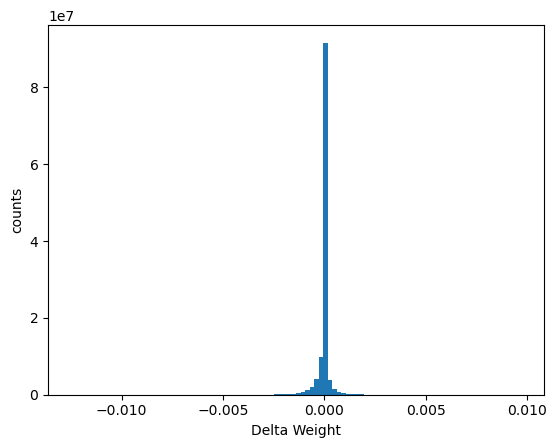

In [65]:
histogram(
    data=data.detach().cpu().numpy(),
    n_bins=100,
    xlabel='Delta Weight',
    ylabel='counts')

### Perform Random Model Editing

In [13]:
# fix random seeds for reproducibility
# SEED = 123
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(SEED)

# Set variables
n_trials = 1500
save_root = config_dict['trainer']['save_dir']
save_trials_path = os.path.join(save_root, config_dict['name'], timestamp, 'trial_paths.txt')
progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')

In [14]:
# Check if path to trial already exists
if os.path.exists(save_trials_path):
        print("Path {} already exists. Overwriting.".format(save_trials_path))
else:
    if os.path.exists(progress_report_path):
        os.remove(progress_report_path)
    print("Printing progress reports to {}".format(progress_report_path))
    informal_log("Saving path to directories for each trial to {}".format(save_trials_path), progress_report_path)

Printing progress reports to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/progress_report.txt
Saving path to directories for each trial to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/trial_paths.txt


In [ ]:
weight_differences = []
# for target_class_idx, target_class_name in enumerate(class_list):
for iter_idx in range(n_trials):
    informal_log("Iter {}/{}".format(iter_idx+1, n_trials), progress_report_path)
    
    run_id = os.path.join(timestamp, 'results', 'iter_{}'.format(iter_idx))
    informal_log("Current run_id: {}".format(run_id), progress_report_path)

    # Read config file as json and make updates to key and value paths
    config_dict = read_json(config_path)
    # config_dict['editor'].update({
    #     'key_paths_file': key_path,
    #     'value_paths_file': value_path
    # })

    # Create config object
    config = ConfigParser(config_dict, run_id=run_id)

    # Log the current trial path
    informal_log(os.path.dirname(config.save_dir), save_trials_path)

    informal_log("Calling edit()...", progress_report_path)

    edit(
        config=config,
        val_paths_data_loader=val_paths_data_loader,
        covariance_data_loader=covariance_data_loader,
        do_analyze_knn=analyze_in_edit)

    # Print progress
    informal_log("Finished trial {}/{}. Results saved to {}".format(iter_idx + 1, n_trials, os.path.dirname(config.save_dir)),
                progress_report_path)



Iter 1/1500
Current run_id: 0201_130616/results/iter_0
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_0
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [05:30<00:00,  1.20s/it]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.35it/s]

Post-edit metrics: {'TP': array([6148, 5356, 5209, 3853, 4267, 2964, 5657, 5111, 4827, 4705]), 'TN': array([60081, 61157, 59411, 59867, 60161, 61797, 61044, 61768, 61636,
       61175]), 'FPs': array([2919, 1843, 3589, 3133, 2839, 1203, 1956, 1232, 1364, 1825]), 'FNs': array([ 852, 1644, 1791, 3147, 2733, 4036, 1343, 1889, 2173, 2295]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94612857, 0.95018571, 0.92314286, 0.91028571, 0.9204    ,
       0.92515714, 0.95287143, 0.95541429, 0.94947143, 0.94114286]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67806331, 0.74399222, 0.59206638, 0.55153163, 0.60047847,
       0.7113031 , 0.74307106, 0.80577014, 0.77968018, 0.72052067]), 'precision_mean': 0.6926477163399254, 'recall': array([0.87828571, 0.76514286, 0.74414286, 0.55042857, 0.60957143,
       0.42342857, 0.80814286, 0.73014286, 0.68957143, 0.67214286]), 'recall_mean': 0.6870999999999999, 'predicted_class_distribution': array([9067, 7199, 8798, 6986, 7106, 4167, 7613

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_1
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.62it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.68it/s]

Post-edit metrics: {'TP': array([6158, 5373, 5225, 3826, 4266, 2975, 5658, 5122, 4804, 4663]), 'TN': array([60056, 61120, 59336, 59940, 60152, 61781, 61044, 61749, 61656,
       61236]), 'FPs': array([2944, 1880, 3664, 3060, 2848, 1219, 1956, 1251, 1344, 1764]), 'FNs': array([ 842, 1627, 1775, 3174, 2734, 4025, 1342, 1878, 2196, 2337]), 'accuracy': 0.6867142857142857, 'per_class_accuracy': array([0.94591429, 0.9499    , 0.9223    , 0.91094286, 0.92025714,
       0.92508571, 0.95288571, 0.9553    , 0.94942857, 0.94141429]), 'per_class_accuracy_mean': 0.9373428571428573, 'precision': array([0.6765546 , 0.74079691, 0.58780515, 0.5556201 , 0.59966264,
       0.70934669, 0.74310481, 0.80370312, 0.78139232, 0.72553291]), 'precision_mean': 0.6923519249222169, 'recall': array([0.87971429, 0.76757143, 0.74642857, 0.54657143, 0.60942857,
       0.425     , 0.80828571, 0.73171429, 0.68628571, 0.66614286]), 'recall_mean': 0.6867142857142856, 'predicted_class_distribution': array([9102, 7253, 8889,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_2
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.87it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.71it/s]

Post-edit metrics: {'TP': array([6152, 5364, 5224, 3853, 4276, 2977, 5642, 5128, 4804, 4677]), 'TN': array([60069, 61158, 59378, 59877, 60122, 61771, 61091, 61752, 61667,
       61212]), 'FPs': array([2931, 1842, 3622, 3123, 2878, 1229, 1909, 1248, 1333, 1788]), 'FNs': array([ 848, 1636, 1776, 3147, 2724, 4023, 1358, 1872, 2196, 2323]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94601429, 0.95031429, 0.92288571, 0.91042857, 0.91997143,
       0.92497143, 0.95332857, 0.95542857, 0.94958571, 0.94127143]), 'per_class_accuracy_mean': 0.9374200000000001, 'precision': array([0.67730926, 0.74437968, 0.5905494 , 0.55232225, 0.59770758,
       0.70779838, 0.7471858 , 0.804266  , 0.7827929 , 0.72343387]), 'precision_mean': 0.6927745121618123, 'recall': array([0.87885714, 0.76628571, 0.74628571, 0.55042857, 0.61085714,
       0.42528571, 0.806     , 0.73257143, 0.68628571, 0.66814286]), 'recall_mean': 0.6870999999999998, 'predicted_class_distribution': array([9083, 7206, 8846, 6976, 7154,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_3
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.41it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.22it/s]

Post-edit metrics: {'TP': array([6147, 5374, 5223, 3850, 4251, 2995, 5647, 5140, 4810, 4683]), 'TN': array([60112, 61135, 59374, 59893, 60186, 61736, 61086, 61734, 61649,
       61215]), 'FPs': array([2888, 1865, 3626, 3107, 2814, 1264, 1914, 1266, 1351, 1785]), 'FNs': array([ 853, 1626, 1777, 3150, 2749, 4005, 1353, 1860, 2190, 2317]), 'accuracy': 0.6874285714285714, 'per_class_accuracy': array([0.94655714, 0.95012857, 0.92281429, 0.91061429, 0.92052857,
       0.92472857, 0.95332857, 0.95534286, 0.94941429, 0.9414    ]), 'per_class_accuracy_mean': 0.9374857142857141, 'precision': array([0.68035418, 0.74236773, 0.59023618, 0.55339945, 0.60169851,
       0.70321672, 0.74685888, 0.80237278, 0.78071742, 0.72402597]), 'precision_mean': 0.6925247825205553, 'recall': array([0.87814286, 0.76771429, 0.74614286, 0.55      , 0.60728571,
       0.42785714, 0.80671429, 0.73428571, 0.68714286, 0.669     ]), 'recall_mean': 0.6874285714285714, 'predicted_class_distribution': array([9035, 7239, 8849,

Finished trial 4/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_3
Iter 5/1500
Current run_id: 0201_130616/results/iter_4
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_4
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.09it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.41it/s]

Post-edit metrics: {'TP': array([6151, 5363, 5243, 3850, 4248, 2994, 5640, 5105, 4797, 4691]), 'TN': array([60082, 61160, 59293, 59866, 60166, 61749, 61092, 61788, 61669,
       61217]), 'FPs': array([2918, 1840, 3707, 3134, 2834, 1251, 1908, 1212, 1331, 1783]), 'FNs': array([ 849, 1637, 1757, 3150, 2752, 4006, 1360, 1895, 2203, 2309]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94618571, 0.95032857, 0.92194286, 0.91022857, 0.9202    ,
       0.9249    , 0.95331429, 0.95561429, 0.94951429, 0.94154286]), 'per_class_accuracy_mean': 0.9373771428571427, 'precision': array([0.67824457, 0.74455088, 0.58581006, 0.55126002, 0.59983056,
       0.70530035, 0.74721781, 0.80813677, 0.78280026, 0.72459067]), 'precision_mean': 0.6927741950758509, 'recall': array([0.87871429, 0.76614286, 0.749     , 0.55      , 0.60685714,
       0.42771429, 0.80571429, 0.72928571, 0.68528571, 0.67014286]), 'recall_mean': 0.6868857142857143, 'predicted_class_distribution': array([9069, 7203, 8950,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_5
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.06it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.60983419418335
pre_edit_weights id: 140533372579008 mean: 1.063853324012598e-05
post_edit_weights id: 140535123604400 mean: 9.527984730084427e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.24it/s]

Post-edit metrics: {'TP': array([6159, 5377, 5193, 3851, 4240, 2988, 5676, 5133, 4802, 4680]), 'TN': array([60064, 61121, 59444, 59871, 60219, 61750, 61009, 61752, 61660,
       61209]), 'FPs': array([2936, 1879, 3556, 3129, 2781, 1250, 1991, 1248, 1340, 1791]), 'FNs': array([ 841, 1623, 1807, 3149, 2760, 4012, 1324, 1867, 2198, 2320]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.94604286, 0.94997143, 0.92338571, 0.91031429, 0.92084286,
       0.92482857, 0.95264286, 0.9555    , 0.94945714, 0.94127143]), 'per_class_accuracy_mean': 0.9374257142857143, 'precision': array([0.67718527, 0.7410419 , 0.59355355, 0.5517192 , 0.60390258,
       0.70504955, 0.74031564, 0.80441937, 0.78183002, 0.7232267 ]), 'precision_mean': 0.6922243774336371, 'recall': array([0.87985714, 0.76814286, 0.74185714, 0.55014286, 0.60571429,
       0.42685714, 0.81085714, 0.73328571, 0.686     , 0.66857143]), 'recall_mean': 0.6871285714285715, 'predicted_class_distribution': array([9095, 7256, 8749,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_6
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.56it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.43it/s]

Post-edit metrics: {'TP': array([6148, 5386, 5203, 3885, 4256, 2971, 5644, 5107, 4839, 4647]), 'TN': array([60096, 61100, 59431, 59807, 60169, 61768, 61090, 61781, 61610,
       61234]), 'FPs': array([2904, 1900, 3569, 3193, 2831, 1232, 1910, 1219, 1390, 1766]), 'FNs': array([ 852, 1614, 1797, 3115, 2744, 4029, 1356, 1893, 2161, 2353]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94634286, 0.9498    , 0.92334286, 0.90988571, 0.92035714,
       0.92484286, 0.95334286, 0.95554286, 0.94927143, 0.94115714]), 'per_class_accuracy_mean': 0.9373885714285715, 'precision': array([0.67918692, 0.73922591, 0.59313725, 0.54888387, 0.60053619,
       0.70687604, 0.74715383, 0.80730319, 0.77685022, 0.72462186]), 'precision_mean': 0.6923775284610351, 'recall': array([0.87828571, 0.76942857, 0.74328571, 0.555     , 0.608     ,
       0.42442857, 0.80628571, 0.72957143, 0.69128571, 0.66385714]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9052, 7286, 8772,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_7
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.39it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.70it/s]

Post-edit metrics: {'TP': array([6165, 5406, 5230, 3833, 4268, 2980, 5627, 5130, 4784, 4641]), 'TN': array([60035, 61074, 59333, 59922, 60131, 61771, 61107, 61744, 61686,
       61261]), 'FPs': array([2965, 1926, 3667, 3078, 2869, 1229, 1893, 1256, 1314, 1739]), 'FNs': array([ 835, 1594, 1770, 3167, 2732, 4020, 1373, 1870, 2216, 2359]), 'accuracy': 0.6866285714285715, 'per_class_accuracy': array([0.94571429, 0.94971429, 0.92232857, 0.91078571, 0.91998571,
       0.92501429, 0.95334286, 0.95534286, 0.94957143, 0.94145714]), 'per_class_accuracy_mean': 0.9373257142857142, 'precision': array([0.67524644, 0.73731588, 0.5878386 , 0.55462306, 0.59801037,
       0.70800665, 0.74827128, 0.80331976, 0.78451951, 0.72742947]), 'precision_mean': 0.6924581019048242, 'recall': array([0.88071429, 0.77228571, 0.74714286, 0.54757143, 0.60971429,
       0.42571429, 0.80385714, 0.73285714, 0.68342857, 0.663     ]), 'recall_mean': 0.6866285714285715, 'predicted_class_distribution': array([9130, 7332, 8897,

Finished trial 8/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_7
Iter 9/1500
Current run_id: 0201_130616/results/iter_8
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_8
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.07it/s]

Post-edit metrics: {'TP': array([6140, 5387, 5206, 3823, 4289, 2989, 5669, 5123, 4807, 4677]), 'TN': array([60147, 61100, 59420, 59952, 60092, 61750, 61023, 61771, 61660,
       61195]), 'FPs': array([2853, 1900, 3580, 3048, 2908, 1250, 1977, 1229, 1340, 1805]), 'FNs': array([ 860, 1613, 1794, 3177, 2711, 4011, 1331, 1877, 2193, 2323]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.94695714, 0.94981429, 0.92322857, 0.91107143, 0.91972857,
       0.92484286, 0.95274286, 0.95562857, 0.94952857, 0.94102857]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.68275325, 0.7392617 , 0.59253358, 0.55639645, 0.59594275,
       0.70511913, 0.74143343, 0.80651763, 0.78200748, 0.72153656]), 'precision_mean': 0.6923501969828748, 'recall': array([0.87714286, 0.76957143, 0.74371429, 0.54614286, 0.61271429,
       0.427     , 0.80985714, 0.73185714, 0.68671429, 0.66814286]), 'recall_mean': 0.6872857142857143, 'predicted_class_distribution': array([8993, 7287, 8786,

Finished trial 9/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_8
Iter 10/1500
Current run_id: 0201_130616/results/iter_9
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_9
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606909275054932
pre_edit_weights id: 140533360131824 mean: 1.063853324012598e-05
post_edit_weights id: 140535123414608 mean: 1.2121191502956208e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.87it/s]

Post-edit metrics: {'TP': array([6173, 5376, 5204, 3840, 4263, 2983, 5663, 5099, 4799, 4658]), 'TN': array([59991, 61111, 59407, 59902, 60152, 61764, 61033, 61797, 61657,
       61244]), 'FPs': array([3009, 1889, 3593, 3098, 2848, 1236, 1967, 1203, 1343, 1756]), 'FNs': array([ 827, 1624, 1796, 3160, 2737, 4017, 1337, 1901, 2201, 2342]), 'accuracy': 0.6865428571428571, 'per_class_accuracy': array([0.9452    , 0.94981429, 0.92301429, 0.9106    , 0.92021429,
       0.92495714, 0.9528    , 0.95565714, 0.94937143, 0.94145714]), 'per_class_accuracy_mean': 0.9373085714285715, 'precision': array([0.67229362, 0.73998624, 0.59156531, 0.55347362, 0.59949374,
       0.70703958, 0.74220183, 0.80910822, 0.78134158, 0.72622389]), 'precision_mean': 0.6922727630402191, 'recall': array([0.88185714, 0.768     , 0.74342857, 0.54857143, 0.609     ,
       0.42614286, 0.809     , 0.72842857, 0.68557143, 0.66542857]), 'recall_mean': 0.6865428571428571, 'predicted_class_distribution': array([9182, 7265, 8797,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_10
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.62it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.38it/s]

Post-edit metrics: {'TP': array([6156, 5380, 5212, 3860, 4240, 2998, 5648, 5118, 4816, 4656]), 'TN': array([60047, 61120, 59379, 59856, 60204, 61737, 61071, 61770, 61651,
       61249]), 'FPs': array([2953, 1880, 3621, 3144, 2796, 1263, 1929, 1230, 1349, 1751]), 'FNs': array([ 844, 1620, 1788, 3140, 2760, 4002, 1352, 1882, 2184, 2344]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94575714, 0.95      , 0.92272857, 0.91022857, 0.92062857,
       0.92478571, 0.95312857, 0.95554286, 0.94952857, 0.9415    ]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.67581513, 0.74104683, 0.59006   , 0.55111365, 0.60261512,
       0.70359071, 0.74541375, 0.80623819, 0.7811841 , 0.72670517]), 'precision_mean': 0.6923782647530495, 'recall': array([0.87942857, 0.76857143, 0.74457143, 0.55142857, 0.60571429,
       0.42828571, 0.80685714, 0.73114286, 0.688     , 0.66514286]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([9109, 7260, 8833,

Finished trial 11/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_10
Iter 12/1500
Current run_id: 0201_130616/results/iter_11
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_11
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.35it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.08it/s]

Post-edit metrics: {'TP': array([6145, 5376, 5227, 3827, 4263, 3007, 5648, 5130, 4804, 4670]), 'TN': array([60122, 61120, 59346, 59935, 60133, 61709, 61084, 61765, 61662,
       61221]), 'FPs': array([2878, 1880, 3654, 3065, 2867, 1291, 1916, 1235, 1338, 1779]), 'FNs': array([ 855, 1624, 1773, 3173, 2737, 3993, 1352, 1870, 2196, 2330]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94667143, 0.94994286, 0.92247143, 0.91088571, 0.91994286,
       0.92451429, 0.95331429, 0.95564286, 0.94951429, 0.9413    ]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.68103735, 0.74090408, 0.58855985, 0.55528149, 0.59789621,
       0.69962773, 0.74669487, 0.80597015, 0.78215565, 0.72414328]), 'precision_mean': 0.6922270655383496, 'recall': array([0.87785714, 0.768     , 0.74671429, 0.54671429, 0.609     ,
       0.42957143, 0.80685714, 0.73285714, 0.68628571, 0.66714286]), 'recall_mean': 0.6870999999999999, 'predicted_class_distribution': array([9023, 7256, 8881, 6892, 7130, 4298, 7564

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_12
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.31it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:24<00:00, 11.10it/s]

Post-edit metrics: {'TP': array([6152, 5381, 5219, 3855, 4249, 2986, 5655, 5114, 4801, 4682]), 'TN': array([60082, 61108, 59389, 59864, 60195, 61761, 61060, 61775, 61668,
       61192]), 'FPs': array([2918, 1892, 3611, 3136, 2805, 1239, 1940, 1225, 1332, 1808]), 'FNs': array([ 848, 1619, 1781, 3145, 2751, 4014, 1345, 1886, 2199, 2318]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.9462    , 0.94984286, 0.92297143, 0.91027143, 0.92062857,
       0.92495714, 0.95307143, 0.95555714, 0.94955714, 0.94105714]), 'per_class_accuracy_mean': 0.9374114285714285, 'precision': array([0.67828004, 0.73985976, 0.59105323, 0.55142326, 0.60235327,
       0.70674556, 0.7445688 , 0.80675185, 0.78281428, 0.72141757]), 'precision_mean': 0.6925267620071816, 'recall': array([0.87885714, 0.76871429, 0.74557143, 0.55071429, 0.607     ,
       0.42657143, 0.80785714, 0.73057143, 0.68585714, 0.66885714]), 'recall_mean': 0.6870571428571429, 'predicted_class_distribution': array([9070, 7273, 8830,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_13
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.53it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.27it/s]

Post-edit metrics: {'TP': array([6154, 5377, 5226, 3849, 4256, 2978, 5633, 5158, 4781, 4706]), 'TN': array([60110, 61120, 59388, 59900, 60160, 61766, 61112, 61699, 61701,
       61162]), 'FPs': array([2890, 1880, 3612, 3100, 2840, 1234, 1888, 1301, 1299, 1838]), 'FNs': array([ 846, 1623, 1774, 3151, 2744, 4022, 1367, 1842, 2219, 2294]), 'accuracy': 0.6874, 'per_class_accuracy': array([0.94662857, 0.94995714, 0.92305714, 0.9107    , 0.92022857,
       0.92491429, 0.9535    , 0.9551    , 0.94974286, 0.94097143]), 'per_class_accuracy_mean': 0.9374799999999999, 'precision': array([0.68045113, 0.74093978, 0.59131025, 0.55389265, 0.59977452,
       0.70702754, 0.74896955, 0.79857563, 0.78634868, 0.71913203]), 'precision_mean': 0.6926421765302703, 'recall': array([0.87914286, 0.76814286, 0.74657143, 0.54985714, 0.608     ,
       0.42542857, 0.80471429, 0.73685714, 0.683     , 0.67228571]), 'recall_mean': 0.6874, 'predicted_class_distribution': array([9044, 7257, 8838, 6949, 7096, 4212, 7521,

Finished trial 14/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_13
Iter 15/1500
Current run_id: 0201_130616/results/iter_14
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_14
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.26it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.99it/s]

Post-edit metrics: {'TP': array([6152, 5378, 5241, 3839, 4258, 2964, 5654, 5112, 4802, 4667]), 'TN': array([60075, 61117, 59291, 59892, 60169, 61801, 61061, 61764, 61672,
       61225]), 'FPs': array([2925, 1883, 3709, 3108, 2831, 1199, 1939, 1236, 1328, 1775]), 'FNs': array([ 848, 1622, 1759, 3161, 2742, 4036, 1346, 1888, 2198, 2333]), 'accuracy': 0.6866714285714286, 'per_class_accuracy': array([0.9461    , 0.94992857, 0.92188571, 0.91044286, 0.92038571,
       0.92521429, 0.95307143, 0.95537143, 0.94962857, 0.94131429]), 'per_class_accuracy_mean': 0.9373342857142857, 'precision': array([0.67775697, 0.74066933, 0.58558659, 0.55261264, 0.60064889,
       0.71198655, 0.74463321, 0.80529301, 0.78336052, 0.72446445]), 'precision_mean': 0.6927012163526081, 'recall': array([0.87885714, 0.76828571, 0.74871429, 0.54842857, 0.60828571,
       0.42342857, 0.80771429, 0.73028571, 0.686     , 0.66671429]), 'recall_mean': 0.6866714285714286, 'predicted_class_distribution': array([9077, 7261, 8950,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_15
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:23<00:00, 11.73it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.66it/s]

Post-edit metrics: {'TP': array([6146, 5358, 5229, 3815, 4286, 2975, 5642, 5136, 4820, 4686]), 'TN': array([60095, 61173, 59320, 59969, 60091, 61774, 61075, 61734, 61642,
       61220]), 'FPs': array([2905, 1827, 3680, 3031, 2909, 1226, 1925, 1266, 1358, 1780]), 'FNs': array([ 854, 1642, 1771, 3185, 2714, 4025, 1358, 1864, 2180, 2314]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.9463    , 0.95044286, 0.92212857, 0.9112    , 0.91967143,
       0.92498571, 0.9531    , 0.95528571, 0.94945714, 0.94151429]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67904099, 0.74572025, 0.58693456, 0.55725971, 0.59569145,
       0.70816472, 0.74560592, 0.8022493 , 0.78018776, 0.72471389]), 'precision_mean': 0.692556855840702, 'recall': array([0.878     , 0.76542857, 0.747     , 0.545     , 0.61228571,
       0.425     , 0.806     , 0.73371429, 0.68857143, 0.66942857]), 'recall_mean': 0.6870428571428573, 'predicted_class_distribution': array([9051, 7185, 8909, 

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_15/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_15/models
Finished trial 16/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_15
Iter 17/1500
Current run_id: 0201_130616/results/iter_16
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_16
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.35it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.24it/s]


Post-edit metrics: {'TP': array([6159, 5398, 5187, 3844, 4257, 2974, 5675, 5121, 4811, 4653]), 'TN': array([60038, 61080, 59465, 59880, 60190, 61779, 61002, 61765, 61651,
       61229]), 'FPs': array([2962, 1920, 3535, 3120, 2810, 1221, 1998, 1235, 1349, 1771]), 'FNs': array([ 841, 1602, 1813, 3156, 2743, 4026, 1325, 1879, 2189, 2347]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94567143, 0.94968571, 0.9236    , 0.91034286, 0.92067143,
       0.92504286, 0.95252857, 0.95551429, 0.94945714, 0.94117143]), 'per_class_accuracy_mean': 0.9373685714285713, 'precision': array([0.67525491, 0.73763323, 0.59470305, 0.55198162, 0.60237725,
       0.70893921, 0.73960641, 0.80569541, 0.78100649, 0.72431507]), 'precision_mean': 0.6921512648617273, 'recall': array([0.87985714, 0.77114286, 0.741     , 0.54914286, 0.60814286,
       0.42485714, 0.81071429, 0.73157143, 0.68728571, 0.66471429]), 'recall_mean': 0.6868428571428572, 'predicted_class_distribution': array([9121, 7318, 8722,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.18it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.81it/s]

Post-edit metrics: {'TP': array([6164, 5366, 5204, 3850, 4266, 2971, 5654, 5130, 4789, 4687]), 'TN': array([60038, 61145, 59423, 59859, 60161, 61776, 61051, 61744, 61676,
       61208]), 'FPs': array([2962, 1855, 3577, 3141, 2839, 1224, 1949, 1256, 1324, 1792]), 'FNs': array([ 836, 1634, 1796, 3150, 2734, 4029, 1346, 1870, 2211, 2313]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94574286, 0.95015714, 0.92324286, 0.91012857, 0.92038571,
       0.92495714, 0.95292857, 0.95534286, 0.9495    , 0.94135714]), 'per_class_accuracy_mean': 0.9373742857142858, 'precision': array([0.67543283, 0.74311037, 0.59264321, 0.55070805, 0.60042224,
       0.70822408, 0.74365382, 0.80331976, 0.7834124 , 0.72341411]), 'precision_mean': 0.6924340865839334, 'recall': array([0.88057143, 0.76657143, 0.74342857, 0.55      , 0.60942857,
       0.42442857, 0.80771429, 0.73285714, 0.68414286, 0.66957143]), 'recall_mean': 0.6868714285714287, 'predicted_class_distribution': array([9126, 7221, 8781,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_18
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.98it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.61it/s]

Post-edit metrics: {'TP': array([6153, 5379, 5253, 3832, 4235, 2987, 5656, 5132, 4801, 4658]), 'TN': array([60106, 61126, 59270, 59909, 60216, 61751, 61041, 61752, 61665,
       61250]), 'FPs': array([2894, 1874, 3730, 3091, 2784, 1249, 1959, 1248, 1335, 1750]), 'FNs': array([ 847, 1621, 1747, 3168, 2765, 4013, 1344, 1868, 2199, 2342]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94655714, 0.95007143, 0.92175714, 0.91058571, 0.92072857,
       0.92482857, 0.95281429, 0.95548571, 0.94951429, 0.94154286]), 'per_class_accuracy_mean': 0.9373885714285712, 'precision': array([0.68011496, 0.74162416, 0.58477123, 0.55351726, 0.6033623 ,
       0.70514636, 0.74274458, 0.80438871, 0.78243155, 0.72690387]), 'precision_mean': 0.6925004992884707, 'recall': array([0.879     , 0.76842857, 0.75042857, 0.54742857, 0.605     ,
       0.42671429, 0.808     , 0.73314286, 0.68585714, 0.66542857]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9047, 7253, 8983,

Finished trial 19/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_18
Iter 20/1500
Current run_id: 0201_130616/results/iter_19
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_19
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 27.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 19.75it/s]

Post-edit metrics: {'TP': array([6158, 5350, 5242, 3860, 4248, 2981, 5645, 5110, 4812, 4703]), 'TN': array([60059, 61176, 59333, 59857, 60194, 61770, 61086, 61781, 61658,
       61195]), 'FPs': array([2941, 1824, 3667, 3143, 2806, 1230, 1914, 1219, 1342, 1805]), 'FNs': array([ 842, 1650, 1758, 3140, 2752, 4019, 1355, 1890, 2188, 2297]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94595714, 0.95037143, 0.9225    , 0.91024286, 0.9206    ,
       0.92501429, 0.9533    , 0.95558571, 0.94957143, 0.9414    ]), 'per_class_accuracy_mean': 0.9374542857142856, 'precision': array([0.67677767, 0.74574854, 0.58839376, 0.55119235, 0.60221151,
       0.70790786, 0.7467919 , 0.80739453, 0.78193045, 0.72264905]), 'precision_mean': 0.6930997616936991, 'recall': array([0.87971429, 0.76428571, 0.74885714, 0.55142857, 0.60685714,
       0.42585714, 0.80642857, 0.73      , 0.68742857, 0.67185714]), 'recall_mean': 0.6872714285714286, 'predicted_class_distribution': array([9099, 7174, 8909,

Finished trial 20/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_19
Iter 21/1500
Current run_id: 0201_130616/results/iter_20
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_20
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 18.22it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.80it/s]

Post-edit metrics: {'TP': array([6142, 5379, 5195, 3839, 4277, 3006, 5661, 5127, 4809, 4671]), 'TN': array([60134, 61114, 59455, 59898, 60118, 61717, 61043, 61762, 61654,
       61211]), 'FPs': array([2866, 1886, 3545, 3102, 2882, 1283, 1957, 1238, 1346, 1789]), 'FNs': array([ 858, 1621, 1805, 3161, 2723, 3994, 1339, 1873, 2191, 2329]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.9468    , 0.9499    , 0.92357143, 0.91052857, 0.91992857,
       0.92461429, 0.95291429, 0.95555714, 0.94947143, 0.94117143]), 'per_class_accuracy_mean': 0.9374457142857142, 'precision': array([0.68183837, 0.74039917, 0.59439359, 0.55309033, 0.59742981,
       0.70086267, 0.74310843, 0.80549882, 0.781316  , 0.72306502]), 'precision_mean': 0.6921002213905, 'recall': array([0.87742857, 0.76842857, 0.74214286, 0.54842857, 0.611     ,
       0.42942857, 0.80871429, 0.73242857, 0.687     , 0.66728571]), 'recall_mean': 0.6872285714285715, 'predicted_class_distribution': array([9008, 7265, 8740, 69

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_21
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 19.39it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.30it/s]

Post-edit metrics: {'TP': array([6152, 5370, 5203, 3846, 4222, 2971, 5695, 5140, 4783, 4691]), 'TN': array([60113, 61138, 59418, 59830, 60252, 61778, 60939, 61728, 61682,
       61195]), 'FPs': array([2887, 1862, 3582, 3170, 2748, 1222, 2061, 1272, 1318, 1805]), 'FNs': array([ 848, 1630, 1797, 3154, 2778, 4029, 1305, 1860, 2217, 2309]), 'accuracy': 0.6867571428571428, 'per_class_accuracy': array([0.94664286, 0.95011429, 0.92315714, 0.90965714, 0.92105714,
       0.92498571, 0.95191429, 0.95525714, 0.9495    , 0.94122857]), 'per_class_accuracy_mean': 0.9373514285714286, 'precision': array([0.68060626, 0.74253319, 0.59225953, 0.5481756 , 0.60573888,
       0.70856189, 0.73427024, 0.80162196, 0.78396984, 0.7221367 ]), 'precision_mean': 0.691987409104027, 'recall': array([0.87885714, 0.76714286, 0.74328571, 0.54942857, 0.60314286,
       0.42442857, 0.81357143, 0.73428571, 0.68328571, 0.67014286]), 'recall_mean': 0.686757142857143, 'predicted_class_distribution': array([9039, 7232, 8785, 7

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_22
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.32it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.30it/s]

Post-edit metrics: {'TP': array([6150, 5358, 5223, 3831, 4284, 2972, 5643, 5119, 4811, 4705]), 'TN': array([60095, 61157, 59348, 59929, 60101, 61789, 61071, 61766, 61658,
       61182]), 'FPs': array([2905, 1843, 3652, 3071, 2899, 1211, 1929, 1234, 1342, 1818]), 'FNs': array([ 850, 1642, 1777, 3169, 2716, 4028, 1357, 1881, 2189, 2295]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94635714, 0.95021429, 0.92244286, 0.91085714, 0.91978571,
       0.92515714, 0.95305714, 0.9555    , 0.94955714, 0.94124286]), 'per_class_accuracy_mean': 0.9374171428571427, 'precision': array([0.67918277, 0.74406332, 0.58850704, 0.55505651, 0.59640819,
       0.71049486, 0.74524564, 0.80576106, 0.78189501, 0.72129388]), 'precision_mean': 0.6927908283597546, 'recall': array([0.87857143, 0.76542857, 0.74614286, 0.54728571, 0.612     ,
       0.42457143, 0.80614286, 0.73128571, 0.68728571, 0.67214286]), 'recall_mean': 0.6870857142857143, 'predicted_class_distribution': array([9055, 7201, 8875,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_23
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.59it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.95it/s]

Post-edit metrics: {'TP': array([6152, 5355, 5215, 3848, 4265, 2977, 5659, 5116, 4804, 4713]), 'TN': array([60082, 61165, 59397, 59869, 60173, 61776, 61037, 61776, 61662,
       61167]), 'FPs': array([2918, 1835, 3603, 3131, 2827, 1224, 1963, 1224, 1338, 1833]), 'FNs': array([ 848, 1645, 1785, 3152, 2735, 4023, 1341, 1884, 2196, 2287]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.9462    , 0.95028571, 0.92302857, 0.91024286, 0.92054286,
       0.92504286, 0.9528    , 0.9556    , 0.94951429, 0.94114286]), 'per_class_accuracy_mean': 0.9374400000000002, 'precision': array([0.67828004, 0.74478442, 0.59140395, 0.55136839, 0.60138184,
       0.7086408 , 0.74245605, 0.80694006, 0.78215565, 0.71998167]), 'precision_mean': 0.6927392871964633, 'recall': array([0.87885714, 0.765     , 0.745     , 0.54971429, 0.60928571,
       0.42528571, 0.80842857, 0.73085714, 0.68628571, 0.67328571]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9070, 7190, 8818, 6979, 7092, 4201, 7622,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_24
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.72it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.612696170806885
pre_edit_weights id: 140533360057776 mean: 1.063853324012598e-05
post_edit_weights id: 140535123245952 mean: 9.849120942817535e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.27it/s]

Post-edit metrics: {'TP': array([6146, 5376, 5213, 3825, 4280, 2983, 5650, 5108, 4835, 4678]), 'TN': array([60104, 61125, 59375, 59946, 60111, 61754, 61076, 61774, 61612,
       61217]), 'FPs': array([2896, 1875, 3625, 3054, 2889, 1246, 1924, 1226, 1388, 1783]), 'FNs': array([ 854, 1624, 1787, 3175, 2720, 4017, 1350, 1892, 2165, 2322]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94642857, 0.95001429, 0.92268571, 0.91101429, 0.91987143,
       0.92481429, 0.95322857, 0.95545714, 0.94924286, 0.94135714]), 'per_class_accuracy_mean': 0.9374114285714287, 'precision': array([0.67971688, 0.74141498, 0.58983933, 0.55604012, 0.59701493,
       0.7053677 , 0.74597307, 0.80644143, 0.77695645, 0.72403653]), 'precision_mean': 0.692280140260542, 'recall': array([0.878     , 0.768     , 0.74471429, 0.54642857, 0.61142857,
       0.42614286, 0.80714286, 0.72971429, 0.69071429, 0.66828571]), 'recall_mean': 0.6870571428571428, 'predicted_class_distribution': array([9042, 7251, 8838, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_25
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.64it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.96it/s]

Post-edit metrics: {'TP': array([6154, 5361, 5230, 3875, 4270, 2960, 5653, 5100, 4814, 4688]), 'TN': array([60069, 61151, 59360, 59837, 60154, 61810, 61068, 61796, 61654,
       61206]), 'FPs': array([2931, 1849, 3640, 3163, 2846, 1190, 1932, 1204, 1346, 1794]), 'FNs': array([ 846, 1639, 1770, 3125, 2730, 4040, 1347, 1900, 2186, 2312]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.94604286, 0.95017143, 0.92271429, 0.91017143, 0.92034286,
       0.92528571, 0.95315714, 0.95565714, 0.94954286, 0.94134286]), 'per_class_accuracy_mean': 0.937442857142857, 'precision': array([0.6773803 , 0.74355062, 0.58962796, 0.55058255, 0.60005621,
       0.71325301, 0.74528675, 0.80901015, 0.78149351, 0.72323357]), 'precision_mean': 0.6933474634832696, 'recall': array([0.87914286, 0.76585714, 0.74714286, 0.55357143, 0.61      ,
       0.42285714, 0.80757143, 0.72857143, 0.68771429, 0.66971429]), 'recall_mean': 0.6872142857142858, 'predicted_class_distribution': array([9085, 7210, 8870, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_26
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.32it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.24it/s]

Post-edit metrics: {'TP': array([6137, 5374, 5232, 3844, 4240, 2990, 5655, 5134, 4803, 4696]), 'TN': array([60141, 61131, 59349, 59902, 60198, 61737, 61051, 61747, 61658,
       61191]), 'FPs': array([2859, 1869, 3651, 3098, 2802, 1263, 1949, 1253, 1342, 1809]), 'FNs': array([ 863, 1626, 1768, 3156, 2760, 4010, 1345, 1866, 2197, 2304]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.94682857, 0.95007143, 0.92258571, 0.91065714, 0.92054286,
       0.92467143, 0.95294286, 0.95544286, 0.94944286, 0.94124286]), 'per_class_accuracy_mean': 0.937442857142857, 'precision': array([0.68219209, 0.74195775, 0.58899021, 0.55373091, 0.60210168,
       0.70303315, 0.74368753, 0.80382026, 0.78161107, 0.72190623]), 'precision_mean': 0.6923030870373175, 'recall': array([0.87671429, 0.76771429, 0.74742857, 0.54914286, 0.60571429,
       0.42714286, 0.80785714, 0.73342857, 0.68614286, 0.67085714]), 'recall_mean': 0.6872142857142858, 'predicted_class_distribution': array([8996, 7243, 8883, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_27
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.35it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.50it/s]

Post-edit metrics: {'TP': array([6163, 5373, 5202, 3857, 4251, 2978, 5666, 5121, 4784, 4689]), 'TN': array([60046, 61136, 59428, 59843, 60189, 61760, 61036, 61757, 61687,
       61202]), 'FPs': array([2954, 1864, 3572, 3157, 2811, 1240, 1964, 1243, 1313, 1798]), 'FNs': array([ 837, 1627, 1798, 3143, 2749, 4022, 1334, 1879, 2216, 2311]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94584286, 0.95012857, 0.92328571, 0.91      , 0.92057143,
       0.92482857, 0.95288571, 0.9554    , 0.94958571, 0.9413    ]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.67598991, 0.74243471, 0.59288808, 0.5499002 , 0.60195412,
       0.70602181, 0.74259502, 0.80468259, 0.78464819, 0.72283028]), 'precision_mean': 0.6923944902216961, 'recall': array([0.88042857, 0.76757143, 0.74314286, 0.551     , 0.60728571,
       0.42542857, 0.80942857, 0.73157143, 0.68342857, 0.66985714]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([9117, 7237, 8774,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_28
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.63it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.88it/s]

Post-edit metrics: {'TP': array([6156, 5369, 5215, 3852, 4250, 2965, 5660, 5131, 4802, 4691]), 'TN': array([60067, 61145, 59377, 59875, 60197, 61790, 61032, 61749, 61666,
       61193]), 'FPs': array([2933, 1855, 3623, 3125, 2803, 1210, 1968, 1251, 1334, 1807]), 'FNs': array([ 844, 1631, 1785, 3148, 2750, 4035, 1340, 1869, 2198, 2309]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94604286, 0.9502    , 0.92274286, 0.91038571, 0.92067143,
       0.92507143, 0.95274286, 0.95542857, 0.94954286, 0.9412    ]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.67730223, 0.74321705, 0.59006563, 0.55209976, 0.60258046,
       0.71017964, 0.74200315, 0.80397994, 0.78259452, 0.72191444]), 'precision_mean': 0.6925936821940485, 'recall': array([0.87942857, 0.767     , 0.745     , 0.55028571, 0.60714286,
       0.42357143, 0.80857143, 0.733     , 0.686     , 0.67014286]), 'recall_mean': 0.6870142857142857, 'predicted_class_distribution': array([9089, 7224, 8838,

All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_28/models
Finished trial 29/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_28
Iter 30/1500
Current run_id: 0201_130616/results/iter_29
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_29
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.00it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.59it/s]

Post-edit metrics: {'TP': array([6160, 5374, 5225, 3819, 4264, 2977, 5659, 5126, 4787, 4689]), 'TN': array([60074, 61120, 59353, 59942, 60169, 61768, 61026, 61761, 61683,
       61184]), 'FPs': array([2926, 1880, 3647, 3058, 2831, 1232, 1974, 1239, 1317, 1816]), 'FNs': array([ 840, 1626, 1775, 3181, 2736, 4023, 1341, 1874, 2213, 2311]), 'accuracy': 0.6868571428571428, 'per_class_accuracy': array([0.9462    , 0.94991429, 0.92254286, 0.91087143, 0.92047143,
       0.92492857, 0.95264286, 0.95552857, 0.94957143, 0.94104286]), 'per_class_accuracy_mean': 0.9373714285714285, 'precision': array([0.6779661 , 0.74083264, 0.58893147, 0.55532936, 0.60098661,
       0.70729389, 0.74138609, 0.80534171, 0.78423984, 0.72083013]), 'precision_mean': 0.6923137851217158, 'recall': array([0.88      , 0.76771429, 0.74642857, 0.54557143, 0.60914286,
       0.42528571, 0.80842857, 0.73228571, 0.68385714, 0.66985714]), 'recall_mean': 0.6868571428571427, 'predicted_class_distribution': array([9086, 7254, 8872,

Finished trial 30/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_29
Iter 31/1500
Current run_id: 0201_130616/results/iter_30
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_30
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.03it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608369827270508
pre_edit_weights id: 140533370398576 mean: 1.063853324012598e-05
post_edit_weights id: 140535123604240 mean: 7.364606517512584e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.73it/s]

Post-edit metrics: {'TP': array([6155, 5387, 5189, 3849, 4268, 2972, 5659, 5146, 4802, 4668]), 'TN': array([60076, 61110, 59470, 59887, 60147, 61774, 61050, 61708, 61662,
       61211]), 'FPs': array([2924, 1890, 3530, 3113, 2853, 1226, 1950, 1292, 1338, 1789]), 'FNs': array([ 845, 1613, 1811, 3151, 2732, 4028, 1341, 1854, 2198, 2332]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94615714, 0.94995714, 0.9237    , 0.91051429, 0.92021429,
       0.92494286, 0.95298571, 0.95505714, 0.94948571, 0.94112857]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.6779381 , 0.74027759, 0.59513706, 0.55285837, 0.59935402,
       0.70795617, 0.74372454, 0.79931656, 0.78208469, 0.72293635]), 'precision_mean': 0.6921583443148669, 'recall': array([0.87928571, 0.76957143, 0.74128571, 0.54985714, 0.60971429,
       0.42457143, 0.80842857, 0.73514286, 0.686     , 0.66685714]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9079, 7277, 8719,

All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_30/models
Finished trial 31/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_30
Iter 32/1500
Current run_id: 0201_130616/results/iter_31
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_31
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.66it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.38it/s]

Post-edit metrics: {'TP': array([6147, 5366, 5239, 3830, 4279, 2975, 5653, 5124, 4801, 4690]), 'TN': array([60112, 61152, 59318, 59930, 60124, 61775, 61057, 61762, 61672,
       61202]), 'FPs': array([2888, 1848, 3682, 3070, 2876, 1225, 1943, 1238, 1328, 1798]), 'FNs': array([ 853, 1634, 1761, 3170, 2721, 4025, 1347, 1876, 2199, 2310]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94655714, 0.95025714, 0.92224286, 0.91085714, 0.92004286,
       0.925     , 0.953     , 0.95551429, 0.94961429, 0.94131429]), 'per_class_accuracy_mean': 0.9374400000000002, 'precision': array([0.68035418, 0.74383144, 0.587266  , 0.55507246, 0.59804333,
       0.70833333, 0.74420748, 0.8054071 , 0.78332518, 0.722873  ]), 'precision_mean': 0.6928713496081149, 'recall': array([0.87814286, 0.76657143, 0.74842857, 0.54714286, 0.61128571,
       0.425     , 0.80757143, 0.732     , 0.68585714, 0.67      ]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9035, 7214, 8921, 6900, 7155, 4200, 7596,

Finished trial 32/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_31
Iter 33/1500
Current run_id: 0201_130616/results/iter_32
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_32
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.87it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.63it/s]

Post-edit metrics: {'TP': array([6165, 5372, 5215, 3823, 4276, 2983, 5641, 5116, 4785, 4684]), 'TN': array([60036, 61126, 59372, 59945, 60108, 61756, 61073, 61771, 61675,
       61198]), 'FPs': array([2964, 1874, 3628, 3055, 2892, 1244, 1927, 1229, 1325, 1802]), 'FNs': array([ 835, 1628, 1785, 3177, 2724, 4017, 1359, 1884, 2215, 2316]), 'accuracy': 0.6865714285714286, 'per_class_accuracy': array([0.94572857, 0.94997143, 0.92267143, 0.91097143, 0.91977143,
       0.92484286, 0.95305714, 0.95552857, 0.94942857, 0.94117143]), 'per_class_accuracy_mean': 0.9373142857142855, 'precision': array([0.67532041, 0.74137455, 0.58973199, 0.55583018, 0.59654018,
       0.70570144, 0.74537526, 0.80630418, 0.78314239, 0.72217083]), 'precision_mean': 0.692149141503479, 'recall': array([0.88071429, 0.76742857, 0.745     , 0.54614286, 0.61085714,
       0.42614286, 0.80585714, 0.73085714, 0.68357143, 0.66914286]), 'recall_mean': 0.6865714285714286, 'predicted_class_distribution': array([9129, 7246, 8843, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_33
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_33/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.609695911407471
pre_edit_weights id: 140533360056896 mean: 1.063853324012598e-05
post_edit_weights id: 140533330316160 mean: 1.1844741493405309e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.06it/s]

Post-edit metrics: {'TP': array([6154, 5371, 5233, 3827, 4266, 2975, 5650, 5136, 4801, 4680]), 'TN': array([60081, 61139, 59332, 59910, 60160, 61767, 61057, 61749, 61666,
       61232]), 'FPs': array([2919, 1861, 3668, 3090, 2840, 1233, 1943, 1251, 1334, 1768]), 'FNs': array([ 846, 1629, 1767, 3173, 2734, 4025, 1350, 1864, 2199, 2320]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94621429, 0.95014286, 0.92235714, 0.91052857, 0.92037143,
       0.92488571, 0.95295714, 0.9555    , 0.94952857, 0.9416    ]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.6782762 , 0.74267146, 0.58791147, 0.55327454, 0.60033774,
       0.70698669, 0.74410641, 0.8041334 , 0.78255909, 0.72580645]), 'precision_mean': 0.6926063459254377, 'recall': array([0.87914286, 0.76728571, 0.74757143, 0.54671429, 0.60942857,
       0.425     , 0.80714286, 0.73371429, 0.68585714, 0.66857143]), 'recall_mean': 0.6870428571428571, 'predicted_class_distribution': array([9073, 7232, 8901,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_34
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.39it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.54it/s]

Post-edit metrics: {'TP': array([6143, 5378, 5203, 3853, 4254, 2975, 5667, 5109, 4831, 4660]), 'TN': array([60105, 61118, 59418, 59845, 60177, 61763, 61017, 61769, 61622,
       61239]), 'FPs': array([2895, 1882, 3582, 3155, 2823, 1237, 1983, 1231, 1378, 1761]), 'FNs': array([ 857, 1622, 1797, 3147, 2746, 4025, 1333, 1891, 2169, 2340]), 'accuracy': 0.6867571428571428, 'per_class_accuracy': array([0.9464    , 0.94994286, 0.92315714, 0.90997143, 0.92044286,
       0.92482857, 0.95262857, 0.9554    , 0.94932857, 0.94141429]), 'per_class_accuracy_mean': 0.9373514285714286, 'precision': array([0.67968577, 0.74077135, 0.59225953, 0.54980023, 0.60110216,
       0.70631529, 0.74078431, 0.80583596, 0.7780641 , 0.72574365]), 'precision_mean': 0.6920362364244493, 'recall': array([0.87757143, 0.76828571, 0.74328571, 0.55042857, 0.60771429,
       0.425     , 0.80957143, 0.72985714, 0.69014286, 0.66571429]), 'recall_mean': 0.6867571428571428, 'predicted_class_distribution': array([9038, 7260, 8785,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_35
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.17it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.67it/s]

Post-edit metrics: {'TP': array([6167, 5369, 5189, 3832, 4280, 2988, 5670, 5107, 4796, 4692]), 'TN': array([60006, 61136, 59451, 59928, 60124, 61746, 61036, 61784, 61677,
       61202]), 'FPs': array([2994, 1864, 3549, 3072, 2876, 1254, 1964, 1216, 1323, 1798]), 'FNs': array([ 833, 1631, 1811, 3168, 2720, 4012, 1330, 1893, 2204, 2308]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94532857, 0.95007143, 0.92342857, 0.91085714, 0.92005714,
       0.92477143, 0.95294286, 0.95558571, 0.94961429, 0.94134286]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.67317978, 0.74229227, 0.59384298, 0.55504056, 0.5980995 ,
       0.70438472, 0.74272989, 0.80768622, 0.7837882 , 0.7229584 ]), 'precision_mean': 0.6924002533076092, 'recall': array([0.881     , 0.767     , 0.74128571, 0.54742857, 0.61142857,
       0.42685714, 0.81      , 0.72957143, 0.68514286, 0.67028571]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9161, 7233, 8738, 6904, 7156, 4242, 7634, 6323, 6119, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_36
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.42it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.42it/s]

Post-edit metrics: {'TP': array([6157, 5386, 5229, 3817, 4261, 2981, 5653, 5127, 4804, 4660]), 'TN': array([60080, 61096, 59340, 59953, 60169, 61764, 61042, 61745, 61666,
       61220]), 'FPs': array([2920, 1904, 3660, 3047, 2831, 1236, 1958, 1255, 1334, 1780]), 'FNs': array([ 843, 1614, 1771, 3183, 2739, 4019, 1347, 1873, 2196, 2340]), 'accuracy': 0.6867857142857143, 'per_class_accuracy': array([0.94624286, 0.94974286, 0.92241429, 0.911     , 0.92042857,
       0.92492857, 0.95278571, 0.95531429, 0.94957143, 0.94114286]), 'per_class_accuracy_mean': 0.9373571428571429, 'precision': array([0.67830781, 0.7388203 , 0.58825515, 0.55608974, 0.60081782,
       0.70690064, 0.74274077, 0.80335318, 0.78266536, 0.72360248]), 'precision_mean': 0.6921553264840942, 'recall': array([0.87957143, 0.76942857, 0.747     , 0.54528571, 0.60871429,
       0.42585714, 0.80757143, 0.73242857, 0.68628571, 0.66571429]), 'recall_mean': 0.6867857142857143, 'predicted_class_distribution': array([9077, 7290, 8889,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_37
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.17it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.76it/s]


Post-edit metrics: {'TP': array([6148, 5359, 5214, 3858, 4273, 2990, 5638, 5125, 4801, 4688]), 'TN': array([60102, 61165, 59384, 59860, 60115, 61749, 61095, 61762, 61659,
       61203]), 'FPs': array([2898, 1835, 3616, 3140, 2885, 1251, 1905, 1238, 1341, 1797]), 'FNs': array([ 852, 1641, 1786, 3142, 2727, 4010, 1362, 1875, 2199, 2312]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94642857, 0.95034286, 0.92282857, 0.91025714, 0.91982857,
       0.92484286, 0.95332857, 0.95552857, 0.94942857, 0.9413    ]), 'per_class_accuracy_mean': 0.9374114285714287, 'precision': array([0.67963741, 0.74492633, 0.59048698, 0.55130037, 0.59695446,
       0.7050224 , 0.74744797, 0.80543769, 0.78166721, 0.722899  ]), 'precision_mean': 0.692577979966764, 'recall': array([0.87828571, 0.76557143, 0.74485714, 0.55114286, 0.61042857,
       0.42714286, 0.80542857, 0.73214286, 0.68585714, 0.66971429]), 'recall_mean': 0.6870571428571428, 'predicted_class_distribution': array([9046, 7194, 8830, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_38/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.608222007751465
pre_edit_weights id: 140533360031680 mean: 1.063853324012598e-05
post_edit_weights id: 140535123749040 mean: 9.945787496690173e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.54it/s]

Post-edit metrics: {'TP': array([6158, 5382, 5254, 3839, 4260, 2988, 5627, 5095, 4813, 4655]), 'TN': array([60075, 61111, 59260, 59913, 60153, 61750, 61106, 61806, 61652,
       61245]), 'FPs': array([2925, 1889, 3740, 3087, 2847, 1250, 1894, 1194, 1348, 1755]), 'FNs': array([ 842, 1618, 1746, 3161, 2740, 4012, 1373, 1905, 2187, 2345]), 'accuracy': 0.6867285714285715, 'per_class_accuracy': array([0.94618571, 0.9499    , 0.92162857, 0.91074286, 0.92018571,
       0.92482857, 0.95332857, 0.95572857, 0.9495    , 0.94142857]), 'per_class_accuracy_mean': 0.9373457142857144, 'precision': array([0.67796983, 0.7402008 , 0.58416722, 0.55428819, 0.59940903,
       0.70504955, 0.74817179, 0.8101447 , 0.78120435, 0.72620905]), 'precision_mean': 0.6926814509553593, 'recall': array([0.87971429, 0.76885714, 0.75057143, 0.54842857, 0.60857143,
       0.42685714, 0.80385714, 0.72785714, 0.68757143, 0.665     ]), 'recall_mean': 0.6867285714285714, 'predicted_class_distribution': array([9083, 7271, 8994,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_39
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.82it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.610166549682617
pre_edit_weights id: 140533371338240 mean: 1.063853324012598e-05
post_edit_weights id: 140535123070144 mean: 1.4464002560998779e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.84it/s]

Post-edit metrics: {'TP': array([6148, 5386, 5236, 3846, 4252, 2977, 5646, 5124, 4802, 4673]), 'TN': array([60109, 61106, 59333, 59882, 60171, 61771, 61082, 61759, 61671,
       61206]), 'FPs': array([2891, 1894, 3667, 3118, 2829, 1229, 1918, 1241, 1329, 1794]), 'FNs': array([ 852, 1614, 1764, 3154, 2748, 4023, 1354, 1876, 2198, 2327]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94652857, 0.94988571, 0.92241429, 0.9104    , 0.92032857,
       0.92497143, 0.95325714, 0.95547143, 0.94961429, 0.94112857]), 'per_class_accuracy_mean': 0.9373999999999999, 'precision': array([0.68016373, 0.73983516, 0.58811637, 0.55226881, 0.60048016,
       0.70779838, 0.74643046, 0.80502749, 0.78323275, 0.72259162]), 'precision_mean': 0.6925944942253062, 'recall': array([0.87828571, 0.76942857, 0.748     , 0.54942857, 0.60742857,
       0.42528571, 0.80657143, 0.732     , 0.686     , 0.66757143]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9039, 7280, 8903, 6964, 7081, 4206, 7564, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_40
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.17it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 15.25it/s]

Post-edit metrics: {'TP': array([6158, 5358, 5220, 3873, 4246, 2976, 5651, 5123, 4821, 4685]), 'TN': array([60055, 61165, 59391, 59823, 60202, 61780, 61063, 61768, 61647,
       61217]), 'FPs': array([2945, 1835, 3609, 3177, 2798, 1220, 1937, 1232, 1353, 1783]), 'FNs': array([ 842, 1642, 1780, 3127, 2754, 4024, 1349, 1877, 2179, 2315]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.9459    , 0.95032857, 0.92301429, 0.90994286, 0.92068571,
       0.92508571, 0.95305714, 0.95558571, 0.94954286, 0.94145714]), 'per_class_accuracy_mean': 0.93746, 'precision': array([0.67648028, 0.74489087, 0.59123344, 0.5493617 , 0.60278251,
       0.7092469 , 0.74472852, 0.8061369 , 0.7808552 , 0.72433519]), 'precision_mean': 0.6930051503128271, 'recall': array([0.87971429, 0.76542857, 0.74571429, 0.55328571, 0.60657143,
       0.42514286, 0.80728571, 0.73185714, 0.68871429, 0.66928571]), 'recall_mean': 0.6873, 'predicted_class_distribution': array([9103, 7193, 8829, 7050, 7044, 4196, 7588, 6355, 6174

Finished trial 41/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_40
Iter 42/1500
Current run_id: 0201_130616/results/iter_41
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_41
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.66it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.67it/s]

Post-edit metrics: {'TP': array([6165, 5363, 5210, 3849, 4261, 2982, 5661, 5123, 4802, 4673]), 'TN': array([60031, 61156, 59403, 59863, 60184, 61762, 61028, 61765, 61662,
       61235]), 'FPs': array([2969, 1844, 3597, 3137, 2816, 1238, 1972, 1235, 1338, 1765]), 'FNs': array([ 835, 1637, 1790, 3151, 2739, 4018, 1339, 1877, 2198, 2327]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.94565714, 0.95027143, 0.92304286, 0.91017143, 0.92064286,
       0.92491429, 0.9527    , 0.95554286, 0.94948571, 0.94154286]), 'per_class_accuracy_mean': 0.9373971428571428, 'precision': array([0.67495073, 0.74413764, 0.59157488, 0.55095906, 0.60209128,
       0.70663507, 0.74164811, 0.80575653, 0.78208469, 0.72584654]), 'precision_mean': 0.692568453564048, 'recall': array([0.88071429, 0.76614286, 0.74428571, 0.54985714, 0.60871429,
       0.426     , 0.80871429, 0.73185714, 0.686     , 0.66757143]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([9134, 7207, 8807, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_42
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.21it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.80it/s]

Post-edit metrics: {'TP': array([6160, 5372, 5205, 3832, 4265, 2989, 5649, 5131, 4802, 4676]), 'TN': array([60040, 61128, 59394, 59915, 60167, 61751, 61059, 61744, 61659,
       61224]), 'FPs': array([2960, 1872, 3606, 3085, 2833, 1249, 1941, 1256, 1341, 1776]), 'FNs': array([ 840, 1628, 1795, 3168, 2735, 4011, 1351, 1869, 2198, 2324]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94571429, 0.95      , 0.92284286, 0.91067143, 0.92045714,
       0.92485714, 0.95297143, 0.95535714, 0.94944286, 0.94142857]), 'per_class_accuracy_mean': 0.9373742857142858, 'precision': array([0.6754386 , 0.74157924, 0.59073885, 0.5539974 , 0.60087349,
       0.70528551, 0.74426877, 0.80335056, 0.78170275, 0.72473652]), 'precision_mean': 0.6921971676313647, 'recall': array([0.88      , 0.76742857, 0.74357143, 0.54742857, 0.60928571,
       0.427     , 0.807     , 0.733     , 0.686     , 0.668     ]), 'recall_mean': 0.6868714285714286, 'predicted_class_distribution': array([9120, 7244, 8811,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_43
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.85it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.09it/s]

Post-edit metrics: {'TP': array([6153, 5360, 5231, 3846, 4248, 2996, 5645, 5119, 4803, 4706]), 'TN': array([60097, 61163, 59340, 59883, 60184, 61732, 61085, 61771, 61667,
       61185]), 'FPs': array([2903, 1837, 3660, 3117, 2816, 1268, 1915, 1229, 1333, 1815]), 'FNs': array([ 847, 1640, 1769, 3154, 2752, 4004, 1355, 1881, 2197, 2294]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94642857, 0.95032857, 0.92244286, 0.91041429, 0.92045714,
       0.92468571, 0.95328571, 0.95557143, 0.94957143, 0.9413    ]), 'per_class_accuracy_mean': 0.9374485714285713, 'precision': array([0.67943905, 0.74475476, 0.58834777, 0.55234813, 0.601359  ,
       0.70262664, 0.74669312, 0.80639572, 0.7827575 , 0.72166846]), 'precision_mean': 0.6926390132503224, 'recall': array([0.879     , 0.76571429, 0.74728571, 0.54942857, 0.60685714,
       0.428     , 0.80642857, 0.73128571, 0.68614286, 0.67228571]), 'recall_mean': 0.6872428571428573, 'predicted_class_distribution': array([9056, 7197, 8891,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_44
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.87it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.46it/s]

Post-edit metrics: {'TP': array([6151, 5372, 5234, 3849, 4267, 2983, 5641, 5109, 4820, 4667]), 'TN': array([60080, 61135, 59329, 59899, 60134, 61761, 61095, 61786, 61644,
       61230]), 'FPs': array([2920, 1865, 3671, 3101, 2866, 1239, 1905, 1214, 1356, 1770]), 'FNs': array([ 849, 1628, 1766, 3151, 2733, 4017, 1359, 1891, 2180, 2333]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94615714, 0.9501    , 0.92232857, 0.91068571, 0.92001429,
       0.92491429, 0.95337143, 0.95564286, 0.94948571, 0.94138571]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67809503, 0.74229653, 0.58775969, 0.55381295, 0.59820552,
       0.70653719, 0.74754837, 0.80800253, 0.78044041, 0.72502719]), 'precision_mean': 0.6927725406351214, 'recall': array([0.87871429, 0.76742857, 0.74771429, 0.54985714, 0.60957143,
       0.42614286, 0.80585714, 0.72985714, 0.68857143, 0.66671429]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9071, 7237, 8905,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_45
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.25it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.87it/s]

Post-edit metrics: {'TP': array([6139, 5381, 5229, 3849, 4257, 2997, 5658, 5101, 4832, 4659]), 'TN': array([60131, 61115, 59363, 59879, 60174, 61732, 61050, 61800, 61623,
       61235]), 'FPs': array([2869, 1885, 3637, 3121, 2826, 1268, 1950, 1200, 1377, 1765]), 'FNs': array([ 861, 1619, 1771, 3151, 2743, 4003, 1342, 1899, 2168, 2341]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94671429, 0.94994286, 0.92274286, 0.9104    , 0.92044286,
       0.9247    , 0.95297143, 0.95572857, 0.94935714, 0.94134286]), 'per_class_accuracy_mean': 0.9374342857142857, 'precision': array([0.68150533, 0.74057253, 0.58978119, 0.55222382, 0.60101652,
       0.70269637, 0.74369085, 0.80955404, 0.77822516, 0.72524907]), 'precision_mean': 0.6924514859099185, 'recall': array([0.877     , 0.76871429, 0.747     , 0.54985714, 0.60814286,
       0.42814286, 0.80828571, 0.72871429, 0.69028571, 0.66557143]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9008, 7266, 8866,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_46
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.41it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.604712009429932
pre_edit_weights id: 140535123729760 mean: 1.063853324012598e-05
post_edit_weights id: 140535123817072 mean: 9.542030056763906e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.39it/s]

Post-edit metrics: {'TP': array([6176, 5373, 5226, 3834, 4247, 2968, 5656, 5140, 4765, 4677]), 'TN': array([59983, 61139, 59352, 59906, 60193, 61799, 61039, 61722, 61704,
       61225]), 'FPs': array([3017, 1861, 3648, 3094, 2807, 1201, 1961, 1278, 1296, 1775]), 'FNs': array([ 824, 1627, 1774, 3166, 2753, 4032, 1344, 1860, 2235, 2323]), 'accuracy': 0.6866, 'per_class_accuracy': array([0.94512857, 0.95017143, 0.92254286, 0.91057143, 0.92057143,
       0.92524286, 0.95278571, 0.95517143, 0.94955714, 0.94145714]), 'per_class_accuracy_mean': 0.93732, 'precision': array([0.67181551, 0.7427426 , 0.58891143, 0.55340647, 0.60206975,
       0.71192132, 0.74254956, 0.80087255, 0.7861739 , 0.72489151]), 'precision_mean': 0.6925354592407442, 'recall': array([0.88228571, 0.76757143, 0.74657143, 0.54771429, 0.60671429,
       0.424     , 0.808     , 0.73428571, 0.68071429, 0.66814286]), 'recall_mean': 0.6866000000000001, 'predicted_class_distribution': array([9193, 7234, 8874, 6928, 7054, 4169, 7617

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_47
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.50it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.08it/s]

Post-edit metrics: {'TP': array([6156, 5368, 5213, 3875, 4257, 2966, 5655, 5126, 4804, 4696]), 'TN': array([60058, 61145, 59416, 59830, 60185, 61800, 61066, 61755, 61671,
       61190]), 'FPs': array([2942, 1855, 3584, 3170, 2815, 1200, 1934, 1245, 1329, 1810]), 'FNs': array([ 844, 1632, 1787, 3125, 2743, 4034, 1345, 1874, 2196, 2304]), 'accuracy': 0.6873714285714285, 'per_class_accuracy': array([0.94591429, 0.95018571, 0.92327143, 0.91007143, 0.9206    ,
       0.92522857, 0.95315714, 0.95544286, 0.94964286, 0.94122857]), 'per_class_accuracy_mean': 0.9374742857142856, 'precision': array([0.67663223, 0.7431815 , 0.59258838, 0.55003549, 0.60195136,
       0.71195391, 0.74515746, 0.80458327, 0.78330344, 0.72179527]), 'precision_mean': 0.6931182308046206, 'recall': array([0.87942857, 0.76685714, 0.74471429, 0.55357143, 0.60814286,
       0.42371429, 0.80785714, 0.73228571, 0.68628571, 0.67085714]), 'recall_mean': 0.6873714285714285, 'predicted_class_distribution': array([9098, 7223, 8797,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_48
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.14it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.67it/s]

Post-edit metrics: {'TP': array([6147, 5366, 5220, 3864, 4252, 2967, 5661, 5130, 4804, 4696]), 'TN': array([60108, 61148, 59371, 59851, 60181, 61796, 61048, 61750, 61660,
       61194]), 'FPs': array([2892, 1852, 3629, 3149, 2819, 1204, 1952, 1250, 1340, 1806]), 'FNs': array([ 853, 1634, 1780, 3136, 2748, 4033, 1339, 1870, 2196, 2304]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.9465    , 0.9502    , 0.92272857, 0.91021429, 0.92047143,
       0.92518571, 0.95298571, 0.95542857, 0.94948571, 0.94128571]), 'per_class_accuracy_mean': 0.9374485714285713, 'precision': array([0.6800531 , 0.74341923, 0.58989716, 0.55097676, 0.60132937,
       0.71134021, 0.74359648, 0.80407524, 0.78190104, 0.72223931]), 'precision_mean': 0.6928827901040991, 'recall': array([0.87814286, 0.76657143, 0.74571429, 0.552     , 0.60742857,
       0.42385714, 0.80871429, 0.73285714, 0.68628571, 0.67085714]), 'recall_mean': 0.687242857142857, 'predicted_class_distribution': array([9039, 7218, 8849, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_49
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.28it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.00it/s]


Post-edit metrics: {'TP': array([6142, 5396, 5216, 3834, 4268, 3003, 5655, 5117, 4812, 4650]), 'TN': array([60129, 61090, 59388, 59887, 60149, 61727, 61048, 61778, 61653,
       61244]), 'FPs': array([2871, 1910, 3612, 3113, 2851, 1273, 1952, 1222, 1347, 1756]), 'FNs': array([ 858, 1604, 1784, 3166, 2732, 3997, 1345, 1883, 2188, 2350]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94672857, 0.9498    , 0.92291429, 0.9103    , 0.92024286,
       0.92471429, 0.9529    , 0.95564286, 0.9495    , 0.94134286]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.68146011, 0.73857104, 0.5908473 , 0.5518929 , 0.5995224 ,
       0.70229186, 0.74339424, 0.80722511, 0.78129566, 0.72588199]), 'precision_mean': 0.692238263153832, 'recall': array([0.87742857, 0.77085714, 0.74514286, 0.54771429, 0.60971429,
       0.429     , 0.80785714, 0.731     , 0.68742857, 0.66428571]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9013, 7306, 8828, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.52it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.55it/s]

Post-edit metrics: {'TP': array([6149, 5358, 5238, 3813, 4289, 2974, 5653, 5112, 4815, 4698]), 'TN': array([60087, 61159, 59330, 59961, 60113, 61787, 61046, 61781, 61639,
       61196]), 'FPs': array([2913, 1841, 3670, 3039, 2887, 1213, 1954, 1219, 1361, 1804]), 'FNs': array([ 851, 1642, 1762, 3187, 2711, 4026, 1347, 1888, 2185, 2302]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.94622857, 0.95024286, 0.9224    , 0.91105714, 0.92002857,
       0.92515714, 0.95284286, 0.95561429, 0.94934286, 0.94134286]), 'per_class_accuracy_mean': 0.9374257142857143, 'precision': array([0.67854778, 0.74427004, 0.58801078, 0.55647986, 0.59768673,
       0.71029377, 0.74313133, 0.80745538, 0.77963083, 0.72254691]), 'precision_mean': 0.6928053398518897, 'recall': array([0.87842857, 0.76542857, 0.74828571, 0.54471429, 0.61271429,
       0.42485714, 0.80757143, 0.73028571, 0.68785714, 0.67114286]), 'recall_mean': 0.6871285714285714, 'predicted_class_distribution': array([9062, 7199, 8908,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_51
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.65it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_51/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.608295440673828
pre_edit_weights id: 140533481977232 mean: 1.063853324012598e-05
post_edit_weights id: 140535123604800 mean: 1.3596638382296078e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.41it/s]

Post-edit metrics: {'TP': array([6164, 5373, 5229, 3843, 4258, 2971, 5644, 5132, 4814, 4665]), 'TN': array([60034, 61123, 59336, 59914, 60176, 61789, 61099, 61744, 61653,
       61225]), 'FPs': array([2966, 1877, 3664, 3086, 2824, 1211, 1901, 1256, 1347, 1775]), 'FNs': array([ 836, 1627, 1771, 3157, 2742, 4029, 1356, 1868, 2186, 2335]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94568571, 0.94994286, 0.92235714, 0.91081429, 0.92048571,
       0.92514286, 0.95347143, 0.95537143, 0.94952857, 0.94128571]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67513691, 0.74110345, 0.58799055, 0.55462549, 0.60124259,
       0.71042563, 0.74804506, 0.80338134, 0.78136666, 0.72437888]), 'precision_mean': 0.6927696567729197, 'recall': array([0.88057143, 0.76757143, 0.747     , 0.549     , 0.60828571,
       0.42442857, 0.80628571, 0.73314286, 0.68771429, 0.66642857]), 'recall_mean': 0.6870428571428573, 'predicted_class_distribution': array([9130, 7250, 8893,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_52
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.52it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.54it/s]


Post-edit metrics: {'TP': array([6146, 5376, 5207, 3859, 4257, 2978, 5654, 5131, 4802, 4698]), 'TN': array([60110, 61136, 59406, 59854, 60176, 61762, 61060, 61744, 61677,
       61183]), 'FPs': array([2890, 1864, 3594, 3146, 2824, 1238, 1940, 1256, 1323, 1817]), 'FNs': array([ 854, 1624, 1793, 3141, 2743, 4022, 1346, 1869, 2198, 2302]), 'accuracy': 0.6872571428571429, 'per_class_accuracy': array([0.94651429, 0.95017143, 0.92304286, 0.91018571, 0.92047143,
       0.92485714, 0.95305714, 0.95535714, 0.9497    , 0.94115714]), 'per_class_accuracy_mean': 0.9374514285714287, 'precision': array([0.68016822, 0.74254144, 0.59163731, 0.55089222, 0.60118627,
       0.70635674, 0.74453516, 0.80335056, 0.784     , 0.72110514]), 'precision_mean': 0.692577305277446, 'recall': array([0.878     , 0.768     , 0.74385714, 0.55128571, 0.60814286,
       0.42542857, 0.80771429, 0.733     , 0.686     , 0.67114286]), 'recall_mean': 0.6872571428571429, 'predicted_class_distribution': array([9036, 7240, 8801, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.56it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.82it/s]

Post-edit metrics: {'TP': array([6155, 5375, 5210, 3836, 4271, 2980, 5649, 5109, 4834, 4671]), 'TN': array([60055, 61124, 59395, 59916, 60138, 61764, 61071, 61787, 61632,
       61208]), 'FPs': array([2945, 1876, 3605, 3084, 2862, 1236, 1929, 1213, 1368, 1792]), 'FNs': array([ 845, 1625, 1790, 3164, 2729, 4020, 1351, 1891, 2166, 2329]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94585714, 0.94998571, 0.92292857, 0.91074286, 0.92012857,
       0.92491429, 0.95314286, 0.95565714, 0.94951429, 0.94112857]), 'per_class_accuracy_mean': 0.9373999999999999, 'precision': array([0.67637363, 0.74127707, 0.591038  , 0.55433526, 0.5987663 ,
       0.70683112, 0.74544735, 0.80813034, 0.77942599, 0.72272938]), 'precision_mean': 0.6924354432500872, 'recall': array([0.87928571, 0.76785714, 0.74428571, 0.548     , 0.61014286,
       0.42571429, 0.807     , 0.72985714, 0.69057143, 0.66728571]), 'recall_mean': 0.6869999999999999, 'predicted_class_distribution': array([9100, 7251, 8815, 6920, 7133, 

Finished trial 54/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_53
Iter 55/1500
Current run_id: 0201_130616/results/iter_54
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_54
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.43it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.64it/s]

Post-edit metrics: {'TP': array([6162, 5349, 5190, 3879, 4252, 2986, 5652, 5108, 4802, 4704]), 'TN': array([60033, 61172, 59440, 59803, 60180, 61761, 61058, 61782, 61669,
       61186]), 'FPs': array([2967, 1828, 3560, 3197, 2820, 1239, 1942, 1218, 1331, 1814]), 'FNs': array([ 838, 1651, 1810, 3121, 2748, 4014, 1348, 1892, 2198, 2296]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94564286, 0.9503    , 0.92328571, 0.90974286, 0.92045714,
       0.92495714, 0.953     , 0.95557143, 0.94958571, 0.94128571]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.67499178, 0.74529748, 0.59314286, 0.54819107, 0.60124434,
       0.70674556, 0.74427179, 0.80746127, 0.78297734, 0.72169377]), 'precision_mean': 0.6926017265329529, 'recall': array([0.88028571, 0.76414286, 0.74142857, 0.55414286, 0.60742857,
       0.42657143, 0.80742857, 0.72971429, 0.686     , 0.672     ]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([9129, 7177, 8750,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_55
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.62it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:23<00:00, 11.76it/s]

Post-edit metrics: {'TP': array([6153, 5396, 5214, 3838, 4263, 2984, 5656, 5128, 4801, 4662]), 'TN': array([60101, 61086, 59389, 59934, 60164, 61750, 61046, 61741, 61674,
       61210]), 'FPs': array([2899, 1914, 3611, 3066, 2836, 1250, 1954, 1259, 1326, 1790]), 'FNs': array([ 847, 1604, 1786, 3162, 2737, 4016, 1344, 1872, 2199, 2338]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94648571, 0.94974286, 0.9229    , 0.91102857, 0.92038571,
       0.92477143, 0.95288571, 0.95527143, 0.94964286, 0.94102857]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67973928, 0.73816689, 0.59082153, 0.55590962, 0.60050711,
       0.7047709 , 0.74323259, 0.80288085, 0.78358087, 0.72256665]), 'precision_mean': 0.6922176300039614, 'recall': array([0.879     , 0.77085714, 0.74485714, 0.54828571, 0.609     ,
       0.42628571, 0.808     , 0.73257143, 0.68585714, 0.666     ]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9052, 7310, 8825,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_55/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_55/models
Finished trial 56/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_55
Iter 57/1500
Current run_id: 0201_130616/results/iter_56
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_56
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.50it/s]


Post-edit metrics: {'TP': array([6147, 5387, 5218, 3804, 4274, 2977, 5666, 5128, 4806, 4675]), 'TN': array([60102, 61096, 59371, 59964, 60158, 61767, 61007, 61752, 61658,
       61207]), 'FPs': array([2898, 1904, 3629, 3036, 2842, 1233, 1993, 1248, 1342, 1793]), 'FNs': array([ 853, 1613, 1782, 3196, 2726, 4023, 1334, 1872, 2194, 2325]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94641429, 0.94975714, 0.9227    , 0.91097143, 0.92045714,
       0.92491429, 0.95247143, 0.95542857, 0.94948571, 0.94117143]), 'per_class_accuracy_mean': 0.9373771428571429, 'precision': array([0.67960199, 0.73885612, 0.58980445, 0.55614035, 0.60061832,
       0.70712589, 0.73978326, 0.804266  , 0.78171763, 0.72278912]), 'precision_mean': 0.6920703140449855, 'recall': array([0.87814286, 0.76957143, 0.74542857, 0.54342857, 0.61057143,
       0.42528571, 0.80942857, 0.73257143, 0.68657143, 0.66785714]), 'recall_mean': 0.6868857142857143, 'predicted_class_distribution': array([9045, 7291, 8847,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.41it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 15.13it/s]

Post-edit metrics: {'TP': array([6166, 5370, 5209, 3862, 4260, 2964, 5645, 5137, 4790, 4703]), 'TN': array([60032, 61148, 59404, 59864, 60176, 61794, 61088, 61734, 61688,
       61178]), 'FPs': array([2968, 1852, 3596, 3136, 2824, 1206, 1912, 1266, 1312, 1822]), 'FNs': array([ 834, 1630, 1791, 3138, 2740, 4036, 1355, 1863, 2210, 2297]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.94568571, 0.95025714, 0.92304286, 0.91037143, 0.92051429,
       0.92511429, 0.95332857, 0.9553    , 0.94968571, 0.94115714]), 'per_class_accuracy_mean': 0.9374457142857144, 'precision': array([0.67506021, 0.74356134, 0.59159568, 0.55187196, 0.60135517,
       0.71079137, 0.74698955, 0.80228018, 0.78498853, 0.72076628]), 'precision_mean': 0.6929260275256792, 'recall': array([0.88085714, 0.76714286, 0.74414286, 0.55171429, 0.60857143,
       0.42342857, 0.80642857, 0.73385714, 0.68428571, 0.67185714]), 'recall_mean': 0.6872285714285714, 'predicted_class_distribution': array([9134, 7222, 8805,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_58
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 15.08it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:19<00:00, 14.15it/s]

Post-edit metrics: {'TP': array([6146, 5378, 5234, 3823, 4267, 2962, 5656, 5116, 4818, 4672]), 'TN': array([60090, 61117, 59312, 59930, 60164, 61794, 61036, 61776, 61639,
       61214]), 'FPs': array([2910, 1883, 3688, 3070, 2836, 1206, 1964, 1224, 1361, 1786]), 'FNs': array([ 854, 1622, 1766, 3177, 2733, 4038, 1344, 1884, 2182, 2328]), 'accuracy': 0.6867428571428571, 'per_class_accuracy': array([0.94622857, 0.94992857, 0.92208571, 0.91075714, 0.92044286,
       0.92508571, 0.95274286, 0.9556    , 0.94938571, 0.94122857]), 'per_class_accuracy_mean': 0.9373485714285714, 'precision': array([0.67866608, 0.74066933, 0.58663977, 0.55462063, 0.60073209,
       0.71065259, 0.74225722, 0.80694006, 0.77973782, 0.72344379]), 'precision_mean': 0.6924359372970492, 'recall': array([0.878     , 0.76828571, 0.74771429, 0.54614286, 0.60957143,
       0.42314286, 0.808     , 0.73085714, 0.68828571, 0.66742857]), 'recall_mean': 0.6867428571428571, 'predicted_class_distribution': array([9056, 7261, 8922,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_58/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_58/models
Finished trial 59/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_58
Iter 60/1500
Current run_id: 0201_130616/results/iter_59
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_59
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:24<00:00, 11.29it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.00it/s]

Post-edit metrics: {'TP': array([6159, 5395, 5192, 3848, 4265, 2994, 5653, 5115, 4809, 4653]), 'TN': array([60051, 61091, 59462, 59883, 60145, 61742, 61050, 61769, 61653,
       61237]), 'FPs': array([2949, 1909, 3538, 3117, 2855, 1258, 1950, 1231, 1347, 1763]), 'FNs': array([ 841, 1605, 1808, 3152, 2735, 4006, 1347, 1885, 2191, 2347]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.94585714, 0.9498    , 0.92362857, 0.91044286, 0.92014286,
       0.9248    , 0.9529    , 0.95548571, 0.94945714, 0.94128571]), 'per_class_accuracy_mean': 0.9373800000000001, 'precision': array([0.67621871, 0.73863636, 0.59473081, 0.55247667, 0.59901685,
       0.70413923, 0.74352229, 0.80601954, 0.78118908, 0.7252182 ]), 'precision_mean': 0.6921167759350213, 'recall': array([0.87985714, 0.77071429, 0.74171429, 0.54971429, 0.60928571,
       0.42771429, 0.80757143, 0.73071429, 0.687     , 0.66471429]), 'recall_mean': 0.6869000000000001, 'predicted_class_distribution': array([9108, 7304, 8730, 6965, 7120,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_60
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.70it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.77it/s]

Post-edit metrics: {'TP': array([6164, 5386, 5195, 3843, 4282, 2969, 5655, 5133, 4789, 4658]), 'TN': array([60039, 61108, 59445, 59880, 60113, 61795, 61043, 61737, 61680,
       61234]), 'FPs': array([2961, 1892, 3555, 3120, 2887, 1205, 1957, 1263, 1320, 1766]), 'FNs': array([ 836, 1614, 1805, 3157, 2718, 4031, 1345, 1867, 2211, 2342]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.94575714, 0.94991429, 0.92342857, 0.91032857, 0.91992857,
       0.9252    , 0.95282857, 0.95528571, 0.94955714, 0.94131429]), 'per_class_accuracy_mean': 0.9373542857142858, 'precision': array([0.67550685, 0.74003847, 0.59371429, 0.55191728, 0.5972939 ,
       0.7113081 , 0.74290594, 0.80253283, 0.78392536, 0.7250934 ]), 'precision_mean': 0.6924236413027324, 'recall': array([0.88057143, 0.76942857, 0.74214286, 0.549     , 0.61171429,
       0.42414286, 0.80785714, 0.73328571, 0.68414286, 0.66542857]), 'recall_mean': 0.6867714285714286, 'predicted_class_distribution': array([9125, 7278, 8750,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_61
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.27it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.17it/s]

Post-edit metrics: {'TP': array([6152, 5381, 5224, 3828, 4262, 2991, 5647, 5132, 4811, 4677]), 'TN': array([60093, 61112, 59372, 59936, 60171, 61745, 61067, 61756, 61654,
       61199]), 'FPs': array([2907, 1888, 3628, 3064, 2829, 1255, 1933, 1244, 1346, 1801]), 'FNs': array([ 848, 1619, 1776, 3172, 2738, 4009, 1353, 1868, 2189, 2323]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.94635714, 0.9499    , 0.9228    , 0.91091429, 0.92047143,
       0.9248    , 0.95305714, 0.95554286, 0.9495    , 0.94108571]), 'per_class_accuracy_mean': 0.9374428571428572, 'precision': array([0.67910365, 0.74026689, 0.59014912, 0.55542658, 0.60104358,
       0.7044277 , 0.74498681, 0.80489335, 0.78138704, 0.72198209]), 'precision_mean': 0.692366680384319, 'recall': array([0.87885714, 0.76871429, 0.74628571, 0.54685714, 0.60885714,
       0.42728571, 0.80671429, 0.73314286, 0.68728571, 0.66814286]), 'recall_mean': 0.6872142857142857, 'predicted_class_distribution': array([9059, 7269, 8852, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_62
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.74it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.33it/s]

Post-edit metrics: {'TP': array([6146, 5365, 5198, 3874, 4271, 2971, 5636, 5120, 4848, 4674]), 'TN': array([60071, 61153, 59441, 59822, 60133, 61779, 61104, 61753, 61611,
       61236]), 'FPs': array([2929, 1847, 3559, 3178, 2867, 1221, 1896, 1247, 1389, 1764]), 'FNs': array([ 854, 1635, 1802, 3126, 2729, 4029, 1364, 1880, 2152, 2326]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94595714, 0.95025714, 0.92341429, 0.90994286, 0.92005714,
       0.925     , 0.95342857, 0.95532857, 0.94941429, 0.94157143]), 'per_class_accuracy_mean': 0.9374371428571429, 'precision': array([0.67724518, 0.74389906, 0.59358228, 0.5493477 , 0.59834688,
       0.70873092, 0.74827403, 0.80414638, 0.77729678, 0.72600186]), 'precision_mean': 0.692687105971365, 'recall': array([0.878     , 0.76642857, 0.74257143, 0.55342857, 0.61014286,
       0.42442857, 0.80514286, 0.73142857, 0.69257143, 0.66771429]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9075, 7212, 8757, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_63
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.44it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.60403299331665
pre_edit_weights id: 140533330399776 mean: 1.063853324012598e-05
post_edit_weights id: 140535039544752 mean: 1.4188711247697938e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.24it/s]

Post-edit metrics: {'TP': array([6171, 5378, 5222, 3863, 4280, 2956, 5644, 5090, 4773, 4657]), 'TN': array([59978, 61113, 59341, 59841, 60133, 61814, 61076, 61799, 61691,
       61248]), 'FPs': array([3022, 1887, 3659, 3159, 2867, 1186, 1924, 1201, 1309, 1752]), 'FNs': array([ 829, 1622, 1778, 3137, 2720, 4044, 1356, 1910, 2227, 2343]), 'accuracy': 0.6862, 'per_class_accuracy': array([0.94498571, 0.94987143, 0.92232857, 0.91005714, 0.92018571,
       0.92528571, 0.95314286, 0.95555714, 0.94948571, 0.9415    ]), 'per_class_accuracy_mean': 0.9372400000000001, 'precision': array([0.67127162, 0.74026153, 0.58799685, 0.55012817, 0.59885267,
       0.7136649 , 0.74577167, 0.80909235, 0.78477475, 0.72663442]), 'precision_mean': 0.6928448914881307, 'recall': array([0.88157143, 0.76828571, 0.746     , 0.55185714, 0.61142857,
       0.42228571, 0.80628571, 0.72714286, 0.68185714, 0.66528571]), 'recall_mean': 0.6861999999999999, 'predicted_class_distribution': array([9193, 7265, 8881, 7022, 7147,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_64
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.01it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.02it/s]

Post-edit metrics: {'TP': array([6158, 5373, 5200, 3852, 4267, 2981, 5645, 5140, 4803, 4666]), 'TN': array([60056, 61128, 59419, 59881, 60129, 61769, 61077, 61716, 61671,
       61239]), 'FPs': array([2944, 1872, 3581, 3119, 2871, 1231, 1923, 1284, 1329, 1761]), 'FNs': array([ 842, 1627, 1800, 3148, 2733, 4019, 1355, 1860, 2197, 2334]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94591429, 0.95001429, 0.92312857, 0.91047143, 0.91994286,
       0.925     , 0.95317143, 0.95508571, 0.94962857, 0.9415    ]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.6765546 , 0.74161491, 0.59218768, 0.55257495, 0.59778649,
       0.70773979, 0.74590381, 0.80012453, 0.7832681 , 0.72599969]), 'precision_mean': 0.6923754556497207, 'recall': array([0.87971429, 0.76757143, 0.74285714, 0.55028571, 0.60957143,
       0.42585714, 0.80642857, 0.73428571, 0.68614286, 0.66657143]), 'recall_mean': 0.6869285714285713, 'predicted_class_distribution': array([9102, 7245, 8781,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_65
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.42it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.83it/s]

Post-edit metrics: {'TP': array([6155, 5377, 5222, 3841, 4239, 2982, 5664, 5137, 4785, 4673]), 'TN': array([60087, 61117, 59372, 59879, 60201, 61751, 61025, 61746, 61688,
       61209]), 'FPs': array([2913, 1883, 3628, 3121, 2799, 1249, 1975, 1254, 1312, 1791]), 'FNs': array([ 845, 1623, 1778, 3159, 2761, 4018, 1336, 1863, 2215, 2327]), 'accuracy': 0.6867857142857143, 'per_class_accuracy': array([0.94631429, 0.94991429, 0.92277143, 0.91028571, 0.92057143,
       0.92475714, 0.9527    , 0.95547143, 0.94961429, 0.94117143]), 'per_class_accuracy_mean': 0.9373571428571428, 'precision': array([0.67876048, 0.74063361, 0.5900565 , 0.55170928, 0.60230179,
       0.70479792, 0.74145831, 0.80378657, 0.7848122 , 0.72292698]), 'precision_mean': 0.6921243635581293, 'recall': array([0.87928571, 0.76814286, 0.746     , 0.54871429, 0.60557143,
       0.426     , 0.80914286, 0.73385714, 0.68357143, 0.66757143]), 'recall_mean': 0.6867857142857143, 'predicted_class_distribution': array([9068, 7260, 8850,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_66
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.80it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.60740852355957
pre_edit_weights id: 140535123656848 mean: 1.063853324012598e-05
post_edit_weights id: 140533183755904 mean: 1.2601029993675184e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.86it/s]

Post-edit metrics: {'TP': array([6149, 5367, 5218, 3808, 4288, 2959, 5663, 5137, 4792, 4706]), 'TN': array([60105, 61147, 59354, 59956, 60103, 61811, 61013, 61732, 61679,
       61187]), 'FPs': array([2895, 1853, 3646, 3044, 2897, 1189, 1987, 1268, 1321, 1813]), 'FNs': array([ 851, 1633, 1782, 3192, 2712, 4041, 1337, 1863, 2208, 2294]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94648571, 0.9502    , 0.92245714, 0.91091429, 0.91987143,
       0.92528571, 0.95251429, 0.95527143, 0.94958571, 0.94132857]), 'per_class_accuracy_mean': 0.9373914285714285, 'precision': array([0.67989828, 0.7433518 , 0.58867329, 0.55575015, 0.59679889,
       0.71335583, 0.74026144, 0.80202966, 0.78390316, 0.72188986]), 'precision_mean': 0.6925912347348288, 'recall': array([0.87842857, 0.76671429, 0.74542857, 0.544     , 0.61257143,
       0.42271429, 0.809     , 0.73385714, 0.68457143, 0.67228571]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9044, 7220, 8864,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_67
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.51it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.47it/s]

Post-edit metrics: {'TP': array([6143, 5364, 5228, 3840, 4281, 2984, 5639, 5109, 4819, 4679]), 'TN': array([60110, 61159, 59334, 59878, 60105, 61757, 61080, 61790, 61638,
       61235]), 'FPs': array([2890, 1841, 3666, 3122, 2895, 1243, 1920, 1210, 1362, 1765]), 'FNs': array([ 857, 1636, 1772, 3160, 2719, 4016, 1361, 1891, 2181, 2321]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94647143, 0.95032857, 0.92231429, 0.91025714, 0.9198    ,
       0.92487143, 0.95312857, 0.9557    , 0.94938571, 0.94162857]), 'per_class_accuracy_mean': 0.9373885714285715, 'precision': array([0.68006199, 0.744483  , 0.58781201, 0.55156564, 0.59657191,
       0.70593802, 0.74599815, 0.80851401, 0.77964731, 0.7261018 ]), 'precision_mean': 0.6926693826507949, 'recall': array([0.87757143, 0.76628571, 0.74685714, 0.54857143, 0.61157143,
       0.42628571, 0.80557143, 0.72985714, 0.68842857, 0.66842857]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9033, 7205, 8894,

Finished trial 68/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_67
Iter 69/1500
Current run_id: 0201_130616/results/iter_68
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_68
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.79it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.28it/s]

Post-edit metrics: {'TP': array([6151, 5389, 5207, 3827, 4260, 3024, 5656, 5127, 4802, 4668]), 'TN': array([60118, 61098, 59419, 59926, 60158, 61683, 61048, 61768, 61667,
       61226]), 'FPs': array([2882, 1902, 3581, 3074, 2842, 1317, 1952, 1232, 1333, 1774]), 'FNs': array([ 849, 1611, 1793, 3173, 2740, 3976, 1344, 1873, 2198, 2332]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.9467    , 0.94981429, 0.92322857, 0.91075714, 0.92025714,
       0.92438571, 0.95291429, 0.95564286, 0.94955714, 0.94134286]), 'per_class_accuracy_mean': 0.93746, 'precision': array([0.68094764, 0.73913043, 0.59251252, 0.55455731, 0.59983103,
       0.69661368, 0.74342797, 0.80625885, 0.78272209, 0.72461968]), 'precision_mean': 0.6920621201830445, 'recall': array([0.87871429, 0.76985714, 0.74385714, 0.54671429, 0.60857143,
       0.432     , 0.808     , 0.73242857, 0.686     , 0.66685714]), 'recall_mean': 0.6872999999999999, 'predicted_class_distribution': array([9033, 7291, 8788, 6901, 7102, 4341, 7608

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_69
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.33it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.27it/s]

Post-edit metrics: {'TP': array([6139, 5391, 5206, 3860, 4258, 2975, 5660, 5131, 4843, 4644]), 'TN': array([60114, 61101, 59422, 59863, 60173, 61777, 61049, 61748, 61610,
       61250]), 'FPs': array([2886, 1899, 3578, 3137, 2827, 1223, 1951, 1252, 1390, 1750]), 'FNs': array([ 861, 1609, 1794, 3140, 2742, 4025, 1340, 1869, 2157, 2356]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94647143, 0.94988571, 0.92325714, 0.91032857, 0.92044286,
       0.92502857, 0.95298571, 0.95541429, 0.94932857, 0.94134286]), 'per_class_accuracy_mean': 0.9374485714285713, 'precision': array([0.68022161, 0.73950617, 0.59266849, 0.551665  , 0.600988  ,
       0.7086708 , 0.74366049, 0.80385399, 0.77699342, 0.72630591]), 'precision_mean': 0.6924533877821082, 'recall': array([0.877     , 0.77014286, 0.74371429, 0.55142857, 0.60828571,
       0.425     , 0.80857143, 0.733     , 0.69185714, 0.66342857]), 'recall_mean': 0.6872428571428572, 'predicted_class_distribution': array([9025, 7290, 8784,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_70
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.32it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608753204345703
pre_edit_weights id: 140535123381200 mean: 1.063853324012598e-05
post_edit_weights id: 140533335587472 mean: 9.356092050438747e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.68it/s]


Post-edit metrics: {'TP': array([6150, 5365, 5232, 3852, 4261, 2978, 5646, 5115, 4808, 4692]), 'TN': array([60112, 61159, 59337, 59868, 60143, 61771, 61079, 61773, 61655,
       61202]), 'FPs': array([2888, 1841, 3663, 3132, 2857, 1229, 1921, 1227, 1345, 1798]), 'FNs': array([ 850, 1635, 1768, 3148, 2739, 4022, 1354, 1885, 2192, 2308]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.9466    , 0.95034286, 0.92241429, 0.91028571, 0.92005714,
       0.92498571, 0.95321429, 0.95554286, 0.94947143, 0.94134286]), 'per_class_accuracy_mean': 0.9374257142857143, 'precision': array([0.68046028, 0.74451846, 0.58819562, 0.55154639, 0.59862321,
       0.70786784, 0.74613453, 0.80652791, 0.78140744, 0.7229584 ]), 'precision_mean': 0.6928240072766618, 'recall': array([0.87857143, 0.76642857, 0.74742857, 0.55028571, 0.60871429,
       0.42542857, 0.80657143, 0.73071429, 0.68685714, 0.67028571]), 'recall_mean': 0.6871285714285714, 'predicted_class_distribution': array([9038, 7206, 8895,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.14it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.59it/s]

Post-edit metrics: {'TP': array([6161, 5374, 5194, 3864, 4234, 2976, 5674, 5126, 4803, 4671]), 'TN': array([60038, 61120, 59443, 59837, 60206, 61772, 61034, 61748, 61657,
       61222]), 'FPs': array([2962, 1880, 3557, 3163, 2794, 1228, 1966, 1252, 1343, 1778]), 'FNs': array([ 839, 1626, 1806, 3136, 2766, 4024, 1326, 1874, 2197, 2329]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.9457    , 0.94991429, 0.92338571, 0.91001429, 0.92057143,
       0.92497143, 0.95297143, 0.95534286, 0.94942857, 0.94132857]), 'per_class_accuracy_mean': 0.937362857142857, 'precision': array([0.6753261 , 0.74083264, 0.59353217, 0.54987904, 0.60244735,
       0.70789724, 0.74267016, 0.80370022, 0.78148389, 0.72429834]), 'precision_mean': 0.6922067152207381, 'recall': array([0.88014286, 0.76771429, 0.742     , 0.552     , 0.60485714,
       0.42514286, 0.81057143, 0.73228571, 0.68614286, 0.66728571]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9123, 7254, 8751, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_72
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.03it/s]

Post-edit metrics: {'TP': array([6149, 5389, 5236, 3809, 4260, 2998, 5648, 5100, 4818, 4647]), 'TN': array([60073, 61082, 59327, 59966, 60153, 61727, 61062, 61792, 61636,
       61236]), 'FPs': array([2927, 1918, 3673, 3034, 2847, 1273, 1938, 1208, 1364, 1764]), 'FNs': array([ 851, 1611, 1764, 3191, 2740, 4002, 1352, 1900, 2182, 2353]), 'accuracy': 0.6864857142857143, 'per_class_accuracy': array([0.94602857, 0.94958571, 0.92232857, 0.91107143, 0.92018571,
       0.92464286, 0.953     , 0.9556    , 0.94934286, 0.94118571]), 'per_class_accuracy_mean': 0.9372971428571428, 'precision': array([0.6775011 , 0.73751197, 0.58772028, 0.55662721, 0.59940903,
       0.70194334, 0.7445294 , 0.80849715, 0.77935943, 0.72484792]), 'precision_mean': 0.6917946832900941, 'recall': array([0.87842857, 0.76985714, 0.748     , 0.54414286, 0.60857143,
       0.42828571, 0.80685714, 0.72857143, 0.68828571, 0.66385714]), 'recall_mean': 0.6864857142857144, 'predicted_class_distribution': array([9076, 7307, 8909,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_73
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.49it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.91it/s]

Post-edit metrics: {'TP': array([6150, 5366, 5226, 3849, 4255, 2975, 5650, 5115, 4824, 4686]), 'TN': array([60069, 61154, 59347, 59884, 60170, 61785, 61065, 61771, 61642,
       61209]), 'FPs': array([2931, 1846, 3653, 3116, 2830, 1215, 1935, 1229, 1358, 1791]), 'FNs': array([ 850, 1634, 1774, 3151, 2745, 4025, 1350, 1885, 2176, 2314]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94598571, 0.95028571, 0.92247143, 0.91047143, 0.92035714,
       0.92514286, 0.95307143, 0.95551429, 0.94951429, 0.94135714]), 'per_class_accuracy_mean': 0.937417142857143, 'precision': array([0.67723819, 0.74403771, 0.5885798 , 0.55262024, 0.60056457,
       0.71002387, 0.74489123, 0.80627364, 0.78032999, 0.72348309]), 'precision_mean': 0.6928042344439774, 'recall': array([0.87857143, 0.76657143, 0.74657143, 0.54985714, 0.60785714,
       0.425     , 0.80714286, 0.73071429, 0.68914286, 0.66942857]), 'recall_mean': 0.6870857142857142, 'predicted_class_distribution': array([9081, 7212, 8879, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_74
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.21it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.43it/s]

Post-edit metrics: {'TP': array([6166, 5379, 5202, 3867, 4244, 2983, 5649, 5126, 4796, 4663]), 'TN': array([60031, 61120, 59414, 59817, 60197, 61761, 61066, 61757, 61675,
       61237]), 'FPs': array([2969, 1880, 3586, 3183, 2803, 1239, 1934, 1243, 1325, 1763]), 'FNs': array([ 834, 1621, 1798, 3133, 2756, 4017, 1351, 1874, 2204, 2337]), 'accuracy': 0.6867857142857143, 'per_class_accuracy': array([0.94567143, 0.94998571, 0.92308571, 0.90977143, 0.92058571,
       0.92491429, 0.95307143, 0.95547143, 0.94958571, 0.94142857]), 'per_class_accuracy_mean': 0.9373571428571429, 'precision': array([0.67498632, 0.74101116, 0.59194356, 0.54851064, 0.60224209,
       0.70653719, 0.74495582, 0.80483592, 0.7835321 , 0.72564581]), 'precision_mean': 0.6924200610343861, 'recall': array([0.88085714, 0.76842857, 0.74314286, 0.55242857, 0.60628571,
       0.42614286, 0.807     , 0.73228571, 0.68514286, 0.66614286]), 'recall_mean': 0.6867857142857143, 'predicted_class_distribution': array([9135, 7259, 8788,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_75
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.11it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.95it/s]

Post-edit metrics: {'TP': array([6153, 5379, 5244, 3844, 4251, 2973, 5644, 5099, 4796, 4679]), 'TN': array([60078, 61122, 59273, 59878, 60169, 61777, 61089, 61787, 61680,
       61209]), 'FPs': array([2922, 1878, 3727, 3122, 2831, 1223, 1911, 1213, 1320, 1791]), 'FNs': array([ 847, 1621, 1756, 3156, 2749, 4027, 1356, 1901, 2204, 2321]), 'accuracy': 0.6866, 'per_class_accuracy': array([0.94615714, 0.95001429, 0.92167143, 0.91031429, 0.92028571,
       0.925     , 0.95332857, 0.95551429, 0.94965714, 0.94125714]), 'per_class_accuracy_mean': 0.93732, 'precision': array([0.67801653, 0.74121538, 0.58455022, 0.55182314, 0.60025417,
       0.70853194, 0.74705493, 0.80782636, 0.78417266, 0.72318393]), 'precision_mean': 0.6926629246860623, 'recall': array([0.879     , 0.76842857, 0.74914286, 0.54914286, 0.60728571,
       0.42471429, 0.80628571, 0.72842857, 0.68514286, 0.66842857]), 'recall_mean': 0.6866000000000001, 'predicted_class_distribution': array([9075, 7257, 8971, 6966, 7082, 4196, 7555

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_76
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.78it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.66it/s]

Post-edit metrics: {'TP': array([6139, 5356, 5228, 3853, 4250, 2958, 5668, 5116, 4827, 4696]), 'TN': array([60114, 61170, 59326, 59858, 60186, 61811, 61021, 61765, 61633,
       61207]), 'FPs': array([2886, 1830, 3674, 3142, 2814, 1189, 1979, 1235, 1367, 1793]), 'FNs': array([ 861, 1644, 1772, 3147, 2750, 4042, 1332, 1884, 2173, 2304]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94647143, 0.95037143, 0.9222    , 0.91015714, 0.92051429,
       0.92527143, 0.9527    , 0.95544286, 0.94942857, 0.94147143]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.68022161, 0.74533816, 0.58728376, 0.55082202, 0.60164213,
       0.71328671, 0.7412057 , 0.80554243, 0.77930255, 0.72368624]), 'precision_mean': 0.6928331303703158, 'recall': array([0.877     , 0.76514286, 0.74685714, 0.55042857, 0.60714286,
       0.42257143, 0.80971429, 0.73085714, 0.68957143, 0.67085714]), 'recall_mean': 0.6870142857142858, 'predicted_class_distribution': array([9025, 7186, 8902,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_77
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.73it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.09it/s]

Post-edit metrics: {'TP': array([6172, 5378, 5202, 3835, 4259, 3006, 5641, 5130, 4758, 4689]), 'TN': array([59999, 61134, 59393, 59926, 60148, 61716, 61087, 61752, 61718,
       61197]), 'FPs': array([3001, 1866, 3607, 3074, 2852, 1284, 1913, 1248, 1282, 1803]), 'FNs': array([ 828, 1622, 1798, 3165, 2741, 3994, 1359, 1870, 2242, 2311]), 'accuracy': 0.6867142857142857, 'per_class_accuracy': array([0.9453    , 0.95017143, 0.92278571, 0.91087143, 0.9201    ,
       0.9246    , 0.95325714, 0.95545714, 0.94965714, 0.94122857]), 'per_class_accuracy_mean': 0.937342857142857, 'precision': array([0.67284422, 0.74240751, 0.59053241, 0.55507309, 0.59893123,
       0.7006993 , 0.74675669, 0.80432738, 0.78774834, 0.72227357]), 'precision_mean': 0.6921593735879371, 'recall': array([0.88171429, 0.76828571, 0.74314286, 0.54785714, 0.60842857,
       0.42942857, 0.80585714, 0.73285714, 0.67971429, 0.66985714]), 'recall_mean': 0.6867142857142856, 'predicted_class_distribution': array([9173, 7244, 8809, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_78
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.91it/s]

Post-edit metrics: {'TP': array([6137, 5363, 5217, 3867, 4272, 2975, 5648, 5123, 4820, 4693]), 'TN': array([60150, 61158, 59390, 59848, 60115, 61777, 61079, 61756, 61645,
       61197]), 'FPs': array([2850, 1842, 3610, 3152, 2885, 1223, 1921, 1244, 1355, 1803]), 'FNs': array([ 863, 1637, 1783, 3133, 2728, 4025, 1352, 1877, 2180, 2307]), 'accuracy': 0.6873571428571429, 'per_class_accuracy': array([0.94695714, 0.9503    , 0.92295714, 0.91021429, 0.91981429,
       0.92502857, 0.95324286, 0.95541429, 0.9495    , 0.94128571]), 'per_class_accuracy_mean': 0.9374714285714285, 'precision': array([0.68287526, 0.74434421, 0.59102753, 0.55093318, 0.59689814,
       0.7086708 , 0.74620161, 0.80461756, 0.7805668 , 0.72244458]), 'precision_mean': 0.6928579671544752, 'recall': array([0.87671429, 0.76614286, 0.74528571, 0.55242857, 0.61028571,
       0.425     , 0.80685714, 0.73185714, 0.68857143, 0.67042857]), 'recall_mean': 0.6873571428571428, 'predicted_class_distribution': array([8987, 7205, 8827,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_79
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.78it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.62it/s]

Post-edit metrics: {'TP': array([6162, 5376, 5220, 3846, 4278, 2976, 5630, 5120, 4786, 4678]), 'TN': array([60048, 61131, 59362, 59889, 60119, 61778, 61104, 61764, 61683,
       61194]), 'FPs': array([2952, 1869, 3638, 3111, 2881, 1222, 1896, 1236, 1317, 1806]), 'FNs': array([ 838, 1624, 1780, 3154, 2722, 4024, 1370, 1880, 2214, 2322]), 'accuracy': 0.6867428571428571, 'per_class_accuracy': array([0.94585714, 0.9501    , 0.9226    , 0.9105    , 0.91995714,
       0.92505714, 0.95334286, 0.95548571, 0.94955714, 0.94102857]), 'per_class_accuracy_mean': 0.9373485714285714, 'precision': array([0.6761027 , 0.74202899, 0.58929781, 0.55282449, 0.59756949,
       0.708909  , 0.74807335, 0.80553807, 0.78420449, 0.72146823]), 'precision_mean': 0.6926016624169147, 'recall': array([0.88028571, 0.768     , 0.74571429, 0.54942857, 0.61114286,
       0.42514286, 0.80428571, 0.73142857, 0.68371429, 0.66828571]), 'recall_mean': 0.6867428571428571, 'predicted_class_distribution': array([9114, 7245, 8858,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_80
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.35it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.35it/s]


Post-edit metrics: {'TP': array([6151, 5364, 5223, 3841, 4285, 2983, 5638, 5114, 4811, 4686]), 'TN': array([60083, 61141, 59383, 59903, 60094, 61756, 61102, 61776, 61653,
       61205]), 'FPs': array([2917, 1859, 3617, 3097, 2906, 1244, 1898, 1224, 1347, 1795]), 'FNs': array([ 849, 1636, 1777, 3159, 2715, 4017, 1362, 1886, 2189, 2314]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.9462    , 0.95007143, 0.92294286, 0.91062857, 0.9197    ,
       0.92484286, 0.95342857, 0.95557143, 0.94948571, 0.9413    ]), 'per_class_accuracy_mean': 0.9374171428571427, 'precision': array([0.67831936, 0.74262772, 0.5908371 , 0.55361776, 0.59588374,
       0.70570144, 0.74814225, 0.80687914, 0.78126015, 0.72303657]), 'precision_mean': 0.6926305239883558, 'recall': array([0.87871429, 0.76628571, 0.74614286, 0.54871429, 0.61214286,
       0.42614286, 0.80542857, 0.73057143, 0.68728571, 0.66942857]), 'recall_mean': 0.6870857142857144, 'predicted_class_distribution': array([9068, 7223, 8840,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.71it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6094231605529785
pre_edit_weights id: 140533370794768 mean: 1.063853324012598e-05
post_edit_weights id: 140535123729040 mean: 7.440508397849044e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.57it/s]

Post-edit metrics: {'TP': array([6163, 5359, 5181, 3866, 4276, 2973, 5667, 5118, 4784, 4701]), 'TN': array([60040, 61159, 59471, 59824, 60136, 61768, 61035, 61772, 61686,
       61197]), 'FPs': array([2960, 1841, 3529, 3176, 2864, 1232, 1965, 1228, 1314, 1803]), 'FNs': array([ 837, 1641, 1819, 3134, 2724, 4027, 1333, 1882, 2216, 2299]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94575714, 0.95025714, 0.9236    , 0.90985714, 0.92017143,
       0.92487143, 0.95288571, 0.95557143, 0.94957143, 0.9414    ]), 'per_class_accuracy_mean': 0.9373942857142856, 'precision': array([0.67554533, 0.74430556, 0.59483352, 0.54899176, 0.59887955,
       0.70701546, 0.74253145, 0.80649228, 0.78451951, 0.72278598]), 'precision_mean': 0.6925900396151438, 'recall': array([0.88042857, 0.76557143, 0.74014286, 0.55228571, 0.61085714,
       0.42471429, 0.80957143, 0.73114286, 0.68342857, 0.67157143]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9123, 7200, 8710,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_82
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.56it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.96it/s]

Post-edit metrics: {'TP': array([6146, 5373, 5230, 3867, 4264, 2961, 5646, 5131, 4800, 4689]), 'TN': array([60135, 61141, 59352, 59840, 60147, 61805, 61065, 61749, 61675,
       61198]), 'FPs': array([2865, 1859, 3648, 3160, 2853, 1195, 1935, 1251, 1325, 1802]), 'FNs': array([ 854, 1627, 1770, 3133, 2736, 4039, 1354, 1869, 2200, 2311]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94687143, 0.9502    , 0.9226    , 0.9101    , 0.92015714,
       0.92522857, 0.95301429, 0.95542857, 0.94964286, 0.94124286]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.68205527, 0.74294801, 0.58909664, 0.55030596, 0.59912885,
       0.71246391, 0.74475663, 0.80397994, 0.78367347, 0.72238484]), 'precision_mean': 0.6930793516707425, 'recall': array([0.878     , 0.76757143, 0.74714286, 0.55242857, 0.60914286,
       0.423     , 0.80657143, 0.733     , 0.68571429, 0.66985714]), 'recall_mean': 0.6872428571428572, 'predicted_class_distribution': array([9011, 7232, 8878,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_83
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.93it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.607442378997803
pre_edit_weights id: 140533482756672 mean: 1.063853324012598e-05
post_edit_weights id: 140533335775408 mean: 9.658794624556322e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.50it/s]

Post-edit metrics: {'TP': array([6153, 5368, 5213, 3835, 4261, 2980, 5675, 5108, 4796, 4695]), 'TN': array([60073, 61144, 59386, 59886, 60166, 61768, 61003, 61783, 61679,
       61196]), 'FPs': array([2927, 1856, 3614, 3114, 2834, 1232, 1997, 1217, 1321, 1804]), 'FNs': array([ 847, 1632, 1787, 3165, 2739, 4020, 1325, 1892, 2204, 2305]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94608571, 0.95017143, 0.92284286, 0.9103    , 0.92038571,
       0.92497143, 0.95254286, 0.95558571, 0.94964286, 0.9413    ]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.67764317, 0.74307863, 0.59057437, 0.55187797, 0.60056378,
       0.70750237, 0.73970282, 0.80758893, 0.78404447, 0.72241883]), 'precision_mean': 0.6924995340362622, 'recall': array([0.879     , 0.76685714, 0.74471429, 0.54785714, 0.60871429,
       0.42571429, 0.81071429, 0.72971429, 0.68514286, 0.67071429]), 'recall_mean': 0.6869142857142856, 'predicted_class_distribution': array([9080, 7224, 8827,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_84
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.46it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.48it/s]

Post-edit metrics: {'TP': array([6165, 5375, 5216, 3835, 4267, 2985, 5657, 5104, 4793, 4662]), 'TN': array([60013, 61118, 59378, 59904, 60155, 61766, 61045, 61788, 61665,
       61227]), 'FPs': array([2987, 1882, 3622, 3096, 2845, 1234, 1955, 1212, 1335, 1773]), 'FNs': array([ 835, 1625, 1784, 3165, 2733, 4015, 1343, 1896, 2207, 2338]), 'accuracy': 0.6865571428571429, 'per_class_accuracy': array([0.9454    , 0.9499    , 0.92277143, 0.91055714, 0.92031429,
       0.92501429, 0.95288571, 0.9556    , 0.9494    , 0.94127143]), 'per_class_accuracy_mean': 0.9373114285714287, 'precision': array([0.67362325, 0.74066419, 0.59017877, 0.55331121, 0.59997188,
       0.70751363, 0.74316868, 0.8081064 , 0.78214752, 0.72447552]), 'precision_mean': 0.6923161050911185, 'recall': array([0.88071429, 0.76785714, 0.74514286, 0.54785714, 0.60957143,
       0.42642857, 0.80814286, 0.72914286, 0.68471429, 0.666     ]), 'recall_mean': 0.6865571428571429, 'predicted_class_distribution': array([9152, 7257, 8838,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_85
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.97it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606058597564697
pre_edit_weights id: 140533360057616 mean: 1.063853324012598e-05
post_edit_weights id: 140533481977872 mean: 1.3296557881403714e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.74it/s]

Post-edit metrics: {'TP': array([6146, 5371, 5214, 3860, 4283, 2971, 5641, 5107, 4827, 4675]), 'TN': array([60094, 61139, 59417, 59845, 60100, 61783, 61080, 61777, 61642,
       61218]), 'FPs': array([2906, 1861, 3583, 3155, 2900, 1217, 1920, 1223, 1358, 1782]), 'FNs': array([ 854, 1629, 1786, 3140, 2717, 4029, 1359, 1893, 2173, 2325]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94628571, 0.95014286, 0.9233    , 0.91007143, 0.91975714,
       0.92505714, 0.95315714, 0.95548571, 0.94955714, 0.94132857]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67896597, 0.74267146, 0.59270206, 0.55024947, 0.59626897,
       0.70940783, 0.74606534, 0.80679305, 0.78043654, 0.72402044]), 'precision_mean': 0.6927581124988975, 'recall': array([0.878     , 0.76728571, 0.74485714, 0.55142857, 0.61185714,
       0.42442857, 0.80585714, 0.72957143, 0.68957143, 0.66785714]), 'recall_mean': 0.6870714285714287, 'predicted_class_distribution': array([9052, 7232, 8797,

Finished trial 86/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_85
Iter 87/1500
Current run_id: 0201_130616/results/iter_86
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_86
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.72it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.80it/s]

Post-edit metrics: {'TP': array([6149, 5377, 5224, 3862, 4243, 2966, 5657, 5141, 4799, 4681]), 'TN': array([60082, 61127, 59379, 59849, 60211, 61791, 61059, 61727, 61670,
       61204]), 'FPs': array([2918, 1873, 3621, 3151, 2789, 1209, 1941, 1273, 1330, 1796]), 'FNs': array([ 851, 1623, 1776, 3138, 2757, 4034, 1343, 1859, 2201, 2319]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.94615714, 0.95005714, 0.9229    , 0.91015714, 0.92077143,
       0.9251    , 0.95308571, 0.95525714, 0.94955714, 0.94121429]), 'per_class_accuracy_mean': 0.9374257142857145, 'precision': array([0.6781736 , 0.74165517, 0.59061617, 0.55069157, 0.60338453,
       0.71041916, 0.74453804, 0.80152791, 0.78299886, 0.72271113]), 'precision_mean': 0.6926716132254278, 'recall': array([0.87842857, 0.76814286, 0.74628571, 0.55171429, 0.60614286,
       0.42371429, 0.80814286, 0.73442857, 0.68557143, 0.66871429]), 'recall_mean': 0.6871285714285714, 'predicted_class_distribution': array([9067, 7250, 8845,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_87
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.30it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.603986740112305
pre_edit_weights id: 140533371897072 mean: 1.063853324012598e-05
post_edit_weights id: 140535123749760 mean: 1.0939081221295055e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.80it/s]

Post-edit metrics: {'TP': array([6160, 5369, 5233, 3817, 4268, 2990, 5643, 5135, 4788, 4690]), 'TN': array([60071, 61138, 59328, 59972, 60138, 61743, 61082, 61743, 61682,
       61196]), 'FPs': array([2929, 1862, 3672, 3028, 2862, 1257, 1918, 1257, 1318, 1804]), 'FNs': array([ 840, 1631, 1767, 3183, 2732, 4010, 1357, 1865, 2212, 2310]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94615714, 0.9501    , 0.9223    , 0.91127143, 0.92008571,
       0.92475714, 0.95321429, 0.9554    , 0.94957143, 0.94122857]), 'per_class_accuracy_mean': 0.9374085714285713, 'precision': array([0.67774233, 0.74249758, 0.58764739, 0.55763331, 0.59859748,
       0.70402637, 0.74632985, 0.80334793, 0.78414674, 0.72220511]), 'precision_mean': 0.692417408964658, 'recall': array([0.88      , 0.767     , 0.74757143, 0.54528571, 0.60971429,
       0.42714286, 0.80614286, 0.73357143, 0.684     , 0.67      ]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9089, 7231, 8905, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_88
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.50it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.60it/s]

Post-edit metrics: {'TP': array([6151, 5391, 5185, 3837, 4279, 2983, 5659, 5132, 4825, 4661]), 'TN': array([60094, 61093, 59479, 59913, 60131, 61745, 61048, 61736, 61633,
       61231]), 'FPs': array([2906, 1907, 3521, 3087, 2869, 1255, 1952, 1264, 1367, 1769]), 'FNs': array([ 849, 1609, 1815, 3163, 2721, 4017, 1341, 1868, 2175, 2339]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94635714, 0.94977143, 0.92377143, 0.91071429, 0.92014286,
       0.92468571, 0.95295714, 0.95525714, 0.9494    , 0.94131429]), 'per_class_accuracy_mean': 0.9374371428571429, 'precision': array([0.6791432 , 0.73869553, 0.59556628, 0.55415945, 0.59862899,
       0.70386975, 0.7435291 , 0.80237649, 0.77923127, 0.72488336]), 'precision_mean': 0.6920083409045522, 'recall': array([0.87871429, 0.77014286, 0.74071429, 0.54814286, 0.61128571,
       0.42614286, 0.80842857, 0.73314286, 0.68928571, 0.66585714]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9057, 7298, 8706,

Finished trial 89/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_88
Iter 90/1500
Current run_id: 0201_130616/results/iter_89
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_89
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.00it/s]

Post-edit metrics: {'TP': array([6131, 5381, 5235, 3848, 4248, 2979, 5643, 5134, 4832, 4677]), 'TN': array([60152, 61121, 59340, 59889, 60178, 61769, 61086, 61745, 61628,
       61200]), 'FPs': array([2848, 1879, 3660, 3111, 2822, 1231, 1914, 1255, 1372, 1800]), 'FNs': array([ 869, 1619, 1765, 3152, 2752, 4021, 1357, 1866, 2168, 2323]), 'accuracy': 0.6872571428571429, 'per_class_accuracy': array([0.9469    , 0.95002857, 0.9225    , 0.91052857, 0.92037143,
       0.92497143, 0.95327143, 0.95541429, 0.94942857, 0.9411    ]), 'per_class_accuracy_mean': 0.9374514285714286, 'precision': array([0.68281546, 0.74118457, 0.58853288, 0.55295301, 0.60084866,
       0.70760095, 0.74672489, 0.80356863, 0.77885235, 0.72209356]), 'precision_mean': 0.6925174971413095, 'recall': array([0.87585714, 0.76871429, 0.74785714, 0.54971429, 0.60685714,
       0.42557143, 0.80614286, 0.73342857, 0.69028571, 0.66814286]), 'recall_mean': 0.687257142857143, 'predicted_class_distribution': array([8979, 7260, 8895, 

Finished trial 90/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_89
Iter 91/1500
Current run_id: 0201_130616/results/iter_90
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_90
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.52it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.81it/s]

Post-edit metrics: {'TP': array([6146, 5386, 5226, 3835, 4270, 2992, 5653, 5096, 4819, 4660]), 'TN': array([60089, 61096, 59360, 59921, 60150, 61751, 61060, 61794, 61640,
       61222]), 'FPs': array([2911, 1904, 3640, 3079, 2850, 1249, 1940, 1206, 1360, 1778]), 'FNs': array([ 854, 1614, 1774, 3165, 2730, 4008, 1347, 1904, 2181, 2340]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.94621429, 0.94974286, 0.92265714, 0.9108    , 0.92028571,
       0.9249    , 0.95304286, 0.95557143, 0.94941429, 0.94117143]), 'per_class_accuracy_mean': 0.9373799999999999, 'precision': array([0.67859114, 0.7388203 , 0.58944282, 0.55467168, 0.5997191 ,
       0.70549399, 0.74450151, 0.80863218, 0.77989966, 0.72382728]), 'precision_mean': 0.692359966154569, 'recall': array([0.878     , 0.76942857, 0.74657143, 0.54785714, 0.61      ,
       0.42742857, 0.80757143, 0.728     , 0.68842857, 0.66571429]), 'recall_mean': 0.6868999999999998, 'predicted_class_distribution': array([9057, 7290, 8866, 6914, 7120, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_91
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.03it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 56.39it/s]

Post-edit metrics: {'TP': array([6156, 5361, 5181, 3876, 4285, 2975, 5658, 5107, 4829, 4664]), 'TN': array([60064, 61148, 59469, 59797, 60119, 61771, 61059, 61774, 61631,
       61260]), 'FPs': array([2936, 1852, 3531, 3203, 2881, 1229, 1941, 1226, 1369, 1740]), 'FNs': array([ 844, 1639, 1819, 3124, 2715, 4025, 1342, 1893, 2171, 2336]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.946     , 0.95012857, 0.92357143, 0.90961429, 0.92005714,
       0.92494286, 0.9531    , 0.95544286, 0.94942857, 0.94177143]), 'per_class_accuracy_mean': 0.9374057142857144, 'precision': array([0.67707875, 0.74324137, 0.59469697, 0.54753496, 0.5979626 ,
       0.70765937, 0.74457165, 0.80641086, 0.7791223 , 0.72829482]), 'precision_mean': 0.6926573656910328, 'recall': array([0.87942857, 0.76585714, 0.74014286, 0.55371429, 0.61214286,
       0.425     , 0.80828571, 0.72957143, 0.68985714, 0.66628571]), 'recall_mean': 0.6870285714285715, 'predicted_class_distribution': array([9092, 7213, 8712,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_92
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.29it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.89it/s]

Post-edit metrics: {'TP': array([6146, 5375, 5229, 3844, 4282, 2983, 5646, 5119, 4805, 4673]), 'TN': array([60122, 61130, 59353, 59891, 60110, 61762, 61074, 61776, 61668,
       61216]), 'FPs': array([2878, 1870, 3647, 3109, 2890, 1238, 1926, 1224, 1332, 1784]), 'FNs': array([ 854, 1625, 1771, 3156, 2718, 4017, 1354, 1881, 2195, 2327]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94668571, 0.95007143, 0.9226    , 0.9105    , 0.91988571,
       0.92492857, 0.95314286, 0.95564286, 0.94961429, 0.94127143]), 'per_class_accuracy_mean': 0.9374342857142857, 'precision': array([0.6810727 , 0.74189096, 0.58911672, 0.55285488, 0.59704406,
       0.70670457, 0.74564184, 0.80703137, 0.78295584, 0.7237107 ]), 'precision_mean': 0.6928023643655208, 'recall': array([0.878     , 0.76785714, 0.747     , 0.54914286, 0.61171429,
       0.42614286, 0.80657143, 0.73128571, 0.68642857, 0.66757143]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9024, 7245, 8876,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_93
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.75it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.54it/s]

Post-edit metrics: {'TP': array([6157, 5402, 5208, 3832, 4263, 2979, 5665, 5110, 4811, 4658]), 'TN': array([60074, 61070, 59420, 59913, 60180, 61767, 61010, 61778, 61659,
       61214]), 'FPs': array([2926, 1930, 3580, 3087, 2820, 1233, 1990, 1222, 1341, 1786]), 'FNs': array([ 843, 1598, 1792, 3168, 2737, 4021, 1335, 1890, 2189, 2342]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94615714, 0.9496    , 0.92325714, 0.91064286, 0.92061429,
       0.92494286, 0.9525    , 0.95554286, 0.94957143, 0.94102857]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.67785974, 0.73677032, 0.59262631, 0.55383726, 0.60186362,
       0.70726496, 0.74003919, 0.807012  , 0.78202211, 0.72284295]), 'precision_mean': 0.6922138456464559, 'recall': array([0.87957143, 0.77171429, 0.744     , 0.54742857, 0.609     ,
       0.42557143, 0.80928571, 0.73      , 0.68728571, 0.66542857]), 'recall_mean': 0.6869285714285713, 'predicted_class_distribution': array([9083, 7332, 8788,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_94
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.90it/s]

Post-edit metrics: {'TP': array([6158, 5367, 5197, 3840, 4283, 2967, 5665, 5106, 4798, 4672]), 'TN': array([60044, 61140, 59415, 59852, 60112, 61796, 61013, 61786, 61669,
       61226]), 'FPs': array([2956, 1860, 3585, 3148, 2888, 1204, 1987, 1214, 1331, 1774]), 'FNs': array([ 842, 1633, 1803, 3160, 2717, 4033, 1335, 1894, 2202, 2328]), 'accuracy': 0.6864714285714286, 'per_class_accuracy': array([0.94574286, 0.9501    , 0.92302857, 0.90988571, 0.91992857,
       0.92518571, 0.95254286, 0.9556    , 0.94952857, 0.9414    ]), 'per_class_accuracy_mean': 0.9372942857142856, 'precision': array([0.67566381, 0.7426318 , 0.59177864, 0.54951345, 0.59726677,
       0.71134021, 0.74032933, 0.80791139, 0.7828357 , 0.72479057]), 'precision_mean': 0.6924061661210559, 'recall': array([0.87971429, 0.76671429, 0.74242857, 0.54857143, 0.61185714,
       0.42385714, 0.80928571, 0.72942857, 0.68542857, 0.66742857]), 'recall_mean': 0.6864714285714284, 'predicted_class_distribution': array([9114, 7227, 8782,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_95
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.07it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.17it/s]

Post-edit metrics: {'TP': array([6158, 5360, 5244, 3854, 4255, 2974, 5655, 5107, 4785, 4680]), 'TN': array([60057, 61158, 59323, 59841, 60164, 61783, 61049, 61783, 61687,
       61227]), 'FPs': array([2943, 1842, 3677, 3159, 2836, 1217, 1951, 1217, 1313, 1773]), 'FNs': array([ 842, 1640, 1756, 3146, 2745, 4026, 1345, 1893, 2215, 2320]), 'accuracy': 0.6867428571428571, 'per_class_accuracy': array([0.94592857, 0.95025714, 0.92238571, 0.90992857, 0.92027143,
       0.9251    , 0.95291429, 0.95557143, 0.9496    , 0.94152857]), 'per_class_accuracy_mean': 0.9373485714285715, 'precision': array([0.67662894, 0.74423771, 0.58782648, 0.54955083, 0.60005641,
       0.70961584, 0.74349198, 0.80755851, 0.7846835 , 0.72524407]), 'precision_mean': 0.6928894280247933, 'recall': array([0.87971429, 0.76571429, 0.74914286, 0.55057143, 0.60785714,
       0.42485714, 0.80785714, 0.72957143, 0.68357143, 0.66857143]), 'recall_mean': 0.6867428571428571, 'predicted_class_distribution': array([9101, 7202, 8921,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_96
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.95it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.75it/s]

Post-edit metrics: {'TP': array([6166, 5375, 5221, 3822, 4235, 2988, 5660, 5130, 4812, 4664]), 'TN': array([60009, 61109, 59352, 59957, 60230, 61749, 61035, 61757, 61639,
       61236]), 'FPs': array([2991, 1891, 3648, 3043, 2770, 1251, 1965, 1243, 1361, 1764]), 'FNs': array([ 834, 1625, 1779, 3178, 2765, 4012, 1340, 1870, 2188, 2336]), 'accuracy': 0.6867571428571428, 'per_class_accuracy': array([0.94535714, 0.94977143, 0.92247143, 0.91112857, 0.92092857,
       0.92481429, 0.95278571, 0.95552857, 0.9493    , 0.94142857]), 'per_class_accuracy_mean': 0.9373514285714286, 'precision': array([0.67336464, 0.73974677, 0.58867967, 0.55673707, 0.60456817,
       0.70488323, 0.74229508, 0.80495842, 0.77952373, 0.72557561]), 'precision_mean': 0.6920332379870782, 'recall': array([0.88085714, 0.76785714, 0.74585714, 0.546     , 0.605     ,
       0.42685714, 0.80857143, 0.73285714, 0.68742857, 0.66628571]), 'recall_mean': 0.6867571428571428, 'predicted_class_distribution': array([9157, 7266, 8869,

Finished trial 97/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_96
Iter 98/1500
Current run_id: 0201_130616/results/iter_97
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_97
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.31it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.35it/s]

Post-edit metrics: {'TP': array([6151, 5352, 5212, 3866, 4265, 2979, 5659, 5111, 4797, 4700]), 'TN': array([60089, 61164, 59401, 59833, 60146, 61768, 61051, 61777, 61667,
       61196]), 'FPs': array([2911, 1836, 3599, 3167, 2854, 1232, 1949, 1223, 1333, 1804]), 'FNs': array([ 849, 1648, 1788, 3134, 2735, 4021, 1341, 1889, 2203, 2300]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.94628571, 0.95022857, 0.92304286, 0.90998571, 0.92015714,
       0.92495714, 0.953     , 0.95554286, 0.94948571, 0.94137143]), 'per_class_accuracy_mean': 0.9374057142857144, 'precision': array([0.67876848, 0.74457429, 0.59153331, 0.5496943 , 0.599101  ,
       0.70743291, 0.74382229, 0.80691506, 0.78254486, 0.72263223]), 'precision_mean': 0.6927018735889533, 'recall': array([0.87871429, 0.76457143, 0.74457143, 0.55228571, 0.60928571,
       0.42557143, 0.80842857, 0.73014286, 0.68528571, 0.67142857]), 'recall_mean': 0.6870285714285714, 'predicted_class_distribution': array([9062, 7188, 8811,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_98
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.08it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.74it/s]

Post-edit metrics: {'TP': array([6166, 5382, 5208, 3835, 4289, 2988, 5645, 5094, 4791, 4667]), 'TN': array([60031, 61109, 59409, 59914, 60081, 61756, 61073, 61798, 61670,
       61224]), 'FPs': array([2969, 1891, 3591, 3086, 2919, 1244, 1927, 1202, 1330, 1776]), 'FNs': array([ 834, 1618, 1792, 3165, 2711, 4012, 1355, 1906, 2209, 2333]), 'accuracy': 0.6866428571428571, 'per_class_accuracy': array([0.94567143, 0.94987143, 0.9231    , 0.9107    , 0.91957143,
       0.92491429, 0.95311429, 0.9556    , 0.94944286, 0.9413    ]), 'per_class_accuracy_mean': 0.9373285714285714, 'precision': array([0.67498632, 0.73999725, 0.59188544, 0.55411068, 0.5950333 ,
       0.70604915, 0.74550977, 0.80908513, 0.78271524, 0.72435201]), 'precision_mean': 0.6923724290125765, 'recall': array([0.88085714, 0.76885714, 0.744     , 0.54785714, 0.61271429,
       0.42685714, 0.80642857, 0.72771429, 0.68442857, 0.66671429]), 'recall_mean': 0.6866428571428572, 'predicted_class_distribution': array([9135, 7273, 8799,

Finished trial 99/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_98
Iter 100/1500
Current run_id: 0201_130616/results/iter_99
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_99
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.44it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.59it/s]

Post-edit metrics: {'TP': array([6161, 5371, 5236, 3855, 4248, 2977, 5640, 5120, 4803, 4670]), 'TN': array([60032, 61133, 59336, 59879, 60186, 61776, 61103, 61750, 61662,
       61224]), 'FPs': array([2968, 1867, 3664, 3121, 2814, 1224, 1897, 1250, 1338, 1776]), 'FNs': array([ 839, 1629, 1764, 3145, 2752, 4023, 1360, 1880, 2197, 2330]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94561429, 0.95005714, 0.92245714, 0.91048571, 0.92048571,
       0.92504286, 0.95347143, 0.95528571, 0.9495    , 0.94134286]), 'per_class_accuracy_mean': 0.9373742857142858, 'precision': array([0.67488224, 0.74205582, 0.58831461, 0.55260894, 0.60152931,
       0.7086408 , 0.74830835, 0.80376766, 0.78212018, 0.7244803 ]), 'precision_mean': 0.6926708203371345, 'recall': array([0.88014286, 0.76728571, 0.748     , 0.55071429, 0.60685714,
       0.42528571, 0.80571429, 0.73142857, 0.68614286, 0.66714286]), 'recall_mean': 0.6868714285714286, 'predicted_class_distribution': array([9129, 7238, 8900,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_100
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.26it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.44it/s]

Post-edit metrics: {'TP': array([6157, 5376, 5171, 3913, 4240, 2977, 5665, 5127, 4790, 4682]), 'TN': array([60077, 61125, 59514, 59719, 60217, 61773, 61045, 61755, 61679,
       61194]), 'FPs': array([2923, 1875, 3486, 3281, 2783, 1227, 1955, 1245, 1321, 1806]), 'FNs': array([ 843, 1624, 1829, 3087, 2760, 4023, 1335, 1873, 2210, 2318]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.9462    , 0.95001429, 0.92407143, 0.90902857, 0.92081429,
       0.925     , 0.953     , 0.95545714, 0.94955714, 0.94108571]), 'per_class_accuracy_mean': 0.9374228571428572, 'precision': array([0.6780837 , 0.74141498, 0.59732009, 0.54392549, 0.6037306 ,
       0.70813511, 0.74343832, 0.80461394, 0.78383243, 0.72163995]), 'precision_mean': 0.692613460799556, 'recall': array([0.87957143, 0.768     , 0.73871429, 0.559     , 0.60571429,
       0.42528571, 0.80928571, 0.73242857, 0.68428571, 0.66885714]), 'recall_mean': 0.6871142857142858, 'predicted_class_distribution': array([9080, 7251, 8657, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_101
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 15.58it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_101/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.602031230926514
pre_edit_weights id: 140533376299312 mean: 1.063853324012598e-05
post_edit_weights id: 140535123747120 mean: 1.1439489753684029e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 27.16it/s]

Post-edit metrics: {'TP': array([6138, 5399, 5223, 3825, 4260, 2991, 5673, 5085, 4816, 4659]), 'TN': array([60133, 61078, 59357, 59898, 60172, 61750, 60995, 61823, 61644,
       61219]), 'FPs': array([2867, 1922, 3643, 3102, 2828, 1250, 2005, 1177, 1356, 1781]), 'FNs': array([ 862, 1601, 1777, 3175, 2740, 4009, 1327, 1915, 2184, 2341]), 'accuracy': 0.6867, 'per_class_accuracy': array([0.94672857, 0.94967143, 0.92257143, 0.91032857, 0.92045714,
       0.92487143, 0.9524    , 0.95582857, 0.94942857, 0.94111429]), 'per_class_accuracy_mean': 0.9373400000000001, 'precision': array([0.68162132, 0.73746756, 0.58910444, 0.55218709, 0.6010158 ,
       0.70525819, 0.73886429, 0.81204088, 0.78029812, 0.7234472 ]), 'precision_mean': 0.692130490826027, 'recall': array([0.87685714, 0.77128571, 0.74614286, 0.54642857, 0.60857143,
       0.42728571, 0.81042857, 0.72642857, 0.688     , 0.66557143]), 'recall_mean': 0.6867, 'predicted_class_distribution': array([9005, 7321, 8866, 6927, 7088, 4241, 7678, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_102
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:22<00:00, 12.31it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:22<00:00, 12.38it/s]

Post-edit metrics: {'TP': array([6172, 5368, 5206, 3829, 4253, 2988, 5661, 5130, 4779, 4681]), 'TN': array([59997, 61136, 59402, 59916, 60178, 61747, 61026, 61751, 61687,
       61227]), 'FPs': array([3003, 1864, 3598, 3084, 2822, 1253, 1974, 1249, 1313, 1773]), 'FNs': array([ 828, 1632, 1794, 3171, 2747, 4012, 1339, 1870, 2221, 2319]), 'accuracy': 0.6866714285714286, 'per_class_accuracy': array([0.94527143, 0.95005714, 0.92297143, 0.91064286, 0.92044286,
       0.92478571, 0.95267143, 0.95544286, 0.94951429, 0.94154286]), 'per_class_accuracy_mean': 0.9373342857142856, 'precision': array([0.67269755, 0.74225664, 0.59132213, 0.55388399, 0.60113074,
       0.70455081, 0.74145383, 0.80420129, 0.78447144, 0.72528664]), 'precision_mean': 0.6921255051789238, 'recall': array([0.88171429, 0.76685714, 0.74371429, 0.547     , 0.60757143,
       0.42685714, 0.80871429, 0.73285714, 0.68271429, 0.66871429]), 'recall_mean': 0.6866714285714285, 'predicted_class_distribution': array([9175, 7232, 8804,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_102/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_102/models
Finished trial 103/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_102
Iter 104/1500
Current run_id: 0201_130616/results/iter_103
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_103
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:31<00:00,  8.73it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:43<00:00,  6.30it/s]

Post-edit metrics: {'TP': array([6162, 5381, 5170, 3834, 4271, 2968, 5679, 5130, 4821, 4679]), 'TN': array([60026, 61117, 59524, 59909, 60154, 61784, 60997, 61749, 61646,
       61189]), 'FPs': array([2974, 1883, 3476, 3091, 2846, 1216, 2003, 1251, 1354, 1811]), 'FNs': array([ 838, 1619, 1830, 3166, 2729, 4032, 1321, 1870, 2179, 2321]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94554286, 0.94997143, 0.9242    , 0.91061429, 0.92035714,
       0.92502857, 0.95251429, 0.95541429, 0.94952857, 0.94097143]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67447461, 0.74077643, 0.59796438, 0.55364621, 0.60011241,
       0.70936902, 0.73926061, 0.80394922, 0.78072874, 0.72095532]), 'precision_mean': 0.6921236949704473, 'recall': array([0.88028571, 0.76871429, 0.73857143, 0.54771429, 0.61014286,
       0.424     , 0.81128571, 0.73285714, 0.68871429, 0.66842857]), 'recall_mean': 0.6870714285714287, 'predicted_class_distribution': array([9136, 7264, 8646,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_104
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.64it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.89it/s]

Post-edit metrics: {'TP': array([6152, 5378, 5180, 3854, 4284, 2997, 5658, 5111, 4807, 4679]), 'TN': array([60100, 61116, 59482, 59867, 60101, 61729, 61047, 61789, 61665,
       61204]), 'FPs': array([2900, 1884, 3518, 3133, 2899, 1271, 1953, 1211, 1335, 1796]), 'FNs': array([ 848, 1622, 1820, 3146, 2716, 4003, 1342, 1889, 2193, 2321]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94645714, 0.94991429, 0.92374286, 0.9103    , 0.91978571,
       0.92465714, 0.95292857, 0.95571429, 0.9496    , 0.94118571]), 'per_class_accuracy_mean': 0.9374285714285714, 'precision': array([0.67962881, 0.74056734, 0.5955392 , 0.55159582, 0.59640819,
       0.70220244, 0.74339771, 0.80844669, 0.78264409, 0.72262548]), 'precision_mean': 0.692305577651022, 'recall': array([0.87885714, 0.76828571, 0.74      , 0.55057143, 0.612     ,
       0.42814286, 0.80828571, 0.73014286, 0.68671429, 0.66842857]), 'recall_mean': 0.687142857142857, 'predicted_class_distribution': array([9052, 7262, 8698, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_105
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.61it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 19.26it/s]

Post-edit metrics: {'TP': array([6158, 5375, 5222, 3800, 4253, 3006, 5653, 5134, 4787, 4690]), 'TN': array([60057, 61136, 59353, 59977, 60163, 61710, 61055, 61751, 61687,
       61189]), 'FPs': array([2943, 1864, 3647, 3023, 2837, 1290, 1945, 1249, 1313, 1811]), 'FNs': array([ 842, 1625, 1778, 3200, 2747, 3994, 1347, 1866, 2213, 2310]), 'accuracy': 0.6868285714285715, 'per_class_accuracy': array([0.94592857, 0.95015714, 0.9225    , 0.9111    , 0.92022857,
       0.92451429, 0.95297143, 0.9555    , 0.94962857, 0.94112857]), 'per_class_accuracy_mean': 0.9373657142857142, 'precision': array([0.67662894, 0.74250587, 0.58879242, 0.55693976, 0.59985896,
       0.69972067, 0.74401158, 0.80432399, 0.7847541 , 0.72142747]), 'precision_mean': 0.6918963763772175, 'recall': array([0.87971429, 0.76785714, 0.746     , 0.54285714, 0.60757143,
       0.42942857, 0.80757143, 0.73342857, 0.68385714, 0.67      ]), 'recall_mean': 0.6868285714285713, 'predicted_class_distribution': array([9101, 7239, 8869,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_106
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:21<00:00, 13.04it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:26<00:00, 10.30it/s]

Post-edit metrics: {'TP': array([6141, 5388, 5220, 3818, 4258, 3019, 5656, 5112, 4827, 4663]), 'TN': array([60113, 61092, 59375, 59959, 60175, 61698, 61057, 61785, 61626,
       61222]), 'FPs': array([2887, 1908, 3625, 3041, 2825, 1302, 1943, 1215, 1374, 1778]), 'FNs': array([ 859, 1612, 1780, 3182, 2742, 3981, 1344, 1888, 2173, 2337]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94648571, 0.94971429, 0.92278571, 0.9111    , 0.92047143,
       0.92452857, 0.95304286, 0.95567143, 0.94932857, 0.94121429]), 'per_class_accuracy_mean': 0.9374342857142859, 'precision': array([0.6802171 , 0.73848684, 0.59016393, 0.55664091, 0.6011577 ,
       0.69868086, 0.74430846, 0.80796586, 0.77842284, 0.72395591]), 'precision_mean': 0.6920000415815595, 'recall': array([0.87728571, 0.76971429, 0.74571429, 0.54542857, 0.60828571,
       0.43128571, 0.808     , 0.73028571, 0.68957143, 0.66614286]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9028, 7296, 8845,

Finished trial 107/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_106
Iter 108/1500
Current run_id: 0201_130616/results/iter_107
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_107
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 15.27it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_107/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.6078643798828125
pre_edit_weights id: 140533482756672 mean: 1.063853324012598e-05
post_edit_weights id: 140533335586432 mean: 1.2199862794659566e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:19<00:00, 14.28it/s]

Post-edit metrics: {'TP': array([6151, 5378, 5206, 3861, 4261, 3007, 5648, 5123, 4802, 4685]), 'TN': array([60112, 61125, 59441, 59843, 60164, 61723, 61084, 61765, 61675,
       61190]), 'FPs': array([2888, 1875, 3559, 3157, 2836, 1277, 1916, 1235, 1325, 1810]), 'FNs': array([ 849, 1622, 1794, 3139, 2739, 3993, 1352, 1877, 2198, 2315]), 'accuracy': 0.6874571428571429, 'per_class_accuracy': array([0.94661429, 0.95004286, 0.92352857, 0.91005714, 0.92035714,
       0.92471429, 0.95331429, 0.95554286, 0.94967143, 0.94107143]), 'per_class_accuracy_mean': 0.9374914285714286, 'precision': array([0.68049563, 0.74148628, 0.59395322, 0.55015674, 0.60039453,
       0.7019141 , 0.74669487, 0.80575653, 0.78374408, 0.7213241 ]), 'precision_mean': 0.6925920082989844, 'recall': array([0.87871429, 0.76828571, 0.74371429, 0.55157143, 0.60871429,
       0.42957143, 0.80685714, 0.73185714, 0.686     , 0.66928571]), 'recall_mean': 0.6874571428571429, 'predicted_class_distribution': array([9039, 7253, 8765,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_108
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:41<00:00,  6.59it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:43<00:00,  6.37it/s]

Post-edit metrics: {'TP': array([6142, 5355, 5224, 3854, 4282, 2986, 5643, 5109, 4810, 4710]), 'TN': array([60131, 61155, 59377, 59878, 60106, 61760, 61086, 61791, 61657,
       61174]), 'FPs': array([2869, 1845, 3623, 3122, 2894, 1240, 1914, 1209, 1343, 1826]), 'FNs': array([ 858, 1645, 1776, 3146, 2718, 4014, 1357, 1891, 2190, 2290]), 'accuracy': 0.6873571428571429, 'per_class_accuracy': array([0.94675714, 0.95014286, 0.92287143, 0.91045714, 0.91982857,
       0.92494286, 0.95327143, 0.95571429, 0.94952857, 0.9412    ]), 'per_class_accuracy_mean': 0.9374714285714287, 'precision': array([0.68161136, 0.74375   , 0.59048265, 0.5524656 , 0.59671126,
       0.70657832, 0.74672489, 0.80864198, 0.78173249, 0.72062424]), 'precision_mean': 0.6929322783477768, 'recall': array([0.87742857, 0.765     , 0.74628571, 0.55057143, 0.61171429,
       0.42657143, 0.80614286, 0.72985714, 0.68714286, 0.67285714]), 'recall_mean': 0.6873571428571428, 'predicted_class_distribution': array([9011, 7200, 8847,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_109
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:20<00:00, 13.22it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.29it/s]

Post-edit metrics: {'TP': array([6146, 5372, 5232, 3858, 4243, 2971, 5655, 5107, 4815, 4700]), 'TN': array([60100, 61141, 59350, 59856, 60197, 61784, 61062, 61770, 61657,
       61182]), 'FPs': array([2900, 1859, 3650, 3144, 2803, 1216, 1938, 1230, 1343, 1818]), 'FNs': array([ 854, 1628, 1768, 3142, 2757, 4029, 1345, 1893, 2185, 2300]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.94637143, 0.95018571, 0.9226    , 0.9102    , 0.92057143,
       0.92507143, 0.9531    , 0.95538571, 0.9496    , 0.94117143]), 'per_class_accuracy_mean': 0.9374257142857143, 'precision': array([0.67941632, 0.74291246, 0.58905652, 0.55098543, 0.60218564,
       0.70957726, 0.74476492, 0.80590185, 0.78190971, 0.72108009]), 'precision_mean': 0.6927790186791876, 'recall': array([0.878     , 0.76742857, 0.74742857, 0.55114286, 0.60614286,
       0.42442857, 0.80785714, 0.72957143, 0.68785714, 0.67142857]), 'recall_mean': 0.6871285714285714, 'predicted_class_distribution': array([9046, 7231, 8882,

Finished trial 110/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_109
Iter 111/1500
Current run_id: 0201_130616/results/iter_110
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_110
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:27<00:00, 10.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.47it/s]

Post-edit metrics: {'TP': array([6142, 5378, 5231, 3835, 4290, 2981, 5647, 5109, 4812, 4673]), 'TN': array([60123, 61124, 59357, 59902, 60091, 61771, 61074, 61782, 61653,
       61221]), 'FPs': array([2877, 1876, 3643, 3098, 2909, 1229, 1926, 1218, 1347, 1779]), 'FNs': array([ 858, 1622, 1769, 3165, 2710, 4019, 1353, 1891, 2188, 2327]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.94664286, 0.95002857, 0.92268571, 0.91052857, 0.91972857,
       0.92502857, 0.95315714, 0.95558571, 0.9495    , 0.94134286]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.68100676, 0.74138406, 0.58947487, 0.55315159, 0.5959161 ,
       0.70807601, 0.74567543, 0.8074917 , 0.78129566, 0.72427154]), 'precision_mean': 0.692774373732959, 'recall': array([0.87742857, 0.76828571, 0.74728571, 0.54785714, 0.61285714,
       0.42585714, 0.80671429, 0.72985714, 0.68742857, 0.66757143]), 'recall_mean': 0.6871142857142857, 'predicted_class_distribution': array([9019, 7254, 8874, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_111
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 15.78it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:37<00:00,  7.26it/s]

Post-edit metrics: {'TP': array([6139, 5359, 5202, 3807, 4288, 2970, 5685, 5119, 4831, 4697]), 'TN': array([60108, 61161, 59435, 59934, 60101, 61792, 60974, 61768, 61628,
       61196]), 'FPs': array([2892, 1839, 3565, 3066, 2899, 1208, 2026, 1232, 1372, 1804]), 'FNs': array([ 861, 1641, 1798, 3193, 2712, 4030, 1315, 1881, 2169, 2303]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94638571, 0.95028571, 0.92338571, 0.91058571, 0.91984286,
       0.92517143, 0.95227143, 0.95552857, 0.94941429, 0.94132857]), 'per_class_accuracy_mean': 0.9374199999999998, 'precision': array([0.67976968, 0.74451236, 0.59336147, 0.55390659, 0.59663281,
       0.71086644, 0.73725846, 0.8060148 , 0.7788167 , 0.72250423]), 'precision_mean': 0.69236435538893, 'recall': array([0.877     , 0.76557143, 0.74314286, 0.54385714, 0.61257143,
       0.42428571, 0.81214286, 0.73128571, 0.69014286, 0.671     ]), 'recall_mean': 0.6871, 'predicted_class_distribution': array([9031, 7198, 8767, 6873, 7187, 4178, 7711, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_112
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:19<00:00, 14.39it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.36it/s]

Post-edit metrics: {'TP': array([6155, 5379, 5196, 3858, 4248, 2997, 5653, 5127, 4803, 4675]), 'TN': array([60070, 61122, 59412, 59861, 60192, 61732, 61079, 61758, 61659,
       61206]), 'FPs': array([2930, 1878, 3588, 3139, 2808, 1268, 1921, 1242, 1341, 1794]), 'FNs': array([ 845, 1621, 1804, 3142, 2752, 4003, 1347, 1873, 2197, 2325]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94607143, 0.95001429, 0.92297143, 0.91027143, 0.92057143,
       0.9247    , 0.95331429, 0.9555    , 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374028571428573, 'precision': array([0.67749037, 0.74121538, 0.59153005, 0.55137916, 0.60204082,
       0.70269637, 0.74636916, 0.80499293, 0.78173828, 0.72267738]), 'precision_mean': 0.6922129904102686, 'recall': array([0.87928571, 0.76842857, 0.74228571, 0.55114286, 0.60685714,
       0.42814286, 0.80757143, 0.73242857, 0.68614286, 0.66785714]), 'recall_mean': 0.6870142857142858, 'predicted_class_distribution': array([9085, 7257, 8784,

Finished trial 113/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_112
Iter 114/1500
Current run_id: 0201_130616/results/iter_113
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_113
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.47it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.91it/s]

Post-edit metrics: {'TP': array([6159, 5372, 5199, 3838, 4290, 2983, 5656, 5122, 4789, 4677]), 'TN': array([60064, 61125, 59444, 59911, 60083, 61761, 61041, 61769, 61675,
       61212]), 'FPs': array([2936, 1875, 3556, 3089, 2917, 1239, 1959, 1231, 1325, 1788]), 'FNs': array([ 841, 1628, 1801, 3162, 2710, 4017, 1344, 1878, 2211, 2323]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94604286, 0.94995714, 0.92347143, 0.9107    , 0.91961429,
       0.92491429, 0.95281429, 0.95558571, 0.94948571, 0.94127143]), 'per_class_accuracy_mean': 0.9373857142857144, 'precision': array([0.67718527, 0.74127225, 0.5938321 , 0.55406381, 0.59525461,
       0.70653719, 0.74274458, 0.80623328, 0.78328427, 0.72343387]), 'precision_mean': 0.6923841220193323, 'recall': array([0.87985714, 0.76742857, 0.74271429, 0.54828571, 0.61285714,
       0.42614286, 0.808     , 0.73171429, 0.68414286, 0.66814286]), 'recall_mean': 0.6869285714285714, 'predicted_class_distribution': array([9095, 7247, 8755,

Finished trial 114/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_113
Iter 115/1500
Current run_id: 0201_130616/results/iter_114
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_114
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.19it/s]

Post-edit metrics: {'TP': array([6138, 5375, 5214, 3823, 4276, 2987, 5664, 5103, 4826, 4675]), 'TN': array([60116, 61120, 59379, 59918, 60140, 61753, 61012, 61800, 61629,
       61214]), 'FPs': array([2884, 1880, 3621, 3082, 2860, 1247, 1988, 1200, 1371, 1786]), 'FNs': array([ 862, 1625, 1786, 3177, 2724, 4013, 1336, 1897, 2174, 2325]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94648571, 0.94992857, 0.92275714, 0.91058571, 0.92022857,
       0.92485714, 0.95251429, 0.95575714, 0.94935714, 0.94127143]), 'per_class_accuracy_mean': 0.9373742857142858, 'precision': array([0.68033695, 0.74086837, 0.5901528 , 0.55365677, 0.59921525,
       0.70547945, 0.74019864, 0.80961447, 0.77876392, 0.7235722 ]), 'precision_mean': 0.6921858821910682, 'recall': array([0.87685714, 0.76785714, 0.74485714, 0.54614286, 0.61085714,
       0.42671429, 0.80914286, 0.729     , 0.68942857, 0.66785714]), 'recall_mean': 0.6868714285714286, 'predicted_class_distribution': array([9022, 7255, 8835,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_115
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.52it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.609671115875244
pre_edit_weights id: 140533376299312 mean: 1.063853324012598e-05
post_edit_weights id: 140533335773888 mean: 1.4022965842741542e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.40it/s]

Post-edit metrics: {'TP': array([6160, 5365, 5206, 3808, 4272, 2987, 5665, 5128, 4794, 4694]), 'TN': array([60040, 61150, 59392, 59942, 60154, 61759, 61009, 61757, 61664,
       61212]), 'FPs': array([2960, 1850, 3608, 3058, 2846, 1241, 1991, 1243, 1336, 1788]), 'FNs': array([ 840, 1635, 1794, 3192, 2728, 4013, 1335, 1872, 2206, 2306]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94571429, 0.95021429, 0.92282857, 0.91071429, 0.92037143,
       0.92494286, 0.95248571, 0.9555    , 0.9494    , 0.94151429]), 'per_class_accuracy_mean': 0.9373685714285716, 'precision': array([0.6754386 , 0.74358974, 0.59065124, 0.55461695, 0.60016859,
       0.70648061, 0.73994253, 0.80489719, 0.78205546, 0.72415921]), 'precision_mean': 0.6922000116197559, 'recall': array([0.88      , 0.76642857, 0.74371429, 0.544     , 0.61028571,
       0.42671429, 0.80928571, 0.73257143, 0.68485714, 0.67057143]), 'recall_mean': 0.6868428571428572, 'predicted_class_distribution': array([9120, 7215, 8814,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_116
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.05it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.43it/s]

Post-edit metrics: {'TP': array([6148, 5363, 5236, 3848, 4273, 2965, 5645, 5111, 4806, 4696]), 'TN': array([60099, 61147, 59310, 59883, 60144, 61804, 61080, 61772, 61656,
       61196]), 'FPs': array([2901, 1853, 3690, 3117, 2856, 1196, 1920, 1228, 1344, 1804]), 'FNs': array([ 852, 1637, 1764, 3152, 2727, 4035, 1355, 1889, 2194, 2304]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94638571, 0.95014286, 0.92208571, 0.91044286, 0.92024286,
       0.92527143, 0.95321429, 0.95547143, 0.94945714, 0.94131429]), 'per_class_accuracy_mean': 0.9374028571428573, 'precision': array([0.67941209, 0.74320953, 0.58660094, 0.55247667, 0.5993828 ,
       0.71256909, 0.7461996 , 0.80627859, 0.78146341, 0.72246154]), 'precision_mean': 0.693005428020782, 'recall': array([0.87828571, 0.76614286, 0.748     , 0.54971429, 0.61042857,
       0.42357143, 0.80642857, 0.73014286, 0.68657143, 0.67085714]), 'recall_mean': 0.6870142857142857, 'predicted_class_distribution': array([9049, 7216, 8926, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_117
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.68it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.72it/s]

Post-edit metrics: {'TP': array([6154, 5378, 5216, 3860, 4255, 2987, 5663, 5105, 4792, 4687]), 'TN': array([60098, 61119, 59387, 59838, 60197, 61751, 61033, 61795, 61676,
       61203]), 'FPs': array([2902, 1881, 3613, 3162, 2803, 1249, 1967, 1205, 1324, 1797]), 'FNs': array([ 846, 1622, 1784, 3140, 2745, 4013, 1337, 1895, 2208, 2313]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94645714, 0.94995714, 0.9229    , 0.90997143, 0.92074286,
       0.92482857, 0.9528    , 0.95571429, 0.94954286, 0.94128571]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67954947, 0.7408734 , 0.59078038, 0.54970094, 0.602862  ,
       0.70514636, 0.74220183, 0.80903328, 0.78351864, 0.72285626]), 'precision_mean': 0.692652257286862, 'recall': array([0.87914286, 0.76828571, 0.74514286, 0.55142857, 0.60785714,
       0.42671429, 0.809     , 0.72928571, 0.68457143, 0.66957143]), 'recall_mean': 0.6871, 'predicted_class_distribution': array([9056, 7259, 8829, 7022, 7058, 4236, 7630, 6310, 6116,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_118
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.70it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.61147928237915
pre_edit_weights id: 140533330547792 mean: 1.063853324012598e-05
post_edit_weights id: 140535123561264 mean: 1.2841786883655004e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.40it/s]

Post-edit metrics: {'TP': array([6163, 5361, 5185, 3903, 4281, 2966, 5639, 5105, 4785, 4690]), 'TN': array([60039, 61160, 59452, 59753, 60105, 61793, 61105, 61781, 61682,
       61208]), 'FPs': array([2961, 1840, 3548, 3247, 2895, 1207, 1895, 1219, 1318, 1792]), 'FNs': array([ 837, 1639, 1815, 3097, 2719, 4034, 1361, 1895, 2215, 2310]), 'accuracy': 0.6868285714285715, 'per_class_accuracy': array([0.94574286, 0.9503    , 0.92338571, 0.90937143, 0.9198    ,
       0.92512857, 0.95348571, 0.95551429, 0.94952857, 0.9414    ]), 'per_class_accuracy_mean': 0.9373657142857142, 'precision': array([0.67547128, 0.74447993, 0.59372495, 0.54587413, 0.59657191,
       0.71075965, 0.74847359, 0.80724225, 0.78404064, 0.72354212]), 'precision_mean': 0.6930180437299934, 'recall': array([0.88042857, 0.76585714, 0.74071429, 0.55757143, 0.61157143,
       0.42371429, 0.80557143, 0.72928571, 0.68357143, 0.67      ]), 'recall_mean': 0.6868285714285715, 'predicted_class_distribution': array([9124, 7201, 8733,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_119
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.67it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.17it/s]

Post-edit metrics: {'TP': array([6152, 5370, 5238, 3832, 4261, 2987, 5657, 5119, 4794, 4675]), 'TN': array([60099, 61146, 59313, 59919, 60145, 61759, 61054, 61773, 61662,
       61215]), 'FPs': array([2901, 1854, 3687, 3081, 2855, 1241, 1946, 1227, 1338, 1785]), 'FNs': array([ 848, 1630, 1762, 3168, 2739, 4013, 1343, 1881, 2206, 2325]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94644286, 0.95022857, 0.92215714, 0.91072857, 0.92008571,
       0.92494286, 0.95301429, 0.9556    , 0.94937143, 0.94128571]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.67955374, 0.74335548, 0.58689076, 0.55431795, 0.59879146,
       0.70648061, 0.7440484 , 0.80664986, 0.78180039, 0.72368421]), 'precision_mean': 0.6925572852209383, 'recall': array([0.87885714, 0.76714286, 0.74828571, 0.54742857, 0.60871429,
       0.42671429, 0.80814286, 0.73128571, 0.68485714, 0.66785714]), 'recall_mean': 0.6869285714285714, 'predicted_class_distribution': array([9053, 7224, 8925,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_120
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.73it/s]

Post-edit metrics: {'TP': array([6128, 5375, 5203, 3848, 4284, 2978, 5648, 5121, 4837, 4699]), 'TN': array([60158, 61135, 59450, 59886, 60096, 61754, 61074, 61756, 61630,
       61182]), 'FPs': array([2842, 1865, 3550, 3114, 2904, 1246, 1926, 1244, 1370, 1818]), 'FNs': array([ 872, 1625, 1797, 3152, 2716, 4022, 1352, 1879, 2163, 2301]), 'accuracy': 0.6874428571428571, 'per_class_accuracy': array([0.94694286, 0.95014286, 0.92361429, 0.91048571, 0.91971429,
       0.92474286, 0.95317143, 0.95538571, 0.94952857, 0.94115714]), 'per_class_accuracy_mean': 0.9374885714285714, 'precision': array([0.68316611, 0.74240331, 0.59442477, 0.55271474, 0.59599332,
       0.70501894, 0.745709  , 0.80455617, 0.77928146, 0.72103729]), 'precision_mean': 0.6924305106103297, 'recall': array([0.87542857, 0.76785714, 0.74328571, 0.54971429, 0.612     ,
       0.42542857, 0.80685714, 0.73157143, 0.691     , 0.67128571]), 'recall_mean': 0.6874428571428571, 'predicted_class_distribution': array([8970, 7240, 8753,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_121
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 39.02it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608558654785156
pre_edit_weights id: 140535123487936 mean: 1.063853324012598e-05
post_edit_weights id: 140533335459936 mean: 7.871211892052088e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.18it/s]

Post-edit metrics: {'TP': array([6160, 5363, 5212, 3864, 4264, 2964, 5642, 5120, 4800, 4707]), 'TN': array([60049, 61153, 59406, 59837, 60167, 61792, 61085, 61766, 61672,
       61169]), 'FPs': array([2951, 1847, 3594, 3163, 2833, 1208, 1915, 1234, 1328, 1831]), 'FNs': array([ 840, 1637, 1788, 3136, 2736, 4036, 1358, 1880, 2200, 2293]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94584286, 0.95022857, 0.92311429, 0.91001429, 0.92044286,
       0.92508571, 0.95324286, 0.95551429, 0.9496    , 0.94108571]), 'per_class_accuracy_mean': 0.937417142857143, 'precision': array([0.67610581, 0.74382802, 0.59186918, 0.54987904, 0.60081725,
       0.71045062, 0.74659256, 0.80579163, 0.78328982, 0.71994494]), 'precision_mean': 0.692856885586885, 'recall': array([0.88      , 0.76614286, 0.74457143, 0.552     , 0.60914286,
       0.42342857, 0.806     , 0.73142857, 0.68571429, 0.67242857]), 'recall_mean': 0.6870857142857142, 'predicted_class_distribution': array([9111, 7210, 8806, 7

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_122
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.34it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.610439777374268
pre_edit_weights id: 140533330563536 mean: 1.063853324012598e-05
post_edit_weights id: 140533183943920 mean: 1.1081337106588762e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.40it/s]

Post-edit metrics: {'TP': array([6158, 5385, 5206, 3829, 4270, 2984, 5659, 5129, 4811, 4657]), 'TN': array([60057, 61108, 59412, 59926, 60162, 61752, 61040, 61746, 61654,
       61231]), 'FPs': array([2943, 1892, 3588, 3074, 2838, 1248, 1960, 1254, 1346, 1769]), 'FNs': array([ 842, 1615, 1794, 3171, 2730, 4016, 1341, 1871, 2189, 2343]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94592857, 0.9499    , 0.92311429, 0.91078571, 0.92045714,
       0.9248    , 0.95284286, 0.95535714, 0.9495    , 0.94125714]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67662894, 0.74000275, 0.59199454, 0.55468637, 0.60073157,
       0.70510397, 0.74274839, 0.80354065, 0.78138704, 0.72471211]), 'precision_mean': 0.6921536333304111, 'recall': array([0.87971429, 0.76928571, 0.74371429, 0.547     , 0.61      ,
       0.42628571, 0.80842857, 0.73271429, 0.68728571, 0.66528571]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9101, 7277, 8794,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_123
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.72it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.48it/s]

Post-edit metrics: {'TP': array([6166, 5374, 5194, 3813, 4260, 2995, 5667, 5132, 4795, 4675]), 'TN': array([60032, 61121, 59466, 59944, 60155, 61726, 61024, 61732, 61670,
       61201]), 'FPs': array([2968, 1879, 3534, 3056, 2845, 1274, 1976, 1268, 1330, 1799]), 'FNs': array([ 834, 1626, 1806, 3187, 2740, 4005, 1333, 1868, 2205, 2325]), 'accuracy': 0.6867285714285715, 'per_class_accuracy': array([0.94568571, 0.94992857, 0.92371429, 0.91081429, 0.92021429,
       0.92458571, 0.95272857, 0.9552    , 0.9495    , 0.94108571]), 'per_class_accuracy_mean': 0.9373457142857143, 'precision': array([0.67506021, 0.74093479, 0.59509624, 0.55510264, 0.59957776,
       0.70156945, 0.74146278, 0.801875  , 0.78285714, 0.72211925]), 'precision_mean': 0.6915655259009149, 'recall': array([0.88085714, 0.76771429, 0.742     , 0.54471429, 0.60857143,
       0.42785714, 0.80957143, 0.73314286, 0.685     , 0.66785714]), 'recall_mean': 0.6867285714285714, 'predicted_class_distribution': array([9134, 7253, 8728,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_124
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.95it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.79it/s]

Post-edit metrics: {'TP': array([6154, 5361, 5206, 3827, 4268, 2998, 5662, 5108, 4819, 4706]), 'TN': array([60087, 61155, 59407, 59915, 60165, 61727, 61034, 61788, 61654,
       61177]), 'FPs': array([2913, 1845, 3593, 3085, 2835, 1273, 1966, 1212, 1346, 1823]), 'FNs': array([ 846, 1639, 1794, 3173, 2732, 4002, 1338, 1892, 2181, 2294]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.9463    , 0.95022857, 0.92304286, 0.9106    , 0.92047143,
       0.92464286, 0.9528    , 0.95565714, 0.94961429, 0.94118571]), 'per_class_accuracy_mean': 0.9374542857142858, 'precision': array([0.67872505, 0.74396336, 0.59165814, 0.55367477, 0.60087287,
       0.70194334, 0.74226534, 0.80822785, 0.78167072, 0.72078419]), 'precision_mean': 0.6923785633383968, 'recall': array([0.87914286, 0.76585714, 0.74371429, 0.54671429, 0.60971429,
       0.42828571, 0.80885714, 0.72971429, 0.68842857, 0.67228571]), 'recall_mean': 0.6872714285714286, 'predicted_class_distribution': array([9067, 7206, 8799,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_125
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.11it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.46it/s]

Post-edit metrics: {'TP': array([6151, 5368, 5203, 3852, 4223, 3003, 5652, 5140, 4802, 4718]), 'TN': array([60078, 61141, 59427, 59871, 60236, 61723, 61075, 61728, 61676,
       61157]), 'FPs': array([2922, 1859, 3573, 3129, 2764, 1277, 1925, 1272, 1324, 1843]), 'FNs': array([ 849, 1632, 1797, 3148, 2777, 3997, 1348, 1860, 2198, 2282]), 'accuracy': 0.6873142857142858, 'per_class_accuracy': array([0.94612857, 0.95012857, 0.92328571, 0.91032857, 0.92084286,
       0.92465714, 0.95324286, 0.95525714, 0.94968571, 0.94107143]), 'per_class_accuracy_mean': 0.9374628571428569, 'precision': array([0.67794555, 0.74277017, 0.59286691, 0.55178341, 0.60440819,
       0.70163551, 0.74594167, 0.80162196, 0.78387202, 0.7190977 ]), 'precision_mean': 0.692194308650025, 'recall': array([0.87871429, 0.76685714, 0.74328571, 0.55028571, 0.60328571,
       0.429     , 0.80742857, 0.73428571, 0.686     , 0.674     ]), 'recall_mean': 0.6873142857142857, 'predicted_class_distribution': array([9073, 7227, 8776, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_126
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.07it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.58it/s]

Post-edit metrics: {'TP': array([6163, 5363, 5218, 3865, 4257, 2964, 5662, 5099, 4788, 4704]), 'TN': array([60036, 61151, 59382, 59846, 60177, 61807, 61029, 61792, 61680,
       61183]), 'FPs': array([2964, 1849, 3618, 3154, 2823, 1193, 1971, 1208, 1320, 1817]), 'FNs': array([ 837, 1637, 1782, 3135, 2743, 4036, 1338, 1901, 2212, 2296]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.9457    , 0.9502    , 0.92285714, 0.91015714, 0.92048571,
       0.9253    , 0.95272857, 0.95558571, 0.94954286, 0.94124286]), 'per_class_accuracy_mean': 0.9373799999999999, 'precision': array([0.67524926, 0.74362174, 0.59053871, 0.55064824, 0.60127119,
       0.71301419, 0.74177912, 0.80846678, 0.78388998, 0.72136175]), 'precision_mean': 0.6929840961750218, 'recall': array([0.88042857, 0.76614286, 0.74542857, 0.55214286, 0.60814286,
       0.42342857, 0.80885714, 0.72842857, 0.684     , 0.672     ]), 'recall_mean': 0.6869, 'predicted_class_distribution': array([9127, 7212, 8836, 7019, 7080, 4157, 7633,

Finished trial 127/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_126
Iter 128/1500
Current run_id: 0201_130616/results/iter_127
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_127
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.93it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.08it/s]

Post-edit metrics: {'TP': array([6163, 5387, 5173, 3850, 4271, 2994, 5660, 5112, 4813, 4661]), 'TN': array([60036, 61100, 59506, 59874, 60136, 61741, 61042, 61768, 61650,
       61231]), 'FPs': array([2964, 1900, 3494, 3126, 2864, 1259, 1958, 1232, 1350, 1769]), 'FNs': array([ 837, 1613, 1827, 3150, 2729, 4006, 1340, 1888, 2187, 2339]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.9457    , 0.94981429, 0.92398571, 0.91034286, 0.9201    ,
       0.92478571, 0.95288571, 0.95542857, 0.94947143, 0.94131429]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.67524926, 0.7392617 , 0.59686166, 0.5518922 , 0.59859846,
       0.70397367, 0.74297716, 0.80580076, 0.78095084, 0.72488336]), 'precision_mean': 0.6920449055171013, 'recall': array([0.88042857, 0.76957143, 0.739     , 0.55      , 0.61014286,
       0.42771429, 0.80857143, 0.73028571, 0.68757143, 0.66585714]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([9127, 7287, 8667,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_128
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.86it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:21<00:00, 12.95it/s]

Post-edit metrics: {'TP': array([6147, 5346, 5222, 3834, 4284, 2970, 5648, 5126, 4811, 4707]), 'TN': array([60097, 61172, 59387, 59902, 60104, 61786, 61051, 61751, 61660,
       61185]), 'FPs': array([2903, 1828, 3613, 3098, 2896, 1214, 1949, 1249, 1340, 1815]), 'FNs': array([ 853, 1654, 1778, 3166, 2716, 4030, 1352, 1874, 2189, 2293]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94634286, 0.95025714, 0.92298571, 0.91051429, 0.91982857,
       0.92508571, 0.95284286, 0.95538571, 0.94958571, 0.94131429]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67922652, 0.74519097, 0.59105829, 0.55308713, 0.59665738,
       0.70984704, 0.74345136, 0.80407843, 0.78214924, 0.72171113]), 'precision_mean': 0.6926457497025545, 'recall': array([0.87814286, 0.76371429, 0.746     , 0.54771429, 0.612     ,
       0.42428571, 0.80685714, 0.73228571, 0.68728571, 0.67242857]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9050, 7174, 8835,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_129
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.48it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.09it/s]

Post-edit metrics: {'TP': array([6137, 5386, 5187, 3842, 4278, 2989, 5672, 5139, 4816, 4683]), 'TN': array([60153, 61109, 59483, 59907, 60127, 61738, 61031, 61747, 61647,
       61187]), 'FPs': array([2847, 1891, 3517, 3093, 2873, 1262, 1969, 1253, 1353, 1813]), 'FNs': array([ 863, 1614, 1813, 3158, 2722, 4011, 1328, 1861, 2184, 2317]), 'accuracy': 0.6875571428571429, 'per_class_accuracy': array([0.947     , 0.94992857, 0.92385714, 0.9107    , 0.92007143,
       0.92467143, 0.9529    , 0.95551429, 0.94947143, 0.941     ]), 'per_class_accuracy_mean': 0.9375114285714286, 'precision': array([0.68310329, 0.74014017, 0.5959329 , 0.55400144, 0.59823801,
       0.70312868, 0.74231122, 0.80397372, 0.78067758, 0.72090517]), 'precision_mean': 0.6922412179871749, 'recall': array([0.87671429, 0.76942857, 0.741     , 0.54885714, 0.61114286,
       0.427     , 0.81028571, 0.73414286, 0.688     , 0.669     ]), 'recall_mean': 0.6875571428571428, 'predicted_class_distribution': array([8984, 7277, 8704,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_130
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_130/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.608944892883301
pre_edit_weights id: 140533330528992 mean: 1.063853324012598e-05
post_edit_weights id: 140535123379600 mean: 7.499586445192108e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 39.03it/s]

Post-edit metrics: {'TP': array([6158, 5374, 5229, 3854, 4248, 2974, 5644, 5139, 4795, 4692]), 'TN': array([60072, 61137, 59335, 59904, 60181, 61779, 61090, 61736, 61671,
       61202]), 'FPs': array([2928, 1863, 3665, 3096, 2819, 1221, 1910, 1264, 1329, 1798]), 'FNs': array([ 842, 1626, 1771, 3146, 2752, 4026, 1356, 1861, 2205, 2308]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94614286, 0.95015714, 0.92234286, 0.91082857, 0.92041429,
       0.92504286, 0.95334286, 0.95535714, 0.94951429, 0.94134286]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.67774598, 0.74257289, 0.58792444, 0.55453237, 0.60110372,
       0.70893921, 0.74715383, 0.80259253, 0.78298498, 0.7229584 ]), 'precision_mean': 0.6928508359777833, 'recall': array([0.87971429, 0.76771429, 0.747     , 0.55057143, 0.60685714,
       0.42485714, 0.80628571, 0.73414286, 0.685     , 0.67028571]), 'recall_mean': 0.6872428571428573, 'predicted_class_distribution': array([9086, 7237, 8894,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_131
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.25it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.36it/s]

Post-edit metrics: {'TP': array([6160, 5363, 5233, 3831, 4252, 2979, 5655, 5131, 4788, 4685]), 'TN': array([60055, 61152, 59320, 59923, 60181, 61759, 61043, 61748, 61679,
       61217]), 'FPs': array([2945, 1848, 3680, 3077, 2819, 1241, 1957, 1252, 1321, 1783]), 'FNs': array([ 840, 1637, 1767, 3169, 2748, 4021, 1345, 1869, 2212, 2315]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.94592857, 0.95021429, 0.92218571, 0.91077143, 0.92047143,
       0.92482857, 0.95282857, 0.95541429, 0.94952857, 0.94145714]), 'per_class_accuracy_mean': 0.937362857142857, 'precision': array([0.67655135, 0.74372486, 0.58711994, 0.55457441, 0.60132937,
       0.70592417, 0.74290594, 0.80385399, 0.78376166, 0.72433519]), 'precision_mean': 0.6924080874860578, 'recall': array([0.88      , 0.76614286, 0.74757143, 0.54728571, 0.60742857,
       0.42557143, 0.80785714, 0.733     , 0.684     , 0.66928571]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9105, 7211, 8913, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_132
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.78it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.57it/s]


Post-edit metrics: {'TP': array([6158, 5380, 5226, 3852, 4239, 2994, 5659, 5133, 4800, 4644]), 'TN': array([60071, 61121, 59347, 59861, 60198, 61747, 61046, 61761, 61664,
       61269]), 'FPs': array([2929, 1879, 3653, 3139, 2802, 1253, 1954, 1239, 1336, 1731]), 'FNs': array([ 842, 1620, 1774, 3148, 2761, 4006, 1341, 1867, 2200, 2356]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94612857, 0.95001429, 0.92247143, 0.91018571, 0.92052857,
       0.92487143, 0.95292857, 0.95562857, 0.94948571, 0.94161429]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.6776714 , 0.74114892, 0.5885798 , 0.55099414, 0.60204516,
       0.70496821, 0.74333377, 0.80555556, 0.78226858, 0.72847059]), 'precision_mean': 0.6925036118369873, 'recall': array([0.87971429, 0.76857143, 0.74657143, 0.55028571, 0.60557143,
       0.42771429, 0.80842857, 0.73328571, 0.68571429, 0.66342857]), 'recall_mean': 0.6869285714285714, 'predicted_class_distribution': array([9087, 7259, 8879,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.69it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.85it/s]

Post-edit metrics: {'TP': array([6146, 5369, 5208, 3867, 4265, 2990, 5654, 5117, 4813, 4677]), 'TN': array([60107, 61135, 59411, 59821, 60161, 61761, 61061, 61773, 61654,
       61222]), 'FPs': array([2893, 1865, 3589, 3179, 2839, 1239, 1939, 1227, 1346, 1778]), 'FNs': array([ 854, 1631, 1792, 3133, 2735, 4010, 1346, 1883, 2187, 2323]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.94647143, 0.95005714, 0.92312857, 0.90982857, 0.92037143,
       0.92501429, 0.95307143, 0.95557143, 0.94952857, 0.94141429]), 'per_class_accuracy_mean': 0.9374457142857142, 'precision': array([0.67994247, 0.74218966, 0.59202001, 0.54882203, 0.60036599,
       0.70702294, 0.74463321, 0.8065889 , 0.78145803, 0.72455461]), 'precision_mean': 0.6927597848243968, 'recall': array([0.878     , 0.767     , 0.744     , 0.55242857, 0.60928571,
       0.42714286, 0.80771429, 0.731     , 0.68757143, 0.66814286]), 'recall_mean': 0.6872285714285713, 'predicted_class_distribution': array([9039, 7234, 8797,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_134
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.03it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.55it/s]

Post-edit metrics: {'TP': array([6141, 5376, 5224, 3848, 4253, 2991, 5653, 5127, 4812, 4678]), 'TN': array([60131, 61126, 59364, 59879, 60168, 61743, 61067, 61765, 61650,
       61210]), 'FPs': array([2869, 1874, 3636, 3121, 2832, 1257, 1933, 1235, 1350, 1790]), 'FNs': array([ 859, 1624, 1776, 3152, 2747, 4009, 1347, 1873, 2188, 2322]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94674286, 0.95002857, 0.92268571, 0.91038571, 0.9203    ,
       0.92477143, 0.95314286, 0.9556    , 0.94945714, 0.94125714]), 'per_class_accuracy_mean': 0.9374371428571429, 'precision': array([0.68157603, 0.74151724, 0.58961625, 0.55215956, 0.60028229,
       0.70409605, 0.74518851, 0.80587865, 0.78091529, 0.72325294]), 'precision_mean': 0.6924482800774336, 'recall': array([0.87728571, 0.768     , 0.74628571, 0.54971429, 0.60757143,
       0.42728571, 0.80757143, 0.73242857, 0.68742857, 0.66828571]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9010, 7250, 8860,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_135
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.94it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.81it/s]

Post-edit metrics: {'TP': array([6139, 5364, 5190, 3868, 4282, 2974, 5650, 5115, 4835, 4694]), 'TN': array([60108, 61158, 59464, 59840, 60108, 61775, 61069, 61767, 61622,
       61200]), 'FPs': array([2892, 1842, 3536, 3160, 2892, 1225, 1931, 1233, 1378, 1800]), 'FNs': array([ 861, 1636, 1810, 3132, 2718, 4026, 1350, 1885, 2165, 2306]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.94638571, 0.95031429, 0.92362857, 0.91011429, 0.91985714,
       0.92498571, 0.95312857, 0.95545714, 0.94938571, 0.94134286]), 'per_class_accuracy_mean': 0.93746, 'precision': array([0.67976968, 0.74437968, 0.59477424, 0.55036995, 0.59687761,
       0.70826387, 0.74528426, 0.8057656 , 0.77820699, 0.72282107]), 'precision_mean': 0.6926512948149248, 'recall': array([0.877     , 0.76628571, 0.74142857, 0.55257143, 0.61171429,
       0.42485714, 0.80714286, 0.73071429, 0.69071429, 0.67057143]), 'recall_mean': 0.6873, 'predicted_class_distribution': array([9031, 7206, 8726, 7028, 7174, 4199, 7581, 6348, 6213

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_136
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.69it/s]

Post-edit metrics: {'TP': array([6154, 5380, 5222, 3817, 4270, 2995, 5648, 5127, 4788, 4687]), 'TN': array([60087, 61118, 59364, 59953, 60133, 61723, 61064, 61762, 61685,
       61199]), 'FPs': array([2913, 1882, 3636, 3047, 2867, 1277, 1936, 1238, 1315, 1801]), 'FNs': array([ 846, 1620, 1778, 3183, 2730, 4005, 1352, 1873, 2212, 2313]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.9463    , 0.94997143, 0.92265714, 0.911     , 0.92004286,
       0.92454286, 0.95302857, 0.95555714, 0.94961429, 0.94122857]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67872505, 0.74084274, 0.58952359, 0.55608974, 0.5982906 ,
       0.70107678, 0.74472574, 0.80549882, 0.7845322 , 0.7224106 ]), 'precision_mean': 0.6921715866866758, 'recall': array([0.87914286, 0.76857143, 0.746     , 0.54528571, 0.61      ,
       0.42785714, 0.80685714, 0.73242857, 0.684     , 0.66957143]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9067, 7262, 8858,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_137
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.55it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.84it/s]

Post-edit metrics: {'TP': array([6164, 5343, 5186, 3873, 4280, 2972, 5649, 5099, 4801, 4707]), 'TN': array([60036, 61173, 59443, 59816, 60111, 61784, 61064, 61799, 61664,
       61184]), 'FPs': array([2964, 1827, 3557, 3184, 2889, 1216, 1936, 1201, 1336, 1816]), 'FNs': array([ 836, 1657, 1814, 3127, 2720, 4028, 1351, 1901, 2199, 2293]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.94571429, 0.95022857, 0.92327143, 0.90984286, 0.91987143,
       0.92508571, 0.95304286, 0.95568571, 0.9495    , 0.9413    ]), 'per_class_accuracy_mean': 0.9373542857142858, 'precision': array([0.67528484, 0.74518828, 0.59316024, 0.54881678, 0.59701493,
       0.70964661, 0.74475939, 0.80936508, 0.78230406, 0.72160049]), 'precision_mean': 0.6927140698094625, 'recall': array([0.88057143, 0.76328571, 0.74085714, 0.55328571, 0.61142857,
       0.42457143, 0.807     , 0.72842857, 0.68585714, 0.67242857]), 'recall_mean': 0.6867714285714286, 'predicted_class_distribution': array([9128, 7170, 8743,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_138
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.99it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.607505798339844
pre_edit_weights id: 140535123431072 mean: 1.063853324012598e-05
post_edit_weights id: 140533330486272 mean: 1.4096600352786481e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.85it/s]

Post-edit metrics: {'TP': array([6159, 5365, 5204, 3873, 4261, 2964, 5653, 5109, 4811, 4697]), 'TN': array([60050, 61152, 59422, 59828, 60158, 61791, 61071, 61780, 61651,
       61193]), 'FPs': array([2950, 1848, 3578, 3172, 2842, 1209, 1929, 1220, 1349, 1807]), 'FNs': array([ 841, 1635, 1796, 3127, 2739, 4036, 1347, 1891, 2189, 2303]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94584286, 0.95024286, 0.92322857, 0.91001429, 0.92027143,
       0.92507143, 0.9532    , 0.95555714, 0.94945714, 0.94128571]), 'per_class_accuracy_mean': 0.937417142857143, 'precision': array([0.67614447, 0.74379592, 0.59257572, 0.5497516 , 0.59988737,
       0.71028037, 0.74558164, 0.80723653, 0.78100649, 0.72217097]), 'precision_mean': 0.6928431098039649, 'recall': array([0.87985714, 0.76642857, 0.74342857, 0.55328571, 0.60871429,
       0.42342857, 0.80757143, 0.72985714, 0.68728571, 0.671     ]), 'recall_mean': 0.6870857142857143, 'predicted_class_distribution': array([9109, 7213, 8782, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_139
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.86it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606636047363281
pre_edit_weights id: 140533183758064 mean: 1.063853324012598e-05
post_edit_weights id: 140533330314880 mean: 7.860299774620216e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.10it/s]

Post-edit metrics: {'TP': array([6153, 5382, 5229, 3808, 4267, 2985, 5651, 5129, 4810, 4665]), 'TN': array([60099, 61111, 59363, 59960, 60133, 61748, 61041, 61743, 61656,
       61225]), 'FPs': array([2901, 1889, 3637, 3040, 2867, 1252, 1959, 1257, 1344, 1775]), 'FNs': array([ 847, 1618, 1771, 3192, 2733, 4015, 1349, 1871, 2190, 2335]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94645714, 0.9499    , 0.92274286, 0.91097143, 0.92      ,
       0.92475714, 0.95274286, 0.95531429, 0.94951429, 0.94128571]), 'per_class_accuracy_mean': 0.9373685714285716, 'precision': array([0.67958913, 0.7402008 , 0.58978119, 0.55607477, 0.59812167,
       0.70450791, 0.74257556, 0.80316317, 0.78160546, 0.72437888]), 'precision_mean': 0.6919998529644817, 'recall': array([0.879     , 0.76885714, 0.747     , 0.544     , 0.60957143,
       0.42642857, 0.80728571, 0.73271429, 0.68714286, 0.66642857]), 'recall_mean': 0.6868428571428571, 'predicted_class_distribution': array([9054, 7271, 8866,

Finished trial 140/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_139
Iter 141/1500
Current run_id: 0201_130616/results/iter_140
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_140
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.06it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.86it/s]

Post-edit metrics: {'TP': array([6153, 5394, 5205, 3850, 4262, 3011, 5654, 5105, 4795, 4661]), 'TN': array([60116, 61099, 59420, 59851, 60159, 61712, 61048, 61791, 61672,
       61222]), 'FPs': array([2884, 1901, 3580, 3149, 2841, 1288, 1952, 1209, 1328, 1778]), 'FNs': array([ 847, 1606, 1795, 3150, 2738, 3989, 1346, 1895, 2205, 2339]), 'accuracy': 0.687, 'per_class_accuracy': array([0.9467    , 0.9499    , 0.92321429, 0.91001429, 0.9203    ,
       0.92461429, 0.95288571, 0.95565714, 0.94952857, 0.94118571]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.68086754, 0.73941056, 0.59248719, 0.55007858, 0.60002816,
       0.70039544, 0.7433605 , 0.80852075, 0.78311285, 0.72387017]), 'precision_mean': 0.6922131746127413, 'recall': array([0.879     , 0.77057143, 0.74357143, 0.55      , 0.60885714,
       0.43014286, 0.80771429, 0.72928571, 0.685     , 0.66585714]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9037, 7295, 8785, 6999, 7103, 4299, 7606, 6314, 6123, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_141
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.28it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 56.44it/s]

Post-edit metrics: {'TP': array([6149, 5369, 5219, 3841, 4293, 2985, 5644, 5105, 4811, 4673]), 'TN': array([60082, 61130, 59394, 59900, 60071, 61757, 61087, 61792, 61656,
       61220]), 'FPs': array([2918, 1870, 3606, 3100, 2929, 1243, 1913, 1208, 1344, 1780]), 'FNs': array([ 851, 1631, 1781, 3159, 2707, 4015, 1356, 1895, 2189, 2327]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.94615714, 0.94998571, 0.92304286, 0.91058571, 0.91948571,
       0.92488571, 0.9533    , 0.95567143, 0.94952857, 0.94132857]), 'per_class_accuracy_mean': 0.9373971428571428, 'precision': array([0.6781736 , 0.74167703, 0.5913881 , 0.55337848, 0.59443367,
       0.70600757, 0.74685722, 0.80864882, 0.78164094, 0.72415931]), 'precision_mean': 0.6926364731393241, 'recall': array([0.87842857, 0.767     , 0.74557143, 0.54871429, 0.61328571,
       0.42642857, 0.80628571, 0.72928571, 0.68728571, 0.66757143]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([9067, 7239, 8825,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_142
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.15it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.76it/s]

Post-edit metrics: {'TP': array([6140, 5376, 5195, 3843, 4252, 3009, 5682, 5116, 4835, 4674]), 'TN': array([60125, 61116, 59456, 59890, 60199, 61710, 61010, 61783, 61621,
       61212]), 'FPs': array([2875, 1884, 3544, 3110, 2801, 1290, 1990, 1217, 1379, 1788]), 'FNs': array([ 860, 1624, 1805, 3157, 2748, 3991, 1318, 1884, 2165, 2326]), 'accuracy': 0.6874571428571429, 'per_class_accuracy': array([0.94664286, 0.94988571, 0.92358571, 0.91047143, 0.92072857,
       0.92455714, 0.95274286, 0.9557    , 0.94937143, 0.94122857]), 'per_class_accuracy_mean': 0.9374914285714284, 'precision': array([0.68108708, 0.74049587, 0.59446161, 0.55271106, 0.60286403,
       0.69993022, 0.74061522, 0.80783199, 0.77808175, 0.72330548]), 'precision_mean': 0.6921384303951074, 'recall': array([0.87714286, 0.768     , 0.74214286, 0.549     , 0.60742857,
       0.42985714, 0.81171429, 0.73085714, 0.69071429, 0.66771429]), 'recall_mean': 0.6874571428571429, 'predicted_class_distribution': array([9015, 7260, 8739,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_143
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.41it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.07it/s]

Post-edit metrics: {'TP': array([6139, 5403, 5212, 3876, 4248, 2990, 5647, 5113, 4823, 4653]), 'TN': array([60135, 61082, 59395, 59827, 60199, 61738, 61086, 61777, 61638,
       61227]), 'FPs': array([2865, 1918, 3605, 3173, 2801, 1262, 1914, 1223, 1362, 1773]), 'FNs': array([ 861, 1597, 1788, 3124, 2752, 4010, 1353, 1887, 2177, 2347]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94677143, 0.94978571, 0.92295714, 0.91004286, 0.92067143,
       0.92468571, 0.95332857, 0.95557143, 0.94944286, 0.94114286]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.68180809, 0.73801393, 0.59113077, 0.54986523, 0.60263867,
       0.70319849, 0.74685888, 0.80697601, 0.77978981, 0.72408964]), 'precision_mean': 0.6924369525132092, 'recall': array([0.877     , 0.77185714, 0.74457143, 0.55371429, 0.60685714,
       0.42714286, 0.80671429, 0.73042857, 0.689     , 0.66471429]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9004, 7321, 8817, 7049, 7049, 4252, 7561,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_144
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.00it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.26it/s]

Post-edit metrics: {'TP': array([6157, 5395, 5222, 3845, 4275, 2978, 5650, 5106, 4798, 4648]), 'TN': array([60050, 61090, 59376, 59874, 60136, 61776, 61068, 61782, 61667,
       61255]), 'FPs': array([2950, 1910, 3624, 3126, 2864, 1224, 1932, 1218, 1333, 1745]), 'FNs': array([ 843, 1605, 1778, 3155, 2725, 4022, 1350, 1894, 2202, 2352]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.94581429, 0.94978571, 0.92282857, 0.91027143, 0.92015714,
       0.92505714, 0.95311429, 0.95554286, 0.9495    , 0.94147143]), 'per_class_accuracy_mean': 0.9373542857142858, 'precision': array([0.67607335, 0.73853525, 0.59032331, 0.55157079, 0.59882336,
       0.70871014, 0.74518597, 0.80740038, 0.78258033, 0.72704521]), 'precision_mean': 0.6926248087339493, 'recall': array([0.87957143, 0.77071429, 0.746     , 0.54928571, 0.61071429,
       0.42542857, 0.80714286, 0.72942857, 0.68542857, 0.664     ]), 'recall_mean': 0.6867714285714285, 'predicted_class_distribution': array([9107, 7305, 8846,

Finished trial 145/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_144
Iter 146/1500
Current run_id: 0201_130616/results/iter_145
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_145
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.75it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.16it/s]

Post-edit metrics: {'TP': array([6158, 5363, 5207, 3869, 4255, 2970, 5659, 5113, 4814, 4682]), 'TN': array([60045, 61150, 59406, 59830, 60178, 61798, 61051, 61769, 61652,
       61211]), 'FPs': array([2955, 1850, 3594, 3170, 2822, 1202, 1949, 1231, 1348, 1789]), 'FNs': array([ 842, 1637, 1793, 3131, 2745, 4030, 1341, 1887, 2186, 2318]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94575714, 0.95018571, 0.92304286, 0.90998571, 0.92047143,
       0.92525714, 0.953     , 0.95545714, 0.94951429, 0.94132857]), 'per_class_accuracy_mean': 0.9373999999999999, 'precision': array([0.67573796, 0.74351865, 0.59163731, 0.54965194, 0.60124346,
       0.71188878, 0.74382229, 0.80595839, 0.78123986, 0.72353577]), 'precision_mean': 0.692823441427931, 'recall': array([0.87971429, 0.76614286, 0.74385714, 0.55271429, 0.60785714,
       0.42428571, 0.80842857, 0.73042857, 0.68771429, 0.66885714]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9113, 7213, 8801, 7039, 7077, 4172, 7608, 63

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_146
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.12it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.64it/s]

Post-edit metrics: {'TP': array([6151, 5367, 5223, 3855, 4284, 2956, 5669, 5107, 4801, 4687]), 'TN': array([60105, 61147, 59363, 59864, 60124, 61822, 61024, 61778, 61668,
       61205]), 'FPs': array([2895, 1853, 3637, 3136, 2876, 1178, 1976, 1222, 1332, 1795]), 'FNs': array([ 849, 1633, 1777, 3145, 2716, 4044, 1331, 1893, 2199, 2313]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94651429, 0.9502    , 0.92265714, 0.91027143, 0.92011429,
       0.9254    , 0.95275714, 0.9555    , 0.94955714, 0.94131429]), 'per_class_accuracy_mean': 0.9374285714285715, 'precision': array([0.67996905, 0.7433518 , 0.58950339, 0.55142326, 0.59832402,
       0.71504596, 0.74153041, 0.80692052, 0.78281428, 0.7230793 ]), 'precision_mean': 0.6931961991303539, 'recall': array([0.87871429, 0.76671429, 0.74614286, 0.55071429, 0.612     ,
       0.42228571, 0.80985714, 0.72957143, 0.68585714, 0.66957143]), 'recall_mean': 0.687142857142857, 'predicted_class_distribution': array([9046, 7220, 8860, 

Finished trial 147/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_146
Iter 148/1500
Current run_id: 0201_130616/results/iter_147
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_147
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.29it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.96it/s]

Post-edit metrics: {'TP': array([6163, 5373, 5203, 3816, 4272, 2974, 5679, 5123, 4805, 4663]), 'TN': array([60046, 61120, 59438, 59918, 60145, 61775, 60981, 61761, 61657,
       61230]), 'FPs': array([2954, 1880, 3562, 3082, 2855, 1225, 2019, 1239, 1343, 1770]), 'FNs': array([ 837, 1627, 1797, 3184, 2728, 4026, 1321, 1877, 2195, 2337]), 'accuracy': 0.6867285714285715, 'per_class_accuracy': array([0.94584286, 0.9499    , 0.92344286, 0.91048571, 0.92024286,
       0.92498571, 0.95228571, 0.95548571, 0.94945714, 0.94132857]), 'per_class_accuracy_mean': 0.9373457142857143, 'precision': array([0.67598991, 0.74079691, 0.59361095, 0.55320383, 0.59941069,
       0.70826387, 0.73772408, 0.80524992, 0.78155498, 0.72485621]), 'precision_mean': 0.6920661357499922, 'recall': array([0.88042857, 0.76757143, 0.74328571, 0.54514286, 0.61028571,
       0.42485714, 0.81128571, 0.73185714, 0.68642857, 0.66614286]), 'recall_mean': 0.6867285714285714, 'predicted_class_distribution': array([9117, 7253, 8765,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_147/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_147/models
Finished trial 148/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_147
Iter 149/1500
Current run_id: 0201_130616/results/iter_148
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_148
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.61it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.45it/s]

Post-edit metrics: {'TP': array([6145, 5365, 5234, 3838, 4285, 2962, 5648, 5122, 4808, 4688]), 'TN': array([60128, 61157, 59334, 59884, 60098, 61805, 61048, 61755, 61663,
       61223]), 'FPs': array([2872, 1843, 3666, 3116, 2902, 1195, 1952, 1245, 1337, 1777]), 'FNs': array([ 855, 1635, 1766, 3162, 2715, 4038, 1352, 1878, 2192, 2312]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94675714, 0.95031429, 0.9224    , 0.91031429, 0.91975714,
       0.92524286, 0.9528    , 0.95538571, 0.94958571, 0.94158571]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.68149052, 0.74431188, 0.58808989, 0.55191257, 0.59621539,
       0.71253308, 0.74315789, 0.8044605 , 0.78242474, 0.72513534]), 'precision_mean': 0.6929731789090761, 'recall': array([0.87785714, 0.76642857, 0.74771429, 0.54828571, 0.61214286,
       0.42314286, 0.80685714, 0.73171429, 0.68685714, 0.66971429]), 'recall_mean': 0.6870714285714287, 'predicted_class_distribution': array([9017, 7208, 8900,

Finished trial 149/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_148
Iter 150/1500
Current run_id: 0201_130616/results/iter_149
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_149
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.82it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.33it/s]

Post-edit metrics: {'TP': array([6153, 5375, 5207, 3824, 4279, 2983, 5658, 5121, 4810, 4677]), 'TN': array([60080, 61132, 59387, 59935, 60112, 61761, 61033, 61768, 61661,
       61218]), 'FPs': array([2920, 1868, 3613, 3065, 2888, 1239, 1967, 1232, 1339, 1782]), 'FNs': array([ 847, 1625, 1793, 3176, 2721, 4017, 1342, 1879, 2190, 2323]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94618571, 0.9501    , 0.92277143, 0.91084286, 0.91987143,
       0.92491429, 0.95272857, 0.95555714, 0.94958571, 0.94135714]), 'per_class_accuracy_mean': 0.9373914285714285, 'precision': array([0.67816599, 0.74209582, 0.59036281, 0.55508782, 0.597042  ,
       0.70653719, 0.74203279, 0.80607587, 0.78224101, 0.7241059 ]), 'precision_mean': 0.6923747190913001, 'recall': array([0.879     , 0.76785714, 0.74385714, 0.54628571, 0.61128571,
       0.42614286, 0.80828571, 0.73157143, 0.68714286, 0.66814286]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9073, 7243, 8820,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_150
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.51it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_150/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.608055591583252
pre_edit_weights id: 140533183736224 mean: 1.063853324012598e-05
post_edit_weights id: 140535039524112 mean: 1.2888921446574386e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.96it/s]

Post-edit metrics: {'TP': array([6153, 5371, 5200, 3880, 4260, 2968, 5661, 5115, 4805, 4689]), 'TN': array([60068, 61138, 59426, 59800, 60194, 61793, 61045, 61772, 61667,
       61199]), 'FPs': array([2932, 1862, 3574, 3200, 2806, 1207, 1955, 1228, 1333, 1801]), 'FNs': array([ 847, 1629, 1800, 3120, 2740, 4032, 1339, 1885, 2195, 2311]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94601429, 0.95012857, 0.92322857, 0.90971429, 0.92077143,
       0.92515714, 0.95294286, 0.95552857, 0.9496    , 0.94125714]), 'per_class_accuracy_mean': 0.9374342857142859, 'precision': array([0.67727023, 0.74256878, 0.59266013, 0.5480226 , 0.60288706,
       0.7108982 , 0.74330357, 0.80640076, 0.78282828, 0.72249615]), 'precision_mean': 0.692933576602374, 'recall': array([0.879     , 0.76728571, 0.74285714, 0.55428571, 0.60857143,
       0.424     , 0.80871429, 0.73071429, 0.68642857, 0.66985714]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9085, 7233, 8774, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_151
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.09it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.59it/s]

Post-edit metrics: {'TP': array([6135, 5365, 5211, 3865, 4256, 2974, 5660, 5124, 4841, 4695]), 'TN': array([60141, 61161, 59401, 59832, 60184, 61777, 61060, 61758, 61617,
       61195]), 'FPs': array([2859, 1839, 3599, 3168, 2816, 1223, 1940, 1242, 1383, 1805]), 'FNs': array([ 865, 1635, 1789, 3135, 2744, 4026, 1340, 1876, 2159, 2305]), 'accuracy': 0.6875142857142857, 'per_class_accuracy': array([0.9468    , 0.95037143, 0.92302857, 0.90995714, 0.92057143,
       0.92501429, 0.95314286, 0.95545714, 0.9494    , 0.94128571]), 'per_class_accuracy_mean': 0.9375028571428572, 'precision': array([0.68212141, 0.74472515, 0.59148695, 0.54955211, 0.60180995,
       0.70860138, 0.74473684, 0.80490104, 0.77779563, 0.72230769]), 'precision_mean': 0.6928038162776536, 'recall': array([0.87642857, 0.76642857, 0.74442857, 0.55214286, 0.608     ,
       0.42485714, 0.80857143, 0.732     , 0.69157143, 0.67071429]), 'recall_mean': 0.6875142857142857, 'predicted_class_distribution': array([8994, 7204, 8810,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_152
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:20<00:00, 13.53it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.11it/s]

Post-edit metrics: {'TP': array([6158, 5384, 5213, 3856, 4268, 2958, 5664, 5118, 4775, 4683]), 'TN': array([60076, 61115, 59374, 59865, 60153, 61813, 61039, 61752, 61698,
       61192]), 'FPs': array([2924, 1885, 3626, 3135, 2847, 1187, 1961, 1248, 1302, 1808]), 'FNs': array([ 842, 1616, 1787, 3144, 2732, 4042, 1336, 1882, 2225, 2317]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.9462    , 0.94998571, 0.92267143, 0.9103    , 0.9203    ,
       0.9253    , 0.9529    , 0.95528571, 0.94961429, 0.94107143]), 'per_class_accuracy_mean': 0.9373628571428572, 'precision': array([0.67804448, 0.7406796 , 0.5897726 , 0.5515663 , 0.59985945,
       0.71363088, 0.74281967, 0.80395853, 0.78574955, 0.72146048]), 'precision_mean': 0.6927541545608478, 'recall': array([0.87971429, 0.76914286, 0.74471429, 0.55085714, 0.60971429,
       0.42257143, 0.80914286, 0.73114286, 0.68214286, 0.669     ]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9082, 7269, 8839,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_153
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.93it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.98it/s]

Post-edit metrics: {'TP': array([6144, 5393, 5210, 3790, 4285, 3001, 5660, 5133, 4813, 4668]), 'TN': array([60134, 61093, 59415, 59983, 60110, 61716, 61016, 61751, 61652,
       61227]), 'FPs': array([2866, 1907, 3585, 3017, 2890, 1284, 1984, 1249, 1348, 1773]), 'FNs': array([ 856, 1607, 1790, 3210, 2715, 3999, 1340, 1867, 2187, 2332]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94682857, 0.9498    , 0.92321429, 0.91104286, 0.91992857,
       0.92452857, 0.95251429, 0.95548571, 0.9495    , 0.94135714]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.68190899, 0.73876712, 0.59238204, 0.55677979, 0.59721254,
       0.70035006, 0.74045003, 0.80429332, 0.78120435, 0.72473218]), 'precision_mean': 0.6918080421485453, 'recall': array([0.87771429, 0.77042857, 0.74428571, 0.54142857, 0.61214286,
       0.42871429, 0.80857143, 0.73328571, 0.68757143, 0.66685714]), 'recall_mean': 0.6870999999999998, 'predicted_class_distribution': array([9010, 7300, 8795, 6807, 7175, 4285, 7644

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_154
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.67it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.603906631469727
pre_edit_weights id: 140535123659488 mean: 1.063853324012598e-05
post_edit_weights id: 140535039224864 mean: 9.256575140170753e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.83it/s]

Post-edit metrics: {'TP': array([6147, 5373, 5226, 3865, 4270, 2985, 5639, 5127, 4807, 4667]), 'TN': array([60109, 61137, 59360, 59859, 60129, 61761, 61096, 61755, 61657,
       61243]), 'FPs': array([2891, 1863, 3640, 3141, 2871, 1239, 1904, 1245, 1343, 1757]), 'FNs': array([ 853, 1627, 1774, 3135, 2730, 4015, 1361, 1873, 2193, 2333]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.94651429, 0.95014286, 0.92265714, 0.91034286, 0.91998571,
       0.92494286, 0.95335714, 0.95545714, 0.94948571, 0.94157143]), 'per_class_accuracy_mean': 0.9374457142857142, 'precision': array([0.68012835, 0.74253731, 0.58944282, 0.55167   , 0.59795547,
       0.70667614, 0.74758054, 0.80461394, 0.78162602, 0.7264944 ]), 'precision_mean': 0.6928724964084609, 'recall': array([0.87814286, 0.76757143, 0.74657143, 0.55214286, 0.61      ,
       0.42642857, 0.80557143, 0.73242857, 0.68671429, 0.66671429]), 'recall_mean': 0.6872285714285714, 'predicted_class_distribution': array([9038, 7236, 8866,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_155
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.98it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.61it/s]

Post-edit metrics: {'TP': array([6137, 5371, 5234, 3816, 4256, 3000, 5653, 5122, 4825, 4680]), 'TN': array([60136, 61129, 59306, 59948, 60170, 61729, 61053, 61778, 61636,
       61209]), 'FPs': array([2864, 1871, 3694, 3052, 2830, 1271, 1947, 1222, 1364, 1791]), 'FNs': array([ 863, 1629, 1766, 3184, 2744, 4000, 1347, 1878, 2175, 2320]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94675714, 0.95      , 0.922     , 0.91091429, 0.92037143,
       0.9247    , 0.95294286, 0.95571429, 0.94944286, 0.94127143]), 'per_class_accuracy_mean': 0.9374114285714285, 'precision': array([0.68181313, 0.74164595, 0.58624552, 0.55562027, 0.60062094,
       0.70241161, 0.74381579, 0.80737705, 0.77960898, 0.7232267 ]), 'precision_mean': 0.6922385955652165, 'recall': array([0.87671429, 0.76728571, 0.74771429, 0.54514286, 0.608     ,
       0.42857143, 0.80757143, 0.73171429, 0.68928571, 0.66857143]), 'recall_mean': 0.6870571428571429, 'predicted_class_distribution': array([9001, 7242, 8928,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_156
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.62it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.05it/s]

Post-edit metrics: {'TP': array([6169, 5361, 5207, 3868, 4262, 2955, 5659, 5131, 4791, 4685]), 'TN': array([60013, 61157, 59404, 59831, 60176, 61825, 61041, 61743, 61681,
       61217]), 'FPs': array([2987, 1843, 3596, 3169, 2824, 1175, 1959, 1257, 1319, 1783]), 'FNs': array([ 831, 1639, 1793, 3132, 2738, 4045, 1341, 1869, 2209, 2315]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94545714, 0.95025714, 0.92301429, 0.90998571, 0.92054286,
       0.92542857, 0.95285714, 0.95534286, 0.9496    , 0.94145714]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67376584, 0.74416991, 0.5915029 , 0.54966605, 0.60146768,
       0.71549637, 0.74284589, 0.8032248 , 0.78412439, 0.72433519]), 'precision_mean': 0.6930599003301465, 'recall': array([0.88128571, 0.76585714, 0.74385714, 0.55257143, 0.60885714,
       0.42214286, 0.80842857, 0.733     , 0.68442857, 0.66928571]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9156, 7204, 8803,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_157
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.50it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.21it/s]

Post-edit metrics: {'TP': array([6136, 5386, 5207, 3819, 4268, 3001, 5665, 5118, 4834, 4669]), 'TN': array([60142, 61100, 59407, 59943, 60153, 61718, 61021, 61765, 61634,
       61220]), 'FPs': array([2858, 1900, 3593, 3057, 2847, 1282, 1979, 1235, 1366, 1780]), 'FNs': array([ 864, 1614, 1793, 3181, 2732, 3999, 1335, 1882, 2166, 2331]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94682857, 0.9498    , 0.92305714, 0.91088571, 0.9203    ,
       0.92455714, 0.95265714, 0.95547143, 0.94954286, 0.94127143]), 'per_class_accuracy_mean': 0.9374371428571429, 'precision': array([0.6822326 , 0.73922591, 0.59170455, 0.55541012, 0.59985945,
       0.7006771 , 0.74110413, 0.80560365, 0.77967742, 0.72398822]), 'precision_mean': 0.6919483147556081, 'recall': array([0.87657143, 0.76942857, 0.74385714, 0.54557143, 0.60971429,
       0.42871429, 0.80928571, 0.73114286, 0.69057143, 0.667     ]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([8994, 7286, 8800,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_158
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.53it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606019973754883
pre_edit_weights id: 140533370795888 mean: 1.063853324012598e-05
post_edit_weights id: 140533335459776 mean: 1.252780930371955e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.95it/s]

Post-edit metrics: {'TP': array([6159, 5358, 5215, 3849, 4263, 2970, 5666, 5120, 4801, 4693]), 'TN': array([60055, 61165, 59405, 59863, 60162, 61786, 61027, 61760, 61665,
       61206]), 'FPs': array([2945, 1835, 3595, 3137, 2838, 1214, 1973, 1240, 1335, 1794]), 'FNs': array([ 841, 1642, 1785, 3151, 2737, 4030, 1334, 1880, 2199, 2307]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94591429, 0.95032857, 0.92314286, 0.91017143, 0.92035714,
       0.92508571, 0.95275714, 0.95542857, 0.94951429, 0.94141429]), 'per_class_accuracy_mean': 0.9374114285714287, 'precision': array([0.67651582, 0.74489087, 0.59194098, 0.55095906, 0.60033798,
       0.70984704, 0.74172012, 0.80503145, 0.78243155, 0.72344689]), 'precision_mean': 0.6927121749642995, 'recall': array([0.87985714, 0.76542857, 0.745     , 0.54985714, 0.609     ,
       0.42428571, 0.80942857, 0.73142857, 0.68585714, 0.67042857]), 'recall_mean': 0.6870571428571428, 'predicted_class_distribution': array([9104, 7193, 8810,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_159
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.50it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.13it/s]

Post-edit metrics: {'TP': array([6165, 5374, 5202, 3860, 4280, 2968, 5645, 5117, 4808, 4677]), 'TN': array([60040, 61127, 59437, 59863, 60117, 61782, 61087, 61767, 61668,
       61208]), 'FPs': array([2960, 1873, 3563, 3137, 2883, 1218, 1913, 1233, 1332, 1792]), 'FNs': array([ 835, 1626, 1798, 3140, 2720, 4032, 1355, 1883, 2192, 2323]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94578571, 0.95001429, 0.92341429, 0.91032857, 0.91995714,
       0.925     , 0.95331429, 0.95548571, 0.94965714, 0.94121429]), 'per_class_accuracy_mean': 0.937417142857143, 'precision': array([0.67561644, 0.74154823, 0.59349686, 0.551665  , 0.59751501,
       0.7090301 , 0.74689071, 0.80582677, 0.78306189, 0.72298655]), 'precision_mean': 0.6927637559005531, 'recall': array([0.88071429, 0.76771429, 0.74314286, 0.55142857, 0.61142857,
       0.424     , 0.80642857, 0.731     , 0.68685714, 0.66814286]), 'recall_mean': 0.6870857142857142, 'predicted_class_distribution': array([9125, 7247, 8765, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_160
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.79it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.73it/s]

Post-edit metrics: {'TP': array([6151, 5374, 5207, 3844, 4281, 2978, 5642, 5122, 4819, 4671]), 'TN': array([60076, 61122, 59413, 59896, 60095, 61768, 61094, 61756, 61648,
       61221]), 'FPs': array([2924, 1878, 3587, 3104, 2905, 1232, 1906, 1244, 1352, 1779]), 'FNs': array([ 849, 1626, 1793, 3156, 2719, 4022, 1358, 1878, 2181, 2329]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.9461    , 0.94994286, 0.92314286, 0.91057143, 0.91965714,
       0.92494286, 0.95337143, 0.9554    , 0.94952857, 0.94131429]), 'per_class_accuracy_mean': 0.9373971428571428, 'precision': array([0.67779614, 0.74103696, 0.59210826, 0.55325273, 0.59574172,
       0.70736342, 0.74748278, 0.80458687, 0.78091071, 0.72418605]), 'precision_mean': 0.6924465631773773, 'recall': array([0.87871429, 0.76771429, 0.74385714, 0.54914286, 0.61157143,
       0.42542857, 0.806     , 0.73171429, 0.68842857, 0.66728571]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([9075, 7252, 8794,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_161
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.73it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.68it/s]

Post-edit metrics: {'TP': array([6155, 5377, 5212, 3866, 4233, 2997, 5658, 5119, 4803, 4670]), 'TN': array([60088, 61122, 59381, 59831, 60214, 61741, 61056, 61772, 61667,
       61218]), 'FPs': array([2912, 1878, 3619, 3169, 2786, 1259, 1944, 1228, 1333, 1782]), 'FNs': array([ 845, 1623, 1788, 3134, 2767, 4003, 1342, 1881, 2197, 2330]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94632857, 0.94998571, 0.92275714, 0.90995714, 0.92067143,
       0.92482857, 0.95305714, 0.95558571, 0.94957143, 0.94125714]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.67883534, 0.74114404, 0.59019364, 0.54953802, 0.60307736,
       0.70418233, 0.74427782, 0.80652277, 0.7827575 , 0.72380657]), 'precision_mean': 0.6924335384658034, 'recall': array([0.87928571, 0.76814286, 0.74457143, 0.55228571, 0.60471429,
       0.42814286, 0.80828571, 0.73128571, 0.68614286, 0.66714286]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9067, 7255, 8831, 7035, 7019, 4256, 7602, 6347, 6136, 6

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_161/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_161/models
Finished trial 162/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_161
Iter 163/1500
Current run_id: 0201_130616/results/iter_162
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_162
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.95it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.84it/s]

Post-edit metrics: {'TP': array([6156, 5357, 5172, 3874, 4262, 2963, 5683, 5117, 4813, 4716]), 'TN': array([60074, 61162, 59499, 59828, 60175, 61802, 60985, 61771, 61657,
       61160]), 'FPs': array([2926, 1838, 3501, 3172, 2825, 1198, 2015, 1229, 1343, 1840]), 'FNs': array([ 844, 1643, 1828, 3126, 2738, 4037, 1317, 1883, 2187, 2284]), 'accuracy': 0.6873285714285714, 'per_class_accuracy': array([0.94614286, 0.95027143, 0.92387143, 0.91002857, 0.92052857,
       0.92521429, 0.9524    , 0.95554286, 0.94957143, 0.94108571]), 'per_class_accuracy_mean': 0.9374657142857142, 'precision': array([0.67782427, 0.74454482, 0.59633345, 0.5498155 , 0.60138281,
       0.71208844, 0.7382437 , 0.8063347 , 0.78183886, 0.71934106]), 'precision_mean': 0.6927747607954312, 'recall': array([0.87942857, 0.76528571, 0.73885714, 0.55342857, 0.60885714,
       0.42328571, 0.81185714, 0.731     , 0.68757143, 0.67371429]), 'recall_mean': 0.6873285714285713, 'predicted_class_distribution': array([9082, 7195, 8673,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_163
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.19it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.47it/s]

Post-edit metrics: {'TP': array([6158, 5375, 5213, 3836, 4258, 2985, 5651, 5122, 4807, 4670]), 'TN': array([60054, 61122, 59383, 59884, 60179, 61762, 61048, 61758, 61661,
       61224]), 'FPs': array([2946, 1878, 3617, 3116, 2821, 1238, 1952, 1242, 1339, 1776]), 'FNs': array([ 842, 1625, 1787, 3164, 2742, 4015, 1349, 1878, 2193, 2330]), 'accuracy': 0.6867857142857143, 'per_class_accuracy': array([0.94588571, 0.94995714, 0.9228    , 0.91028571, 0.92052857,
       0.92495714, 0.95284286, 0.95542857, 0.94954286, 0.94134286]), 'per_class_accuracy_mean': 0.9373571428571428, 'precision': array([0.67640598, 0.74107266, 0.59037373, 0.55178366, 0.60149739,
       0.70684348, 0.74325924, 0.80483972, 0.78213472, 0.7244803 ]), 'precision_mean': 0.6922690865983302, 'recall': array([0.87971429, 0.76785714, 0.74471429, 0.548     , 0.60828571,
       0.42642857, 0.80728571, 0.73171429, 0.68671429, 0.66714286]), 'recall_mean': 0.6867857142857143, 'predicted_class_distribution': array([9104, 7253, 8830,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_164
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.60it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.93it/s]

Post-edit metrics: {'TP': array([6158, 5365, 5209, 3841, 4275, 2980, 5662, 5113, 4823, 4684]), 'TN': array([60065, 61161, 59407, 59892, 60137, 61765, 61035, 61779, 61648,
       61221]), 'FPs': array([2935, 1839, 3593, 3108, 2863, 1235, 1965, 1221, 1352, 1779]), 'FNs': array([ 842, 1635, 1791, 3159, 2725, 4020, 1338, 1887, 2177, 2316]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.94604286, 0.95037143, 0.92308571, 0.91047143, 0.92017143,
       0.92492857, 0.95281429, 0.9556    , 0.94958571, 0.9415    ]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.67722424, 0.74472515, 0.59179732, 0.5527414 , 0.59890726,
       0.70699881, 0.74236266, 0.80723082, 0.78105263, 0.72474083]), 'precision_mean': 0.6927781123037967, 'recall': array([0.87971429, 0.76642857, 0.74414286, 0.54871429, 0.61071429,
       0.42571429, 0.80885714, 0.73042857, 0.689     , 0.66914286]), 'recall_mean': 0.6872857142857143, 'predicted_class_distribution': array([9093, 7204, 8802,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_165
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.74it/s]

Post-edit metrics: {'TP': array([6158, 5382, 5200, 3814, 4273, 2975, 5685, 5130, 4796, 4667]), 'TN': array([60070, 61105, 59453, 59924, 60142, 61773, 60978, 61749, 61666,
       61220]), 'FPs': array([2930, 1895, 3547, 3076, 2858, 1227, 2022, 1251, 1334, 1780]), 'FNs': array([ 842, 1618, 1800, 3186, 2727, 4025, 1315, 1870, 2204, 2333]), 'accuracy': 0.6868571428571428, 'per_class_accuracy': array([0.94611429, 0.94981429, 0.92361429, 0.91054286, 0.92021429,
       0.92497143, 0.95232857, 0.95541429, 0.94945714, 0.94124286]), 'per_class_accuracy_mean': 0.9373714285714285, 'precision': array([0.67759683, 0.73959049, 0.59448954, 0.55355588, 0.5992147 ,
       0.70799619, 0.73764111, 0.80394922, 0.78238173, 0.72390259]), 'precision_mean': 0.6920318276913678, 'recall': array([0.87971429, 0.76885714, 0.74285714, 0.54485714, 0.61042857,
       0.425     , 0.81214286, 0.73285714, 0.68514286, 0.66671429]), 'recall_mean': 0.6868571428571429, 'predicted_class_distribution': array([9088, 7277, 8747,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_165/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_165/models
Finished trial 166/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_165
Iter 167/1500
Current run_id: 0201_130616/results/iter_166
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_166
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.20it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.99it/s]

Post-edit metrics: {'TP': array([6151, 5370, 5215, 3844, 4285, 2974, 5637, 5118, 4822, 4676]), 'TN': array([60055, 61139, 59362, 59896, 60114, 61790, 61108, 61762, 61647,
       61219]), 'FPs': array([2945, 1861, 3638, 3104, 2886, 1210, 1892, 1238, 1353, 1781]), 'FNs': array([ 849, 1630, 1785, 3156, 2715, 4026, 1363, 1882, 2178, 2324]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.9458    , 0.95012857, 0.92252857, 0.91057143, 0.91998571,
       0.9252    , 0.9535    , 0.95542857, 0.94955714, 0.94135714]), 'per_class_accuracy_mean': 0.9374057142857144, 'precision': array([0.67623131, 0.74263587, 0.58906585, 0.55325273, 0.59754567,
       0.71080306, 0.74870501, 0.80522341, 0.78089069, 0.72417531]), 'precision_mean': 0.6928528921233248, 'recall': array([0.87871429, 0.76714286, 0.745     , 0.54914286, 0.61214286,
       0.42485714, 0.80528571, 0.73114286, 0.68885714, 0.668     ]), 'recall_mean': 0.6870285714285714, 'predicted_class_distribution': array([9096, 7231, 8853,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_167
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.47it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.64it/s]

Post-edit metrics: {'TP': array([6155, 5356, 5231, 3838, 4253, 2962, 5663, 5129, 4786, 4713]), 'TN': array([60084, 61168, 59349, 59868, 60186, 61801, 61015, 61749, 61690,
       61176]), 'FPs': array([2916, 1832, 3651, 3132, 2814, 1199, 1985, 1251, 1310, 1824]), 'FNs': array([ 845, 1644, 1769, 3162, 2747, 4038, 1337, 1871, 2214, 2287]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94627143, 0.95034286, 0.92257143, 0.91008571, 0.92055714,
       0.92518571, 0.95254286, 0.9554    , 0.94965714, 0.94127143]), 'per_class_accuracy_mean': 0.9373885714285712, 'precision': array([0.67853599, 0.74513077, 0.58894393, 0.55064562, 0.60181124,
       0.71184811, 0.74045502, 0.8039185 , 0.78510499, 0.72097292]), 'precision_mean': 0.6927367098195784, 'recall': array([0.87928571, 0.76514286, 0.74728571, 0.54828571, 0.60757143,
       0.42314286, 0.809     , 0.73271429, 0.68371429, 0.67328571]), 'recall_mean': 0.6869428571428572, 'predicted_class_distribution': array([9071, 7188, 8882,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_168
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.16it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.90it/s]

Post-edit metrics: {'TP': array([6151, 5373, 5216, 3849, 4264, 2984, 5655, 5130, 4803, 4673]), 'TN': array([60102, 61126, 59379, 59885, 60164, 61756, 61054, 61749, 61665,
       61218]), 'FPs': array([2898, 1874, 3621, 3115, 2836, 1244, 1946, 1251, 1335, 1782]), 'FNs': array([ 849, 1627, 1784, 3151, 2736, 4016, 1345, 1870, 2197, 2327]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.94647143, 0.94998571, 0.92278571, 0.91048571, 0.9204    ,
       0.92485714, 0.95298571, 0.95541429, 0.94954286, 0.9413    ]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.67974362, 0.74141024, 0.59024556, 0.5526996 , 0.60056338,
       0.70577105, 0.74398106, 0.80394922, 0.78250244, 0.72393493]), 'precision_mean': 0.6924801100938256, 'recall': array([0.87871429, 0.76757143, 0.74514286, 0.54985714, 0.60914286,
       0.42628571, 0.80785714, 0.73285714, 0.68614286, 0.66757143]), 'recall_mean': 0.6871142857142857, 'predicted_class_distribution': array([9049, 7247, 8837,

Finished trial 169/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_168
Iter 170/1500
Current run_id: 0201_130616/results/iter_169
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_169
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.99it/s]

Post-edit metrics: {'TP': array([6160, 5368, 5240, 3834, 4259, 2979, 5656, 5127, 4778, 4673]), 'TN': array([60053, 61132, 59323, 59922, 60169, 61756, 61049, 61752, 61698,
       61220]), 'FPs': array([2947, 1868, 3677, 3078, 2831, 1244, 1951, 1248, 1302, 1780]), 'FNs': array([ 840, 1632, 1760, 3166, 2741, 4021, 1344, 1873, 2222, 2327]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.9459    , 0.95      , 0.92232857, 0.9108    , 0.9204    ,
       0.92478571, 0.95292857, 0.95541429, 0.94965714, 0.94132857]), 'per_class_accuracy_mean': 0.9373542857142857, 'precision': array([0.67640277, 0.74184632, 0.58764158, 0.5546875 , 0.60070522,
       0.70542269, 0.7435257 , 0.80423529, 0.78585526, 0.72415931]), 'precision_mean': 0.6924481641480849, 'recall': array([0.88      , 0.76685714, 0.74857143, 0.54771429, 0.60842857,
       0.42557143, 0.808     , 0.73242857, 0.68257143, 0.66757143]), 'recall_mean': 0.6867714285714286, 'predicted_class_distribution': array([9107, 7236, 8917,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_170
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.81it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.45it/s]

Post-edit metrics: {'TP': array([6162, 5361, 5217, 3846, 4265, 2998, 5646, 5121, 4798, 4665]), 'TN': array([60028, 61156, 59377, 59899, 60138, 61732, 61073, 61763, 61664,
       61249]), 'FPs': array([2972, 1844, 3623, 3101, 2862, 1268, 1927, 1237, 1336, 1751]), 'FNs': array([ 838, 1639, 1783, 3154, 2735, 4002, 1354, 1879, 2202, 2335]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94557143, 0.95024286, 0.92277143, 0.91064286, 0.92004286,
       0.92471429, 0.95312857, 0.95548571, 0.94945714, 0.94162857]), 'per_class_accuracy_mean': 0.9373685714285716, 'precision': array([0.67462229, 0.74406662, 0.59015837, 0.55362027, 0.59842851,
       0.70276606, 0.74554338, 0.80544196, 0.78219759, 0.72708853]), 'precision_mean': 0.6923933574587985, 'recall': array([0.88028571, 0.76585714, 0.74528571, 0.54942857, 0.60928571,
       0.42828571, 0.80657143, 0.73157143, 0.68542857, 0.66642857]), 'recall_mean': 0.6868428571428572, 'predicted_class_distribution': array([9134, 7205, 8840,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_171
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.09it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.63it/s]

Post-edit metrics: {'TP': array([6148, 5379, 5224, 3820, 4234, 2991, 5672, 5142, 4816, 4694]), 'TN': array([60126, 61133, 59385, 59944, 60221, 61736, 61003, 61733, 61654,
       61185]), 'FPs': array([2874, 1867, 3615, 3056, 2779, 1264, 1997, 1267, 1346, 1815]), 'FNs': array([ 852, 1621, 1776, 3180, 2766, 4009, 1328, 1858, 2184, 2306]), 'accuracy': 0.6874285714285714, 'per_class_accuracy': array([0.94677143, 0.95017143, 0.92298571, 0.91091429, 0.92078571,
       0.92467143, 0.9525    , 0.95535714, 0.94957143, 0.94112857]), 'per_class_accuracy_mean': 0.9374857142857141, 'precision': array([0.68144536, 0.7423406 , 0.59101708, 0.55555556, 0.60373592,
       0.70293772, 0.73960099, 0.80230925, 0.78156443, 0.72115532]), 'precision_mean': 0.6921662229929509, 'recall': array([0.87828571, 0.76842857, 0.74628571, 0.54571429, 0.60485714,
       0.42728571, 0.81028571, 0.73457143, 0.688     , 0.67057143]), 'recall_mean': 0.6874285714285715, 'predicted_class_distribution': array([9022, 7246, 8839,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_172
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.05it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.74it/s]

Post-edit metrics: {'TP': array([6144, 5370, 5221, 3849, 4265, 2964, 5660, 5097, 4839, 4692]), 'TN': array([60103, 61143, 59384, 59867, 60161, 61797, 61039, 61790, 61621,
       61196]), 'FPs': array([2897, 1857, 3616, 3133, 2839, 1203, 1961, 1210, 1379, 1804]), 'FNs': array([ 856, 1630, 1779, 3151, 2735, 4036, 1340, 1903, 2161, 2308]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94638571, 0.95018571, 0.92292857, 0.91022857, 0.92037143,
       0.92515714, 0.95284286, 0.95552857, 0.94942857, 0.94125714]), 'per_class_accuracy_mean': 0.9374314285714286, 'precision': array([0.67957084, 0.74304691, 0.59081136, 0.55127471, 0.60036599,
       0.7113031 , 0.74268469, 0.80814967, 0.77822451, 0.72229064]), 'precision_mean': 0.6927722417712503, 'recall': array([0.87771429, 0.76714286, 0.74585714, 0.54985714, 0.60928571,
       0.42342857, 0.80857143, 0.72814286, 0.69128571, 0.67028571]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9041, 7227, 8837,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_173
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.63it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6099348068237305
pre_edit_weights id: 140533370748576 mean: 1.063853324012598e-05
post_edit_weights id: 140535039522672 mean: 9.375153240398504e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.38it/s]

Post-edit metrics: {'TP': array([6147, 5386, 5206, 3805, 4265, 2987, 5675, 5133, 4823, 4660]), 'TN': array([60091, 61102, 59432, 59945, 60181, 61740, 60997, 61742, 61631,
       61226]), 'FPs': array([2909, 1898, 3568, 3055, 2819, 1260, 2003, 1258, 1369, 1774]), 'FNs': array([ 853, 1614, 1794, 3195, 2735, 4013, 1325, 1867, 2177, 2340]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94625714, 0.94982857, 0.9234    , 0.91071429, 0.92065714,
       0.92467143, 0.95245714, 0.95535714, 0.94934286, 0.94122857]), 'per_class_accuracy_mean': 0.9373914285714285, 'precision': array([0.6787765 , 0.73942889, 0.59334397, 0.55466472, 0.60206098,
       0.70331999, 0.73912477, 0.80316069, 0.77890827, 0.72427728]), 'precision_mean': 0.6917066066429978, 'recall': array([0.87814286, 0.76942857, 0.74371429, 0.54357143, 0.60928571,
       0.42671429, 0.81071429, 0.73328571, 0.689     , 0.66571429]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9056, 7284, 8774,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_174
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.51it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.64it/s]

Post-edit metrics: {'TP': array([6159, 5376, 5218, 3835, 4256, 2982, 5643, 5136, 4795, 4695]), 'TN': array([60064, 61134, 59371, 59934, 60171, 61750, 61078, 61731, 61677,
       61185]), 'FPs': array([2936, 1866, 3629, 3066, 2829, 1250, 1922, 1269, 1323, 1815]), 'FNs': array([ 841, 1624, 1782, 3165, 2744, 4018, 1357, 1864, 2205, 2305]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94604286, 0.95014286, 0.9227    , 0.91098571, 0.92038571,
       0.92474286, 0.95315714, 0.95524286, 0.9496    , 0.94114286]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67718527, 0.74233637, 0.58980445, 0.55571656, 0.60070572,
       0.70463138, 0.74593523, 0.80187354, 0.78375286, 0.72119816]), 'precision_mean': 0.692313953178397, 'recall': array([0.87985714, 0.768     , 0.74542857, 0.54785714, 0.608     ,
       0.426     , 0.80614286, 0.73371429, 0.685     , 0.67071429]), 'recall_mean': 0.6870714285714287, 'predicted_class_distribution': array([9095, 7242, 8847, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_175
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.68it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.17it/s]

Post-edit metrics: {'TP': array([6130, 5382, 5211, 3844, 4277, 2989, 5671, 5103, 4848, 4660]), 'TN': array([60168, 61108, 59398, 59890, 60136, 61749, 61014, 61800, 61614,
       61238]), 'FPs': array([2832, 1892, 3602, 3110, 2864, 1251, 1986, 1200, 1386, 1762]), 'FNs': array([ 870, 1618, 1789, 3156, 2723, 4011, 1329, 1897, 2152, 2340]), 'accuracy': 0.6873571428571429, 'per_class_accuracy': array([0.94711429, 0.94985714, 0.92298571, 0.91048571, 0.92018571,
       0.92482857, 0.95264286, 0.95575714, 0.94945714, 0.9414    ]), 'per_class_accuracy_mean': 0.9374714285714285, 'precision': array([0.68399911, 0.73989552, 0.5912856 , 0.55277538, 0.59893572,
       0.70495283, 0.74062949, 0.80961447, 0.77767084, 0.72563064]), 'precision_mean': 0.6925389601654823, 'recall': array([0.87571429, 0.76885714, 0.74442857, 0.54914286, 0.611     ,
       0.427     , 0.81014286, 0.729     , 0.69257143, 0.66571429]), 'recall_mean': 0.6873571428571429, 'predicted_class_distribution': array([8962, 7274, 8813,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_176
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.86it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.29it/s]

Post-edit metrics: {'TP': array([6150, 5392, 5233, 3820, 4239, 2991, 5673, 5119, 4804, 4659]), 'TN': array([60102, 61092, 59350, 59916, 60222, 61751, 60976, 61776, 61666,
       61229]), 'FPs': array([2898, 1908, 3650, 3084, 2778, 1249, 2024, 1224, 1334, 1771]), 'FNs': array([ 850, 1608, 1767, 3180, 2761, 4009, 1327, 1881, 2196, 2341]), 'accuracy': 0.6868571428571428, 'per_class_accuracy': array([0.94645714, 0.94977143, 0.92261429, 0.91051429, 0.92087143,
       0.92488571, 0.95212857, 0.95564286, 0.94957143, 0.94125714]), 'per_class_accuracy_mean': 0.9373714285714285, 'precision': array([0.67970822, 0.73863014, 0.58910278, 0.55330243, 0.60410432,
       0.70542453, 0.73704041, 0.80703137, 0.78266536, 0.72457232]), 'precision_mean': 0.6921581879241973, 'recall': array([0.87857143, 0.77028571, 0.74757143, 0.54571429, 0.60557143,
       0.42728571, 0.81042857, 0.73128571, 0.68628571, 0.66557143]), 'recall_mean': 0.6868571428571428, 'predicted_class_distribution': array([9048, 7300, 8883,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_177
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 34.09it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.604859828948975
pre_edit_weights id: 140533371007600 mean: 1.063853324012598e-05
post_edit_weights id: 140535123379040 mean: 1.0151471542485524e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.54it/s]

Post-edit metrics: {'TP': array([6160, 5356, 5207, 3882, 4275, 2973, 5656, 5108, 4793, 4684]), 'TN': array([60068, 61166, 59423, 59783, 60135, 61778, 61051, 61783, 61673,
       61234]), 'FPs': array([2932, 1834, 3577, 3217, 2865, 1222, 1949, 1217, 1327, 1766]), 'FNs': array([ 840, 1644, 1793, 3118, 2725, 4027, 1344, 1892, 2207, 2316]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94611429, 0.95031429, 0.92328571, 0.9095    , 0.92014286,
       0.92501429, 0.95295714, 0.95558571, 0.94951429, 0.94168571]), 'per_class_accuracy_mean': 0.9374114285714287, 'precision': array([0.6775187 , 0.7449235 , 0.59278233, 0.54683758, 0.5987395 ,
       0.70870083, 0.74372124, 0.80758893, 0.78316993, 0.72620155]), 'precision_mean': 0.6930184100882387, 'recall': array([0.88      , 0.76514286, 0.74385714, 0.55457143, 0.61071429,
       0.42471429, 0.808     , 0.72971429, 0.68471429, 0.66914286]), 'recall_mean': 0.6870571428571429, 'predicted_class_distribution': array([9092, 7190, 8784,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_178
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.20it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608243942260742
pre_edit_weights id: 140533374604128 mean: 1.063853324012598e-05
post_edit_weights id: 140533330530112 mean: 9.875028808892239e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.72it/s]

Post-edit metrics: {'TP': array([6159, 5391, 5202, 3839, 4277, 2968, 5660, 5157, 4778, 4667]), 'TN': array([60086, 61096, 59439, 59901, 60136, 61792, 61043, 61695, 61695,
       61215]), 'FPs': array([2914, 1904, 3561, 3099, 2864, 1208, 1957, 1305, 1305, 1785]), 'FNs': array([ 841, 1609, 1798, 3161, 2723, 4032, 1340, 1843, 2222, 2333]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.94635714, 0.94981429, 0.92344286, 0.91057143, 0.92018571,
       0.92514286, 0.9529    , 0.95502857, 0.94961429, 0.94117143]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.67882729, 0.73899931, 0.59363232, 0.55332949, 0.59893572,
       0.71072797, 0.7430747 , 0.79805014, 0.7854677 , 0.7233416 ]), 'precision_mean': 0.6924386241428383, 'recall': array([0.87985714, 0.77014286, 0.74314286, 0.54842857, 0.611     ,
       0.424     , 0.80857143, 0.73671429, 0.68257143, 0.66671429]), 'recall_mean': 0.6871142857142856, 'predicted_class_distribution': array([9073, 7295, 8763,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_179
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.88it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.24it/s]

Post-edit metrics: {'TP': array([6162, 5362, 5243, 3831, 4249, 2972, 5658, 5104, 4789, 4680]), 'TN': array([60045, 61155, 59287, 59877, 60180, 61792, 61020, 61785, 61679,
       61230]), 'FPs': array([2955, 1845, 3713, 3123, 2820, 1208, 1980, 1215, 1321, 1770]), 'FNs': array([ 838, 1638, 1757, 3169, 2751, 4028, 1342, 1896, 2211, 2320]), 'accuracy': 0.6864285714285714, 'per_class_accuracy': array([0.94581429, 0.95024286, 0.92185714, 0.91011429, 0.92041429,
       0.9252    , 0.95254286, 0.95555714, 0.94954286, 0.94157143]), 'per_class_accuracy_mean': 0.9372857142857143, 'precision': array([0.67588022, 0.74399889, 0.5854176 , 0.55090595, 0.60107512,
       0.71100478, 0.74076984, 0.80772274, 0.78379705, 0.7255814 ]), 'precision_mean': 0.6926153591005365, 'recall': array([0.88028571, 0.766     , 0.749     , 0.54728571, 0.607     ,
       0.42457143, 0.80828571, 0.72914286, 0.68414286, 0.66857143]), 'recall_mean': 0.6864285714285716, 'predicted_class_distribution': array([9117, 7207, 8956,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_180
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.67it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.41it/s]

Post-edit metrics: {'TP': array([6160, 5391, 5195, 3865, 4260, 2992, 5640, 5118, 4803, 4652]), 'TN': array([60046, 61091, 59442, 59841, 60165, 61735, 61088, 61769, 61662,
       61237]), 'FPs': array([2954, 1909, 3558, 3159, 2835, 1265, 1912, 1231, 1338, 1763]), 'FNs': array([ 840, 1609, 1805, 3135, 2740, 4008, 1360, 1882, 2197, 2348]), 'accuracy': 0.6868, 'per_class_accuracy': array([0.9458    , 0.94974286, 0.92338571, 0.91008571, 0.92035714,
       0.92467143, 0.95325714, 0.95552857, 0.9495    , 0.94127143]), 'per_class_accuracy_mean': 0.93736, 'precision': array([0.67588326, 0.73849315, 0.5935108 , 0.55025626, 0.60042283,
       0.70284238, 0.74682203, 0.8061112 , 0.78212018, 0.72517537]), 'precision_mean': 0.6921637456596034, 'recall': array([0.88      , 0.77014286, 0.74214286, 0.55214286, 0.60857143,
       0.42742857, 0.80571429, 0.73114286, 0.68614286, 0.66457143]), 'recall_mean': 0.6868000000000001, 'predicted_class_distribution': array([9114, 7300, 8753, 7024, 7095, 4257, 7552

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_181
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 21.04it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.77it/s]

Post-edit metrics: {'TP': array([6166, 5372, 5218, 3798, 4293, 2979, 5660, 5109, 4795, 4666]), 'TN': array([60036, 61121, 59368, 59965, 60092, 61770, 61009, 61786, 61671,
       61238]), 'FPs': array([2964, 1879, 3632, 3035, 2908, 1230, 1991, 1214, 1329, 1762]), 'FNs': array([ 834, 1628, 1782, 3202, 2707, 4021, 1340, 1891, 2205, 2334]), 'accuracy': 0.6865142857142857, 'per_class_accuracy': array([0.94574286, 0.9499    , 0.92265714, 0.9109    , 0.91978571,
       0.92498571, 0.95241429, 0.95564286, 0.94951429, 0.94148571]), 'per_class_accuracy_mean': 0.9373028571428573, 'precision': array([0.67535597, 0.74086333, 0.58960452, 0.55583199, 0.5961672 ,
       0.70776907, 0.73977258, 0.80800253, 0.78298498, 0.72588675]), 'precision_mean': 0.6922238907212901, 'recall': array([0.88085714, 0.76742857, 0.74542857, 0.54257143, 0.61328571,
       0.42557143, 0.80857143, 0.72985714, 0.685     , 0.66657143]), 'recall_mean': 0.6865142857142856, 'predicted_class_distribution': array([9130, 7251, 8850,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_181/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_181/models
Finished trial 182/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_181
Iter 183/1500
Current run_id: 0201_130616/results/iter_182
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_182
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 14.83it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.34it/s]

Post-edit metrics: {'TP': array([6148, 5365, 5229, 3858, 4273, 2954, 5654, 5118, 4808, 4672]), 'TN': array([60103, 61142, 59350, 59840, 60147, 61812, 61041, 61768, 61655,
       61221]), 'FPs': array([2897, 1858, 3650, 3160, 2853, 1188, 1959, 1232, 1345, 1779]), 'FNs': array([ 852, 1635, 1771, 3142, 2727, 4046, 1346, 1882, 2192, 2328]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94644286, 0.9501    , 0.92255714, 0.90997143, 0.92028571,
       0.92522857, 0.95278571, 0.95551429, 0.94947143, 0.94132857]), 'per_class_accuracy_mean': 0.9373685714285713, 'precision': array([0.67971255, 0.74276616, 0.58891767, 0.54972927, 0.59963514,
       0.71318204, 0.742677  , 0.80598425, 0.78140744, 0.7242288 ]), 'precision_mean': 0.6928240324207307, 'recall': array([0.87828571, 0.76642857, 0.747     , 0.55114286, 0.61042857,
       0.422     , 0.80771429, 0.73114286, 0.68685714, 0.66742857]), 'recall_mean': 0.6868428571428572, 'predicted_class_distribution': array([9045, 7223, 8879,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_183
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.54it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.18it/s]

Post-edit metrics: {'TP': array([6151, 5366, 5171, 3851, 4282, 2977, 5686, 5112, 4818, 4698]), 'TN': array([60086, 61154, 59484, 59867, 60138, 61770, 60997, 61775, 61645,
       61196]), 'FPs': array([2914, 1846, 3516, 3133, 2862, 1230, 2003, 1225, 1355, 1804]), 'FNs': array([ 849, 1634, 1829, 3149, 2718, 4023, 1314, 1888, 2182, 2302]), 'accuracy': 0.6873142857142858, 'per_class_accuracy': array([0.94624286, 0.95028571, 0.92364286, 0.91025714, 0.92028571,
       0.92495714, 0.95261429, 0.95552857, 0.94947143, 0.94134286]), 'per_class_accuracy_mean': 0.9374628571428569, 'precision': array([0.67854385, 0.74403771, 0.59525728, 0.55140321, 0.5993841 ,
       0.70763014, 0.73949798, 0.80669086, 0.78049571, 0.72254691]), 'precision_mean': 0.6925487755077075, 'recall': array([0.87871429, 0.76657143, 0.73871429, 0.55014286, 0.61171429,
       0.42528571, 0.81228571, 0.73028571, 0.68828571, 0.67114286]), 'recall_mean': 0.6873142857142858, 'predicted_class_distribution': array([9065, 7212, 8687,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_184
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 27.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.74it/s]

Post-edit metrics: {'TP': array([6153, 5376, 5237, 3873, 4272, 2961, 5641, 5110, 4805, 4669]), 'TN': array([60077, 61129, 59343, 59831, 60141, 61815, 61090, 61782, 61664,
       61225]), 'FPs': array([2923, 1871, 3657, 3169, 2859, 1185, 1910, 1218, 1336, 1775]), 'FNs': array([ 847, 1624, 1763, 3127, 2728, 4039, 1359, 1890, 2195, 2331]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94614286, 0.95007143, 0.92257143, 0.91005714, 0.92018571,
       0.92537143, 0.9533    , 0.9556    , 0.94955714, 0.94134286]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67794182, 0.7418242 , 0.58882393, 0.5499858 , 0.59907446,
       0.71418234, 0.74705337, 0.80752212, 0.78244586, 0.72454997]), 'precision_mean': 0.6933403880475533, 'recall': array([0.879     , 0.768     , 0.74814286, 0.55328571, 0.61028571,
       0.423     , 0.80585714, 0.73      , 0.68642857, 0.667     ]), 'recall_mean': 0.6871, 'predicted_class_distribution': array([9076, 7247, 8894, 7042, 7131, 4146, 7551, 6328, 6141

Finished trial 185/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_184
Iter 186/1500
Current run_id: 0201_130616/results/iter_185
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_185
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:21<00:00, 12.83it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:38<00:00,  7.14it/s]

Post-edit metrics: {'TP': array([6134, 5365, 5226, 3844, 4242, 2987, 5655, 5139, 4825, 4701]), 'TN': array([60146, 61152, 59369, 59891, 60199, 61751, 61052, 61739, 61634,
       61185]), 'FPs': array([2854, 1848, 3631, 3109, 2801, 1249, 1948, 1261, 1366, 1815]), 'FNs': array([ 866, 1635, 1774, 3156, 2758, 4013, 1345, 1861, 2175, 2299]), 'accuracy': 0.6874, 'per_class_accuracy': array([0.94685714, 0.95024286, 0.92278571, 0.9105    , 0.92058571,
       0.92482857, 0.95295714, 0.9554    , 0.94941429, 0.94122857]), 'per_class_accuracy_mean': 0.9374799999999999, 'precision': array([0.68246551, 0.74379592, 0.59004177, 0.55285488, 0.60230016,
       0.70514636, 0.74378535, 0.80296875, 0.77935713, 0.72145488]), 'precision_mean': 0.6924170721427683, 'recall': array([0.87628571, 0.76642857, 0.74657143, 0.54914286, 0.606     ,
       0.42671429, 0.80785714, 0.73414286, 0.68928571, 0.67157143]), 'recall_mean': 0.6873999999999999, 'predicted_class_distribution': array([8988, 7213, 8857, 6953, 7043,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_186
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.19it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.96it/s]

Post-edit metrics: {'TP': array([6151, 5374, 5221, 3857, 4263, 2992, 5649, 5123, 4806, 4673]), 'TN': array([60098, 61126, 59396, 59856, 60165, 61748, 61076, 61763, 61661,
       61220]), 'FPs': array([2902, 1874, 3604, 3144, 2835, 1252, 1924, 1237, 1339, 1780]), 'FNs': array([ 849, 1626, 1779, 3143, 2737, 4008, 1351, 1877, 2194, 2327]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94641429, 0.95      , 0.9231    , 0.91018571, 0.9204    ,
       0.92485714, 0.95321429, 0.95551429, 0.94952857, 0.94132857]), 'per_class_accuracy_mean': 0.9374542857142856, 'precision': array([0.67944328, 0.74144592, 0.59161473, 0.5509213 , 0.60059172,
       0.70499529, 0.74593952, 0.80550314, 0.78209927, 0.72415931]), 'precision_mean': 0.6926713465949437, 'recall': array([0.87871429, 0.76771429, 0.74585714, 0.551     , 0.609     ,
       0.42742857, 0.807     , 0.73185714, 0.68657143, 0.66757143]), 'recall_mean': 0.6872714285714286, 'predicted_class_distribution': array([9053, 7248, 8825,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_187
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.86it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.50it/s]

Post-edit metrics: {'TP': array([6156, 5373, 5198, 3861, 4271, 2983, 5645, 5123, 4802, 4685]), 'TN': array([60060, 61136, 59441, 59855, 60144, 61756, 61091, 61752, 61662,
       61200]), 'FPs': array([2940, 1864, 3559, 3145, 2856, 1244, 1909, 1248, 1338, 1800]), 'FNs': array([ 844, 1627, 1802, 3139, 2729, 4017, 1355, 1877, 2198, 2315]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94594286, 0.95012857, 0.92341429, 0.91022857, 0.92021429,
       0.92484286, 0.95337143, 0.95535714, 0.94948571, 0.94121429]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.676781  , 0.74243471, 0.59358228, 0.55109906, 0.59927038,
       0.70570144, 0.74728621, 0.80411238, 0.78208469, 0.72243639]), 'precision_mean': 0.6924788543939285, 'recall': array([0.87942857, 0.76757143, 0.74257143, 0.55157143, 0.61014286,
       0.42614286, 0.80642857, 0.73185714, 0.686     , 0.66928571]), 'recall_mean': 0.6871, 'predicted_class_distribution': array([9096, 7237, 8757, 7006, 7127, 4227, 7554, 6371, 6140

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_188
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.35it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.01it/s]

Post-edit metrics: {'TP': array([6155, 5378, 5200, 3842, 4274, 2973, 5652, 5132, 4809, 4661]), 'TN': array([60077, 61118, 59417, 59877, 60123, 61771, 61048, 61748, 61659,
       61238]), 'FPs': array([2923, 1882, 3583, 3123, 2877, 1229, 1952, 1252, 1341, 1762]), 'FNs': array([ 845, 1622, 1800, 3158, 2726, 4027, 1348, 1868, 2191, 2339]), 'accuracy': 0.6868, 'per_class_accuracy': array([0.94617143, 0.94994286, 0.9231    , 0.91027143, 0.91995714,
       0.92491429, 0.95285714, 0.95542857, 0.94954286, 0.94141429]), 'per_class_accuracy_mean': 0.93736, 'precision': array([0.67801278, 0.74077135, 0.59205283, 0.55161522, 0.59767865,
       0.70752023, 0.743293  , 0.80388471, 0.78195122, 0.72567336]), 'precision_mean': 0.6922453347425856, 'recall': array([0.87928571, 0.76828571, 0.74285714, 0.54885714, 0.61057143,
       0.42471429, 0.80742857, 0.73314286, 0.687     , 0.66585714]), 'recall_mean': 0.6868000000000001, 'predicted_class_distribution': array([9078, 7260, 8783, 6965, 7151, 4202, 7604

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_189
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.92it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.49it/s]

Post-edit metrics: {'TP': array([6142, 5386, 5212, 3816, 4279, 2980, 5668, 5109, 4815, 4664]), 'TN': array([60109, 61100, 59405, 59923, 60123, 61759, 61000, 61789, 61644,
       61219]), 'FPs': array([2891, 1900, 3595, 3077, 2877, 1241, 2000, 1211, 1356, 1781]), 'FNs': array([ 858, 1614, 1788, 3184, 2721, 4020, 1332, 1891, 2185, 2336]), 'accuracy': 0.6867285714285715, 'per_class_accuracy': array([0.94644286, 0.9498    , 0.9231    , 0.91055714, 0.92002857,
       0.92484286, 0.9524    , 0.95568571, 0.94941429, 0.94118571]), 'per_class_accuracy_mean': 0.9373457142857141, 'precision': array([0.67995129, 0.73922591, 0.59180198, 0.55360511, 0.59795975,
       0.70599384, 0.7391758 , 0.80838608, 0.78026252, 0.72366175]), 'precision_mean': 0.6920024022121349, 'recall': array([0.87742857, 0.76942857, 0.74457143, 0.54514286, 0.61128571,
       0.42571429, 0.80971429, 0.72985714, 0.68785714, 0.66628571]), 'recall_mean': 0.6867285714285714, 'predicted_class_distribution': array([9033, 7286, 8807,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_190
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.72it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.68it/s]

Post-edit metrics: {'TP': array([6148, 5385, 5239, 3839, 4253, 2987, 5643, 5127, 4795, 4678]), 'TN': array([60119, 61104, 59323, 59913, 60174, 61749, 61088, 61751, 61678,
       61195]), 'FPs': array([2881, 1896, 3677, 3087, 2826, 1251, 1912, 1249, 1322, 1805]), 'FNs': array([ 852, 1615, 1761, 3161, 2747, 4013, 1357, 1873, 2205, 2322]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94667143, 0.94984286, 0.92231429, 0.91074286, 0.92038571,
       0.9248    , 0.9533    , 0.9554    , 0.94961429, 0.94104286]), 'per_class_accuracy_mean': 0.9374114285714287, 'precision': array([0.68091705, 0.73959621, 0.58759533, 0.55428819, 0.60079107,
       0.70481359, 0.74692257, 0.80410916, 0.78388099, 0.72157952]), 'precision_mean': 0.6924493671804488, 'recall': array([0.87828571, 0.76928571, 0.74842857, 0.54842857, 0.60757143,
       0.42671429, 0.80614286, 0.73242857, 0.685     , 0.66828571]), 'recall_mean': 0.6870571428571429, 'predicted_class_distribution': array([9029, 7281, 8916,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_191
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.84it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.59it/s]


Post-edit metrics: {'TP': array([6157, 5372, 5242, 3872, 4262, 2956, 5638, 5104, 4788, 4674]), 'TN': array([60066, 61130, 59295, 59840, 60148, 61820, 61095, 61782, 61677,
       61212]), 'FPs': array([2934, 1870, 3705, 3160, 2852, 1180, 1905, 1218, 1323, 1788]), 'FNs': array([ 843, 1628, 1758, 3128, 2738, 4044, 1362, 1896, 2212, 2326]), 'accuracy': 0.6866428571428571, 'per_class_accuracy': array([0.94604286, 0.95002857, 0.92195714, 0.91017143, 0.92014286,
       0.92537143, 0.95332857, 0.95551429, 0.9495    , 0.94122857]), 'per_class_accuracy_mean': 0.9373285714285714, 'precision': array([0.67726323, 0.74178404, 0.58589471, 0.55062571, 0.59910037,
       0.71470019, 0.74744797, 0.80733945, 0.78350515, 0.72330548]), 'precision_mean': 0.6930966295534778, 'recall': array([0.87957143, 0.76742857, 0.74885714, 0.55314286, 0.60885714,
       0.42228571, 0.80542857, 0.72914286, 0.684     , 0.66771429]), 'recall_mean': 0.6866428571428571, 'predicted_class_distribution': array([9091, 7242, 8947,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.66it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_192/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.608327865600586
pre_edit_weights id: 140533374210912 mean: 1.063853324012598e-05
post_edit_weights id: 140535039524512 mean: 1.0979780199704692e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.37it/s]

Post-edit metrics: {'TP': array([6158, 5376, 5201, 3834, 4270, 2979, 5655, 5147, 4812, 4675]), 'TN': array([60056, 61122, 59459, 59935, 60153, 61758, 61044, 61711, 61652,
       61217]), 'FPs': array([2944, 1878, 3541, 3065, 2847, 1242, 1956, 1289, 1348, 1783]), 'FNs': array([ 842, 1624, 1799, 3166, 2730, 4021, 1345, 1853, 2188, 2325]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94591429, 0.94997143, 0.92371429, 0.91098571, 0.92032857,
       0.92481429, 0.95284286, 0.95511429, 0.94948571, 0.94131429]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.6765546 , 0.74110835, 0.59494395, 0.55573271, 0.5999719 ,
       0.70575693, 0.74300355, 0.79972032, 0.78116883, 0.72390833]), 'precision_mean': 0.6921869481544612, 'recall': array([0.87971429, 0.768     , 0.743     , 0.54771429, 0.61      ,
       0.42557143, 0.80785714, 0.73528571, 0.68742857, 0.66785714]), 'recall_mean': 0.6872428571428572, 'predicted_class_distribution': array([9102, 7254, 8742,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_193
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.81it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 15.60it/s]

Post-edit metrics: {'TP': array([6144, 5377, 5224, 3870, 4266, 2945, 5663, 5126, 4795, 4691]), 'TN': array([60114, 61135, 59373, 59846, 60161, 61834, 61027, 61744, 61675,
       61192]), 'FPs': array([2886, 1865, 3627, 3154, 2839, 1166, 1973, 1256, 1325, 1808]), 'FNs': array([ 856, 1623, 1776, 3130, 2734, 4055, 1337, 1874, 2205, 2309]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94654286, 0.95017143, 0.92281429, 0.91022857, 0.92038571,
       0.92541429, 0.95271429, 0.95528571, 0.94957143, 0.94118571]), 'per_class_accuracy_mean': 0.9374314285714285, 'precision': array([0.68039867, 0.74247445, 0.59021579, 0.55096811, 0.60042224,
       0.71637071, 0.74161865, 0.80319649, 0.78349673, 0.72180335]), 'precision_mean': 0.6930965205438296, 'recall': array([0.87771429, 0.76814286, 0.74628571, 0.55285714, 0.60942857,
       0.42071429, 0.809     , 0.73228571, 0.685     , 0.67014286]), 'recall_mean': 0.6871571428571429, 'predicted_class_distribution': array([9030, 7242, 8851,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_194
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 19.87it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.35it/s]

Post-edit metrics: {'TP': array([6163, 5369, 5236, 3830, 4253, 2960, 5659, 5136, 4763, 4695]), 'TN': array([60034, 61139, 59324, 59892, 60177, 61807, 61037, 61744, 61716,
       61194]), 'FPs': array([2966, 1861, 3676, 3108, 2823, 1193, 1963, 1256, 1284, 1806]), 'FNs': array([ 837, 1631, 1764, 3170, 2747, 4040, 1341, 1864, 2237, 2305]), 'accuracy': 0.6866285714285715, 'per_class_accuracy': array([0.94567143, 0.95011429, 0.92228571, 0.91031429, 0.92042857,
       0.92524286, 0.9528    , 0.95542857, 0.9497    , 0.94127143]), 'per_class_accuracy_mean': 0.9373257142857142, 'precision': array([0.67510133, 0.74260028, 0.58752244, 0.55203229, 0.60104579,
       0.71273778, 0.74245605, 0.80350438, 0.7876633 , 0.72219659]), 'precision_mean': 0.6926860216199259, 'recall': array([0.88042857, 0.767     , 0.748     , 0.54714286, 0.60757143,
       0.42285714, 0.80842857, 0.73371429, 0.68042857, 0.67071429]), 'recall_mean': 0.6866285714285714, 'predicted_class_distribution': array([9129, 7230, 8912,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_195
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.42it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:26<00:00, 10.47it/s]

Post-edit metrics: {'TP': array([6146, 5384, 5245, 3808, 4248, 2995, 5651, 5122, 4808, 4664]), 'TN': array([60112, 61112, 59281, 59942, 60187, 61738, 61046, 61766, 61658,
       61229]), 'FPs': array([2888, 1888, 3719, 3058, 2813, 1262, 1954, 1234, 1342, 1771]), 'FNs': array([ 854, 1616, 1755, 3192, 2752, 4005, 1349, 1878, 2192, 2336]), 'accuracy': 0.6867285714285715, 'per_class_accuracy': array([0.94654286, 0.94994286, 0.9218    , 0.91071429, 0.9205    ,
       0.92475714, 0.95281429, 0.95554286, 0.94951429, 0.94132857]), 'per_class_accuracy_mean': 0.9373457142857141, 'precision': array([0.6803188 , 0.74037404, 0.58511825, 0.55461695, 0.6016145 ,
       0.7035471 , 0.74306377, 0.80585274, 0.78178862, 0.72478632]), 'precision_mean': 0.6921081092115121, 'recall': array([0.878     , 0.76914286, 0.74928571, 0.544     , 0.60685714,
       0.42785714, 0.80728571, 0.73171429, 0.68685714, 0.66628571]), 'recall_mean': 0.6867285714285715, 'predicted_class_distribution': array([9034, 7272, 8964,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_195/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_195/models
Finished trial 196/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_195
Iter 197/1500
Current run_id: 0201_130616/results/iter_196
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_196
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:30<00:00,  8.87it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:24<00:00, 11.30it/s]

Post-edit metrics: {'TP': array([6159, 5371, 5196, 3839, 4258, 2969, 5671, 5134, 4809, 4698]), 'TN': array([60061, 61144, 59458, 59888, 60162, 61774, 61018, 61743, 61661,
       61195]), 'FPs': array([2939, 1856, 3542, 3112, 2838, 1226, 1982, 1257, 1339, 1805]), 'FNs': array([ 841, 1629, 1804, 3161, 2742, 4031, 1329, 1866, 2191, 2302]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.946     , 0.95021429, 0.92362857, 0.91038571, 0.92028571,
       0.9249    , 0.9527    , 0.95538571, 0.94957143, 0.94132857]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.67696197, 0.74318528, 0.59464408, 0.55229463, 0.60005637,
       0.70774732, 0.74101659, 0.80331716, 0.7822056 , 0.7224358 ]), 'precision_mean': 0.6923864806037183, 'recall': array([0.87985714, 0.76728571, 0.74228571, 0.54842857, 0.60828571,
       0.42414286, 0.81014286, 0.73342857, 0.687     , 0.67114286]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9098, 7227, 8738, 6951, 7096, 4195, 7653,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_197
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.41it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.82it/s]

Post-edit metrics: {'TP': array([6159, 5358, 5227, 3854, 4282, 2969, 5639, 5081, 4806, 4675]), 'TN': array([60041, 61159, 59318, 59857, 60104, 61788, 61074, 61821, 61654,
       61234]), 'FPs': array([2959, 1841, 3682, 3143, 2896, 1212, 1926, 1179, 1346, 1766]), 'FNs': array([ 841, 1642, 1773, 3146, 2718, 4031, 1361, 1919, 2194, 2325]), 'accuracy': 0.6864285714285714, 'per_class_accuracy': array([0.94571429, 0.95024286, 0.92207143, 0.91015714, 0.9198    ,
       0.9251    , 0.95304286, 0.95574286, 0.94942857, 0.94155714]), 'per_class_accuracy_mean': 0.9372857142857143, 'precision': array([0.67547708, 0.74427004, 0.58671007, 0.55080749, 0.596545  ,
       0.7101172 , 0.74540648, 0.81166134, 0.78120936, 0.72581897]), 'precision_mean': 0.6928023022724263, 'recall': array([0.87985714, 0.76542857, 0.74671429, 0.55057143, 0.61171429,
       0.42414286, 0.80557143, 0.72585714, 0.68657143, 0.66785714]), 'recall_mean': 0.6864285714285715, 'predicted_class_distribution': array([9118, 7199, 8909,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_198
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.28it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.68it/s]

Post-edit metrics: {'TP': array([6158, 5355, 5194, 3849, 4283, 2968, 5643, 5132, 4819, 4696]), 'TN': array([60051, 61165, 59466, 59868, 60103, 61785, 61082, 61739, 61646,
       61192]), 'FPs': array([2949, 1835, 3534, 3132, 2897, 1215, 1918, 1261, 1354, 1808]), 'FNs': array([ 842, 1645, 1806, 3151, 2717, 4032, 1357, 1868, 2181, 2304]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94584286, 0.95028571, 0.92371429, 0.91024286, 0.9198    ,
       0.92504286, 0.95321429, 0.9553    , 0.9495    , 0.94125714]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67618316, 0.74478442, 0.59509624, 0.55135367, 0.59651811,
       0.70953861, 0.74632985, 0.80275301, 0.7806577 , 0.72201722]), 'precision_mean': 0.6925231994092554, 'recall': array([0.87971429, 0.765     , 0.742     , 0.54985714, 0.61185714,
       0.424     , 0.80614286, 0.73314286, 0.68842857, 0.67085714]), 'recall_mean': 0.6870999999999999, 'predicted_class_distribution': array([9107, 7190, 8728, 6981, 7180, 4183, 7561

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_199
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:23<00:00, 11.45it/s]

Post-edit metrics: {'TP': array([6162, 5365, 5225, 3845, 4256, 2974, 5655, 5100, 4816, 4685]), 'TN': array([60032, 61150, 59352, 59885, 60172, 61784, 61057, 61793, 61642,
       61216]), 'FPs': array([2968, 1850, 3648, 3115, 2828, 1216, 1943, 1207, 1358, 1784]), 'FNs': array([ 838, 1635, 1775, 3155, 2744, 4026, 1345, 1900, 2184, 2315]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.94562857, 0.95021429, 0.92252857, 0.91042857, 0.9204    ,
       0.92511429, 0.95302857, 0.95561429, 0.9494    , 0.94144286]), 'per_class_accuracy_mean': 0.9373799999999999, 'precision': array([0.67491785, 0.74358974, 0.5888651 , 0.55244253, 0.60079051,
       0.7097852 , 0.74427481, 0.80862534, 0.78004535, 0.72422322]), 'precision_mean': 0.6927559654601972, 'recall': array([0.88028571, 0.76642857, 0.74642857, 0.54928571, 0.608     ,
       0.42485714, 0.80785714, 0.72857143, 0.688     , 0.66928571]), 'recall_mean': 0.6869, 'predicted_class_distribution': array([9130, 7215, 8873, 6960, 7084, 4190, 7598,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_200
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 19.19it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.39it/s]

Post-edit metrics: {'TP': array([6168, 5343, 5207, 3848, 4257, 2970, 5658, 5116, 4771, 4710]), 'TN': array([60014, 61167, 59393, 59867, 60158, 61787, 61033, 61757, 61689,
       61183]), 'FPs': array([2986, 1833, 3607, 3133, 2842, 1213, 1967, 1243, 1311, 1817]), 'FNs': array([ 832, 1657, 1793, 3152, 2743, 4030, 1342, 1884, 2229, 2290]), 'accuracy': 0.6864, 'per_class_accuracy': array([0.94545714, 0.95014286, 0.92285714, 0.91021429, 0.92021429,
       0.9251    , 0.95272857, 0.95532857, 0.94942857, 0.94132857]), 'per_class_accuracy_mean': 0.93728, 'precision': array([0.6738038 , 0.74456522, 0.59076469, 0.55121043, 0.59966192,
       0.71001673, 0.74203279, 0.80452901, 0.78444591, 0.72161789]), 'precision_mean': 0.6922648400195177, 'recall': array([0.88114286, 0.76328571, 0.74385714, 0.54971429, 0.60814286,
       0.42428571, 0.80828571, 0.73085714, 0.68157143, 0.67285714]), 'recall_mean': 0.6864, 'predicted_class_distribution': array([9154, 7176, 8814, 6981, 7099, 4183, 7625, 6359, 6082

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_201
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.16it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.29it/s]

Post-edit metrics: {'TP': array([6154, 5376, 5208, 3840, 4261, 2973, 5677, 5122, 4807, 4677]), 'TN': array([60093, 61129, 59433, 59867, 60163, 61782, 60994, 61765, 61660,
       61209]), 'FPs': array([2907, 1871, 3567, 3133, 2837, 1218, 2006, 1235, 1340, 1791]), 'FNs': array([ 846, 1624, 1792, 3160, 2739, 4027, 1323, 1878, 2193, 2323]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94638571, 0.95007143, 0.92344286, 0.9101    , 0.92034286,
       0.92507143, 0.95244286, 0.95552857, 0.94952857, 0.94122857]), 'per_class_accuracy_mean': 0.9374142857142855, 'precision': array([0.67917448, 0.7418242 , 0.59350427, 0.55069554, 0.60030995,
       0.70937724, 0.73890407, 0.80572597, 0.78200748, 0.72309833]), 'precision_mean': 0.6924621542881175, 'recall': array([0.87914286, 0.768     , 0.744     , 0.54857143, 0.60871429,
       0.42471429, 0.811     , 0.73171429, 0.68671429, 0.66814286]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9061, 7247, 8775,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_202
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.90it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.99it/s]

Post-edit metrics: {'TP': array([6148, 5365, 5202, 3856, 4297, 2971, 5652, 5103, 4824, 4682]), 'TN': array([60088, 61155, 59403, 59859, 60080, 61787, 61063, 61797, 61649,
       61219]), 'FPs': array([2912, 1845, 3597, 3141, 2920, 1213, 1937, 1203, 1351, 1781]), 'FNs': array([ 852, 1635, 1798, 3144, 2703, 4029, 1348, 1897, 2176, 2318]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94622857, 0.95028571, 0.92292857, 0.91021429, 0.91967143,
       0.92511429, 0.95307143, 0.95571429, 0.94961429, 0.94144286]), 'per_class_accuracy_mean': 0.9374285714285714, 'precision': array([0.6785872 , 0.74410541, 0.59120355, 0.55109333, 0.59539975,
       0.71008604, 0.74476216, 0.80922931, 0.78121457, 0.72443138]), 'precision_mean': 0.6930112684535024, 'recall': array([0.87828571, 0.76642857, 0.74314286, 0.55085714, 0.61385714,
       0.42442857, 0.80742857, 0.729     , 0.68914286, 0.66885714]), 'recall_mean': 0.6871428571428572, 'predicted_class_distribution': array([9060, 7210, 8799,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_203
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.30it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6080169677734375
pre_edit_weights id: 140533330512128 mean: 1.063853324012598e-05
post_edit_weights id: 140535123488176 mean: 9.947319085767958e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.44it/s]

Post-edit metrics: {'TP': array([6166, 5367, 5209, 3857, 4252, 2979, 5645, 5130, 4794, 4674]), 'TN': array([60023, 61138, 59402, 59849, 60173, 61764, 61075, 61755, 61669,
       61225]), 'FPs': array([2977, 1862, 3598, 3151, 2827, 1236, 1925, 1245, 1331, 1775]), 'FNs': array([ 834, 1633, 1791, 3143, 2748, 4021, 1355, 1870, 2206, 2326]), 'accuracy': 0.6867571428571428, 'per_class_accuracy': array([0.94555714, 0.95007143, 0.92301429, 0.91008571, 0.92035714,
       0.9249    , 0.95314286, 0.9555    , 0.94947143, 0.94141429]), 'per_class_accuracy_mean': 0.9373514285714286, 'precision': array([0.67439571, 0.74242634, 0.59146134, 0.550371  , 0.60064981,
       0.70676157, 0.74570674, 0.80470588, 0.78269388, 0.72476353]), 'precision_mean': 0.692393579444988, 'recall': array([0.88085714, 0.76671429, 0.74414286, 0.551     , 0.60742857,
       0.42557143, 0.80642857, 0.73285714, 0.68485714, 0.66771429]), 'recall_mean': 0.6867571428571428, 'predicted_class_distribution': array([9143, 7229, 8807, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_204
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.85it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.610446453094482
pre_edit_weights id: 140533374604128 mean: 1.063853324012598e-05
post_edit_weights id: 140533335730832 mean: 1.271999099117238e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.59it/s]

Post-edit metrics: {'TP': array([6150, 5373, 5238, 3843, 4262, 2992, 5652, 5128, 4786, 4683]), 'TN': array([60113, 61137, 59344, 59893, 60166, 61734, 61066, 61758, 61683,
       61213]), 'FPs': array([2887, 1863, 3656, 3107, 2834, 1266, 1934, 1242, 1317, 1787]), 'FNs': array([ 850, 1627, 1762, 3157, 2738, 4008, 1348, 1872, 2214, 2317]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94661429, 0.95014286, 0.9226    , 0.91051429, 0.9204    ,
       0.92465714, 0.95311429, 0.95551429, 0.94955714, 0.94137143]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.68053558, 0.74253731, 0.58893636, 0.55294964, 0.60062007,
       0.70267731, 0.74505668, 0.80502355, 0.78420449, 0.72380216]), 'precision_mean': 0.6926343156887673, 'recall': array([0.87857143, 0.76757143, 0.74828571, 0.549     , 0.60885714,
       0.42742857, 0.80742857, 0.73257143, 0.68371429, 0.669     ]), 'recall_mean': 0.6872428571428573, 'predicted_class_distribution': array([9037, 7236, 8894,

Finished trial 205/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_204
Iter 206/1500
Current run_id: 0201_130616/results/iter_205
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_205
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.34it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.60710334777832
pre_edit_weights id: 140533360031600 mean: 1.063853324012598e-05
post_edit_weights id: 140535123727360 mean: 9.264939762942959e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.27it/s]

Post-edit metrics: {'TP': array([6156, 5370, 5224, 3844, 4251, 2998, 5654, 5114, 4818, 4674]), 'TN': array([60076, 61143, 59354, 59877, 60185, 61729, 61069, 61780, 61646,
       61244]), 'FPs': array([2924, 1857, 3646, 3123, 2815, 1271, 1931, 1220, 1354, 1756]), 'FNs': array([ 844, 1630, 1776, 3156, 2749, 4002, 1346, 1886, 2182, 2326]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94617143, 0.95018571, 0.92254286, 0.9103    , 0.92051429,
       0.92467143, 0.95318571, 0.95562857, 0.94948571, 0.94168571]), 'per_class_accuracy_mean': 0.9374371428571429, 'precision': array([0.67797357, 0.74304691, 0.58895152, 0.55174394, 0.60161336,
       0.70227219, 0.74541859, 0.8073887 , 0.78062216, 0.72690513]), 'precision_mean': 0.6925936070092825, 'recall': array([0.87942857, 0.76714286, 0.74628571, 0.54914286, 0.60728571,
       0.42828571, 0.80771429, 0.73057143, 0.68828571, 0.66771429]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9080, 7227, 8870,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_206
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.83it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.65it/s]

Post-edit metrics: {'TP': array([6149, 5366, 5194, 3876, 4277, 2975, 5639, 5126, 4818, 4693]), 'TN': array([60101, 61154, 59457, 59825, 60118, 61766, 61105, 61749, 61642,
       61196]), 'FPs': array([2899, 1846, 3543, 3175, 2882, 1234, 1895, 1251, 1358, 1804]), 'FNs': array([ 851, 1634, 1806, 3124, 2723, 4025, 1361, 1874, 2182, 2307]), 'accuracy': 0.6873285714285714, 'per_class_accuracy': array([0.94642857, 0.95028571, 0.92358571, 0.91001429, 0.91992857,
       0.92487143, 0.95348571, 0.95535714, 0.94942857, 0.94127143]), 'per_class_accuracy_mean': 0.9374657142857142, 'precision': array([0.6795977 , 0.74403771, 0.59448323, 0.54970926, 0.59742981,
       0.70681872, 0.74847359, 0.80382625, 0.78011658, 0.72233338]), 'precision_mean': 0.692682624176288, 'recall': array([0.87842857, 0.76657143, 0.742     , 0.55371429, 0.611     ,
       0.425     , 0.80557143, 0.73228571, 0.68828571, 0.67042857]), 'recall_mean': 0.6873285714285715, 'predicted_class_distribution': array([9048, 7212, 8737, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_207
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.90it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.98it/s]

Post-edit metrics: {'TP': array([6157, 5383, 5222, 3840, 4245, 2988, 5643, 5136, 4797, 4672]), 'TN': array([60091, 61113, 59326, 59898, 60193, 61738, 61082, 61745, 61677,
       61220]), 'FPs': array([2909, 1887, 3674, 3102, 2807, 1262, 1918, 1255, 1323, 1780]), 'FNs': array([ 843, 1617, 1778, 3160, 2755, 4012, 1357, 1864, 2203, 2328]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.9464    , 0.94994286, 0.92211429, 0.91054286, 0.92054286,
       0.92465714, 0.95321429, 0.95544286, 0.94962857, 0.94131429]), 'per_class_accuracy_mean': 0.9373800000000001, 'precision': array([0.67913082, 0.74044017, 0.5870054 , 0.55315471, 0.60195689,
       0.70305882, 0.74632985, 0.8036301 , 0.78382353, 0.72411655]), 'precision_mean': 0.6922646842639695, 'recall': array([0.87957143, 0.769     , 0.746     , 0.54857143, 0.60642857,
       0.42685714, 0.80614286, 0.73371429, 0.68528571, 0.66742857]), 'recall_mean': 0.6869000000000001, 'predicted_class_distribution': array([9066, 7270, 8896, 6942, 7052,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_208
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.31it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.602654457092285
pre_edit_weights id: 140533360032560 mean: 1.063853324012598e-05
post_edit_weights id: 140533335731792 mean: 8.970599083113484e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.52it/s]

Post-edit metrics: {'TP': array([6156, 5358, 5226, 3842, 4279, 2964, 5645, 5126, 4792, 4705]), 'TN': array([60063, 61167, 59347, 59915, 60117, 61805, 61066, 61742, 61678,
       61193]), 'FPs': array([2937, 1833, 3653, 3085, 2883, 1195, 1934, 1258, 1322, 1807]), 'FNs': array([ 844, 1642, 1774, 3158, 2721, 4036, 1355, 1874, 2208, 2295]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94598571, 0.95035714, 0.92247143, 0.91081429, 0.91994286,
       0.92527143, 0.95301429, 0.95525714, 0.94957143, 0.9414    ]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67700429, 0.74509804, 0.5885798 , 0.55464126, 0.59745881,
       0.71267132, 0.74482122, 0.80294486, 0.78377494, 0.72251229]), 'precision_mean': 0.692950681414289, 'recall': array([0.87942857, 0.76542857, 0.74657143, 0.54885714, 0.61128571,
       0.42342857, 0.80642857, 0.73228571, 0.68457143, 0.67214286]), 'recall_mean': 0.6870428571428573, 'predicted_class_distribution': array([9093, 7191, 8879, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_209
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.26it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:19<00:00, 14.22it/s]

Post-edit metrics: {'TP': array([6159, 5354, 5212, 3845, 4282, 2954, 5671, 5133, 4765, 4736]), 'TN': array([60092, 61164, 59425, 59882, 60122, 61818, 61019, 61734, 61720,
       61135]), 'FPs': array([2908, 1836, 3575, 3118, 2878, 1182, 1981, 1266, 1280, 1865]), 'FNs': array([ 841, 1646, 1788, 3155, 2718, 4046, 1329, 1867, 2235, 2264]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.94644286, 0.95025714, 0.92338571, 0.91038571, 0.92005714,
       0.92531429, 0.95271429, 0.95524286, 0.94978571, 0.94101429]), 'per_class_accuracy_mean': 0.93746, 'precision': array([0.6792765 , 0.74464534, 0.59314897, 0.55220451, 0.59804469,
       0.71421663, 0.74111343, 0.80215659, 0.78825476, 0.71746705]), 'precision_mean': 0.693052847253192, 'recall': array([0.87985714, 0.76485714, 0.74457143, 0.54928571, 0.61171429,
       0.422     , 0.81014286, 0.73328571, 0.68071429, 0.67657143]), 'recall_mean': 0.6873000000000001, 'predicted_class_distribution': array([9067, 7190, 8787, 6963, 7160, 4136, 7652,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_210
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.83it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.70it/s]

Post-edit metrics: {'TP': array([6157, 5378, 5212, 3800, 4260, 2992, 5678, 5118, 4790, 4680]), 'TN': array([60074, 61127, 59368, 59956, 60163, 61739, 60981, 61773, 61677,
       61207]), 'FPs': array([2926, 1873, 3632, 3044, 2837, 1261, 2019, 1227, 1323, 1793]), 'FNs': array([ 843, 1622, 1788, 3200, 2740, 4008, 1322, 1882, 2210, 2320]), 'accuracy': 0.6866428571428571, 'per_class_accuracy': array([0.94615714, 0.95007143, 0.92257143, 0.9108    , 0.92032857,
       0.92472857, 0.95227143, 0.95558571, 0.94952857, 0.94124286]), 'per_class_accuracy_mean': 0.9373285714285714, 'precision': array([0.67785974, 0.7416908 , 0.5893261 , 0.55523086, 0.60025363,
       0.70350341, 0.73769001, 0.80661939, 0.78357599, 0.72300324]), 'precision_mean': 0.6918753157115071, 'recall': array([0.87957143, 0.76828571, 0.74457143, 0.54285714, 0.60857143,
       0.42742857, 0.81114286, 0.73114286, 0.68428571, 0.66857143]), 'recall_mean': 0.6866428571428571, 'predicted_class_distribution': array([9083, 7251, 8844,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_211
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 15.66it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 24.97it/s]

Post-edit metrics: {'TP': array([6148, 5378, 5234, 3838, 4258, 2989, 5646, 5111, 4820, 4665]), 'TN': array([60086, 61115, 59318, 59928, 60157, 61752, 61092, 61775, 61634,
       61230]), 'FPs': array([2914, 1885, 3682, 3072, 2843, 1248, 1908, 1225, 1366, 1770]), 'FNs': array([ 852, 1622, 1766, 3162, 2742, 4011, 1354, 1889, 2180, 2335]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.9462    , 0.9499    , 0.92217143, 0.91094286, 0.92021429,
       0.92487143, 0.9534    , 0.95551429, 0.94934286, 0.94135714]), 'per_class_accuracy_mean': 0.9373914285714287, 'precision': array([0.67843743, 0.74046537, 0.58703454, 0.55542692, 0.59963385,
       0.70545197, 0.74741859, 0.80666035, 0.77917879, 0.72494172]), 'precision_mean': 0.6924649546211293, 'recall': array([0.87828571, 0.76828571, 0.74771429, 0.54828571, 0.60828571,
       0.427     , 0.80657143, 0.73014286, 0.68857143, 0.66642857]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9062, 7263, 8916,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_212
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:27<00:00, 10.03it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:19<00:00, 14.24it/s]

Post-edit metrics: {'TP': array([6154, 5362, 5193, 3853, 4273, 2983, 5663, 5108, 4833, 4688]), 'TN': array([60052, 61161, 59464, 59875, 60147, 61757, 61034, 61779, 61635,
       61206]), 'FPs': array([2948, 1839, 3536, 3125, 2853, 1243, 1966, 1221, 1365, 1794]), 'FNs': array([ 846, 1638, 1807, 3147, 2727, 4017, 1337, 1892, 2167, 2312]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.9458    , 0.95032857, 0.92367143, 0.9104    , 0.92028571,
       0.92485714, 0.95281429, 0.95552857, 0.94954286, 0.94134286]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.67611514, 0.7446188 , 0.59491351, 0.55216394, 0.59963514,
       0.70586843, 0.74229912, 0.80707853, 0.77976767, 0.72323357]), 'precision_mean': 0.6925693851494652, 'recall': array([0.87914286, 0.766     , 0.74185714, 0.55042857, 0.61042857,
       0.42614286, 0.809     , 0.72971429, 0.69042857, 0.66971429]), 'recall_mean': 0.6872857142857142, 'predicted_class_distribution': array([9102, 7201, 8729,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_213
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:25<00:00, 10.59it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.39it/s]

Post-edit metrics: {'TP': array([6143, 5385, 5203, 3862, 4276, 2975, 5652, 5125, 4802, 4663]), 'TN': array([60124, 61107, 59414, 59841, 60115, 61769, 61062, 61763, 61662,
       61229]), 'FPs': array([2876, 1893, 3586, 3159, 2885, 1231, 1938, 1237, 1338, 1771]), 'FNs': array([ 857, 1615, 1797, 3138, 2724, 4025, 1348, 1875, 2198, 2337]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94667143, 0.94988571, 0.9231    , 0.91004286, 0.91987143,
       0.92491429, 0.95305714, 0.95554286, 0.94948571, 0.94131429]), 'per_class_accuracy_mean': 0.9373885714285715, 'precision': array([0.68111764, 0.73990107, 0.59198999, 0.55006409, 0.59712331,
       0.70732287, 0.74466403, 0.80556429, 0.78208469, 0.72474355]), 'precision_mean': 0.6924575532091468, 'recall': array([0.87757143, 0.76928571, 0.74328571, 0.55171429, 0.61085714,
       0.425     , 0.80742857, 0.73214286, 0.686     , 0.66614286]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9019, 7278, 8789,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_214
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.88it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:23<00:00, 11.75it/s]

Post-edit metrics: {'TP': array([6143, 5371, 5180, 3860, 4270, 2992, 5671, 5112, 4834, 4697]), 'TN': array([60108, 61142, 59493, 59857, 60157, 61750, 61032, 61782, 61631,
       61178]), 'FPs': array([2892, 1858, 3507, 3143, 2843, 1250, 1968, 1218, 1369, 1822]), 'FNs': array([ 857, 1629, 1820, 3140, 2730, 4008, 1329, 1888, 2166, 2303]), 'accuracy': 0.6875714285714286, 'per_class_accuracy': array([0.94644286, 0.95018571, 0.9239    , 0.91024286, 0.92038571,
       0.92488571, 0.9529    , 0.95562857, 0.9495    , 0.94107143]), 'per_class_accuracy_mean': 0.9375142857142856, 'precision': array([0.67991146, 0.74297967, 0.59629331, 0.55119235, 0.60030929,
       0.70532768, 0.74237466, 0.80758294, 0.77930034, 0.72050928]), 'precision_mean': 0.6925780961007342, 'recall': array([0.87757143, 0.76728571, 0.74      , 0.55142857, 0.61      ,
       0.42742857, 0.81014286, 0.73028571, 0.69057143, 0.671     ]), 'recall_mean': 0.6875714285714285, 'predicted_class_distribution': array([9035, 7229, 8687,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_215
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:24<00:00, 11.25it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:22<00:00, 12.37it/s]

Post-edit metrics: {'TP': array([6158, 5381, 5237, 3853, 4246, 2993, 5644, 5094, 4788, 4676]), 'TN': array([60063, 61128, 59302, 59848, 60185, 61747, 61090, 61804, 61686,
       61217]), 'FPs': array([2937, 1872, 3698, 3152, 2815, 1253, 1910, 1196, 1314, 1783]), 'FNs': array([ 842, 1619, 1763, 3147, 2754, 4007, 1356, 1906, 2212, 2324]), 'accuracy': 0.6867142857142857, 'per_class_accuracy': array([0.94601429, 0.95012857, 0.92198571, 0.91001429, 0.92044286,
       0.92485714, 0.95334286, 0.95568571, 0.94962857, 0.94132857]), 'per_class_accuracy_mean': 0.937342857142857, 'precision': array([0.67707532, 0.7418999 , 0.58612199, 0.55003569, 0.60133126,
       0.70489873, 0.74715383, 0.80985692, 0.78466077, 0.72395108]), 'precision_mean': 0.6926985469472662, 'recall': array([0.87971429, 0.76871429, 0.74814286, 0.55042857, 0.60657143,
       0.42757143, 0.80628571, 0.72771429, 0.684     , 0.668     ]), 'recall_mean': 0.6867142857142857, 'predicted_class_distribution': array([9095, 7253, 8935, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_216
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 14.87it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.41it/s]

Post-edit metrics: {'TP': array([6154, 5378, 5218, 3816, 4253, 2993, 5666, 5120, 4817, 4675]), 'TN': array([60078, 61120, 59378, 59948, 60181, 61736, 61023, 61772, 61646,
       61208]), 'FPs': array([2922, 1880, 3622, 3052, 2819, 1264, 1977, 1228, 1354, 1792]), 'FNs': array([ 846, 1622, 1782, 3184, 2747, 4007, 1334, 1880, 2183, 2325]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94617143, 0.94997143, 0.9228    , 0.91091429, 0.92048571,
       0.9247    , 0.9527    , 0.9556    , 0.94947143, 0.94118571]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.67805201, 0.74097548, 0.59027149, 0.55562027, 0.60138575,
       0.70307728, 0.74133194, 0.80655325, 0.78058661, 0.72290088]), 'precision_mean': 0.6920754951873456, 'recall': array([0.87914286, 0.76828571, 0.74542857, 0.54514286, 0.60757143,
       0.42757143, 0.80942857, 0.73142857, 0.68814286, 0.66785714]), 'recall_mean': 0.6869999999999999, 'predicted_class_distribution': array([9076, 7258, 8840, 6868, 7072, 4257, 7643, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_217
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.37it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.69it/s]

Post-edit metrics: {'TP': array([6148, 5368, 5221, 3878, 4252, 2987, 5645, 5121, 4810, 4694]), 'TN': array([60108, 61150, 59386, 59810, 60193, 61752, 61094, 61767, 61653,
       61211]), 'FPs': array([2892, 1850, 3614, 3190, 2807, 1248, 1906, 1233, 1347, 1789]), 'FNs': array([ 852, 1632, 1779, 3122, 2748, 4013, 1355, 1879, 2190, 2306]), 'accuracy': 0.6874857142857143, 'per_class_accuracy': array([0.94651429, 0.95025714, 0.92295714, 0.90982857, 0.92064286,
       0.92484286, 0.95341429, 0.95554286, 0.94947143, 0.9415    ]), 'per_class_accuracy_mean': 0.9374971428571428, 'precision': array([0.6800885 , 0.74369631, 0.5909451 , 0.54867006, 0.60235161,
       0.70531287, 0.7475831 , 0.80594901, 0.78122462, 0.72404751]), 'precision_mean': 0.6929868695444105, 'recall': array([0.87828571, 0.76685714, 0.74585714, 0.554     , 0.60742857,
       0.42671429, 0.80642857, 0.73157143, 0.68714286, 0.67057143]), 'recall_mean': 0.6874857142857144, 'predicted_class_distribution': array([9040, 7218, 8835,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_218
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.82it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.59it/s]

Post-edit metrics: {'TP': array([6142, 5374, 5176, 3888, 4268, 2975, 5663, 5103, 4855, 4673]), 'TN': array([60112, 61135, 59504, 59781, 60145, 61781, 61047, 61799, 61603,
       61210]), 'FPs': array([2888, 1865, 3496, 3219, 2855, 1219, 1953, 1201, 1397, 1790]), 'FNs': array([ 858, 1626, 1824, 3112, 2732, 4025, 1337, 1897, 2145, 2327]), 'accuracy': 0.6873857142857143, 'per_class_accuracy': array([0.94648571, 0.95012857, 0.924     , 0.90955714, 0.92018571,
       0.92508571, 0.953     , 0.95574286, 0.9494    , 0.94118571]), 'per_class_accuracy_mean': 0.9374771428571428, 'precision': array([0.68017719, 0.74236773, 0.59686347, 0.54706627, 0.59918574,
       0.70934669, 0.74356618, 0.80948604, 0.7765515 , 0.72303884]), 'precision_mean': 0.6927649637967851, 'recall': array([0.87742857, 0.76771429, 0.73942857, 0.55542857, 0.60971429,
       0.425     , 0.809     , 0.729     , 0.69357143, 0.66757143]), 'recall_mean': 0.6873857142857143, 'predicted_class_distribution': array([9030, 7239, 8672,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_219
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.79it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.61126184463501
pre_edit_weights id: 140533330488672 mean: 1.063853324012598e-05
post_edit_weights id: 140533335730832 mean: 1.173291002487531e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.41it/s]

Post-edit metrics: {'TP': array([6149, 5371, 5239, 3862, 4252, 2974, 5648, 5117, 4809, 4672]), 'TN': array([60098, 61133, 59318, 59843, 60186, 61782, 61070, 61766, 61663,
       61234]), 'FPs': array([2902, 1867, 3682, 3157, 2814, 1218, 1930, 1234, 1337, 1766]), 'FNs': array([ 851, 1629, 1761, 3138, 2748, 4026, 1352, 1883, 2191, 2328]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94638571, 0.95005714, 0.92224286, 0.91007143, 0.92054286,
       0.92508571, 0.95311429, 0.95547143, 0.9496    , 0.94151429]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67937245, 0.74205582, 0.587266  , 0.55022083, 0.60175488,
       0.70944656, 0.74531539, 0.80569989, 0.78246014, 0.72569121]), 'precision_mean': 0.692928316127724, 'recall': array([0.87842857, 0.76728571, 0.74842857, 0.55171429, 0.60742857,
       0.42485714, 0.80685714, 0.731     , 0.687     , 0.66742857]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9051, 7238, 8921, 

Finished trial 220/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_219
Iter 221/1500
Current run_id: 0201_130616/results/iter_220
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_220
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.43it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.95it/s]

Post-edit metrics: {'TP': array([6146, 5370, 5205, 3869, 4284, 2978, 5651, 5109, 4810, 4690]), 'TN': array([60120, 61141, 59434, 59824, 60103, 61774, 61071, 61786, 61652,
       61207]), 'FPs': array([2880, 1859, 3566, 3176, 2897, 1226, 1929, 1214, 1348, 1793]), 'FNs': array([ 854, 1630, 1795, 3131, 2716, 4022, 1349, 1891, 2190, 2310]), 'accuracy': 0.6873142857142858, 'per_class_accuracy': array([0.94665714, 0.95015714, 0.92341429, 0.9099    , 0.91981429,
       0.92502857, 0.95317143, 0.95564286, 0.94945714, 0.94138571]), 'per_class_accuracy_mean': 0.9374628571428572, 'precision': array([0.68092178, 0.74284133, 0.5934329 , 0.54918382, 0.59657429,
       0.70837298, 0.74551451, 0.80800253, 0.78109776, 0.72343051]), 'precision_mean': 0.6929372420523019, 'recall': array([0.878     , 0.76714286, 0.74357143, 0.55271429, 0.612     ,
       0.42542857, 0.80728571, 0.72985714, 0.68714286, 0.67      ]), 'recall_mean': 0.6873142857142857, 'predicted_class_distribution': array([9026, 7229, 8771,

Finished trial 221/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_220
Iter 222/1500
Current run_id: 0201_130616/results/iter_221
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_221
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.53it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.53it/s]

Post-edit metrics: {'TP': array([6153, 5356, 5200, 3852, 4275, 2951, 5679, 5119, 4803, 4712]), 'TN': array([60086, 61158, 59446, 59848, 60148, 61824, 60985, 61772, 61660,
       61173]), 'FPs': array([2914, 1842, 3554, 3152, 2852, 1176, 2015, 1228, 1340, 1827]), 'FNs': array([ 847, 1644, 1800, 3148, 2725, 4049, 1321, 1881, 2197, 2288]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94627143, 0.9502    , 0.92351429, 0.91      , 0.92032857,
       0.92535714, 0.95234286, 0.95558571, 0.94947143, 0.94121429]), 'per_class_accuracy_mean': 0.9374285714285715, 'precision': array([0.67861476, 0.74409558, 0.59401416, 0.54997144, 0.59983163,
       0.71504725, 0.73810762, 0.80652277, 0.78186554, 0.72059948]), 'precision_mean': 0.6928670225826196, 'recall': array([0.879     , 0.76514286, 0.74285714, 0.55028571, 0.61071429,
       0.42157143, 0.81128571, 0.73128571, 0.68614286, 0.67314286]), 'recall_mean': 0.6871428571428572, 'predicted_class_distribution': array([9067, 7198, 8754,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_222
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.86it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.78it/s]

Post-edit metrics: {'TP': array([6149, 5385, 5220, 3822, 4262, 3000, 5653, 5127, 4807, 4672]), 'TN': array([60120, 61112, 59357, 59934, 60167, 61718, 61050, 61759, 61663,
       61217]), 'FPs': array([2880, 1888, 3643, 3066, 2833, 1282, 1950, 1241, 1337, 1783]), 'FNs': array([ 851, 1615, 1780, 3178, 2738, 4000, 1347, 1873, 2193, 2328]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.9467    , 0.94995714, 0.92252857, 0.9108    , 0.92041429,
       0.92454286, 0.9529    , 0.95551429, 0.94957143, 0.94127143]), 'per_class_accuracy_mean': 0.9374199999999998, 'precision': array([0.6810278 , 0.74040973, 0.58896536, 0.55487805, 0.60070472,
       0.70060719, 0.74352229, 0.80511935, 0.78238932, 0.72378002]), 'precision_mean': 0.6921403837853521, 'recall': array([0.87842857, 0.76928571, 0.74571429, 0.546     , 0.60885714,
       0.42857143, 0.80757143, 0.73242857, 0.68671429, 0.66742857]), 'recall_mean': 0.6870999999999999, 'predicted_class_distribution': array([9029, 7273, 8863, 6888, 7095,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_223
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.03it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.46it/s]

Post-edit metrics: {'TP': array([6158, 5385, 5223, 3867, 4225, 2985, 5653, 5128, 4794, 4677]), 'TN': array([60070, 61110, 59378, 59846, 60243, 61754, 61066, 61759, 61678,
       61191]), 'FPs': array([2930, 1890, 3622, 3154, 2757, 1246, 1934, 1241, 1322, 1809]), 'FNs': array([ 842, 1615, 1777, 3133, 2775, 4015, 1347, 1872, 2206, 2323]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94611429, 0.94992857, 0.92287143, 0.91018571, 0.92097143,
       0.92484286, 0.95312857, 0.95552857, 0.9496    , 0.94097143]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67759683, 0.74020619, 0.59050311, 0.55077624, 0.60512747,
       0.70550697, 0.74509029, 0.80514995, 0.78384565, 0.72109158]), 'precision_mean': 0.6924894275022968, 'recall': array([0.87971429, 0.76928571, 0.74614286, 0.55242857, 0.60357143,
       0.42642857, 0.80757143, 0.73257143, 0.68485714, 0.66814286]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9088, 7275, 8845,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_224
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.68it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.88it/s]

Post-edit metrics: {'TP': array([6162, 5380, 5224, 3871, 4266, 2963, 5653, 5126, 4773, 4646]), 'TN': array([60051, 61107, 59381, 59826, 60151, 61799, 61056, 61745, 61692,
       61256]), 'FPs': array([2949, 1893, 3619, 3174, 2849, 1201, 1944, 1255, 1308, 1744]), 'FNs': array([ 838, 1620, 1776, 3129, 2734, 4037, 1347, 1874, 2227, 2354]), 'accuracy': 0.6866285714285715, 'per_class_accuracy': array([0.9459    , 0.94981429, 0.92292857, 0.90995714, 0.92024286,
       0.92517143, 0.95298571, 0.9553    , 0.9495    , 0.94145714]), 'per_class_accuracy_mean': 0.9373257142857143, 'precision': array([0.67632532, 0.73972226, 0.59074975, 0.54946771, 0.59957836,
       0.71157541, 0.74410952, 0.80332236, 0.7849038 , 0.72707355]), 'precision_mean': 0.6926828029782809, 'recall': array([0.88028571, 0.76857143, 0.74628571, 0.553     , 0.60942857,
       0.42328571, 0.80757143, 0.73228571, 0.68185714, 0.66371429]), 'recall_mean': 0.6866285714285715, 'predicted_class_distribution': array([9111, 7273, 8843,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_225
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.05it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.609090328216553
pre_edit_weights id: 140535123413248 mean: 1.063853324012598e-05
post_edit_weights id: 140533330547152 mean: 9.716409294924233e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.96it/s]

Post-edit metrics: {'TP': array([6166, 5381, 5198, 3854, 4264, 2971, 5653, 5125, 4807, 4655]), 'TN': array([60029, 61114, 59453, 59862, 60150, 61776, 61051, 61745, 61657,
       61237]), 'FPs': array([2971, 1886, 3547, 3138, 2850, 1224, 1949, 1255, 1343, 1763]), 'FNs': array([ 834, 1619, 1802, 3146, 2736, 4029, 1347, 1875, 2193, 2345]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.94564286, 0.94992857, 0.92358571, 0.91022857, 0.9202    ,
       0.92495714, 0.95291429, 0.95528571, 0.94948571, 0.94131429]), 'per_class_accuracy_mean': 0.9373542857142857, 'precision': array([0.67483857, 0.74047062, 0.5943968 , 0.55120137, 0.5993815 ,
       0.70822408, 0.7436201 , 0.80329154, 0.78162602, 0.72530383]), 'precision_mean': 0.6922354423039928, 'recall': array([0.88085714, 0.76871429, 0.74257143, 0.55057143, 0.60914286,
       0.42442857, 0.80757143, 0.73214286, 0.68671429, 0.665     ]), 'recall_mean': 0.6867714285714286, 'predicted_class_distribution': array([9137, 7267, 8745,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_226
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.90it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.34it/s]

Post-edit metrics: {'TP': array([6134, 5372, 5231, 3844, 4264, 2988, 5644, 5125, 4808, 4695]), 'TN': array([60155, 61141, 59336, 59877, 60146, 61746, 61090, 61759, 61653,
       61202]), 'FPs': array([2845, 1859, 3664, 3123, 2854, 1254, 1910, 1241, 1347, 1798]), 'FNs': array([ 866, 1628, 1769, 3156, 2736, 4012, 1356, 1875, 2192, 2305]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.94698571, 0.95018571, 0.92238571, 0.9103    , 0.92014286,
       0.92477143, 0.95334286, 0.95548571, 0.94944286, 0.94138571]), 'per_class_accuracy_mean': 0.937442857142857, 'precision': array([0.68314957, 0.74291246, 0.58808319, 0.55174394, 0.59904468,
       0.70438472, 0.74715383, 0.80505812, 0.78115353, 0.7230864 ]), 'precision_mean': 0.6925770441130107, 'recall': array([0.87628571, 0.76742857, 0.74728571, 0.54914286, 0.60914286,
       0.42685714, 0.80628571, 0.73214286, 0.68685714, 0.67071429]), 'recall_mean': 0.6872142857142857, 'predicted_class_distribution': array([8979, 7231, 8895, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_227
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.33it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.19it/s]

Post-edit metrics: {'TP': array([6161, 5355, 5229, 3840, 4236, 2989, 5659, 5135, 4785, 4712]), 'TN': array([60061, 61156, 59353, 59921, 60216, 61751, 61048, 61749, 61688,
       61158]), 'FPs': array([2939, 1844, 3647, 3079, 2784, 1249, 1952, 1251, 1312, 1842]), 'FNs': array([ 839, 1645, 1771, 3160, 2764, 4011, 1341, 1865, 2215, 2288]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94602857, 0.95015714, 0.9226    , 0.91087143, 0.92074286,
       0.92485714, 0.95295714, 0.95548571, 0.94961429, 0.941     ]), 'per_class_accuracy_mean': 0.9374314285714286, 'precision': array([0.67703297, 0.74385331, 0.58911672, 0.5549935 , 0.6034188 ,
       0.70528551, 0.7435291 , 0.80410272, 0.7848122 , 0.71895026]), 'precision_mean': 0.6925095100289925, 'recall': array([0.88014286, 0.765     , 0.747     , 0.54857143, 0.60514286,
       0.427     , 0.80842857, 0.73357143, 0.68357143, 0.67314286]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9100, 7199, 8876,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_228
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.88it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.45it/s]

Post-edit metrics: {'TP': array([6168, 5365, 5217, 3831, 4265, 2969, 5655, 5137, 4810, 4670]), 'TN': array([60017, 61147, 59380, 59923, 60164, 61790, 61054, 61728, 61656,
       61228]), 'FPs': array([2983, 1853, 3620, 3077, 2836, 1210, 1946, 1272, 1344, 1772]), 'FNs': array([ 832, 1635, 1783, 3169, 2735, 4031, 1345, 1863, 2190, 2330]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.9455    , 0.95017143, 0.92281429, 0.91077143, 0.92041429,
       0.92512857, 0.95298571, 0.95521429, 0.94951429, 0.9414    ]), 'per_class_accuracy_mean': 0.9373914285714287, 'precision': array([0.6740247 , 0.74328069, 0.59035872, 0.55457441, 0.60061963,
       0.71045705, 0.74398106, 0.8015291 , 0.78160546, 0.72493015]), 'precision_mean': 0.6925360948220077, 'recall': array([0.88114286, 0.76642857, 0.74528571, 0.54728571, 0.60928571,
       0.42414286, 0.80785714, 0.73385714, 0.68714286, 0.66714286]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9151, 7218, 8837,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_229
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.90it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.99it/s]

Post-edit metrics: {'TP': array([6161, 5365, 5215, 3871, 4268, 2964, 5649, 5127, 4784, 4684]), 'TN': array([60050, 61149, 59412, 59817, 60153, 61792, 61069, 61742, 61694,
       61210]), 'FPs': array([2950, 1851, 3588, 3183, 2847, 1208, 1931, 1258, 1306, 1790]), 'FNs': array([ 839, 1635, 1785, 3129, 2732, 4036, 1351, 1873, 2216, 2316]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94587143, 0.9502    , 0.92324286, 0.90982857, 0.9203    ,
       0.92508571, 0.95311429, 0.95527143, 0.94968571, 0.94134286]), 'per_class_accuracy_mean': 0.9373942857142856, 'precision': array([0.67621556, 0.7434867 , 0.59241168, 0.54876666, 0.59985945,
       0.71045062, 0.74525066, 0.80297572, 0.78555008, 0.72350942]), 'precision_mean': 0.6928476558343432, 'recall': array([0.88014286, 0.76642857, 0.745     , 0.553     , 0.60971429,
       0.42342857, 0.807     , 0.73242857, 0.68342857, 0.66914286]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9111, 7216, 8803,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_230
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.70it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.67it/s]

Post-edit metrics: {'TP': array([6158, 5395, 5207, 3803, 4285, 2980, 5658, 5109, 4817, 4648]), 'TN': array([60033, 61083, 59385, 59986, 60124, 61765, 61026, 61784, 61630,
       61244]), 'FPs': array([2967, 1917, 3615, 3014, 2876, 1235, 1974, 1216, 1370, 1756]), 'FNs': array([ 842, 1605, 1793, 3197, 2715, 4020, 1342, 1891, 2183, 2352]), 'accuracy': 0.6865714285714286, 'per_class_accuracy': array([0.94558571, 0.94968571, 0.92274286, 0.91127143, 0.92012857,
       0.92492857, 0.95262857, 0.95561429, 0.94924286, 0.94131429]), 'per_class_accuracy_mean': 0.9373142857142858, 'precision': array([0.67484932, 0.73782823, 0.59022897, 0.55787003, 0.59838011,
       0.70699881, 0.7413522 , 0.80774704, 0.77856797, 0.72579638]), 'precision_mean': 0.6919619053919748, 'recall': array([0.87971429, 0.77071429, 0.74385714, 0.54328571, 0.61214286,
       0.42571429, 0.80828571, 0.72985714, 0.68814286, 0.664     ]), 'recall_mean': 0.6865714285714285, 'predicted_class_distribution': array([9125, 7312, 8822,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_231
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.24it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.89it/s]

Post-edit metrics: {'TP': array([6151, 5356, 5220, 3831, 4276, 2967, 5654, 5125, 4799, 4711]), 'TN': array([60081, 61162, 59363, 59912, 60136, 61804, 61035, 61757, 61669,
       61171]), 'FPs': array([2919, 1838, 3637, 3088, 2864, 1196, 1965, 1243, 1331, 1829]), 'FNs': array([ 849, 1644, 1780, 3169, 2724, 4033, 1346, 1875, 2201, 2289]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94617143, 0.95025714, 0.92261429, 0.91061429, 0.92017143,
       0.9253    , 0.9527    , 0.95545714, 0.94954286, 0.94117143]), 'per_class_accuracy_mean': 0.9373999999999999, 'precision': array([0.67816979, 0.74450931, 0.58936434, 0.55369273, 0.59887955,
       0.71270718, 0.74209214, 0.80480528, 0.78287113, 0.72033639]), 'precision_mean': 0.6927427844232363, 'recall': array([0.87871429, 0.76514286, 0.74571429, 0.54728571, 0.61085714,
       0.42385714, 0.80771429, 0.73214286, 0.68557143, 0.673     ]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9070, 7194, 8857, 6919, 7140, 4163, 7619, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_232
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 39.07it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.607173919677734
pre_edit_weights id: 140533368141600 mean: 1.063853324012598e-05
post_edit_weights id: 140535123819392 mean: 6.99711881679832e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.04it/s]

Post-edit metrics: {'TP': array([6162, 5356, 5223, 3850, 4254, 2970, 5656, 5127, 4791, 4709]), 'TN': array([60063, 61150, 59356, 59892, 60187, 61787, 61055, 61755, 61676,
       61177]), 'FPs': array([2937, 1850, 3644, 3108, 2813, 1213, 1945, 1245, 1324, 1823]), 'FNs': array([ 838, 1644, 1777, 3150, 2746, 4030, 1344, 1873, 2209, 2291]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.94607143, 0.95008571, 0.92255714, 0.9106    , 0.92058571,
       0.9251    , 0.95301429, 0.95545714, 0.94952857, 0.94122857]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.67721728, 0.7432695 , 0.58903801, 0.55331992, 0.60195274,
       0.71001673, 0.74411262, 0.80461394, 0.78348324, 0.72091243]), 'precision_mean': 0.6927936394130002, 'recall': array([0.88028571, 0.76514286, 0.74614286, 0.55      , 0.60771429,
       0.42428571, 0.808     , 0.73242857, 0.68442857, 0.67271429]), 'recall_mean': 0.6871142857142858, 'predicted_class_distribution': array([9099, 7206, 8867,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_233
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.53it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.64it/s]


Post-edit metrics: {'TP': array([6138, 5367, 5230, 3823, 4267, 2998, 5649, 5119, 4817, 4685]), 'TN': array([60120, 61156, 59332, 59918, 60136, 61726, 61059, 61776, 61646,
       61224]), 'FPs': array([2880, 1844, 3668, 3082, 2864, 1274, 1941, 1224, 1354, 1776]), 'FNs': array([ 862, 1633, 1770, 3177, 2733, 4002, 1351, 1881, 2183, 2315]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94654286, 0.95032857, 0.92231429, 0.91058571, 0.92004286,
       0.92462857, 0.95297143, 0.95564286, 0.94947143, 0.94155714]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.68063872, 0.74427957, 0.58777253, 0.55365677, 0.5983733 ,
       0.70177903, 0.74426877, 0.80703137, 0.78058661, 0.72511995]), 'precision_mean': 0.6923506638088173, 'recall': array([0.87685714, 0.76671429, 0.74714286, 0.54614286, 0.60957143,
       0.42828571, 0.807     , 0.73128571, 0.68814286, 0.66928571]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9018, 7211, 8898,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.01it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.47it/s]

Post-edit metrics: {'TP': array([6149, 5388, 5251, 3826, 4259, 2995, 5645, 5121, 4813, 4643]), 'TN': array([60110, 61102, 59263, 59949, 60145, 61740, 61086, 61777, 61657,
       61261]), 'FPs': array([2890, 1898, 3737, 3051, 2855, 1260, 1914, 1223, 1343, 1739]), 'FNs': array([ 851, 1612, 1749, 3174, 2741, 4005, 1355, 1879, 2187, 2357]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94655714, 0.94985714, 0.92162857, 0.91107143, 0.92005714,
       0.92478571, 0.9533    , 0.95568571, 0.94957143, 0.94148571]), 'per_class_accuracy_mean': 0.9373999999999999, 'precision': array([0.68027437, 0.73950041, 0.58422341, 0.55634724, 0.59867866,
       0.70387779, 0.7467919 , 0.80721942, 0.78183886, 0.72751489]), 'precision_mean': 0.6926266950069097, 'recall': array([0.87842857, 0.76971429, 0.75014286, 0.54657143, 0.60842857,
       0.42785714, 0.80642857, 0.73157143, 0.68757143, 0.66328571]), 'recall_mean': 0.6869999999999999, 'predicted_class_distribution': array([9039, 7286, 8988, 6877, 7114, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_235
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.23it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.89it/s]

Post-edit metrics: {'TP': array([6158, 5364, 5197, 3853, 4276, 2986, 5650, 5134, 4793, 4679]), 'TN': array([60048, 61145, 59432, 59863, 60123, 61748, 61067, 61740, 61674,
       61250]), 'FPs': array([2952, 1855, 3568, 3137, 2877, 1252, 1933, 1260, 1326, 1750]), 'FNs': array([ 842, 1636, 1803, 3147, 2724, 4014, 1350, 1866, 2207, 2321]), 'accuracy': 0.687, 'per_class_accuracy': array([0.9458    , 0.95012857, 0.92327143, 0.91022857, 0.91998571,
       0.92477143, 0.9531    , 0.95534286, 0.94952857, 0.94184286]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.67596048, 0.7430392 , 0.59292641, 0.55121602, 0.59779114,
       0.70457763, 0.7450877 , 0.80294026, 0.78329792, 0.72779592]), 'precision_mean': 0.6924632689257073, 'recall': array([0.87971429, 0.76628571, 0.74242857, 0.55042857, 0.61085714,
       0.42657143, 0.80714286, 0.73342857, 0.68471429, 0.66842857]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9110, 7219, 8765, 6990, 7153, 4238, 7583, 6394, 6119, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_236
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.79it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.53it/s]

Post-edit metrics: {'TP': array([6157, 5391, 5202, 3867, 4262, 2977, 5653, 5115, 4816, 4651]), 'TN': array([60065, 61091, 59418, 59854, 60173, 61771, 61066, 61776, 61641,
       61236]), 'FPs': array([2935, 1909, 3582, 3146, 2827, 1229, 1934, 1224, 1359, 1764]), 'FNs': array([ 843, 1609, 1798, 3133, 2738, 4023, 1347, 1885, 2184, 2349]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94602857, 0.94974286, 0.92314286, 0.9103    , 0.9205    ,
       0.92497143, 0.95312857, 0.95558571, 0.94938571, 0.94124286]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.67718874, 0.73849315, 0.59221311, 0.55140453, 0.60121315,
       0.70779838, 0.74509029, 0.80690961, 0.77991903, 0.72501949]), 'precision_mean': 0.6925249474747825, 'recall': array([0.87957143, 0.77014286, 0.74314286, 0.55242857, 0.60885714,
       0.42528571, 0.80757143, 0.73071429, 0.688     , 0.66442857]), 'recall_mean': 0.6870142857142857, 'predicted_class_distribution': array([9092, 7300, 8784,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_237
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.25it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.51it/s]

Post-edit metrics: {'TP': array([6138, 5379, 5232, 3848, 4274, 2980, 5647, 5112, 4812, 4663]), 'TN': array([60134, 61121, 59333, 59863, 60126, 61772, 61070, 61784, 61653,
       61229]), 'FPs': array([2866, 1879, 3667, 3137, 2874, 1228, 1930, 1216, 1347, 1771]), 'FNs': array([ 862, 1621, 1768, 3152, 2726, 4020, 1353, 1888, 2188, 2337]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94674286, 0.95      , 0.92235714, 0.91015714, 0.92      ,
       0.92502857, 0.9531    , 0.95565714, 0.9495    , 0.94131429]), 'per_class_accuracy_mean': 0.9373857142857144, 'precision': array([0.68169702, 0.74111325, 0.58793123, 0.55089477, 0.59792949,
       0.7081749 , 0.74528177, 0.80783818, 0.78129566, 0.72474355]), 'precision_mean': 0.6926899844420016, 'recall': array([0.87685714, 0.76842857, 0.74742857, 0.54971429, 0.61057143,
       0.42571429, 0.80671429, 0.73028571, 0.68742857, 0.66614286]), 'recall_mean': 0.6869285714285714, 'predicted_class_distribution': array([9004, 7258, 8899,

Finished trial 238/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_237
Iter 239/1500
Current run_id: 0201_130616/results/iter_238
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_238
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.12it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.62it/s]


Post-edit metrics: {'TP': array([6163, 5368, 5199, 3853, 4279, 2975, 5647, 5132, 4781, 4689]), 'TN': array([60043, 61147, 59399, 59869, 60117, 61785, 61078, 61743, 61694,
       61211]), 'FPs': array([2957, 1853, 3601, 3131, 2883, 1215, 1922, 1257, 1306, 1789]), 'FNs': array([ 837, 1632, 1801, 3147, 2721, 4025, 1353, 1868, 2219, 2311]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.9458    , 0.95021429, 0.92282857, 0.91031429, 0.91994286,
       0.92514286, 0.95321429, 0.95535714, 0.94964286, 0.94142857]), 'per_class_accuracy_mean': 0.9373885714285715, 'precision': array([0.67576754, 0.74338734, 0.59079545, 0.55168958, 0.59745881,
       0.71002387, 0.74606949, 0.8032556 , 0.78544439, 0.72383452]), 'precision_mean': 0.6927726589841776, 'recall': array([0.88042857, 0.76685714, 0.74271429, 0.55042857, 0.61128571,
       0.425     , 0.80671429, 0.73314286, 0.683     , 0.66985714]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9120, 7221, 8800,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.30it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.07it/s]

Post-edit metrics: {'TP': array([6157, 5371, 5216, 3836, 4269, 2947, 5665, 5112, 4800, 4687]), 'TN': array([60040, 61132, 59366, 59900, 60148, 61827, 61015, 61767, 61659,
       61206]), 'FPs': array([2960, 1868, 3634, 3100, 2852, 1173, 1985, 1233, 1341, 1794]), 'FNs': array([ 843, 1629, 1784, 3164, 2731, 4053, 1335, 1888, 2200, 2313]), 'accuracy': 0.6865714285714286, 'per_class_accuracy': array([0.94567143, 0.95004286, 0.9226    , 0.91051429, 0.92024286,
       0.92534286, 0.95257143, 0.95541429, 0.94941429, 0.94132857]), 'per_class_accuracy_mean': 0.9373142857142855, 'precision': array([0.6753318 , 0.74195331, 0.58937853, 0.55305652, 0.59949445,
       0.71529126, 0.74052288, 0.80567376, 0.78163166, 0.72319087]), 'precision_mean': 0.6925525025539943, 'recall': array([0.87957143, 0.76728571, 0.74514286, 0.548     , 0.60985714,
       0.421     , 0.80928571, 0.73028571, 0.68571429, 0.66957143]), 'recall_mean': 0.6865714285714286, 'predicted_class_distribution': array([9117, 7239, 8850,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_240
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.16it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 19.96it/s]

Post-edit metrics: {'TP': array([6162, 5372, 5226, 3826, 4270, 2969, 5653, 5134, 4796, 4675]), 'TN': array([60063, 61129, 59363, 59909, 60156, 61791, 61044, 61746, 61665,
       61217]), 'FPs': array([2937, 1871, 3637, 3091, 2844, 1209, 1956, 1254, 1335, 1783]), 'FNs': array([ 838, 1628, 1774, 3174, 2730, 4031, 1347, 1866, 2204, 2325]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.94607143, 0.95001429, 0.9227    , 0.9105    , 0.92037143,
       0.92514286, 0.95281429, 0.95542857, 0.94944286, 0.94131429]), 'per_class_accuracy_mean': 0.9373800000000001, 'precision': array([0.67721728, 0.74168162, 0.58964233, 0.55312997, 0.60022491,
       0.71062709, 0.742936  , 0.80369443, 0.78225412, 0.72390833]), 'precision_mean': 0.6925316079194254, 'recall': array([0.88028571, 0.76742857, 0.74657143, 0.54657143, 0.61      ,
       0.42414286, 0.80757143, 0.73342857, 0.68514286, 0.66785714]), 'recall_mean': 0.6869, 'predicted_class_distribution': array([9099, 7243, 8863, 6917, 7114, 4178, 7609,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_241
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.23it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.48it/s]

Post-edit metrics: {'TP': array([6172, 5357, 5207, 3850, 4270, 2970, 5639, 5120, 4784, 4714]), 'TN': array([59971, 61157, 59408, 59914, 60140, 61793, 61093, 61751, 61694,
       61162]), 'FPs': array([3029, 1843, 3592, 3086, 2860, 1207, 1907, 1249, 1306, 1838]), 'FNs': array([ 828, 1643, 1793, 3150, 2730, 4030, 1361, 1880, 2216, 2286]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.9449    , 0.9502    , 0.92307143, 0.91091429, 0.92014286,
       0.92518571, 0.95331429, 0.9553    , 0.94968571, 0.94108571]), 'per_class_accuracy_mean': 0.9373799999999999, 'precision': array([0.67079665, 0.74402778, 0.59177179, 0.55507497, 0.59887798,
       0.71103663, 0.74728333, 0.80389386, 0.78555008, 0.71947497]), 'precision_mean': 0.6927788044635379, 'recall': array([0.88171429, 0.76528571, 0.74385714, 0.55      , 0.61      ,
       0.42428571, 0.80557143, 0.73142857, 0.68342857, 0.67342857]), 'recall_mean': 0.6869, 'predicted_class_distribution': array([9201, 7200, 8799, 6936, 7130, 4177, 7546,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_242
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.53it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.90it/s]

Post-edit metrics: {'TP': array([6161, 5353, 5199, 3851, 4242, 2986, 5671, 5120, 4802, 4701]), 'TN': array([60036, 61154, 59423, 59880, 60203, 61752, 61035, 61759, 61658,
       61186]), 'FPs': array([2964, 1846, 3577, 3120, 2797, 1248, 1965, 1241, 1342, 1814]), 'FNs': array([ 839, 1647, 1801, 3149, 2758, 4014, 1329, 1880, 2198, 2299]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94567143, 0.9501    , 0.92317143, 0.91044286, 0.92064286,
       0.92482857, 0.95294286, 0.95541429, 0.94942857, 0.94124286]), 'per_class_accuracy_mean': 0.9373885714285712, 'precision': array([0.67517808, 0.7435755 , 0.59241112, 0.5524315 , 0.60264242,
       0.70524327, 0.74266632, 0.80490489, 0.78157552, 0.72156562]), 'precision_mean': 0.6922194236790304, 'recall': array([0.88014286, 0.76471429, 0.74271429, 0.55014286, 0.606     ,
       0.42657143, 0.81014286, 0.73142857, 0.686     , 0.67157143]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9125, 7199, 8776,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_243
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.90it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 34.14it/s]

Post-edit metrics: {'TP': array([6156, 5404, 5193, 3836, 4262, 3003, 5661, 5133, 4806, 4643]), 'TN': array([60071, 61083, 59460, 59908, 60156, 61717, 61044, 61747, 61659,
       61252]), 'FPs': array([2929, 1917, 3540, 3092, 2844, 1283, 1956, 1253, 1341, 1748]), 'FNs': array([ 844, 1596, 1807, 3164, 2738, 3997, 1339, 1867, 2194, 2357]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.9461    , 0.94981429, 0.92361429, 0.91062857, 0.92025714,
       0.92457143, 0.95292857, 0.95542857, 0.9495    , 0.94135714]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67760044, 0.73815053, 0.59464102, 0.55369515, 0.59977484,
       0.70065329, 0.74320599, 0.80378954, 0.7818448 , 0.72649038]), 'precision_mean': 0.6919845966726625, 'recall': array([0.87942857, 0.772     , 0.74185714, 0.548     , 0.60885714,
       0.429     , 0.80871429, 0.73328571, 0.68657143, 0.66328571]), 'recall_mean': 0.6871, 'predicted_class_distribution': array([9085, 7321, 8733, 6928, 7106, 4286, 7617, 6386, 6147

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_244
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.92it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.57it/s]

Post-edit metrics: {'TP': array([6156, 5367, 5241, 3798, 4275, 2982, 5655, 5113, 4775, 4686]), 'TN': array([60069, 61145, 59281, 59948, 60125, 61759, 61036, 61768, 61699,
       61218]), 'FPs': array([2931, 1855, 3719, 3052, 2875, 1241, 1964, 1232, 1301, 1782]), 'FNs': array([ 844, 1633, 1759, 3202, 2725, 4018, 1345, 1887, 2225, 2314]), 'accuracy': 0.6864, 'per_class_accuracy': array([0.94607143, 0.95017143, 0.92174286, 0.91065714, 0.92      ,
       0.92487143, 0.95272857, 0.95544286, 0.94962857, 0.94148571]), 'per_class_accuracy_mean': 0.9372799999999998, 'precision': array([0.6774513 , 0.74314594, 0.58493304, 0.55445255, 0.5979021 ,
       0.70613308, 0.74222339, 0.80583136, 0.78587887, 0.7244898 ]), 'precision_mean': 0.6922441431890851, 'recall': array([0.87942857, 0.76671429, 0.74871429, 0.54257143, 0.61071429,
       0.426     , 0.80785714, 0.73042857, 0.68214286, 0.66942857]), 'recall_mean': 0.6864000000000001, 'predicted_class_distribution': array([9087, 7222, 8960, 6850, 7150,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_245
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.96it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 34.12it/s]

Post-edit metrics: {'TP': array([6138, 5363, 5220, 3838, 4287, 2979, 5650, 5124, 4823, 4712]), 'TN': array([60141, 61156, 59389, 59925, 60103, 61769, 61074, 61763, 61641,
       61173]), 'FPs': array([2859, 1844, 3611, 3075, 2897, 1231, 1926, 1237, 1359, 1827]), 'FNs': array([ 862, 1637, 1780, 3162, 2713, 4021, 1350, 1876, 2177, 2288]), 'accuracy': 0.6876285714285715, 'per_class_accuracy': array([0.94684286, 0.95027143, 0.92298571, 0.9109    , 0.91985714,
       0.92497143, 0.9532    , 0.95552857, 0.94948571, 0.94121429]), 'per_class_accuracy_mean': 0.9375257142857143, 'precision': array([0.68222741, 0.74413764, 0.59109954, 0.55518588, 0.59674276,
       0.70760095, 0.74577614, 0.80553372, 0.78016823, 0.72059948]), 'precision_mean': 0.6929071748969381, 'recall': array([0.87685714, 0.76614286, 0.74571429, 0.54828571, 0.61242857,
       0.42557143, 0.80714286, 0.732     , 0.689     , 0.67314286]), 'recall_mean': 0.6876285714285715, 'predicted_class_distribution': array([8997, 7207, 8831,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_246
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.36it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.68it/s]

Post-edit metrics: {'TP': array([6151, 5386, 5230, 3817, 4259, 3010, 5638, 5123, 4808, 4665]), 'TN': array([60099, 61112, 59309, 59949, 60149, 61710, 61100, 61774, 61656,
       61229]), 'FPs': array([2901, 1888, 3691, 3051, 2851, 1290, 1900, 1226, 1344, 1771]), 'FNs': array([ 849, 1614, 1770, 3183, 2741, 3990, 1362, 1877, 2192, 2335]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94642857, 0.94997143, 0.92198571, 0.91094286, 0.92011429,
       0.92457143, 0.9534    , 0.95567143, 0.94948571, 0.94134286]), 'per_class_accuracy_mean': 0.9373914285714285, 'precision': array([0.67951834, 0.74044542, 0.58625715, 0.55576587, 0.59901547,
       0.7       , 0.74794375, 0.80689872, 0.78153446, 0.72482909]), 'precision_mean': 0.6922208271065784, 'recall': array([0.87871429, 0.76942857, 0.74714286, 0.54528571, 0.60842857,
       0.43      , 0.80542857, 0.73185714, 0.68685714, 0.66642857]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9052, 7274, 8921,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_247
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.58it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.36it/s]

Post-edit metrics: {'TP': array([6145, 5387, 5221, 3852, 4255, 2958, 5668, 5149, 4794, 4664]), 'TN': array([60129, 61110, 59388, 59846, 60185, 61805, 61017, 61714, 61670,
       61229]), 'FPs': array([2871, 1890, 3612, 3154, 2815, 1195, 1983, 1286, 1330, 1771]), 'FNs': array([ 855, 1613, 1779, 3148, 2745, 4042, 1332, 1851, 2206, 2336]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94677143, 0.94995714, 0.92298571, 0.90997143, 0.92057143,
       0.92518571, 0.95264286, 0.95518571, 0.94948571, 0.94132857]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.6815661 , 0.74027759, 0.59107891, 0.54981444, 0.60183876,
       0.7122562 , 0.74081819, 0.8001554 , 0.78282169, 0.72478632]), 'precision_mean': 0.6925413604476323, 'recall': array([0.87785714, 0.76957143, 0.74585714, 0.55028571, 0.60785714,
       0.42257143, 0.80971429, 0.73557143, 0.68485714, 0.66628571]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9016, 7277, 8833,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_248
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.82it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.75it/s]

Post-edit metrics: {'TP': array([6143, 5364, 5192, 3878, 4283, 2963, 5655, 5109, 4832, 4699]), 'TN': array([60104, 61150, 59460, 59825, 60106, 61799, 61058, 61792, 61636,
       61188]), 'FPs': array([2896, 1850, 3540, 3175, 2894, 1201, 1942, 1208, 1364, 1812]), 'FNs': array([ 857, 1636, 1808, 3122, 2717, 4037, 1345, 1891, 2168, 2301]), 'accuracy': 0.6874, 'per_class_accuracy': array([0.94638571, 0.9502    , 0.9236    , 0.91004286, 0.91984286,
       0.92517143, 0.95304286, 0.95572857, 0.94954286, 0.94124286]), 'per_class_accuracy_mean': 0.9374800000000001, 'precision': array([0.67961058, 0.7435542 , 0.59459459, 0.54983695, 0.59676745,
       0.71157541, 0.74437278, 0.80876999, 0.77985797, 0.72170174]), 'precision_mean': 0.6930641652702371, 'recall': array([0.87757143, 0.76628571, 0.74171429, 0.554     , 0.61185714,
       0.42328571, 0.80785714, 0.72985714, 0.69028571, 0.67128571]), 'recall_mean': 0.6874, 'predicted_class_distribution': array([9039, 7214, 8732, 7053, 7177, 4164, 7597,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_249
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.71it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.04it/s]

Post-edit metrics: {'TP': array([6165, 5355, 5210, 3857, 4275, 2976, 5643, 5128, 4774, 4711]), 'TN': array([60041, 61163, 59410, 59868, 60137, 61779, 61087, 61742, 61698,
       61169]), 'FPs': array([2959, 1837, 3590, 3132, 2863, 1221, 1913, 1258, 1302, 1831]), 'FNs': array([ 835, 1645, 1790, 3143, 2725, 4024, 1357, 1872, 2226, 2289]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.9458    , 0.95025714, 0.92314286, 0.91035714, 0.92017143,
       0.92507143, 0.95328571, 0.95528571, 0.9496    , 0.94114286]), 'per_class_accuracy_mean': 0.9374114285714285, 'precision': array([0.67569049, 0.74457731, 0.59204545, 0.55186722, 0.59890726,
       0.70907791, 0.74682372, 0.80300658, 0.78571429, 0.72011617]), 'precision_mean': 0.6927826390218387, 'recall': array([0.88071429, 0.765     , 0.74428571, 0.551     , 0.61071429,
       0.42514286, 0.80614286, 0.73257143, 0.682     , 0.673     ]), 'recall_mean': 0.6870571428571429, 'predicted_class_distribution': array([9124, 7192, 8800,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_250
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.85it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.77it/s]

Post-edit metrics: {'TP': array([6153, 5372, 5220, 3866, 4271, 2968, 5648, 5128, 4789, 4680]), 'TN': array([60104, 61133, 59370, 59856, 60145, 61785, 61070, 61746, 61679,
       61207]), 'FPs': array([2896, 1867, 3630, 3144, 2855, 1215, 1930, 1254, 1321, 1793]), 'FNs': array([ 847, 1628, 1780, 3134, 2729, 4032, 1352, 1872, 2211, 2320]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94652857, 0.95007143, 0.92271429, 0.91031429, 0.92022857,
       0.92504286, 0.95311429, 0.95534286, 0.94954286, 0.94124286]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67996464, 0.74209145, 0.58983051, 0.55149786, 0.59935448,
       0.70953861, 0.74531539, 0.80350987, 0.78379705, 0.72300324]), 'precision_mean': 0.6927903096379031, 'recall': array([0.879     , 0.76742857, 0.74571429, 0.55228571, 0.61014286,
       0.424     , 0.80685714, 0.73257143, 0.68414286, 0.66857143]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9049, 7239, 8850,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_251
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.80it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.610151290893555
pre_edit_weights id: 140533370794928 mean: 1.063853324012598e-05
post_edit_weights id: 140535039490544 mean: 8.672340300108772e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.98it/s]

Post-edit metrics: {'TP': array([6153, 5376, 5181, 3862, 4275, 2975, 5679, 5106, 4791, 4689]), 'TN': array([60082, 61124, 59499, 59829, 60119, 61774, 61001, 61796, 61678,
       61185]), 'FPs': array([2918, 1876, 3501, 3171, 2881, 1226, 1999, 1204, 1322, 1815]), 'FNs': array([ 847, 1624, 1819, 3138, 2725, 4025, 1321, 1894, 2209, 2311]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94621429, 0.95      , 0.924     , 0.90987143, 0.91991429,
       0.92498571, 0.95257143, 0.95574286, 0.94955714, 0.94105714]), 'per_class_accuracy_mean': 0.9373914285714285, 'precision': array([0.67831551, 0.74131274, 0.5967519 , 0.54912555, 0.59740078,
       0.70816472, 0.73964574, 0.80919176, 0.78373957, 0.72094096]), 'precision_mean': 0.6924589239990389, 'recall': array([0.879     , 0.768     , 0.74014286, 0.55171429, 0.61071429,
       0.425     , 0.81128571, 0.72942857, 0.68442857, 0.66985714]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9071, 7252, 8682,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_252
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.66it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.60it/s]

Post-edit metrics: {'TP': array([6159, 5370, 5199, 3826, 4273, 2975, 5678, 5109, 4815, 4687]), 'TN': array([60060, 61131, 59439, 59913, 60150, 61774, 60993, 61789, 61644,
       61198]), 'FPs': array([2940, 1869, 3561, 3087, 2850, 1226, 2007, 1211, 1356, 1802]), 'FNs': array([ 841, 1630, 1801, 3174, 2727, 4025, 1322, 1891, 2185, 2313]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94598571, 0.95001429, 0.9234    , 0.91055714, 0.92032857,
       0.92498571, 0.95244286, 0.95568571, 0.94941429, 0.94121429]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.67688757, 0.74181517, 0.59349315, 0.55345002, 0.59988769,
       0.70816472, 0.7388419 , 0.80838608, 0.78026252, 0.72229928]), 'precision_mean': 0.6923488090425717, 'recall': array([0.87985714, 0.76714286, 0.74271429, 0.54657143, 0.61042857,
       0.425     , 0.81114286, 0.72985714, 0.68785714, 0.66957143]), 'recall_mean': 0.6870142857142857, 'predicted_class_distribution': array([9099, 7239, 8760,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_253
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.51it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.26it/s]

Post-edit metrics: {'TP': array([6162, 5363, 5178, 3856, 4263, 2978, 5683, 5112, 4784, 4715]), 'TN': array([60055, 61150, 59473, 59854, 60170, 61766, 60997, 61778, 61687,
       61164]), 'FPs': array([2945, 1850, 3527, 3146, 2830, 1234, 2003, 1222, 1313, 1836]), 'FNs': array([ 838, 1637, 1822, 3144, 2737, 4022, 1317, 1888, 2216, 2285]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94595714, 0.95018571, 0.92358571, 0.91014286, 0.92047143,
       0.92491429, 0.95257143, 0.95557143, 0.94958571, 0.94112857]), 'per_class_accuracy_mean': 0.9374114285714285, 'precision': array([0.67662238, 0.74351865, 0.59483056, 0.5506998 , 0.60101509,
       0.70702754, 0.7393963 , 0.80707294, 0.78464819, 0.71973744]), 'precision_mean': 0.692456888510107, 'recall': array([0.88028571, 0.76614286, 0.73971429, 0.55085714, 0.609     ,
       0.42542857, 0.81185714, 0.73028571, 0.68342857, 0.67357143]), 'recall_mean': 0.6870571428571428, 'predicted_class_distribution': array([9107, 7213, 8705, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_254
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.46it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.47it/s]

Post-edit metrics: {'TP': array([6149, 5364, 5203, 3859, 4261, 2973, 5663, 5115, 4828, 4695]), 'TN': array([60091, 61149, 59447, 59844, 60174, 61780, 61028, 61774, 61638,
       61185]), 'FPs': array([2909, 1851, 3553, 3156, 2826, 1220, 1972, 1226, 1362, 1815]), 'FNs': array([ 851, 1636, 1797, 3141, 2739, 4027, 1337, 1885, 2172, 2305]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.94628571, 0.95018571, 0.92357143, 0.91004286, 0.9205    ,
       0.92504286, 0.95272857, 0.95555714, 0.94951429, 0.94114286]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.67884743, 0.74345114, 0.59422111, 0.55010691, 0.60124171,
       0.70903887, 0.74171578, 0.8066551 , 0.77996769, 0.72119816]), 'precision_mean': 0.6926443905714657, 'recall': array([0.87842857, 0.76628571, 0.74328571, 0.55128571, 0.60871429,
       0.42471429, 0.809     , 0.73071429, 0.68971429, 0.67071429]), 'recall_mean': 0.6872857142857142, 'predicted_class_distribution': array([9058, 7215, 8756,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_255
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.42it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.89it/s]

Post-edit metrics: {'TP': array([6146, 5375, 5200, 3871, 4283, 2981, 5640, 5119, 4813, 4680]), 'TN': array([60112, 61134, 59430, 59842, 60097, 61765, 61111, 61767, 61654,
       61196]), 'FPs': array([2888, 1866, 3570, 3158, 2903, 1235, 1889, 1233, 1346, 1804]), 'FNs': array([ 854, 1625, 1800, 3129, 2717, 4019, 1360, 1881, 2187, 2320]), 'accuracy': 0.6872571428571429, 'per_class_accuracy': array([0.94654286, 0.95012857, 0.92328571, 0.91018571, 0.91971429,
       0.92494286, 0.95358571, 0.95551429, 0.94952857, 0.94108571]), 'per_class_accuracy_mean': 0.9374514285714286, 'precision': array([0.6803188 , 0.74230079, 0.59293044, 0.55071845, 0.59602004,
       0.70706831, 0.74910347, 0.80588791, 0.78145803, 0.72177668]), 'precision_mean': 0.6927582915707361, 'recall': array([0.878     , 0.76785714, 0.74285714, 0.553     , 0.61185714,
       0.42585714, 0.80571429, 0.73128571, 0.68757143, 0.66857143]), 'recall_mean': 0.6872571428571428, 'predicted_class_distribution': array([9034, 7241, 8770,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_256
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:27<00:00,  9.98it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:19<00:00, 13.89it/s]

Post-edit metrics: {'TP': array([6151, 5369, 5213, 3855, 4261, 2990, 5650, 5122, 4808, 4695]), 'TN': array([60097, 61146, 59390, 59875, 60172, 61743, 61065, 61773, 61659,
       61194]), 'FPs': array([2903, 1854, 3610, 3125, 2828, 1257, 1935, 1227, 1341, 1806]), 'FNs': array([ 849, 1631, 1787, 3145, 2739, 4010, 1350, 1878, 2192, 2305]), 'accuracy': 0.6873428571428571, 'per_class_accuracy': array([0.9464    , 0.95021429, 0.9229    , 0.91042857, 0.92047143,
       0.92475714, 0.95307143, 0.95564286, 0.94952857, 0.94127143]), 'per_class_accuracy_mean': 0.9374685714285714, 'precision': array([0.67936824, 0.74331995, 0.59084212, 0.55229226, 0.60107208,
       0.70402637, 0.74489123, 0.80674122, 0.78191576, 0.72219659]), 'precision_mean': 0.6926665816649945, 'recall': array([0.87871429, 0.767     , 0.74471429, 0.55071429, 0.60871429,
       0.42714286, 0.80714286, 0.73171429, 0.68685714, 0.67071429]), 'recall_mean': 0.6873428571428571, 'predicted_class_distribution': array([9054, 7223, 8823,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_257
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.24it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.35it/s]

Post-edit metrics: {'TP': array([6149, 5375, 5239, 3850, 4256, 2978, 5640, 5120, 4823, 4664]), 'TN': array([60098, 61124, 59326, 59891, 60154, 61767, 61106, 61761, 61638,
       61229]), 'FPs': array([2902, 1876, 3674, 3109, 2846, 1233, 1894, 1239, 1362, 1771]), 'FNs': array([ 851, 1625, 1761, 3150, 2744, 4022, 1360, 1880, 2177, 2336]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94638571, 0.94998571, 0.92235714, 0.91058571, 0.92014286,
       0.92492857, 0.95351429, 0.95544286, 0.94944286, 0.94132857]), 'per_class_accuracy_mean': 0.9374114285714285, 'precision': array([0.67937245, 0.74127707, 0.58779311, 0.55324041, 0.59926781,
       0.70719544, 0.74860632, 0.80515804, 0.77978981, 0.72478632]), 'precision_mean': 0.6926486782548653, 'recall': array([0.87842857, 0.76785714, 0.74842857, 0.55      , 0.608     ,
       0.42542857, 0.80571429, 0.73142857, 0.689     , 0.66628571]), 'recall_mean': 0.6870571428571428, 'predicted_class_distribution': array([9051, 7251, 8913,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_258
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.06it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_258/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.610830783843994
pre_edit_weights id: 140535123486416 mean: 1.063853324012598e-05
post_edit_weights id: 140533183754304 mean: 8.97191057447344e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.90it/s]

Post-edit metrics: {'TP': array([6155, 5375, 5238, 3860, 4237, 2976, 5656, 5128, 4793, 4671]), 'TN': array([60083, 61126, 59329, 59855, 60207, 61770, 61057, 61760, 61673,
       61229]), 'FPs': array([2917, 1874, 3671, 3145, 2793, 1230, 1943, 1240, 1327, 1771]), 'FNs': array([ 845, 1625, 1762, 3140, 2763, 4024, 1344, 1872, 2207, 2329]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.94625714, 0.95001429, 0.92238571, 0.91021429, 0.92062857,
       0.92494286, 0.95304286, 0.95554286, 0.94951429, 0.94142857]), 'per_class_accuracy_mean': 0.937397142857143, 'precision': array([0.6784612 , 0.74148158, 0.58794477, 0.55103498, 0.6027027 ,
       0.70756063, 0.74430846, 0.80527638, 0.78316993, 0.72508538]), 'precision_mean': 0.6927026018705031, 'recall': array([0.87928571, 0.76785714, 0.74828571, 0.55142857, 0.60528571,
       0.42514286, 0.808     , 0.73257143, 0.68471429, 0.66728571]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([9072, 7249, 8909, 

Finished trial 259/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_258
Iter 260/1500
Current run_id: 0201_130616/results/iter_259
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_259
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.17it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606754779815674
pre_edit_weights id: 140533360032160 mean: 1.063853324012598e-05
post_edit_weights id: 140533330314080 mean: 1.105589672079077e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.33it/s]

Post-edit metrics: {'TP': array([6147, 5360, 5208, 3819, 4278, 2986, 5659, 5134, 4814, 4689]), 'TN': array([60094, 61151, 59414, 59930, 60128, 61746, 61031, 61744, 61653,
       61203]), 'FPs': array([2906, 1849, 3586, 3070, 2872, 1254, 1969, 1256, 1347, 1797]), 'FNs': array([ 853, 1640, 1792, 3181, 2722, 4014, 1341, 1866, 2186, 2311]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.9463    , 0.95015714, 0.92317143, 0.9107    , 0.92008571,
       0.92474286, 0.95271429, 0.9554    , 0.94952857, 0.94131429]), 'per_class_accuracy_mean': 0.9374114285714287, 'precision': array([0.67900144, 0.74351505, 0.59222197, 0.55436203, 0.59832168,
       0.70424528, 0.74187205, 0.80344288, 0.78136666, 0.72294172]), 'precision_mean': 0.6921290755628782, 'recall': array([0.87814286, 0.76571429, 0.744     , 0.54557143, 0.61114286,
       0.42657143, 0.80842857, 0.73342857, 0.68771429, 0.66985714]), 'recall_mean': 0.6870571428571428, 'predicted_class_distribution': array([9053, 7209, 8794,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_260
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.54it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.30it/s]

Post-edit metrics: {'TP': array([6150, 5368, 5233, 3862, 4247, 2951, 5660, 5127, 4785, 4712]), 'TN': array([60105, 61146, 59341, 59848, 60198, 61818, 61034, 61749, 61692,
       61164]), 'FPs': array([2895, 1854, 3659, 3152, 2802, 1182, 1966, 1251, 1308, 1836]), 'FNs': array([ 850, 1632, 1767, 3138, 2753, 4049, 1340, 1873, 2215, 2288]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.9465    , 0.9502    , 0.92248571, 0.91014286, 0.92064286,
       0.92527143, 0.95277143, 0.95537143, 0.94967143, 0.94108571]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67993367, 0.74328441, 0.58850652, 0.55061306, 0.60249681,
       0.71400919, 0.74219774, 0.80385701, 0.78532742, 0.71960904]), 'precision_mean': 0.6929834877286275, 'recall': array([0.87857143, 0.76685714, 0.74757143, 0.55171429, 0.60671429,
       0.42157143, 0.80857143, 0.73242857, 0.68357143, 0.67314286]), 'recall_mean': 0.6870714285714287, 'predicted_class_distribution': array([9045, 7222, 8892,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_261
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.85it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.45it/s]

Post-edit metrics: {'TP': array([6149, 5400, 5226, 3824, 4257, 2990, 5656, 5133, 4805, 4654]), 'TN': array([60112, 61087, 59349, 59945, 60177, 61737, 61048, 61751, 61665,
       61223]), 'FPs': array([2888, 1913, 3651, 3055, 2823, 1263, 1952, 1249, 1335, 1777]), 'FNs': array([ 851, 1600, 1774, 3176, 2743, 4010, 1344, 1867, 2195, 2346]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94658571, 0.94981429, 0.9225    , 0.91098571, 0.92048571,
       0.92467143, 0.95291429, 0.95548571, 0.94957143, 0.9411    ]), 'per_class_accuracy_mean': 0.9374114285714285, 'precision': array([0.68042492, 0.73841105, 0.5887124 , 0.55589475, 0.60127119,
       0.70303315, 0.74342797, 0.80429332, 0.78257329, 0.72368216]), 'precision_mean': 0.6921724213035252, 'recall': array([0.87842857, 0.77142857, 0.74657143, 0.54628571, 0.60814286,
       0.42714286, 0.808     , 0.73328571, 0.68642857, 0.66485714]), 'recall_mean': 0.6870571428571428, 'predicted_class_distribution': array([9037, 7313, 8877,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_262
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.64it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.28it/s]

Post-edit metrics: {'TP': array([6146, 5381, 5224, 3805, 4255, 3014, 5654, 5119, 4809, 4667]), 'TN': array([60089, 61113, 59329, 59977, 60171, 61710, 61049, 61765, 61655,
       61216]), 'FPs': array([2911, 1887, 3671, 3023, 2829, 1290, 1951, 1235, 1345, 1784]), 'FNs': array([ 854, 1619, 1776, 3195, 2745, 3986, 1346, 1881, 2191, 2333]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.94621429, 0.94991429, 0.92218571, 0.91117143, 0.92037143,
       0.92462857, 0.9529    , 0.95548571, 0.94948571, 0.94118571]), 'per_class_accuracy_mean': 0.9373542857142857, 'precision': array([0.67859114, 0.74036874, 0.58729623, 0.55726421, 0.60064935,
       0.70027881, 0.74345825, 0.80563425, 0.78144296, 0.72345373]), 'precision_mean': 0.6918437675083557, 'recall': array([0.878     , 0.76871429, 0.74628571, 0.54357143, 0.60785714,
       0.43057143, 0.80771429, 0.73128571, 0.687     , 0.66671429]), 'recall_mean': 0.6867714285714286, 'predicted_class_distribution': array([9057, 7268, 8895,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_263
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.18it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.605256080627441
pre_edit_weights id: 140533371449968 mean: 1.063853324012598e-05
post_edit_weights id: 140535123379840 mean: 1.0172599104407709e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.53it/s]

Post-edit metrics: {'TP': array([6142, 5380, 5214, 3839, 4268, 2979, 5661, 5126, 4809, 4669]), 'TN': array([60113, 61115, 59390, 59895, 60153, 61763, 61036, 61755, 61654,
       61213]), 'FPs': array([2887, 1885, 3610, 3105, 2847, 1237, 1964, 1245, 1346, 1787]), 'FNs': array([ 858, 1620, 1786, 3161, 2732, 4021, 1339, 1874, 2191, 2331]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.9465    , 0.94992857, 0.92291429, 0.91048571, 0.9203    ,
       0.92488571, 0.95281429, 0.95544286, 0.94947143, 0.94117143]), 'per_class_accuracy_mean': 0.9373914285714285, 'precision': array([0.68025252, 0.74053682, 0.59088849, 0.55285138, 0.59985945,
       0.70659393, 0.74242623, 0.80458327, 0.781316  , 0.72320322]), 'precision_mean': 0.6922511310721996, 'recall': array([0.87742857, 0.76857143, 0.74485714, 0.54842857, 0.60971429,
       0.42557143, 0.80871429, 0.73228571, 0.687     , 0.667     ]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9029, 7265, 8824,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_263/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_263/models
Finished trial 264/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_263
Iter 265/1500
Current run_id: 0201_130616/results/iter_264
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_264
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.607454776763916
pre_edit_weights id: 140533360131824 mean: 1.063853324012598e-05
post_edit_weights id: 140533330400576 mean: 1.1285159416729584e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.42it/s]

Post-edit metrics: {'TP': array([6139, 5364, 5221, 3840, 4285, 2981, 5656, 5112, 4829, 4694]), 'TN': array([60138, 61163, 59383, 59894, 60106, 61760, 61062, 61778, 61638,
       61199]), 'FPs': array([2862, 1837, 3617, 3106, 2894, 1240, 1938, 1222, 1362, 1801]), 'FNs': array([ 861, 1636, 1779, 3160, 2715, 4019, 1344, 1888, 2171, 2306]), 'accuracy': 0.6874428571428571, 'per_class_accuracy': array([0.94681429, 0.95038571, 0.92291429, 0.91048571, 0.91987143,
       0.92487143, 0.95311429, 0.95557143, 0.94952857, 0.94132857]), 'per_class_accuracy_mean': 0.9374885714285714, 'precision': array([0.68203533, 0.74489654, 0.59074451, 0.55283616, 0.59687979,
       0.70623075, 0.74479853, 0.80707294, 0.78000323, 0.72270978]), 'precision_mean': 0.6928207559954421, 'recall': array([0.877     , 0.76628571, 0.74585714, 0.54857143, 0.61214286,
       0.42585714, 0.808     , 0.73028571, 0.68985714, 0.67057143]), 'recall_mean': 0.6874428571428572, 'predicted_class_distribution': array([9001, 7201, 8838,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_265
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.95it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.46it/s]

Post-edit metrics: {'TP': array([6153, 5392, 5224, 3862, 4260, 2999, 5647, 5108, 4802, 4649]), 'TN': array([60098, 61095, 59365, 59845, 60172, 61728, 61085, 61788, 61667,
       61253]), 'FPs': array([2902, 1905, 3635, 3155, 2828, 1272, 1915, 1212, 1333, 1747]), 'FNs': array([ 847, 1608, 1776, 3138, 2740, 4001, 1353, 1892, 2198, 2351]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94644286, 0.94981429, 0.9227    , 0.9101    , 0.92045714,
       0.92467143, 0.95331429, 0.95565714, 0.94955714, 0.94145714]), 'per_class_accuracy_mean': 0.937417142857143, 'precision': array([0.67951408, 0.73893381, 0.58968281, 0.55037765, 0.6010158 ,
       0.70217748, 0.74676012, 0.80822785, 0.78272209, 0.72686054]), 'precision_mean': 0.6926272217798106, 'recall': array([0.879     , 0.77028571, 0.74628571, 0.55171429, 0.60857143,
       0.42842857, 0.80671429, 0.72971429, 0.686     , 0.66414286]), 'recall_mean': 0.6870857142857143, 'predicted_class_distribution': array([9055, 7297, 8859, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_266
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.54it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.18it/s]

Post-edit metrics: {'TP': array([6150, 5374, 5215, 3848, 4283, 2975, 5668, 5110, 4805, 4672]), 'TN': array([60108, 61129, 59394, 59873, 60128, 61788, 61021, 61783, 61658,
       61218]), 'FPs': array([2892, 1871, 3606, 3127, 2872, 1212, 1979, 1217, 1342, 1782]), 'FNs': array([ 850, 1626, 1785, 3152, 2717, 4025, 1332, 1890, 2195, 2328]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94654286, 0.95004286, 0.92298571, 0.9103    , 0.92015714,
       0.92518571, 0.9527    , 0.95561429, 0.94947143, 0.94128571]), 'per_class_accuracy_mean': 0.9374285714285714, 'precision': array([0.68015926, 0.74175293, 0.59120281, 0.55168459, 0.59860238,
       0.7105326 , 0.7412057 , 0.80764976, 0.78168212, 0.72389216]), 'precision_mean': 0.6928364303874899, 'recall': array([0.87857143, 0.76771429, 0.745     , 0.54971429, 0.61185714,
       0.425     , 0.80971429, 0.73      , 0.68642857, 0.66742857]), 'recall_mean': 0.687142857142857, 'predicted_class_distribution': array([9042, 7245, 8821, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_267
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.85it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6037917137146
pre_edit_weights id: 140533370353920 mean: 1.063853324012598e-05
post_edit_weights id: 140535123729840 mean: 9.733960723679047e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.60it/s]

Post-edit metrics: {'TP': array([6154, 5360, 5203, 3843, 4282, 2948, 5662, 5111, 4835, 4698]), 'TN': array([60039, 61156, 59429, 59896, 60123, 61841, 61022, 61775, 61625,
       61190]), 'FPs': array([2961, 1844, 3571, 3104, 2877, 1159, 1978, 1225, 1375, 1810]), 'FNs': array([ 846, 1640, 1797, 3157, 2718, 4052, 1338, 1889, 2165, 2302]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94561429, 0.95022857, 0.92331429, 0.91055714, 0.92007143,
       0.92555714, 0.95262857, 0.95551429, 0.94942857, 0.94125714]), 'per_class_accuracy_mean': 0.937417142857143, 'precision': array([0.67515085, 0.74403109, 0.59300205, 0.55318843, 0.59812823,
       0.71779888, 0.74109948, 0.80666035, 0.77858293, 0.72188076]), 'precision_mean': 0.6929523055290121, 'recall': array([0.87914286, 0.76571429, 0.74328571, 0.549     , 0.61171429,
       0.42114286, 0.80885714, 0.73014286, 0.69071429, 0.67114286]), 'recall_mean': 0.6870857142857142, 'predicted_class_distribution': array([9115, 7204, 8774, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_268
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.17it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606513023376465
pre_edit_weights id: 140533370355440 mean: 1.063853324012598e-05
post_edit_weights id: 140533330547392 mean: 8.319608241436072e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.45it/s]

Post-edit metrics: {'TP': array([6153, 5391, 5220, 3820, 4271, 3005, 5640, 5121, 4812, 4657]), 'TN': array([60070, 61093, 59380, 59944, 60147, 61727, 61085, 61762, 61657,
       61225]), 'FPs': array([2930, 1907, 3620, 3056, 2853, 1273, 1915, 1238, 1343, 1775]), 'FNs': array([ 847, 1609, 1780, 3180, 2729, 3995, 1360, 1879, 2188, 2343]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94604286, 0.94977143, 0.92285714, 0.91091429, 0.92025714,
       0.92474286, 0.95321429, 0.95547143, 0.94955714, 0.94117143]), 'per_class_accuracy_mean': 0.9373999999999999, 'precision': array([0.67741935, 0.73869553, 0.59049774, 0.55555556, 0.59952274,
       0.70243104, 0.74652548, 0.8053153 , 0.78180341, 0.72403607]), 'precision_mean': 0.6921802226025194, 'recall': array([0.879     , 0.77014286, 0.74571429, 0.54571429, 0.61014286,
       0.42928571, 0.80571429, 0.73157143, 0.68742857, 0.66528571]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9083, 7298, 8840, 6876, 7124, 4278, 7555, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_269
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.53it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.604390621185303
pre_edit_weights id: 140533359974896 mean: 1.063853324012598e-05
post_edit_weights id: 140535039256352 mean: 1.0044613190984819e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.35it/s]

Post-edit metrics: {'TP': array([6168, 5381, 5196, 3857, 4268, 2980, 5648, 5124, 4807, 4641]), 'TN': array([60006, 61108, 59429, 59866, 60144, 61763, 61072, 61762, 61655,
       61265]), 'FPs': array([2994, 1892, 3571, 3134, 2856, 1237, 1928, 1238, 1345, 1735]), 'FNs': array([ 832, 1619, 1804, 3143, 2732, 4020, 1352, 1876, 2193, 2359]), 'accuracy': 0.6867142857142857, 'per_class_accuracy': array([0.94534286, 0.94984286, 0.92321429, 0.91032857, 0.92017143,
       0.9249    , 0.95314286, 0.95551429, 0.94945714, 0.94151429]), 'per_class_accuracy_mean': 0.9373428571428573, 'precision': array([0.67321546, 0.73985976, 0.59267708, 0.55170934, 0.59910163,
       0.7066635 , 0.74551214, 0.8054071 , 0.78137191, 0.72788582]), 'precision_mean': 0.6923403750363016, 'recall': array([0.88114286, 0.76871429, 0.74228571, 0.551     , 0.60971429,
       0.42571429, 0.80685714, 0.732     , 0.68671429, 0.663     ]), 'recall_mean': 0.6867142857142856, 'predicted_class_distribution': array([9162, 7273, 8767,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_270
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.67it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.87it/s]

Post-edit metrics: {'TP': array([6169, 5359, 5220, 3865, 4271, 2957, 5640, 5129, 4800, 4685]), 'TN': array([59995, 61167, 59377, 59851, 60158, 61810, 61090, 61745, 61666,
       61236]), 'FPs': array([3005, 1833, 3623, 3149, 2842, 1190, 1910, 1255, 1334, 1764]), 'FNs': array([ 831, 1641, 1780, 3135, 2729, 4043, 1360, 1871, 2200, 2315]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.9452    , 0.95037143, 0.92281429, 0.91022857, 0.92041429,
       0.92524286, 0.95328571, 0.95534286, 0.94951429, 0.94172857]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67244386, 0.74513348, 0.59029741, 0.55104078, 0.60044988,
       0.71304558, 0.74701987, 0.80341479, 0.78252364, 0.72646922]), 'precision_mean': 0.6931838499611539, 'recall': array([0.88128571, 0.76557143, 0.74571429, 0.55214286, 0.61014286,
       0.42242857, 0.80571429, 0.73271429, 0.68571429, 0.66928571]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9174, 7192, 8843,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_271
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.80it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:43<00:00,  6.32it/s]

Post-edit metrics: {'TP': array([6143, 5385, 5205, 3835, 4273, 2988, 5661, 5120, 4826, 4661]), 'TN': array([60110, 61099, 59423, 59911, 60146, 61739, 61034, 61765, 61638,
       61232]), 'FPs': array([2890, 1901, 3577, 3089, 2854, 1261, 1966, 1235, 1362, 1768]), 'FNs': array([ 857, 1615, 1795, 3165, 2727, 4012, 1339, 1880, 2174, 2339]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94647143, 0.94977143, 0.92325714, 0.91065714, 0.92027143,
       0.92467143, 0.95278571, 0.9555    , 0.94948571, 0.94132857]), 'per_class_accuracy_mean': 0.9374199999999998, 'precision': array([0.68006199, 0.73908866, 0.59268959, 0.5538706 , 0.599551  ,
       0.70322429, 0.74223155, 0.80566483, 0.77989657, 0.72499611]), 'precision_mean': 0.692127519882242, 'recall': array([0.87757143, 0.76928571, 0.74357143, 0.54785714, 0.61042857,
       0.42685714, 0.80871429, 0.73142857, 0.68942857, 0.66585714]), 'recall_mean': 0.6870999999999999, 'predicted_class_distribution': array([9033, 7286, 8782, 6924, 7127, 

Finished trial 272/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_271
Iter 273/1500
Current run_id: 0201_130616/results/iter_272
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_272
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:22<00:00, 12.27it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.55it/s]

Post-edit metrics: {'TP': array([6160, 5379, 5199, 3843, 4271, 2990, 5652, 5112, 4811, 4669]), 'TN': array([60056, 61111, 59429, 59892, 60156, 61745, 61057, 61770, 61651,
       61219]), 'FPs': array([2944, 1889, 3571, 3108, 2844, 1255, 1943, 1230, 1349, 1781]), 'FNs': array([ 840, 1621, 1801, 3157, 2729, 4010, 1348, 1888, 2189, 2331]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94594286, 0.94985714, 0.92325714, 0.9105    , 0.92038571,
       0.92478571, 0.95298571, 0.95545714, 0.94945714, 0.94125714]), 'per_class_accuracy_mean': 0.9373885714285715, 'precision': array([0.67662566, 0.74009356, 0.59281642, 0.55287009, 0.6002811 ,
       0.70435807, 0.7441738 , 0.80605487, 0.78100649, 0.72387597]), 'precision_mean': 0.692215602803385, 'recall': array([0.88      , 0.76842857, 0.74271429, 0.549     , 0.61014286,
       0.42714286, 0.80742857, 0.73028571, 0.68728571, 0.667     ]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9104, 7268, 8770, 

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_272/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_272/models
Finished trial 273/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_272
Iter 274/1500
Current run_id: 0201_130616/results/iter_273
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_273
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:37<00:00,  7.26it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:26<00:00, 10.16it/s]

Post-edit metrics: {'TP': array([6159, 5366, 5231, 3842, 4256, 3002, 5640, 5128, 4789, 4685]), 'TN': array([60074, 61149, 59337, 59905, 60156, 61725, 61104, 61746, 61678,
       61224]), 'FPs': array([2926, 1851, 3663, 3095, 2844, 1275, 1896, 1254, 1322, 1776]), 'FNs': array([ 841, 1634, 1769, 3158, 2744, 3998, 1360, 1872, 2211, 2315]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.94618571, 0.95021429, 0.9224    , 0.91067143, 0.92017143,
       0.92467143, 0.95348571, 0.95534286, 0.94952857, 0.94155714]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.67793065, 0.74352224, 0.58814931, 0.55384172, 0.59943662,
       0.70189385, 0.74840764, 0.80350987, 0.78366879, 0.72511995]), 'precision_mean': 0.6925480656373855, 'recall': array([0.87985714, 0.76657143, 0.74728571, 0.54885714, 0.608     ,
       0.42885714, 0.80571429, 0.73257143, 0.68414286, 0.66928571]), 'recall_mean': 0.6871142857142858, 'predicted_class_distribution': array([9085, 7217, 8894,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_274
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.87it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606842994689941
pre_edit_weights id: 140533330529472 mean: 1.063853324012598e-05
post_edit_weights id: 140535123484896 mean: 9.380453775520436e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 15.73it/s]

Post-edit metrics: {'TP': array([6161, 5364, 5192, 3909, 4262, 2969, 5635, 5122, 4796, 4697]), 'TN': array([60058, 61160, 59453, 59764, 60154, 61796, 61115, 61759, 61668,
       61180]), 'FPs': array([2942, 1840, 3547, 3236, 2846, 1204, 1885, 1241, 1332, 1820]), 'FNs': array([ 839, 1636, 1808, 3091, 2738, 4031, 1365, 1878, 2204, 2303]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94598571, 0.95034286, 0.9235    , 0.90961429, 0.92022857,
       0.92521429, 0.95357143, 0.95544286, 0.94948571, 0.9411    ]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.67680984, 0.74458634, 0.59411832, 0.54709587, 0.59960608,
       0.71147855, 0.74933511, 0.80496621, 0.78263708, 0.7207304 ]), 'precision_mean': 0.6931363795932153, 'recall': array([0.88014286, 0.76628571, 0.74171429, 0.55842857, 0.60885714,
       0.42414286, 0.805     , 0.73171429, 0.68514286, 0.671     ]), 'recall_mean': 0.6872428571428573, 'predicted_class_distribution': array([9103, 7204, 8739,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_275
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.79it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.81it/s]

Post-edit metrics: {'TP': array([6150, 5365, 5233, 3844, 4267, 3001, 5621, 5124, 4802, 4691]), 'TN': array([60113, 61156, 59324, 59894, 60133, 61723, 61128, 61746, 61671,
       61210]), 'FPs': array([2887, 1844, 3676, 3106, 2867, 1277, 1872, 1254, 1329, 1790]), 'FNs': array([ 850, 1635, 1767, 3156, 2733, 3999, 1379, 1876, 2198, 2309]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.94661429, 0.9503    , 0.92224286, 0.91054286, 0.92      ,
       0.92462857, 0.95355714, 0.95528571, 0.94961429, 0.94144286]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.68053558, 0.74420863, 0.58738354, 0.55309353, 0.59812167,
       0.70149603, 0.75016682, 0.80338664, 0.78323275, 0.72380805]), 'precision_mean': 0.6925433240882339, 'recall': array([0.87857143, 0.76642857, 0.74757143, 0.54914286, 0.60957143,
       0.42871429, 0.803     , 0.732     , 0.686     , 0.67014286]), 'recall_mean': 0.6871142857142858, 'predicted_class_distribution': array([9037, 7209, 8909,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_276
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.05it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.02it/s]

Post-edit metrics: {'TP': array([6156, 5381, 5219, 3835, 4262, 2980, 5667, 5106, 4808, 4668]), 'TN': array([60078, 61113, 59383, 59896, 60174, 61764, 61008, 61783, 61660,
       61223]), 'FPs': array([2922, 1887, 3617, 3104, 2826, 1236, 1992, 1217, 1340, 1777]), 'FNs': array([ 844, 1619, 1781, 3165, 2738, 4020, 1333, 1894, 2192, 2332]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.9462    , 0.94991429, 0.92288571, 0.91044286, 0.92051429,
       0.92491429, 0.9525    , 0.95555714, 0.94954286, 0.9413    ]), 'per_class_accuracy_mean': 0.9373771428571429, 'precision': array([0.67812293, 0.74036874, 0.59065188, 0.5526733 , 0.60129797,
       0.70683112, 0.73991383, 0.80752807, 0.78204294, 0.72428239]), 'precision_mean': 0.6923713165962807, 'recall': array([0.87942857, 0.76871429, 0.74557143, 0.54785714, 0.60885714,
       0.42571429, 0.80957143, 0.72942857, 0.68685714, 0.66685714]), 'recall_mean': 0.6868857142857143, 'predicted_class_distribution': array([9078, 7268, 8836,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_277
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.67it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.37it/s]

Post-edit metrics: {'TP': array([6129, 5398, 5217, 3844, 4272, 2986, 5664, 5120, 4829, 4659]), 'TN': array([60172, 61089, 59395, 59914, 60143, 61746, 61037, 61759, 61639,
       61224]), 'FPs': array([2828, 1911, 3605, 3086, 2857, 1254, 1963, 1241, 1361, 1776]), 'FNs': array([ 871, 1602, 1783, 3156, 2728, 4014, 1336, 1880, 2171, 2341]), 'accuracy': 0.6874, 'per_class_accuracy': array([0.94715714, 0.94981429, 0.92302857, 0.91082857, 0.92021429,
       0.92474286, 0.95287143, 0.95541429, 0.94954286, 0.94118571]), 'per_class_accuracy_mean': 0.9374800000000001, 'precision': array([0.68426929, 0.73854152, 0.5913625 , 0.55468975, 0.59924253,
       0.70424528, 0.74262489, 0.80490489, 0.78012924, 0.72400932]), 'precision_mean': 0.6924019220955949, 'recall': array([0.87557143, 0.77114286, 0.74528571, 0.54914286, 0.61028571,
       0.42657143, 0.80914286, 0.73142857, 0.68985714, 0.66557143]), 'recall_mean': 0.6874, 'predicted_class_distribution': array([8957, 7309, 8822, 6930, 7129, 4240, 7627,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_278
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.14it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.74it/s]

Post-edit metrics: {'TP': array([6164, 5379, 5198, 3818, 4285, 2983, 5657, 5117, 4795, 4679]), 'TN': array([60040, 61111, 59427, 59960, 60115, 61751, 61044, 61767, 61661,
       61199]), 'FPs': array([2960, 1889, 3573, 3040, 2885, 1249, 1956, 1233, 1339, 1801]), 'FNs': array([ 836, 1621, 1802, 3182, 2715, 4017, 1343, 1883, 2205, 2321]), 'accuracy': 0.6867857142857143, 'per_class_accuracy': array([0.94577143, 0.94985714, 0.92321429, 0.91111429, 0.92      ,
       0.92477143, 0.95287143, 0.95548571, 0.94937143, 0.94111429]), 'per_class_accuracy_mean': 0.9373571428571428, 'precision': array([0.67558089, 0.74009356, 0.59263482, 0.55672208, 0.59762901,
       0.70486767, 0.74307106, 0.80582677, 0.78170851, 0.7220679 ]), 'precision_mean': 0.6920202272198781, 'recall': array([0.88057143, 0.76842857, 0.74257143, 0.54542857, 0.61214286,
       0.42614286, 0.80814286, 0.731     , 0.685     , 0.66842857]), 'recall_mean': 0.6867857142857143, 'predicted_class_distribution': array([9124, 7268, 8771,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_279
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.72it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.33it/s]

Post-edit metrics: {'TP': array([6139, 5360, 5187, 3871, 4267, 2973, 5670, 5105, 4846, 4706]), 'TN': array([60106, 61165, 59470, 59825, 60161, 61778, 61029, 61791, 61621,
       61178]), 'FPs': array([2894, 1835, 3530, 3175, 2839, 1222, 1971, 1209, 1379, 1822]), 'FNs': array([ 861, 1640, 1813, 3129, 2733, 4027, 1330, 1895, 2154, 2294]), 'accuracy': 0.6874857142857143, 'per_class_accuracy': array([0.94635714, 0.95035714, 0.92367143, 0.90994286, 0.9204    ,
       0.92501429, 0.95284286, 0.95565714, 0.94952857, 0.9412    ]), 'per_class_accuracy_mean': 0.9374971428571429, 'precision': array([0.67961917, 0.74496178, 0.59504417, 0.54938972, 0.60047847,
       0.70870083, 0.74204947, 0.80852075, 0.7784739 , 0.72089461]), 'precision_mean': 0.6928132868551385, 'recall': array([0.877     , 0.76571429, 0.741     , 0.553     , 0.60957143,
       0.42471429, 0.81      , 0.72928571, 0.69228571, 0.67228571]), 'recall_mean': 0.6874857142857144, 'predicted_class_distribution': array([9033, 7195, 8717,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_280
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.27it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6071319580078125
pre_edit_weights id: 140533368141600 mean: 1.063853324012598e-05
post_edit_weights id: 140533481978352 mean: 9.305469575338066e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.34it/s]

Post-edit metrics: {'TP': array([6161, 5345, 5225, 3819, 4286, 2968, 5663, 5108, 4800, 4712]), 'TN': array([60037, 61170, 59353, 59947, 60130, 61806, 61034, 61774, 61664,
       61172]), 'FPs': array([2963, 1830, 3647, 3053, 2870, 1194, 1966, 1226, 1336, 1828]), 'FNs': array([ 839, 1655, 1775, 3181, 2714, 4032, 1337, 1892, 2200, 2288]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94568571, 0.95021429, 0.92254286, 0.91094286, 0.92022857,
       0.92534286, 0.95281429, 0.95545714, 0.94948571, 0.9412    ]), 'per_class_accuracy_mean': 0.9373914285714285, 'precision': array([0.67525208, 0.74494774, 0.58893147, 0.55573341, 0.59893795,
       0.71311869, 0.74229912, 0.80644143, 0.78226858, 0.7204893 ]), 'precision_mean': 0.6928419769952825, 'recall': array([0.88014286, 0.76357143, 0.74642857, 0.54557143, 0.61228571,
       0.424     , 0.809     , 0.72971429, 0.68571429, 0.67314286]), 'recall_mean': 0.6869571428571429, 'predicted_class_distribution': array([9124, 7175, 8872,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_281
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.17it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.18it/s]

Post-edit metrics: {'TP': array([6163, 5374, 5215, 3839, 4279, 2983, 5645, 5120, 4804, 4683]), 'TN': array([60062, 61135, 59405, 59919, 60109, 61753, 61086, 61765, 61665,
       61206]), 'FPs': array([2938, 1865, 3595, 3081, 2891, 1247, 1914, 1235, 1335, 1794]), 'FNs': array([ 837, 1626, 1785, 3161, 2721, 4017, 1355, 1880, 2196, 2317]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.94607143, 0.95012857, 0.92314286, 0.91082857, 0.91982857,
       0.9248    , 0.9533    , 0.9555    , 0.94955714, 0.94127143]), 'per_class_accuracy_mean': 0.937442857142857, 'precision': array([0.67717833, 0.74236773, 0.59194098, 0.55476879, 0.59679219,
       0.70520095, 0.7467919 , 0.80566483, 0.78253787, 0.72301992]), 'precision_mean': 0.6926263483775813, 'recall': array([0.88042857, 0.76771429, 0.745     , 0.54842857, 0.61128571,
       0.42614286, 0.80642857, 0.73142857, 0.68628571, 0.669     ]), 'recall_mean': 0.6872142857142857, 'predicted_class_distribution': array([9101, 7239, 8810, 

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_281/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_281/models
Finished trial 282/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_281
Iter 283/1500
Current run_id: 0201_130616/results/iter_282
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_282
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.09it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_282/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.6107001304626465
pre_edit_weights id: 140535039491904 mean: 1.063853324012598e-05
post_edit_weights id: 140533481976432 mean: 1.0939264029730111e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.95it/s]

Post-edit metrics: {'TP': array([6162, 5363, 5207, 3893, 4264, 2940, 5655, 5131, 4788, 4701]), 'TN': array([60071, 61155, 59424, 59789, 60158, 61838, 61052, 61746, 61681,
       61190]), 'FPs': array([2929, 1845, 3576, 3211, 2842, 1162, 1948, 1254, 1319, 1810]), 'FNs': array([ 838, 1637, 1793, 3107, 2736, 4060, 1345, 1869, 2212, 2299]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94618571, 0.95025714, 0.9233    , 0.90974286, 0.92031429,
       0.9254    , 0.95295714, 0.95538571, 0.94955714, 0.9413    ]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.67781322, 0.74403441, 0.59284982, 0.54800113, 0.60005629,
       0.71672355, 0.74378535, 0.80360219, 0.78401834, 0.72200891]), 'precision_mean': 0.6932893205818875, 'recall': array([0.88028571, 0.76614286, 0.74385714, 0.55614286, 0.60914286,
       0.42      , 0.80785714, 0.733     , 0.684     , 0.67157143]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9091, 7208, 8783, 7104, 7106, 4102, 7603,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_283
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.75it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.46it/s]

Post-edit metrics: {'TP': array([6154, 5368, 5205, 3862, 4248, 2975, 5657, 5127, 4808, 4687]), 'TN': array([60092, 61135, 59410, 59834, 60190, 61771, 61051, 61743, 61663,
       61202]), 'FPs': array([2908, 1865, 3590, 3166, 2810, 1229, 1949, 1257, 1337, 1798]), 'FNs': array([ 846, 1632, 1795, 3138, 2752, 4025, 1343, 1873, 2192, 2313]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94637143, 0.95004286, 0.92307143, 0.90994286, 0.92054286,
       0.92494286, 0.95297143, 0.95528571, 0.94958571, 0.94127143]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.67909954, 0.74215402, 0.59181353, 0.54951622, 0.60187022,
       0.70765937, 0.74375493, 0.8031015 , 0.78242474, 0.7227448 ]), 'precision_mean': 0.6924138859622279, 'recall': array([0.87914286, 0.76685714, 0.74357143, 0.55171429, 0.60685714,
       0.425     , 0.80814286, 0.73242857, 0.68685714, 0.66957143]), 'recall_mean': 0.6870142857142858, 'predicted_class_distribution': array([9062, 7233, 8795,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_284
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.69it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 14.69it/s]

Post-edit metrics: {'TP': array([6160, 5360, 5188, 3855, 4245, 3005, 5646, 5143, 4789, 4696]), 'TN': array([60048, 61158, 59460, 59853, 60177, 61710, 61078, 61723, 61678,
       61202]), 'FPs': array([2952, 1842, 3540, 3147, 2823, 1290, 1922, 1277, 1322, 1798]), 'FNs': array([ 840, 1640, 1812, 3145, 2755, 3995, 1354, 1857, 2211, 2304]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94582857, 0.95025714, 0.92354286, 0.91011429, 0.92031429,
       0.9245    , 0.9532    , 0.95522857, 0.94952857, 0.9414    ]), 'per_class_accuracy_mean': 0.9373914285714285, 'precision': array([0.67603161, 0.74423771, 0.5944088 , 0.55055698, 0.60059423,
       0.69965076, 0.74603594, 0.80109034, 0.78366879, 0.72312904]), 'precision_mean': 0.6919404205256373, 'recall': array([0.88      , 0.76571429, 0.74114286, 0.55071429, 0.60642857,
       0.42928571, 0.80657143, 0.73471429, 0.68414286, 0.67085714]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9112, 7202, 8728,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_285
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.92it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608191967010498
pre_edit_weights id: 140533360054976 mean: 1.063853324012598e-05
post_edit_weights id: 140535039257552 mean: 1.0070315511256922e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.62it/s]

Post-edit metrics: {'TP': array([6163, 5378, 5213, 3871, 4259, 2963, 5654, 5120, 4784, 4679]), 'TN': array([60025, 61118, 59399, 59839, 60190, 61795, 61062, 61756, 61686,
       61214]), 'FPs': array([2975, 1882, 3601, 3161, 2810, 1205, 1938, 1244, 1314, 1786]), 'FNs': array([ 837, 1622, 1787, 3129, 2741, 4037, 1346, 1880, 2216, 2321]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94554286, 0.94994286, 0.92302857, 0.91014286, 0.9207    ,
       0.92511429, 0.95308571, 0.95537143, 0.94957143, 0.94132857]), 'per_class_accuracy_mean': 0.937382857142857, 'precision': array([0.67443642, 0.74077135, 0.59144543, 0.5504835 , 0.60248974,
       0.71089251, 0.7447313 , 0.80452546, 0.78451951, 0.72374323]), 'precision_mean': 0.6928038458444623, 'recall': array([0.88042857, 0.76828571, 0.74471429, 0.553     , 0.60842857,
       0.42328571, 0.80771429, 0.73142857, 0.68342857, 0.66842857]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([9138, 7260, 8814, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_286
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.51it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 34.04it/s]

Post-edit metrics: {'TP': array([6145, 5381, 5227, 3838, 4284, 2981, 5646, 5117, 4794, 4671]), 'TN': array([60131, 61121, 59373, 59890, 60087, 61754, 61066, 61772, 61673,
       61217]), 'FPs': array([2869, 1879, 3627, 3110, 2913, 1246, 1934, 1228, 1327, 1783]), 'FNs': array([ 855, 1619, 1773, 3162, 2716, 4019, 1354, 1883, 2206, 2329]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.9468    , 0.95002857, 0.92285714, 0.9104    , 0.91958571,
       0.92478571, 0.95302857, 0.95555714, 0.94952857, 0.94125714]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.68171733, 0.74118457, 0.59035464, 0.55238918, 0.59524802,
       0.70522829, 0.74485488, 0.80646178, 0.78320536, 0.72373722]), 'precision_mean': 0.6924381272648361, 'recall': array([0.87785714, 0.76871429, 0.74671429, 0.54828571, 0.612     ,
       0.42585714, 0.80657143, 0.731     , 0.68485714, 0.66728571]), 'recall_mean': 0.6869142857142858, 'predicted_class_distribution': array([9014, 7260, 8854,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_287
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.52it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:44<00:00,  6.17it/s]

Post-edit metrics: {'TP': array([6166, 5367, 5191, 3827, 4274, 2994, 5655, 5125, 4810, 4663]), 'TN': array([60007, 61137, 59441, 59929, 60128, 61733, 61041, 61759, 61655,
       61242]), 'FPs': array([2993, 1863, 3559, 3071, 2872, 1267, 1959, 1241, 1345, 1758]), 'FNs': array([ 834, 1633, 1809, 3173, 2726, 4006, 1345, 1875, 2190, 2337]), 'accuracy': 0.6867428571428571, 'per_class_accuracy': array([0.94532857, 0.95005714, 0.92331429, 0.9108    , 0.92002857,
       0.92467143, 0.9528    , 0.95548571, 0.9495    , 0.9415    ]), 'per_class_accuracy_mean': 0.9373485714285714, 'precision': array([0.6732176 , 0.74232365, 0.59325714, 0.55479849, 0.59809684,
       0.70265196, 0.7427108 , 0.80505812, 0.78147847, 0.72621087]), 'precision_mean': 0.6919803944364953, 'recall': array([0.88085714, 0.76671429, 0.74157143, 0.54671429, 0.61057143,
       0.42771429, 0.80785714, 0.73214286, 0.68714286, 0.66614286]), 'recall_mean': 0.6867428571428571, 'predicted_class_distribution': array([9159, 7230, 8750,

Finished trial 288/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_287
Iter 289/1500
Current run_id: 0201_130616/results/iter_288
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_288
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:31<00:00,  8.61it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_288/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.604846477508545
pre_edit_weights id: 140533371571392 mean: 1.063853324012598e-05
post_edit_weights id: 140535039269440 mean: 1.3312665942066815e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.49it/s]

Post-edit metrics: {'TP': array([6160, 5371, 5220, 3845, 4255, 2969, 5655, 5131, 4811, 4681]), 'TN': array([60058, 61139, 59358, 59902, 60186, 61786, 61054, 61748, 61656,
       61211]), 'FPs': array([2942, 1861, 3642, 3098, 2814, 1214, 1946, 1252, 1344, 1789]), 'FNs': array([ 840, 1629, 1780, 3155, 2745, 4031, 1345, 1869, 2189, 2319]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.94597143, 0.95014286, 0.92254286, 0.91067143, 0.92058571,
       0.92507143, 0.95298571, 0.95541429, 0.94952857, 0.94131429]), 'per_class_accuracy_mean': 0.9374228571428572, 'precision': array([0.67677434, 0.74267146, 0.58903182, 0.55379519, 0.60192389,
       0.70977767, 0.74398106, 0.80385399, 0.78164094, 0.72349304]), 'precision_mean': 0.6926943400151682, 'recall': array([0.88      , 0.76728571, 0.74571429, 0.54928571, 0.60785714,
       0.42414286, 0.80785714, 0.733     , 0.68728571, 0.66871429]), 'recall_mean': 0.6871142857142857, 'predicted_class_distribution': array([9102, 7232, 8862,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_289
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.30it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.16it/s]

Post-edit metrics: {'TP': array([6158, 5364, 5206, 3854, 4293, 2964, 5648, 5113, 4802, 4702]), 'TN': array([60059, 61148, 59433, 59888, 60081, 61807, 61076, 61771, 61672,
       61169]), 'FPs': array([2941, 1852, 3567, 3112, 2919, 1193, 1924, 1229, 1328, 1831]), 'FNs': array([ 842, 1636, 1794, 3146, 2707, 4036, 1352, 1887, 2198, 2298]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94595714, 0.95017143, 0.92341429, 0.9106    , 0.91962857,
       0.9253    , 0.9532    , 0.95548571, 0.94962857, 0.94101429]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.67677767, 0.74334812, 0.5934116 , 0.55325869, 0.5952579 ,
       0.71301419, 0.74590597, 0.80621255, 0.78336052, 0.7197306 ]), 'precision_mean': 0.6930277809551891, 'recall': array([0.87971429, 0.76628571, 0.74371429, 0.55057143, 0.61328571,
       0.42342857, 0.80685714, 0.73042857, 0.686     , 0.67171429]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9099, 7216, 8773, 6966, 7212, 4157, 7572,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_290
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.47it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:48<00:00,  5.70it/s]

Post-edit metrics: {'TP': array([6151, 5375, 5182, 3865, 4265, 2979, 5681, 5107, 4813, 4677]), 'TN': array([60099, 61133, 59483, 59807, 60153, 61766, 60999, 61783, 61655,
       61217]), 'FPs': array([2901, 1867, 3517, 3193, 2847, 1234, 2001, 1217, 1345, 1783]), 'FNs': array([ 849, 1625, 1818, 3135, 2735, 4021, 1319, 1893, 2187, 2323]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94642857, 0.95011429, 0.92378571, 0.9096    , 0.92025714,
       0.92492857, 0.95257143, 0.95557143, 0.94954286, 0.94134286]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67951834, 0.74219829, 0.59570066, 0.54760555, 0.59969066,
       0.70709708, 0.73952096, 0.80755851, 0.78158493, 0.72399381]), 'precision_mean': 0.6924468783195217, 'recall': array([0.87871429, 0.76785714, 0.74028571, 0.55214286, 0.60928571,
       0.42557143, 0.81157143, 0.72957143, 0.68757143, 0.66814286]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9052, 7242, 8699,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_291
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:21<00:00, 13.02it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_291/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.608745098114014
pre_edit_weights id: 140533370748576 mean: 1.063853324012598e-05
post_edit_weights id: 140533335731792 mean: 1.0484988706593867e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.27it/s]


Post-edit metrics: {'TP': array([6175, 5372, 5218, 3836, 4264, 2983, 5646, 5132, 4772, 4664]), 'TN': array([59989, 61114, 59368, 59923, 60154, 61771, 61067, 61752, 61690,
       61234]), 'FPs': array([3011, 1886, 3632, 3077, 2846, 1229, 1933, 1248, 1310, 1766]), 'FNs': array([ 825, 1628, 1782, 3164, 2736, 4017, 1354, 1868, 2228, 2336]), 'accuracy': 0.6866, 'per_class_accuracy': array([0.9452    , 0.9498    , 0.92265714, 0.91084286, 0.92025714,
       0.92505714, 0.95304286, 0.95548571, 0.94945714, 0.9414    ]), 'per_class_accuracy_mean': 0.93732, 'precision': array([0.67221859, 0.7401488 , 0.58960452, 0.55489657, 0.59971871,
       0.70821462, 0.74495316, 0.80438871, 0.78461033, 0.72534992]), 'precision_mean': 0.6924103939785569, 'recall': array([0.88214286, 0.76742857, 0.74542857, 0.548     , 0.60914286,
       0.42614286, 0.80657143, 0.73314286, 0.68171429, 0.66628571]), 'recall_mean': 0.6866, 'predicted_class_distribution': array([9186, 7258, 8850, 6913, 7110, 4212, 7579, 6380, 6082

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 34.12it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 14.45it/s]

Post-edit metrics: {'TP': array([6157, 5378, 5184, 3860, 4277, 2983, 5656, 5106, 4812, 4669]), 'TN': array([60058, 61117, 59458, 59852, 60138, 61758, 61053, 61783, 61646,
       61219]), 'FPs': array([2942, 1883, 3542, 3148, 2862, 1242, 1947, 1217, 1354, 1781]), 'FNs': array([ 843, 1622, 1816, 3140, 2723, 4017, 1344, 1894, 2188, 2331]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94592857, 0.94992857, 0.92345714, 0.91017143, 0.92021429,
       0.92487143, 0.95298571, 0.95555714, 0.9494    , 0.94125714]), 'per_class_accuracy_mean': 0.937377142857143, 'precision': array([0.67666777, 0.74066933, 0.59408664, 0.55079909, 0.59910352,
       0.7060355 , 0.74391687, 0.80752807, 0.78040869, 0.72387597]), 'precision_mean': 0.69230914470912, 'recall': array([0.87957143, 0.76828571, 0.74057143, 0.55142857, 0.611     ,
       0.42614286, 0.808     , 0.72942857, 0.68742857, 0.667     ]), 'recall_mean': 0.6868857142857142, 'predicted_class_distribution': array([9099, 7261, 8726, 70

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_293
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:38<00:00,  7.12it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 19.46it/s]

Post-edit metrics: {'TP': array([6151, 5379, 5221, 3853, 4268, 2968, 5662, 5125, 4822, 4663]), 'TN': array([60109, 61119, 59379, 59878, 60167, 61791, 61039, 61757, 61645,
       61228]), 'FPs': array([2891, 1881, 3621, 3122, 2833, 1209, 1961, 1243, 1355, 1772]), 'FNs': array([ 849, 1621, 1779, 3147, 2732, 4032, 1338, 1875, 2178, 2337]), 'accuracy': 0.6873142857142858, 'per_class_accuracy': array([0.94657143, 0.94997143, 0.92285714, 0.91044286, 0.9205    ,
       0.92512857, 0.95287143, 0.95545714, 0.94952857, 0.9413    ]), 'per_class_accuracy_mean': 0.9374628571428572, 'precision': array([0.68026985, 0.74090909, 0.59047727, 0.55240143, 0.60104211,
       0.71055782, 0.7427522 , 0.80480528, 0.78063785, 0.72463092]), 'precision_mean': 0.6928483815749914, 'recall': array([0.87871429, 0.76842857, 0.74585714, 0.55042857, 0.60971429,
       0.424     , 0.80885714, 0.73214286, 0.68885714, 0.66614286]), 'recall_mean': 0.6873142857142857, 'predicted_class_distribution': array([9042, 7260, 8842,

Finished trial 294/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_293
Iter 295/1500
Current run_id: 0201_130616/results/iter_294
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_294
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.40it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.33it/s]

Post-edit metrics: {'TP': array([6126, 5346, 5191, 3857, 4299, 2992, 5655, 5094, 4864, 4701]), 'TN': array([60164, 61181, 59472, 59836, 60077, 61746, 61055, 61813, 61594,
       61187]), 'FPs': array([2836, 1819, 3528, 3164, 2923, 1254, 1945, 1187, 1406, 1813]), 'FNs': array([ 874, 1654, 1809, 3143, 2701, 4008, 1345, 1906, 2136, 2299]), 'accuracy': 0.6875, 'per_class_accuracy': array([0.947     , 0.95038571, 0.92375714, 0.9099    , 0.91965714,
       0.92482857, 0.953     , 0.95581429, 0.9494    , 0.94125714]), 'per_class_accuracy_mean': 0.9375, 'precision': array([0.68355278, 0.74612701, 0.59536644, 0.54935194, 0.59526447,
       0.70466321, 0.74407895, 0.81101735, 0.77575758, 0.72167639]), 'precision_mean': 0.6926856118428414, 'recall': array([0.87514286, 0.76371429, 0.74157143, 0.551     , 0.61414286,
       0.42742857, 0.80785714, 0.72771429, 0.69485714, 0.67157143]), 'recall_mean': 0.6875, 'predicted_class_distribution': array([8962, 7165, 8719, 7021, 7222, 4246, 7600, 6281, 6270,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_295
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.86it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.01it/s]

Post-edit metrics: {'TP': array([6149, 5385, 5187, 3818, 4277, 2983, 5685, 5116, 4809, 4686]), 'TN': array([60096, 61104, 59504, 59918, 60137, 61758, 60967, 61783, 61658,
       61170]), 'FPs': array([2904, 1896, 3496, 3082, 2863, 1242, 2033, 1217, 1342, 1830]), 'FNs': array([ 851, 1615, 1813, 3182, 2723, 4017, 1315, 1884, 2191, 2314]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94635714, 0.94984286, 0.92415714, 0.91051429, 0.9202    ,
       0.92487143, 0.95217143, 0.9557    , 0.94952857, 0.9408    ]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67922236, 0.73959621, 0.59737418, 0.55333333, 0.59901961,
       0.7060355 , 0.73658979, 0.80783199, 0.78182409, 0.71915285]), 'precision_mean': 0.6919979919521451, 'recall': array([0.87842857, 0.76928571, 0.741     , 0.54542857, 0.611     ,
       0.42614286, 0.81214286, 0.73085714, 0.687     , 0.66942857]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9053, 7281, 8683,

Finished trial 296/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_295
Iter 297/1500
Current run_id: 0201_130616/results/iter_296
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_296
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.37it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.82it/s]

Post-edit metrics: {'TP': array([6134, 5378, 5228, 3796, 4265, 3005, 5665, 5126, 4806, 4681]), 'TN': array([60165, 61118, 59355, 59952, 60131, 61721, 61010, 61762, 61664,
       61206]), 'FPs': array([2835, 1882, 3645, 3048, 2869, 1279, 1990, 1238, 1336, 1794]), 'FNs': array([ 866, 1622, 1772, 3204, 2735, 3995, 1335, 1874, 2194, 2319]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94712857, 0.94994286, 0.92261429, 0.91068571, 0.91994286,
       0.92465714, 0.9525    , 0.95554286, 0.94957143, 0.94124286]), 'per_class_accuracy_mean': 0.937382857142857, 'precision': array([0.68391125, 0.74077135, 0.5892032 , 0.55464641, 0.59784132,
       0.70144725, 0.74003919, 0.80546826, 0.78248128, 0.72293436]), 'precision_mean': 0.6918743863280666, 'recall': array([0.87628571, 0.76828571, 0.74685714, 0.54228571, 0.60928571,
       0.42928571, 0.80928571, 0.73228571, 0.68657143, 0.66871429]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([8969, 7260, 8873, 

Finished trial 297/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_296
Iter 298/1500
Current run_id: 0201_130616/results/iter_297
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_297
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.05it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.607784271240234
pre_edit_weights id: 140533481988240 mean: 1.063853324012598e-05
post_edit_weights id: 140535123817792 mean: 1.0497727089386899e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.44it/s]

Post-edit metrics: {'TP': array([6155, 5366, 5197, 3862, 4266, 2983, 5659, 5119, 4793, 4672]), 'TN': array([60050, 61138, 59445, 59845, 60150, 61759, 61040, 61753, 61673,
       61219]), 'FPs': array([2950, 1862, 3555, 3155, 2850, 1241, 1960, 1247, 1327, 1781]), 'FNs': array([ 845, 1634, 1803, 3138, 2734, 4017, 1341, 1881, 2207, 2328]), 'accuracy': 0.6867428571428571, 'per_class_accuracy': array([0.94578571, 0.95005714, 0.92345714, 0.9101    , 0.92022857,
       0.92488571, 0.95284286, 0.95531429, 0.94951429, 0.9413    ]), 'per_class_accuracy_mean': 0.9373485714285715, 'precision': array([0.6760022 , 0.7423907 , 0.59380713, 0.55037765, 0.5994941 ,
       0.70620265, 0.74274839, 0.80411561, 0.78316993, 0.72400434]), 'precision_mean': 0.6922312712893167, 'recall': array([0.87928571, 0.76657143, 0.74242857, 0.55171429, 0.60942857,
       0.42614286, 0.80842857, 0.73128571, 0.68471429, 0.66742857]), 'recall_mean': 0.6867428571428571, 'predicted_class_distribution': array([9105, 7228, 8752,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_298
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.15it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606631755828857
pre_edit_weights id: 140535123747120 mean: 1.063853324012598e-05
post_edit_weights id: 140535123337360 mean: 1.0669808034435846e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.49it/s]

Post-edit metrics: {'TP': array([6156, 5366, 5207, 3872, 4252, 2974, 5657, 5109, 4807, 4681]), 'TN': array([60055, 61136, 59412, 59816, 60190, 61775, 61053, 61784, 61656,
       61204]), 'FPs': array([2945, 1864, 3588, 3184, 2810, 1225, 1947, 1216, 1344, 1796]), 'FNs': array([ 844, 1634, 1793, 3128, 2748, 4026, 1343, 1891, 2193, 2319]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94587143, 0.95002857, 0.92312857, 0.90982857, 0.9206    ,
       0.92498571, 0.953     , 0.95561429, 0.94947143, 0.94121429]), 'per_class_accuracy_mean': 0.9373742857142858, 'precision': array([0.67640919, 0.74218534, 0.59204093, 0.54875283, 0.60209572,
       0.70826387, 0.74395055, 0.80774704, 0.78149894, 0.72271113]), 'precision_mean': 0.6925655550298278, 'recall': array([0.87942857, 0.76657143, 0.74385714, 0.55314286, 0.60742857,
       0.42485714, 0.80814286, 0.72985714, 0.68671429, 0.66871429]), 'recall_mean': 0.6868714285714286, 'predicted_class_distribution': array([9101, 7230, 8795,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_299
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.23it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.60781717300415
pre_edit_weights id: 140533372313664 mean: 1.063853324012598e-05
post_edit_weights id: 140533335730672 mean: 1.235168383573182e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.46it/s]

Post-edit metrics: {'TP': array([6163, 5352, 5216, 3867, 4230, 2984, 5659, 5130, 4792, 4699]), 'TN': array([60032, 61172, 59356, 59839, 60231, 61766, 61055, 61751, 61684,
       61206]), 'FPs': array([2968, 1828, 3644, 3161, 2769, 1234, 1945, 1249, 1316, 1794]), 'FNs': array([ 837, 1648, 1784, 3133, 2770, 4016, 1341, 1870, 2208, 2301]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.94564286, 0.95034286, 0.92245714, 0.91008571, 0.92087143,
       0.925     , 0.95305714, 0.95544286, 0.94965714, 0.9415    ]), 'per_class_accuracy_mean': 0.9374057142857144, 'precision': array([0.67495346, 0.7454039 , 0.58871332, 0.55022766, 0.60437205,
       0.70744429, 0.74421357, 0.80420129, 0.78454486, 0.72370245]), 'precision_mean': 0.6927776838860009, 'recall': array([0.88042857, 0.76457143, 0.74514286, 0.55242857, 0.60428571,
       0.42628571, 0.80842857, 0.73285714, 0.68457143, 0.67128571]), 'recall_mean': 0.6870285714285714, 'predicted_class_distribution': array([9131, 7180, 8860,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_300
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.92it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.43it/s]

Post-edit metrics: {'TP': array([6168, 5360, 5208, 3841, 4263, 2955, 5660, 5141, 4784, 4701]), 'TN': array([60031, 61158, 59388, 59889, 60162, 61819, 61030, 61731, 61684,
       61189]), 'FPs': array([2969, 1842, 3612, 3111, 2838, 1181, 1970, 1269, 1316, 1811]), 'FNs': array([ 832, 1640, 1792, 3159, 2737, 4045, 1340, 1859, 2216, 2299]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.9457    , 0.95025714, 0.9228    , 0.91042857, 0.92035714,
       0.92534286, 0.95271429, 0.95531429, 0.94954286, 0.94128571]), 'per_class_accuracy_mean': 0.9373742857142856, 'precision': array([0.67505746, 0.74423771, 0.59047619, 0.55250288, 0.60033798,
       0.71445841, 0.74180865, 0.80202808, 0.7842623 , 0.72189803]), 'precision_mean': 0.6927067692938755, 'recall': array([0.88114286, 0.76571429, 0.744     , 0.54871429, 0.609     ,
       0.42214286, 0.80857143, 0.73442857, 0.68342857, 0.67157143]), 'recall_mean': 0.6868714285714286, 'predicted_class_distribution': array([9137, 7202, 8820,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_301
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.58it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.05it/s]


Post-edit metrics: {'TP': array([6155, 5364, 5206, 3877, 4288, 2963, 5648, 5110, 4794, 4683]), 'TN': array([60075, 61143, 59413, 59817, 60103, 61808, 61070, 61778, 61668,
       61213]), 'FPs': array([2925, 1857, 3587, 3183, 2897, 1192, 1930, 1222, 1332, 1787]), 'FNs': array([ 845, 1636, 1794, 3123, 2712, 4037, 1352, 1890, 2206, 2317]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94614286, 0.9501    , 0.92312857, 0.90991429, 0.91987143,
       0.9253    , 0.95311429, 0.95554286, 0.94945714, 0.94137143]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67786344, 0.7428334 , 0.59206187, 0.54915014, 0.59679889,
       0.71311673, 0.74531539, 0.807012  , 0.78256611, 0.72380216]), 'precision_mean': 0.6930520125801843, 'recall': array([0.87928571, 0.76628571, 0.74371429, 0.55385714, 0.61257143,
       0.42328571, 0.80685714, 0.73      , 0.68485714, 0.669     ]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9080, 7221, 8793,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.71it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.39it/s]


Post-edit metrics: {'TP': array([6117, 5361, 5185, 3844, 4280, 2990, 5677, 5120, 4867, 4706]), 'TN': array([60215, 61154, 59496, 59874, 60121, 61739, 61005, 61760, 61603,
       61180]), 'FPs': array([2785, 1846, 3504, 3126, 2879, 1261, 1995, 1240, 1397, 1820]), 'FNs': array([ 883, 1639, 1815, 3156, 2720, 4010, 1323, 1880, 2133, 2294]), 'accuracy': 0.6878142857142857, 'per_class_accuracy': array([0.9476    , 0.95021429, 0.92401429, 0.91025714, 0.92001429,
       0.9247    , 0.9526    , 0.95542857, 0.94957143, 0.94122857]), 'per_class_accuracy_mean': 0.9375628571428571, 'precision': array([0.68714896, 0.74386014, 0.5967315 , 0.55150646, 0.59784886,
       0.70336391, 0.7399635 , 0.80503145, 0.77697957, 0.72111554]), 'precision_mean': 0.6923549876865805, 'recall': array([0.87385714, 0.76585714, 0.74071429, 0.54914286, 0.61142857,
       0.42714286, 0.811     , 0.73142857, 0.69528571, 0.67228571]), 'recall_mean': 0.6878142857142858, 'predicted_class_distribution': array([8902, 7207, 8689,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.97it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_303/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.608994483947754
pre_edit_weights id: 140535123412048 mean: 1.063853324012598e-05
post_edit_weights id: 140535123658448 mean: 1.0737342563515995e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.26it/s]

Post-edit metrics: {'TP': array([6161, 5350, 5237, 3841, 4251, 2985, 5649, 5134, 4787, 4697]), 'TN': array([60056, 61170, 59321, 59903, 60172, 61760, 61070, 61752, 61684,
       61204]), 'FPs': array([2944, 1830, 3679, 3097, 2828, 1240, 1930, 1248, 1316, 1796]), 'FNs': array([ 839, 1650, 1763, 3159, 2749, 4015, 1351, 1866, 2213, 2303]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.94595714, 0.95028571, 0.92225714, 0.91062857, 0.92032857,
       0.92492857, 0.95312857, 0.95551429, 0.94958571, 0.94144286]), 'per_class_accuracy_mean': 0.9374057142857142, 'precision': array([0.67666118, 0.74512535, 0.58737102, 0.55361776, 0.60050855,
       0.70650888, 0.74534899, 0.80445002, 0.78436834, 0.72339442]), 'precision_mean': 0.6927354495688911, 'recall': array([0.88014286, 0.76428571, 0.74814286, 0.54871429, 0.60728571,
       0.42642857, 0.807     , 0.73342857, 0.68385714, 0.671     ]), 'recall_mean': 0.6870285714285714, 'predicted_class_distribution': array([9105, 7180, 8916,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_304
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.97it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:20<00:00, 13.44it/s]

Post-edit metrics: {'TP': array([6151, 5378, 5210, 3831, 4271, 2988, 5667, 5110, 4816, 4688]), 'TN': array([60113, 61127, 59414, 59913, 60148, 61752, 61025, 61782, 61645,
       61191]), 'FPs': array([2887, 1873, 3586, 3087, 2852, 1248, 1975, 1218, 1355, 1809]), 'FNs': array([ 849, 1622, 1790, 3169, 2729, 4012, 1333, 1890, 2184, 2312]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.94662857, 0.95007143, 0.9232    , 0.91062857, 0.92027143,
       0.92485714, 0.95274286, 0.9556    , 0.94944286, 0.94112857]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.68057092, 0.7416908 , 0.59231469, 0.55377277, 0.59960691,
       0.70538244, 0.7415598 , 0.80752212, 0.78042457, 0.7215638 ]), 'precision_mean': 0.6924408812882437, 'recall': array([0.87871429, 0.76828571, 0.74428571, 0.54728571, 0.61014286,
       0.42685714, 0.80957143, 0.73      , 0.688     , 0.66971429]), 'recall_mean': 0.6872857142857143, 'predicted_class_distribution': array([9038, 7251, 8796,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_305
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 18.03it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.62it/s]

Post-edit metrics: {'TP': array([6154, 5375, 5208, 3810, 4292, 2994, 5671, 5112, 4804, 4656]), 'TN': array([60084, 61120, 59400, 59941, 60111, 61737, 61004, 61785, 61646,
       61248]), 'FPs': array([2916, 1880, 3600, 3059, 2889, 1263, 1996, 1215, 1354, 1752]), 'FNs': array([ 846, 1625, 1792, 3190, 2708, 4006, 1329, 1888, 2196, 2344]), 'accuracy': 0.6868, 'per_class_accuracy': array([0.94625714, 0.94992857, 0.92297143, 0.91072857, 0.92004286,
       0.92472857, 0.9525    , 0.95567143, 0.94928571, 0.94148571]), 'per_class_accuracy_mean': 0.93736, 'precision': array([0.67850055, 0.74086837, 0.59128065, 0.55466589, 0.59768834,
       0.70331219, 0.73966349, 0.80796586, 0.78012342, 0.72659176]), 'precision_mean': 0.6920660528502482, 'recall': array([0.87914286, 0.76785714, 0.744     , 0.54428571, 0.61314286,
       0.42771429, 0.81014286, 0.73028571, 0.68628571, 0.66514286]), 'recall_mean': 0.6868000000000001, 'predicted_class_distribution': array([9070, 7255, 8808, 6869, 7181, 4257, 7667

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_306
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.43it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.75it/s]

Post-edit metrics: {'TP': array([6152, 5400, 5221, 3826, 4278, 2975, 5651, 5122, 4805, 4647]), 'TN': array([60071, 61083, 59382, 59909, 60133, 61773, 61054, 61767, 61656,
       61249]), 'FPs': array([2929, 1917, 3618, 3091, 2867, 1227, 1946, 1233, 1344, 1751]), 'FNs': array([ 848, 1600, 1779, 3174, 2722, 4025, 1349, 1878, 2195, 2353]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.94604286, 0.94975714, 0.9229    , 0.9105    , 0.92015714,
       0.92497143, 0.95292857, 0.95555714, 0.94944286, 0.94137143]), 'per_class_accuracy_mean': 0.9373628571428572, 'precision': array([0.67745843, 0.73800738, 0.59067768, 0.55312997, 0.59874038,
       0.70799619, 0.74384626, 0.80597954, 0.78142787, 0.72632073]), 'precision_mean': 0.6923584426493479, 'recall': array([0.87885714, 0.77142857, 0.74585714, 0.54657143, 0.61114286,
       0.425     , 0.80728571, 0.73171429, 0.68642857, 0.66385714]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9081, 7317, 8839,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_307
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 18.04it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.44it/s]

Post-edit metrics: {'TP': array([6174, 5365, 5217, 3848, 4275, 2961, 5650, 5112, 4782, 4692]), 'TN': array([59996, 61151, 59363, 59891, 60156, 61803, 61060, 61764, 61689,
       61203]), 'FPs': array([3004, 1849, 3637, 3109, 2844, 1197, 1940, 1236, 1311, 1797]), 'FNs': array([ 826, 1635, 1783, 3152, 2725, 4039, 1350, 1888, 2218, 2308]), 'accuracy': 0.6868, 'per_class_accuracy': array([0.94528571, 0.95022857, 0.92257143, 0.91055714, 0.92044286,
       0.9252    , 0.953     , 0.95537143, 0.94958571, 0.94135714]), 'per_class_accuracy_mean': 0.93736, 'precision': array([0.67269558, 0.74369282, 0.58922521, 0.55311197, 0.60050569,
       0.71212121, 0.74440053, 0.80529301, 0.78483506, 0.72306981]), 'precision_mean': 0.6928950879266409, 'recall': array([0.882     , 0.76642857, 0.74528571, 0.54971429, 0.61071429,
       0.423     , 0.80714286, 0.73028571, 0.68314286, 0.67028571]), 'recall_mean': 0.6868000000000001, 'predicted_class_distribution': array([9178, 7214, 8854, 6957, 7119, 4158, 7590

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_308
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.95it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.58it/s]

Post-edit metrics: {'TP': array([6154, 5367, 5192, 3861, 4257, 2981, 5667, 5124, 4818, 4690]), 'TN': array([60065, 61155, 59439, 59854, 60185, 61765, 61040, 61756, 61642,
       61210]), 'FPs': array([2935, 1845, 3561, 3146, 2815, 1235, 1960, 1244, 1358, 1790]), 'FNs': array([ 846, 1633, 1808, 3139, 2743, 4019, 1333, 1876, 2182, 2310]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.94598571, 0.95031429, 0.9233    , 0.91021429, 0.9206    ,
       0.92494286, 0.95295714, 0.95542857, 0.94942857, 0.94142857]), 'per_class_accuracy_mean': 0.9374600000000001, 'precision': array([0.67708219, 0.74417637, 0.59316806, 0.55102041, 0.60195136,
       0.70706831, 0.74301822, 0.80464824, 0.78011658, 0.72376543]), 'precision_mean': 0.6926015171806148, 'recall': array([0.87914286, 0.76671429, 0.74171429, 0.55157143, 0.60814286,
       0.42585714, 0.80957143, 0.732     , 0.68828571, 0.67      ]), 'recall_mean': 0.6873, 'predicted_class_distribution': array([9089, 7212, 8753, 7007, 7072, 4216, 7627,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_309
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.51it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.45it/s]

Post-edit metrics: {'TP': array([6145, 5388, 5183, 3835, 4267, 3002, 5676, 5151, 4801, 4661]), 'TN': array([60130, 61103, 59498, 59896, 60132, 61720, 61018, 61711, 61672,
       61229]), 'FPs': array([2870, 1897, 3502, 3104, 2868, 1280, 1982, 1289, 1328, 1771]), 'FNs': array([ 855, 1612, 1817, 3165, 2733, 3998, 1324, 1849, 2199, 2339]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94678571, 0.94987143, 0.92401429, 0.91044286, 0.91998571,
       0.9246    , 0.95277143, 0.95517143, 0.94961429, 0.94128571]), 'per_class_accuracy_mean': 0.9374542857142858, 'precision': array([0.68164171, 0.73960192, 0.59677605, 0.5526733 , 0.59803784,
       0.70107426, 0.74118569, 0.79984472, 0.78332518, 0.72465796]), 'precision_mean': 0.6918818626796088, 'recall': array([0.87785714, 0.76971429, 0.74042857, 0.54785714, 0.60957143,
       0.42885714, 0.81085714, 0.73585714, 0.68585714, 0.66585714]), 'recall_mean': 0.6872714285714286, 'predicted_class_distribution': array([9015, 7285, 8685,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_310
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.70it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.64it/s]

Post-edit metrics: {'TP': array([6150, 5393, 5224, 3808, 4275, 2991, 5658, 5096, 4816, 4645]), 'TN': array([60083, 61087, 59330, 59965, 60121, 61745, 61027, 61807, 61638,
       61253]), 'FPs': array([2917, 1913, 3670, 3035, 2879, 1255, 1973, 1193, 1362, 1747]), 'FNs': array([ 850, 1607, 1776, 3192, 2725, 4009, 1342, 1904, 2184, 2355]), 'accuracy': 0.6865142857142857, 'per_class_accuracy': array([0.94618571, 0.94971429, 0.9222    , 0.91104286, 0.91994286,
       0.9248    , 0.95264286, 0.95575714, 0.94934286, 0.9414    ]), 'per_class_accuracy_mean': 0.9373028571428572, 'precision': array([0.67828389, 0.73816042, 0.58736227, 0.55648108, 0.59756779,
       0.7044277 , 0.74144935, 0.8103037 , 0.7795403 , 0.72668961]), 'precision_mean': 0.6920266108395402, 'recall': array([0.87857143, 0.77042857, 0.74628571, 0.544     , 0.61071429,
       0.42728571, 0.80828571, 0.728     , 0.688     , 0.66357143]), 'recall_mean': 0.6865142857142856, 'predicted_class_distribution': array([9067, 7306, 8894,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_311
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.56it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.15it/s]

Post-edit metrics: {'TP': array([6150, 5368, 5198, 3871, 4266, 2982, 5655, 5108, 4822, 4682]), 'TN': array([60090, 61149, 59431, 59819, 60152, 61756, 61060, 61784, 61643,
       61218]), 'FPs': array([2910, 1851, 3569, 3181, 2848, 1244, 1940, 1216, 1357, 1782]), 'FNs': array([ 850, 1632, 1802, 3129, 2734, 4018, 1345, 1892, 2178, 2318]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94628571, 0.95024286, 0.92327143, 0.90985714, 0.92025714,
       0.92482857, 0.95307143, 0.9556    , 0.9495    , 0.94142857]), 'per_class_accuracy_mean': 0.9374342857142859, 'precision': array([0.67880795, 0.7435933 , 0.59290521, 0.54892229, 0.59966264,
       0.7056318 , 0.7445688 , 0.80771664, 0.78038518, 0.72431931]), 'precision_mean': 0.6926513099772025, 'recall': array([0.87857143, 0.76685714, 0.74257143, 0.553     , 0.60942857,
       0.426     , 0.80785714, 0.72971429, 0.68885714, 0.66885714]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9060, 7219, 8767,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_312
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.74it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.95it/s]

Post-edit metrics: {'TP': array([6159, 5370, 5226, 3830, 4258, 3002, 5653, 5129, 4792, 4690]), 'TN': array([60062, 61146, 59371, 59914, 60179, 61724, 61065, 61766, 61679,
       61203]), 'FPs': array([2938, 1854, 3629, 3086, 2821, 1276, 1935, 1234, 1321, 1797]), 'FNs': array([ 841, 1630, 1774, 3170, 2742, 3998, 1347, 1871, 2208, 2310]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94601429, 0.95022857, 0.92281429, 0.91062857, 0.92052857,
       0.92465714, 0.95311429, 0.95564286, 0.94958571, 0.94132857]), 'per_class_accuracy_mean': 0.9374542857142856, 'precision': array([0.67703639, 0.74335548, 0.59017504, 0.55378832, 0.60149739,
       0.70172978, 0.74499209, 0.80606632, 0.78390316, 0.72298443]), 'precision_mean': 0.6925528394853153, 'recall': array([0.87985714, 0.76714286, 0.74657143, 0.54714286, 0.60828571,
       0.42885714, 0.80757143, 0.73271429, 0.68457143, 0.67      ]), 'recall_mean': 0.6872714285714286, 'predicted_class_distribution': array([9097, 7224, 8855,

Finished trial 313/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_312
Iter 314/1500
Current run_id: 0201_130616/results/iter_313
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_313
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.34it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.06it/s]

Post-edit metrics: {'TP': array([6155, 5365, 5202, 3868, 4278, 2959, 5643, 5130, 4802, 4684]), 'TN': array([60051, 61151, 59415, 59832, 60121, 61809, 61083, 61741, 61666,
       61217]), 'FPs': array([2949, 1849, 3585, 3168, 2879, 1191, 1917, 1259, 1334, 1783]), 'FNs': array([ 845, 1635, 1798, 3132, 2722, 4041, 1357, 1870, 2198, 2316]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.9458    , 0.95022857, 0.9231    , 0.91      , 0.91998571,
       0.92525714, 0.95322857, 0.9553    , 0.94954286, 0.94144286]), 'per_class_accuracy_mean': 0.9373885714285712, 'precision': array([0.67607645, 0.74369282, 0.59201093, 0.54974417, 0.59773648,
       0.71301205, 0.74642857, 0.80294256, 0.78259452, 0.72429256]), 'precision_mean': 0.6928531112752847, 'recall': array([0.87928571, 0.76642857, 0.74314286, 0.55257143, 0.61114286,
       0.42271429, 0.80614286, 0.73285714, 0.686     , 0.66914286]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9104, 7214, 8787,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_314
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.16it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.60647439956665
pre_edit_weights id: 140535123607440 mean: 1.063853324012598e-05
post_edit_weights id: 140535123484896 mean: 9.253298230760265e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.87it/s]

Post-edit metrics: {'TP': array([6154, 5361, 5208, 3849, 4287, 2985, 5658, 5103, 4798, 4702]), 'TN': array([60092, 61162, 59412, 59868, 60096, 61766, 61060, 61794, 61672,
       61183]), 'FPs': array([2908, 1838, 3588, 3132, 2904, 1234, 1940, 1206, 1328, 1817]), 'FNs': array([ 846, 1639, 1792, 3151, 2713, 4015, 1342, 1897, 2202, 2298]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.94637143, 0.95032857, 0.92314286, 0.91024286, 0.91975714,
       0.92501429, 0.95311429, 0.95567143, 0.94957143, 0.94121429]), 'per_class_accuracy_mean': 0.9374428571428572, 'precision': array([0.67909954, 0.74468676, 0.59208731, 0.55135367, 0.59616187,
       0.70751363, 0.74466965, 0.80884451, 0.78321907, 0.72127627]), 'precision_mean': 0.6928912276469956, 'recall': array([0.87914286, 0.76585714, 0.744     , 0.54985714, 0.61242857,
       0.42642857, 0.80828571, 0.729     , 0.68542857, 0.67171429]), 'recall_mean': 0.6872142857142857, 'predicted_class_distribution': array([9062, 7199, 8796,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_315
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.72it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.91it/s]

Post-edit metrics: {'TP': array([6152, 5347, 5207, 3873, 4271, 2962, 5647, 5123, 4794, 4719]), 'TN': array([60076, 61162, 59429, 59822, 60146, 61796, 61074, 61759, 61683,
       61148]), 'FPs': array([2924, 1838, 3571, 3178, 2854, 1204, 1926, 1241, 1317, 1852]), 'FNs': array([ 848, 1653, 1793, 3127, 2729, 4038, 1353, 1877, 2206, 2281]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94611429, 0.95012857, 0.92337143, 0.90992857, 0.92024286,
       0.92511429, 0.95315714, 0.95545714, 0.94967143, 0.94095714]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67783164, 0.74418928, 0.59318751, 0.54928379, 0.5994386 ,
       0.71099376, 0.74567543, 0.80499686, 0.78448699, 0.71815553]), 'precision_mean': 0.6928239392123674, 'recall': array([0.87885714, 0.76385714, 0.74385714, 0.55328571, 0.61014286,
       0.42314286, 0.80671429, 0.73185714, 0.68485714, 0.67414286]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9076, 7185, 8778,

Finished trial 316/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_315
Iter 317/1500
Current run_id: 0201_130616/results/iter_316
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_316
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.87it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.16it/s]

Post-edit metrics: {'TP': array([6149, 5379, 5214, 3863, 4268, 2983, 5641, 5120, 4816, 4665]), 'TN': array([60092, 61128, 59406, 59848, 60131, 61762, 61095, 61762, 61650,
       61224]), 'FPs': array([2908, 1872, 3594, 3152, 2869, 1238, 1905, 1238, 1350, 1776]), 'FNs': array([ 851, 1621, 1786, 3137, 2732, 4017, 1359, 1880, 2184, 2335]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.9463    , 0.9501    , 0.92314286, 0.91015714, 0.91998571,
       0.92492857, 0.95337143, 0.95545714, 0.94951429, 0.94127143]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.67892238, 0.74182871, 0.59196185, 0.55067712, 0.59801037,
       0.70670457, 0.74754837, 0.80528468, 0.78105741, 0.72426642]), 'precision_mean': 0.6926261888540358, 'recall': array([0.87842857, 0.76842857, 0.74485714, 0.55185714, 0.60971429,
       0.42614286, 0.80585714, 0.73142857, 0.688     , 0.66642857]), 'recall_mean': 0.6871142857142858, 'predicted_class_distribution': array([9057, 7251, 8808,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_317
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.81it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.25it/s]

Post-edit metrics: {'TP': array([6152, 5346, 5217, 3858, 4267, 2969, 5660, 5119, 4805, 4698]), 'TN': array([60104, 61174, 59392, 59839, 60151, 61782, 61037, 61757, 61658,
       61197]), 'FPs': array([2896, 1826, 3608, 3161, 2849, 1218, 1963, 1243, 1342, 1803]), 'FNs': array([ 848, 1654, 1783, 3142, 2733, 4031, 1340, 1881, 2195, 2302]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94651429, 0.95028571, 0.92298571, 0.90995714, 0.92025714,
       0.92501429, 0.95281429, 0.95537143, 0.94947143, 0.94135714]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.67992927, 0.74539877, 0.59116147, 0.54965095, 0.59963463,
       0.70909959, 0.74248983, 0.80462119, 0.78168212, 0.72265805]), 'precision_mean': 0.692632587550618, 'recall': array([0.87885714, 0.76371429, 0.74528571, 0.55114286, 0.60957143,
       0.42414286, 0.80857143, 0.73128571, 0.68642857, 0.67114286]), 'recall_mean': 0.6870142857142857, 'predicted_class_distribution': array([9048, 7172, 8825, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_318
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.07it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.95it/s]

Post-edit metrics: {'TP': array([6143, 5374, 5217, 3859, 4274, 2979, 5659, 5113, 4802, 4678]), 'TN': array([60122, 61135, 59379, 59840, 60141, 61767, 61049, 61781, 61662,
       61222]), 'FPs': array([2878, 1865, 3621, 3160, 2859, 1233, 1951, 1219, 1338, 1778]), 'FNs': array([ 857, 1626, 1783, 3141, 2726, 4021, 1341, 1887, 2198, 2322]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.94664286, 0.95012857, 0.9228    , 0.90998571, 0.92021429,
       0.92494286, 0.95297143, 0.95562857, 0.94948571, 0.94142857]), 'per_class_accuracy_mean': 0.9374228571428572, 'precision': array([0.68096663, 0.74236773, 0.59029192, 0.54979342, 0.59918688,
       0.70726496, 0.74362681, 0.80748579, 0.78208469, 0.72459727]), 'precision_mean': 0.6927666095753822, 'recall': array([0.87757143, 0.76771429, 0.74528571, 0.55128571, 0.61057143,
       0.42557143, 0.80842857, 0.73042857, 0.686     , 0.66828571]), 'recall_mean': 0.6871142857142857, 'predicted_class_distribution': array([9021, 7239, 8838,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_319
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.83it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.81it/s]

Post-edit metrics: {'TP': array([6159, 5362, 5212, 3855, 4276, 2976, 5644, 5134, 4770, 4705]), 'TN': array([60050, 61153, 59430, 59868, 60121, 61775, 61080, 61726, 61715,
       61175]), 'FPs': array([2950, 1847, 3570, 3132, 2879, 1225, 1920, 1274, 1285, 1825]), 'FNs': array([ 841, 1638, 1788, 3145, 2724, 4024, 1356, 1866, 2230, 2295]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94584286, 0.95021429, 0.92345714, 0.91032857, 0.91995714,
       0.92501429, 0.9532    , 0.95514286, 0.94978571, 0.94114286]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67614447, 0.74379248, 0.59348668, 0.55173894, 0.59762404,
       0.70840276, 0.74616605, 0.80118602, 0.7877787 , 0.72052067]), 'precision_mean': 0.6926840811841484, 'recall': array([0.87985714, 0.766     , 0.74457143, 0.55071429, 0.61085714,
       0.42514286, 0.80628571, 0.73342857, 0.68142857, 0.67214286]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9109, 7209, 8782,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_319/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_319/models
Finished trial 320/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_319
Iter 321/1500
Current run_id: 0201_130616/results/iter_320
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_320
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.85it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.64it/s]

Post-edit metrics: {'TP': array([6140, 5377, 5213, 3851, 4252, 2990, 5658, 5099, 4810, 4715]), 'TN': array([60130, 61120, 59404, 59867, 60184, 61757, 61047, 61799, 61657,
       61140]), 'FPs': array([2870, 1880, 3596, 3133, 2816, 1243, 1953, 1201, 1343, 1860]), 'FNs': array([ 860, 1623, 1787, 3149, 2748, 4010, 1342, 1901, 2190, 2285]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.94671429, 0.94995714, 0.9231    , 0.91025714, 0.92051429,
       0.92495714, 0.95292857, 0.95568571, 0.94952857, 0.94078571]), 'per_class_accuracy_mean': 0.9374428571428572, 'precision': array([0.68146504, 0.74093978, 0.59178113, 0.55140321, 0.60158461,
       0.70635483, 0.74339771, 0.80936508, 0.78173249, 0.71711027]), 'precision_mean': 0.6925134146732368, 'recall': array([0.87714286, 0.76814286, 0.74471429, 0.55014286, 0.60742857,
       0.42714286, 0.80828571, 0.72842857, 0.68714286, 0.67357143]), 'recall_mean': 0.6872142857142858, 'predicted_class_distribution': array([9010, 7257, 8809,

Finished trial 321/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_320
Iter 322/1500
Current run_id: 0201_130616/results/iter_321
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_321
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.78it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.07it/s]

Post-edit metrics: {'TP': array([6166, 5381, 5214, 3843, 4270, 2982, 5643, 5133, 4779, 4653]), 'TN': array([60016, 61104, 59396, 59901, 60138, 61760, 61078, 61741, 61685,
       61245]), 'FPs': array([2984, 1896, 3604, 3099, 2862, 1240, 1922, 1259, 1315, 1755]), 'FNs': array([ 834, 1619, 1786, 3157, 2730, 4018, 1357, 1867, 2221, 2347]), 'accuracy': 0.6866285714285715, 'per_class_accuracy': array([0.94545714, 0.94978571, 0.923     , 0.91062857, 0.92011429,
       0.92488571, 0.95315714, 0.95534286, 0.94948571, 0.9414    ]), 'per_class_accuracy_mean': 0.9373257142857143, 'precision': array([0.67387978, 0.73945307, 0.59129054, 0.55358686, 0.59871004,
       0.70630033, 0.74593523, 0.80303504, 0.78421398, 0.7261236 ]), 'precision_mean': 0.692252847654515, 'recall': array([0.88085714, 0.76871429, 0.74485714, 0.549     , 0.61      ,
       0.426     , 0.80614286, 0.73328571, 0.68271429, 0.66471429]), 'recall_mean': 0.6866285714285716, 'predicted_class_distribution': array([9150, 7277, 8818, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_322
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.99it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.84it/s]

Post-edit metrics: {'TP': array([6139, 5393, 5206, 3820, 4289, 2990, 5665, 5113, 4808, 4654]), 'TN': array([60141, 61094, 59425, 59919, 60082, 61740, 61005, 61772, 61659,
       61240]), 'FPs': array([2859, 1906, 3575, 3081, 2918, 1260, 1995, 1228, 1341, 1760]), 'FNs': array([ 861, 1607, 1794, 3180, 2711, 4010, 1335, 1887, 2192, 2346]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.94685714, 0.94981429, 0.9233    , 0.91055714, 0.91958571,
       0.92471429, 0.95242857, 0.9555    , 0.94952857, 0.94134286]), 'per_class_accuracy_mean': 0.9373628571428572, 'precision': array([0.68226273, 0.73886834, 0.59287097, 0.55354296, 0.59511586,
       0.70352941, 0.73955614, 0.80633969, 0.78191576, 0.72560025]), 'precision_mean': 0.6919602108666522, 'recall': array([0.877     , 0.77042857, 0.74371429, 0.54571429, 0.61271429,
       0.42714286, 0.80928571, 0.73042857, 0.68685714, 0.66485714]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([8998, 7299, 8781,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_323
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.78it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.94it/s]


Post-edit metrics: {'TP': array([6144, 5376, 5220, 3843, 4280, 2977, 5664, 5098, 4827, 4680]), 'TN': array([60123, 61124, 59382, 59883, 60137, 61774, 61034, 61810, 61632,
       61210]), 'FPs': array([2877, 1876, 3618, 3117, 2863, 1226, 1966, 1190, 1368, 1790]), 'FNs': array([ 856, 1624, 1780, 3157, 2720, 4023, 1336, 1902, 2173, 2320]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94667143, 0.95      , 0.92288571, 0.91037143, 0.92024286,
       0.92501429, 0.95282857, 0.95582857, 0.94941429, 0.94128571]), 'per_class_accuracy_mean': 0.9374542857142856, 'precision': array([0.68107749, 0.74131274, 0.59063136, 0.55215517, 0.59918802,
       0.70830359, 0.7423329 , 0.81075064, 0.77917676, 0.72333849]), 'precision_mean': 0.6928267146424982, 'recall': array([0.87771429, 0.768     , 0.74571429, 0.549     , 0.61142857,
       0.42528571, 0.80914286, 0.72828571, 0.68957143, 0.66857143]), 'recall_mean': 0.6872714285714286, 'predicted_class_distribution': array([9021, 7252, 8838,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.49it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.67it/s]

Post-edit metrics: {'TP': array([6156, 5376, 5183, 3867, 4261, 3000, 5667, 5118, 4808, 4693]), 'TN': array([60063, 61142, 59490, 59840, 60176, 61729, 61052, 61776, 61661,
       61200]), 'FPs': array([2937, 1858, 3510, 3160, 2824, 1271, 1948, 1224, 1339, 1800]), 'FNs': array([ 844, 1624, 1817, 3133, 2739, 4000, 1333, 1882, 2192, 2307]), 'accuracy': 0.6875571428571429, 'per_class_accuracy': array([0.94598571, 0.95025714, 0.9239    , 0.9101    , 0.92052857,
       0.9247    , 0.95312857, 0.95562857, 0.94955714, 0.94132857]), 'per_class_accuracy_mean': 0.9375114285714286, 'precision': array([0.67700429, 0.74315731, 0.59622685, 0.55030596, 0.60141143,
       0.70241161, 0.7441891 , 0.80700095, 0.78217016, 0.72277838]), 'precision_mean': 0.6926656046971866, 'recall': array([0.87942857, 0.768     , 0.74042857, 0.55242857, 0.60871429,
       0.42857143, 0.80957143, 0.73114286, 0.68685714, 0.67042857]), 'recall_mean': 0.6875571428571429, 'predicted_class_distribution': array([9093, 7234, 8693,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_325
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.61it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.57it/s]

Post-edit metrics: {'TP': array([6150, 5351, 5199, 3849, 4280, 2990, 5637, 5120, 4824, 4707]), 'TN': array([60091, 61167, 59435, 59875, 60117, 61742, 61104, 61762, 61640,
       61174]), 'FPs': array([2909, 1833, 3565, 3125, 2883, 1258, 1896, 1238, 1360, 1826]), 'FNs': array([ 850, 1649, 1801, 3151, 2720, 4010, 1363, 1880, 2176, 2293]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.9463    , 0.95025714, 0.92334286, 0.91034286, 0.91995714,
       0.92474286, 0.95344286, 0.95545714, 0.94948571, 0.94115714]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.67888288, 0.74484967, 0.59322227, 0.55190708, 0.59751501,
       0.70386064, 0.74830745, 0.80528468, 0.78007762, 0.72049594]), 'precision_mean': 0.6924403240480084, 'recall': array([0.87857143, 0.76442857, 0.74271429, 0.54985714, 0.61142857,
       0.42714286, 0.80528571, 0.73142857, 0.68914286, 0.67242857]), 'recall_mean': 0.6872428571428572, 'predicted_class_distribution': array([9059, 7184, 8764,

Finished trial 326/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_325
Iter 327/1500
Current run_id: 0201_130616/results/iter_326
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_326
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.13it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.52it/s]

Post-edit metrics: {'TP': array([6159, 5374, 5185, 3849, 4272, 2988, 5662, 5110, 4813, 4669]), 'TN': array([60049, 61128, 59438, 59886, 60134, 61747, 61037, 61775, 61651,
       61236]), 'FPs': array([2951, 1872, 3562, 3114, 2866, 1253, 1963, 1225, 1349, 1764]), 'FNs': array([ 841, 1626, 1815, 3151, 2728, 4012, 1338, 1890, 2187, 2331]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94582857, 0.95002857, 0.92318571, 0.9105    , 0.92008571,
       0.92478571, 0.95284286, 0.9555    , 0.94948571, 0.9415    ]), 'per_class_accuracy_mean': 0.9373742857142856, 'precision': array([0.67607025, 0.74165057, 0.59277467, 0.55277897, 0.59848697,
       0.70455081, 0.74255738, 0.80662983, 0.78107757, 0.7257889 ]), 'precision_mean': 0.6922365927606016, 'recall': array([0.87985714, 0.76771429, 0.74071429, 0.54985714, 0.61028571,
       0.42685714, 0.80885714, 0.73      , 0.68757143, 0.667     ]), 'recall_mean': 0.6868714285714285, 'predicted_class_distribution': array([9110, 7246, 8747,

Finished trial 327/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_326
Iter 328/1500
Current run_id: 0201_130616/results/iter_327
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_327
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.01it/s]

Post-edit metrics: {'TP': array([6149, 5394, 5238, 3813, 4249, 3002, 5661, 5119, 4826, 4642]), 'TN': array([60105, 61102, 59323, 59945, 60200, 61718, 61028, 61777, 61631,
       61264]), 'FPs': array([2895, 1898, 3677, 3055, 2800, 1282, 1972, 1223, 1369, 1736]), 'FNs': array([ 851, 1606, 1762, 3187, 2751, 3998, 1339, 1881, 2174, 2358]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94648571, 0.94994286, 0.9223    , 0.91082857, 0.9207    ,
       0.92457143, 0.9527    , 0.95565714, 0.94938571, 0.94151429]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67989828, 0.73971476, 0.58754907, 0.55518346, 0.60278054,
       0.70074697, 0.74164811, 0.80715863, 0.77901533, 0.72781436]), 'precision_mean': 0.692150949557143, 'recall': array([0.87842857, 0.77057143, 0.74828571, 0.54471429, 0.607     ,
       0.42885714, 0.80871429, 0.73128571, 0.68942857, 0.66314286]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9044, 7292, 8915, 

Finished trial 328/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_327
Iter 329/1500
Current run_id: 0201_130616/results/iter_328
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_328
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.94it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.52it/s]

Post-edit metrics: {'TP': array([6144, 5359, 5200, 3895, 4264, 2959, 5640, 5133, 4813, 4708]), 'TN': array([60105, 61161, 59437, 59785, 60168, 61803, 61092, 61736, 61652,
       61176]), 'FPs': array([2895, 1839, 3563, 3215, 2832, 1197, 1908, 1264, 1348, 1824]), 'FNs': array([ 856, 1641, 1800, 3105, 2736, 4041, 1360, 1867, 2187, 2292]), 'accuracy': 0.6873571428571429, 'per_class_accuracy': array([0.94641429, 0.95028571, 0.92338571, 0.90971429, 0.92045714,
       0.92517143, 0.95331429, 0.95527143, 0.9495    , 0.9412    ]), 'per_class_accuracy_mean': 0.9374714285714285, 'precision': array([0.67972121, 0.74451236, 0.59340409, 0.54781997, 0.60090192,
       0.71198268, 0.74721781, 0.80240738, 0.78120435, 0.72075934]), 'precision_mean': 0.6929931095179546, 'recall': array([0.87771429, 0.76557143, 0.74285714, 0.55642857, 0.60914286,
       0.42271429, 0.80571429, 0.73328571, 0.68757143, 0.67257143]), 'recall_mean': 0.6873571428571428, 'predicted_class_distribution': array([9039, 7198, 8763,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_329
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.20it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:20<00:00, 13.49it/s]

Post-edit metrics: {'TP': array([6139, 5358, 5198, 3902, 4266, 2969, 5651, 5099, 4830, 4707]), 'TN': array([60134, 61161, 59430, 59752, 60163, 61792, 61072, 61807, 61635,
       61173]), 'FPs': array([2866, 1839, 3570, 3248, 2837, 1208, 1928, 1193, 1365, 1827]), 'FNs': array([ 861, 1642, 1802, 3098, 2734, 4031, 1349, 1901, 2170, 2293]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94675714, 0.95027143, 0.92325714, 0.90934286, 0.92041429,
       0.92515714, 0.95318571, 0.9558    , 0.9495    , 0.94114286]), 'per_class_accuracy_mean': 0.9374828571428571, 'precision': array([0.68173237, 0.74447687, 0.59283759, 0.54573427, 0.6005913 ,
       0.71079722, 0.74561288, 0.81039415, 0.77966102, 0.72038567]), 'precision_mean': 0.6932223336450811, 'recall': array([0.877     , 0.76542857, 0.74257143, 0.55742857, 0.60942857,
       0.42414286, 0.80728571, 0.72842857, 0.69      , 0.67242857]), 'recall_mean': 0.6874142857142856, 'predicted_class_distribution': array([9005, 7197, 8768,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_330
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.20it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.58it/s]

Post-edit metrics: {'TP': array([6166, 5374, 5203, 3839, 4262, 2978, 5649, 5145, 4796, 4678]), 'TN': array([60042, 61128, 59430, 59906, 60141, 61759, 61081, 61717, 61669,
       61217]), 'FPs': array([2958, 1872, 3570, 3094, 2859, 1241, 1919, 1283, 1331, 1783]), 'FNs': array([ 834, 1626, 1797, 3161, 2738, 4022, 1351, 1855, 2204, 2322]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94582857, 0.95002857, 0.92332857, 0.91064286, 0.92004286,
       0.92481429, 0.95328571, 0.95517143, 0.9495    , 0.94135714]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.67580009, 0.74165057, 0.59306965, 0.55372854, 0.59851145,
       0.70585447, 0.74643235, 0.80040448, 0.78276481, 0.72403653]), 'precision_mean': 0.6922252922025091, 'recall': array([0.88085714, 0.76771429, 0.74328571, 0.54842857, 0.60885714,
       0.42542857, 0.807     , 0.735     , 0.68514286, 0.66828571]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9124, 7246, 8773, 6933, 7121, 4219, 7568, 6428, 6127, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_331
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 14.83it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.57it/s]

Post-edit metrics: {'TP': array([6154, 5385, 5207, 3871, 4270, 2978, 5652, 5136, 4796, 4658]), 'TN': array([60105, 61109, 59423, 59848, 60147, 61766, 61076, 61729, 61669,
       61235]), 'FPs': array([2895, 1891, 3577, 3152, 2853, 1234, 1924, 1271, 1331, 1765]), 'FNs': array([ 846, 1615, 1793, 3129, 2730, 4022, 1348, 1864, 2204, 2342]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94655714, 0.94991429, 0.92328571, 0.91027143, 0.92024286,
       0.92491429, 0.95325714, 0.95521429, 0.9495    , 0.94132857]), 'per_class_accuracy_mean': 0.9374485714285713, 'precision': array([0.68007515, 0.74010445, 0.59278233, 0.55118895, 0.59946652,
       0.70702754, 0.74604013, 0.80162322, 0.78276481, 0.72520629]), 'precision_mean': 0.6926279391501684, 'recall': array([0.87914286, 0.76928571, 0.74385714, 0.553     , 0.61      ,
       0.42542857, 0.80742857, 0.73371429, 0.68514286, 0.66542857]), 'recall_mean': 0.6872428571428572, 'predicted_class_distribution': array([9049, 7276, 8784,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_332
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 18.03it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.31it/s]

Post-edit metrics: {'TP': array([6139, 5375, 5242, 3800, 4252, 2996, 5655, 5110, 4821, 4658]), 'TN': array([60117, 61129, 59259, 59948, 60157, 61733, 61042, 61780, 61632,
       61251]), 'FPs': array([2883, 1871, 3741, 3052, 2843, 1267, 1958, 1220, 1368, 1749]), 'FNs': array([ 861, 1625, 1758, 3200, 2748, 4004, 1345, 1890, 2179, 2342]), 'accuracy': 0.6864, 'per_class_accuracy': array([0.94651429, 0.95005714, 0.92144286, 0.91068571, 0.92012857,
       0.9247    , 0.95281429, 0.95557143, 0.94932857, 0.94155714]), 'per_class_accuracy_mean': 0.93728, 'precision': array([0.68044779, 0.74178857, 0.5835467 , 0.5545826 , 0.59929528,
       0.70279146, 0.74280835, 0.80726698, 0.77896268, 0.72701732]), 'precision_mean': 0.6918507747273461, 'recall': array([0.877     , 0.76785714, 0.74885714, 0.54285714, 0.60742857,
       0.428     , 0.80785714, 0.73      , 0.68871429, 0.66542857]), 'recall_mean': 0.6864000000000001, 'predicted_class_distribution': array([9022, 7246, 8983, 6852, 7095, 4263, 7613

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_333
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.35it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.30it/s]

Post-edit metrics: {'TP': array([6136, 5372, 5175, 3880, 4268, 2985, 5645, 5100, 4858, 4690]), 'TN': array([60123, 61142, 59487, 59795, 60135, 61754, 61081, 61798, 61600,
       61194]), 'FPs': array([2877, 1858, 3513, 3205, 2865, 1246, 1919, 1202, 1400, 1806]), 'FNs': array([ 864, 1628, 1825, 3120, 2732, 4015, 1355, 1900, 2142, 2310]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94655714, 0.9502    , 0.92374286, 0.90964286, 0.92004286,
       0.92484286, 0.95322857, 0.95568571, 0.9494    , 0.9412    ]), 'per_class_accuracy_mean': 0.9374542857142858, 'precision': array([0.68079441, 0.74301521, 0.59564917, 0.54763585, 0.59834572,
       0.70550697, 0.74629825, 0.8092669 , 0.77628635, 0.72198276]), 'precision_mean': 0.6924781599934, 'recall': array([0.87657143, 0.76742857, 0.73928571, 0.55428571, 0.60971429,
       0.42642857, 0.80642857, 0.72857143, 0.694     , 0.67      ]), 'recall_mean': 0.6872714285714285, 'predicted_class_distribution': array([9013, 7230, 8688, 70

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_334
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.66it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.27it/s]

Post-edit metrics: {'TP': array([6150, 5376, 5203, 3858, 4270, 2998, 5653, 5111, 4789, 4698]), 'TN': array([60105, 61130, 59429, 59845, 60160, 61740, 61054, 61776, 61686,
       61181]), 'FPs': array([2895, 1870, 3571, 3155, 2840, 1260, 1946, 1224, 1314, 1819]), 'FNs': array([ 850, 1624, 1797, 3142, 2730, 4002, 1347, 1889, 2211, 2302]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.9465    , 0.95008571, 0.92331429, 0.91004286, 0.92042857,
       0.92482857, 0.95295714, 0.95552857, 0.94964286, 0.94112857]), 'per_class_accuracy_mean': 0.9374457142857142, 'precision': array([0.67993367, 0.74192658, 0.59300205, 0.5501212 , 0.60056259,
       0.70408643, 0.74391367, 0.80678769, 0.78469605, 0.72088384]), 'precision_mean': 0.6925913767325287, 'recall': array([0.87857143, 0.768     , 0.74328571, 0.55114286, 0.61      ,
       0.42828571, 0.80757143, 0.73014286, 0.68414286, 0.67114286]), 'recall_mean': 0.6872285714285714, 'predicted_class_distribution': array([9045, 7246, 8774,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_335
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.09it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 15.00it/s]

Post-edit metrics: {'TP': array([6159, 5377, 5226, 3833, 4263, 2981, 5650, 5122, 4791, 4683]), 'TN': array([60076, 61120, 59353, 59916, 60155, 61767, 61053, 61774, 61675,
       61196]), 'FPs': array([2924, 1880, 3647, 3084, 2845, 1233, 1947, 1226, 1325, 1804]), 'FNs': array([ 841, 1623, 1774, 3167, 2737, 4019, 1350, 1878, 2209, 2317]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94621429, 0.94995714, 0.92255714, 0.9107    , 0.92025714,
       0.92497143, 0.9529    , 0.95565714, 0.94951429, 0.94112857]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.67807993, 0.74093978, 0.5889778 , 0.55414197, 0.59974676,
       0.70740389, 0.74371462, 0.8068683 , 0.78335513, 0.72190535]), 'precision_mean': 0.692513354709794, 'recall': array([0.87985714, 0.76814286, 0.74657143, 0.54757143, 0.609     ,
       0.42585714, 0.80714286, 0.73171429, 0.68442857, 0.669     ]), 'recall_mean': 0.6869285714285714, 'predicted_class_distribution': array([9083, 7257, 8873, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_336
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:21<00:00, 12.62it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.37it/s]

Post-edit metrics: {'TP': array([6153, 5355, 5205, 3837, 4283, 2989, 5651, 5133, 4813, 4699]), 'TN': array([60083, 61172, 59411, 59919, 60126, 61742, 61066, 61742, 61658,
       61199]), 'FPs': array([2917, 1828, 3589, 3081, 2874, 1258, 1934, 1258, 1342, 1801]), 'FNs': array([ 847, 1645, 1795, 3163, 2717, 4011, 1349, 1867, 2187, 2301]), 'accuracy': 0.6874, 'per_class_accuracy': array([0.94622857, 0.95038571, 0.92308571, 0.9108    , 0.92012857,
       0.92472857, 0.9531    , 0.95535714, 0.94958571, 0.9414    ]), 'per_class_accuracy_mean': 0.9374800000000001, 'precision': array([0.6783903 , 0.74551023, 0.59188083, 0.55464007, 0.5984351 ,
       0.70379091, 0.74502307, 0.80316069, 0.78196588, 0.72292308]), 'precision_mean': 0.6925720162035471, 'recall': array([0.879     , 0.765     , 0.74357143, 0.54814286, 0.61185714,
       0.427     , 0.80728571, 0.73328571, 0.68757143, 0.67128571]), 'recall_mean': 0.6874, 'predicted_class_distribution': array([9070, 7183, 8794, 6918, 7157, 4247, 7585,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_337
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.32it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.64it/s]

Post-edit metrics: {'TP': array([6143, 5377, 5194, 3856, 4263, 2994, 5646, 5124, 4814, 4683]), 'TN': array([60114, 61127, 59441, 59851, 60138, 61734, 61078, 61756, 61653,
       61202]), 'FPs': array([2886, 1873, 3559, 3149, 2862, 1266, 1922, 1244, 1347, 1798]), 'FNs': array([ 857, 1623, 1806, 3144, 2737, 4006, 1354, 1876, 2186, 2317]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94652857, 0.95005714, 0.92335714, 0.9101    , 0.92001429,
       0.92468571, 0.9532    , 0.95542857, 0.94952857, 0.94121429]), 'per_class_accuracy_mean': 0.9374114285714287, 'precision': array([0.68036327, 0.74165517, 0.59339655, 0.55046395, 0.59831579,
       0.7028169 , 0.74603594, 0.80464824, 0.78136666, 0.72257368]), 'precision_mean': 0.6921636161431284, 'recall': array([0.87757143, 0.76814286, 0.742     , 0.55085714, 0.609     ,
       0.42771429, 0.80657143, 0.732     , 0.68771429, 0.669     ]), 'recall_mean': 0.6870571428571429, 'predicted_class_distribution': array([9029, 7250, 8753,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_338
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.12it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.53it/s]

Post-edit metrics: {'TP': array([6152, 5373, 5192, 3850, 4254, 2993, 5683, 5119, 4804, 4688]), 'TN': array([60101, 61130, 59467, 59863, 60190, 61737, 60987, 61776, 61665,
       61192]), 'FPs': array([2899, 1870, 3533, 3137, 2810, 1263, 2013, 1224, 1335, 1808]), 'FNs': array([ 848, 1627, 1808, 3150, 2746, 4007, 1317, 1881, 2196, 2312]), 'accuracy': 0.6872571428571429, 'per_class_accuracy': array([0.94647143, 0.95004286, 0.9237    , 0.91018571, 0.92062857,
       0.92471429, 0.95242857, 0.95564286, 0.94955714, 0.94114286]), 'per_class_accuracy_mean': 0.9374514285714286, 'precision': array([0.6797039 , 0.74181969, 0.59507163, 0.55102333, 0.60220838,
       0.70324248, 0.73843555, 0.80703137, 0.78253787, 0.72167488]), 'precision_mean': 0.6922749085665358, 'recall': array([0.87885714, 0.76757143, 0.74171429, 0.55      , 0.60771429,
       0.42757143, 0.81185714, 0.73128571, 0.68628571, 0.66971429]), 'recall_mean': 0.6872571428571429, 'predicted_class_distribution': array([9051, 7243, 8725,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_339
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.71it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.12it/s]

Post-edit metrics: {'TP': array([6171, 5378, 5208, 3844, 4278, 2980, 5644, 5098, 4812, 4652]), 'TN': array([59975, 61111, 59403, 59906, 60127, 61779, 61074, 61802, 61644,
       61244]), 'FPs': array([3025, 1889, 3597, 3094, 2873, 1221, 1926, 1198, 1356, 1756]), 'FNs': array([ 829, 1622, 1792, 3156, 2722, 4020, 1356, 1902, 2188, 2348]), 'accuracy': 0.6866428571428571, 'per_class_accuracy': array([0.94494286, 0.94984286, 0.92301429, 0.91071429, 0.92007143,
       0.92512857, 0.95311429, 0.95571429, 0.94937143, 0.94137143]), 'per_class_accuracy_mean': 0.9373285714285714, 'precision': array([0.67105263, 0.7400578 , 0.59148211, 0.55405016, 0.59823801,
       0.70935492, 0.74557464, 0.80972046, 0.78015564, 0.72596754]), 'precision_mean': 0.6925653898997418, 'recall': array([0.88157143, 0.76828571, 0.744     , 0.54914286, 0.61114286,
       0.42571429, 0.80628571, 0.72828571, 0.68742857, 0.66457143]), 'recall_mean': 0.6866428571428572, 'predicted_class_distribution': array([9196, 7267, 8805,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_340
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.81it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6037678718566895
pre_edit_weights id: 140535039111472 mean: 1.063853324012598e-05
post_edit_weights id: 140535039072672 mean: 1.0928214578598272e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.61it/s]

Post-edit metrics: {'TP': array([6147, 5376, 5202, 3847, 4265, 2995, 5662, 5111, 4816, 4679]), 'TN': array([60106, 61133, 59415, 59876, 60170, 61728, 61043, 61770, 61653,
       61206]), 'FPs': array([2894, 1867, 3585, 3124, 2830, 1272, 1957, 1230, 1347, 1794]), 'FNs': array([ 853, 1624, 1798, 3153, 2735, 4005, 1338, 1889, 2184, 2321]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94647143, 0.95012857, 0.9231    , 0.91032857, 0.9205    ,
       0.92461429, 0.95292857, 0.95544286, 0.94955714, 0.94121429]), 'per_class_accuracy_mean': 0.9374285714285715, 'precision': array([0.67990267, 0.74223388, 0.59201093, 0.5518577 , 0.60112755,
       0.70189829, 0.74314214, 0.80602429, 0.78143761, 0.72284876]), 'precision_mean': 0.6922483810789261, 'recall': array([0.87814286, 0.768     , 0.74314286, 0.54957143, 0.60928571,
       0.42785714, 0.80885714, 0.73014286, 0.688     , 0.66842857]), 'recall_mean': 0.687142857142857, 'predicted_class_distribution': array([9041, 7243, 8787, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_341
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.71it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.60761022567749
pre_edit_weights id: 140535039255952 mean: 1.063853324012598e-05
post_edit_weights id: 140535039412320 mean: 9.671683073975146e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.32it/s]

Post-edit metrics: {'TP': array([6152, 5369, 5223, 3806, 4273, 2977, 5659, 5128, 4812, 4693]), 'TN': array([60088, 61142, 59381, 59960, 60146, 61769, 61022, 61744, 61649,
       61191]), 'FPs': array([2912, 1858, 3619, 3040, 2854, 1231, 1978, 1256, 1351, 1809]), 'FNs': array([ 848, 1631, 1777, 3194, 2727, 4023, 1341, 1872, 2188, 2307]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.94628571, 0.95015714, 0.92291429, 0.91094286, 0.92027143,
       0.92494286, 0.95258571, 0.95531429, 0.94944286, 0.9412    ]), 'per_class_accuracy_mean': 0.9374057142857144, 'precision': array([0.67872904, 0.74290854, 0.59070346, 0.55594508, 0.599551  ,
       0.70746198, 0.74099777, 0.80325815, 0.78078858, 0.72177791]), 'precision_mean': 0.6922121504805864, 'recall': array([0.87885714, 0.767     , 0.74614286, 0.54371429, 0.61042857,
       0.42528571, 0.80842857, 0.73257143, 0.68742857, 0.67042857]), 'recall_mean': 0.6870285714285715, 'predicted_class_distribution': array([9064, 7227, 8842,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_342
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.12it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.72it/s]

Post-edit metrics: {'TP': array([6157, 5368, 5226, 3843, 4250, 2970, 5661, 5113, 4799, 4674]), 'TN': array([60054, 61142, 59334, 59873, 60200, 61776, 61025, 61769, 61666,
       61222]), 'FPs': array([2946, 1858, 3666, 3127, 2800, 1224, 1975, 1231, 1334, 1778]), 'FNs': array([ 843, 1632, 1774, 3157, 2750, 4030, 1339, 1887, 2201, 2326]), 'accuracy': 0.6865857142857142, 'per_class_accuracy': array([0.94587143, 0.95014286, 0.92228571, 0.91022857, 0.92071429,
       0.92494286, 0.95265714, 0.95545714, 0.9495    , 0.94137143]), 'per_class_accuracy_mean': 0.937317142857143, 'precision': array([0.67637043, 0.74287296, 0.5877193 , 0.55136298, 0.60283688,
       0.70815451, 0.74135673, 0.80595839, 0.78248818, 0.72442653]), 'precision_mean': 0.6923546884688403, 'recall': array([0.87957143, 0.76685714, 0.74657143, 0.549     , 0.60714286,
       0.42428571, 0.80871429, 0.73042857, 0.68557143, 0.66771429]), 'recall_mean': 0.6865857142857144, 'predicted_class_distribution': array([9103, 7226, 8892, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_343
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.13it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.11it/s]

Post-edit metrics: {'TP': array([6158, 5356, 5215, 3822, 4287, 2970, 5659, 5116, 4809, 4687]), 'TN': array([60037, 61167, 59380, 59923, 60117, 61789, 61036, 61771, 61654,
       61205]), 'FPs': array([2963, 1833, 3620, 3077, 2883, 1211, 1964, 1229, 1346, 1795]), 'FNs': array([ 842, 1644, 1785, 3178, 2713, 4030, 1341, 1884, 2191, 2313]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94564286, 0.95032857, 0.92278571, 0.91064286, 0.92005714,
       0.92512857, 0.95278571, 0.95552857, 0.94947143, 0.94131429]), 'per_class_accuracy_mean': 0.9373685714285716, 'precision': array([0.67514527, 0.74502712, 0.59026599, 0.55399333, 0.59790795,
       0.71035637, 0.74235865, 0.80630418, 0.781316  , 0.7230793 ]), 'precision_mean': 0.6925754165442871, 'recall': array([0.87971429, 0.76514286, 0.745     , 0.546     , 0.61242857,
       0.42428571, 0.80842857, 0.73085714, 0.687     , 0.66957143]), 'recall_mean': 0.6868428571428571, 'predicted_class_distribution': array([9121, 7189, 8835,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_344
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.37it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.16it/s]

Post-edit metrics: {'TP': array([6156, 5360, 5219, 3826, 4289, 2966, 5667, 5111, 4815, 4702]), 'TN': array([60069, 61158, 59382, 59942, 60122, 61802, 61018, 61782, 61648,
       61188]), 'FPs': array([2931, 1842, 3618, 3058, 2878, 1198, 1982, 1218, 1352, 1812]), 'FNs': array([ 844, 1640, 1781, 3174, 2711, 4034, 1333, 1889, 2185, 2298]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.94607143, 0.95025714, 0.92287143, 0.91097143, 0.92015714,
       0.92525714, 0.95264286, 0.95561429, 0.94947143, 0.94128571]), 'per_class_accuracy_mean': 0.93746, 'precision': array([0.6774513 , 0.74423771, 0.59058504, 0.55578152, 0.59843728,
       0.71229587, 0.74088116, 0.80755254, 0.78076861, 0.7218299 ]), 'precision_mean': 0.6929820938497897, 'recall': array([0.87942857, 0.76571429, 0.74557143, 0.54657143, 0.61271429,
       0.42371429, 0.80957143, 0.73014286, 0.68785714, 0.67171429]), 'recall_mean': 0.6873, 'predicted_class_distribution': array([9087, 7202, 8837, 6884, 7167, 4164, 7649, 6329, 6167

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_345
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.86it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.17it/s]

Post-edit metrics: {'TP': array([6152, 5342, 5227, 3858, 4260, 2989, 5636, 5122, 4804, 4703]), 'TN': array([60095, 61188, 59342, 59853, 60140, 61753, 61096, 61771, 61663,
       61192]), 'FPs': array([2905, 1812, 3658, 3147, 2860, 1247, 1904, 1229, 1337, 1808]), 'FNs': array([ 848, 1658, 1773, 3142, 2740, 4011, 1364, 1878, 2196, 2297]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94638571, 0.95042857, 0.92241429, 0.91015714, 0.92      ,
       0.92488571, 0.95331429, 0.95561429, 0.94952857, 0.94135714]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67925362, 0.74671512, 0.58829488, 0.55074946, 0.59831461,
       0.70561851, 0.74748011, 0.80648717, 0.78228302, 0.72231608]), 'precision_mean': 0.6927512568589909, 'recall': array([0.87885714, 0.76314286, 0.74671429, 0.55114286, 0.60857143,
       0.427     , 0.80514286, 0.73171429, 0.68628571, 0.67185714]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9057, 7154, 8885,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_346
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.56it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.54it/s]


Post-edit metrics: {'TP': array([6165, 5367, 5209, 3862, 4250, 2975, 5654, 5111, 4784, 4699]), 'TN': array([60027, 61136, 59414, 59822, 60191, 61781, 61052, 61786, 61688,
       61179]), 'FPs': array([2973, 1864, 3586, 3178, 2809, 1219, 1948, 1214, 1312, 1821]), 'FNs': array([ 835, 1633, 1791, 3138, 2750, 4025, 1346, 1889, 2216, 2301]), 'accuracy': 0.6868, 'per_class_accuracy': array([0.9456    , 0.95004286, 0.92318571, 0.90977143, 0.92058571,
       0.92508571, 0.95294286, 0.95567143, 0.9496    , 0.94111429]), 'per_class_accuracy_mean': 0.93736, 'precision': array([0.67465529, 0.74222099, 0.59226833, 0.54857955, 0.60206828,
       0.70934669, 0.74375164, 0.80806324, 0.7847769 , 0.72070552]), 'precision_mean': 0.6926436435441116, 'recall': array([0.88071429, 0.76671429, 0.74414286, 0.55171429, 0.60714286,
       0.425     , 0.80771429, 0.73014286, 0.68342857, 0.67128571]), 'recall_mean': 0.6868, 'predicted_class_distribution': array([9138, 7231, 8795, 7040, 7059, 4194, 7602, 6325, 6096

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.90it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.18it/s]

Post-edit metrics: {'TP': array([6170, 5363, 5216, 3870, 4259, 2966, 5651, 5111, 4773, 4689]), 'TN': array([60012, 61156, 59366, 59835, 60153, 61803, 61062, 61776, 61689,
       61216]), 'FPs': array([2988, 1844, 3634, 3165, 2847, 1197, 1938, 1224, 1311, 1784]), 'FNs': array([ 830, 1637, 1784, 3130, 2741, 4034, 1349, 1889, 2227, 2311]), 'accuracy': 0.6866857142857142, 'per_class_accuracy': array([0.94545714, 0.95027143, 0.9226    , 0.91007143, 0.92017143,
       0.92527143, 0.95304286, 0.95552857, 0.94945714, 0.9415    ]), 'per_class_accuracy_mean': 0.9373371428571428, 'precision': array([0.67372789, 0.74413764, 0.58937853, 0.55010661, 0.59935266,
       0.71246697, 0.74463039, 0.80678769, 0.78451677, 0.72439364]), 'precision_mean': 0.6929498777604041, 'recall': array([0.88142857, 0.76614286, 0.74514286, 0.55285714, 0.60842857,
       0.42371429, 0.80728571, 0.73014286, 0.68185714, 0.66985714]), 'recall_mean': 0.6866857142857142, 'predicted_class_distribution': array([9158, 7207, 8850,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_348
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.14it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.70it/s]

Post-edit metrics: {'TP': array([6165, 5369, 5202, 3842, 4285, 2979, 5658, 5117, 4790, 4677]), 'TN': array([60041, 61139, 59438, 59880, 60109, 61764, 61041, 61771, 61678,
       61223]), 'FPs': array([2959, 1861, 3562, 3120, 2891, 1236, 1959, 1229, 1322, 1777]), 'FNs': array([ 835, 1631, 1798, 3158, 2715, 4021, 1342, 1883, 2210, 2323]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.9458    , 0.95011429, 0.92342857, 0.91031429, 0.91991429,
       0.9249    , 0.95284286, 0.95554286, 0.94954286, 0.94142857]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.67569049, 0.74260028, 0.59356458, 0.55185292, 0.59712932,
       0.70676157, 0.74281213, 0.8063347 , 0.78370419, 0.72466687]), 'precision_mean': 0.6925117038778528, 'recall': array([0.88071429, 0.767     , 0.74314286, 0.54885714, 0.61214286,
       0.42557143, 0.80828571, 0.731     , 0.68428571, 0.66814286]), 'recall_mean': 0.6869142857142856, 'predicted_class_distribution': array([9124, 7230, 8764,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_349
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.07it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.70it/s]

Post-edit metrics: {'TP': array([6147, 5375, 5214, 3851, 4270, 2976, 5644, 5136, 4810, 4689]), 'TN': array([60101, 61131, 59407, 59895, 60142, 61776, 61089, 61733, 61656,
       61182]), 'FPs': array([2899, 1869, 3593, 3105, 2858, 1224, 1911, 1267, 1344, 1818]), 'FNs': array([ 853, 1625, 1786, 3149, 2730, 4024, 1356, 1864, 2190, 2311]), 'accuracy': 0.6873142857142858, 'per_class_accuracy': array([0.9464    , 0.95008571, 0.92315714, 0.91065714, 0.92017143,
       0.92502857, 0.95332857, 0.95527143, 0.94951429, 0.94101429]), 'per_class_accuracy_mean': 0.9374628571428569, 'precision': array([0.67952686, 0.74199337, 0.59202907, 0.55362277, 0.59904602,
       0.70857143, 0.74705493, 0.802124  , 0.78160546, 0.72060858]), 'precision_mean': 0.6926182490433748, 'recall': array([0.87814286, 0.76785714, 0.74485714, 0.55014286, 0.61      ,
       0.42514286, 0.80628571, 0.73371429, 0.68714286, 0.66985714]), 'recall_mean': 0.6873142857142855, 'predicted_class_distribution': array([9046, 7244, 8807,

Finished trial 350/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_349
Iter 351/1500
Current run_id: 0201_130616/results/iter_350
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_350
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.09it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.36it/s]

Post-edit metrics: {'TP': array([6156, 5364, 5227, 3879, 4242, 2977, 5643, 5112, 4819, 4678]), 'TN': array([60062, 61153, 59352, 59806, 60203, 61787, 61088, 61775, 61644,
       61227]), 'FPs': array([2938, 1847, 3648, 3194, 2797, 1213, 1912, 1225, 1356, 1773]), 'FNs': array([ 844, 1636, 1773, 3121, 2758, 4023, 1357, 1888, 2181, 2322]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94597143, 0.95024286, 0.92255714, 0.90978571, 0.92064286,
       0.9252    , 0.9533    , 0.95552857, 0.94947143, 0.9415    ]), 'per_class_accuracy_mean': 0.9374199999999998, 'precision': array([0.67692984, 0.74386354, 0.58895775, 0.54842358, 0.60264242,
       0.71050119, 0.74692257, 0.80669086, 0.78040486, 0.72515889]), 'precision_mean': 0.6930495508311615, 'recall': array([0.87942857, 0.76628571, 0.74671429, 0.55414286, 0.606     ,
       0.42528571, 0.80614286, 0.73028571, 0.68842857, 0.66828571]), 'recall_mean': 0.6870999999999999, 'predicted_class_distribution': array([9094, 7211, 8875, 7073, 7039,

Finished trial 351/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_350
Iter 352/1500
Current run_id: 0201_130616/results/iter_351
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_351
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.57it/s]

Post-edit metrics: {'TP': array([6155, 5370, 5191, 3885, 4271, 2965, 5653, 5125, 4828, 4671]), 'TN': array([60076, 61134, 59481, 59802, 60128, 61796, 61076, 61758, 61641,
       61222]), 'FPs': array([2924, 1866, 3519, 3198, 2872, 1204, 1924, 1242, 1359, 1778]), 'FNs': array([ 845, 1630, 1809, 3115, 2729, 4035, 1347, 1875, 2172, 2329]), 'accuracy': 0.6873428571428571, 'per_class_accuracy': array([0.94615714, 0.95005714, 0.92388571, 0.90981429, 0.91998571,
       0.92515714, 0.95327143, 0.95547143, 0.94955714, 0.94132857]), 'per_class_accuracy_mean': 0.9374685714285714, 'precision': array([0.6779381 , 0.74212272, 0.59598163, 0.5484964 , 0.59792804,
       0.71120173, 0.74607364, 0.80493168, 0.78034589, 0.72429834]), 'precision_mean': 0.6929318167513239, 'recall': array([0.87928571, 0.76714286, 0.74157143, 0.555     , 0.61014286,
       0.42357143, 0.80757143, 0.73214286, 0.68971429, 0.66728571]), 'recall_mean': 0.687342857142857, 'predicted_class_distribution': array([9079, 7236, 8710, 

Finished trial 352/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_351
Iter 353/1500
Current run_id: 0201_130616/results/iter_352
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_352
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.69it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.31it/s]

Post-edit metrics: {'TP': array([6150, 5387, 5247, 3836, 4254, 2992, 5635, 5109, 4811, 4650]), 'TN': array([60093, 61098, 59280, 59919, 60168, 61742, 61099, 61774, 61653,
       61245]), 'FPs': array([2907, 1902, 3720, 3081, 2832, 1258, 1901, 1226, 1347, 1755]), 'FNs': array([ 850, 1613, 1753, 3164, 2746, 4008, 1365, 1891, 2189, 2350]), 'accuracy': 0.6867285714285715, 'per_class_accuracy': array([0.94632857, 0.94978571, 0.92181429, 0.91078571, 0.92031429,
       0.92477143, 0.95334286, 0.95547143, 0.94948571, 0.94135714]), 'per_class_accuracy_mean': 0.9373457142857143, 'precision': array([0.67903279, 0.73905886, 0.58514553, 0.55457568, 0.6003387 ,
       0.704     , 0.74774416, 0.80647198, 0.78126015, 0.72599532]), 'precision_mean': 0.6923623168843511, 'recall': array([0.87857143, 0.76957143, 0.74957143, 0.548     , 0.60771429,
       0.42742857, 0.805     , 0.72985714, 0.68728571, 0.66428571]), 'recall_mean': 0.6867285714285715, 'predicted_class_distribution': array([9057, 7289, 8967,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_353
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.69it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606863021850586
pre_edit_weights id: 140533371367232 mean: 1.063853324012598e-05
post_edit_weights id: 140535123817072 mean: 1.0836335604835767e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.22it/s]

Post-edit metrics: {'TP': array([6148, 5378, 5200, 3849, 4279, 2991, 5669, 5128, 4801, 4661]), 'TN': array([60132, 61118, 59440, 59864, 60106, 61739, 61029, 61766, 61667,
       61243]), 'FPs': array([2868, 1882, 3560, 3136, 2894, 1261, 1971, 1234, 1333, 1757]), 'FNs': array([ 852, 1622, 1800, 3151, 2721, 4009, 1331, 1872, 2199, 2339]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94685714, 0.94994286, 0.92342857, 0.91018571, 0.91978571,
       0.92471429, 0.95282857, 0.95562857, 0.94954286, 0.94148571]), 'per_class_accuracy_mean': 0.9374400000000002, 'precision': array([0.68189885, 0.74077135, 0.59360731, 0.55103794, 0.59654259,
       0.70343368, 0.74201571, 0.80603584, 0.78268666, 0.7262387 ]), 'precision_mean': 0.6924268622003206, 'recall': array([0.87828571, 0.76828571, 0.74285714, 0.54985714, 0.61128571,
       0.42728571, 0.80985714, 0.73257143, 0.68585714, 0.66585714]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9016, 7260, 8760, 6985, 7173, 4252, 7640,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_354
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.47it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.91it/s]

Post-edit metrics: {'TP': array([6162, 5368, 5233, 3839, 4252, 2985, 5657, 5115, 4787, 4681]), 'TN': array([60057, 61132, 59331, 59907, 60186, 61749, 61044, 61777, 61679,
       61217]), 'FPs': array([2943, 1868, 3669, 3093, 2814, 1251, 1956, 1223, 1321, 1783]), 'FNs': array([ 838, 1632, 1767, 3161, 2748, 4015, 1343, 1885, 2213, 2319]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94598571, 0.95      , 0.92234286, 0.91065714, 0.92054286,
       0.92477143, 0.95287143, 0.9556    , 0.94951429, 0.9414    ]), 'per_class_accuracy_mean': 0.9373685714285716, 'precision': array([0.676771  , 0.74184632, 0.58784543, 0.55380842, 0.60175488,
       0.70467422, 0.74307106, 0.80703692, 0.78372626, 0.7241646 ]), 'precision_mean': 0.6924699132490495, 'recall': array([0.88028571, 0.76685714, 0.74757143, 0.54842857, 0.60742857,
       0.42642857, 0.80814286, 0.73071429, 0.68385714, 0.66871429]), 'recall_mean': 0.6868428571428571, 'predicted_class_distribution': array([9105, 7236, 8902,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_355
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.38it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.604421615600586
pre_edit_weights id: 140537844819504 mean: 1.063853324012598e-05
post_edit_weights id: 140533335459216 mean: 9.44143994274782e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.19it/s]

Post-edit metrics: {'TP': array([6159, 5363, 5216, 3856, 4271, 2980, 5644, 5098, 4818, 4678]), 'TN': array([60036, 61155, 59369, 59875, 60129, 61771, 61087, 61794, 61644,
       61223]), 'FPs': array([2964, 1845, 3631, 3125, 2871, 1229, 1913, 1206, 1356, 1777]), 'FNs': array([ 841, 1637, 1784, 3144, 2729, 4020, 1356, 1902, 2182, 2322]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.94564286, 0.95025714, 0.92264286, 0.91044286, 0.92      ,
       0.92501429, 0.9533    , 0.9556    , 0.94945714, 0.94144286]), 'per_class_accuracy_mean': 0.9373800000000001, 'precision': array([0.67510687, 0.74403441, 0.58957839, 0.5523564 , 0.59801176,
       0.70800665, 0.74685722, 0.80869289, 0.78036929, 0.72470953]), 'precision_mean': 0.6927723406808797, 'recall': array([0.87985714, 0.76614286, 0.74514286, 0.55085714, 0.61014286,
       0.42571429, 0.80628571, 0.72828571, 0.68828571, 0.66828571]), 'recall_mean': 0.6869000000000001, 'predicted_class_distribution': array([9123, 7208, 8847, 6981, 7142,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_356
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.29it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.611731052398682
pre_edit_weights id: 140533370748736 mean: 1.063853324012598e-05
post_edit_weights id: 140535039491664 mean: 9.075420166482218e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.25it/s]

Post-edit metrics: {'TP': array([6156, 5354, 5233, 3812, 4267, 2981, 5656, 5124, 4779, 4705]), 'TN': array([60073, 61163, 59324, 59951, 60137, 61752, 61030, 61759, 61686,
       61192]), 'FPs': array([2927, 1837, 3676, 3049, 2863, 1248, 1970, 1241, 1314, 1808]), 'FNs': array([ 844, 1646, 1767, 3188, 2733, 4019, 1344, 1876, 2221, 2295]), 'accuracy': 0.6866714285714286, 'per_class_accuracy': array([0.94612857, 0.95024286, 0.92224286, 0.9109    , 0.92005714,
       0.92475714, 0.95265714, 0.95547143, 0.9495    , 0.94138571]), 'per_class_accuracy_mean': 0.9373342857142857, 'precision': array([0.67774964, 0.74454179, 0.58738354, 0.55560414, 0.59845722,
       0.70489477, 0.74167322, 0.80502749, 0.78434269, 0.72240135]), 'precision_mean': 0.6922075868550268, 'recall': array([0.87942857, 0.76485714, 0.74757143, 0.54457143, 0.60957143,
       0.42585714, 0.808     , 0.732     , 0.68271429, 0.67214286]), 'recall_mean': 0.6866714285714286, 'predicted_class_distribution': array([9083, 7191, 8909,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_357
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.57it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.609304428100586
pre_edit_weights id: 140533481909280 mean: 1.063853324012598e-05
post_edit_weights id: 140533330566016 mean: 1.42171629704535e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.32it/s]

Post-edit metrics: {'TP': array([6153, 5354, 5218, 3858, 4270, 2979, 5647, 5113, 4795, 4708]), 'TN': array([60089, 61159, 59372, 59862, 60127, 61763, 61089, 61779, 61674,
       61181]), 'FPs': array([2911, 1841, 3628, 3138, 2873, 1237, 1911, 1221, 1326, 1819]), 'FNs': array([ 847, 1646, 1782, 3142, 2730, 4021, 1353, 1887, 2205, 2292]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94631429, 0.95018571, 0.92271429, 0.91028571, 0.91995714,
       0.92488571, 0.95337143, 0.9556    , 0.94955714, 0.94127143]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67883936, 0.74412787, 0.58987113, 0.55145798, 0.59778804,
       0.70659393, 0.74715533, 0.80723082, 0.78336873, 0.72131148]), 'precision_mean': 0.6927744663322153, 'recall': array([0.879     , 0.76485714, 0.74542857, 0.55114286, 0.61      ,
       0.42557143, 0.80671429, 0.73042857, 0.685     , 0.67257143]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9064, 7195, 8846,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_358
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.91it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606322288513184
pre_edit_weights id: 140533481909280 mean: 1.063853324012598e-05
post_edit_weights id: 140533481990400 mean: 1.0855459549929947e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.30it/s]

Post-edit metrics: {'TP': array([6138, 5382, 5209, 3879, 4266, 2980, 5646, 5116, 4819, 4676]), 'TN': array([60134, 61108, 59415, 59819, 60158, 61759, 61096, 61778, 61641,
       61203]), 'FPs': array([2866, 1892, 3585, 3181, 2842, 1241, 1904, 1222, 1359, 1797]), 'FNs': array([ 862, 1618, 1791, 3121, 2734, 4020, 1354, 1884, 2181, 2324]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.94674286, 0.94985714, 0.9232    , 0.90997143, 0.92034286,
       0.92484286, 0.95345714, 0.95562857, 0.94942857, 0.94112857]), 'per_class_accuracy_mean': 0.93746, 'precision': array([0.68169702, 0.73989552, 0.59233568, 0.54943343, 0.60016882,
       0.70599384, 0.74781457, 0.8071947 , 0.7800259 , 0.72238529]), 'precision_mean': 0.692694477647761, 'recall': array([0.87685714, 0.76885714, 0.74414286, 0.55414286, 0.60942857,
       0.42571429, 0.80657143, 0.73085714, 0.68842857, 0.668     ]), 'recall_mean': 0.6872999999999999, 'predicted_class_distribution': array([9004, 7274, 8794, 7060, 7108, 4221, 7550,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_359
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.78it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606338977813721
pre_edit_weights id: 140533371897072 mean: 1.063853324012598e-05
post_edit_weights id: 140535123428592 mean: 1.0082121661980636e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.06it/s]

Post-edit metrics: {'TP': array([6157, 5362, 5230, 3825, 4258, 2985, 5659, 5118, 4790, 4708]), 'TN': array([60058, 61157, 59341, 59931, 60174, 61758, 61051, 61768, 61681,
       61173]), 'FPs': array([2942, 1843, 3659, 3069, 2826, 1242, 1949, 1232, 1319, 1827]), 'FNs': array([ 843, 1638, 1770, 3175, 2742, 4015, 1341, 1882, 2210, 2292]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.94592857, 0.95027143, 0.92244286, 0.9108    , 0.92045714,
       0.9249    , 0.953     , 0.95551429, 0.94958571, 0.94115714]), 'per_class_accuracy_mean': 0.9374057142857144, 'precision': array([0.67666777, 0.74420541, 0.58836765, 0.55483029, 0.60107284,
       0.70617459, 0.74382229, 0.80598425, 0.78408905, 0.72042846]), 'precision_mean': 0.6925642598682933, 'recall': array([0.87957143, 0.766     , 0.74714286, 0.54642857, 0.60828571,
       0.42642857, 0.80842857, 0.73114286, 0.68428571, 0.67257143]), 'recall_mean': 0.6870285714285714, 'predicted_class_distribution': array([9099, 7205, 8889,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_360
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.57it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.03it/s]

Post-edit metrics: {'TP': array([6162, 5365, 5174, 3863, 4277, 2958, 5671, 5114, 4804, 4709]), 'TN': array([60021, 61147, 59515, 59845, 60141, 61809, 61026, 61758, 61665,
       61170]), 'FPs': array([2979, 1853, 3485, 3155, 2859, 1191, 1974, 1242, 1335, 1830]), 'FNs': array([ 838, 1635, 1826, 3137, 2723, 4042, 1329, 1886, 2196, 2291]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94547143, 0.95017143, 0.92412857, 0.91011429, 0.92025714,
       0.92524286, 0.95281429, 0.95531429, 0.94955714, 0.94112857]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67410568, 0.74328069, 0.59752858, 0.55044172, 0.59935538,
       0.71294288, 0.74179202, 0.80459408, 0.78253787, 0.72014069]), 'precision_mean': 0.6926719600291844, 'recall': array([0.88028571, 0.76642857, 0.73914286, 0.55185714, 0.611     ,
       0.42257143, 0.81014286, 0.73057143, 0.68628571, 0.67271429]), 'recall_mean': 0.6871, 'predicted_class_distribution': array([9141, 7218, 8659, 7018, 7136, 4149, 7645, 6356, 6139

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_361
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.90it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.60it/s]

Post-edit metrics: {'TP': array([6148, 5364, 5216, 3790, 4278, 2989, 5663, 5138, 4820, 4703]), 'TN': array([60119, 61162, 59376, 59989, 60136, 61748, 61016, 61743, 61641,
       61179]), 'FPs': array([2881, 1838, 3624, 3011, 2864, 1252, 1984, 1257, 1359, 1821]), 'FNs': array([ 852, 1636, 1784, 3210, 2722, 4011, 1337, 1862, 2180, 2297]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94667143, 0.95037143, 0.92274286, 0.91112857, 0.9202    ,
       0.92481429, 0.95255714, 0.95544286, 0.94944286, 0.94117143]), 'per_class_accuracy_mean': 0.9374542857142856, 'precision': array([0.68091705, 0.74479311, 0.59004525, 0.55727099, 0.59899188,
       0.70478661, 0.74055185, 0.80344019, 0.7800615 , 0.72087676]), 'precision_mean': 0.6921735181880159, 'recall': array([0.87828571, 0.76628571, 0.74514286, 0.54142857, 0.61114286,
       0.427     , 0.809     , 0.734     , 0.68857143, 0.67185714]), 'recall_mean': 0.6872714285714285, 'predicted_class_distribution': array([9029, 7202, 8840,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_362
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.17it/s]

Post-edit metrics: {'TP': array([6156, 5381, 5209, 3841, 4261, 2968, 5655, 5134, 4812, 4676]), 'TN': array([60042, 61108, 59400, 59923, 60180, 61785, 61057, 61739, 61648,
       61211]), 'FPs': array([2958, 1892, 3600, 3077, 2820, 1215, 1943, 1261, 1352, 1789]), 'FNs': array([ 844, 1619, 1791, 3159, 2739, 4032, 1345, 1866, 2188, 2324]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94568571, 0.94984286, 0.92298571, 0.91091429, 0.92058571,
       0.92504286, 0.95302857, 0.95532857, 0.94942857, 0.94124286]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67544437, 0.73985976, 0.59132705, 0.55521827, 0.60175117,
       0.70953861, 0.74427481, 0.8028147 , 0.78066191, 0.7232792 ]), 'precision_mean': 0.6924169835020154, 'recall': array([0.87942857, 0.76871429, 0.74414286, 0.54871429, 0.60871429,
       0.424     , 0.80785714, 0.73342857, 0.68742857, 0.668     ]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9114, 7273, 8809,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_363
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.51it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.65it/s]

Post-edit metrics: {'TP': array([6157, 5372, 5219, 3841, 4259, 2993, 5639, 5130, 4808, 4674]), 'TN': array([60066, 61138, 59371, 59905, 60155, 61737, 61096, 61755, 61656,
       61213]), 'FPs': array([2934, 1862, 3629, 3095, 2845, 1263, 1904, 1245, 1344, 1787]), 'FNs': array([ 843, 1628, 1781, 3159, 2741, 4007, 1361, 1870, 2192, 2326]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.94604286, 0.95014286, 0.92271429, 0.91065714, 0.9202    ,
       0.92471429, 0.95335714, 0.9555    , 0.94948571, 0.94124286]), 'per_class_accuracy_mean': 0.9374057142857144, 'precision': array([0.67726323, 0.74260437, 0.58985081, 0.55377739, 0.5995214 ,
       0.70324248, 0.74758054, 0.80470588, 0.78153446, 0.72341743]), 'precision_mean': 0.6923497988862808, 'recall': array([0.87957143, 0.76742857, 0.74557143, 0.54871429, 0.60842857,
       0.42757143, 0.80557143, 0.73285714, 0.68685714, 0.66771429]), 'recall_mean': 0.6870285714285714, 'predicted_class_distribution': array([9091, 7234, 8848,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_364
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.44it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.605854034423828
pre_edit_weights id: 140533360032560 mean: 1.063853324012598e-05
post_edit_weights id: 140535039361808 mean: 1.0702174222387839e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.33it/s]


Post-edit metrics: {'TP': array([6143, 5395, 5211, 3847, 4268, 2970, 5665, 5136, 4788, 4667]), 'TN': array([60146, 61090, 59422, 59862, 60149, 61776, 61020, 61730, 61686,
       61209]), 'FPs': array([2854, 1910, 3578, 3138, 2851, 1224, 1980, 1270, 1314, 1791]), 'FNs': array([ 857, 1605, 1789, 3153, 2732, 4030, 1335, 1864, 2212, 2333]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94698571, 0.94978571, 0.92332857, 0.91012857, 0.92024286,
       0.92494286, 0.95264286, 0.95522857, 0.94962857, 0.94108571]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.68278315, 0.73853525, 0.59290022, 0.55075161, 0.5995224 ,
       0.70815451, 0.74100719, 0.80174836, 0.78466077, 0.72266956]), 'precision_mean': 0.692273301706744, 'recall': array([0.87757143, 0.77071429, 0.74442857, 0.54957143, 0.60971429,
       0.42428571, 0.80928571, 0.73371429, 0.684     , 0.66671429]), 'recall_mean': 0.687, 'predicted_class_distribution': array([8997, 7305, 8789, 6985, 7119, 4194, 7645, 6406, 6102, 64

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.96it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.73it/s]

Post-edit metrics: {'TP': array([6163, 5367, 5201, 3850, 4272, 2962, 5670, 5108, 4778, 4699]), 'TN': array([60035, 61130, 59434, 59851, 60151, 61800, 61015, 61781, 61697,
       61176]), 'FPs': array([2965, 1870, 3566, 3149, 2849, 1200, 1985, 1219, 1303, 1824]), 'FNs': array([ 837, 1633, 1799, 3150, 2728, 4038, 1330, 1892, 2222, 2301]), 'accuracy': 0.6867142857142857, 'per_class_accuracy': array([0.94568571, 0.94995714, 0.92335714, 0.91001429, 0.92032857,
       0.92517143, 0.95264286, 0.95555714, 0.94964286, 0.94107143]), 'per_class_accuracy_mean': 0.937342857142857, 'precision': array([0.67517528, 0.74160564, 0.59324741, 0.55007858, 0.59991574,
       0.71167708, 0.74069236, 0.80733365, 0.78572603, 0.72037406]), 'precision_mean': 0.6925825831020528, 'recall': array([0.88042857, 0.76671429, 0.743     , 0.55      , 0.61028571,
       0.42314286, 0.81      , 0.72971429, 0.68257143, 0.67128571]), 'recall_mean': 0.6867142857142857, 'predicted_class_distribution': array([9128, 7237, 8767, 

Finished trial 366/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_365
Iter 367/1500
Current run_id: 0201_130616/results/iter_366
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_366
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.72it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.09it/s]

Post-edit metrics: {'TP': array([6167, 5367, 5197, 3861, 4285, 2975, 5652, 5103, 4795, 4684]), 'TN': array([60031, 61148, 59456, 59843, 60094, 61773, 61064, 61789, 61672,
       61216]), 'FPs': array([2969, 1852, 3544, 3157, 2906, 1227, 1936, 1211, 1328, 1784]), 'FNs': array([ 833, 1633, 1803, 3139, 2715, 4025, 1348, 1897, 2205, 2316]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94568571, 0.95021429, 0.92361429, 0.91005714, 0.9197    ,
       0.92497143, 0.95308571, 0.9556    , 0.94952857, 0.94142857]), 'per_class_accuracy_mean': 0.9373885714285715, 'precision': array([0.67502189, 0.74345477, 0.5945544 , 0.55015674, 0.59588374,
       0.70799619, 0.74486031, 0.80820399, 0.78311285, 0.72418058]), 'precision_mean': 0.692742546940424, 'recall': array([0.881     , 0.76671429, 0.74242857, 0.55157143, 0.61214286,
       0.425     , 0.80742857, 0.729     , 0.685     , 0.66914286]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9136, 7219, 8741, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_367
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.52it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.605987071990967
pre_edit_weights id: 140533371367232 mean: 1.063853324012598e-05
post_edit_weights id: 140535123728400 mean: 9.160031368082855e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.70it/s]

Post-edit metrics: {'TP': array([6148, 5369, 5197, 3850, 4291, 2963, 5657, 5122, 4820, 4694]), 'TN': array([60105, 61151, 59440, 59885, 60102, 61794, 61040, 61757, 61643,
       61194]), 'FPs': array([2895, 1849, 3560, 3115, 2898, 1206, 1960, 1243, 1357, 1806]), 'FNs': array([ 852, 1631, 1803, 3150, 2709, 4037, 1343, 1878, 2180, 2306]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.94647143, 0.95028571, 0.92338571, 0.9105    , 0.9199    ,
       0.9251    , 0.95281429, 0.95541429, 0.94947143, 0.94125714]), 'per_class_accuracy_mean': 0.93746, 'precision': array([0.67986288, 0.74383486, 0.59346808, 0.55276382, 0.59688413,
       0.710722  , 0.74268085, 0.80471328, 0.78031407, 0.72215385]), 'precision_mean': 0.6927397796324859, 'recall': array([0.87828571, 0.767     , 0.74242857, 0.55      , 0.613     ,
       0.42328571, 0.80814286, 0.73171429, 0.68857143, 0.67057143]), 'recall_mean': 0.6873, 'predicted_class_distribution': array([9043, 7218, 8757, 6965, 7189, 4169, 7617, 6365, 6177

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_368
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.78it/s]

Post-edit metrics: {'TP': array([6155, 5367, 5246, 3805, 4253, 2993, 5649, 5119, 4806, 4670]), 'TN': array([60063, 61139, 59267, 59956, 60182, 61744, 61051, 61772, 61654,
       61235]), 'FPs': array([2937, 1861, 3733, 3044, 2818, 1256, 1949, 1228, 1346, 1765]), 'FNs': array([ 845, 1633, 1754, 3195, 2747, 4007, 1351, 1881, 2194, 2330]), 'accuracy': 0.6866142857142857, 'per_class_accuracy': array([0.94597143, 0.95008571, 0.92161429, 0.91087143, 0.9205    ,
       0.92481429, 0.95285714, 0.95558571, 0.94942857, 0.9415    ]), 'per_class_accuracy_mean': 0.9373228571428571, 'precision': array([0.67696876, 0.74252905, 0.58425214, 0.55555556, 0.6014708 ,
       0.70440104, 0.74348513, 0.80652277, 0.78120936, 0.72571873]), 'precision_mean': 0.6922113331477144, 'recall': array([0.87928571, 0.76671429, 0.74942857, 0.54357143, 0.60757143,
       0.42757143, 0.807     , 0.73128571, 0.68657143, 0.66714286]), 'recall_mean': 0.6866142857142858, 'predicted_class_distribution': array([9092, 7228, 8979,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_369
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.63it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.90it/s]

Post-edit metrics: {'TP': array([6155, 5385, 5217, 3844, 4254, 2993, 5670, 5108, 4806, 4653]), 'TN': array([60088, 61102, 59392, 59886, 60178, 61734, 61020, 61791, 61656,
       61238]), 'FPs': array([2912, 1898, 3608, 3114, 2822, 1266, 1980, 1209, 1344, 1762]), 'FNs': array([ 845, 1615, 1783, 3156, 2746, 4007, 1330, 1892, 2194, 2347]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94632857, 0.94981429, 0.92298571, 0.91042857, 0.92045714,
       0.92467143, 0.95271429, 0.9557    , 0.94945714, 0.9413    ]), 'per_class_accuracy_mean': 0.9373857142857144, 'precision': array([0.67883534, 0.73939311, 0.59116147, 0.5524576 , 0.60118711,
       0.70274712, 0.74117647, 0.80861168, 0.78146341, 0.72533125]), 'precision_mean': 0.6922364577974303, 'recall': array([0.87928571, 0.76928571, 0.74528571, 0.54914286, 0.60771429,
       0.42757143, 0.81      , 0.72971429, 0.68657143, 0.66471429]), 'recall_mean': 0.6869285714285716, 'predicted_class_distribution': array([9067, 7283, 8825,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_370
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 55.15it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.6077094078063965
pre_edit_weights id: 140533359975056 mean: 1.063853324012598e-05
post_edit_weights id: 140533481976432 mean: 1.0655440746631939e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.45it/s]

Post-edit metrics: {'TP': array([6159, 5361, 5214, 3858, 4246, 2993, 5649, 5123, 4800, 4698]), 'TN': array([60070, 61151, 59390, 59855, 60193, 61742, 61082, 61759, 61663,
       61196]), 'FPs': array([2930, 1849, 3610, 3145, 2807, 1258, 1918, 1241, 1337, 1804]), 'FNs': array([ 841, 1639, 1786, 3142, 2754, 4007, 1351, 1877, 2200, 2302]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94612857, 0.95017143, 0.92291429, 0.91018571, 0.92055714,
       0.92478571, 0.9533    , 0.95545714, 0.94947143, 0.94134286]), 'per_class_accuracy_mean': 0.9374314285714286, 'precision': array([0.6776323 , 0.74355062, 0.59088849, 0.55090675, 0.60201333,
       0.70406963, 0.74653099, 0.80499686, 0.78214111, 0.72254691]), 'precision_mean': 0.6925276992531784, 'recall': array([0.87985714, 0.76585714, 0.74485714, 0.55114286, 0.60657143,
       0.42757143, 0.807     , 0.73185714, 0.68571429, 0.67114286]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9089, 7210, 8824,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_371
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.58it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.64it/s]

Post-edit metrics: {'TP': array([6148, 5361, 5204, 3850, 4280, 2984, 5650, 5115, 4815, 4709]), 'TN': array([60091, 61152, 59425, 59897, 60119, 61762, 61077, 61774, 61648,
       61171]), 'FPs': array([2909, 1848, 3575, 3103, 2881, 1238, 1923, 1226, 1352, 1829]), 'FNs': array([ 852, 1639, 1796, 3150, 2720, 4016, 1350, 1885, 2185, 2291]), 'accuracy': 0.6873714285714285, 'per_class_accuracy': array([0.94627143, 0.95018571, 0.92327143, 0.91067143, 0.91998571,
       0.92494286, 0.95324286, 0.95555714, 0.94947143, 0.94114286]), 'per_class_accuracy_mean': 0.9374742857142857, 'precision': array([0.67881197, 0.74365377, 0.59277822, 0.55371782, 0.59768189,
       0.70677404, 0.74607157, 0.8066551 , 0.78076861, 0.72025084]), 'precision_mean': 0.6927163824021079, 'recall': array([0.87828571, 0.76585714, 0.74342857, 0.55      , 0.61142857,
       0.42628571, 0.80714286, 0.73071429, 0.68785714, 0.67271429]), 'recall_mean': 0.6873714285714286, 'predicted_class_distribution': array([9057, 7209, 8779,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_372
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.02it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.81it/s]

Post-edit metrics: {'TP': array([6142, 5361, 5209, 3870, 4274, 2983, 5643, 5117, 4823, 4704]), 'TN': array([60120, 61161, 59422, 59845, 60137, 61754, 61098, 61764, 61644,
       61181]), 'FPs': array([2880, 1839, 3578, 3155, 2863, 1246, 1902, 1236, 1356, 1819]), 'FNs': array([ 858, 1639, 1791, 3130, 2726, 4017, 1357, 1883, 2177, 2296]), 'accuracy': 0.6875142857142857, 'per_class_accuracy': array([0.9466    , 0.95031429, 0.9233    , 0.91021429, 0.92015714,
       0.92481429, 0.95344286, 0.95544286, 0.94952857, 0.94121429]), 'per_class_accuracy_mean': 0.9375028571428572, 'precision': array([0.68078031, 0.74458333, 0.59280756, 0.55088968, 0.59885106,
       0.7053677 , 0.74791252, 0.80544625, 0.78054701, 0.72114058]), 'precision_mean': 0.6928326005826472, 'recall': array([0.87742857, 0.76585714, 0.74414286, 0.55285714, 0.61057143,
       0.42614286, 0.80614286, 0.731     , 0.689     , 0.672     ]), 'recall_mean': 0.6875142857142857, 'predicted_class_distribution': array([9022, 7200, 8787,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_373
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.43it/s]

Post-edit metrics: {'TP': array([6149, 5396, 5233, 3823, 4266, 2978, 5643, 5129, 4804, 4654]), 'TN': array([60112, 61091, 59329, 59919, 60145, 61765, 61053, 61762, 61663,
       61236]), 'FPs': array([2888, 1909, 3671, 3081, 2855, 1235, 1947, 1238, 1337, 1764]), 'FNs': array([ 851, 1604, 1767, 3177, 2734, 4022, 1357, 1871, 2196, 2346]), 'accuracy': 0.6867857142857143, 'per_class_accuracy': array([0.94658571, 0.94981429, 0.92231429, 0.9106    , 0.92015714,
       0.9249    , 0.9528    , 0.95558571, 0.94952857, 0.94128571]), 'per_class_accuracy_mean': 0.9373571428571428, 'precision': array([0.68042492, 0.73867214, 0.58771339, 0.55373696, 0.59907316,
       0.70685972, 0.74347826, 0.80555992, 0.78228302, 0.72514802]), 'precision_mean': 0.6922949513443337, 'recall': array([0.87842857, 0.77085714, 0.74757143, 0.54614286, 0.60942857,
       0.42542857, 0.80614286, 0.73271429, 0.68628571, 0.66485714]), 'recall_mean': 0.6867857142857143, 'predicted_class_distribution': array([9037, 7305, 8904,

Finished trial 374/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_373
Iter 375/1500
Current run_id: 0201_130616/results/iter_374
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_374
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.02it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.23it/s]

Post-edit metrics: {'TP': array([6157, 5372, 5216, 3840, 4267, 2996, 5642, 5110, 4825, 4674]), 'TN': array([60066, 61140, 59387, 59914, 60140, 61734, 61082, 61776, 61632,
       61228]), 'FPs': array([2934, 1860, 3613, 3086, 2860, 1266, 1918, 1224, 1368, 1772]), 'FNs': array([ 843, 1628, 1784, 3160, 2733, 4004, 1358, 1890, 2175, 2326]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.94604286, 0.95017143, 0.9229    , 0.91077143, 0.9201    ,
       0.92471429, 0.9532    , 0.95551429, 0.94938571, 0.94145714]), 'per_class_accuracy_mean': 0.9374257142857143, 'precision': array([0.67726323, 0.74280973, 0.59078038, 0.55443257, 0.59870913,
       0.70295636, 0.7462963 , 0.80675718, 0.77910544, 0.72510084]), 'precision_mean': 0.6924211169526335, 'recall': array([0.87957143, 0.76742857, 0.74514286, 0.54857143, 0.60957143,
       0.428     , 0.806     , 0.73      , 0.68928571, 0.66771429]), 'recall_mean': 0.6871285714285713, 'predicted_class_distribution': array([9091, 7232, 8829,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_375
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.36it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.57it/s]

Post-edit metrics: {'TP': array([6163, 5350, 5225, 3836, 4252, 2979, 5655, 5124, 4792, 4701]), 'TN': array([60033, 61166, 59328, 59915, 60187, 61777, 61046, 61764, 61673,
       61188]), 'FPs': array([2967, 1834, 3672, 3085, 2813, 1223, 1954, 1236, 1327, 1812]), 'FNs': array([ 837, 1650, 1775, 3164, 2748, 4021, 1345, 1876, 2208, 2299]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.94565714, 0.95022857, 0.92218571, 0.91072857, 0.92055714,
       0.92508571, 0.95287143, 0.95554286, 0.9495    , 0.94127143]), 'per_class_accuracy_mean': 0.9373628571428572, 'precision': array([0.67502738, 0.74471047, 0.58727661, 0.55425517, 0.60184006,
       0.70894812, 0.74319884, 0.80566038, 0.7831345 , 0.72178719]), 'precision_mean': 0.6925838716829703, 'recall': array([0.88042857, 0.76428571, 0.74642857, 0.548     , 0.60742857,
       0.42557143, 0.80785714, 0.732     , 0.68457143, 0.67157143]), 'recall_mean': 0.6868142857142858, 'predicted_class_distribution': array([9130, 7184, 8897,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_376
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.61it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.42it/s]

Post-edit metrics: {'TP': array([6154, 5360, 5241, 3865, 4237, 2966, 5647, 5125, 4794, 4701]), 'TN': array([60081, 61159, 59320, 59834, 60218, 61795, 61069, 61750, 61675,
       61189]), 'FPs': array([2919, 1841, 3680, 3166, 2782, 1205, 1931, 1250, 1325, 1811]), 'FNs': array([ 846, 1640, 1759, 3135, 2763, 4034, 1353, 1875, 2206, 2299]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94621429, 0.95027143, 0.9223    , 0.90998571, 0.92078571,
       0.92515714, 0.95308571, 0.95535714, 0.94955714, 0.94128571]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.6782762 , 0.74434106, 0.58749019, 0.54970843, 0.60364724,
       0.71110046, 0.74518343, 0.80392157, 0.78346135, 0.72189803]), 'precision_mean': 0.692902797097201, 'recall': array([0.87914286, 0.76571429, 0.74871429, 0.55214286, 0.60528571,
       0.42371429, 0.80671429, 0.73214286, 0.68485714, 0.67157143]), 'recall_mean': 0.6869999999999999, 'predicted_class_distribution': array([9073, 7201, 8921, 7031, 7019, 4171, 7578, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_377
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.19it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608175277709961
pre_edit_weights id: 140533360057456 mean: 1.063853324012598e-05
post_edit_weights id: 140535039362768 mean: 9.280051017412916e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.82it/s]


Post-edit metrics: {'TP': array([6144, 5386, 5222, 3818, 4252, 2990, 5677, 5133, 4801, 4667]), 'TN': array([60139, 61110, 59365, 59917, 60181, 61740, 61002, 61746, 61665,
       61225]), 'FPs': array([2861, 1890, 3635, 3083, 2819, 1260, 1998, 1254, 1335, 1775]), 'FNs': array([ 856, 1614, 1778, 3182, 2748, 4010, 1323, 1867, 2199, 2333]), 'accuracy': 0.687, 'per_class_accuracy': array([0.9469    , 0.94994286, 0.92267143, 0.9105    , 0.92047143,
       0.92471429, 0.95255714, 0.95541429, 0.94951429, 0.94131429]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.68228762, 0.74024189, 0.58959015, 0.55325315, 0.60132937,
       0.70352941, 0.73967427, 0.80366369, 0.78243155, 0.72446445]), 'precision_mean': 0.692046556330611, 'recall': array([0.87771429, 0.76942857, 0.746     , 0.54542857, 0.60742857,
       0.42714286, 0.811     , 0.73328571, 0.68585714, 0.66671429]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9005, 7276, 8857, 6901, 7071, 4250, 7675, 6387, 6136, 64

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.54it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.605844020843506
pre_edit_weights id: 140533371450608 mean: 1.063853324012598e-05
post_edit_weights id: 140533335458256 mean: 1.1844741493405309e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.30it/s]

Post-edit metrics: {'TP': array([6140, 5361, 5218, 3868, 4263, 2980, 5662, 5100, 4804, 4700]), 'TN': array([60148, 61159, 59375, 59795, 60157, 61757, 61045, 61799, 61658,
       61203]), 'FPs': array([2852, 1841, 3625, 3205, 2843, 1243, 1955, 1201, 1342, 1797]), 'FNs': array([ 860, 1639, 1782, 3132, 2737, 4020, 1338, 1900, 2196, 2300]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94697143, 0.95028571, 0.92275714, 0.90947143, 0.92028571,
       0.92481429, 0.95295714, 0.9557    , 0.94945714, 0.94147143]), 'per_class_accuracy_mean': 0.937417142857143, 'precision': array([0.68282918, 0.74437656, 0.59007124, 0.54686837, 0.59991556,
       0.70565948, 0.74333727, 0.80939533, 0.7816466 , 0.7234108 ]), 'precision_mean': 0.6927510417494622, 'recall': array([0.87714286, 0.76585714, 0.74542857, 0.55257143, 0.609     ,
       0.42571429, 0.80885714, 0.72857143, 0.68628571, 0.67142857]), 'recall_mean': 0.6870857142857142, 'predicted_class_distribution': array([8992, 7202, 8843, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_379
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.73it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.01it/s]

Post-edit metrics: {'TP': array([6150, 5363, 5223, 3856, 4244, 2978, 5662, 5128, 4811, 4689]), 'TN': array([60077, 61157, 59374, 59854, 60206, 61774, 61040, 61753, 61659,
       61210]), 'FPs': array([2923, 1843, 3626, 3146, 2794, 1226, 1960, 1247, 1341, 1790]), 'FNs': array([ 850, 1637, 1777, 3144, 2756, 4022, 1338, 1872, 2189, 2311]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.9461    , 0.95028571, 0.92281429, 0.91014286, 0.92071429,
       0.92502857, 0.95288571, 0.95544286, 0.94957143, 0.94141429]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.67783534, 0.74424091, 0.59023618, 0.5506998 , 0.60301222,
       0.70837298, 0.74284965, 0.80439216, 0.78202211, 0.7237228 ]), 'precision_mean': 0.6927384134381891, 'recall': array([0.87857143, 0.76614286, 0.74614286, 0.55085714, 0.60628571,
       0.42542857, 0.80885714, 0.73257143, 0.68728571, 0.66985714]), 'recall_mean': 0.6871999999999999, 'predicted_class_distribution': array([9073, 7206, 8849, 7002, 7038,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_380
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.06it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.59it/s]

Post-edit metrics: {'TP': array([6156, 5376, 5207, 3824, 4291, 2988, 5660, 5099, 4806, 4696]), 'TN': array([60074, 61134, 59410, 59937, 60097, 61763, 61035, 61801, 61663,
       61189]), 'FPs': array([2926, 1866, 3590, 3063, 2903, 1237, 1965, 1199, 1337, 1811]), 'FNs': array([ 844, 1624, 1793, 3176, 2709, 4012, 1340, 1901, 2194, 2304]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94614286, 0.95014286, 0.9231    , 0.91087143, 0.91982857,
       0.92501429, 0.95278571, 0.95571429, 0.94955714, 0.94121429]), 'per_class_accuracy_mean': 0.9374371428571429, 'precision': array([0.67782427, 0.74233637, 0.59190633, 0.55524902, 0.59646928,
       0.70721893, 0.74229508, 0.8096221 , 0.7823539 , 0.72168434]), 'precision_mean': 0.6926959628323954, 'recall': array([0.87942857, 0.768     , 0.74385714, 0.54628571, 0.613     ,
       0.42685714, 0.80857143, 0.72842857, 0.68657143, 0.67085714]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9082, 7242, 8797,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_381
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.94it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.66it/s]

Post-edit metrics: {'TP': array([6163, 5372, 5213, 3839, 4267, 2972, 5655, 5120, 4784, 4690]), 'TN': array([60041, 61139, 59374, 59893, 60154, 61780, 61043, 61759, 61693,
       61199]), 'FPs': array([2959, 1861, 3626, 3107, 2846, 1220, 1957, 1241, 1307, 1801]), 'FNs': array([ 837, 1628, 1787, 3161, 2733, 4028, 1345, 1880, 2216, 2310]), 'accuracy': 0.6867857142857143, 'per_class_accuracy': array([0.94577143, 0.95015714, 0.92267143, 0.91045714, 0.9203    ,
       0.92502857, 0.95282857, 0.95541429, 0.94967143, 0.94127143]), 'per_class_accuracy_mean': 0.9373571428571431, 'precision': array([0.67561938, 0.74270704, 0.5897726 , 0.5526922 , 0.59988753,
       0.70896947, 0.74290594, 0.80490489, 0.78542111, 0.7225389 ]), 'precision_mean': 0.6925419050381201, 'recall': array([0.88042857, 0.76742857, 0.74471429, 0.54842857, 0.60957143,
       0.42457143, 0.80785714, 0.73142857, 0.68342857, 0.67      ]), 'recall_mean': 0.6867857142857142, 'predicted_class_distribution': array([9122, 7233, 8839,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_382
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.48it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608491897583008
pre_edit_weights id: 140533370355440 mean: 1.063853324012598e-05
post_edit_weights id: 140533330512128 mean: 1.3233167010184843e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.09it/s]

Post-edit metrics: {'TP': array([6166, 5362, 5222, 3865, 4246, 2973, 5637, 5117, 4801, 4678]), 'TN': array([60013, 61151, 59353, 59840, 60171, 61785, 61105, 61764, 61658,
       61227]), 'FPs': array([2987, 1849, 3647, 3160, 2829, 1215, 1895, 1236, 1342, 1773]), 'FNs': array([ 834, 1638, 1778, 3135, 2754, 4027, 1363, 1883, 2199, 2322]), 'accuracy': 0.6866714285714286, 'per_class_accuracy': array([0.94541429, 0.95018571, 0.9225    , 0.91007143, 0.92024286,
       0.92511429, 0.95345714, 0.95544286, 0.94941429, 0.9415    ]), 'per_class_accuracy_mean': 0.9373342857142857, 'precision': array([0.67365891, 0.74358619, 0.58879242, 0.55017794, 0.60014134,
       0.70988539, 0.7484068 , 0.80544625, 0.78153996, 0.72515889]), 'precision_mean': 0.6926794083793928, 'recall': array([0.88085714, 0.766     , 0.746     , 0.55214286, 0.60657143,
       0.42471429, 0.80528571, 0.731     , 0.68585714, 0.66828571]), 'recall_mean': 0.6866714285714285, 'predicted_class_distribution': array([9153, 7211, 8869,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_383
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.07it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608541011810303
pre_edit_weights id: 140537844819504 mean: 1.063853324012598e-05
post_edit_weights id: 140535123488656 mean: 1.3120946277922485e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.96it/s]

Post-edit metrics: {'TP': array([6142, 5382, 5235, 3823, 4277, 2992, 5646, 5115, 4816, 4661]), 'TN': array([60124, 61118, 59322, 59932, 60114, 61742, 61067, 61786, 61646,
       61238]), 'FPs': array([2876, 1882, 3678, 3068, 2886, 1258, 1933, 1214, 1354, 1762]), 'FNs': array([ 858, 1618, 1765, 3177, 2723, 4008, 1354, 1885, 2184, 2339]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.94665714, 0.95      , 0.92224286, 0.91078571, 0.91987143,
       0.92477143, 0.95304286, 0.95572857, 0.94945714, 0.94141429]), 'per_class_accuracy_mean': 0.937397142857143, 'precision': array([0.68108228, 0.7409141 , 0.58734433, 0.5547816 , 0.59709619,
       0.704     , 0.74495316, 0.80818455, 0.78055105, 0.72567336]), 'precision_mean': 0.6924580615456546, 'recall': array([0.87742857, 0.76885714, 0.74785714, 0.54614286, 0.611     ,
       0.42742857, 0.80657143, 0.73071429, 0.688     , 0.66585714]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([9018, 7264, 8913, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_384
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.37it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.55it/s]

Post-edit metrics: {'TP': array([6150, 5376, 5227, 3869, 4249, 2981, 5656, 5105, 4806, 4670]), 'TN': array([60080, 61124, 59372, 59836, 60188, 61766, 61063, 61782, 61664,
       61214]), 'FPs': array([2920, 1876, 3628, 3164, 2812, 1234, 1937, 1218, 1336, 1786]), 'FNs': array([ 850, 1624, 1773, 3131, 2751, 4019, 1344, 1895, 2194, 2330]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.94614286, 0.95      , 0.92284286, 0.91007143, 0.92052857,
       0.92495714, 0.95312857, 0.95552857, 0.94957143, 0.9412    ]), 'per_class_accuracy_mean': 0.9373971428571428, 'precision': array([0.67805954, 0.74131274, 0.59028797, 0.55012086, 0.60175613,
       0.70723606, 0.74489662, 0.80736992, 0.78248128, 0.72335812]), 'precision_mean': 0.6926879224415653, 'recall': array([0.87857143, 0.768     , 0.74671429, 0.55271429, 0.607     ,
       0.42585714, 0.808     , 0.72928571, 0.68657143, 0.66714286]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([9070, 7252, 8855,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_385
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.30it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.00it/s]

Post-edit metrics: {'TP': array([6137, 5388, 5228, 3871, 4266, 2968, 5650, 5107, 4823, 4650]), 'TN': array([60130, 61098, 59356, 59828, 60163, 61785, 61071, 61779, 61633,
       61245]), 'FPs': array([2870, 1902, 3644, 3172, 2837, 1215, 1929, 1221, 1367, 1755]), 'FNs': array([ 863, 1612, 1772, 3129, 2734, 4032, 1350, 1893, 2177, 2350]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94667143, 0.9498    , 0.92262857, 0.90998571, 0.92041429,
       0.92504286, 0.95315714, 0.95551429, 0.94937143, 0.94135714]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.68135894, 0.73909465, 0.58926961, 0.54962374, 0.6005913 ,
       0.70953861, 0.74548093, 0.80704804, 0.77915994, 0.72599532]), 'precision_mean': 0.692716107965614, 'recall': array([0.87671429, 0.76971429, 0.74685714, 0.553     , 0.60942857,
       0.424     , 0.80714286, 0.72957143, 0.689     , 0.66428571]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9007, 7290, 8872, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_386
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.38it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.95it/s]

Post-edit metrics: {'TP': array([6171, 5376, 5200, 3831, 4277, 2979, 5658, 5131, 4772, 4681]), 'TN': array([60015, 61128, 59429, 59935, 60119, 61761, 61044, 61758, 61691,
       61196]), 'FPs': array([2985, 1872, 3571, 3065, 2881, 1239, 1956, 1242, 1309, 1804]), 'FNs': array([ 829, 1624, 1800, 3169, 2723, 4021, 1342, 1869, 2228, 2319]), 'accuracy': 0.6868, 'per_class_accuracy': array([0.94551429, 0.95005714, 0.92327143, 0.91094286, 0.91994286,
       0.92485714, 0.95288571, 0.95555714, 0.94947143, 0.9411    ]), 'per_class_accuracy_mean': 0.93736, 'precision': array([0.67398427, 0.74172185, 0.59286284, 0.55553944, 0.59751327,
       0.70625889, 0.74310481, 0.80511533, 0.78473935, 0.72181958]), 'precision_mean': 0.6922659648831821, 'recall': array([0.88157143, 0.768     , 0.74285714, 0.54728571, 0.611     ,
       0.42557143, 0.80828571, 0.733     , 0.68171429, 0.66871429]), 'recall_mean': 0.6868, 'predicted_class_distribution': array([9156, 7248, 8771, 6896, 7158, 4218, 7614, 6373, 6081

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_387
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.32it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.09it/s]

Post-edit metrics: {'TP': array([6155, 5362, 5227, 3839, 4259, 2964, 5659, 5130, 4798, 4683]), 'TN': array([60073, 61149, 59357, 59880, 60176, 61803, 61016, 61741, 61666,
       61215]), 'FPs': array([2927, 1851, 3643, 3120, 2824, 1197, 1984, 1259, 1334, 1785]), 'FNs': array([ 845, 1638, 1773, 3161, 2741, 4036, 1341, 1870, 2202, 2317]), 'accuracy': 0.6868, 'per_class_accuracy': array([0.94611429, 0.95015714, 0.92262857, 0.91027143, 0.9205    ,
       0.92524286, 0.9525    , 0.9553    , 0.94948571, 0.9414    ]), 'per_class_accuracy_mean': 0.93736, 'precision': array([0.67771416, 0.74338001, 0.58928974, 0.55165972, 0.60129888,
       0.71232877, 0.74041607, 0.80294256, 0.78245271, 0.72402597]), 'precision_mean': 0.6925508587541331, 'recall': array([0.87928571, 0.766     , 0.74671429, 0.54842857, 0.60842857,
       0.42342857, 0.80842857, 0.73285714, 0.68542857, 0.669     ]), 'recall_mean': 0.6867999999999999, 'predicted_class_distribution': array([9082, 7213, 8870, 6959, 7083, 4161, 7643

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_388
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.17it/s]

Post-edit metrics: {'TP': array([6151, 5369, 5226, 3807, 4272, 2979, 5658, 5117, 4810, 4672]), 'TN': array([60064, 61127, 59342, 59958, 60137, 61768, 61033, 61751, 61654,
       61227]), 'FPs': array([2936, 1873, 3658, 3042, 2863, 1232, 1967, 1249, 1346, 1773]), 'FNs': array([ 849, 1631, 1774, 3193, 2728, 4021, 1342, 1883, 2190, 2328]), 'accuracy': 0.6865857142857142, 'per_class_accuracy': array([0.94592857, 0.94994286, 0.9224    , 0.91092857, 0.92012857,
       0.92495714, 0.95272857, 0.95525714, 0.94948571, 0.94141429]), 'per_class_accuracy_mean': 0.9373171428571428, 'precision': array([0.67690107, 0.74136979, 0.58824854, 0.55584757, 0.59873861,
       0.70743291, 0.74203279, 0.80380145, 0.78135153, 0.72490303]), 'precision_mean': 0.6920627271394396, 'recall': array([0.87871429, 0.767     , 0.74657143, 0.54385714, 0.61028571,
       0.42557143, 0.80828571, 0.731     , 0.68714286, 0.66742857]), 'recall_mean': 0.6865857142857142, 'predicted_class_distribution': array([9087, 7242, 8884,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_389
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.85it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.94it/s]

Post-edit metrics: {'TP': array([6153, 5377, 5224, 3831, 4253, 2981, 5659, 5138, 4790, 4685]), 'TN': array([60082, 61126, 59347, 59938, 60181, 61754, 61047, 61730, 61687,
       61199]), 'FPs': array([2918, 1874, 3653, 3062, 2819, 1246, 1953, 1270, 1313, 1801]), 'FNs': array([ 847, 1623, 1776, 3169, 2747, 4019, 1341, 1862, 2210, 2315]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94621429, 0.95004286, 0.92244286, 0.91098571, 0.92048571,
       0.92478571, 0.95294286, 0.95525714, 0.94967143, 0.9412    ]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.67831551, 0.74155289, 0.5884871 , 0.55578123, 0.60138575,
       0.70522829, 0.74343142, 0.80181024, 0.7848599 , 0.72232501]), 'precision_mean': 0.6923177343905339, 'recall': array([0.879     , 0.76814286, 0.74628571, 0.54728571, 0.60757143,
       0.42585714, 0.80842857, 0.734     , 0.68428571, 0.66928571]), 'recall_mean': 0.6870142857142857, 'predicted_class_distribution': array([9071, 7251, 8877,

Finished trial 390/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_389
Iter 391/1500
Current run_id: 0201_130616/results/iter_390
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_390
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.56it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.62it/s]

Post-edit metrics: {'TP': array([6169, 5375, 5200, 3843, 4270, 2993, 5654, 5109, 4799, 4658]), 'TN': array([59999, 61112, 59425, 59907, 60148, 61737, 61059, 61776, 61669,
       61238]), 'FPs': array([3001, 1888, 3575, 3093, 2852, 1263, 1941, 1224, 1331, 1762]), 'FNs': array([ 831, 1625, 1800, 3157, 2730, 4007, 1346, 1891, 2201, 2342]), 'accuracy': 0.6867142857142857, 'per_class_accuracy': array([0.94525714, 0.94981429, 0.92321429, 0.91071429, 0.92025714,
       0.92471429, 0.95304286, 0.9555    , 0.94954286, 0.94137143]), 'per_class_accuracy_mean': 0.9373428571428573, 'precision': array([0.67273719, 0.74005232, 0.59259259, 0.55406574, 0.59955069,
       0.70324248, 0.74443713, 0.80672667, 0.78287113, 0.72554517]), 'precision_mean': 0.6921821108671462, 'recall': array([0.88128571, 0.76785714, 0.74285714, 0.549     , 0.61      ,
       0.42757143, 0.80771429, 0.72985714, 0.68557143, 0.66542857]), 'recall_mean': 0.6867142857142856, 'predicted_class_distribution': array([9170, 7263, 8775,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_391
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.97it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.05it/s]

Post-edit metrics: {'TP': array([6158, 5356, 5204, 3852, 4286, 2970, 5644, 5134, 4811, 4685]), 'TN': array([60055, 61161, 59427, 59874, 60093, 61783, 61092, 61736, 61655,
       61224]), 'FPs': array([2945, 1839, 3573, 3126, 2907, 1217, 1908, 1264, 1345, 1776]), 'FNs': array([ 842, 1644, 1796, 3148, 2714, 4030, 1356, 1866, 2189, 2315]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.9459    , 0.95024286, 0.9233    , 0.91037143, 0.9197    ,
       0.92504286, 0.95337143, 0.95528571, 0.94951429, 0.94155714]), 'per_class_accuracy_mean': 0.9374285714285715, 'precision': array([0.67648028, 0.74440584, 0.5929133 , 0.55202064, 0.59585708,
       0.70933843, 0.74735169, 0.80243826, 0.78151397, 0.72511995]), 'precision_mean': 0.6927439440212476, 'recall': array([0.87971429, 0.76514286, 0.74342857, 0.55028571, 0.61228571,
       0.42428571, 0.80628571, 0.73342857, 0.68728571, 0.66928571]), 'recall_mean': 0.687142857142857, 'predicted_class_distribution': array([9103, 7195, 8777, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_392
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.96it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.91it/s]

Post-edit metrics: {'TP': array([6174, 5368, 5214, 3844, 4267, 2978, 5635, 5114, 4771, 4692]), 'TN': array([59979, 61148, 59369, 59889, 60148, 61764, 61087, 61765, 61696,
       61212]), 'FPs': array([3021, 1852, 3631, 3111, 2852, 1236, 1913, 1235, 1304, 1788]), 'FNs': array([ 826, 1632, 1786, 3156, 2733, 4022, 1365, 1886, 2229, 2308]), 'accuracy': 0.6865285714285714, 'per_class_accuracy': array([0.94504286, 0.95022857, 0.92261429, 0.91047143, 0.92021429,
       0.92488571, 0.95317143, 0.95541429, 0.94952857, 0.94148571]), 'per_class_accuracy_mean': 0.9373057142857142, 'precision': array([0.67145188, 0.7434903 , 0.58948559, 0.5526959 , 0.59938194,
       0.70669198, 0.74655538, 0.80548118, 0.78534979, 0.72407407]), 'precision_mean': 0.692465800817536, 'recall': array([0.882     , 0.76685714, 0.74485714, 0.54914286, 0.60957143,
       0.42542857, 0.805     , 0.73057143, 0.68157143, 0.67028571]), 'recall_mean': 0.6865285714285714, 'predicted_class_distribution': array([9195, 7220, 8845, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_393
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.65it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.604779243469238
pre_edit_weights id: 140535123750400 mean: 1.063853324012598e-05
post_edit_weights id: 140535123660288 mean: 1.2731670722132549e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.81it/s]

Post-edit metrics: {'TP': array([6162, 5368, 5230, 3811, 4238, 2994, 5658, 5148, 4793, 4694]), 'TN': array([60072, 61150, 59348, 59958, 60209, 61729, 61032, 61713, 61685,
       61200]), 'FPs': array([2928, 1850, 3652, 3042, 2791, 1271, 1968, 1287, 1315, 1800]), 'FNs': array([ 838, 1632, 1770, 3189, 2762, 4006, 1342, 1852, 2207, 2306]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.9462    , 0.95025714, 0.92254286, 0.91098571, 0.92067143,
       0.92461429, 0.95271429, 0.95515714, 0.94968571, 0.94134286]), 'per_class_accuracy_mean': 0.9374171428571427, 'precision': array([0.67788779, 0.74369631, 0.58883134, 0.55610681, 0.60293072,
       0.70199297, 0.74193548, 0.8       , 0.78470858, 0.72282107]), 'precision_mean': 0.6920911072365119, 'recall': array([0.88028571, 0.76685714, 0.74714286, 0.54442857, 0.60542857,
       0.42771429, 0.80828571, 0.73542857, 0.68471429, 0.67057143]), 'recall_mean': 0.6870857142857143, 'predicted_class_distribution': array([9090, 7218, 8882,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_394
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.96it/s]

Post-edit metrics: {'TP': array([6139, 5373, 5223, 3861, 4270, 2970, 5647, 5130, 4805, 4711]), 'TN': array([60138, 61138, 59389, 59862, 60145, 61779, 61091, 61752, 61667,
       61168]), 'FPs': array([2862, 1862, 3611, 3138, 2855, 1221, 1909, 1248, 1333, 1832]), 'FNs': array([ 861, 1627, 1777, 3139, 2730, 4030, 1353, 1870, 2195, 2289]), 'accuracy': 0.6875571428571429, 'per_class_accuracy': array([0.94681429, 0.95015714, 0.92302857, 0.91032857, 0.92021429,
       0.92498571, 0.9534    , 0.95545714, 0.9496    , 0.94112857]), 'per_class_accuracy_mean': 0.9375114285714286, 'precision': array([0.68203533, 0.74263994, 0.5912384 , 0.55165024, 0.59929825,
       0.70866142, 0.7473531 , 0.80432738, 0.78282828, 0.72000611]), 'precision_mean': 0.6930038438369331, 'recall': array([0.877     , 0.76757143, 0.74614286, 0.55157143, 0.61      ,
       0.42428571, 0.80671429, 0.73285714, 0.68642857, 0.673     ]), 'recall_mean': 0.6875571428571428, 'predicted_class_distribution': array([9001, 7235, 8834,

Finished trial 395/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_394
Iter 396/1500
Current run_id: 0201_130616/results/iter_395
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_395
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.61it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.94it/s]

Post-edit metrics: {'TP': array([6143, 5370, 5203, 3896, 4296, 2946, 5646, 5104, 4827, 4686]), 'TN': array([60121, 61149, 59449, 59790, 60079, 61825, 61074, 61798, 61637,
       61195]), 'FPs': array([2879, 1851, 3551, 3210, 2921, 1175, 1926, 1202, 1363, 1805]), 'FNs': array([ 857, 1630, 1797, 3104, 2704, 4054, 1354, 1896, 2173, 2314]), 'accuracy': 0.6873857142857143, 'per_class_accuracy': array([0.94662857, 0.95027143, 0.9236    , 0.9098    , 0.91964286,
       0.9253    , 0.95314286, 0.95574286, 0.94948571, 0.94115714]), 'per_class_accuracy_mean': 0.937477142857143, 'precision': array([0.68089115, 0.74366431, 0.59435687, 0.54826907, 0.59526119,
       0.71487503, 0.74564184, 0.80938788, 0.77980614, 0.72192266]), 'precision_mean': 0.6934076144382159, 'recall': array([0.87757143, 0.76714286, 0.74328571, 0.55657143, 0.61371429,
       0.42085714, 0.80657143, 0.72914286, 0.68957143, 0.66942857]), 'recall_mean': 0.6873857142857143, 'predicted_class_distribution': array([9022, 7221, 8754, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_396
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.81it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.87it/s]

Post-edit metrics: {'TP': array([6145, 5384, 5202, 3852, 4282, 2970, 5652, 5119, 4831, 4669]), 'TN': array([60091, 61100, 59448, 59884, 60126, 61785, 61064, 61775, 61630,
       61203]), 'FPs': array([2909, 1900, 3552, 3116, 2874, 1215, 1936, 1225, 1370, 1797]), 'FNs': array([ 855, 1616, 1798, 3148, 2718, 4030, 1348, 1881, 2169, 2331]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.94622857, 0.94977143, 0.92357143, 0.91051429, 0.92011429,
       0.92507143, 0.95308571, 0.95562857, 0.94944286, 0.94102857]), 'per_class_accuracy_mean': 0.9374457142857142, 'precision': array([0.67870554, 0.73915431, 0.59424263, 0.55281286, 0.59837898,
       0.70967742, 0.74486031, 0.80690416, 0.77906789, 0.72208475]), 'precision_mean': 0.6925888858517332, 'recall': array([0.87785714, 0.76914286, 0.74314286, 0.55028571, 0.61171429,
       0.42428571, 0.80742857, 0.73128571, 0.69014286, 0.667     ]), 'recall_mean': 0.6872285714285714, 'predicted_class_distribution': array([9054, 7284, 8754,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_397
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.09it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.12it/s]

Post-edit metrics: {'TP': array([6161, 5369, 5213, 3846, 4257, 2984, 5658, 5110, 4810, 4680]), 'TN': array([60056, 61134, 59366, 59896, 60183, 61756, 61045, 61783, 61654,
       61215]), 'FPs': array([2944, 1866, 3634, 3104, 2817, 1244, 1955, 1217, 1346, 1785]), 'FNs': array([ 839, 1631, 1787, 3154, 2743, 4016, 1342, 1890, 2190, 2320]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94595714, 0.95004286, 0.92255714, 0.9106    , 0.92057143,
       0.92485714, 0.9529    , 0.95561429, 0.94948571, 0.94135714]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67666118, 0.74208708, 0.58923929, 0.55338129, 0.60178117,
       0.70577105, 0.74320242, 0.80764976, 0.78135153, 0.72389791]), 'precision_mean': 0.6925022668368277, 'recall': array([0.88014286, 0.767     , 0.74471429, 0.54942857, 0.60814286,
       0.42628571, 0.80828571, 0.73      , 0.68714286, 0.66857143]), 'recall_mean': 0.6869714285714285, 'predicted_class_distribution': array([9105, 7235, 8847,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_398
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.49it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.19it/s]

Post-edit metrics: {'TP': array([6164, 5373, 5245, 3877, 4248, 2971, 5638, 5116, 4798, 4636]), 'TN': array([60024, 61122, 59305, 59825, 60188, 61785, 61098, 61765, 61666,
       61288]), 'FPs': array([2976, 1878, 3695, 3175, 2812, 1215, 1902, 1235, 1334, 1712]), 'FNs': array([ 836, 1627, 1755, 3123, 2752, 4029, 1362, 1884, 2202, 2364]), 'accuracy': 0.6866571428571429, 'per_class_accuracy': array([0.94554286, 0.94992857, 0.92214286, 0.91002857, 0.92051429,
       0.92508571, 0.95337143, 0.95544286, 0.94948571, 0.94177143]), 'per_class_accuracy_mean': 0.9373314285714287, 'precision': array([0.67439825, 0.74100124, 0.58668904, 0.54977311, 0.60169972,
       0.70974677, 0.74774536, 0.80554243, 0.78245271, 0.73030876]), 'precision_mean': 0.6929357392507536, 'recall': array([0.88057143, 0.76757143, 0.74928571, 0.55385714, 0.60685714,
       0.42442857, 0.80542857, 0.73085714, 0.68542857, 0.66228571]), 'recall_mean': 0.6866571428571429, 'predicted_class_distribution': array([9140, 7251, 8940,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_399
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.42it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.93it/s]

Post-edit metrics: {'TP': array([6168, 5365, 5190, 3874, 4268, 2965, 5645, 5120, 4795, 4684]), 'TN': array([60021, 61145, 59444, 59812, 60150, 61788, 61074, 61767, 61664,
       61209]), 'FPs': array([2979, 1855, 3556, 3188, 2850, 1212, 1926, 1233, 1336, 1791]), 'FNs': array([ 832, 1635, 1810, 3126, 2732, 4035, 1355, 1880, 2205, 2316]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.94555714, 0.95014286, 0.92334286, 0.9098    , 0.92025714,
       0.92504286, 0.95312857, 0.95552857, 0.94941429, 0.94132857]), 'per_class_accuracy_mean': 0.9373542857142857, 'precision': array([0.67431945, 0.74307479, 0.59341413, 0.54856981, 0.59960663,
       0.7098396 , 0.74560824, 0.80591846, 0.78209101, 0.72339768]), 'precision_mean': 0.6925839814520718, 'recall': array([0.88114286, 0.76642857, 0.74142857, 0.55342857, 0.60971429,
       0.42357143, 0.80642857, 0.73142857, 0.685     , 0.66914286]), 'recall_mean': 0.6867714285714286, 'predicted_class_distribution': array([9147, 7220, 8746,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_400
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.28it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.58it/s]

Post-edit metrics: {'TP': array([6155, 5385, 5200, 3837, 4281, 2979, 5666, 5121, 4819, 4654]), 'TN': array([60081, 61102, 59442, 59889, 60129, 61767, 61022, 61772, 61650,
       61243]), 'FPs': array([2919, 1898, 3558, 3111, 2871, 1233, 1978, 1228, 1350, 1757]), 'FNs': array([ 845, 1615, 1800, 3163, 2719, 4021, 1334, 1879, 2181, 2346]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94622857, 0.94981429, 0.92345714, 0.91037143, 0.92014286,
       0.92494286, 0.95268571, 0.95561429, 0.94955714, 0.94138571]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67831166, 0.73939311, 0.59374286, 0.55224525, 0.59857383,
       0.70726496, 0.74123496, 0.80658371, 0.78116388, 0.72593979]), 'precision_mean': 0.692445400820207, 'recall': array([0.87928571, 0.76928571, 0.74285714, 0.54814286, 0.61157143,
       0.42557143, 0.80942857, 0.73157143, 0.68842857, 0.66485714]), 'recall_mean': 0.6870999999999999, 'predicted_class_distribution': array([9074, 7283, 8758, 6948, 7152, 4212, 7644,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_401
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.23it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.92it/s]

Post-edit metrics: {'TP': array([6150, 5385, 5247, 3831, 4256, 2974, 5655, 5128, 4795, 4654]), 'TN': array([60111, 61103, 59294, 59898, 60169, 61772, 61053, 61754, 61675,
       61246]), 'FPs': array([2889, 1897, 3706, 3102, 2831, 1228, 1947, 1246, 1325, 1754]), 'FNs': array([ 850, 1615, 1753, 3169, 2744, 4026, 1345, 1872, 2205, 2346]), 'accuracy': 0.6867857142857143, 'per_class_accuracy': array([0.94658571, 0.94982857, 0.92201429, 0.91041429, 0.92035714,
       0.92494286, 0.95297143, 0.95545714, 0.94957143, 0.94142857]), 'per_class_accuracy_mean': 0.9373571428571429, 'precision': array([0.680385  , 0.73949464, 0.58606054, 0.55257464, 0.60053619,
       0.70775821, 0.74388319, 0.80451836, 0.78349673, 0.72627965]), 'precision_mean': 0.6924987154371408, 'recall': array([0.87857143, 0.76928571, 0.74957143, 0.54728571, 0.608     ,
       0.42485714, 0.80785714, 0.73257143, 0.685     , 0.66485714]), 'recall_mean': 0.6867857142857142, 'predicted_class_distribution': array([9039, 7282, 8953,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_402
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.80it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.47it/s]

Post-edit metrics: {'TP': array([6166, 5370, 5212, 3856, 4259, 2965, 5650, 5131, 4788, 4686]), 'TN': array([60041, 61130, 59405, 59865, 60178, 61795, 61064, 61749, 61681,
       61175]), 'FPs': array([2959, 1870, 3595, 3135, 2822, 1205, 1936, 1251, 1319, 1825]), 'FNs': array([ 834, 1630, 1788, 3144, 2741, 4035, 1350, 1869, 2212, 2314]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.94581429, 0.95      , 0.9231    , 0.9103    , 0.92052857,
       0.92514286, 0.95305714, 0.95542857, 0.94955714, 0.94087143]), 'per_class_accuracy_mean': 0.9373800000000001, 'precision': array([0.67572603, 0.74171271, 0.59180198, 0.5515663 , 0.60146872,
       0.71103118, 0.74479304, 0.80397994, 0.78401834, 0.71970511]), 'precision_mean': 0.6925803341409673, 'recall': array([0.88085714, 0.76714286, 0.74457143, 0.55085714, 0.60842857,
       0.42357143, 0.80714286, 0.733     , 0.684     , 0.66942857]), 'recall_mean': 0.6869, 'predicted_class_distribution': array([9125, 7240, 8807, 6991, 7081, 4170, 7586,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_403
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.79it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.13it/s]

Post-edit metrics: {'TP': array([6140, 5370, 5218, 3876, 4268, 2960, 5654, 5108, 4838, 4695]), 'TN': array([60126, 61144, 59411, 59835, 60150, 61813, 61066, 61786, 61613,
       61183]), 'FPs': array([2874, 1856, 3589, 3165, 2850, 1187, 1934, 1214, 1387, 1817]), 'FNs': array([ 860, 1630, 1782, 3124, 2732, 4040, 1346, 1892, 2162, 2305]), 'accuracy': 0.6875285714285714, 'per_class_accuracy': array([0.94665714, 0.9502    , 0.92327143, 0.91015714, 0.92025714,
       0.92532857, 0.95314286, 0.95562857, 0.9493    , 0.94111429]), 'per_class_accuracy_mean': 0.9375057142857142, 'precision': array([0.68116264, 0.74314974, 0.59248325, 0.55048999, 0.59960663,
       0.71376899, 0.74512388, 0.80797216, 0.77718876, 0.72097666]), 'precision_mean': 0.6931922686859525, 'recall': array([0.87714286, 0.76714286, 0.74542857, 0.55371429, 0.60971429,
       0.42285714, 0.80771429, 0.72971429, 0.69114286, 0.67071429]), 'recall_mean': 0.6875285714285714, 'predicted_class_distribution': array([9014, 7226, 8807,

Finished trial 404/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_403
Iter 405/1500
Current run_id: 0201_130616/results/iter_404
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_404
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.50it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_404/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.611072540283203
pre_edit_weights id: 140535123560304 mean: 1.063853324012598e-05
post_edit_weights id: 140535123561024 mean: 9.808991308091208e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.49it/s]

Post-edit metrics: {'TP': array([6152, 5359, 5219, 3848, 4262, 2970, 5652, 5143, 4799, 4705]), 'TN': array([60085, 61164, 59394, 59888, 60160, 61785, 61062, 61723, 61666,
       61182]), 'FPs': array([2915, 1836, 3606, 3112, 2840, 1215, 1938, 1277, 1334, 1818]), 'FNs': array([ 848, 1641, 1781, 3152, 2738, 4030, 1348, 1857, 2201, 2295]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94624286, 0.95032857, 0.92304286, 0.91051429, 0.92031429,
       0.92507143, 0.95305714, 0.95522857, 0.9495    , 0.94124286]), 'per_class_accuracy_mean': 0.9374542857142858, 'precision': array([0.67850447, 0.74482279, 0.5913881 , 0.55287356, 0.60011264,
       0.70967742, 0.74466403, 0.80109034, 0.78248818, 0.72129388]), 'precision_mean': 0.6926915425423622, 'recall': array([0.87885714, 0.76557143, 0.74557143, 0.54971429, 0.60885714,
       0.42428571, 0.80742857, 0.73471429, 0.68557143, 0.67214286]), 'recall_mean': 0.6872714285714286, 'predicted_class_distribution': array([9067, 7195, 8825,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_405
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.67it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 56.64it/s]

Post-edit metrics: {'TP': array([6152, 5365, 5219, 3796, 4287, 2989, 5656, 5135, 4809, 4671]), 'TN': array([60072, 61133, 59366, 60005, 60108, 61747, 61031, 61725, 61655,
       61237]), 'FPs': array([2928, 1867, 3634, 2995, 2892, 1253, 1969, 1275, 1345, 1763]), 'FNs': array([ 848, 1635, 1781, 3204, 2713, 4011, 1344, 1865, 2191, 2329]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94605714, 0.94997143, 0.92264286, 0.91144286, 0.91992857,
       0.9248    , 0.95267143, 0.95514286, 0.94948571, 0.94154286]), 'per_class_accuracy_mean': 0.9373685714285713, 'precision': array([0.67753304, 0.74184181, 0.58951768, 0.55897511, 0.59715838,
       0.70462046, 0.74177049, 0.80109204, 0.78144296, 0.72598694]), 'precision_mean': 0.6919938929971398, 'recall': array([0.87885714, 0.76642857, 0.74557143, 0.54228571, 0.61242857,
       0.427     , 0.808     , 0.73357143, 0.687     , 0.66728571]), 'recall_mean': 0.6868428571428572, 'predicted_class_distribution': array([9080, 7232, 8853,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_406
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.23it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.48it/s]

Post-edit metrics: {'TP': array([6158, 5365, 5199, 3863, 4265, 2982, 5661, 5109, 4793, 4700]), 'TN': array([60066, 61155, 59431, 59831, 60154, 61762, 61038, 61788, 61671,
       61199]), 'FPs': array([2934, 1845, 3569, 3169, 2846, 1238, 1962, 1212, 1329, 1801]), 'FNs': array([ 842, 1635, 1801, 3137, 2735, 4018, 1339, 1891, 2207, 2300]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94605714, 0.95028571, 0.92328571, 0.90991429, 0.92027143,
       0.92491429, 0.95284286, 0.95567143, 0.94948571, 0.94141429]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67729872, 0.74410541, 0.59295164, 0.54934585, 0.599775  ,
       0.70663507, 0.74262102, 0.80825819, 0.78291408, 0.7229657 ]), 'precision_mean': 0.6926870671066124, 'recall': array([0.87971429, 0.76642857, 0.74271429, 0.55185714, 0.60928571,
       0.426     , 0.80871429, 0.72985714, 0.68471429, 0.67142857]), 'recall_mean': 0.6870714285714287, 'predicted_class_distribution': array([9092, 7210, 8768,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_407
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.89it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.29it/s]

Post-edit metrics: {'TP': array([6165, 5380, 5211, 3833, 4270, 2965, 5661, 5134, 4781, 4662]), 'TN': array([60045, 61111, 59416, 59885, 60149, 61790, 61019, 61731, 61688,
       61228]), 'FPs': array([2955, 1889, 3584, 3115, 2851, 1210, 1981, 1269, 1312, 1772]), 'FNs': array([ 835, 1620, 1789, 3167, 2730, 4035, 1339, 1866, 2219, 2338]), 'accuracy': 0.6866, 'per_class_accuracy': array([0.94585714, 0.94987143, 0.92324286, 0.91025714, 0.92027143,
       0.92507143, 0.95257143, 0.95521429, 0.94955714, 0.94128571]), 'per_class_accuracy_mean': 0.9373199999999999, 'precision': array([0.67598684, 0.74012932, 0.59249574, 0.55166955, 0.59963488,
       0.71017964, 0.74077467, 0.80181165, 0.78467093, 0.72458813]), 'precision_mean': 0.6921941339794, 'recall': array([0.88071429, 0.76857143, 0.74442857, 0.54757143, 0.61      ,
       0.42357143, 0.80871429, 0.73342857, 0.683     , 0.666     ]), 'recall_mean': 0.6866, 'predicted_class_distribution': array([9120, 7269, 8795, 6948, 7121, 4175, 7642, 64

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_408
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.16it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.50it/s]

Post-edit metrics: {'TP': array([6168, 5364, 5202, 3896, 4246, 2981, 5645, 5110, 4790, 4690]), 'TN': array([60024, 61147, 59414, 59759, 60201, 61773, 61096, 61784, 61675,
       61219]), 'FPs': array([2976, 1853, 3586, 3241, 2799, 1227, 1904, 1216, 1325, 1781]), 'FNs': array([ 832, 1636, 1798, 3104, 2754, 4019, 1355, 1890, 2210, 2310]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.9456    , 0.95015714, 0.92308571, 0.90935714, 0.92067143,
       0.92505714, 0.95344286, 0.95562857, 0.9495    , 0.94155714]), 'per_class_accuracy_mean': 0.9374057142857142, 'precision': array([0.67454068, 0.74324512, 0.59194356, 0.54588763, 0.60269695,
       0.70841255, 0.74778116, 0.80777743, 0.78331971, 0.72477206]), 'precision_mean': 0.6930376836249963, 'recall': array([0.88114286, 0.76628571, 0.74314286, 0.55657143, 0.60657143,
       0.42585714, 0.80642857, 0.73      , 0.68428571, 0.67      ]), 'recall_mean': 0.6870285714285714, 'predicted_class_distribution': array([9144, 7217, 8788,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_409
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.80it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.09it/s]

Post-edit metrics: {'TP': array([6154, 5364, 5230, 3847, 4262, 2966, 5656, 5136, 4770, 4708]), 'TN': array([60098, 61143, 59350, 59895, 60163, 61787, 61047, 61739, 61705,
       61166]), 'FPs': array([2902, 1857, 3650, 3105, 2837, 1213, 1953, 1261, 1295, 1834]), 'FNs': array([ 846, 1636, 1770, 3153, 2738, 4034, 1344, 1864, 2230, 2292]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94645714, 0.9501    , 0.92257143, 0.9106    , 0.92035714,
       0.92504286, 0.9529    , 0.95535714, 0.94964286, 0.94105714]), 'per_class_accuracy_mean': 0.9374085714285716, 'precision': array([0.67954947, 0.7428334 , 0.58896396, 0.55336594, 0.60036625,
       0.70973917, 0.74333027, 0.80287635, 0.7864798 , 0.7196576 ]), 'precision_mean': 0.6927162209468373, 'recall': array([0.87914286, 0.76628571, 0.74714286, 0.54957143, 0.60885714,
       0.42371429, 0.808     , 0.73371429, 0.68142857, 0.67257143]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9056, 7221, 8880,

Finished trial 410/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_409
Iter 411/1500
Current run_id: 0201_130616/results/iter_410
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_410
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.88it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_410/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.606734275817871
pre_edit_weights id: 140535039362768 mean: 1.063853324012598e-05
post_edit_weights id: 140535123606960 mean: 1.1948715837206692e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.33it/s]

Post-edit metrics: {'TP': array([6155, 5373, 5202, 3853, 4291, 2973, 5671, 5100, 4797, 4686]), 'TN': array([60083, 61142, 59437, 59857, 60093, 61781, 61032, 61795, 61678,
       61203]), 'FPs': array([2917, 1858, 3563, 3143, 2907, 1219, 1968, 1205, 1322, 1797]), 'FNs': array([ 845, 1627, 1798, 3147, 2709, 4027, 1329, 1900, 2203, 2314]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94625714, 0.95021429, 0.92341429, 0.91014286, 0.91977143,
       0.92505714, 0.9529    , 0.95564286, 0.94964286, 0.94127143]), 'per_class_accuracy_mean': 0.9374314285714285, 'precision': array([0.6784612 , 0.74305075, 0.59349686, 0.55074328, 0.59613782,
       0.70920802, 0.74237466, 0.80888184, 0.78395163, 0.72281351]), 'precision_mean': 0.6929119563241668, 'recall': array([0.87928571, 0.76757143, 0.74314286, 0.55042857, 0.613     ,
       0.42471429, 0.81014286, 0.72857143, 0.68528571, 0.66942857]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9072, 7231, 8765,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_411
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.46it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.39it/s]

Post-edit metrics: {'TP': array([6160, 5389, 5207, 3847, 4279, 2968, 5661, 5121, 4777, 4657]), 'TN': array([60051, 61092, 59413, 59882, 60133, 61777, 61031, 61765, 61691,
       61231]), 'FPs': array([2949, 1908, 3587, 3118, 2867, 1223, 1969, 1235, 1309, 1769]), 'FNs': array([ 840, 1611, 1793, 3153, 2721, 4032, 1339, 1879, 2223, 2343]), 'accuracy': 0.6866571428571429, 'per_class_accuracy': array([0.94587143, 0.94972857, 0.92314286, 0.91041429, 0.92017143,
       0.92492857, 0.95274286, 0.95551429, 0.94954286, 0.94125714]), 'per_class_accuracy_mean': 0.9373314285714287, 'precision': array([0.67625425, 0.73852268, 0.59210826, 0.55233309, 0.59879653,
       0.7081842 , 0.74193971, 0.80569541, 0.7849162 , 0.72471211]), 'precision_mean': 0.6923462443795322, 'recall': array([0.88      , 0.76985714, 0.74385714, 0.54957143, 0.61128571,
       0.424     , 0.80871429, 0.73157143, 0.68242857, 0.66528571]), 'recall_mean': 0.686657142857143, 'predicted_class_distribution': array([9109, 7297, 8794, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_412
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.58it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.42it/s]


Post-edit metrics: {'TP': array([6160, 5370, 5225, 3845, 4269, 2979, 5644, 5131, 4786, 4700]), 'TN': array([60083, 61140, 59367, 59892, 60138, 61772, 61086, 61751, 61694,
       61186]), 'FPs': array([2917, 1860, 3633, 3108, 2862, 1228, 1914, 1249, 1306, 1814]), 'FNs': array([ 840, 1630, 1775, 3155, 2731, 4021, 1356, 1869, 2214, 2300]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94632857, 0.95014286, 0.92274286, 0.91052857, 0.9201    ,
       0.92501429, 0.95328571, 0.95545714, 0.94971429, 0.94122857]), 'per_class_accuracy_mean': 0.9374542857142856, 'precision': array([0.67863832, 0.74273859, 0.58986227, 0.55299871, 0.59865377,
       0.70810554, 0.7467584 , 0.80423197, 0.78562049, 0.72152287]), 'precision_mean': 0.6929130922771148, 'recall': array([0.88      , 0.76714286, 0.74642857, 0.54928571, 0.60985714,
       0.42557143, 0.80628571, 0.733     , 0.68371429, 0.67142857]), 'recall_mean': 0.6872714285714285, 'predicted_class_distribution': array([9077, 7230, 8858,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.16it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.71it/s]

Post-edit metrics: {'TP': array([6158, 5362, 5204, 3827, 4287, 2968, 5670, 5122, 4797, 4696]), 'TN': array([60058, 61153, 59411, 59936, 60103, 61787, 61013, 61753, 61671,
       61206]), 'FPs': array([2942, 1847, 3589, 3064, 2897, 1213, 1987, 1247, 1329, 1794]), 'FNs': array([ 842, 1638, 1796, 3173, 2713, 4032, 1330, 1878, 2203, 2304]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94594286, 0.95021429, 0.92307143, 0.9109    , 0.91985714,
       0.92507143, 0.95261429, 0.95535714, 0.94954286, 0.94145714]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.6767033 , 0.74379248, 0.59183441, 0.55536207, 0.59674276,
       0.70987802, 0.74049889, 0.80420788, 0.78305583, 0.72357473]), 'precision_mean': 0.6925650369637505, 'recall': array([0.87971429, 0.766     , 0.74342857, 0.54671429, 0.61242857,
       0.424     , 0.81      , 0.73171429, 0.68528571, 0.67085714]), 'recall_mean': 0.6870142857142857, 'predicted_class_distribution': array([9100, 7209, 8793,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_414
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.92it/s]

Post-edit metrics: {'TP': array([6154, 5373, 5227, 3825, 4274, 2992, 5652, 5098, 4814, 4692]), 'TN': array([60092, 61135, 59358, 59937, 60124, 61752, 61050, 61807, 61652,
       61194]), 'FPs': array([2908, 1865, 3642, 3063, 2876, 1248, 1950, 1193, 1348, 1806]), 'FNs': array([ 846, 1627, 1773, 3175, 2726, 4008, 1348, 1902, 2186, 2308]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94637143, 0.95011429, 0.92264286, 0.91088571, 0.91997143,
       0.92491429, 0.95288571, 0.95578571, 0.94951429, 0.94122857]), 'per_class_accuracy_mean': 0.9374314285714285, 'precision': array([0.67909954, 0.74233214, 0.58935618, 0.55531359, 0.59776224,
       0.70566038, 0.74348856, 0.81036401, 0.78123986, 0.72206833]), 'precision_mean': 0.6926684814538703, 'recall': array([0.87914286, 0.76757143, 0.74671429, 0.54642857, 0.61057143,
       0.42742857, 0.80742857, 0.72828571, 0.68771429, 0.67028571]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9062, 7238, 8869,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_415
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 19.57it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.85it/s]

Post-edit metrics: {'TP': array([6153, 5368, 5248, 3856, 4240, 2983, 5646, 5109, 4806, 4690]), 'TN': array([60079, 61133, 59307, 59866, 60219, 61764, 61087, 61787, 61656,
       61201]), 'FPs': array([2921, 1867, 3693, 3134, 2781, 1236, 1913, 1213, 1344, 1799]), 'FNs': array([ 847, 1632, 1752, 3144, 2760, 4017, 1354, 1891, 2194, 2310]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.94617143, 0.95001429, 0.92221429, 0.91031429, 0.92084286,
       0.92495714, 0.95332857, 0.95565714, 0.94945714, 0.9413    ]), 'per_class_accuracy_mean': 0.9374257142857143, 'precision': array([0.67809125, 0.74194886, 0.58695895, 0.55164521, 0.60390258,
       0.70703958, 0.7469242 , 0.80813034, 0.78146341, 0.7227616 ]), 'precision_mean': 0.6928865976835433, 'recall': array([0.879     , 0.76685714, 0.74971429, 0.55085714, 0.60571429,
       0.42614286, 0.80657143, 0.72985714, 0.68657143, 0.67      ]), 'recall_mean': 0.6871285714285714, 'predicted_class_distribution': array([9074, 7235, 8941,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_416
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.36it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.84it/s]

Post-edit metrics: {'TP': array([6149, 5380, 5230, 3817, 4279, 2980, 5658, 5130, 4805, 4658]), 'TN': array([60113, 61119, 59332, 59945, 60133, 61772, 61027, 61744, 61654,
       61247]), 'FPs': array([2887, 1881, 3668, 3055, 2867, 1228, 1973, 1256, 1346, 1753]), 'FNs': array([ 851, 1620, 1770, 3183, 2721, 4020, 1342, 1870, 2195, 2342]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.9466    , 0.94998571, 0.92231429, 0.91088571, 0.92017143,
       0.92502857, 0.95264286, 0.95534286, 0.94941429, 0.9415    ]), 'per_class_accuracy_mean': 0.9373885714285715, 'precision': array([0.68050022, 0.74094477, 0.58777253, 0.55544237, 0.59879653,
       0.7081749 , 0.74144935, 0.80331976, 0.78117379, 0.72656372]), 'precision_mean': 0.692413796205931, 'recall': array([0.87842857, 0.76857143, 0.74714286, 0.54528571, 0.61128571,
       0.42571429, 0.80828571, 0.73285714, 0.68642857, 0.66542857]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9036, 7261, 8898, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_417
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.12it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 18.15it/s]

Post-edit metrics: {'TP': array([6142, 5377, 5217, 3834, 4291, 2964, 5672, 5108, 4825, 4669]), 'TN': array([60119, 61114, 59404, 59909, 60105, 61805, 61017, 61781, 61625,
       61220]), 'FPs': array([2881, 1886, 3596, 3091, 2895, 1195, 1983, 1219, 1375, 1780]), 'FNs': array([ 858, 1623, 1783, 3166, 2709, 4036, 1328, 1892, 2175, 2331]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.94658571, 0.94987143, 0.92315714, 0.91061429, 0.91994286,
       0.92527143, 0.9527    , 0.95555714, 0.94928571, 0.94127143]), 'per_class_accuracy_mean': 0.9374257142857143, 'precision': array([0.68070487, 0.74032769, 0.59196641, 0.55364621, 0.59713331,
       0.71267132, 0.74095363, 0.80733365, 0.77822581, 0.72398822]), 'precision_mean': 0.6926951102464709, 'recall': array([0.87742857, 0.76814286, 0.74528571, 0.54771429, 0.613     ,
       0.42342857, 0.81028571, 0.72971429, 0.68928571, 0.667     ]), 'recall_mean': 0.6871285714285714, 'predicted_class_distribution': array([9023, 7263, 8813,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_418
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.81it/s]

Post-edit metrics: {'TP': array([6159, 5378, 5202, 3832, 4229, 3010, 5663, 5117, 4810, 4671]), 'TN': array([60053, 61118, 59385, 59895, 60232, 61710, 61029, 61772, 61654,
       61223]), 'FPs': array([2947, 1882, 3615, 3105, 2768, 1290, 1971, 1228, 1346, 1777]), 'FNs': array([ 841, 1622, 1798, 3168, 2771, 3990, 1337, 1883, 2190, 2329]), 'accuracy': 0.6867285714285715, 'per_class_accuracy': array([0.94588571, 0.94994286, 0.92267143, 0.91038571, 0.92087143,
       0.92457143, 0.95274286, 0.95555714, 0.94948571, 0.94134286]), 'per_class_accuracy_mean': 0.9373457142857141, 'precision': array([0.67636723, 0.74077135, 0.5899966 , 0.55240017, 0.60440189,
       0.7       , 0.74181294, 0.80646178, 0.78135153, 0.72441067]), 'precision_mean': 0.6917974157221912, 'recall': array([0.87985714, 0.76828571, 0.74314286, 0.54742857, 0.60414286,
       0.43      , 0.809     , 0.731     , 0.68714286, 0.66728571]), 'recall_mean': 0.6867285714285714, 'predicted_class_distribution': array([9106, 7260, 8817,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_419
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.11it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.74it/s]

Post-edit metrics: {'TP': array([6153, 5361, 5218, 3860, 4236, 2959, 5657, 5140, 4804, 4700]), 'TN': array([60072, 61156, 59358, 59847, 60216, 61800, 61054, 61726, 61667,
       61192]), 'FPs': array([2928, 1844, 3642, 3153, 2784, 1200, 1946, 1274, 1333, 1808]), 'FNs': array([ 847, 1639, 1782, 3140, 2764, 4041, 1343, 1860, 2196, 2300]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94607143, 0.95024286, 0.92251429, 0.9101    , 0.92074286,
       0.92512857, 0.95301429, 0.95522857, 0.94958571, 0.94131429]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67756855, 0.74406662, 0.58893905, 0.55040639, 0.6034188 ,
       0.7114691 , 0.7440484 , 0.801372  , 0.7827929 , 0.72218808]), 'precision_mean': 0.6926269889210136, 'recall': array([0.879     , 0.76585714, 0.74542857, 0.55142857, 0.60514286,
       0.42271429, 0.80814286, 0.73428571, 0.68628571, 0.67142857]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9081, 7205, 8860,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_420
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.48it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.68it/s]

Post-edit metrics: {'TP': array([6149, 5359, 5205, 3865, 4283, 2981, 5649, 5109, 4820, 4703]), 'TN': array([60109, 61163, 59416, 59864, 60121, 61761, 61078, 61780, 61642,
       61189]), 'FPs': array([2891, 1837, 3584, 3136, 2879, 1239, 1922, 1220, 1358, 1811]), 'FNs': array([ 851, 1641, 1795, 3135, 2717, 4019, 1351, 1891, 2180, 2297]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94654286, 0.95031429, 0.92315714, 0.91041429, 0.92005714,
       0.92488571, 0.95324286, 0.95555714, 0.94945714, 0.94131429]), 'per_class_accuracy_mean': 0.9374942857142858, 'precision': array([0.68019912, 0.74471929, 0.59221754, 0.55206399, 0.59801731,
       0.7063981 , 0.74613657, 0.80723653, 0.78018776, 0.72198342]), 'precision_mean': 0.6929159644300785, 'recall': array([0.87842857, 0.76557143, 0.74357143, 0.55214286, 0.61185714,
       0.42585714, 0.807     , 0.72985714, 0.68857143, 0.67185714]), 'recall_mean': 0.6874714285714286, 'predicted_class_distribution': array([9040, 7196, 8789,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_421
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.56it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.604921340942383
pre_edit_weights id: 140535123728320 mean: 1.063853324012598e-05
post_edit_weights id: 140535123604720 mean: 9.235726793122012e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.75it/s]

Post-edit metrics: {'TP': array([6159, 5378, 5217, 3836, 4293, 2978, 5647, 5120, 4768, 4671]), 'TN': array([60062, 61123, 59397, 59917, 60074, 61767, 61059, 61754, 61699,
       61215]), 'FPs': array([2938, 1877, 3603, 3083, 2926, 1233, 1941, 1246, 1301, 1785]), 'FNs': array([ 841, 1622, 1783, 3164, 2707, 4022, 1353, 1880, 2232, 2329]), 'accuracy': 0.6866714285714286, 'per_class_accuracy': array([0.94601429, 0.95001429, 0.92305714, 0.91075714, 0.91952857,
       0.92492857, 0.95294286, 0.95534286, 0.94952857, 0.94122857]), 'per_class_accuracy_mean': 0.9373342857142857, 'precision': array([0.67703639, 0.74128187, 0.5914966 , 0.55441538, 0.5946807 ,
       0.70719544, 0.74420137, 0.8042727 , 0.7856319 , 0.72351301]), 'precision_mean': 0.6923725361254867, 'recall': array([0.87985714, 0.76828571, 0.74528571, 0.548     , 0.61328571,
       0.42542857, 0.80671429, 0.73142857, 0.68114286, 0.66728571]), 'recall_mean': 0.6866714285714286, 'predicted_class_distribution': array([9097, 7255, 8820,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_422
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.42it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.47it/s]

Post-edit metrics: {'TP': array([6150, 5377, 5233, 3841, 4245, 2983, 5655, 5139, 4795, 4678]), 'TN': array([60104, 61130, 59330, 59899, 60197, 61762, 61054, 61747, 61675,
       61198]), 'FPs': array([2896, 1870, 3670, 3101, 2803, 1238, 1946, 1253, 1325, 1802]), 'FNs': array([ 850, 1623, 1767, 3159, 2755, 4017, 1345, 1861, 2205, 2322]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94648571, 0.9501    , 0.92232857, 0.91057143, 0.9206    ,
       0.92492857, 0.95298571, 0.95551429, 0.94957143, 0.94108571]), 'per_class_accuracy_mean': 0.9374171428571427, 'precision': array([0.6798585 , 0.74196219, 0.5877794 , 0.55329876, 0.60229852,
       0.70670457, 0.74398106, 0.80397372, 0.78349673, 0.72191358]), 'precision_mean': 0.6925267034936693, 'recall': array([0.87857143, 0.76814286, 0.74757143, 0.54871429, 0.60642857,
       0.42614286, 0.80785714, 0.73414286, 0.685     , 0.66828571]), 'recall_mean': 0.6870857142857142, 'predicted_class_distribution': array([9046, 7247, 8903,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_423
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.63it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608082294464111
pre_edit_weights id: 140535123414928 mean: 1.063853324012598e-05
post_edit_weights id: 140535123729520 mean: 1.2070040611433797e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.24it/s]

Post-edit metrics: {'TP': array([6163, 5370, 5216, 3838, 4260, 2980, 5650, 5112, 4793, 4692]), 'TN': array([60029, 61143, 59368, 59880, 60172, 61774, 61062, 61780, 61673,
       61193]), 'FPs': array([2971, 1857, 3632, 3120, 2828, 1226, 1938, 1220, 1327, 1807]), 'FNs': array([ 837, 1630, 1784, 3162, 2740, 4020, 1350, 1888, 2207, 2308]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.9456    , 0.95018571, 0.92262857, 0.91025714, 0.92045714,
       0.92505714, 0.95302857, 0.9556    , 0.94951429, 0.94121429]), 'per_class_accuracy_mean': 0.9373542857142857, 'precision': array([0.67473177, 0.74304691, 0.58951175, 0.55159529, 0.6010158 ,
       0.70851165, 0.74459673, 0.80732786, 0.78316993, 0.72195722]), 'precision_mean': 0.6925464919289623, 'recall': array([0.88042857, 0.76714286, 0.74514286, 0.54828571, 0.60857143,
       0.42571429, 0.80714286, 0.73028571, 0.68471429, 0.67028571]), 'recall_mean': 0.6867714285714285, 'predicted_class_distribution': array([9134, 7227, 8848,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_424
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.15it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.16it/s]

Post-edit metrics: {'TP': array([6162, 5388, 5226, 3831, 4240, 2989, 5654, 5126, 4801, 4655]), 'TN': array([60046, 61098, 59316, 59929, 60200, 61747, 61060, 61760, 61669,
       61247]), 'FPs': array([2954, 1902, 3684, 3071, 2800, 1253, 1940, 1240, 1331, 1753]), 'FNs': array([ 838, 1612, 1774, 3169, 2760, 4011, 1346, 1874, 2199, 2345]), 'accuracy': 0.6867428571428571, 'per_class_accuracy': array([0.94582857, 0.9498    , 0.92202857, 0.91085714, 0.92057143,
       0.9248    , 0.95305714, 0.95551429, 0.94957143, 0.94145714]), 'per_class_accuracy_mean': 0.9373485714285714, 'precision': array([0.67595437, 0.73909465, 0.58653199, 0.55505651, 0.60227273,
       0.70462046, 0.74453516, 0.80521521, 0.78294194, 0.72643571]), 'precision_mean': 0.6922658711753589, 'recall': array([0.88028571, 0.76971429, 0.74657143, 0.54728571, 0.60571429,
       0.427     , 0.80771429, 0.73228571, 0.68585714, 0.665     ]), 'recall_mean': 0.6867428571428571, 'predicted_class_distribution': array([9116, 7290, 8910,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_425
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.87it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.55it/s]

Post-edit metrics: {'TP': array([6159, 5375, 5238, 3847, 4264, 2971, 5653, 5132, 4778, 4690]), 'TN': array([60077, 61139, 59333, 59907, 60155, 61786, 61070, 61750, 61696,
       61194]), 'FPs': array([2923, 1861, 3667, 3093, 2845, 1214, 1930, 1250, 1304, 1806]), 'FNs': array([ 841, 1625, 1762, 3153, 2736, 4029, 1347, 1868, 2222, 2310]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94622857, 0.9502    , 0.92244286, 0.91077143, 0.92027143,
       0.9251    , 0.95318571, 0.95545714, 0.94962857, 0.9412    ]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.67815459, 0.74281371, 0.58820887, 0.55432277, 0.59980307,
       0.70991637, 0.74548332, 0.80413663, 0.78559684, 0.72198276]), 'precision_mean': 0.6930418927235065, 'recall': array([0.87985714, 0.76785714, 0.74828571, 0.54957143, 0.60914286,
       0.42442857, 0.80757143, 0.73314286, 0.68257143, 0.67      ]), 'recall_mean': 0.6872428571428572, 'predicted_class_distribution': array([9082, 7236, 8905,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_426
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.22it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.609728813171387
pre_edit_weights id: 140533370398736 mean: 1.063853324012598e-05
post_edit_weights id: 140535038844576 mean: 1.3548430615628604e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.29it/s]

Post-edit metrics: {'TP': array([6160, 5352, 5226, 3839, 4268, 2977, 5646, 5126, 4787, 4698]), 'TN': array([60044, 61171, 59347, 59908, 60137, 61768, 61064, 61758, 61682,
       61200]), 'FPs': array([2956, 1829, 3653, 3092, 2863, 1232, 1936, 1242, 1318, 1800]), 'FNs': array([ 840, 1648, 1774, 3161, 2732, 4023, 1354, 1874, 2213, 2302]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94577143, 0.95032857, 0.92247143, 0.91067143, 0.92007143,
       0.92492857, 0.953     , 0.95548571, 0.94955714, 0.9414    ]), 'per_class_accuracy_mean': 0.9373685714285716, 'precision': array([0.67573497, 0.7453001 , 0.5885798 , 0.55388833, 0.59851353,
       0.70729389, 0.7446584 , 0.80496231, 0.78411138, 0.72299169]), 'precision_mean': 0.6926034405180292, 'recall': array([0.88      , 0.76457143, 0.74657143, 0.54842857, 0.60971429,
       0.42528571, 0.80657143, 0.73228571, 0.68385714, 0.67114286]), 'recall_mean': 0.6868428571428571, 'predicted_class_distribution': array([9116, 7181, 8879,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_427
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 54.88it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.54it/s]

Post-edit metrics: {'TP': array([6161, 5376, 5226, 3842, 4243, 2974, 5666, 5135, 4769, 4672]), 'TN': array([60055, 61122, 59366, 59888, 60191, 61763, 61024, 61745, 61694,
       61216]), 'FPs': array([2945, 1878, 3634, 3112, 2809, 1237, 1976, 1255, 1306, 1784]), 'FNs': array([ 839, 1624, 1774, 3158, 2757, 4026, 1334, 1865, 2231, 2328]), 'accuracy': 0.6866285714285715, 'per_class_accuracy': array([0.94594286, 0.94997143, 0.92274286, 0.91042857, 0.92048571,
       0.92481429, 0.95271429, 0.95542857, 0.94947143, 0.94125714]), 'per_class_accuracy_mean': 0.9373257142857143, 'precision': array([0.67658687, 0.74110835, 0.58984199, 0.55248778, 0.60167328,
       0.70624555, 0.74142895, 0.80359937, 0.78502058, 0.72366791]), 'precision_mean': 0.6921660615919962, 'recall': array([0.88014286, 0.768     , 0.74657143, 0.54885714, 0.60614286,
       0.42485714, 0.80942857, 0.73357143, 0.68128571, 0.66742857]), 'recall_mean': 0.6866285714285714, 'predicted_class_distribution': array([9106, 7254, 8860,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_428
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.87it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.81it/s]

Post-edit metrics: {'TP': array([6162, 5370, 5215, 3869, 4281, 2969, 5642, 5108, 4794, 4667]), 'TN': array([60045, 61129, 59389, 59845, 60105, 61793, 61087, 61782, 61670,
       61232]), 'FPs': array([2955, 1871, 3611, 3155, 2895, 1207, 1913, 1218, 1330, 1768]), 'FNs': array([ 838, 1630, 1785, 3131, 2719, 4031, 1358, 1892, 2206, 2333]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.94581429, 0.94998571, 0.92291429, 0.9102    , 0.9198    ,
       0.92517143, 0.95327143, 0.95557143, 0.94948571, 0.94141429]), 'per_class_accuracy_mean': 0.937362857142857, 'precision': array([0.67588022, 0.74161027, 0.59086789, 0.55082574, 0.59657191,
       0.71096743, 0.74679021, 0.80746127, 0.78282169, 0.72525253]), 'precision_mean': 0.6929049155062453, 'recall': array([0.88028571, 0.76714286, 0.745     , 0.55271429, 0.61157143,
       0.42414286, 0.806     , 0.72971429, 0.68485714, 0.66671429]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9117, 7241, 8826, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_429
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.48it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.26it/s]

Post-edit metrics: {'TP': array([6142, 5355, 5198, 3856, 4299, 2967, 5653, 5117, 4828, 4712]), 'TN': array([60114, 61167, 59467, 59872, 60057, 61794, 61056, 61775, 61647,
       61178]), 'FPs': array([2886, 1833, 3533, 3128, 2943, 1206, 1944, 1225, 1353, 1822]), 'FNs': array([ 858, 1645, 1802, 3144, 2701, 4033, 1347, 1883, 2172, 2288]), 'accuracy': 0.6875285714285714, 'per_class_accuracy': array([0.94651429, 0.95031429, 0.92378571, 0.9104    , 0.91937143,
       0.92515714, 0.95298571, 0.9556    , 0.94964286, 0.94128571]), 'per_class_accuracy_mean': 0.9375057142857143, 'precision': array([0.68032787, 0.74499165, 0.5953499 , 0.55211913, 0.59362055,
       0.71099928, 0.74410952, 0.80684327, 0.78110338, 0.7211509 ]), 'precision_mean': 0.6930615449916232, 'recall': array([0.87742857, 0.765     , 0.74257143, 0.55085714, 0.61414286,
       0.42385714, 0.80757143, 0.731     , 0.68971429, 0.67314286]), 'recall_mean': 0.6875285714285714, 'predicted_class_distribution': array([9028, 7188, 8731,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_430
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.96it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.45it/s]

Post-edit metrics: {'TP': array([6151, 5364, 5222, 3874, 4250, 2979, 5634, 5121, 4810, 4692]), 'TN': array([60113, 61157, 59371, 59799, 60179, 61769, 61097, 61759, 61652,
       61201]), 'FPs': array([2887, 1843, 3629, 3201, 2821, 1231, 1903, 1241, 1348, 1799]), 'FNs': array([ 849, 1636, 1778, 3126, 2750, 4021, 1366, 1879, 2190, 2308]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94662857, 0.9503    , 0.92275714, 0.90961429, 0.92041429,
       0.92497143, 0.9533    , 0.95542857, 0.94945714, 0.94132857]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.68057092, 0.7442764 , 0.58998983, 0.54756184, 0.60104653,
       0.70760095, 0.74751227, 0.80493555, 0.78109776, 0.72284702]), 'precision_mean': 0.6927439073627936, 'recall': array([0.87871429, 0.76628571, 0.746     , 0.55342857, 0.60714286,
       0.42557143, 0.80485714, 0.73157143, 0.68714286, 0.67028571]), 'recall_mean': 0.6870999999999999, 'predicted_class_distribution': array([9038, 7207, 8851, 7075, 7071, 4210, 7537

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_431
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.86it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.85it/s]

Post-edit metrics: {'TP': array([6150, 5371, 5215, 3866, 4279, 2980, 5639, 5121, 4802, 4678]), 'TN': array([60122, 61139, 59376, 59846, 60108, 61761, 61096, 61765, 61664,
       61224]), 'FPs': array([2878, 1861, 3624, 3154, 2892, 1239, 1904, 1235, 1336, 1776]), 'FNs': array([ 850, 1629, 1785, 3134, 2721, 4020, 1361, 1879, 2198, 2322]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94674286, 0.95014286, 0.92272857, 0.91017143, 0.91981429,
       0.92487143, 0.95335714, 0.95551429, 0.94951429, 0.94145714]), 'per_class_accuracy_mean': 0.9374314285714285, 'precision': array([0.681214  , 0.74267146, 0.58999887, 0.55071225, 0.59670897,
       0.70632851, 0.74758054, 0.80569541, 0.78233952, 0.72482182]), 'precision_mean': 0.6928071345329001, 'recall': array([0.87857143, 0.76728571, 0.745     , 0.55228571, 0.61128571,
       0.42571429, 0.80557143, 0.73157143, 0.686     , 0.66828571]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9028, 7232, 8839,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_432
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.33it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.51it/s]

Post-edit metrics: {'TP': array([6164, 5365, 5221, 3849, 4234, 2967, 5663, 5130, 4779, 4695]), 'TN': array([60026, 61150, 59374, 59856, 60213, 61787, 61015, 61742, 61700,
       61204]), 'FPs': array([2974, 1850, 3626, 3144, 2787, 1213, 1985, 1258, 1300, 1796]), 'FNs': array([ 836, 1635, 1779, 3151, 2766, 4033, 1337, 1870, 2221, 2305]), 'accuracy': 0.6866714285714286, 'per_class_accuracy': array([0.94557143, 0.95021429, 0.92278571, 0.91007143, 0.92067143,
       0.92505714, 0.95254286, 0.95531429, 0.9497    , 0.94141429]), 'per_class_accuracy_mean': 0.9373342857142857, 'precision': array([0.67454585, 0.74358974, 0.59014355, 0.55040755, 0.603048  ,
       0.70980861, 0.74045502, 0.80306825, 0.78614904, 0.7233092 ]), 'precision_mean': 0.6924524818184234, 'recall': array([0.88057143, 0.76642857, 0.74585714, 0.54985714, 0.60485714,
       0.42385714, 0.809     , 0.73285714, 0.68271429, 0.67071429]), 'recall_mean': 0.6866714285714285, 'predicted_class_distribution': array([9138, 7215, 8847,

Finished trial 433/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_432
Iter 434/1500
Current run_id: 0201_130616/results/iter_433
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_433
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.16it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.62it/s]

Post-edit metrics: {'TP': array([6154, 5365, 5227, 3866, 4258, 2968, 5643, 5118, 4809, 4663]), 'TN': array([60050, 61144, 59343, 59843, 60159, 61780, 61089, 61758, 61661,
       61244]), 'FPs': array([2950, 1856, 3657, 3157, 2841, 1220, 1911, 1242, 1339, 1756]), 'FNs': array([ 846, 1635, 1773, 3134, 2742, 4032, 1357, 1882, 2191, 2337]), 'accuracy': 0.6867285714285715, 'per_class_accuracy': array([0.94577143, 0.95012857, 0.92242857, 0.91012857, 0.92024286,
       0.92497143, 0.95331429, 0.95537143, 0.94957143, 0.94152857]), 'per_class_accuracy_mean': 0.9373457142857143, 'precision': array([0.67596661, 0.74297189, 0.5883611 , 0.550477  , 0.59980279,
       0.7086915 , 0.74702145, 0.80471698, 0.7822056 , 0.72643714]), 'precision_mean': 0.6926652048796512, 'recall': array([0.87914286, 0.76642857, 0.74671429, 0.55228571, 0.60828571,
       0.424     , 0.80614286, 0.73114286, 0.687     , 0.66614286]), 'recall_mean': 0.6867285714285715, 'predicted_class_distribution': array([9104, 7221, 8884,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_434
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.78it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.55it/s]

Post-edit metrics: {'TP': array([6140, 5376, 5194, 3895, 4249, 2998, 5649, 5085, 4837, 4682]), 'TN': array([60109, 61121, 59446, 59759, 60190, 61734, 61081, 61830, 61626,
       61209]), 'FPs': array([2891, 1879, 3554, 3241, 2810, 1266, 1919, 1170, 1374, 1791]), 'FNs': array([ 860, 1624, 1806, 3105, 2751, 4002, 1351, 1915, 2163, 2318]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.94641429, 0.94995714, 0.92342857, 0.90934286, 0.92055714,
       0.92474286, 0.95328571, 0.95592857, 0.94947143, 0.9413    ]), 'per_class_accuracy_mean': 0.937442857142857, 'precision': array([0.67988041, 0.7410062 , 0.59373571, 0.54582399, 0.60192662,
       0.70309568, 0.74643235, 0.81294964, 0.77877958, 0.72331222]), 'precision_mean': 0.6926942411498156, 'recall': array([0.87714286, 0.768     , 0.742     , 0.55642857, 0.607     ,
       0.42828571, 0.807     , 0.72642857, 0.691     , 0.66885714]), 'recall_mean': 0.6872142857142857, 'predicted_class_distribution': array([9031, 7255, 8748, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_435
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.67it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6064453125
pre_edit_weights id: 140533370398416 mean: 1.063853324012598e-05
post_edit_weights id: 140535123559104 mean: 1.0381687388871796e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.83it/s]

Post-edit metrics: {'TP': array([6145, 5400, 5206, 3838, 4265, 2991, 5666, 5124, 4817, 4662]), 'TN': array([60106, 61082, 59414, 59919, 60170, 61736, 61038, 61764, 61656,
       61229]), 'FPs': array([2894, 1918, 3586, 3081, 2830, 1264, 1962, 1236, 1344, 1771]), 'FNs': array([ 855, 1600, 1794, 3162, 2735, 4009, 1334, 1876, 2183, 2338]), 'accuracy': 0.6873428571428571, 'per_class_accuracy': array([0.94644286, 0.94974286, 0.92314286, 0.91081429, 0.9205    ,
       0.92467143, 0.95291429, 0.95554286, 0.94961429, 0.9413    ]), 'per_class_accuracy_mean': 0.9374685714285714, 'precision': array([0.67983184, 0.73790653, 0.59212921, 0.55470444, 0.60112755,
       0.70293772, 0.74278972, 0.80566038, 0.7818536 , 0.72470076]), 'precision_mean': 0.6923641748346298, 'recall': array([0.87785714, 0.77142857, 0.74371429, 0.54828571, 0.60928571,
       0.42728571, 0.80942857, 0.732     , 0.68814286, 0.666     ]), 'recall_mean': 0.6873428571428571, 'predicted_class_distribution': array([9039, 7318, 8792,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_436
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.41it/s]

Post-edit metrics: {'TP': array([6151, 5372, 5232, 3850, 4280, 2985, 5628, 5117, 4812, 4666]), 'TN': array([60103, 61141, 59334, 59888, 60092, 61754, 61113, 61768, 61659,
       61241]), 'FPs': array([2897, 1859, 3666, 3112, 2908, 1246, 1887, 1232, 1341, 1759]), 'FNs': array([ 849, 1628, 1768, 3150, 2720, 4015, 1372, 1883, 2188, 2334]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94648571, 0.95018571, 0.92237143, 0.91054286, 0.9196    ,
       0.92484286, 0.95344286, 0.9555    , 0.94958571, 0.94152857]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67981874, 0.74291246, 0.5879973 , 0.55300201, 0.59543684,
       0.70550697, 0.7489022 , 0.80595369, 0.78205753, 0.72622568]), 'precision_mean': 0.6927813432867433, 'recall': array([0.87871429, 0.76742857, 0.74742857, 0.55      , 0.61142857,
       0.42642857, 0.804     , 0.731     , 0.68742857, 0.66657143]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9048, 7231, 8898,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_437
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.18it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.47it/s]

Post-edit metrics: {'TP': array([6151, 5367, 5226, 3879, 4255, 2980, 5642, 5113, 4817, 4677]), 'TN': array([60088, 61146, 59379, 59815, 60178, 61782, 61086, 61768, 61649,
       61216]), 'FPs': array([2912, 1854, 3621, 3185, 2822, 1218, 1914, 1232, 1351, 1784]), 'FNs': array([ 849, 1633, 1774, 3121, 2745, 4020, 1358, 1887, 2183, 2323]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94627143, 0.95018571, 0.92292857, 0.90991429, 0.92047143,
       0.92517143, 0.95325714, 0.95544286, 0.94951429, 0.94132857]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.67869359, 0.74324886, 0.59070871, 0.54912231, 0.60124346,
       0.70986184, 0.74669137, 0.80583136, 0.78096628, 0.72388175]), 'precision_mean': 0.6930249539644782, 'recall': array([0.87871429, 0.76671429, 0.74657143, 0.55414286, 0.60785714,
       0.42571429, 0.806     , 0.73042857, 0.68814286, 0.66814286]), 'recall_mean': 0.6872428571428572, 'predicted_class_distribution': array([9063, 7221, 8847,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_438
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.99it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.10it/s]

Post-edit metrics: {'TP': array([6174, 5379, 5225, 3842, 4249, 2969, 5649, 5115, 4783, 4666]), 'TN': array([59986, 61109, 59347, 59894, 60192, 61794, 61055, 61761, 61686,
       61227]), 'FPs': array([3014, 1891, 3653, 3106, 2808, 1206, 1945, 1239, 1314, 1773]), 'FNs': array([ 826, 1621, 1775, 3158, 2751, 4031, 1351, 1885, 2217, 2334]), 'accuracy': 0.6864428571428571, 'per_class_accuracy': array([0.94514286, 0.94982857, 0.92245714, 0.91051429, 0.92058571,
       0.92518571, 0.95291429, 0.95537143, 0.94955714, 0.94132857]), 'per_class_accuracy_mean': 0.9372885714285714, 'precision': array([0.67196343, 0.73988996, 0.58853345, 0.55296488, 0.60209721,
       0.71113772, 0.74387674, 0.80500472, 0.78448417, 0.72464668]), 'precision_mean': 0.692459898079894, 'recall': array([0.882     , 0.76842857, 0.74642857, 0.54885714, 0.607     ,
       0.42414286, 0.807     , 0.73071429, 0.68328571, 0.66657143]), 'recall_mean': 0.6864428571428572, 'predicted_class_distribution': array([9188, 7270, 8878, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_439
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.33it/s]

Post-edit metrics: {'TP': array([6161, 5374, 5208, 3846, 4237, 2986, 5662, 5149, 4786, 4689]), 'TN': array([60055, 61141, 59420, 59890, 60212, 61750, 61035, 61709, 61693,
       61193]), 'FPs': array([2945, 1859, 3580, 3110, 2788, 1250, 1965, 1291, 1307, 1807]), 'FNs': array([ 839, 1626, 1792, 3154, 2763, 4014, 1338, 1851, 2214, 2311]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.94594286, 0.95021429, 0.92325714, 0.91051429, 0.9207    ,
       0.9248    , 0.95281429, 0.95511429, 0.9497    , 0.94117143]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.67658687, 0.74298355, 0.59262631, 0.55290397, 0.60313167,
       0.70491029, 0.74236266, 0.79953416, 0.78549155, 0.72182882]), 'precision_mean': 0.6922359841035801, 'recall': array([0.88014286, 0.76771429, 0.744     , 0.54942857, 0.60528571,
       0.42657143, 0.80885714, 0.73557143, 0.68371429, 0.66985714]), 'recall_mean': 0.6871142857142856, 'predicted_class_distribution': array([9106, 7233, 8788,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_440
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.01it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.69it/s]

Post-edit metrics: {'TP': array([6161, 5394, 5246, 3832, 4254, 2996, 5621, 5121, 4786, 4652]), 'TN': array([60060, 61087, 59256, 59926, 60161, 61738, 61137, 61769, 61687,
       61242]), 'FPs': array([2940, 1913, 3744, 3074, 2839, 1262, 1863, 1231, 1313, 1758]), 'FNs': array([ 839, 1606, 1754, 3168, 2746, 4004, 1379, 1879, 2214, 2348]), 'accuracy': 0.6866142857142857, 'per_class_accuracy': array([0.94601429, 0.94972857, 0.92145714, 0.91082857, 0.92021429,
       0.92477143, 0.95368571, 0.95557143, 0.94961429, 0.94134286]), 'per_class_accuracy_mean': 0.9373228571428571, 'precision': array([0.67695858, 0.73819625, 0.58353726, 0.55487981, 0.59974623,
       0.70361672, 0.75106895, 0.80620277, 0.78471881, 0.72574103]), 'precision_mean': 0.6924666408444403, 'recall': array([0.88014286, 0.77057143, 0.74942857, 0.54742857, 0.60771429,
       0.428     , 0.803     , 0.73157143, 0.68371429, 0.66457143]), 'recall_mean': 0.6866142857142857, 'predicted_class_distribution': array([9101, 7307, 8990,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_441
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.65it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.96it/s]


Post-edit metrics: {'TP': array([6162, 5377, 5222, 3859, 4257, 2962, 5642, 5145, 4785, 4666]), 'TN': array([60050, 61116, 59394, 59871, 60161, 61786, 61087, 61712, 61678,
       61222]), 'FPs': array([2950, 1884, 3606, 3129, 2839, 1214, 1913, 1288, 1322, 1778]), 'FNs': array([ 838, 1623, 1778, 3141, 2743, 4038, 1358, 1855, 2215, 2334]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.94588571, 0.9499    , 0.92308571, 0.91042857, 0.92025714,
       0.92497143, 0.95327143, 0.9551    , 0.94947143, 0.94125714]), 'per_class_accuracy_mean': 0.937362857142857, 'precision': array([0.6762511 , 0.74053161, 0.59152696, 0.5522324 , 0.59991545,
       0.70929119, 0.74679021, 0.79978237, 0.7835271 , 0.72408442]), 'precision_mean': 0.6923932792772381, 'recall': array([0.88028571, 0.76814286, 0.746     , 0.55128571, 0.60814286,
       0.42314286, 0.806     , 0.735     , 0.68357143, 0.66657143]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9112, 7261, 8828, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.97it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.50it/s]

Post-edit metrics: {'TP': array([6156, 5370, 5236, 3848, 4266, 2980, 5631, 5124, 4804, 4663]), 'TN': array([60066, 61127, 59332, 59891, 60139, 61765, 61112, 61751, 61657,
       61238]), 'FPs': array([2934, 1873, 3668, 3109, 2861, 1235, 1888, 1249, 1343, 1762]), 'FNs': array([ 844, 1630, 1764, 3152, 2734, 4020, 1369, 1876, 2196, 2337]), 'accuracy': 0.6868285714285715, 'per_class_accuracy': array([0.94602857, 0.94995714, 0.9224    , 0.91055714, 0.92007143,
       0.92492857, 0.95347143, 0.95535714, 0.94944286, 0.94144286]), 'per_class_accuracy_mean': 0.9373657142857142, 'precision': array([0.67722772, 0.74140549, 0.58805031, 0.55311197, 0.59856882,
       0.70699881, 0.74890278, 0.80401695, 0.78151944, 0.72575875]), 'precision_mean': 0.6925561063656323, 'recall': array([0.87942857, 0.76714286, 0.748     , 0.54971429, 0.60942857,
       0.42571429, 0.80442857, 0.732     , 0.68628571, 0.66614286]), 'recall_mean': 0.6868285714285713, 'predicted_class_distribution': array([9090, 7243, 8904,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_443
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.29it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.21it/s]

Post-edit metrics: {'TP': array([6155, 5369, 5241, 3868, 4245, 2974, 5651, 5106, 4801, 4675]), 'TN': array([60068, 61135, 59324, 59842, 60188, 61792, 61069, 61781, 61664,
       61222]), 'FPs': array([2932, 1865, 3676, 3158, 2812, 1208, 1931, 1219, 1336, 1778]), 'FNs': array([ 845, 1631, 1759, 3132, 2755, 4026, 1349, 1894, 2199, 2325]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94604286, 0.95005714, 0.92235714, 0.91014286, 0.92047143,
       0.92522857, 0.95314286, 0.95552857, 0.9495    , 0.94138571]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.67734126, 0.74218966, 0.58775373, 0.55052662, 0.6015304 ,
       0.71114299, 0.74531786, 0.80727273, 0.78230406, 0.72446924]), 'precision_mean': 0.6929848531903833, 'recall': array([0.87928571, 0.767     , 0.74871429, 0.55257143, 0.60642857,
       0.42485714, 0.80728571, 0.72942857, 0.68585714, 0.66785714]), 'recall_mean': 0.6869285714285713, 'predicted_class_distribution': array([9087, 7234, 8917,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_444
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.16it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.48it/s]


Post-edit metrics: {'TP': array([6165, 5391, 5240, 3797, 4230, 2983, 5661, 5142, 4788, 4644]), 'TN': array([60025, 61097, 59317, 59953, 60231, 61746, 61019, 61723, 61679,
       61251]), 'FPs': array([2975, 1903, 3683, 3047, 2769, 1254, 1981, 1277, 1321, 1749]), 'FNs': array([ 835, 1609, 1760, 3203, 2770, 4017, 1339, 1858, 2212, 2356]), 'accuracy': 0.6863, 'per_class_accuracy': array([0.94557143, 0.94982857, 0.92224286, 0.91071429, 0.92087143,
       0.9247    , 0.95257143, 0.95521429, 0.94952857, 0.94135714]), 'per_class_accuracy_mean': 0.93726, 'precision': array([0.67450766, 0.73910063, 0.58724644, 0.55479252, 0.60437205,
       0.70403587, 0.74077467, 0.80105936, 0.78376166, 0.72641952]), 'precision_mean': 0.691607038349189, 'recall': array([0.88071429, 0.77014286, 0.74857143, 0.54242857, 0.60428571,
       0.42614286, 0.80871429, 0.73457143, 0.684     , 0.66342857]), 'recall_mean': 0.6863, 'predicted_class_distribution': array([9140, 7294, 8923, 6844, 6999, 4237, 7642, 6419, 6109,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.55it/s]

Post-edit metrics: {'TP': array([6162, 5365, 5233, 3868, 4254, 2967, 5639, 5134, 4766, 4682]), 'TN': array([60044, 61150, 59348, 59829, 60171, 61789, 61094, 61737, 61700,
       61208]), 'FPs': array([2956, 1850, 3652, 3171, 2829, 1211, 1906, 1263, 1300, 1792]), 'FNs': array([ 838, 1635, 1767, 3132, 2746, 4033, 1361, 1866, 2234, 2318]), 'accuracy': 0.6867142857142857, 'per_class_accuracy': array([0.9458    , 0.95021429, 0.92258571, 0.90995714, 0.92035714,
       0.92508571, 0.95332857, 0.9553    , 0.94951429, 0.94128571]), 'per_class_accuracy_mean': 0.937342857142857, 'precision': array([0.6758061 , 0.74358974, 0.58897017, 0.54950987, 0.60059297,
       0.7101484 , 0.74738237, 0.8025637 , 0.78569074, 0.72320049]), 'precision_mean': 0.6927454558571642, 'recall': array([0.88028571, 0.76642857, 0.74757143, 0.55257143, 0.60771429,
       0.42385714, 0.80557143, 0.73342857, 0.68085714, 0.66885714]), 'recall_mean': 0.6867142857142857, 'predicted_class_distribution': array([9118, 7215, 8885, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_446
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.80it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.609362602233887
pre_edit_weights id: 140533370794448 mean: 1.063853324012598e-05
post_edit_weights id: 140535123728400 mean: 1.0099038263433613e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.11it/s]

Post-edit metrics: {'TP': array([6155, 5370, 5204, 3892, 4219, 2987, 5655, 5127, 4797, 4692]), 'TN': array([60072, 61143, 59407, 59781, 60258, 61752, 61071, 61756, 61669,
       61189]), 'FPs': array([2928, 1857, 3593, 3219, 2742, 1248, 1929, 1244, 1331, 1811]), 'FNs': array([ 845, 1630, 1796, 3108, 2781, 4013, 1345, 1873, 2203, 2308]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.9461    , 0.95018571, 0.92301429, 0.90961429, 0.9211    ,
       0.92484286, 0.95322857, 0.95547143, 0.94951429, 0.94115714]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.67763955, 0.74304691, 0.59156531, 0.54732105, 0.60609108,
       0.70531287, 0.74564873, 0.80474023, 0.78280026, 0.72151315]), 'precision_mean': 0.6925679132114094, 'recall': array([0.87928571, 0.76714286, 0.74342857, 0.556     , 0.60271429,
       0.42671429, 0.80785714, 0.73242857, 0.68528571, 0.67028571]), 'recall_mean': 0.6871142857142857, 'predicted_class_distribution': array([9083, 7227, 8797,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_447
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.71it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.58it/s]

Post-edit metrics: {'TP': array([6144, 5370, 5231, 3844, 4264, 3003, 5631, 5123, 4805, 4691]), 'TN': array([60123, 61143, 59335, 59898, 60134, 61722, 61117, 61770, 61658,
       61206]), 'FPs': array([2877, 1857, 3665, 3102, 2866, 1278, 1883, 1230, 1342, 1794]), 'FNs': array([ 856, 1630, 1769, 3156, 2736, 3997, 1369, 1877, 2195, 2309]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.94667143, 0.95018571, 0.92237143, 0.9106    , 0.91997143,
       0.92464286, 0.95354286, 0.95561429, 0.94947143, 0.94138571]), 'per_class_accuracy_mean': 0.9374457142857142, 'precision': array([0.68107749, 0.74304691, 0.58801709, 0.55341204, 0.59803647,
       0.70147162, 0.74940112, 0.80639068, 0.78168212, 0.7233616 ]), 'precision_mean': 0.692589712429238, 'recall': array([0.87771429, 0.76714286, 0.74728571, 0.54914286, 0.60914286,
       0.429     , 0.80442857, 0.73185714, 0.68642857, 0.67014286]), 'recall_mean': 0.6872285714285714, 'predicted_class_distribution': array([9021, 7227, 8896, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_448
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.38it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.94it/s]

Post-edit metrics: {'TP': array([6159, 5368, 5223, 3869, 4267, 2959, 5656, 5126, 4780, 4683]), 'TN': array([60070, 61141, 59391, 59832, 60153, 61800, 61049, 61748, 61693,
       61213]), 'FPs': array([2930, 1859, 3609, 3168, 2847, 1200, 1951, 1252, 1307, 1787]), 'FNs': array([ 841, 1632, 1777, 3131, 2733, 4041, 1344, 1874, 2220, 2317]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94612857, 0.95012857, 0.92305714, 0.91001429, 0.92028571,
       0.92512857, 0.95292857, 0.95534286, 0.94961429, 0.94137143]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.6776323 , 0.74277017, 0.59137228, 0.54980816, 0.5998032 ,
       0.7114691 , 0.7435257 , 0.80370022, 0.78528011, 0.72380216]), 'precision_mean': 0.6929163406295678, 'recall': array([0.87985714, 0.76685714, 0.74614286, 0.55271429, 0.60957143,
       0.42271429, 0.808     , 0.73228571, 0.68285714, 0.669     ]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9089, 7227, 8832, 7037, 7114, 4159, 7607, 6378, 6087, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_449
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.59it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.6057233810424805
pre_edit_weights id: 140533360031840 mean: 1.063853324012598e-05
post_edit_weights id: 140533330488912 mean: 1.068882647814462e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.22it/s]

Post-edit metrics: {'TP': array([6144, 5379, 5219, 3822, 4280, 2965, 5662, 5123, 4809, 4691]), 'TN': array([60109, 61123, 59385, 59923, 60122, 61804, 61022, 61760, 61661,
       61185]), 'FPs': array([2891, 1877, 3615, 3077, 2878, 1196, 1978, 1240, 1339, 1815]), 'FNs': array([ 856, 1621, 1781, 3178, 2720, 4035, 1338, 1877, 2191, 2309]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94647143, 0.95002857, 0.92291429, 0.91064286, 0.92002857,
       0.92527143, 0.95262857, 0.95547143, 0.94957143, 0.94108571]), 'per_class_accuracy_mean': 0.9374114285714285, 'precision': array([0.68002214, 0.74131753, 0.5907856 , 0.55399333, 0.59793238,
       0.71256909, 0.74109948, 0.80512337, 0.7822056 , 0.72102674]), 'precision_mean': 0.6926075263004444, 'recall': array([0.87771429, 0.76842857, 0.74557143, 0.546     , 0.61142857,
       0.42357143, 0.80885714, 0.73185714, 0.687     , 0.67014286]), 'recall_mean': 0.6870571428571429, 'predicted_class_distribution': array([9035, 7256, 8834,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_450
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.64it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.86it/s]

Post-edit metrics: {'TP': array([6140, 5381, 5209, 3821, 4244, 3016, 5668, 5126, 4812, 4682]), 'TN': array([60134, 61114, 59398, 59926, 60204, 61701, 61019, 61764, 61647,
       61192]), 'FPs': array([2866, 1886, 3602, 3074, 2796, 1299, 1981, 1236, 1353, 1808]), 'FNs': array([ 860, 1619, 1791, 3179, 2756, 3984, 1332, 1874, 2188, 2318]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.94677143, 0.94992857, 0.92295714, 0.91067143, 0.92068571,
       0.92452857, 0.95267143, 0.95557143, 0.94941429, 0.94105714]), 'per_class_accuracy_mean': 0.9374257142857143, 'precision': array([0.68176771, 0.74047062, 0.59119283, 0.55416969, 0.60284091,
       0.69895713, 0.7410119 , 0.80572147, 0.78053528, 0.72141757]), 'precision_mean': 0.691808509525741, 'recall': array([0.87714286, 0.76871429, 0.74414286, 0.54585714, 0.60628571,
       0.43085714, 0.80971429, 0.73228571, 0.68742857, 0.66885714]), 'recall_mean': 0.6871285714285715, 'predicted_class_distribution': array([9006, 7267, 8811, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_451
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.53it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.26it/s]

Post-edit metrics: {'TP': array([6167, 5372, 5196, 3833, 4257, 2987, 5673, 5124, 4790, 4686]), 'TN': array([60014, 61136, 59447, 59898, 60195, 61760, 60998, 61757, 61676,
       61204]), 'FPs': array([2986, 1864, 3553, 3102, 2805, 1240, 2002, 1243, 1324, 1796]), 'FNs': array([ 833, 1628, 1804, 3167, 2743, 4013, 1327, 1876, 2210, 2314]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94544286, 0.95011429, 0.92347143, 0.91044286, 0.92074286,
       0.92495714, 0.95244286, 0.95544286, 0.94951429, 0.94128571]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.67376816, 0.74239912, 0.59389645, 0.55270368, 0.60280374,
       0.70664774, 0.73915309, 0.80477462, 0.78344782, 0.72292502]), 'precision_mean': 0.6922519441716231, 'recall': array([0.881     , 0.76742857, 0.74228571, 0.54757143, 0.60814286,
       0.42671429, 0.81042857, 0.732     , 0.68428571, 0.66942857]), 'recall_mean': 0.6869285714285714, 'predicted_class_distribution': array([9153, 7236, 8749,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_452
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.71it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.75it/s]

Post-edit metrics: {'TP': array([6162, 5367, 5220, 3860, 4268, 2965, 5645, 5127, 4786, 4682]), 'TN': array([60034, 61141, 59374, 59862, 60163, 61791, 61076, 61750, 61684,
       61207]), 'FPs': array([2966, 1859, 3626, 3138, 2837, 1209, 1924, 1250, 1316, 1793]), 'FNs': array([ 838, 1633, 1780, 3140, 2732, 4035, 1355, 1873, 2214, 2318]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94565714, 0.95011429, 0.92277143, 0.91031429, 0.92044286,
       0.92508571, 0.95315714, 0.95538571, 0.94957143, 0.94127143]), 'per_class_accuracy_mean': 0.9373771428571427, 'precision': array([0.67506573, 0.74273457, 0.59009722, 0.55158617, 0.60070373,
       0.71034978, 0.74580526, 0.80398306, 0.78433301, 0.7230888 ]), 'precision_mean': 0.6927747333217579, 'recall': array([0.88028571, 0.76671429, 0.74571429, 0.55142857, 0.60971429,
       0.42357143, 0.80642857, 0.73242857, 0.68371429, 0.66885714]), 'recall_mean': 0.6868857142857144, 'predicted_class_distribution': array([9128, 7226, 8846,

Finished trial 453/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_452
Iter 454/1500
Current run_id: 0201_130616/results/iter_453
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_453
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.52it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.46it/s]

Post-edit metrics: {'TP': array([6143, 5387, 5204, 3847, 4265, 2972, 5671, 5124, 4816, 4674]), 'TN': array([60110, 61106, 59433, 59890, 60153, 61769, 61022, 61761, 61647,
       61212]), 'FPs': array([2890, 1894, 3567, 3110, 2847, 1231, 1978, 1239, 1353, 1788]), 'FNs': array([ 857, 1613, 1796, 3153, 2735, 4028, 1329, 1876, 2184, 2326]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94647143, 0.9499    , 0.92338571, 0.91052857, 0.92025714,
       0.92487143, 0.95275714, 0.9555    , 0.94947143, 0.94122857]), 'per_class_accuracy_mean': 0.9374371428571427, 'precision': array([0.68006199, 0.7398709 , 0.59331889, 0.55296823, 0.59969066,
       0.70711397, 0.74140411, 0.80528053, 0.78067758, 0.72330548]), 'precision_mean': 0.6923692339680902, 'recall': array([0.87757143, 0.76957143, 0.74342857, 0.54957143, 0.60928571,
       0.42457143, 0.81014286, 0.732     , 0.688     , 0.66771429]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9033, 7281, 8771,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_454
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.91it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_454/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.607132434844971
pre_edit_weights id: 140533371451248 mean: 1.063853324012598e-05
post_edit_weights id: 140535123748800 mean: 1.0887354619626421e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.56it/s]

Post-edit metrics: {'TP': array([6149, 5364, 5218, 3848, 4274, 2975, 5667, 5109, 4808, 4698]), 'TN': array([60110, 61155, 59385, 59867, 60148, 61786, 61019, 61785, 61660,
       61195]), 'FPs': array([2890, 1845, 3615, 3133, 2852, 1214, 1981, 1215, 1340, 1805]), 'FNs': array([ 851, 1636, 1782, 3152, 2726, 4025, 1333, 1891, 2192, 2302]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.94655714, 0.95027143, 0.9229    , 0.91021429, 0.92031429,
       0.92515714, 0.95265714, 0.95562857, 0.94954286, 0.94132857]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.68027437, 0.74406991, 0.59073927, 0.55121043, 0.59977547,
       0.71019336, 0.74097803, 0.80787476, 0.78204294, 0.7224358 ]), 'precision_mean': 0.6929594350345922, 'recall': array([0.87842857, 0.76628571, 0.74542857, 0.54971429, 0.61057143,
       0.425     , 0.80957143, 0.72985714, 0.68685714, 0.67114286]), 'recall_mean': 0.6872857142857143, 'predicted_class_distribution': array([9039, 7209, 8833,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_455
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.73it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.46it/s]

Post-edit metrics: {'TP': array([6160, 5377, 5209, 3853, 4280, 2977, 5668, 5102, 4783, 4674]), 'TN': array([60069, 61126, 59419, 59875, 60130, 61769, 61018, 61790, 61673,
       61214]), 'FPs': array([2931, 1874, 3581, 3125, 2870, 1231, 1982, 1210, 1327, 1786]), 'FNs': array([ 840, 1623, 1791, 3147, 2720, 4023, 1332, 1898, 2217, 2326]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.94612857, 0.95004286, 0.92325714, 0.9104    , 0.92014286,
       0.92494286, 0.95265714, 0.9556    , 0.94937143, 0.94125714]), 'per_class_accuracy_mean': 0.9373800000000001, 'precision': array([0.67759322, 0.74155289, 0.59260523, 0.55216394, 0.5986014 ,
       0.70746198, 0.74091503, 0.80830165, 0.78281506, 0.72352941]), 'precision_mean': 0.6925539815537983, 'recall': array([0.88      , 0.76814286, 0.74414286, 0.55042857, 0.61142857,
       0.42528571, 0.80971429, 0.72885714, 0.68328571, 0.66771429]), 'recall_mean': 0.6869, 'predicted_class_distribution': array([9091, 7251, 8790, 6978, 7150, 4208, 7650,

Finished trial 456/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_455
Iter 457/1500
Current run_id: 0201_130616/results/iter_456
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_456
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.89it/s]

Post-edit metrics: {'TP': array([6143, 5383, 5227, 3838, 4234, 2985, 5668, 5123, 4799, 4677]), 'TN': array([60133, 61109, 59352, 59874, 60219, 61749, 61009, 61751, 61679,
       61202]), 'FPs': array([2867, 1891, 3648, 3126, 2781, 1251, 1991, 1249, 1321, 1798]), 'FNs': array([ 857, 1617, 1773, 3162, 2766, 4015, 1332, 1877, 2201, 2323]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.9468    , 0.94988571, 0.92255714, 0.91017143, 0.92075714,
       0.92477143, 0.95252857, 0.95534286, 0.94968571, 0.94112857]), 'per_class_accuracy_mean': 0.937362857142857, 'precision': array([0.681798  , 0.74003299, 0.58895775, 0.55112005, 0.60356379,
       0.70467422, 0.74004439, 0.80398619, 0.78415033, 0.7223166 ]), 'precision_mean': 0.6920644312624673, 'recall': array([0.87757143, 0.769     , 0.74671429, 0.54828571, 0.60485714,
       0.42642857, 0.80971429, 0.73185714, 0.68557143, 0.66814286]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9010, 7274, 8875, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_457
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.00it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.59it/s]

Post-edit metrics: {'TP': array([6164, 5394, 5210, 3839, 4284, 2975, 5649, 5096, 4793, 4655]), 'TN': array([60028, 61086, 59377, 59922, 60100, 61781, 61060, 61795, 61672,
       61238]), 'FPs': array([2972, 1914, 3623, 3078, 2900, 1219, 1940, 1205, 1328, 1762]), 'FNs': array([ 836, 1606, 1790, 3161, 2716, 4025, 1351, 1904, 2207, 2345]), 'accuracy': 0.6865571428571429, 'per_class_accuracy': array([0.9456    , 0.94971429, 0.92267143, 0.91087143, 0.91977143,
       0.92508571, 0.95298571, 0.95558571, 0.9495    , 0.94132857]), 'per_class_accuracy_mean': 0.9373114285714286, 'precision': array([0.67469352, 0.73809524, 0.58983358, 0.5550094 , 0.59632517,
       0.70934669, 0.74436685, 0.80876051, 0.78304199, 0.72541686]), 'precision_mean': 0.6924889795799046, 'recall': array([0.88057143, 0.77057143, 0.74428571, 0.54842857, 0.612     ,
       0.425     , 0.807     , 0.728     , 0.68471429, 0.665     ]), 'recall_mean': 0.6865571428571429, 'predicted_class_distribution': array([9136, 7308, 8833,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_458
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.75it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.72it/s]

Post-edit metrics: {'TP': array([6141, 5404, 5240, 3823, 4253, 2996, 5662, 5115, 4807, 4633]), 'TN': array([60142, 61066, 59301, 59925, 60175, 61739, 61028, 61773, 61657,
       61268]), 'FPs': array([2858, 1934, 3699, 3075, 2825, 1261, 1972, 1227, 1343, 1732]), 'FNs': array([ 859, 1596, 1760, 3177, 2747, 4004, 1338, 1885, 2193, 2367]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.9469    , 0.94957143, 0.92201429, 0.91068571, 0.9204    ,
       0.92478571, 0.95271429, 0.95554286, 0.94948571, 0.94144286]), 'per_class_accuracy_mean': 0.9373542857142857, 'precision': array([0.68240916, 0.73644045, 0.58619532, 0.55421861, 0.60087595,
       0.70378201, 0.74168195, 0.80652791, 0.78162602, 0.72788688]), 'precision_mean': 0.69216442572752, 'recall': array([0.87728571, 0.772     , 0.74857143, 0.54614286, 0.60757143,
       0.428     , 0.80885714, 0.73071429, 0.68671429, 0.66185714]), 'recall_mean': 0.6867714285714285, 'predicted_class_distribution': array([8999, 7338, 8939, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_459
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.53it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.89it/s]

Post-edit metrics: {'TP': array([6162, 5362, 5208, 3828, 4262, 2984, 5671, 5120, 4808, 4696]), 'TN': array([60058, 61156, 59409, 59921, 60168, 61750, 61005, 61768, 61661,
       61205]), 'FPs': array([2942, 1844, 3591, 3079, 2832, 1250, 1995, 1232, 1339, 1795]), 'FNs': array([ 838, 1638, 1792, 3172, 2738, 4016, 1329, 1880, 2192, 2304]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.946     , 0.95025714, 0.9231    , 0.9107    , 0.92042857,
       0.92477143, 0.95251429, 0.95554286, 0.94955714, 0.94144286]), 'per_class_accuracy_mean': 0.9374314285714286, 'precision': array([0.67684534, 0.74410214, 0.59188544, 0.55422036, 0.6007894 ,
       0.7047709 , 0.73975998, 0.80604534, 0.78217016, 0.72346326]), 'precision_mean': 0.6924052319518904, 'recall': array([0.88028571, 0.766     , 0.744     , 0.54685714, 0.60885714,
       0.42628571, 0.81014286, 0.73142857, 0.68685714, 0.67085714]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9104, 7206, 8799,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_460
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 24.98it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 19.92it/s]

Post-edit metrics: {'TP': array([6133, 5381, 5207, 3803, 4270, 2994, 5666, 5127, 4809, 4716]), 'TN': array([60172, 61121, 59407, 59958, 60139, 61729, 61008, 61754, 61667,
       61151]), 'FPs': array([2828, 1879, 3593, 3042, 2861, 1271, 1992, 1246, 1333, 1849]), 'FNs': array([ 867, 1619, 1793, 3197, 2730, 4006, 1334, 1873, 2191, 2284]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.94721429, 0.95002857, 0.92305714, 0.91087143, 0.92012857,
       0.92461429, 0.95248571, 0.95544286, 0.94965714, 0.94095714]), 'per_class_accuracy_mean': 0.9374457142857142, 'precision': array([0.68441022, 0.74118457, 0.59170455, 0.55558802, 0.598794  ,
       0.70199297, 0.73987986, 0.80448768, 0.78296972, 0.71835491]), 'precision_mean': 0.6919366500746149, 'recall': array([0.87614286, 0.76871429, 0.74385714, 0.54328571, 0.61      ,
       0.42771429, 0.80942857, 0.73242857, 0.687     , 0.67371429]), 'recall_mean': 0.6872285714285715, 'predicted_class_distribution': array([8961, 7260, 8800,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_461
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 19.44it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.18it/s]

Post-edit metrics: {'TP': array([6163, 5384, 5235, 3842, 4251, 2988, 5641, 5122, 4789, 4668]), 'TN': array([60041, 61106, 59321, 59900, 60190, 61757, 61101, 61766, 61678,
       61223]), 'FPs': array([2959, 1894, 3679, 3100, 2810, 1243, 1899, 1234, 1322, 1777]), 'FNs': array([ 837, 1616, 1765, 3158, 2749, 4012, 1359, 1878, 2211, 2332]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.94577143, 0.94985714, 0.92222857, 0.9106    , 0.92058571,
       0.92492857, 0.95345714, 0.95554286, 0.94952857, 0.9413    ]), 'per_class_accuracy_mean': 0.9373799999999999, 'precision': array([0.67561938, 0.73976367, 0.58727844, 0.55344281, 0.60203937,
       0.70621602, 0.74814324, 0.80585274, 0.78366879, 0.72428239]), 'precision_mean': 0.6926306856180768, 'recall': array([0.88042857, 0.76914286, 0.74785714, 0.54885714, 0.60728571,
       0.42685714, 0.80585714, 0.73171429, 0.68414286, 0.66685714]), 'recall_mean': 0.6869000000000002, 'predicted_class_distribution': array([9122, 7278, 8914, 6942, 7061,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_462
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.82it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.43it/s]

Post-edit metrics: {'TP': array([6146, 5367, 5204, 3861, 4288, 2962, 5661, 5093, 4825, 4691]), 'TN': array([60102, 61146, 59431, 59848, 60095, 61807, 61053, 61793, 61631,
       61192]), 'FPs': array([2898, 1854, 3569, 3152, 2905, 1193, 1947, 1207, 1369, 1808]), 'FNs': array([ 854, 1633, 1796, 3139, 2712, 4038, 1339, 1907, 2175, 2309]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.9464    , 0.95018571, 0.92335714, 0.91012857, 0.91975714,
       0.92527143, 0.95305714, 0.95551429, 0.94937143, 0.94118571]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.67956656, 0.74324886, 0.59318363, 0.55054898, 0.59613513,
       0.71287605, 0.74408517, 0.8084127 , 0.77897966, 0.72180335]), 'precision_mean': 0.6928840101364009, 'recall': array([0.878     , 0.76671429, 0.74342857, 0.55157143, 0.61257143,
       0.42314286, 0.80871429, 0.72757143, 0.68928571, 0.67014286]), 'recall_mean': 0.6871142857142857, 'predicted_class_distribution': array([9044, 7221, 8773,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_463
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.57it/s]

Post-edit metrics: {'TP': array([6159, 5380, 5214, 3828, 4264, 2992, 5652, 5125, 4825, 4659]), 'TN': array([60052, 61114, 59398, 59936, 60155, 61745, 61060, 61764, 61639,
       61235]), 'FPs': array([2948, 1886, 3602, 3064, 2845, 1255, 1940, 1236, 1361, 1765]), 'FNs': array([ 841, 1620, 1786, 3172, 2736, 4008, 1348, 1875, 2175, 2341]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.94587143, 0.94991429, 0.92302857, 0.91091429, 0.92027143,
       0.92481429, 0.95302857, 0.95555714, 0.94948571, 0.94134286]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.67629296, 0.7404349 , 0.59142468, 0.55542658, 0.59980307,
       0.70449729, 0.74446786, 0.80569093, 0.77998707, 0.72524907]), 'precision_mean': 0.6923274410003779, 'recall': array([0.87985714, 0.76857143, 0.74485714, 0.54685714, 0.60914286,
       0.42742857, 0.80742857, 0.73214286, 0.68928571, 0.66557143]), 'recall_mean': 0.6871142857142858, 'predicted_class_distribution': array([9107, 7266, 8816,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_464
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.96it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608146667480469
pre_edit_weights id: 140533371453328 mean: 1.063853324012598e-05
post_edit_weights id: 140535038864336 mean: 1.1306452506687492e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.56it/s]

Post-edit metrics: {'TP': array([6155, 5378, 5205, 3796, 4277, 2991, 5665, 5137, 4816, 4671]), 'TN': array([60075, 61127, 59428, 59972, 60136, 61739, 61009, 61735, 61654,
       61216]), 'FPs': array([2925, 1873, 3572, 3028, 2864, 1261, 1991, 1265, 1346, 1784]), 'FNs': array([ 845, 1622, 1795, 3204, 2723, 4009, 1335, 1863, 2184, 2329]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94614286, 0.95007143, 0.92332857, 0.91097143, 0.92018571,
       0.92471429, 0.95248571, 0.95531429, 0.94957143, 0.94124286]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.67786344, 0.7416908 , 0.59302723, 0.55627198, 0.59893572,
       0.70343368, 0.73994253, 0.8024055 , 0.78156443, 0.7236251 ]), 'precision_mean': 0.6918760401428459, 'recall': array([0.87928571, 0.76828571, 0.74357143, 0.54228571, 0.611     ,
       0.42728571, 0.80928571, 0.73385714, 0.688     , 0.66728571]), 'recall_mean': 0.6870142857142856, 'predicted_class_distribution': array([9080, 7251, 8777,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_464/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_464/models
Finished trial 465/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_464
Iter 466/1500
Current run_id: 0201_130616/results/iter_465
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_465
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.48it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.27it/s]

Post-edit metrics: {'TP': array([6162, 5371, 5206, 3840, 4265, 2977, 5662, 5127, 4807, 4670]), 'TN': array([60025, 61133, 59410, 59914, 60170, 61761, 61042, 61751, 61658,
       61223]), 'FPs': array([2975, 1867, 3590, 3086, 2830, 1239, 1958, 1249, 1342, 1777]), 'FNs': array([ 838, 1629, 1794, 3160, 2735, 4023, 1338, 1873, 2193, 2330]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94552857, 0.95005714, 0.92308571, 0.91077143, 0.9205    ,
       0.92482857, 0.95291429, 0.9554    , 0.9495    , 0.94132857]), 'per_class_accuracy_mean': 0.9373914285714285, 'precision': array([0.67440079, 0.74205582, 0.59185994, 0.55443257, 0.60112755,
       0.70611954, 0.74304462, 0.80410916, 0.78175313, 0.72436792]), 'precision_mean': 0.6923271045410487, 'recall': array([0.88028571, 0.76728571, 0.74371429, 0.54857143, 0.60928571,
       0.42528571, 0.80885714, 0.73242857, 0.68671429, 0.66714286]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9137, 7238, 8796,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_466
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.82it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.70it/s]

Post-edit metrics: {'TP': array([6145, 5384, 5211, 3879, 4274, 2977, 5643, 5097, 4819, 4654]), 'TN': array([60094, 61108, 59415, 59804, 60124, 61776, 61081, 61807, 61632,
       61242]), 'FPs': array([2906, 1892, 3585, 3196, 2876, 1224, 1919, 1193, 1368, 1758]), 'FNs': array([ 855, 1616, 1789, 3121, 2726, 4023, 1357, 1903, 2181, 2346]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.94627143, 0.94988571, 0.92322857, 0.90975714, 0.91997143,
       0.92504286, 0.9532    , 0.95577143, 0.9493    , 0.94137143]), 'per_class_accuracy_mean': 0.9373799999999999, 'precision': array([0.6789305 , 0.73996701, 0.59242838, 0.54826855, 0.59776224,
       0.7086408 , 0.74623116, 0.81033386, 0.77889122, 0.72582658]), 'precision_mean': 0.6927280302861951, 'recall': array([0.87785714, 0.76914286, 0.74442857, 0.55414286, 0.61057143,
       0.42528571, 0.80614286, 0.72814286, 0.68842857, 0.66485714]), 'recall_mean': 0.6868999999999998, 'predicted_class_distribution': array([9051, 7276, 8796, 7075, 7150,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_467
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.34it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608978748321533
pre_edit_weights id: 140533330402176 mean: 1.063853324012598e-05
post_edit_weights id: 140535123340400 mean: 1.0722172191890422e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.64it/s]

Post-edit metrics: {'TP': array([6155, 5398, 5203, 3845, 4277, 2983, 5641, 5122, 4817, 4660]), 'TN': array([60082, 61081, 59420, 59890, 60123, 61760, 61092, 61772, 61654,
       61227]), 'FPs': array([2918, 1919, 3580, 3110, 2877, 1240, 1908, 1228, 1346, 1773]), 'FNs': array([ 845, 1602, 1797, 3155, 2723, 4017, 1359, 1878, 2183, 2340]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94624286, 0.9497    , 0.92318571, 0.9105    , 0.92      ,
       0.9249    , 0.95332857, 0.95562857, 0.94958571, 0.94124286]), 'per_class_accuracy_mean': 0.9374314285714286, 'precision': array([0.67838642, 0.73773404, 0.5923944 , 0.55283968, 0.59784736,
       0.70636988, 0.74725129, 0.80661417, 0.78159987, 0.72438986]), 'precision_mean': 0.6925426984304325, 'recall': array([0.87928571, 0.77114286, 0.74328571, 0.54928571, 0.611     ,
       0.42614286, 0.80585714, 0.73171429, 0.68814286, 0.66571429]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9073, 7317, 8783,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_468
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.67it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608381271362305
pre_edit_weights id: 140533370796288 mean: 1.063853324012598e-05
post_edit_weights id: 140535123561104 mean: 1.0144632142328192e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.94it/s]

Post-edit metrics: {'TP': array([6148, 5375, 5223, 3820, 4254, 2996, 5668, 5111, 4828, 4653]), 'TN': array([60086, 61119, 59363, 59929, 60175, 61733, 61007, 61786, 61626,
       61252]), 'FPs': array([2914, 1881, 3637, 3071, 2825, 1267, 1993, 1214, 1374, 1748]), 'FNs': array([ 852, 1625, 1777, 3180, 2746, 4004, 1332, 1889, 2172, 2347]), 'accuracy': 0.6868, 'per_class_accuracy': array([0.9462    , 0.94991429, 0.92265714, 0.9107    , 0.92041429,
       0.9247    , 0.9525    , 0.95567143, 0.94934286, 0.9415    ]), 'per_class_accuracy_mean': 0.93736, 'precision': array([0.67843743, 0.74076626, 0.58950339, 0.55434625, 0.60093234,
       0.70279146, 0.73985119, 0.80806324, 0.77845856, 0.72691767]), 'precision_mean': 0.6920067790992918, 'recall': array([0.87828571, 0.76785714, 0.74614286, 0.54571429, 0.60771429,
       0.428     , 0.80971429, 0.73014286, 0.68971429, 0.66471429]), 'recall_mean': 0.6868000000000001, 'predicted_class_distribution': array([9062, 7256, 8860, 6891, 7079, 4263, 7661

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_469
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.38it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.89it/s]

Post-edit metrics: {'TP': array([6145, 5366, 5222, 3859, 4260, 2965, 5661, 5119, 4812, 4683]), 'TN': array([60095, 61146, 59384, 59833, 60175, 61793, 61036, 61762, 61646,
       61222]), 'FPs': array([2905, 1854, 3616, 3167, 2825, 1207, 1964, 1238, 1354, 1778]), 'FNs': array([ 855, 1634, 1778, 3141, 2740, 4035, 1339, 1881, 2188, 2317]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.94628571, 0.95017143, 0.92294286, 0.90988571, 0.9205    ,
       0.92511429, 0.95281429, 0.95544286, 0.9494    , 0.9415    ]), 'per_class_accuracy_mean': 0.9374057142857142, 'precision': array([0.67900552, 0.7432133 , 0.59085766, 0.54924566, 0.60127029,
       0.71069032, 0.74242623, 0.80525405, 0.78040869, 0.7248104 ]), 'precision_mean': 0.6927182119943909, 'recall': array([0.87785714, 0.76657143, 0.746     , 0.55128571, 0.60857143,
       0.42357143, 0.80871429, 0.73128571, 0.68742857, 0.669     ]), 'recall_mean': 0.6870285714285714, 'predicted_class_distribution': array([9050, 7220, 8838,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_470
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.64it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_470/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.6071062088012695
pre_edit_weights id: 140533370795888 mean: 1.063853324012598e-05
post_edit_weights id: 140535123657808 mean: 6.080742423364427e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.12it/s]

Post-edit metrics: {'TP': array([6156, 5367, 5224, 3846, 4266, 2978, 5655, 5121, 4778, 4708]), 'TN': array([60097, 61148, 59368, 59880, 60134, 61771, 61057, 61762, 61700,
       61182]), 'FPs': array([2903, 1852, 3632, 3120, 2866, 1229, 1943, 1238, 1300, 1818]), 'FNs': array([ 844, 1633, 1776, 3154, 2734, 4022, 1345, 1879, 2222, 2292]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.94647143, 0.95021429, 0.92274286, 0.91037143, 0.92      ,
       0.92498571, 0.95302857, 0.95547143, 0.94968571, 0.94128571]), 'per_class_accuracy_mean': 0.9374257142857143, 'precision': array([0.6795452 , 0.74345477, 0.58988257, 0.55211025, 0.59814919,
       0.70786784, 0.74427481, 0.8053153 , 0.78611385, 0.721422  ]), 'precision_mean': 0.6928135784990278, 'recall': array([0.87942857, 0.76671429, 0.74628571, 0.54942857, 0.60942857,
       0.42542857, 0.80785714, 0.73157143, 0.68257143, 0.67257143]), 'recall_mean': 0.6871285714285713, 'predicted_class_distribution': array([9059, 7219, 8856,

Finished trial 471/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_470
Iter 472/1500
Current run_id: 0201_130616/results/iter_471
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_471
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.67it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.607546806335449
pre_edit_weights id: 140533371451248 mean: 1.063853324012598e-05
post_edit_weights id: 140535123338960 mean: 1.5448778867721558e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.29it/s]

Post-edit metrics: {'TP': array([6165, 5359, 5219, 3842, 4282, 2967, 5645, 5119, 4773, 4697]), 'TN': array([60033, 61161, 59389, 59883, 60114, 61790, 61050, 61750, 61700,
       61198]), 'FPs': array([2967, 1839, 3611, 3117, 2886, 1210, 1950, 1250, 1300, 1802]), 'FNs': array([ 835, 1641, 1781, 3158, 2718, 4033, 1355, 1881, 2227, 2303]), 'accuracy': 0.6866857142857142, 'per_class_accuracy': array([0.94568571, 0.95028571, 0.92297143, 0.91035714, 0.91994286,
       0.9251    , 0.95278571, 0.95527143, 0.94961429, 0.94135714]), 'per_class_accuracy_mean': 0.937337142857143, 'precision': array([0.67509855, 0.74451236, 0.59105323, 0.55209082, 0.59737723,
       0.71031841, 0.74325214, 0.80373685, 0.78593776, 0.72272657]), 'precision_mean': 0.6926103927383507, 'recall': array([0.88071429, 0.76557143, 0.74557143, 0.54885714, 0.61171429,
       0.42385714, 0.80642857, 0.73128571, 0.68185714, 0.671     ]), 'recall_mean': 0.6866857142857143, 'predicted_class_distribution': array([9132, 7198, 8830, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_472
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.50it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.62it/s]

Post-edit metrics: {'TP': array([6143, 5376, 5220, 3834, 4268, 3000, 5650, 5120, 4811, 4675]), 'TN': array([60125, 61128, 59353, 59913, 60151, 61727, 61059, 61763, 61656,
       61222]), 'FPs': array([2875, 1872, 3647, 3087, 2849, 1273, 1941, 1237, 1344, 1778]), 'FNs': array([ 857, 1624, 1780, 3166, 2732, 4000, 1350, 1880, 2189, 2325]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94668571, 0.95005714, 0.92247143, 0.91067143, 0.92027143,
       0.92467143, 0.95298571, 0.95547143, 0.94952857, 0.94138571]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.68119317, 0.74172185, 0.58869967, 0.55396619, 0.59969088,
       0.70208285, 0.74430246, 0.80541136, 0.78164094, 0.72446924]), 'precision_mean': 0.6923178615527374, 'recall': array([0.87757143, 0.768     , 0.74571429, 0.54771429, 0.60971429,
       0.42857143, 0.80714286, 0.73142857, 0.68728571, 0.66785714]), 'recall_mean': 0.6871, 'predicted_class_distribution': array([9018, 7248, 8867, 6921, 7117, 4273, 7591, 6357, 6155

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_473
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.29it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.58it/s]

Post-edit metrics: {'TP': array([6152, 5376, 5213, 3846, 4251, 3002, 5647, 5121, 4826, 4667]), 'TN': array([60071, 61130, 59375, 59886, 60187, 61734, 61077, 61769, 61635,
       61237]), 'FPs': array([2929, 1870, 3625, 3114, 2813, 1266, 1923, 1231, 1365, 1763]), 'FNs': array([ 848, 1624, 1787, 3154, 2749, 3998, 1353, 1879, 2174, 2333]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94604286, 0.95008571, 0.92268571, 0.91045714, 0.92054286,
       0.9248    , 0.9532    , 0.95557143, 0.94944286, 0.94148571]), 'per_class_accuracy_mean': 0.9374314285714285, 'precision': array([0.67745843, 0.74192658, 0.58983933, 0.55258621, 0.60178369,
       0.70337395, 0.74597094, 0.80620277, 0.77951866, 0.72581649]), 'precision_mean': 0.6924477034566382, 'recall': array([0.87885714, 0.768     , 0.74471429, 0.54942857, 0.60728571,
       0.42885714, 0.80671429, 0.73157143, 0.68942857, 0.66671429]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9081, 7246, 8838,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_474
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.47it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.94it/s]

Post-edit metrics: {'TP': array([6153, 5363, 5216, 3873, 4262, 2958, 5645, 5121, 4811, 4683]), 'TN': array([60054, 61156, 59358, 59827, 60167, 61816, 61082, 61757, 61653,
       61215]), 'FPs': array([2946, 1844, 3642, 3173, 2833, 1184, 1918, 1243, 1347, 1785]), 'FNs': array([ 847, 1637, 1784, 3127, 2738, 4042, 1355, 1879, 2189, 2317]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94581429, 0.95027143, 0.92248571, 0.91      , 0.92041429,
       0.92534286, 0.95324286, 0.9554    , 0.94948571, 0.9414    ]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.67622816, 0.74413764, 0.58884624, 0.54967357, 0.60070472,
       0.71414775, 0.74639693, 0.80468259, 0.78126015, 0.72402597]), 'precision_mean': 0.693010373701127, 'recall': array([0.879     , 0.76614286, 0.74514286, 0.55328571, 0.60885714,
       0.42257143, 0.80642857, 0.73157143, 0.68728571, 0.669     ]), 'recall_mean': 0.6869285714285714, 'predicted_class_distribution': array([9099, 7207, 8858, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_475
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.99it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608486652374268
pre_edit_weights id: 140535123559024 mean: 1.063853324012598e-05
post_edit_weights id: 140535038863136 mean: 8.711144801054616e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.93it/s]

Post-edit metrics: {'TP': array([6152, 5349, 5234, 3869, 4263, 2959, 5644, 5126, 4810, 4703]), 'TN': array([60079, 61178, 59340, 59839, 60179, 61808, 61089, 61747, 61657,
       61193]), 'FPs': array([2921, 1822, 3660, 3161, 2821, 1192, 1911, 1253, 1343, 1807]), 'FNs': array([ 848, 1651, 1766, 3131, 2737, 4041, 1356, 1874, 2190, 2297]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94615714, 0.95038571, 0.92248571, 0.91011429, 0.9206    ,
       0.92524286, 0.95332857, 0.95532857, 0.94952857, 0.94137143]), 'per_class_accuracy_mean': 0.9374542857142858, 'precision': array([0.67805577, 0.74592107, 0.58848662, 0.55035562, 0.60177866,
       0.71284028, 0.74705493, 0.80357423, 0.78173249, 0.72242704]), 'precision_mean': 0.6932226697386652, 'recall': array([0.87885714, 0.76414286, 0.74771429, 0.55271429, 0.609     ,
       0.42271429, 0.80628571, 0.73228571, 0.68714286, 0.67185714]), 'recall_mean': 0.6872714285714285, 'predicted_class_distribution': array([9073, 7171, 8894,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_476
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.42it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.47it/s]

Post-edit metrics: {'TP': array([6159, 5372, 5198, 3873, 4256, 2977, 5642, 5116, 4813, 4686]), 'TN': array([60046, 61129, 59409, 59846, 60177, 61762, 61094, 61780, 61649,
       61200]), 'FPs': array([2954, 1871, 3591, 3154, 2823, 1238, 1906, 1220, 1351, 1800]), 'FNs': array([ 841, 1628, 1802, 3127, 2744, 4023, 1358, 1884, 2187, 2314]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.94578571, 0.95001429, 0.92295714, 0.91027143, 0.92047143,
       0.92484286, 0.95337143, 0.95565714, 0.94945714, 0.94122857]), 'per_class_accuracy_mean': 0.9374057142857144, 'precision': array([0.67584769, 0.74168162, 0.59142109, 0.55115981, 0.60121486,
       0.70628707, 0.74748278, 0.80744949, 0.78082414, 0.72247919]), 'precision_mean': 0.6925847749248664, 'recall': array([0.87985714, 0.76742857, 0.74257143, 0.55328571, 0.608     ,
       0.42528571, 0.806     , 0.73085714, 0.68757143, 0.66942857]), 'recall_mean': 0.6870285714285714, 'predicted_class_distribution': array([9113, 7243, 8789,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_477
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.38it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.34it/s]

Post-edit metrics: {'TP': array([6158, 5371, 5222, 3842, 4273, 2982, 5649, 5107, 4801, 4670]), 'TN': array([60056, 61126, 59358, 59895, 60148, 61758, 61065, 61785, 61660,
       61224]), 'FPs': array([2944, 1874, 3642, 3105, 2852, 1242, 1935, 1215, 1340, 1776]), 'FNs': array([ 842, 1629, 1778, 3158, 2727, 4018, 1351, 1893, 2199, 2330]), 'accuracy': 0.6867857142857143, 'per_class_accuracy': array([0.94591429, 0.94995714, 0.92257143, 0.91052857, 0.9203    ,
       0.92485714, 0.95305714, 0.9556    , 0.94944286, 0.94134286]), 'per_class_accuracy_mean': 0.9373571428571429, 'precision': array([0.6765546 , 0.74133885, 0.58912455, 0.55304448, 0.5997193 ,
       0.70596591, 0.74485759, 0.80781398, 0.7817945 , 0.7244803 ]), 'precision_mean': 0.6924694065193752, 'recall': array([0.87971429, 0.76728571, 0.746     , 0.54885714, 0.61042857,
       0.426     , 0.807     , 0.72957143, 0.68585714, 0.66714286]), 'recall_mean': 0.6867857142857142, 'predicted_class_distribution': array([9102, 7245, 8864,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_478
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.99it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.20it/s]

Post-edit metrics: {'TP': array([6165, 5367, 5208, 3850, 4270, 2968, 5657, 5100, 4812, 4680]), 'TN': array([60011, 61138, 59404, 59869, 60159, 61791, 61036, 61800, 61653,
       61216]), 'FPs': array([2989, 1862, 3596, 3131, 2841, 1209, 1964, 1200, 1347, 1784]), 'FNs': array([ 835, 1633, 1792, 3150, 2730, 4032, 1343, 1900, 2188, 2320]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.94537143, 0.95007143, 0.92302857, 0.91027143, 0.92041429,
       0.92512857, 0.95275714, 0.95571429, 0.9495    , 0.94137143]), 'per_class_accuracy_mean': 0.9373628571428572, 'precision': array([0.67347608, 0.74242634, 0.5915493 , 0.55149692, 0.60047813,
       0.71055782, 0.74229104, 0.80952381, 0.78129566, 0.7240099 ]), 'precision_mean': 0.6927104992780093, 'recall': array([0.88071429, 0.76671429, 0.744     , 0.55      , 0.61      ,
       0.424     , 0.80814286, 0.72857143, 0.68742857, 0.66857143]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9154, 7229, 8804,

Finished trial 479/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_478
Iter 480/1500
Current run_id: 0201_130616/results/iter_479
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_479
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.58it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 22.84it/s]

Post-edit metrics: {'TP': array([6143, 5358, 5207, 3873, 4260, 2996, 5647, 5108, 4847, 4677]), 'TN': array([60099, 61166, 59427, 59825, 60159, 61738, 61084, 61786, 61614,
       61218]), 'FPs': array([2901, 1834, 3573, 3175, 2841, 1262, 1916, 1214, 1386, 1782]), 'FNs': array([ 857, 1642, 1793, 3127, 2740, 4004, 1353, 1892, 2153, 2323]), 'accuracy': 0.6873714285714285, 'per_class_accuracy': array([0.94631429, 0.95034286, 0.92334286, 0.90997143, 0.92027143,
       0.92477143, 0.9533    , 0.95562857, 0.94944286, 0.94135714]), 'per_class_accuracy_mean': 0.9374742857142857, 'precision': array([0.67923485, 0.74499444, 0.59305239, 0.54951759, 0.5999155 ,
       0.70361672, 0.74666138, 0.80797216, 0.77763517, 0.7241059 ]), 'precision_mean': 0.6926706106738033, 'recall': array([0.87757143, 0.76542857, 0.74385714, 0.55328571, 0.60857143,
       0.428     , 0.80671429, 0.72971429, 0.69242857, 0.66814286]), 'recall_mean': 0.6873714285714285, 'predicted_class_distribution': array([9044, 7192, 8780,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_480
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.03it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.81it/s]

Post-edit metrics: {'TP': array([6161, 5366, 5217, 3839, 4256, 2978, 5645, 5127, 4807, 4690]), 'TN': array([60035, 61149, 59370, 59896, 60176, 61771, 61074, 61758, 61657,
       61200]), 'FPs': array([2965, 1851, 3630, 3104, 2824, 1229, 1926, 1242, 1343, 1800]), 'FNs': array([ 839, 1634, 1783, 3161, 2744, 4022, 1355, 1873, 2193, 2310]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94565714, 0.95021429, 0.92267143, 0.9105    , 0.92045714,
       0.92498571, 0.95312857, 0.9555    , 0.94948571, 0.94128571]), 'per_class_accuracy_mean': 0.9373885714285715, 'precision': array([0.6751041 , 0.74352224, 0.58969142, 0.55293101, 0.60112994,
       0.70786784, 0.74560824, 0.80499293, 0.78162602, 0.72265023]), 'precision_mean': 0.6925123974514985, 'recall': array([0.88014286, 0.76657143, 0.74528571, 0.54842857, 0.608     ,
       0.42542857, 0.80642857, 0.73242857, 0.68671429, 0.67      ]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9126, 7217, 8847,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_481
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.35it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.47it/s]

Post-edit metrics: {'TP': array([6147, 5362, 5216, 3864, 4253, 2970, 5650, 5127, 4810, 4706]), 'TN': array([60100, 61154, 59378, 59842, 60186, 61780, 61075, 61755, 61653,
       61182]), 'FPs': array([2900, 1846, 3622, 3158, 2814, 1220, 1925, 1245, 1347, 1818]), 'FNs': array([ 853, 1638, 1784, 3136, 2747, 4030, 1350, 1873, 2190, 2294]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.94638571, 0.95022857, 0.92277143, 0.91008571, 0.92055714,
       0.925     , 0.95321429, 0.95545714, 0.94947143, 0.94125714]), 'per_class_accuracy_mean': 0.9374428571428572, 'precision': array([0.67945175, 0.74389567, 0.59017877, 0.55027058, 0.60181124,
       0.70883055, 0.74587459, 0.80461394, 0.78122462, 0.7213366 ]), 'precision_mean': 0.6927488308464729, 'recall': array([0.87814286, 0.766     , 0.74514286, 0.552     , 0.60757143,
       0.42428571, 0.80714286, 0.73242857, 0.68714286, 0.67228571]), 'recall_mean': 0.6872142857142857, 'predicted_class_distribution': array([9047, 7208, 8838,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_482
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.37it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.92it/s]

Post-edit metrics: {'TP': array([6168, 5352, 5208, 3867, 4267, 2976, 5643, 5128, 4778, 4695]), 'TN': array([60026, 61173, 59407, 59820, 60140, 61771, 61085, 61748, 61696,
       61216]), 'FPs': array([2974, 1827, 3593, 3180, 2860, 1229, 1915, 1252, 1304, 1784]), 'FNs': array([ 832, 1648, 1792, 3133, 2733, 4024, 1357, 1872, 2222, 2305]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94562857, 0.95035714, 0.92307143, 0.90981429, 0.9201    ,
       0.92495714, 0.95325714, 0.95537143, 0.94962857, 0.94158571]), 'per_class_accuracy_mean': 0.9373771428571429, 'precision': array([0.67468825, 0.74550773, 0.59175094, 0.54874415, 0.59870913,
       0.70772889, 0.74662609, 0.80376176, 0.78559684, 0.72464887]), 'precision_mean': 0.6927762650949723, 'recall': array([0.88114286, 0.76457143, 0.744     , 0.55242857, 0.60957143,
       0.42514286, 0.80614286, 0.73257143, 0.68257143, 0.67071429]), 'recall_mean': 0.6868857142857142, 'predicted_class_distribution': array([9142, 7179, 8801,

Finished trial 483/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_482
Iter 484/1500
Current run_id: 0201_130616/results/iter_483
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_483
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 19.89it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:20<00:00, 13.39it/s]

Post-edit metrics: {'TP': array([6169, 5366, 5222, 3807, 4283, 2973, 5669, 5122, 4763, 4668]), 'TN': array([59990, 61134, 59372, 59951, 60117, 61785, 61002, 61755, 61702,
       61234]), 'FPs': array([3010, 1866, 3628, 3049, 2883, 1215, 1998, 1245, 1298, 1766]), 'FNs': array([ 831, 1634, 1778, 3193, 2717, 4027, 1331, 1878, 2237, 2332]), 'accuracy': 0.6863142857142858, 'per_class_accuracy': array([0.94512857, 0.95      , 0.92277143, 0.91082857, 0.92      ,
       0.92511429, 0.95244286, 0.95538571, 0.9495    , 0.94145714]), 'per_class_accuracy_mean': 0.9372628571428571, 'precision': array([0.67207757, 0.74198009, 0.5900565 , 0.55528005, 0.59768351,
       0.70988539, 0.73940263, 0.8044605 , 0.78584392, 0.72552067]), 'precision_mean': 0.6922190818666131, 'recall': array([0.88128571, 0.76657143, 0.746     , 0.54385714, 0.61185714,
       0.42471429, 0.80985714, 0.73171429, 0.68042857, 0.66685714]), 'recall_mean': 0.6863142857142857, 'predicted_class_distribution': array([9179, 7232, 8850,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_484
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:33<00:00,  8.07it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.43it/s]

Post-edit metrics: {'TP': array([6150, 5373, 5225, 3852, 4243, 2977, 5655, 5122, 4810, 4669]), 'TN': array([60085, 61121, 59350, 59867, 60201, 61767, 61051, 61756, 61657,
       61221]), 'FPs': array([2915, 1879, 3650, 3133, 2799, 1233, 1949, 1244, 1343, 1779]), 'FNs': array([ 850, 1627, 1775, 3148, 2757, 4023, 1345, 1878, 2190, 2331]), 'accuracy': 0.6868, 'per_class_accuracy': array([0.94621429, 0.94991429, 0.9225    , 0.91027143, 0.92062857,
       0.92491429, 0.95294286, 0.9554    , 0.94952857, 0.94128571]), 'per_class_accuracy_mean': 0.93736, 'precision': array([0.67843354, 0.74089906, 0.58873239, 0.55146743, 0.60252769,
       0.70712589, 0.74368753, 0.80458687, 0.78173249, 0.7241005 ]), 'precision_mean': 0.6923293389318349, 'recall': array([0.87857143, 0.76757143, 0.74642857, 0.55028571, 0.60614286,
       0.42528571, 0.80785714, 0.73171429, 0.68714286, 0.667     ]), 'recall_mean': 0.6868, 'predicted_class_distribution': array([9065, 7252, 8875, 6985, 7042, 4210, 7604, 6366, 6153

Finished trial 485/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_484
Iter 486/1500
Current run_id: 0201_130616/results/iter_485
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_485
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:19<00:00, 14.39it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:28<00:00,  9.62it/s]

Post-edit metrics: {'TP': array([6147, 5350, 5224, 3870, 4241, 2996, 5650, 5119, 4824, 4680]), 'TN': array([60105, 61179, 59351, 59803, 60202, 61737, 61075, 61774, 61635,
       61240]), 'FPs': array([2895, 1821, 3649, 3197, 2798, 1263, 1925, 1226, 1365, 1760]), 'FNs': array([ 853, 1650, 1776, 3130, 2759, 4004, 1350, 1881, 2176, 2320]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94645714, 0.95041429, 0.9225    , 0.90961429, 0.92061429,
       0.92475714, 0.95321429, 0.95561429, 0.94941429, 0.94171429]), 'per_class_accuracy_mean': 0.9374314285714285, 'precision': array([0.67982747, 0.74606052, 0.58875239, 0.54761568, 0.60250036,
       0.70345151, 0.74587459, 0.80677699, 0.77944741, 0.72670807]), 'precision_mean': 0.6927014994797015, 'recall': array([0.87814286, 0.76428571, 0.74628571, 0.55285714, 0.60585714,
       0.428     , 0.80714286, 0.73128571, 0.68914286, 0.66857143]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9042, 7171, 8873,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_486
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 18.00it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 24.94it/s]

Post-edit metrics: {'TP': array([6151, 5377, 5209, 3850, 4280, 2963, 5640, 5114, 4834, 4664]), 'TN': array([60059, 61122, 59412, 59885, 60120, 61797, 61083, 61765, 61617,
       61222]), 'FPs': array([2941, 1878, 3588, 3115, 2880, 1203, 1917, 1235, 1383, 1778]), 'FNs': array([ 849, 1623, 1791, 3150, 2720, 4037, 1360, 1886, 2166, 2336]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94585714, 0.94998571, 0.92315714, 0.9105    , 0.92      ,
       0.92514286, 0.95318571, 0.95541429, 0.9493    , 0.94122857]), 'per_class_accuracy_mean': 0.9373771428571427, 'precision': array([0.67652882, 0.74114404, 0.59213368, 0.55276382, 0.59776536,
       0.7112338 , 0.74632791, 0.80548118, 0.77754544, 0.72399876]), 'precision_mean': 0.6924922800815352, 'recall': array([0.87871429, 0.76814286, 0.74414286, 0.55      , 0.61142857,
       0.42328571, 0.80571429, 0.73057143, 0.69057143, 0.66628571]), 'recall_mean': 0.6868857142857142, 'predicted_class_distribution': array([9092, 7255, 8797,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_487
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.51it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.96it/s]

Post-edit metrics: {'TP': array([6157, 5385, 5228, 3835, 4271, 2975, 5641, 5115, 4809, 4663]), 'TN': array([60067, 61097, 59361, 59917, 60132, 61775, 61077, 61776, 61660,
       61217]), 'FPs': array([2933, 1903, 3639, 3083, 2868, 1225, 1923, 1224, 1340, 1783]), 'FNs': array([ 843, 1615, 1772, 3165, 2729, 4025, 1359, 1885, 2191, 2337]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94605714, 0.94974286, 0.9227    , 0.91074286, 0.92004286,
       0.925     , 0.95311429, 0.95558571, 0.94955714, 0.94114286]), 'per_class_accuracy_mean': 0.9373685714285716, 'precision': array([0.67733773, 0.73888584, 0.58960189, 0.55435097, 0.59826306,
       0.70833333, 0.74576943, 0.80690961, 0.78207839, 0.72339435]), 'precision_mean': 0.6924924613222507, 'recall': array([0.87957143, 0.76928571, 0.74685714, 0.54785714, 0.61014286,
       0.425     , 0.80585714, 0.73071429, 0.687     , 0.66614286]), 'recall_mean': 0.6868428571428571, 'predicted_class_distribution': array([9090, 7288, 8867,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_488
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.03it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.16it/s]

Post-edit metrics: {'TP': array([6145, 5379, 5219, 3824, 4277, 2981, 5646, 5122, 4830, 4671]), 'TN': array([60114, 61124, 59373, 59935, 60107, 61754, 61075, 61762, 61628,
       61222]), 'FPs': array([2886, 1876, 3627, 3065, 2893, 1246, 1925, 1238, 1372, 1778]), 'FNs': array([ 855, 1621, 1781, 3176, 2723, 4019, 1354, 1878, 2170, 2329]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94655714, 0.95004286, 0.92274286, 0.91084286, 0.91977143,
       0.92478571, 0.95315714, 0.95548571, 0.9494    , 0.94132857]), 'per_class_accuracy_mean': 0.9374114285714287, 'precision': array([0.68043406, 0.74141971, 0.58998417, 0.55508782, 0.59651325,
       0.70522829, 0.74574032, 0.80534591, 0.77878104, 0.72429834]), 'precision_mean': 0.6922832925831223, 'recall': array([0.87785714, 0.76842857, 0.74557143, 0.54628571, 0.611     ,
       0.42585714, 0.80657143, 0.73171429, 0.69      , 0.66728571]), 'recall_mean': 0.6870571428571429, 'predicted_class_distribution': array([9031, 7255, 8846,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_489
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.64it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.64it/s]


Post-edit metrics: {'TP': array([6151, 5369, 5219, 3858, 4289, 2986, 5628, 5095, 4824, 4665]), 'TN': array([60071, 61140, 59383, 59864, 60077, 61759, 61126, 61795, 61637,
       61232]), 'FPs': array([2929, 1860, 3617, 3136, 2923, 1241, 1874, 1205, 1363, 1768]), 'FNs': array([ 849, 1631, 1781, 3142, 2711, 4014, 1372, 1905, 2176, 2335]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94602857, 0.95012857, 0.92288571, 0.91031429, 0.91951429,
       0.92492857, 0.95362857, 0.95557143, 0.94944286, 0.94138571]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.67742291, 0.742703  , 0.59065188, 0.55161567, 0.59470327,
       0.70641117, 0.75019995, 0.80873016, 0.77969937, 0.72516711]), 'precision_mean': 0.6927304479336993, 'recall': array([0.87871429, 0.767     , 0.74557143, 0.55114286, 0.61271429,
       0.42657143, 0.804     , 0.72785714, 0.68914286, 0.66642857]), 'recall_mean': 0.6869142857142858, 'predicted_class_distribution': array([9080, 7229, 8836,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.78it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.610243320465088
pre_edit_weights id: 140533183734624 mean: 1.063853324012598e-05
post_edit_weights id: 140535039062560 mean: 1.0638309504429344e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.85it/s]

Post-edit metrics: {'TP': array([6150, 5387, 5208, 3866, 4269, 2984, 5639, 5099, 4829, 4653]), 'TN': array([60073, 61115, 59385, 59844, 60137, 61755, 61103, 61790, 61631,
       61251]), 'FPs': array([2927, 1885, 3615, 3156, 2863, 1245, 1897, 1210, 1369, 1749]), 'FNs': array([ 850, 1613, 1792, 3134, 2731, 4016, 1361, 1901, 2171, 2347]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94604286, 0.95002857, 0.92275714, 0.91014286, 0.92008571,
       0.92484286, 0.95345714, 0.95555714, 0.94942857, 0.94148571]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.67753663, 0.74078658, 0.59027542, 0.5505554 , 0.59856983,
       0.70560416, 0.74827495, 0.80821049, 0.7791223 , 0.72680412]), 'precision_mean': 0.6925739872521842, 'recall': array([0.87857143, 0.76957143, 0.744     , 0.55228571, 0.60985714,
       0.42628571, 0.80557143, 0.72842857, 0.68985714, 0.66471429]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([9077, 7272, 8823,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_491
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.54it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.16it/s]

Post-edit metrics: {'TP': array([6173, 5383, 5211, 3826, 4253, 2986, 5661, 5127, 4755, 4665]), 'TN': array([59979, 61110, 59373, 59897, 60188, 61760, 61022, 61763, 61718,
       61230]), 'FPs': array([3021, 1890, 3627, 3103, 2812, 1240, 1978, 1237, 1282, 1770]), 'FNs': array([ 827, 1617, 1789, 3174, 2747, 4014, 1339, 1873, 2245, 2335]), 'accuracy': 0.6862857142857143, 'per_class_accuracy': array([0.94502857, 0.9499    , 0.92262857, 0.91032857, 0.92058571,
       0.92494286, 0.95261429, 0.95557143, 0.94961429, 0.94135714]), 'per_class_accuracy_mean': 0.937257142857143, 'precision': array([0.67141614, 0.74013474, 0.58961303, 0.55217203, 0.6019816 ,
       0.70657832, 0.74106558, 0.80562539, 0.78764287, 0.72494172]), 'precision_mean': 0.6921171446470205, 'recall': array([0.88185714, 0.769     , 0.74442857, 0.54657143, 0.60757143,
       0.42657143, 0.80871429, 0.73242857, 0.67928571, 0.66642857]), 'recall_mean': 0.6862857142857143, 'predicted_class_distribution': array([9194, 7273, 8838, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_492
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:42<00:00,  6.50it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_492/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.6086602210998535
pre_edit_weights id: 140535038701872 mean: 1.063853324012598e-05
post_edit_weights id: 140535123817472 mean: 1.1611705303948838e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:41<00:00,  6.64it/s]

Post-edit metrics: {'TP': array([6156, 5372, 5218, 3824, 4259, 2982, 5660, 5140, 4792, 4704]), 'TN': array([60088, 61142, 59371, 59952, 60167, 61746, 61042, 61730, 61688,
       61181]), 'FPs': array([2912, 1858, 3629, 3048, 2833, 1254, 1958, 1270, 1312, 1819]), 'FNs': array([ 844, 1628, 1782, 3176, 2741, 4018, 1340, 1860, 2208, 2296]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94634286, 0.9502    , 0.9227    , 0.91108571, 0.92037143,
       0.92468571, 0.95288571, 0.95528571, 0.94971429, 0.94121429]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.67887075, 0.74301521, 0.58980445, 0.556461  , 0.60053582,
       0.70396601, 0.74297716, 0.80187207, 0.78505898, 0.72114058]), 'precision_mean': 0.6923702035454993, 'recall': array([0.87942857, 0.76742857, 0.74542857, 0.54628571, 0.60842857,
       0.426     , 0.80857143, 0.73428571, 0.68457143, 0.672     ]), 'recall_mean': 0.6872428571428573, 'predicted_class_distribution': array([9068, 7230, 8847,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_493
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.43it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.45it/s]

Post-edit metrics: {'TP': array([6162, 5360, 5209, 3856, 4281, 2981, 5649, 5115, 4797, 4683]), 'TN': array([60055, 61154, 59408, 59865, 60118, 61768, 61063, 61771, 61666,
       61225]), 'FPs': array([2945, 1846, 3592, 3135, 2882, 1232, 1937, 1229, 1334, 1775]), 'FNs': array([ 838, 1640, 1791, 3144, 2719, 4019, 1351, 1885, 2203, 2317]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94595714, 0.9502    , 0.9231    , 0.9103    , 0.91998571,
       0.92498571, 0.95302857, 0.95551429, 0.94947143, 0.94154286]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67662238, 0.74382459, 0.59186456, 0.5515663 , 0.59765461,
       0.7075718 , 0.74466122, 0.80627364, 0.78241722, 0.7251471 ]), 'precision_mean': 0.6927603435669819, 'recall': array([0.88028571, 0.76571429, 0.74414286, 0.55085714, 0.61157143,
       0.42585714, 0.807     , 0.73071429, 0.68528571, 0.669     ]), 'recall_mean': 0.6870428571428571, 'predicted_class_distribution': array([9107, 7206, 8801,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_494
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.11it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.93it/s]

Post-edit metrics: {'TP': array([6148, 5396, 5223, 3822, 4233, 2999, 5674, 5118, 4811, 4673]), 'TN': array([60094, 61092, 59370, 59949, 60231, 61725, 61005, 61768, 61658,
       61205]), 'FPs': array([2906, 1908, 3630, 3051, 2769, 1275, 1995, 1232, 1342, 1795]), 'FNs': array([ 852, 1604, 1777, 3178, 2767, 4001, 1326, 1882, 2189, 2327]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94631429, 0.94982857, 0.92275714, 0.91101429, 0.92091429,
       0.92462857, 0.95255714, 0.95551429, 0.94955714, 0.94111429]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67903689, 0.73877327, 0.5899695 , 0.55608904, 0.60454156,
       0.7016846 , 0.73986178, 0.80598425, 0.78189501, 0.7224799 ]), 'precision_mean': 0.6920315819560752, 'recall': array([0.87828571, 0.77085714, 0.74614286, 0.546     , 0.60471429,
       0.42842857, 0.81057143, 0.73114286, 0.68728571, 0.66757143]), 'recall_mean': 0.6871, 'predicted_class_distribution': array([9054, 7304, 8853, 6873, 7002, 4274, 7669, 6350, 6153

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_495
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.83it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606213092803955
pre_edit_weights id: 140533183736064 mean: 1.063853324012598e-05
post_edit_weights id: 140535038690144 mean: 6.892208148201462e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.49it/s]

Post-edit metrics: {'TP': array([6131, 5381, 5227, 3816, 4256, 3015, 5651, 5135, 4799, 4678]), 'TN': array([60154, 61121, 59338, 59933, 60168, 61700, 61062, 61753, 61666,
       61194]), 'FPs': array([2846, 1879, 3662, 3067, 2832, 1300, 1938, 1247, 1334, 1806]), 'FNs': array([ 869, 1619, 1773, 3184, 2744, 3985, 1349, 1865, 2201, 2322]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.94692857, 0.95002857, 0.92235714, 0.9107    , 0.92034286,
       0.9245    , 0.95304286, 0.95554286, 0.9495    , 0.94102857]), 'per_class_accuracy_mean': 0.9373971428571428, 'precision': array([0.68296758, 0.74118457, 0.58803015, 0.55440941, 0.60045147,
       0.69872538, 0.74463039, 0.80460671, 0.78248818, 0.72146823]), 'precision_mean': 0.6918962065452711, 'recall': array([0.87585714, 0.76871429, 0.74671429, 0.54514286, 0.608     ,
       0.43071429, 0.80728571, 0.73357143, 0.68557143, 0.66828571]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([8977, 7260, 8889,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_495/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_495/models
Finished trial 496/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_495
Iter 497/1500
Current run_id: 0201_130616/results/iter_496
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_496
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.49it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.09it/s]

Post-edit metrics: {'TP': array([6162, 5357, 5211, 3878, 4277, 2951, 5652, 5119, 4803, 4692]), 'TN': array([60042, 61164, 59389, 59838, 60140, 61833, 61065, 61760, 61662,
       61209]), 'FPs': array([2958, 1836, 3611, 3162, 2860, 1167, 1935, 1240, 1338, 1791]), 'FNs': array([ 838, 1643, 1789, 3122, 2723, 4049, 1348, 1881, 2197, 2308]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94577143, 0.9503    , 0.92285714, 0.91022857, 0.92024286,
       0.92548571, 0.9531    , 0.95541429, 0.9495    , 0.94144286]), 'per_class_accuracy_mean': 0.9374342857142857, 'precision': array([0.67565789, 0.74475184, 0.59068238, 0.55085227, 0.5992714 ,
       0.71661   , 0.74495848, 0.80500079, 0.78212018, 0.72373901]), 'precision_mean': 0.6933644255371619, 'recall': array([0.88028571, 0.76528571, 0.74442857, 0.554     , 0.611     ,
       0.42157143, 0.80742857, 0.73128571, 0.68614286, 0.67028571]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9120, 7193, 8822,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_497
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.50it/s]

Post-edit metrics: {'TP': array([6153, 5381, 5206, 3839, 4262, 2967, 5673, 5131, 4815, 4665]), 'TN': array([60067, 61108, 59408, 59912, 60174, 61791, 61017, 61741, 61649,
       61225]), 'FPs': array([2933, 1892, 3592, 3088, 2826, 1209, 1983, 1259, 1351, 1775]), 'FNs': array([ 847, 1619, 1794, 3161, 2738, 4033, 1327, 1869, 2185, 2335]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.946     , 0.94984286, 0.92305714, 0.91072857, 0.92051429,
       0.92511429, 0.95271429, 0.95531429, 0.94948571, 0.94128571]), 'per_class_accuracy_mean': 0.9374057142857142, 'precision': array([0.67719569, 0.73985976, 0.59172539, 0.55420817, 0.60129797,
       0.71048851, 0.74098746, 0.8029734 , 0.78089523, 0.72437888]), 'precision_mean': 0.692401044878453, 'recall': array([0.879     , 0.76871429, 0.74371429, 0.54842857, 0.60885714,
       0.42385714, 0.81042857, 0.733     , 0.68785714, 0.66642857]), 'recall_mean': 0.6870285714285715, 'predicted_class_distribution': array([9086, 7273, 8798, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_498
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.01it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.40it/s]

Post-edit metrics: {'TP': array([6173, 5357, 5223, 3842, 4286, 2976, 5636, 5120, 4767, 4681]), 'TN': array([59991, 61170, 59355, 59898, 60087, 61781, 61092, 61764, 61699,
       61224]), 'FPs': array([3009, 1830, 3645, 3102, 2913, 1219, 1908, 1236, 1301, 1776]), 'FNs': array([ 827, 1643, 1777, 3158, 2714, 4024, 1364, 1880, 2233, 2319]), 'accuracy': 0.6865857142857142, 'per_class_accuracy': array([0.9452    , 0.95038571, 0.92254286, 0.91057143, 0.91961429,
       0.9251    , 0.95325714, 0.95548571, 0.94951429, 0.9415    ]), 'per_class_accuracy_mean': 0.9373171428571428, 'precision': array([0.67229362, 0.74537359, 0.58897158, 0.55328341, 0.59536047,
       0.70941597, 0.74708378, 0.80553807, 0.78559657, 0.72494967]), 'precision_mean': 0.6927866729295418, 'recall': array([0.88185714, 0.76528571, 0.74614286, 0.54885714, 0.61228571,
       0.42514286, 0.80514286, 0.73142857, 0.681     , 0.66871429]), 'recall_mean': 0.6865857142857142, 'predicted_class_distribution': array([9182, 7187, 8868,

Finished trial 499/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_498
Iter 500/1500
Current run_id: 0201_130616/results/iter_499
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_499
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.14it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.72it/s]

Post-edit metrics: {'TP': array([6147, 5380, 5205, 3836, 4288, 2991, 5636, 5113, 4834, 4664]), 'TN': array([60102, 61115, 59429, 59899, 60086, 61743, 61091, 61774, 61628,
       61227]), 'FPs': array([2898, 1885, 3571, 3101, 2914, 1257, 1909, 1226, 1372, 1773]), 'FNs': array([ 853, 1620, 1795, 3164, 2712, 4009, 1364, 1887, 2166, 2336]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94641429, 0.94992857, 0.92334286, 0.9105    , 0.91962857,
       0.92477143, 0.95324286, 0.95552857, 0.94945714, 0.9413    ]), 'per_class_accuracy_mean': 0.9374114285714287, 'precision': array([0.67960199, 0.74053682, 0.5930948 , 0.55297679, 0.59539017,
       0.70409605, 0.74698476, 0.8065941 , 0.77892362, 0.72456113]), 'precision_mean': 0.6922760231543906, 'recall': array([0.87814286, 0.76857143, 0.74357143, 0.548     , 0.61257143,
       0.42728571, 0.80514286, 0.73042857, 0.69057143, 0.66628571]), 'recall_mean': 0.6870571428571429, 'predicted_class_distribution': array([9045, 7265, 8776,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_500
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.55it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.14it/s]

Post-edit metrics: {'TP': array([6157, 5354, 5214, 3836, 4261, 2962, 5661, 5134, 4810, 4705]), 'TN': array([60054, 61169, 59400, 59905, 60160, 61802, 61028, 61741, 61664,
       61171]), 'FPs': array([2946, 1831, 3600, 3095, 2840, 1198, 1972, 1259, 1336, 1829]), 'FNs': array([ 843, 1646, 1786, 3164, 2739, 4038, 1339, 1866, 2190, 2295]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94587143, 0.95032857, 0.92305714, 0.91058571, 0.9203    ,
       0.9252    , 0.9527    , 0.95535714, 0.94962857, 0.94108571]), 'per_class_accuracy_mean': 0.9374114285714285, 'precision': array([0.67637043, 0.74516354, 0.59155888, 0.55345549, 0.60005633,
       0.71201923, 0.74164811, 0.80306585, 0.78262284, 0.72007958]), 'precision_mean': 0.6926040284783943, 'recall': array([0.87957143, 0.76485714, 0.74485714, 0.548     , 0.60871429,
       0.42314286, 0.80871429, 0.73342857, 0.68714286, 0.67214286]), 'recall_mean': 0.6870571428571428, 'predicted_class_distribution': array([9103, 7185, 8814,

Finished trial 501/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_500
Iter 502/1500
Current run_id: 0201_130616/results/iter_501
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_501
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.01it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.95it/s]

Post-edit metrics: {'TP': array([6158, 5377, 5248, 3850, 4242, 2980, 5636, 5117, 4796, 4668]), 'TN': array([60072, 61127, 59282, 59877, 60207, 61754, 61088, 61767, 61674,
       61224]), 'FPs': array([2928, 1873, 3718, 3123, 2793, 1246, 1912, 1233, 1326, 1776]), 'FNs': array([ 842, 1623, 1752, 3150, 2758, 4020, 1364, 1883, 2204, 2332]), 'accuracy': 0.6867428571428571, 'per_class_accuracy': array([0.94614286, 0.95005714, 0.92185714, 0.91038571, 0.9207    ,
       0.92477143, 0.9532    , 0.95548571, 0.94957143, 0.94131429]), 'per_class_accuracy_mean': 0.9373485714285714, 'precision': array([0.67774598, 0.74165517, 0.58532233, 0.55212964, 0.60298507,
       0.70515854, 0.74668786, 0.80582677, 0.78340412, 0.72439479]), 'precision_mean': 0.6925310282071896, 'recall': array([0.87971429, 0.76814286, 0.74971429, 0.55      , 0.606     ,
       0.42571429, 0.80514286, 0.731     , 0.68514286, 0.66685714]), 'recall_mean': 0.6867428571428571, 'predicted_class_distribution': array([9086, 7250, 8966,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_502
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.79it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.04it/s]

Post-edit metrics: {'TP': array([6130, 5384, 5234, 3834, 4272, 2982, 5647, 5128, 4815, 4675]), 'TN': array([60157, 61110, 59328, 59924, 60137, 61755, 61080, 61751, 61647,
       61212]), 'FPs': array([2843, 1890, 3672, 3076, 2863, 1245, 1920, 1249, 1353, 1788]), 'FNs': array([ 870, 1616, 1766, 3166, 2728, 4018, 1353, 1872, 2185, 2325]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94695714, 0.94991429, 0.92231429, 0.91082857, 0.92012857,
       0.92481429, 0.95324286, 0.95541429, 0.94945714, 0.94124286]), 'per_class_accuracy_mean': 0.9374314285714286, 'precision': array([0.68316059, 0.74017047, 0.58769369, 0.55484805, 0.59873861,
       0.70546487, 0.74626668, 0.80413988, 0.78064202, 0.72334829]), 'precision_mean': 0.6924473155776003, 'recall': array([0.87571429, 0.76914286, 0.74771429, 0.54771429, 0.61028571,
       0.426     , 0.80671429, 0.73257143, 0.68785714, 0.66785714]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([8973, 7274, 8906,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_503
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.74it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.52it/s]

Post-edit metrics: {'TP': array([6155, 5380, 5214, 3845, 4280, 2975, 5647, 5121, 4803, 4676]), 'TN': array([60084, 61115, 59401, 59897, 60121, 61770, 61080, 61754, 61666,
       61208]), 'FPs': array([2916, 1885, 3599, 3103, 2879, 1230, 1920, 1246, 1334, 1792]), 'FNs': array([ 845, 1620, 1786, 3155, 2720, 4025, 1353, 1879, 2197, 2324]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94627143, 0.94992857, 0.92307143, 0.9106    , 0.92001429,
       0.92492857, 0.95324286, 0.95535714, 0.94955714, 0.9412    ]), 'per_class_accuracy_mean': 0.937417142857143, 'precision': array([0.67853599, 0.74053682, 0.59162601, 0.55339666, 0.59784886,
       0.70749108, 0.74626668, 0.80430344, 0.78262995, 0.72294372]), 'precision_mean': 0.69255792220888, 'recall': array([0.87928571, 0.76857143, 0.74485714, 0.54928571, 0.61142857,
       0.425     , 0.80671429, 0.73157143, 0.68614286, 0.668     ]), 'recall_mean': 0.6870857142857144, 'predicted_class_distribution': array([9071, 7265, 8813, 69

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_504
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.32it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.48it/s]

Post-edit metrics: {'TP': array([6157, 5367, 5192, 3872, 4278, 2981, 5647, 5117, 4805, 4674]), 'TN': array([60069, 61140, 59427, 59828, 60125, 61766, 61085, 61772, 61657,
       61221]), 'FPs': array([2931, 1860, 3573, 3172, 2875, 1234, 1915, 1228, 1343, 1779]), 'FNs': array([ 843, 1633, 1808, 3128, 2722, 4019, 1353, 1883, 2195, 2326]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94608571, 0.9501    , 0.92312857, 0.91      , 0.92004286,
       0.92495714, 0.95331429, 0.95555714, 0.94945714, 0.94135714]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.6774868 , 0.7426318 , 0.59235596, 0.54968768, 0.59807074,
       0.70723606, 0.74676012, 0.80646178, 0.78155498, 0.72431427]), 'precision_mean': 0.6926560180061603, 'recall': array([0.87957143, 0.76671429, 0.74171429, 0.55314286, 0.61114286,
       0.42585714, 0.80671429, 0.731     , 0.68642857, 0.66771429]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9088, 7227, 8765, 7044, 7153, 4215, 7562, 6345, 6148, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_505
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.12it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.28it/s]

Post-edit metrics: {'TP': array([6137, 5393, 5211, 3840, 4248, 2982, 5671, 5127, 4813, 4659]), 'TN': array([60137, 61084, 59400, 59885, 60192, 61763, 61007, 61749, 61645,
       61219]), 'FPs': array([2863, 1916, 3600, 3115, 2808, 1237, 1993, 1251, 1355, 1781]), 'FNs': array([ 863, 1607, 1789, 3160, 2752, 4018, 1329, 1873, 2187, 2341]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94677143, 0.94967143, 0.92301429, 0.91035714, 0.92057143,
       0.92492857, 0.95254286, 0.95537143, 0.9494    , 0.94111429]), 'per_class_accuracy_mean': 0.9373742857142856, 'precision': array([0.68188889, 0.73785744, 0.59141982, 0.55212078, 0.60204082,
       0.70680256, 0.73995303, 0.80385701, 0.78031777, 0.7234472 ]), 'precision_mean': 0.6919705303366668, 'recall': array([0.87671429, 0.77042857, 0.74442857, 0.54857143, 0.60685714,
       0.426     , 0.81014286, 0.73242857, 0.68757143, 0.66557143]), 'recall_mean': 0.6868714285714286, 'predicted_class_distribution': array([9000, 7309, 8811,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_506
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.85it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608247756958008
pre_edit_weights id: 140533183757264 mean: 1.063853324012598e-05
post_edit_weights id: 140535123728000 mean: 9.215797945216764e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 55.69it/s]

Post-edit metrics: {'TP': array([6142, 5368, 5209, 3852, 4266, 2970, 5655, 5132, 4815, 4693]), 'TN': array([60122, 61149, 59404, 59860, 60156, 61775, 61048, 61743, 61649,
       61196]), 'FPs': array([2878, 1851, 3596, 3140, 2844, 1225, 1952, 1257, 1351, 1804]), 'FNs': array([ 858, 1632, 1791, 3148, 2734, 4030, 1345, 1868, 2185, 2307]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94662857, 0.95024286, 0.92304286, 0.91017143, 0.92031429,
       0.92492857, 0.9529    , 0.95535714, 0.94948571, 0.94127143]), 'per_class_accuracy_mean': 0.9374342857142857, 'precision': array([0.68093126, 0.7435933 , 0.59159568, 0.55091533, 0.6       ,
       0.7079857 , 0.74339424, 0.8032556 , 0.78089523, 0.72233338]), 'precision_mean': 0.6924899726921383, 'recall': array([0.87742857, 0.76685714, 0.74414286, 0.55028571, 0.60942857,
       0.42428571, 0.80785714, 0.73314286, 0.68785714, 0.67042857]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9020, 7219, 8805,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_507
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.06it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.23it/s]

Post-edit metrics: {'TP': array([6140, 5362, 5240, 3855, 4274, 2975, 5654, 5083, 4795, 4692]), 'TN': array([60125, 61158, 59286, 59849, 60123, 61767, 61047, 61834, 61674,
       61207]), 'FPs': array([2875, 1842, 3714, 3151, 2877, 1233, 1953, 1166, 1326, 1793]), 'FNs': array([ 860, 1638, 1760, 3145, 2726, 4025, 1346, 1917, 2205, 2308]), 'accuracy': 0.6867142857142857, 'per_class_accuracy': array([0.94664286, 0.95028571, 0.9218    , 0.91005714, 0.91995714,
       0.92488571, 0.95287143, 0.95595714, 0.94955714, 0.94141429]), 'per_class_accuracy_mean': 0.9373428571428573, 'precision': array([0.68108708, 0.74430872, 0.58521331, 0.55024265, 0.59767865,
       0.70698669, 0.74326278, 0.81341015, 0.78336873, 0.72351581]), 'precision_mean': 0.6929074560681237, 'recall': array([0.87714286, 0.766     , 0.74857143, 0.55071429, 0.61057143,
       0.425     , 0.80771429, 0.72614286, 0.685     , 0.67028571]), 'recall_mean': 0.6867142857142856, 'predicted_class_distribution': array([9015, 7204, 8954,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_508
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.40it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.07it/s]

Post-edit metrics: {'TP': array([6164, 5378, 5228, 3835, 4262, 3004, 5630, 5138, 4781, 4649]), 'TN': array([60033, 61129, 59338, 59912, 60152, 61714, 61114, 61733, 61680,
       61264]), 'FPs': array([2967, 1871, 3662, 3088, 2848, 1286, 1886, 1267, 1320, 1736]), 'FNs': array([ 836, 1622, 1772, 3165, 2738, 3996, 1370, 1862, 2219, 2351]), 'accuracy': 0.6867, 'per_class_accuracy': array([0.94567143, 0.9501    , 0.92237143, 0.91067143, 0.9202    ,
       0.92454286, 0.95348571, 0.9553    , 0.94944286, 0.94161429]), 'per_class_accuracy_mean': 0.9373400000000001, 'precision': array([0.67506297, 0.74189543, 0.58807649, 0.5539506 , 0.59943741,
       0.7002331 , 0.74906865, 0.80218579, 0.78364203, 0.72811276]), 'precision_mean': 0.6921665244441222, 'recall': array([0.88057143, 0.76828571, 0.74685714, 0.54785714, 0.60885714,
       0.42914286, 0.80428571, 0.734     , 0.683     , 0.66414286]), 'recall_mean': 0.6867, 'predicted_class_distribution': array([9131, 7249, 8890, 6923, 7110, 4290, 7516,

Finished trial 509/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_508
Iter 510/1500
Current run_id: 0201_130616/results/iter_509
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_509
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.31it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.48it/s]

Post-edit metrics: {'TP': array([6153, 5380, 5229, 3862, 4266, 2978, 5635, 5109, 4800, 4684]), 'TN': array([60089, 61110, 59366, 59861, 60148, 61771, 61111, 61782, 61671,
       61187]), 'FPs': array([2911, 1890, 3634, 3139, 2852, 1229, 1889, 1218, 1329, 1813]), 'FNs': array([ 847, 1620, 1771, 3138, 2734, 4022, 1365, 1891, 2200, 2316]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94631429, 0.94985714, 0.92278571, 0.91032857, 0.9202    ,
       0.92498571, 0.95351429, 0.95558571, 0.94958571, 0.94101429]), 'per_class_accuracy_mean': 0.9374171428571427, 'precision': array([0.67883936, 0.74002751, 0.58998082, 0.55163548, 0.59932565,
       0.70786784, 0.74893674, 0.8074917 , 0.78316202, 0.72094813]), 'precision_mean': 0.6928215251761205, 'recall': array([0.879     , 0.76857143, 0.747     , 0.55171429, 0.60942857,
       0.42542857, 0.805     , 0.72985714, 0.68571429, 0.66914286]), 'recall_mean': 0.6870857142857143, 'predicted_class_distribution': array([9064, 7270, 8863,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_510
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.29it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.18it/s]


Post-edit metrics: {'TP': array([6152, 5350, 5209, 3835, 4276, 2984, 5637, 5122, 4830, 4715]), 'TN': array([60061, 61166, 59412, 59929, 60126, 61763, 61104, 61763, 61632,
       61154]), 'FPs': array([2939, 1834, 3588, 3071, 2874, 1237, 1896, 1237, 1368, 1846]), 'FNs': array([ 848, 1650, 1791, 3165, 2724, 4016, 1363, 1878, 2170, 2285]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.9459    , 0.95022857, 0.92315714, 0.91091429, 0.92002857,
       0.92495714, 0.95344286, 0.9555    , 0.94945714, 0.94098571]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.67671323, 0.74471047, 0.59213368, 0.55531422, 0.59804196,
       0.70694148, 0.74830745, 0.80547256, 0.77928364, 0.71864045]), 'precision_mean': 0.6925559139977956, 'recall': array([0.87885714, 0.76428571, 0.74414286, 0.54785714, 0.61085714,
       0.42628571, 0.80528571, 0.73171429, 0.69      , 0.67357143]), 'recall_mean': 0.6872857142857144, 'predicted_class_distribution': array([9091, 7184, 8797,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.86it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.86it/s]

Post-edit metrics: {'TP': array([6164, 5374, 5231, 3800, 4296, 2985, 5645, 5115, 4802, 4646]), 'TN': array([60041, 61122, 59324, 60010, 60073, 61752, 61061, 61773, 61650,
       61252]), 'FPs': array([2959, 1878, 3676, 2990, 2927, 1248, 1939, 1227, 1350, 1748]), 'FNs': array([ 836, 1626, 1769, 3200, 2704, 4015, 1355, 1885, 2198, 2354]), 'accuracy': 0.6865428571428571, 'per_class_accuracy': array([0.94578571, 0.94994286, 0.92221429, 0.91157143, 0.91955714,
       0.92481429, 0.95294286, 0.95554286, 0.94931429, 0.9414    ]), 'per_class_accuracy_mean': 0.9373085714285715, 'precision': array([0.67565494, 0.74103696, 0.58729089, 0.55964654, 0.59476672,
       0.70517364, 0.74433017, 0.80652791, 0.78055917, 0.72661871]), 'precision_mean': 0.6921605631110472, 'recall': array([0.88057143, 0.76771429, 0.74728571, 0.54285714, 0.61371429,
       0.42642857, 0.80642857, 0.73071429, 0.686     , 0.66371429]), 'recall_mean': 0.6865428571428571, 'predicted_class_distribution': array([9123, 7252, 8907,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_512
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.53it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.78it/s]

Post-edit metrics: {'TP': array([6168, 5377, 5203, 3835, 4266, 2965, 5671, 5106, 4789, 4676]), 'TN': array([60022, 61119, 59410, 59877, 60162, 61800, 60990, 61788, 61684,
       61204]), 'FPs': array([2978, 1881, 3590, 3123, 2838, 1200, 2010, 1212, 1316, 1796]), 'FNs': array([ 832, 1623, 1797, 3165, 2734, 4035, 1329, 1894, 2211, 2324]), 'accuracy': 0.6865142857142857, 'per_class_accuracy': array([0.94557143, 0.94994286, 0.92304286, 0.91017143, 0.9204    ,
       0.92521429, 0.9523    , 0.95562857, 0.94961429, 0.94114286]), 'per_class_accuracy_mean': 0.9373028571428572, 'precision': array([0.67439318, 0.7408377 , 0.59172069, 0.55116413, 0.60050676,
       0.71188475, 0.73831532, 0.80816714, 0.78443898, 0.72249691]), 'precision_mean': 0.6923925558101789, 'recall': array([0.88114286, 0.76814286, 0.74328571, 0.54785714, 0.60942857,
       0.42357143, 0.81014286, 0.72942857, 0.68414286, 0.668     ]), 'recall_mean': 0.6865142857142857, 'predicted_class_distribution': array([9146, 7258, 8793,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_513
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.27it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.00it/s]

Post-edit metrics: {'TP': array([6146, 5362, 5208, 3871, 4278, 2973, 5636, 5116, 4817, 4687]), 'TN': array([60097, 61155, 59421, 59822, 60095, 61782, 61100, 61777, 61640,
       61205]), 'FPs': array([2903, 1845, 3579, 3178, 2905, 1218, 1900, 1223, 1360, 1795]), 'FNs': array([ 854, 1638, 1792, 3129, 2722, 4027, 1364, 1884, 2183, 2313]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94632857, 0.95024286, 0.92327143, 0.9099    , 0.91961429,
       0.92507143, 0.95337143, 0.95561429, 0.94938571, 0.94131429]), 'per_class_accuracy_mean': 0.9374114285714287, 'precision': array([0.67919107, 0.74399889, 0.59269375, 0.54915591, 0.59557288,
       0.70937724, 0.74787686, 0.80706736, 0.7798284 , 0.7230793 ]), 'precision_mean': 0.6927841649633051, 'recall': array([0.878     , 0.766     , 0.744     , 0.553     , 0.61114286,
       0.42471429, 0.80514286, 0.73085714, 0.68814286, 0.66957143]), 'recall_mean': 0.6870571428571429, 'predicted_class_distribution': array([9049, 7207, 8787,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_514
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.24it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 55.58it/s]

Post-edit metrics: {'TP': array([6157, 5376, 5227, 3852, 4227, 2983, 5652, 5134, 4811, 4677]), 'TN': array([60077, 61121, 59360, 59885, 60236, 61755, 61066, 61741, 61649,
       61206]), 'FPs': array([2923, 1879, 3640, 3115, 2764, 1245, 1934, 1259, 1351, 1794]), 'FNs': array([ 843, 1624, 1773, 3148, 2773, 4017, 1348, 1866, 2189, 2323]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.9462    , 0.94995714, 0.92267143, 0.91052857, 0.9209    ,
       0.92482857, 0.95311429, 0.95535714, 0.94942857, 0.94118571]), 'per_class_accuracy_mean': 0.937417142857143, 'precision': array([0.6780837 , 0.7410062 , 0.58948912, 0.55289221, 0.60463453,
       0.70553453, 0.74505668, 0.80306585, 0.780753  , 0.7227631 ]), 'precision_mean': 0.6923278923734993, 'recall': array([0.87957143, 0.768     , 0.74671429, 0.55028571, 0.60385714,
       0.42614286, 0.80742857, 0.73342857, 0.68728571, 0.66814286]), 'recall_mean': 0.6870857142857144, 'predicted_class_distribution': array([9080, 7255, 8867, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_515
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:04<00:00, 57.09it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.78it/s]

Post-edit metrics: {'TP': array([6158, 5374, 5205, 3847, 4274, 2949, 5665, 5105, 4815, 4687]), 'TN': array([60043, 61120, 59404, 59901, 60149, 61816, 61036, 61776, 61644,
       61190]), 'FPs': array([2957, 1880, 3596, 3099, 2851, 1184, 1964, 1224, 1356, 1810]), 'FNs': array([ 842, 1626, 1795, 3153, 2726, 4051, 1335, 1895, 2185, 2313]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94572857, 0.94991429, 0.92298571, 0.91068571, 0.92032857,
       0.92521429, 0.95287143, 0.95544286, 0.94941429, 0.9411    ]), 'per_class_accuracy_mean': 0.9373685714285716, 'precision': array([0.67558969, 0.74083264, 0.59141007, 0.55384394, 0.59985965,
       0.71352528, 0.74256128, 0.80660452, 0.78026252, 0.72140988]), 'precision_mean': 0.6925899468726878, 'recall': array([0.87971429, 0.76771429, 0.74357143, 0.54957143, 0.61057143,
       0.42128571, 0.80928571, 0.72928571, 0.68785714, 0.66957143]), 'recall_mean': 0.6868428571428572, 'predicted_class_distribution': array([9115, 7254, 8801,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_516
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.05it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.05it/s]

Post-edit metrics: {'TP': array([6142, 5377, 5205, 3863, 4230, 3008, 5660, 5138, 4812, 4684]), 'TN': array([60149, 61123, 59413, 59846, 60219, 61716, 61048, 61749, 61652,
       61204]), 'FPs': array([2851, 1877, 3587, 3154, 2781, 1284, 1952, 1251, 1348, 1796]), 'FNs': array([ 858, 1623, 1795, 3137, 2770, 3992, 1340, 1862, 2188, 2316]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94701429, 0.95      , 0.92311429, 0.91012857, 0.9207    ,
       0.92462857, 0.95297143, 0.95552857, 0.94948571, 0.94125714]), 'per_class_accuracy_mean': 0.9374828571428571, 'precision': array([0.68297565, 0.74124621, 0.59201547, 0.55052017, 0.60333761,
       0.70083877, 0.7435628 , 0.80419471, 0.78116883, 0.72283951]), 'precision_mean': 0.6922699715347379, 'recall': array([0.87742857, 0.76814286, 0.74357143, 0.55185714, 0.60428571,
       0.42971429, 0.80857143, 0.734     , 0.68742857, 0.66914286]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([8993, 7254, 8792,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_517
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.28it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 54.41it/s]

Post-edit metrics: {'TP': array([6161, 5382, 5208, 3806, 4246, 2982, 5674, 5141, 4785, 4694]), 'TN': array([60041, 61114, 59419, 59955, 60193, 61770, 60992, 61724, 61688,
       61183]), 'FPs': array([2959, 1886, 3581, 3045, 2807, 1230, 2008, 1276, 1312, 1817]), 'FNs': array([ 839, 1618, 1792, 3194, 2754, 4018, 1326, 1859, 2215, 2306]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94574286, 0.94994286, 0.92324286, 0.91087143, 0.92055714,
       0.92502857, 0.95237143, 0.95521429, 0.94961429, 0.9411    ]), 'per_class_accuracy_mean': 0.9373685714285716, 'precision': array([0.67554825, 0.74050633, 0.59255888, 0.55553934, 0.60201333,
       0.70797721, 0.73860974, 0.80115319, 0.7848122 , 0.7209338 ]), 'precision_mean': 0.6919652259057741, 'recall': array([0.88014286, 0.76885714, 0.744     , 0.54371429, 0.60657143,
       0.426     , 0.81057143, 0.73442857, 0.68357143, 0.67057143]), 'recall_mean': 0.6868428571428572, 'predicted_class_distribution': array([9120, 7268, 8789,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_518
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.43it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.12it/s]

Post-edit metrics: {'TP': array([6152, 5365, 5234, 3835, 4262, 2981, 5657, 5131, 4785, 4695]), 'TN': array([60079, 61153, 59329, 59918, 60161, 61758, 61052, 61757, 61682,
       61208]), 'FPs': array([2921, 1847, 3671, 3082, 2839, 1242, 1948, 1243, 1318, 1792]), 'FNs': array([ 848, 1635, 1766, 3165, 2738, 4019, 1343, 1869, 2215, 2305]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94615714, 0.95025714, 0.92232857, 0.91075714, 0.92032857,
       0.92484286, 0.95298571, 0.95554286, 0.94952857, 0.94147143]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67805577, 0.74389906, 0.58775969, 0.55443111, 0.60019716,
       0.70589628, 0.74385273, 0.80498902, 0.78404064, 0.7237552 ]), 'precision_mean': 0.6926876646730531, 'recall': array([0.87885714, 0.76642857, 0.74771429, 0.54785714, 0.60885714,
       0.42585714, 0.80814286, 0.733     , 0.68357143, 0.67071429]), 'recall_mean': 0.6871, 'predicted_class_distribution': array([9073, 7212, 8905, 6917, 7101, 4223, 7605, 6374, 6103

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_519
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.70it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.43it/s]

Post-edit metrics: {'TP': array([6150, 5376, 5216, 3819, 4280, 2981, 5658, 5117, 4814, 4678]), 'TN': array([60090, 61128, 59370, 59940, 60123, 61765, 61034, 61776, 61652,
       61211]), 'FPs': array([2910, 1872, 3630, 3060, 2877, 1235, 1966, 1224, 1348, 1789]), 'FNs': array([ 850, 1624, 1784, 3181, 2720, 4019, 1342, 1883, 2186, 2322]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.94628571, 0.95005714, 0.92265714, 0.91084286, 0.92004286,
       0.92494286, 0.95274286, 0.95561429, 0.94951429, 0.94127143]), 'per_class_accuracy_mean': 0.937397142857143, 'precision': array([0.67880795, 0.74172185, 0.58964504, 0.5551679 , 0.59801593,
       0.70706831, 0.74213012, 0.80697051, 0.78123986, 0.72336478]), 'precision_mean': 0.6924132237607148, 'recall': array([0.87857143, 0.768     , 0.74514286, 0.54557143, 0.61142857,
       0.42585714, 0.80828571, 0.731     , 0.68771429, 0.66828571]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([9060, 7248, 8846, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_520
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.40it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.60it/s]

Post-edit metrics: {'TP': array([6167, 5351, 5224, 3851, 4238, 2981, 5656, 5137, 4784, 4699]), 'TN': array([60031, 61166, 59368, 59885, 60210, 61758, 61048, 61738, 61685,
       61199]), 'FPs': array([2969, 1834, 3632, 3115, 2790, 1242, 1952, 1262, 1315, 1801]), 'FNs': array([ 833, 1649, 1776, 3149, 2762, 4019, 1344, 1863, 2216, 2301]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94568571, 0.95024286, 0.92274286, 0.91051429, 0.92068571,
       0.92484286, 0.95291429, 0.95535714, 0.94955714, 0.9414    ]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67502189, 0.744746  , 0.58988257, 0.55282802, 0.60301651,
       0.70589628, 0.74342797, 0.80278168, 0.78439088, 0.72292308]), 'precision_mean': 0.6924914880880149, 'recall': array([0.881     , 0.76442857, 0.74628571, 0.55014286, 0.60542857,
       0.42585714, 0.808     , 0.73385714, 0.68342857, 0.67128571]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9136, 7185, 8856,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_521
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.13it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6097917556762695
pre_edit_weights id: 140535123378320 mean: 1.063853324012598e-05
post_edit_weights id: 140535038507424 mean: 1.1878750228788704e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.40it/s]

Post-edit metrics: {'TP': array([6156, 5361, 5198, 3864, 4279, 2959, 5652, 5109, 4841, 4669]), 'TN': array([60032, 61157, 59437, 59844, 60134, 61806, 61058, 61767, 61616,
       61237]), 'FPs': array([2968, 1843, 3563, 3156, 2866, 1194, 1942, 1233, 1384, 1763]), 'FNs': array([ 844, 1639, 1802, 3136, 2721, 4041, 1348, 1891, 2159, 2331]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94554286, 0.95025714, 0.92335714, 0.91011429, 0.92018571,
       0.92521429, 0.953     , 0.95537143, 0.94938571, 0.94151429]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67470408, 0.74416991, 0.59331127, 0.55042735, 0.59888034,
       0.71249699, 0.74427179, 0.80558184, 0.77767068, 0.72590174]), 'precision_mean': 0.6927415977987386, 'recall': array([0.87942857, 0.76585714, 0.74257143, 0.552     , 0.61128571,
       0.42271429, 0.80742857, 0.72985714, 0.69157143, 0.667     ]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9124, 7204, 8761,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_522
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.19it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.03it/s]

Post-edit metrics: {'TP': array([6154, 5392, 5202, 3835, 4266, 2999, 5667, 5135, 4786, 4664]), 'TN': array([60105, 61101, 59439, 59902, 60156, 61731, 61020, 61738, 61686,
       61222]), 'FPs': array([2895, 1899, 3561, 3098, 2844, 1269, 1980, 1262, 1314, 1778]), 'FNs': array([ 846, 1608, 1798, 3165, 2734, 4001, 1333, 1865, 2214, 2336]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94655714, 0.9499    , 0.92344286, 0.91052857, 0.92031429,
       0.92471429, 0.95267143, 0.95532857, 0.9496    , 0.94122857]), 'per_class_accuracy_mean': 0.9374285714285714, 'precision': array([0.68007515, 0.7395419 , 0.59363232, 0.55315159, 0.6       ,
       0.70267104, 0.74107493, 0.80272003, 0.78459016, 0.72399876]), 'precision_mean': 0.6921455877666192, 'recall': array([0.87914286, 0.77028571, 0.74314286, 0.54785714, 0.60942857,
       0.42842857, 0.80957143, 0.73357143, 0.68371429, 0.66628571]), 'recall_mean': 0.687142857142857, 'predicted_class_distribution': array([9049, 7291, 8763, 

Finished trial 523/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_522
Iter 524/1500
Current run_id: 0201_130616/results/iter_523
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_523
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.42it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.75it/s]

Post-edit metrics: {'TP': array([6148, 5395, 5224, 3818, 4263, 2983, 5665, 5142, 4814, 4650]), 'TN': array([60115, 61087, 59356, 59977, 60159, 61749, 61030, 61734, 61656,
       61239]), 'FPs': array([2885, 1913, 3644, 3023, 2841, 1251, 1970, 1266, 1344, 1761]), 'FNs': array([ 852, 1605, 1776, 3182, 2737, 4017, 1335, 1858, 2186, 2350]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94661429, 0.94974286, 0.92257143, 0.91135714, 0.92031429,
       0.92474286, 0.95278571, 0.95537143, 0.94957143, 0.94127143]), 'per_class_accuracy_mean': 0.9374342857142857, 'precision': array([0.68061552, 0.73823207, 0.58908435, 0.55810554, 0.60008446,
       0.70453472, 0.74197773, 0.80243446, 0.78174732, 0.72531586]), 'precision_mean': 0.6922132037018783, 'recall': array([0.87828571, 0.77071429, 0.74628571, 0.54542857, 0.609     ,
       0.42614286, 0.80928571, 0.73457143, 0.68771429, 0.66428571]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9033, 7308, 8868,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_524
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.98it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.22it/s]

Post-edit metrics: {'TP': array([6147, 5369, 5208, 3851, 4263, 2982, 5662, 5114, 4817, 4695]), 'TN': array([60103, 61139, 59406, 59880, 60160, 61758, 61049, 61775, 61656,
       61182]), 'FPs': array([2897, 1861, 3594, 3120, 2840, 1242, 1951, 1225, 1344, 1818]), 'FNs': array([ 853, 1631, 1792, 3149, 2737, 4018, 1338, 1886, 2183, 2305]), 'accuracy': 0.6872571428571429, 'per_class_accuracy': array([0.94642857, 0.95011429, 0.92305714, 0.91044286, 0.92032857,
       0.92485714, 0.95301429, 0.95555714, 0.94961429, 0.9411    ]), 'per_class_accuracy_mean': 0.9374514285714287, 'precision': array([0.67967713, 0.74260028, 0.59168371, 0.5524315 , 0.60016894,
       0.70596591, 0.74372783, 0.80675185, 0.7818536 , 0.72086596]), 'precision_mean': 0.6925726715767955, 'recall': array([0.87814286, 0.767     , 0.744     , 0.55014286, 0.609     ,
       0.426     , 0.80885714, 0.73057143, 0.68814286, 0.67071429]), 'recall_mean': 0.6872571428571428, 'predicted_class_distribution': array([9044, 7230, 8802,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_525
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.47it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.67it/s]

Post-edit metrics: {'TP': array([6156, 5370, 5224, 3808, 4282, 2986, 5653, 5107, 4809, 4695]), 'TN': array([60077, 61133, 59377, 59950, 60113, 61757, 61044, 61793, 61656,
       61190]), 'FPs': array([2923, 1867, 3623, 3050, 2887, 1243, 1956, 1207, 1344, 1810]), 'FNs': array([ 844, 1630, 1776, 3192, 2718, 4014, 1347, 1893, 2191, 2305]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94618571, 0.95004286, 0.92287143, 0.91082857, 0.91992857,
       0.9249    , 0.95281429, 0.95571429, 0.9495    , 0.94121429]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.67804824, 0.74202017, 0.59048265, 0.55526393, 0.5972939 ,
       0.70607709, 0.742936  , 0.8088375 , 0.78156997, 0.7217525 ]), 'precision_mean': 0.6924281947978224, 'recall': array([0.87942857, 0.76714286, 0.74628571, 0.544     , 0.61171429,
       0.42657143, 0.80757143, 0.72957143, 0.687     , 0.67071429]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9079, 7237, 8847, 6858, 7169, 4229, 7609, 6314, 6153, 6

Finished trial 526/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_525
Iter 527/1500
Current run_id: 0201_130616/results/iter_526
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_526
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.16it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.67it/s]

Post-edit metrics: {'TP': array([6152, 5371, 5230, 3866, 4235, 2992, 5639, 5126, 4811, 4669]), 'TN': array([60073, 61130, 59331, 59845, 60215, 61751, 61095, 61761, 61660,
       61230]), 'FPs': array([2927, 1870, 3669, 3155, 2785, 1249, 1905, 1239, 1340, 1770]), 'FNs': array([ 848, 1629, 1770, 3134, 2765, 4008, 1361, 1874, 2189, 2331]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94607143, 0.95001429, 0.9223    , 0.91015714, 0.92071429,
       0.9249    , 0.95334286, 0.95552857, 0.94958571, 0.94141429]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.67760767, 0.74174838, 0.58770648, 0.55063381, 0.60327635,
       0.70549399, 0.74748144, 0.80534171, 0.78214924, 0.7251126 ]), 'precision_mean': 0.6926551674448478, 'recall': array([0.87885714, 0.76728571, 0.74714286, 0.55228571, 0.605     ,
       0.42742857, 0.80557143, 0.73228571, 0.68728571, 0.667     ]), 'recall_mean': 0.6870142857142857, 'predicted_class_distribution': array([9079, 7241, 8899,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_527
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.26it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.23it/s]


Post-edit metrics: {'TP': array([6141, 5368, 5225, 3822, 4275, 2985, 5661, 5123, 4811, 4691]), 'TN': array([60125, 61149, 59377, 59931, 60140, 61752, 61028, 61756, 61654,
       61190]), 'FPs': array([2875, 1851, 3623, 3069, 2860, 1248, 1972, 1244, 1346, 1810]), 'FNs': array([ 859, 1632, 1775, 3178, 2725, 4015, 1339, 1877, 2189, 2309]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94665714, 0.95024286, 0.92288571, 0.91075714, 0.92021429,
       0.92481429, 0.9527    , 0.95541429, 0.9495    , 0.94115714]), 'per_class_accuracy_mean': 0.9374342857142859, 'precision': array([0.68112245, 0.7435933 , 0.59052893, 0.55463648, 0.59915907,
       0.70517364, 0.74164811, 0.80461756, 0.78138704, 0.7215813 ]), 'precision_mean': 0.6923447871134354, 'recall': array([0.87728571, 0.76685714, 0.74642857, 0.546     , 0.61071429,
       0.42642857, 0.80871429, 0.73185714, 0.68728571, 0.67014286]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9016, 7219, 8848,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.11it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.609711647033691
pre_edit_weights id: 140533373675696 mean: 1.063853324012598e-05
post_edit_weights id: 140535038577936 mean: 1.0760787517938297e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.89it/s]

Post-edit metrics: {'TP': array([6155, 5372, 5213, 3859, 4267, 2962, 5662, 5135, 4795, 4675]), 'TN': array([60081, 61140, 59400, 59852, 60155, 61789, 61053, 61729, 61671,
       61225]), 'FPs': array([2919, 1860, 3600, 3148, 2845, 1211, 1947, 1271, 1329, 1775]), 'FNs': array([ 845, 1628, 1787, 3141, 2733, 4038, 1338, 1865, 2205, 2325]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94622857, 0.95017143, 0.92304286, 0.91015714, 0.92031429,
       0.92501429, 0.95307143, 0.9552    , 0.94951429, 0.94142857]), 'per_class_accuracy_mean': 0.9374142857142859, 'precision': array([0.67831166, 0.74280973, 0.59151254, 0.55073498, 0.59997188,
       0.7098011 , 0.74411881, 0.80159226, 0.78298498, 0.7248062 ]), 'precision_mean': 0.6926644135266689, 'recall': array([0.87928571, 0.76742857, 0.74471429, 0.55128571, 0.60957143,
       0.42314286, 0.80885714, 0.73357143, 0.685     , 0.66785714]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9074, 7232, 8813,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_528/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_528/models
Finished trial 529/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_528
Iter 530/1500
Current run_id: 0201_130616/results/iter_529
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_529
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.20it/s]

Post-edit metrics: {'TP': array([6156, 5376, 5218, 3863, 4245, 2971, 5659, 5132, 4796, 4672]), 'TN': array([60081, 61123, 59379, 59841, 60201, 61780, 61049, 61746, 61670,
       61218]), 'FPs': array([2919, 1877, 3621, 3159, 2799, 1220, 1951, 1254, 1330, 1782]), 'FNs': array([ 844, 1624, 1782, 3137, 2755, 4029, 1341, 1868, 2204, 2328]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94624286, 0.94998571, 0.92281429, 0.91005714, 0.92065714,
       0.92501429, 0.95297143, 0.9554    , 0.94951429, 0.94128571]), 'per_class_accuracy_mean': 0.9373942857142856, 'precision': array([0.67834711, 0.74121053, 0.59033827, 0.55012817, 0.60264055,
       0.70890002, 0.74362681, 0.80363295, 0.78289259, 0.72389216]), 'precision_mean': 0.6925609154959815, 'recall': array([0.87942857, 0.768     , 0.74542857, 0.55185714, 0.60642857,
       0.42442857, 0.80842857, 0.73314286, 0.68514286, 0.66742857]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9075, 7253, 8839,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_530
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 16.03it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 21.07it/s]

Post-edit metrics: {'TP': array([6158, 5374, 5224, 3839, 4272, 2979, 5636, 5126, 4830, 4659]), 'TN': array([60053, 61135, 59364, 59922, 60132, 61762, 61100, 61753, 61626,
       61250]), 'FPs': array([2947, 1865, 3636, 3078, 2868, 1238, 1900, 1247, 1374, 1750]), 'FNs': array([ 842, 1626, 1776, 3161, 2728, 4021, 1364, 1874, 2170, 2341]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94587143, 0.95012857, 0.92268571, 0.91087143, 0.92005714,
       0.92487143, 0.95337143, 0.95541429, 0.94937143, 0.94155714]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67633169, 0.74236773, 0.58961625, 0.5550094 , 0.59831933,
       0.70642637, 0.74787686, 0.80433077, 0.77852998, 0.72694648]), 'precision_mean': 0.6925754853738851, 'recall': array([0.87971429, 0.76771429, 0.74628571, 0.54842857, 0.61028571,
       0.42557143, 0.80514286, 0.73228571, 0.69      , 0.66557143]), 'recall_mean': 0.6871, 'predicted_class_distribution': array([9105, 7239, 8860, 6917, 7140, 4217, 7536, 6373, 6204

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_531
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.99it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.10it/s]

Post-edit metrics: {'TP': array([6158, 5374, 5199, 3837, 4260, 3006, 5656, 5130, 4822, 4677]), 'TN': array([60065, 61139, 59446, 59909, 60174, 61713, 61054, 61753, 61653,
       61213]), 'FPs': array([2935, 1861, 3554, 3091, 2826, 1287, 1946, 1247, 1347, 1787]), 'FNs': array([ 842, 1626, 1801, 3163, 2740, 3994, 1344, 1870, 2178, 2323]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94604286, 0.95018571, 0.9235    , 0.91065714, 0.92048571,
       0.92455714, 0.953     , 0.95547143, 0.94964286, 0.94128571]), 'per_class_accuracy_mean': 0.9374828571428571, 'precision': array([0.67722424, 0.74277816, 0.59396778, 0.55383949, 0.60118544,
       0.70020964, 0.74401473, 0.8044535 , 0.78165019, 0.72354579]), 'precision_mean': 0.6922868970450471, 'recall': array([0.87971429, 0.76771429, 0.74271429, 0.54814286, 0.60857143,
       0.42942857, 0.808     , 0.73285714, 0.68885714, 0.66814286]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9093, 7235, 8753,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_532
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.81it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 22.95it/s]

Post-edit metrics: {'TP': array([6152, 5367, 5218, 3836, 4238, 2996, 5665, 5117, 4813, 4700]), 'TN': array([60115, 61151, 59371, 59897, 60207, 61729, 61016, 61769, 61664,
       61183]), 'FPs': array([2885, 1849, 3629, 3103, 2793, 1271, 1984, 1231, 1336, 1817]), 'FNs': array([ 848, 1633, 1782, 3164, 2762, 4004, 1335, 1883, 2187, 2300]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94667143, 0.95025714, 0.9227    , 0.91047143, 0.92064286,
       0.92464286, 0.95258571, 0.95551429, 0.94967143, 0.94118571]), 'per_class_accuracy_mean': 0.9374342857142859, 'precision': array([0.68075689, 0.74376386, 0.58980445, 0.55281741, 0.60275921,
       0.70213265, 0.74061969, 0.80608066, 0.7827289 , 0.72119073]), 'precision_mean': 0.6922654438992558, 'recall': array([0.87885714, 0.76671429, 0.74542857, 0.548     , 0.60542857,
       0.428     , 0.80928571, 0.731     , 0.68757143, 0.67142857]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9037, 7216, 8847,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_533
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.59it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 22.96it/s]

Post-edit metrics: {'TP': array([6156, 5373, 5236, 3810, 4259, 2980, 5660, 5124, 4794, 4685]), 'TN': array([60087, 61136, 59301, 59939, 60169, 61763, 61030, 61759, 61679,
       61214]), 'FPs': array([2913, 1864, 3699, 3061, 2831, 1237, 1970, 1241, 1321, 1786]), 'FNs': array([ 844, 1627, 1764, 3190, 2741, 4020, 1340, 1876, 2206, 2315]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.94632857, 0.95012857, 0.92195714, 0.9107    , 0.9204    ,
       0.9249    , 0.95271429, 0.95547143, 0.94961429, 0.94141429]), 'per_class_accuracy_mean': 0.9373628571428572, 'precision': array([0.6787959 , 0.74243471, 0.58601007, 0.55450444, 0.60070522,
       0.7066635 , 0.74180865, 0.80502749, 0.78397383, 0.72399938]), 'precision_mean': 0.6923923204666662, 'recall': array([0.87942857, 0.76757143, 0.748     , 0.54428571, 0.60842857,
       0.42571429, 0.80857143, 0.732     , 0.68485714, 0.66928571]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9069, 7237, 8935,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_534
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:22<00:00, 12.32it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.20it/s]

Post-edit metrics: {'TP': array([6155, 5366, 5207, 3860, 4275, 2973, 5645, 5123, 4791, 4694]), 'TN': array([60072, 61147, 59412, 59852, 60135, 61778, 61077, 61754, 61677,
       61185]), 'FPs': array([2928, 1853, 3588, 3148, 2865, 1222, 1923, 1246, 1323, 1815]), 'FNs': array([ 845, 1634, 1793, 3140, 2725, 4027, 1355, 1877, 2209, 2306]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.9461    , 0.95018571, 0.92312857, 0.91017143, 0.92014286,
       0.92501429, 0.95317143, 0.95538571, 0.94954286, 0.94112857]), 'per_class_accuracy_mean': 0.9373971428571428, 'precision': array([0.67763955, 0.74331625, 0.59204093, 0.55079909, 0.5987395 ,
       0.70870083, 0.74590381, 0.80436489, 0.78361138, 0.72115532]), 'precision_mean': 0.6926271549476621, 'recall': array([0.87928571, 0.76657143, 0.74385714, 0.55142857, 0.61071429,
       0.42471429, 0.80642857, 0.73185714, 0.68442857, 0.67057143]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([9083, 7219, 8795,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_535
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.40it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.72it/s]

Post-edit metrics: {'TP': array([6146, 5384, 5229, 3837, 4271, 2978, 5653, 5120, 4811, 4657]), 'TN': array([60107, 61116, 59345, 59894, 60132, 61772, 61050, 61772, 61654,
       61244]), 'FPs': array([2893, 1884, 3655, 3106, 2868, 1228, 1950, 1228, 1346, 1756]), 'FNs': array([ 854, 1616, 1771, 3163, 2729, 4022, 1347, 1880, 2189, 2343]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94647143, 0.95      , 0.92248571, 0.91044286, 0.92004286,
       0.925     , 0.9529    , 0.9556    , 0.9495    , 0.94144286]), 'per_class_accuracy_mean': 0.9373885714285715, 'precision': array([0.67994247, 0.74078151, 0.58858622, 0.55264295, 0.59826306,
       0.70803614, 0.74352229, 0.80655325, 0.78138704, 0.72618119]), 'precision_mean': 0.6925896125090341, 'recall': array([0.878     , 0.76914286, 0.747     , 0.54814286, 0.61014286,
       0.42542857, 0.80757143, 0.73142857, 0.68728571, 0.66528571]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9039, 7268, 8884,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_536
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.609796047210693
pre_edit_weights id: 140533359987264 mean: 1.063853324012598e-05
post_edit_weights id: 140533330512768 mean: 1.1154706044180784e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.57it/s]

Post-edit metrics: {'TP': array([6140, 5389, 5242, 3803, 4267, 2992, 5656, 5098, 4816, 4662]), 'TN': array([60137, 61100, 59269, 59962, 60137, 61737, 61044, 61806, 61641,
       61232]), 'FPs': array([2863, 1900, 3731, 3038, 2863, 1263, 1956, 1194, 1359, 1768]), 'FNs': array([ 860, 1611, 1758, 3197, 2733, 4008, 1344, 1902, 2184, 2338]), 'accuracy': 0.6866428571428571, 'per_class_accuracy': array([0.94681429, 0.94984286, 0.92158571, 0.91092857, 0.92005714,
       0.9247    , 0.95285714, 0.95577143, 0.94938571, 0.94134286]), 'per_class_accuracy_mean': 0.9373285714285714, 'precision': array([0.68199489, 0.73933324, 0.58419704, 0.55591288, 0.59845722,
       0.70317274, 0.74303731, 0.81023522, 0.77991903, 0.72503888]), 'precision_mean': 0.6921298444631702, 'recall': array([0.87714286, 0.76985714, 0.74885714, 0.54328571, 0.60957143,
       0.42742857, 0.808     , 0.72828571, 0.688     , 0.666     ]), 'recall_mean': 0.6866428571428572, 'predicted_class_distribution': array([9003, 7289, 8973,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_537
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.75it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.84it/s]

Post-edit metrics: {'TP': array([6154, 5383, 5220, 3854, 4263, 2968, 5661, 5110, 4787, 4678]), 'TN': array([60088, 61110, 59384, 59864, 60152, 61789, 61041, 61779, 61679,
       61192]), 'FPs': array([2912, 1890, 3616, 3136, 2848, 1211, 1959, 1221, 1321, 1808]), 'FNs': array([ 846, 1617, 1780, 3146, 2737, 4032, 1339, 1890, 2213, 2322]), 'accuracy': 0.6868285714285715, 'per_class_accuracy': array([0.94631429, 0.9499    , 0.92291429, 0.91025714, 0.92021429,
       0.9251    , 0.95288571, 0.95555714, 0.94951429, 0.941     ]), 'per_class_accuracy_mean': 0.9373657142857142, 'precision': array([0.67879991, 0.74013474, 0.59076505, 0.55135908, 0.59949374,
       0.71021776, 0.74291339, 0.80713947, 0.78372626, 0.72124576]), 'precision_mean': 0.692579516970938, 'recall': array([0.87914286, 0.769     , 0.74571429, 0.55057143, 0.609     ,
       0.424     , 0.80871429, 0.73      , 0.68385714, 0.66828571]), 'recall_mean': 0.6868285714285713, 'predicted_class_distribution': array([9066, 7273, 8836, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_538
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.66it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.611382484436035
pre_edit_weights id: 140533370748576 mean: 1.063853324012598e-05
post_edit_weights id: 140533481990640 mean: 7.577501037303591e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.49it/s]

Post-edit metrics: {'TP': array([6157, 5396, 5215, 3825, 4266, 2971, 5679, 5117, 4792, 4652]), 'TN': array([60066, 61087, 59392, 59899, 60162, 61781, 60988, 61774, 61677,
       61244]), 'FPs': array([2934, 1913, 3608, 3101, 2838, 1219, 2012, 1226, 1323, 1756]), 'FNs': array([ 843, 1604, 1785, 3175, 2734, 4029, 1321, 1883, 2208, 2348]), 'accuracy': 0.6867142857142857, 'per_class_accuracy': array([0.94604286, 0.94975714, 0.92295714, 0.91034286, 0.9204    ,
       0.92502857, 0.95238571, 0.95558571, 0.94955714, 0.94137143]), 'per_class_accuracy_mean': 0.9373428571428573, 'precision': array([0.67726323, 0.73826789, 0.5910688 , 0.55226682, 0.60050676,
       0.70906921, 0.73839553, 0.80671606, 0.78364677, 0.72596754]), 'precision_mean': 0.6923168606580499, 'recall': array([0.87957143, 0.77085714, 0.745     , 0.54642857, 0.60942857,
       0.42442857, 0.81128571, 0.731     , 0.68457143, 0.66457143]), 'recall_mean': 0.6867142857142856, 'predicted_class_distribution': array([9091, 7309, 8823,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_539
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.32it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.93it/s]

Post-edit metrics: {'TP': array([6155, 5379, 5210, 3838, 4249, 2999, 5677, 5118, 4801, 4662]), 'TN': array([60075, 61120, 59403, 59886, 60193, 61726, 61005, 61766, 61666,
       61248]), 'FPs': array([2925, 1880, 3597, 3114, 2807, 1274, 1995, 1234, 1334, 1752]), 'FNs': array([ 845, 1621, 1790, 3162, 2751, 4001, 1323, 1882, 2199, 2338]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94614286, 0.94998571, 0.92304286, 0.91034286, 0.9206    ,
       0.92464286, 0.9526    , 0.95548571, 0.94952857, 0.94157143]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67786344, 0.74101116, 0.59157488, 0.55207135, 0.60218254,
       0.70184882, 0.7399635 , 0.80573048, 0.78255909, 0.72684752]), 'precision_mean': 0.6921652773009994, 'recall': array([0.87928571, 0.76842857, 0.74428571, 0.54828571, 0.607     ,
       0.42842857, 0.811     , 0.73114286, 0.68585714, 0.666     ]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9080, 7259, 8807,

Finished trial 540/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_539
Iter 541/1500
Current run_id: 0201_130616/results/iter_540
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_540
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.95it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.20it/s]

Post-edit metrics: {'TP': array([6138, 5366, 5190, 3860, 4265, 2987, 5677, 5132, 4810, 4708]), 'TN': array([60143, 61153, 59480, 59849, 60156, 61742, 61031, 61742, 61658,
       61179]), 'FPs': array([2857, 1847, 3520, 3151, 2844, 1258, 1969, 1258, 1342, 1821]), 'FNs': array([ 862, 1634, 1810, 3140, 2735, 4013, 1323, 1868, 2190, 2292]), 'accuracy': 0.6876142857142857, 'per_class_accuracy': array([0.94687143, 0.95027143, 0.92385714, 0.91012857, 0.9203    ,
       0.9247    , 0.95297143, 0.95534286, 0.94954286, 0.94124286]), 'per_class_accuracy_mean': 0.9375228571428572, 'precision': array([0.6823791 , 0.74393456, 0.59586682, 0.5505634 , 0.59994373,
       0.70365135, 0.74247973, 0.80312989, 0.78185956, 0.72109052]), 'precision_mean': 0.6924898665549328, 'recall': array([0.87685714, 0.76657143, 0.74142857, 0.55142857, 0.60928571,
       0.42671429, 0.811     , 0.73314286, 0.68714286, 0.67257143]), 'recall_mean': 0.6876142857142857, 'predicted_class_distribution': array([8995, 7213, 8710,

Finished trial 541/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_540
Iter 542/1500
Current run_id: 0201_130616/results/iter_541
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_541
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.96it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.03it/s]

Post-edit metrics: {'TP': array([6161, 5380, 5221, 3798, 4261, 2989, 5660, 5120, 4813, 4666]), 'TN': array([60062, 61101, 59373, 59964, 60161, 61739, 61026, 61772, 61653,
       61218]), 'FPs': array([2938, 1899, 3627, 3036, 2839, 1261, 1974, 1228, 1347, 1782]), 'FNs': array([ 839, 1620, 1779, 3202, 2739, 4011, 1340, 1880, 2187, 2334]), 'accuracy': 0.6867, 'per_class_accuracy': array([0.94604286, 0.94972857, 0.92277143, 0.91088571, 0.92031429,
       0.92468571, 0.95265714, 0.9556    , 0.94951429, 0.9412    ]), 'per_class_accuracy_mean': 0.9373400000000002, 'precision': array([0.67710737, 0.73911252, 0.59007685, 0.55575066, 0.60014085,
       0.70329412, 0.74141996, 0.80655325, 0.78133117, 0.72363524]), 'precision_mean': 0.6918421977609949, 'recall': array([0.88014286, 0.76857143, 0.74585714, 0.54257143, 0.60871429,
       0.427     , 0.80857143, 0.73142857, 0.68757143, 0.66657143]), 'recall_mean': 0.6866999999999999, 'predicted_class_distribution': array([9099, 7279, 8848, 6834, 7100,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_542
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.47it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.33it/s]

Post-edit metrics: {'TP': array([6130, 5390, 5197, 3817, 4271, 2998, 5670, 5127, 4840, 4672]), 'TN': array([60162, 61097, 59435, 59929, 60143, 61728, 61018, 61766, 61627,
       61207]), 'FPs': array([2838, 1903, 3565, 3071, 2857, 1272, 1982, 1234, 1373, 1793]), 'FNs': array([ 870, 1610, 1803, 3183, 2729, 4002, 1330, 1873, 2160, 2328]), 'accuracy': 0.6873142857142858, 'per_class_accuracy': array([0.94702857, 0.94981429, 0.92331429, 0.91065714, 0.9202    ,
       0.92465714, 0.95268571, 0.95561429, 0.94952857, 0.94112857]), 'per_class_accuracy_mean': 0.9374628571428572, 'precision': array([0.68354148, 0.73906486, 0.59312942, 0.55415215, 0.59918631,
       0.70210773, 0.74098275, 0.80600535, 0.77901175, 0.72266048]), 'precision_mean': 0.6919842268301991, 'recall': array([0.87571429, 0.77      , 0.74242857, 0.54528571, 0.61014286,
       0.42828571, 0.81      , 0.73242857, 0.69142857, 0.66742857]), 'recall_mean': 0.6873142857142857, 'predicted_class_distribution': array([8968, 7293, 8762,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_543
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.17it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.73it/s]

Post-edit metrics: {'TP': array([6153, 5362, 5230, 3852, 4254, 2993, 5635, 5109, 4822, 4677]), 'TN': array([60047, 61158, 59332, 59878, 60162, 61751, 61108, 61784, 61640,
       61227]), 'FPs': array([2953, 1842, 3668, 3122, 2838, 1249, 1892, 1216, 1360, 1773]), 'FNs': array([ 847, 1638, 1770, 3148, 2746, 4007, 1365, 1891, 2178, 2323]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94571429, 0.95028571, 0.92231429, 0.91042857, 0.92022857,
       0.92491429, 0.95347143, 0.95561429, 0.94945714, 0.94148571]), 'per_class_accuracy_mean': 0.9373914285714285, 'precision': array([0.67570832, 0.74430872, 0.58777253, 0.55233725, 0.5998308 ,
       0.70556341, 0.74863824, 0.80774704, 0.78000647, 0.72511628]), 'precision_mean': 0.692702905683948, 'recall': array([0.879     , 0.766     , 0.74714286, 0.55028571, 0.60771429,
       0.42757143, 0.805     , 0.72985714, 0.68885714, 0.66814286]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9106, 7204, 8898, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_544
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.05it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.28it/s]

Post-edit metrics: {'TP': array([6156, 5389, 5217, 3776, 4280, 2997, 5662, 5126, 4800, 4679]), 'TN': array([60090, 61096, 59370, 60028, 60135, 61714, 61018, 61755, 61675,
       61201]), 'FPs': array([2910, 1904, 3630, 2972, 2865, 1286, 1982, 1245, 1325, 1799]), 'FNs': array([ 844, 1611, 1783, 3224, 2720, 4003, 1338, 1874, 2200, 2321]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94637143, 0.94978571, 0.92267143, 0.91148571, 0.92021429,
       0.92444286, 0.95257143, 0.95544286, 0.94964286, 0.94114286]), 'per_class_accuracy_mean': 0.9373771428571429, 'precision': array([0.67902052, 0.73892774, 0.58969142, 0.55957321, 0.59902029,
       0.69974317, 0.74071167, 0.80458327, 0.78367347, 0.72229083]), 'precision_mean': 0.6917235584532396, 'recall': array([0.87942857, 0.76985714, 0.74528571, 0.53942857, 0.61142857,
       0.42814286, 0.80885714, 0.73228571, 0.68571429, 0.66842857]), 'recall_mean': 0.6868857142857143, 'predicted_class_distribution': array([9066, 7293, 8847,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_545
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.21it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.604703903198242
pre_edit_weights id: 140533360131984 mean: 1.063853324012598e-05
post_edit_weights id: 140535123430752 mean: 1.0380773346696515e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.48it/s]

Post-edit metrics: {'TP': array([6140, 5372, 5213, 3842, 4253, 2984, 5671, 5130, 4810, 4692]), 'TN': array([60118, 61142, 59406, 59874, 60189, 61750, 61019, 61758, 61655,
       61196]), 'FPs': array([2882, 1858, 3594, 3126, 2811, 1250, 1981, 1242, 1345, 1804]), 'FNs': array([ 860, 1628, 1787, 3158, 2747, 4016, 1329, 1870, 2190, 2308]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94654286, 0.9502    , 0.92312857, 0.91022857, 0.9206    ,
       0.92477143, 0.95271429, 0.95554286, 0.9495    , 0.94125714]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.68055863, 0.74301521, 0.59191552, 0.55137773, 0.60206682,
       0.7047709 , 0.74111343, 0.80508475, 0.78147847, 0.72229064]), 'precision_mean': 0.6923672110555118, 'recall': array([0.87714286, 0.76742857, 0.74471429, 0.54885714, 0.60757143,
       0.42628571, 0.81014286, 0.73285714, 0.68714286, 0.67028571]), 'recall_mean': 0.6872428571428572, 'predicted_class_distribution': array([9022, 7230, 8807,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_546
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.11it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.95it/s]

Post-edit metrics: {'TP': array([6148, 5380, 5219, 3863, 4251, 2978, 5656, 5121, 4818, 4666]), 'TN': array([60096, 61121, 59384, 59844, 60189, 61772, 61069, 61764, 61642,
       61219]), 'FPs': array([2904, 1879, 3616, 3156, 2811, 1228, 1931, 1236, 1358, 1781]), 'FNs': array([ 852, 1620, 1781, 3137, 2749, 4022, 1344, 1879, 2182, 2334]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94634286, 0.95001429, 0.9229    , 0.9101    , 0.92057143,
       0.925     , 0.95321429, 0.9555    , 0.94942857, 0.94121429]), 'per_class_accuracy_mean': 0.9374285714285715, 'precision': array([0.67918692, 0.74114892, 0.59071873, 0.5503633 , 0.60195412,
       0.70803614, 0.7454857 , 0.80556866, 0.78011658, 0.72374748]), 'precision_mean': 0.6926326553471872, 'recall': array([0.87828571, 0.76857143, 0.74557143, 0.55185714, 0.60728571,
       0.42542857, 0.808     , 0.73157143, 0.68828571, 0.66657143]), 'recall_mean': 0.687142857142857, 'predicted_class_distribution': array([9052, 7259, 8835, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_547
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.84it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.608704566955566
pre_edit_weights id: 140533371518224 mean: 1.063853324012598e-05
post_edit_weights id: 140535038512800 mean: 1.1297228411422111e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.63it/s]

Post-edit metrics: {'TP': array([6159, 5367, 5217, 3830, 4267, 2963, 5676, 5127, 4792, 4680]), 'TN': array([60052, 61132, 59401, 59892, 60171, 61803, 60999, 61752, 61674,
       61202]), 'FPs': array([2948, 1868, 3599, 3108, 2829, 1197, 2001, 1248, 1326, 1798]), 'FNs': array([ 841, 1633, 1783, 3170, 2733, 4037, 1324, 1873, 2208, 2320]), 'accuracy': 0.6868285714285715, 'per_class_accuracy': array([0.94587143, 0.94998571, 0.92311429, 0.91031429, 0.92054286,
       0.92522857, 0.9525    , 0.95541429, 0.94951429, 0.94117143]), 'per_class_accuracy_mean': 0.9373657142857142, 'precision': array([0.67629296, 0.74181064, 0.59176497, 0.55203229, 0.60132469,
       0.71225962, 0.73935131, 0.80423529, 0.7832625 , 0.7224452 ]), 'precision_mean': 0.6924779474700813, 'recall': array([0.87985714, 0.76671429, 0.74528571, 0.54714286, 0.60957143,
       0.42328571, 0.81085714, 0.73242857, 0.68457143, 0.66857143]), 'recall_mean': 0.6868285714285716, 'predicted_class_distribution': array([9107, 7235, 8816,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_548
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.06it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.78it/s]

Post-edit metrics: {'TP': array([6148, 5385, 5212, 3836, 4251, 2989, 5650, 5138, 4809, 4685]), 'TN': array([60129, 61112, 59405, 59885, 60183, 61738, 61057, 61731, 61664,
       61199]), 'FPs': array([2871, 1888, 3595, 3115, 2817, 1262, 1943, 1269, 1336, 1801]), 'FNs': array([ 852, 1615, 1788, 3164, 2749, 4011, 1350, 1862, 2191, 2315]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94681429, 0.94995714, 0.9231    , 0.9103    , 0.92048571,
       0.92467143, 0.95295714, 0.95527143, 0.94961429, 0.9412    ]), 'per_class_accuracy_mean': 0.9374371428571429, 'precision': array([0.68167203, 0.74040973, 0.59180198, 0.55186304, 0.60144312,
       0.70312868, 0.74410641, 0.80193538, 0.78258747, 0.72232501]), 'precision_mean': 0.6921272851066351, 'recall': array([0.87828571, 0.76928571, 0.74457143, 0.548     , 0.60728571,
       0.427     , 0.80714286, 0.734     , 0.687     , 0.66928571]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9019, 7273, 8807,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_549
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.39it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 34.07it/s]

Post-edit metrics: {'TP': array([6162, 5362, 5213, 3827, 4265, 3006, 5671, 5092, 4784, 4693]), 'TN': array([60046, 61161, 59373, 59913, 60150, 61714, 61015, 61805, 61680,
       61218]), 'FPs': array([2954, 1839, 3627, 3087, 2850, 1286, 1985, 1195, 1320, 1782]), 'FNs': array([ 838, 1638, 1787, 3173, 2735, 3994, 1329, 1908, 2216, 2307]), 'accuracy': 0.6867857142857143, 'per_class_accuracy': array([0.94582857, 0.95032857, 0.92265714, 0.91057143, 0.92021429,
       0.92457143, 0.95265714, 0.95567143, 0.94948571, 0.94158571]), 'per_class_accuracy_mean': 0.9373571428571429, 'precision': array([0.67595437, 0.7446188 , 0.58970588, 0.55351461, 0.59943781,
       0.70037279, 0.74072623, 0.80992524, 0.78374836, 0.72478764]), 'precision_mean': 0.6922791730194215, 'recall': array([0.88028571, 0.766     , 0.74471429, 0.54671429, 0.60928571,
       0.42942857, 0.81014286, 0.72742857, 0.68342857, 0.67042857]), 'recall_mean': 0.6867857142857143, 'predicted_class_distribution': array([9116, 7201, 8840,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_550
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.05it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.26it/s]

Post-edit metrics: {'TP': array([6164, 5351, 5232, 3866, 4261, 2946, 5663, 5128, 4767, 4697]), 'TN': array([60033, 61165, 59359, 59833, 60170, 61842, 61024, 61745, 61697,
       61207]), 'FPs': array([2967, 1835, 3641, 3167, 2830, 1158, 1976, 1255, 1303, 1793]), 'FNs': array([ 836, 1649, 1768, 3134, 2739, 4054, 1337, 1872, 2233, 2303]), 'accuracy': 0.6867857142857143, 'per_class_accuracy': array([0.94567143, 0.95022857, 0.92272857, 0.90998571, 0.92044286,
       0.92554286, 0.95267143, 0.95532857, 0.94948571, 0.94148571]), 'per_class_accuracy_mean': 0.9373571428571428, 'precision': array([0.67506297, 0.74464236, 0.58965401, 0.5496943 , 0.60090255,
       0.71783626, 0.7413274 , 0.80338399, 0.78533773, 0.72372881]), 'precision_mean': 0.6931570374800344, 'recall': array([0.88057143, 0.76442857, 0.74742857, 0.55228571, 0.60871429,
       0.42085714, 0.809     , 0.73257143, 0.681     , 0.671     ]), 'recall_mean': 0.6867857142857143, 'predicted_class_distribution': array([9131, 7186, 8873,

Finished trial 551/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_550
Iter 552/1500
Current run_id: 0201_130616/results/iter_551
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_551
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.30it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_551/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.6058502197265625
pre_edit_weights id: 140533374210912 mean: 1.063853324012598e-05
post_edit_weights id: 140535123660608 mean: 6.097020559536759e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.92it/s]

Post-edit metrics: {'TP': array([6153, 5367, 5223, 3846, 4277, 2986, 5657, 5099, 4804, 4678]), 'TN': array([60093, 61149, 59353, 59889, 60126, 61759, 61040, 61793, 61664,
       61224]), 'FPs': array([2907, 1851, 3647, 3111, 2874, 1241, 1960, 1207, 1336, 1776]), 'FNs': array([ 847, 1633, 1777, 3154, 2723, 4014, 1343, 1901, 2196, 2322]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94637143, 0.95022857, 0.92251429, 0.9105    , 0.92004286,
       0.92492857, 0.95281429, 0.9556    , 0.94954286, 0.94145714]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.67913907, 0.74355777, 0.58883878, 0.55282449, 0.59809817,
       0.70641117, 0.74268085, 0.80859499, 0.78241042, 0.72482182]), 'precision_mean': 0.6927377528970212, 'recall': array([0.879     , 0.76671429, 0.74614286, 0.54942857, 0.611     ,
       0.42657143, 0.80814286, 0.72842857, 0.68628571, 0.66828571]), 'recall_mean': 0.6869999999999999, 'predicted_class_distribution': array([9060, 7218, 8870, 6957, 7151, 4227, 7617, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_552
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.74it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.20it/s]

Post-edit metrics: {'TP': array([6163, 5363, 5196, 3853, 4277, 2983, 5653, 5115, 4812, 4688]), 'TN': array([60047, 61152, 59436, 59874, 60115, 61764, 61064, 61776, 61655,
       61220]), 'FPs': array([2953, 1848, 3564, 3126, 2885, 1236, 1936, 1224, 1345, 1780]), 'FNs': array([ 837, 1637, 1804, 3147, 2723, 4017, 1347, 1885, 2188, 2312]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94585714, 0.95021429, 0.92331429, 0.91038571, 0.91988571,
       0.92495714, 0.9531    , 0.95558571, 0.94952857, 0.94154286]), 'per_class_accuracy_mean': 0.9374371428571427, 'precision': array([0.67606406, 0.74372486, 0.59315068, 0.55208483, 0.59717956,
       0.70703958, 0.74489393, 0.80690961, 0.78154946, 0.72479901]), 'precision_mean': 0.6927395579464385, 'recall': array([0.88042857, 0.76614286, 0.74228571, 0.55042857, 0.611     ,
       0.42614286, 0.80757143, 0.73071429, 0.68742857, 0.66971429]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9116, 7211, 8760,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_553
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.41it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.02it/s]

Post-edit metrics: {'TP': array([6162, 5360, 5203, 3884, 4239, 2975, 5660, 5127, 4798, 4704]), 'TN': array([60062, 61160, 59422, 59789, 60223, 61792, 61051, 61760, 61673,
       61180]), 'FPs': array([2938, 1840, 3578, 3211, 2777, 1208, 1949, 1240, 1327, 1820]), 'FNs': array([ 838, 1640, 1797, 3116, 2761, 4025, 1340, 1873, 2202, 2296]), 'accuracy': 0.6873142857142858, 'per_class_accuracy': array([0.94605714, 0.95028571, 0.92321429, 0.90961429, 0.92088571,
       0.92524286, 0.95301429, 0.95552857, 0.94958571, 0.9412    ]), 'per_class_accuracy_mean': 0.9374628571428572, 'precision': array([0.67714286, 0.74444444, 0.59252932, 0.54742777, 0.60419042,
       0.71121205, 0.74385596, 0.8052458 , 0.78334694, 0.72103004]), 'precision_mean': 0.6930425603350208, 'recall': array([0.88028571, 0.76571429, 0.74328571, 0.55485714, 0.60557143,
       0.425     , 0.80857143, 0.73242857, 0.68542857, 0.672     ]), 'recall_mean': 0.6873142857142855, 'predicted_class_distribution': array([9100, 7200, 8781,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_554
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.04it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608522415161133
pre_edit_weights id: 140533376299312 mean: 1.063853324012598e-05
post_edit_weights id: 140533330513568 mean: 1.1564635315153282e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.89it/s]

Post-edit metrics: {'TP': array([6149, 5369, 5222, 3846, 4288, 2991, 5646, 5098, 4805, 4667]), 'TN': array([60091, 61134, 59359, 59890, 60090, 61729, 61075, 61807, 61663,
       61243]), 'FPs': array([2909, 1866, 3641, 3110, 2910, 1271, 1925, 1193, 1337, 1757]), 'FNs': array([ 851, 1631, 1778, 3154, 2712, 4009, 1354, 1902, 2195, 2333]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94628571, 0.95004286, 0.92258571, 0.91051429, 0.91968571,
       0.92457143, 0.95315714, 0.95578571, 0.94954286, 0.94157143]), 'per_class_accuracy_mean': 0.9373742857142856, 'precision': array([0.67884743, 0.74208708, 0.58919102, 0.55290397, 0.59572103,
       0.7017832 , 0.74574032, 0.81036401, 0.78231846, 0.7264944 ]), 'precision_mean': 0.6925450921095593, 'recall': array([0.87842857, 0.767     , 0.746     , 0.54942857, 0.61257143,
       0.42728571, 0.80657143, 0.72828571, 0.68642857, 0.66671429]), 'recall_mean': 0.6868714285714286, 'predicted_class_distribution': array([9058, 7235, 8863,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_555
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.28it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.16it/s]

Post-edit metrics: {'TP': array([6144, 5394, 5204, 3878, 4263, 2985, 5660, 5120, 4808, 4658]), 'TN': array([60158, 61103, 59427, 59792, 60166, 61753, 61060, 61769, 61661,
       61225]), 'FPs': array([2842, 1897, 3573, 3208, 2834, 1247, 1940, 1231, 1339, 1775]), 'FNs': array([ 856, 1606, 1796, 3122, 2737, 4015, 1340, 1880, 2192, 2342]), 'accuracy': 0.6873428571428571, 'per_class_accuracy': array([0.94717143, 0.94995714, 0.9233    , 0.90957143, 0.92041429,
       0.92482857, 0.95314286, 0.95555714, 0.94955714, 0.94118571]), 'per_class_accuracy_mean': 0.9374685714285714, 'precision': array([0.68373025, 0.73981621, 0.5929133 , 0.54727632, 0.60067634,
       0.70534026, 0.74473684, 0.80617226, 0.78217016, 0.72407897]), 'precision_mean': 0.692691091177647, 'recall': array([0.87771429, 0.77057143, 0.74342857, 0.554     , 0.609     ,
       0.42642857, 0.80857143, 0.73142857, 0.68685714, 0.66542857]), 'recall_mean': 0.6873428571428571, 'predicted_class_distribution': array([8986, 7291, 8777, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_556
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.42it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.605287551879883
pre_edit_weights id: 140533360131984 mean: 1.063853324012598e-05
post_edit_weights id: 140533335460256 mean: 1.1181935406057164e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.20it/s]

Post-edit metrics: {'TP': array([6166, 5375, 5245, 3822, 4277, 2978, 5642, 5096, 4772, 4674]), 'TN': array([60016, 61125, 59281, 59928, 60126, 61782, 61070, 61793, 61699,
       61227]), 'FPs': array([2984, 1875, 3719, 3072, 2874, 1218, 1930, 1207, 1301, 1773]), 'FNs': array([ 834, 1625, 1755, 3178, 2723, 4022, 1358, 1904, 2228, 2326]), 'accuracy': 0.6863857142857143, 'per_class_accuracy': array([0.94545714, 0.95      , 0.9218    , 0.91071429, 0.92004286,
       0.92514286, 0.95302857, 0.95555714, 0.94958571, 0.94144286]), 'per_class_accuracy_mean': 0.9372771428571427, 'precision': array([0.67387978, 0.74137931, 0.58511825, 0.55439513, 0.59809817,
       0.70972355, 0.74511358, 0.80850389, 0.78577309, 0.72498837]), 'precision_mean': 0.6926973107142756, 'recall': array([0.88085714, 0.76785714, 0.74928571, 0.546     , 0.611     ,
       0.42542857, 0.806     , 0.728     , 0.68171429, 0.66771429]), 'recall_mean': 0.6863857142857143, 'predicted_class_distribution': array([9150, 7250, 8964,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_557
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.54it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.80it/s]

Post-edit metrics: {'TP': array([6155, 5380, 5230, 3818, 4268, 2987, 5652, 5116, 4811, 4673]), 'TN': array([60070, 61114, 59351, 59956, 60149, 61752, 61062, 61761, 61655,
       61220]), 'FPs': array([2930, 1886, 3649, 3044, 2851, 1248, 1938, 1239, 1345, 1780]), 'FNs': array([ 845, 1620, 1770, 3182, 2732, 4013, 1348, 1884, 2189, 2327]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94607143, 0.94991429, 0.92258571, 0.91105714, 0.92024286,
       0.92484286, 0.95305714, 0.95538571, 0.94951429, 0.94132857]), 'per_class_accuracy_mean': 0.9373999999999999, 'precision': array([0.67749037, 0.7404349 , 0.5890303 , 0.55639755, 0.5995224 ,
       0.70531287, 0.74466403, 0.80503541, 0.78151397, 0.72415931]), 'precision_mean': 0.6923561105417424, 'recall': array([0.87928571, 0.76857143, 0.74714286, 0.54542857, 0.60971429,
       0.42671429, 0.80742857, 0.73085714, 0.68728571, 0.66757143]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9085, 7266, 8879, 6862, 7119, 4235, 7590, 6

Finished trial 558/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_557
Iter 559/1500
Current run_id: 0201_130616/results/iter_558
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_558
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.41it/s]

Post-edit metrics: {'TP': array([6153, 5378, 5232, 3831, 4276, 2993, 5644, 5102, 4807, 4666]), 'TN': array([60077, 61121, 59332, 59927, 60130, 61741, 61074, 61792, 61660,
       61228]), 'FPs': array([2923, 1879, 3668, 3073, 2870, 1259, 1926, 1208, 1340, 1772]), 'FNs': array([ 847, 1622, 1768, 3169, 2724, 4007, 1356, 1898, 2193, 2334]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94614286, 0.94998571, 0.92234286, 0.91082857, 0.92008571,
       0.92477143, 0.95311429, 0.95562857, 0.94952857, 0.94134286]), 'per_class_accuracy_mean': 0.9373771428571429, 'precision': array([0.67794182, 0.74107758, 0.58786517, 0.55489571, 0.59837671,
       0.70390405, 0.74557464, 0.80855784, 0.78200748, 0.72475924]), 'precision_mean': 0.6924960252170995, 'recall': array([0.879     , 0.76828571, 0.74742857, 0.54728571, 0.61085714,
       0.42757143, 0.80628571, 0.72885714, 0.68671429, 0.66657143]), 'recall_mean': 0.6868857142857142, 'predicted_class_distribution': array([9076, 7257, 8900,

Finished trial 559/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_558
Iter 560/1500
Current run_id: 0201_130616/results/iter_559
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_559
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.59it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.80it/s]

Post-edit metrics: {'TP': array([6149, 5371, 5205, 3837, 4298, 2987, 5650, 5121, 4809, 4673]), 'TN': array([60103, 61136, 59423, 59909, 60073, 61747, 61049, 61774, 61649,
       61237]), 'FPs': array([2897, 1864, 3577, 3091, 2927, 1253, 1951, 1226, 1351, 1763]), 'FNs': array([ 851, 1629, 1795, 3163, 2702, 4013, 1350, 1879, 2191, 2327]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94645714, 0.9501    , 0.92325714, 0.91065714, 0.91958571,
       0.92477143, 0.95284286, 0.95564286, 0.9494    , 0.94157143]), 'per_class_accuracy_mean': 0.9374285714285715, 'precision': array([0.67974795, 0.74236351, 0.59268959, 0.55383949, 0.59487889,
       0.70448113, 0.74332325, 0.80683788, 0.78068182, 0.72607209]), 'precision_mean': 0.6924915610436478, 'recall': array([0.87842857, 0.76728571, 0.74357143, 0.54814286, 0.614     ,
       0.42671429, 0.80714286, 0.73157143, 0.687     , 0.66757143]), 'recall_mean': 0.6871428571428572, 'predicted_class_distribution': array([9046, 7235, 8782,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_560
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.94it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.68it/s]

Post-edit metrics: {'TP': array([6147, 5387, 5216, 3857, 4260, 2975, 5659, 5113, 4814, 4676]), 'TN': array([60116, 61104, 59384, 59874, 60176, 61780, 61041, 61775, 61650,
       61204]), 'FPs': array([2884, 1896, 3616, 3126, 2824, 1220, 1959, 1225, 1350, 1796]), 'FNs': array([ 853, 1613, 1784, 3143, 2740, 4025, 1341, 1887, 2186, 2324]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94661429, 0.94987143, 0.92285714, 0.91044286, 0.92051429,
       0.92507143, 0.95285714, 0.95554286, 0.94948571, 0.94114286]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.68065552, 0.73966772, 0.59057971, 0.5523414 , 0.60135517,
       0.70917759, 0.74284589, 0.80672136, 0.78098637, 0.72249691]), 'precision_mean': 0.6926827645622596, 'recall': array([0.87814286, 0.76957143, 0.74514286, 0.551     , 0.60857143,
       0.425     , 0.80842857, 0.73042857, 0.68771429, 0.668     ]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9031, 7283, 8832, 6983, 7084, 4195, 7618,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_561
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.85it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.31it/s]

Post-edit metrics: {'TP': array([6152, 5357, 5200, 3885, 4265, 2964, 5643, 5120, 4804, 4705]), 'TN': array([60079, 61167, 59433, 59802, 60131, 61789, 61074, 61771, 61670,
       61179]), 'FPs': array([2921, 1833, 3567, 3198, 2869, 1211, 1926, 1229, 1330, 1821]), 'FNs': array([ 848, 1643, 1800, 3115, 2735, 4036, 1357, 1880, 2196, 2295]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94615714, 0.95034286, 0.92332857, 0.90981429, 0.91994286,
       0.92504286, 0.9531    , 0.95558571, 0.94962857, 0.9412    ]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67805577, 0.74506259, 0.59313334, 0.5484964 , 0.59784132,
       0.70994012, 0.74554102, 0.80642621, 0.78317574, 0.7209623 ]), 'precision_mean': 0.692863481840119, 'recall': array([0.87885714, 0.76528571, 0.74285714, 0.555     , 0.60928571,
       0.42342857, 0.80614286, 0.73142857, 0.68628571, 0.67214286]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9073, 7190, 8767, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_562
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.81it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_562/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.606421947479248
pre_edit_weights id: 140533481907920 mean: 1.063853324012598e-05
post_edit_weights id: 140535038578256 mean: 1.2284039257792756e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.36it/s]

Post-edit metrics: {'TP': array([6156, 5380, 5237, 3823, 4257, 2972, 5654, 5136, 4790, 4671]), 'TN': array([60062, 61107, 59335, 59924, 60173, 61787, 61052, 61734, 61692,
       61210]), 'FPs': array([2938, 1893, 3665, 3076, 2827, 1213, 1948, 1266, 1308, 1790]), 'FNs': array([ 844, 1620, 1763, 3177, 2743, 4028, 1346, 1864, 2210, 2329]), 'accuracy': 0.6868, 'per_class_accuracy': array([0.94597143, 0.94981429, 0.92245714, 0.91067143, 0.92042857,
       0.92512857, 0.95294286, 0.95528571, 0.94974286, 0.94115714]), 'per_class_accuracy_mean': 0.93736, 'precision': array([0.67692984, 0.73972226, 0.58829477, 0.55413828, 0.60093168,
       0.71015532, 0.74375164, 0.8022493 , 0.78550344, 0.7229531 ]), 'precision_mean': 0.6924629632411095, 'recall': array([0.87942857, 0.76857143, 0.74814286, 0.54614286, 0.60814286,
       0.42457143, 0.80771429, 0.73371429, 0.68428571, 0.66728571]), 'recall_mean': 0.6868000000000001, 'predicted_class_distribution': array([9094, 7273, 8902, 6899, 7084, 4185, 7602

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_563
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.97it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.30it/s]

Post-edit metrics: {'TP': array([6158, 5363, 5214, 3840, 4266, 2977, 5661, 5113, 4799, 4693]), 'TN': array([60056, 61152, 59378, 59894, 60155, 61770, 61031, 61771, 61670,
       61207]), 'FPs': array([2944, 1848, 3622, 3106, 2845, 1230, 1969, 1229, 1330, 1793]), 'FNs': array([ 842, 1637, 1786, 3160, 2734, 4023, 1339, 1887, 2201, 2307]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94591429, 0.95021429, 0.92274286, 0.91048571, 0.9203    ,
       0.92495714, 0.95274286, 0.95548571, 0.94955714, 0.94142857]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.6765546 , 0.74372486, 0.59008601, 0.55283616, 0.59991562,
       0.70763014, 0.74193971, 0.80621255, 0.78299886, 0.72355843]), 'precision_mean': 0.6925456962915043, 'recall': array([0.87971429, 0.76614286, 0.74485714, 0.54857143, 0.60942857,
       0.42528571, 0.80871429, 0.73042857, 0.68557143, 0.67042857]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([9102, 7211, 8836,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_564
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.58it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608198642730713
pre_edit_weights id: 140533360131984 mean: 1.063853324012598e-05
post_edit_weights id: 140535123748960 mean: 9.699097972770687e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.96it/s]

Post-edit metrics: {'TP': array([6163, 5377, 5201, 3808, 4252, 3002, 5669, 5128, 4804, 4678]), 'TN': array([60037, 61118, 59428, 59952, 60204, 61714, 61004, 61761, 61663,
       61201]), 'FPs': array([2963, 1882, 3572, 3048, 2796, 1286, 1996, 1239, 1337, 1799]), 'FNs': array([ 837, 1623, 1799, 3192, 2748, 3998, 1331, 1872, 2196, 2322]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94571429, 0.94992857, 0.92327143, 0.91085714, 0.9208    ,
       0.92451429, 0.95247143, 0.95555714, 0.94952857, 0.94112857]), 'per_class_accuracy_mean': 0.9373771428571429, 'precision': array([0.67532325, 0.74073564, 0.59284167, 0.5554259 , 0.60329171,
       0.70009328, 0.73959556, 0.80540286, 0.78228302, 0.72224795]), 'precision_mean': 0.6917240858778255, 'recall': array([0.88042857, 0.76814286, 0.743     , 0.544     , 0.60742857,
       0.42885714, 0.80985714, 0.73257143, 0.68628571, 0.66828571]), 'recall_mean': 0.6868857142857142, 'predicted_class_distribution': array([9126, 7259, 8773,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_565
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.95it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.609350204467773
pre_edit_weights id: 140535123816992 mean: 1.063853324012598e-05
post_edit_weights id: 140533330487392 mean: 7.824687600077596e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.08it/s]

Post-edit metrics: {'TP': array([6181, 5345, 5208, 3859, 4252, 2962, 5659, 5125, 4751, 4706]), 'TN': array([59977, 61163, 59397, 59835, 60196, 61804, 61032, 61749, 61721,
       61174]), 'FPs': array([3023, 1837, 3603, 3165, 2804, 1196, 1968, 1251, 1279, 1826]), 'FNs': array([ 819, 1655, 1792, 3141, 2748, 4038, 1341, 1875, 2249, 2294]), 'accuracy': 0.6864, 'per_class_accuracy': array([0.94511429, 0.95011429, 0.92292857, 0.90991429, 0.92068571,
       0.92522857, 0.95272857, 0.95534286, 0.9496    , 0.94114286]), 'per_class_accuracy_mean': 0.93728, 'precision': array([0.67155585, 0.74422167, 0.59107933, 0.54940205, 0.60260771,
       0.71236171, 0.74196932, 0.80379548, 0.78789386, 0.72045315]), 'precision_mean': 0.692534013573983, 'recall': array([0.883     , 0.76357143, 0.744     , 0.55128571, 0.60742857,
       0.42314286, 0.80842857, 0.73214286, 0.67871429, 0.67228571]), 'recall_mean': 0.6864, 'predicted_class_distribution': array([9204, 7182, 8811, 7024, 7056, 4158, 7627, 6376, 6030,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_566
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.43it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.98it/s]

Post-edit metrics: {'TP': array([6153, 5369, 5231, 3884, 4261, 2952, 5653, 5123, 4789, 4667]), 'TN': array([60091, 61138, 59353, 59793, 60165, 61817, 61056, 61756, 61678,
       61235]), 'FPs': array([2909, 1862, 3647, 3207, 2835, 1183, 1944, 1244, 1322, 1765]), 'FNs': array([ 847, 1631, 1769, 3116, 2739, 4048, 1347, 1877, 2211, 2333]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94634286, 0.9501    , 0.92262857, 0.90967143, 0.92037143,
       0.92527143, 0.95298571, 0.95541429, 0.94952857, 0.94145714]), 'per_class_accuracy_mean': 0.9373771428571429, 'precision': array([0.67898919, 0.74249758, 0.58920928, 0.54773657, 0.60047914,
       0.71390568, 0.74410952, 0.80461756, 0.78366879, 0.7255908 ]), 'precision_mean': 0.6930804106898446, 'recall': array([0.879     , 0.767     , 0.74728571, 0.55485714, 0.60871429,
       0.42171429, 0.80757143, 0.73185714, 0.68414286, 0.66671429]), 'recall_mean': 0.6868857142857142, 'predicted_class_distribution': array([9062, 7231, 8878,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_567
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.38it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.609982967376709
pre_edit_weights id: 140533359976256 mean: 1.063853324012598e-05
post_edit_weights id: 140535123559984 mean: 9.365381629322655e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.95it/s]

Post-edit metrics: {'TP': array([6161, 5401, 5213, 3841, 4261, 2985, 5664, 5118, 4791, 4645]), 'TN': array([60069, 61092, 59388, 59892, 60170, 61736, 61031, 61765, 61674,
       61263]), 'FPs': array([2931, 1908, 3612, 3108, 2830, 1264, 1969, 1235, 1326, 1737]), 'FNs': array([ 839, 1599, 1787, 3159, 2739, 4015, 1336, 1882, 2209, 2355]), 'accuracy': 0.6868571428571428, 'per_class_accuracy': array([0.94614286, 0.9499    , 0.92287143, 0.91047143, 0.92044286,
       0.92458571, 0.95278571, 0.95547143, 0.9495    , 0.94154286]), 'per_class_accuracy_mean': 0.9373714285714285, 'precision': array([0.67762868, 0.73895198, 0.59070822, 0.5527414 , 0.60090255,
       0.70251824, 0.74204114, 0.80560365, 0.78322707, 0.72782827]), 'precision_mean': 0.6922151198708334, 'recall': array([0.88014286, 0.77157143, 0.74471429, 0.54871429, 0.60871429,
       0.42642857, 0.80914286, 0.73114286, 0.68442857, 0.66357143]), 'recall_mean': 0.6868571428571428, 'predicted_class_distribution': array([9092, 7309, 8825,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_568
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.08it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.31it/s]

Post-edit metrics: {'TP': array([6162, 5365, 5218, 3852, 4266, 2999, 5639, 5117, 4800, 4682]), 'TN': array([60052, 61156, 59376, 59880, 60137, 61733, 61100, 61774, 61663,
       61229]), 'FPs': array([2948, 1844, 3624, 3120, 2863, 1267, 1900, 1226, 1337, 1771]), 'FNs': array([ 838, 1635, 1782, 3148, 2734, 4001, 1361, 1883, 2200, 2318]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94591429, 0.9503    , 0.92277143, 0.91045714, 0.92004286,
       0.92474286, 0.95341429, 0.95558571, 0.94947143, 0.94158571]), 'per_class_accuracy_mean': 0.9374285714285714, 'precision': array([0.67639956, 0.74420863, 0.59013798, 0.5524957 , 0.5984009 ,
       0.70300047, 0.74797719, 0.80671606, 0.78214111, 0.72555401]), 'precision_mean': 0.6927031597935254, 'recall': array([0.88028571, 0.76642857, 0.74542857, 0.55028571, 0.60942857,
       0.42842857, 0.80557143, 0.731     , 0.68571429, 0.66885714]), 'recall_mean': 0.6871428571428572, 'predicted_class_distribution': array([9110, 7209, 8842,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_569
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.67it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.17it/s]

Post-edit metrics: {'TP': array([6143, 5371, 5223, 3832, 4270, 2990, 5660, 5108, 4807, 4693]), 'TN': array([60117, 61138, 59377, 59901, 60148, 61747, 61032, 61788, 61654,
       61195]), 'FPs': array([2883, 1862, 3623, 3099, 2852, 1253, 1968, 1212, 1346, 1805]), 'FNs': array([ 857, 1629, 1777, 3168, 2730, 4010, 1340, 1892, 2193, 2307]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94657143, 0.95012857, 0.92285714, 0.91047143, 0.92025714,
       0.92481429, 0.95274286, 0.95565714, 0.94944286, 0.94125714]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.68058941, 0.74256878, 0.59043636, 0.55287837, 0.59955069,
       0.70469008, 0.74200315, 0.80822785, 0.78124492, 0.72222222]), 'precision_mean': 0.6924411821878806, 'recall': array([0.87757143, 0.76728571, 0.74614286, 0.54742857, 0.61      ,
       0.42714286, 0.80857143, 0.72971429, 0.68671429, 0.67042857]), 'recall_mean': 0.6870999999999999, 'predicted_class_distribution': array([9026, 7233, 8846, 6931, 7122, 4243, 7628

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_570
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.02it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.44it/s]

Post-edit metrics: {'TP': array([6156, 5352, 5211, 3877, 4268, 2983, 5643, 5108, 4816, 4692]), 'TN': array([60061, 61173, 59403, 59812, 60153, 61758, 61096, 61784, 61648,
       61218]), 'FPs': array([2939, 1827, 3597, 3188, 2847, 1242, 1904, 1216, 1352, 1782]), 'FNs': array([ 844, 1648, 1789, 3123, 2732, 4017, 1357, 1892, 2184, 2308]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.94595714, 0.95035714, 0.92305714, 0.90984286, 0.9203    ,
       0.92487143, 0.95341429, 0.9556    , 0.94948571, 0.94157143]), 'per_class_accuracy_mean': 0.9374457142857142, 'precision': array([0.67685542, 0.74550773, 0.59162125, 0.5487615 , 0.59985945,
       0.7060355 , 0.74771432, 0.80771664, 0.78080415, 0.72474513]), 'precision_mean': 0.6929621097976693, 'recall': array([0.87942857, 0.76457143, 0.74442857, 0.55385714, 0.60971429,
       0.42614286, 0.80614286, 0.72971429, 0.688     , 0.67028571]), 'recall_mean': 0.6872285714285714, 'predicted_class_distribution': array([9095, 7179, 8808,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_571
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.99it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.01it/s]

Post-edit metrics: {'TP': array([6147, 5396, 5211, 3819, 4274, 3005, 5658, 5128, 4804, 4652]), 'TN': array([60113, 61084, 59394, 59940, 60136, 61709, 61045, 61763, 61664,
       61246]), 'FPs': array([2887, 1916, 3606, 3060, 2864, 1291, 1955, 1237, 1336, 1754]), 'FNs': array([ 853, 1604, 1789, 3181, 2726, 3995, 1342, 1872, 2196, 2348]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94657143, 0.94971429, 0.92292857, 0.91084286, 0.92014286,
       0.92448571, 0.9529    , 0.95558571, 0.94954286, 0.9414    ]), 'per_class_accuracy_mean': 0.9374114285714285, 'precision': array([0.68042949, 0.73796499, 0.59101735, 0.5551679 , 0.59876716,
       0.6994879 , 0.74320242, 0.80565593, 0.78241042, 0.72619419]), 'precision_mean': 0.6920297754384344, 'recall': array([0.87814286, 0.77085714, 0.74442857, 0.54557143, 0.61057143,
       0.42928571, 0.80828571, 0.73257143, 0.68628571, 0.66457143]), 'recall_mean': 0.6870571428571428, 'predicted_class_distribution': array([9034, 7312, 8817,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_572
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.94it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.35it/s]

Post-edit metrics: {'TP': array([6166, 5368, 5196, 3831, 4256, 2989, 5669, 5135, 4797, 4694]), 'TN': array([60043, 61146, 59442, 59920, 60186, 61743, 61012, 61748, 61668,
       61193]), 'FPs': array([2957, 1854, 3558, 3080, 2814, 1257, 1988, 1252, 1332, 1807]), 'FNs': array([ 834, 1632, 1804, 3169, 2744, 4011, 1331, 1865, 2203, 2306]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94584286, 0.9502    , 0.9234    , 0.91072857, 0.9206    ,
       0.92474286, 0.95258571, 0.95547143, 0.9495    , 0.94124286]), 'per_class_accuracy_mean': 0.9374314285714286, 'precision': array([0.67587416, 0.74328441, 0.59355723, 0.55433367, 0.6019802 ,
       0.70395667, 0.74036829, 0.80397683, 0.78267254, 0.72204276]), 'precision_mean': 0.6922046759425846, 'recall': array([0.88085714, 0.76685714, 0.74228571, 0.54728571, 0.608     ,
       0.427     , 0.80985714, 0.73357143, 0.68528571, 0.67057143]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9123, 7222, 8754,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_573
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.54it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.91it/s]

Post-edit metrics: {'TP': array([6157, 5362, 5229, 3877, 4280, 2951, 5641, 5120, 4799, 4677]), 'TN': array([60063, 61149, 59350, 59835, 60121, 61834, 61080, 61759, 61667,
       61235]), 'FPs': array([2937, 1851, 3650, 3165, 2879, 1166, 1920, 1241, 1333, 1765]), 'FNs': array([ 843, 1638, 1771, 3123, 2720, 4049, 1359, 1880, 2201, 2323]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.946     , 0.95015714, 0.92255714, 0.91017143, 0.92001429,
       0.9255    , 0.95315714, 0.95541429, 0.94951429, 0.9416    ]), 'per_class_accuracy_mean': 0.9374085714285714, 'precision': array([0.67703981, 0.74338001, 0.58891767, 0.55055382, 0.59784886,
       0.71678407, 0.74606534, 0.80490489, 0.78261579, 0.72601676]), 'precision_mean': 0.6934127008732635, 'recall': array([0.87957143, 0.766     , 0.747     , 0.55385714, 0.61142857,
       0.42157143, 0.80585714, 0.73142857, 0.68557143, 0.66814286]), 'recall_mean': 0.6870428571428571, 'predicted_class_distribution': array([9094, 7213, 8879,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_574
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.52it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.52it/s]

Post-edit metrics: {'TP': array([6137, 5361, 5243, 3830, 4248, 2996, 5642, 5151, 4805, 4704]), 'TN': array([60155, 61161, 59285, 59933, 60177, 61738, 61092, 61724, 61662,
       61190]), 'FPs': array([2845, 1839, 3715, 3067, 2823, 1262, 1908, 1276, 1338, 1810]), 'FNs': array([ 863, 1639, 1757, 3170, 2752, 4004, 1358, 1849, 2195, 2296]), 'accuracy': 0.6873857142857143, 'per_class_accuracy': array([0.94702857, 0.95031429, 0.92182857, 0.9109    , 0.92035714,
       0.92477143, 0.95334286, 0.95535714, 0.94952857, 0.94134286]), 'per_class_accuracy_mean': 0.9374771428571428, 'precision': array([0.6832554 , 0.74458333, 0.58528689, 0.5553139 , 0.60076368,
       0.70361672, 0.74728477, 0.80146258, 0.78219111, 0.72213694]), 'precision_mean': 0.6925895331745543, 'recall': array([0.87671429, 0.76585714, 0.749     , 0.54714286, 0.60685714,
       0.428     , 0.806     , 0.73585714, 0.68642857, 0.672     ]), 'recall_mean': 0.6873857142857143, 'predicted_class_distribution': array([8982, 7200, 8958,

Finished trial 575/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_574
Iter 576/1500
Current run_id: 0201_130616/results/iter_575
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_575
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.38it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6126556396484375
pre_edit_weights id: 140533359976256 mean: 1.063853324012598e-05
post_edit_weights id: 140535123379680 mean: 6.213604137883522e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.80it/s]

Post-edit metrics: {'TP': array([6150, 5383, 5214, 3849, 4285, 2992, 5641, 5117, 4779, 4669]), 'TN': array([60113, 61117, 59385, 59874, 60078, 61735, 61096, 61772, 61689,
       61220]), 'FPs': array([2887, 1883, 3615, 3126, 2922, 1265, 1904, 1228, 1311, 1780]), 'FNs': array([ 850, 1617, 1786, 3151, 2715, 4008, 1359, 1883, 2221, 2331]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94661429, 0.95      , 0.92284286, 0.91032857, 0.91947143,
       0.92467143, 0.95338571, 0.95555714, 0.94954286, 0.94127143]), 'per_class_accuracy_mean': 0.9373685714285713, 'precision': array([0.68053558, 0.74084778, 0.59055386, 0.55182796, 0.59456084,
       0.70284238, 0.74764745, 0.80646178, 0.78472906, 0.72398822]), 'precision_mean': 0.6923994903487173, 'recall': array([0.87857143, 0.769     , 0.74485714, 0.54985714, 0.61214286,
       0.42742857, 0.80585714, 0.731     , 0.68271429, 0.667     ]), 'recall_mean': 0.6868428571428571, 'predicted_class_distribution': array([9037, 7266, 8829,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_576
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.51it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.09it/s]

Post-edit metrics: {'TP': array([6143, 5381, 5231, 3859, 4254, 2997, 5648, 5116, 4820, 4654]), 'TN': array([60123, 61118, 59353, 59856, 60165, 61735, 61089, 61775, 61636,
       61253]), 'FPs': array([2877, 1882, 3647, 3144, 2835, 1265, 1911, 1225, 1364, 1747]), 'FNs': array([ 857, 1619, 1769, 3141, 2746, 4003, 1352, 1884, 2180, 2346]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94665714, 0.94998571, 0.92262857, 0.91021429, 0.92027143,
       0.92474286, 0.95338571, 0.95558571, 0.94937143, 0.94152857]), 'per_class_accuracy_mean': 0.9374371428571429, 'precision': array([0.68104213, 0.74087842, 0.58920928, 0.55104955, 0.60008464,
       0.70319099, 0.74718878, 0.80681281, 0.77943079, 0.72707389]), 'precision_mean': 0.6925961284349379, 'recall': array([0.87757143, 0.76871429, 0.74728571, 0.55128571, 0.60771429,
       0.42814286, 0.80685714, 0.73085714, 0.68857143, 0.66485714]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9020, 7263, 8878,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_577
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.94it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.33it/s]

Post-edit metrics: {'TP': array([6140, 5379, 5239, 3797, 4261, 2994, 5658, 5094, 4819, 4679]), 'TN': array([60130, 61121, 59292, 59952, 60153, 61743, 61024, 61799, 61635,
       61211]), 'FPs': array([2870, 1879, 3708, 3048, 2847, 1257, 1976, 1201, 1365, 1789]), 'FNs': array([ 860, 1621, 1761, 3203, 2739, 4006, 1342, 1906, 2181, 2321]), 'accuracy': 0.6865714285714286, 'per_class_accuracy': array([0.94671429, 0.95      , 0.92187143, 0.9107    , 0.9202    ,
       0.92481429, 0.9526    , 0.95561429, 0.94934286, 0.94128571]), 'per_class_accuracy_mean': 0.9373142857142855, 'precision': array([0.68146504, 0.74111325, 0.58555941, 0.55471147, 0.59946539,
       0.70430487, 0.74115798, 0.80921366, 0.77926908, 0.72340754]), 'precision_mean': 0.691966769279132, 'recall': array([0.87714286, 0.76842857, 0.74842857, 0.54242857, 0.60871429,
       0.42771429, 0.80828571, 0.72771429, 0.68842857, 0.66842857]), 'recall_mean': 0.6865714285714286, 'predicted_class_distribution': array([9010, 7258, 8947, 

Finished trial 578/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_577
Iter 579/1500
Current run_id: 0201_130616/results/iter_578
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_578
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.57it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.610901832580566
pre_edit_weights id: 140535038509120 mean: 1.063853324012598e-05
post_edit_weights id: 140535123604000 mean: 1.1160151188960299e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.86it/s]

Post-edit metrics: {'TP': array([6148, 5380, 5209, 3866, 4259, 2966, 5655, 5121, 4808, 4691]), 'TN': array([60090, 61111, 59411, 59859, 60182, 61797, 61050, 61768, 61662,
       61173]), 'FPs': array([2910, 1889, 3589, 3141, 2818, 1203, 1950, 1232, 1338, 1827]), 'FNs': array([ 852, 1620, 1791, 3134, 2741, 4034, 1345, 1879, 2192, 2309]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94625714, 0.94987143, 0.92314286, 0.91035714, 0.92058571,
       0.92518571, 0.95292857, 0.95555714, 0.94957143, 0.94091429]), 'per_class_accuracy_mean': 0.9374371428571427, 'precision': array([0.67873703, 0.74012932, 0.59206638, 0.55173398, 0.60180868,
       0.71144159, 0.74358974, 0.80607587, 0.78229743, 0.71969929]), 'precision_mean': 0.6927579308786601, 'recall': array([0.87828571, 0.76857143, 0.74414286, 0.55228571, 0.60842857,
       0.42371429, 0.80785714, 0.73157143, 0.68685714, 0.67014286]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9058, 7269, 8798,

Finished trial 579/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_578
Iter 580/1500
Current run_id: 0201_130616/results/iter_579
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_579
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.74it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.23it/s]

Post-edit metrics: {'TP': array([6154, 5366, 5210, 3880, 4254, 2960, 5664, 5103, 4802, 4687]), 'TN': array([60082, 61145, 59396, 59793, 60185, 61806, 61022, 61787, 61662,
       61202]), 'FPs': array([2918, 1855, 3604, 3207, 2815, 1194, 1978, 1213, 1338, 1798]), 'FNs': array([ 846, 1634, 1790, 3120, 2746, 4040, 1336, 1897, 2198, 2313]), 'accuracy': 0.6868571428571428, 'per_class_accuracy': array([0.94622857, 0.95015714, 0.92294286, 0.90961429, 0.92055714,
       0.92522857, 0.95265714, 0.95557143, 0.94948571, 0.94127143]), 'per_class_accuracy_mean': 0.9373714285714285, 'precision': array([0.67835097, 0.74311037, 0.59110506, 0.5474813 , 0.60178243,
       0.7125662 , 0.74116723, 0.80794807, 0.78208469, 0.7227448 ]), 'precision_mean': 0.6928341126393185, 'recall': array([0.87914286, 0.76657143, 0.74428571, 0.55428571, 0.60771429,
       0.42285714, 0.80914286, 0.729     , 0.686     , 0.66957143]), 'recall_mean': 0.6868571428571428, 'predicted_class_distribution': array([9072, 7221, 8814,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_580
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.51it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606172561645508
pre_edit_weights id: 140535123338000 mean: 1.063853324012598e-05
post_edit_weights id: 140535038512240 mean: 1.0798315088322852e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.99it/s]

Post-edit metrics: {'TP': array([6150, 5371, 5216, 3841, 4286, 2986, 5652, 5114, 4792, 4683]), 'TN': array([60099, 61142, 59380, 59890, 60107, 61764, 61050, 61770, 61681,
       61208]), 'FPs': array([2901, 1858, 3620, 3110, 2893, 1236, 1950, 1230, 1319, 1792]), 'FNs': array([ 850, 1629, 1784, 3159, 2714, 4014, 1348, 1886, 2208, 2317]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94641429, 0.95018571, 0.9228    , 0.91044286, 0.9199    ,
       0.925     , 0.95288571, 0.95548571, 0.94961429, 0.9413    ]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.67948293, 0.74297967, 0.59031236, 0.55258236, 0.59701908,
       0.70724775, 0.74348856, 0.80611602, 0.78415971, 0.72324324]), 'precision_mean': 0.6926631675416569, 'recall': array([0.87857143, 0.76728571, 0.74514286, 0.54871429, 0.61228571,
       0.42657143, 0.80742857, 0.73057143, 0.68457143, 0.669     ]), 'recall_mean': 0.6870142857142858, 'predicted_class_distribution': array([9051, 7229, 8836,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_581
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.26it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.03it/s]

Post-edit metrics: {'TP': array([6162, 5378, 5218, 3869, 4272, 2976, 5643, 5115, 4785, 4677]), 'TN': array([60070, 61118, 59395, 59837, 60152, 61776, 61091, 61771, 61685,
       61200]), 'FPs': array([2930, 1882, 3605, 3163, 2848, 1224, 1909, 1229, 1315, 1800]), 'FNs': array([ 838, 1622, 1782, 3131, 2728, 4024, 1357, 1885, 2215, 2323]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94617143, 0.94994286, 0.92304286, 0.91008571, 0.92034286,
       0.92502857, 0.95334286, 0.95551429, 0.94957143, 0.9411    ]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67773867, 0.74077135, 0.59140882, 0.55019909, 0.6       ,
       0.70857143, 0.74721928, 0.80627364, 0.78442623, 0.72209356]), 'precision_mean': 0.6928702072922183, 'recall': array([0.88028571, 0.76828571, 0.74542857, 0.55271429, 0.61028571,
       0.42514286, 0.80614286, 0.73071429, 0.68357143, 0.66814286]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9092, 7260, 8823,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_582
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.83it/s]

Post-edit metrics: {'TP': array([6159, 5365, 5230, 3844, 4272, 2996, 5659, 5116, 4774, 4689]), 'TN': array([60095, 61153, 59367, 59890, 60125, 61744, 61041, 61772, 61713,
       61204]), 'FPs': array([2905, 1847, 3633, 3110, 2875, 1256, 1959, 1228, 1287, 1796]), 'FNs': array([ 841, 1635, 1770, 3156, 2728, 4004, 1341, 1884, 2226, 2311]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94648571, 0.95025714, 0.92281429, 0.91048571, 0.91995714,
       0.92485714, 0.95285714, 0.95554286, 0.94981429, 0.94132857]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.67950132, 0.74389906, 0.59009365, 0.55277538, 0.59773331,
       0.7046096 , 0.74284589, 0.80643127, 0.7876588 , 0.7230532 ]), 'precision_mean': 0.6928601486856383, 'recall': array([0.87985714, 0.76642857, 0.74714286, 0.54914286, 0.61028571,
       0.428     , 0.80842857, 0.73085714, 0.682     , 0.66985714]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9064, 7212, 8863, 6954, 7147, 4252, 7618,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_583
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.51it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.40it/s]

Post-edit metrics: {'TP': array([6151, 5364, 5230, 3868, 4245, 2990, 5651, 5115, 4811, 4669]), 'TN': array([60103, 61144, 59350, 59823, 60193, 61740, 61065, 61771, 61658,
       61247]), 'FPs': array([2897, 1856, 3650, 3177, 2807, 1260, 1935, 1229, 1342, 1753]), 'FNs': array([ 849, 1636, 1770, 3132, 2755, 4010, 1349, 1885, 2189, 2331]), 'accuracy': 0.6870571428571428, 'per_class_accuracy': array([0.94648571, 0.95011429, 0.92257143, 0.90987143, 0.92054286,
       0.92471429, 0.95308571, 0.95551429, 0.94955714, 0.94165714]), 'per_class_accuracy_mean': 0.9374114285714285, 'precision': array([0.67981874, 0.74293629, 0.58896396, 0.54904187, 0.60195689,
       0.70352941, 0.74492486, 0.80627364, 0.78189501, 0.72703208]), 'precision_mean': 0.692637276739643, 'recall': array([0.87871429, 0.76628571, 0.74714286, 0.55257143, 0.60642857,
       0.42714286, 0.80728571, 0.73071429, 0.68728571, 0.667     ]), 'recall_mean': 0.6870571428571429, 'predicted_class_distribution': array([9048, 7220, 8880, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_584
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.90it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.605173587799072
pre_edit_weights id: 140535038864816 mean: 1.063853324012598e-05
post_edit_weights id: 140535038864896 mean: 9.448830496694427e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.23it/s]

Post-edit metrics: {'TP': array([6149, 5367, 5236, 3842, 4264, 2969, 5658, 5122, 4807, 4682]), 'TN': array([60086, 61154, 59339, 59867, 60170, 61792, 61039, 61766, 61663,
       61220]), 'FPs': array([2914, 1846, 3661, 3133, 2830, 1208, 1961, 1234, 1337, 1780]), 'FNs': array([ 851, 1633, 1764, 3158, 2736, 4031, 1342, 1878, 2193, 2318]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94621429, 0.9503    , 0.9225    , 0.91012857, 0.92048571,
       0.92515714, 0.95281429, 0.95554286, 0.94957143, 0.94145714]), 'per_class_accuracy_mean': 0.9374171428571427, 'precision': array([0.67847291, 0.7440732 , 0.58851298, 0.55082437, 0.60107133,
       0.71079722, 0.74261714, 0.80585274, 0.78238932, 0.72454348]), 'precision_mean': 0.6929154705271505, 'recall': array([0.87842857, 0.76671429, 0.748     , 0.54885714, 0.60914286,
       0.42414286, 0.80828571, 0.73171429, 0.68671429, 0.66885714]), 'recall_mean': 0.6870857142857142, 'predicted_class_distribution': array([9063, 7213, 8897,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_585
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.80it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.610239028930664
pre_edit_weights id: 140533481991120 mean: 1.063853324012598e-05
post_edit_weights id: 140533183945200 mean: 8.884600902092643e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.16it/s]

Post-edit metrics: {'TP': array([6152, 5359, 5216, 3881, 4283, 2954, 5651, 5098, 4812, 4695]), 'TN': array([60074, 61163, 59371, 59829, 60103, 61832, 61062, 61808, 61653,
       61206]), 'FPs': array([2926, 1837, 3629, 3171, 2897, 1168, 1938, 1192, 1347, 1794]), 'FNs': array([ 848, 1641, 1784, 3119, 2717, 4046, 1349, 1902, 2188, 2305]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94608571, 0.95031429, 0.92267143, 0.91014286, 0.9198    ,
       0.92551429, 0.95304286, 0.9558    , 0.9495    , 0.94144286]), 'per_class_accuracy_mean': 0.9374314285714286, 'precision': array([0.67768231, 0.74471929, 0.5897117 , 0.55034033, 0.59651811,
       0.71664241, 0.74463039, 0.81049285, 0.78129566, 0.72353213]), 'precision_mean': 0.6935565168383377, 'recall': array([0.87885714, 0.76557143, 0.74514286, 0.55442857, 0.61185714,
       0.422     , 0.80728571, 0.72828571, 0.68742857, 0.67071429]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9078, 7196, 8845,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_586
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.47it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6050333976745605
pre_edit_weights id: 140535123728960 mean: 1.063853324012598e-05
post_edit_weights id: 140535038863936 mean: 1.2403189430187922e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.85it/s]

Post-edit metrics: {'TP': array([6142, 5387, 5201, 3854, 4254, 2997, 5673, 5116, 4828, 4650]), 'TN': array([60136, 61107, 59431, 59855, 60190, 61725, 61016, 61777, 61631,
       61234]), 'FPs': array([2864, 1893, 3569, 3145, 2810, 1275, 1984, 1223, 1369, 1766]), 'FNs': array([ 858, 1613, 1799, 3146, 2746, 4003, 1327, 1884, 2172, 2350]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94682857, 0.94991429, 0.92331429, 0.91012857, 0.92062857,
       0.9246    , 0.9527    , 0.95561429, 0.94941429, 0.9412    ]), 'per_class_accuracy_mean': 0.9374342857142859, 'precision': array([0.68198978, 0.73997253, 0.59304447, 0.55065009, 0.60220838,
       0.70154494, 0.74089069, 0.80706736, 0.77908665, 0.72475062]), 'precision_mean': 0.6921205526371466, 'recall': array([0.87742857, 0.76957143, 0.743     , 0.55057143, 0.60771429,
       0.42814286, 0.81042857, 0.73085714, 0.68971429, 0.66428571]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9006, 7280, 8770,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_587
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.07it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.16it/s]

Post-edit metrics: {'TP': array([6162, 5356, 5218, 3893, 4229, 2969, 5659, 5123, 4788, 4687]), 'TN': array([60050, 61175, 59385, 59758, 60227, 61784, 61046, 61758, 61679,
       61222]), 'FPs': array([2950, 1825, 3615, 3242, 2773, 1216, 1954, 1242, 1321, 1778]), 'FNs': array([ 838, 1644, 1782, 3107, 2771, 4031, 1341, 1877, 2212, 2313]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94588571, 0.95044286, 0.9229    , 0.9093    , 0.9208    ,
       0.92504286, 0.95292857, 0.95544286, 0.94952857, 0.94155714]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.6762511 , 0.74585712, 0.59073927, 0.54562018, 0.60397029,
       0.70943847, 0.74333377, 0.80487038, 0.78376166, 0.72498067]), 'precision_mean': 0.6928822925066529, 'recall': array([0.88028571, 0.76514286, 0.74542857, 0.55614286, 0.60414286,
       0.42414286, 0.80842857, 0.73185714, 0.684     , 0.66957143]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([9112, 7181, 8833,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_588
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.24it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606103420257568
pre_edit_weights id: 140535123430672 mean: 1.063853324012598e-05
post_edit_weights id: 140535123657968 mean: 8.884981980372686e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.54it/s]

Post-edit metrics: {'TP': array([6160, 5370, 5191, 3862, 4245, 2998, 5652, 5121, 4810, 4668]), 'TN': array([60040, 61133, 59428, 59843, 60200, 61726, 61063, 61769, 61656,
       61219]), 'FPs': array([2960, 1867, 3572, 3157, 2800, 1274, 1937, 1231, 1344, 1781]), 'FNs': array([ 840, 1630, 1809, 3138, 2755, 4002, 1348, 1879, 2190, 2332]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.94571429, 0.95004286, 0.92312857, 0.91007143, 0.92064286,
       0.92462857, 0.95307143, 0.95557143, 0.94951429, 0.94124286]), 'per_class_accuracy_mean': 0.9373628571428572, 'precision': array([0.6754386 , 0.74202017, 0.59237704, 0.55022083, 0.602555  ,
       0.70177903, 0.74476216, 0.80620277, 0.78160546, 0.72383315]), 'precision_mean': 0.6920794208189692, 'recall': array([0.88      , 0.76714286, 0.74157143, 0.55171429, 0.60642857,
       0.42828571, 0.80742857, 0.73157143, 0.68714286, 0.66685714]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9120, 7237, 8763,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_589
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.68it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.11it/s]

Post-edit metrics: {'TP': array([6161, 5362, 5223, 3860, 4260, 2973, 5631, 5130, 4787, 4689]), 'TN': array([60043, 61160, 59347, 59849, 60157, 61783, 61103, 61741, 61679,
       61214]), 'FPs': array([2957, 1840, 3653, 3151, 2843, 1217, 1897, 1259, 1321, 1786]), 'FNs': array([ 839, 1638, 1777, 3140, 2740, 4027, 1369, 1870, 2213, 2311]), 'accuracy': 0.6868, 'per_class_accuracy': array([0.94577143, 0.95031429, 0.92242857, 0.91012857, 0.92024286,
       0.92508571, 0.95334286, 0.9553    , 0.94951429, 0.94147143]), 'per_class_accuracy_mean': 0.93736, 'precision': array([0.67569642, 0.74451541, 0.58844074, 0.5505634 , 0.59974659,
       0.70954654, 0.74800744, 0.80294256, 0.78372626, 0.72416988]), 'precision_mean': 0.6927355243038749, 'recall': array([0.88014286, 0.766     , 0.74614286, 0.55142857, 0.60857143,
       0.42471429, 0.80442857, 0.73285714, 0.68385714, 0.66985714]), 'recall_mean': 0.6868, 'predicted_class_distribution': array([9118, 7202, 8876, 7011, 7103, 4190, 7528, 6389, 6108

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_590
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.83it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.69it/s]

Post-edit metrics: {'TP': array([6142, 5380, 5237, 3834, 4252, 2998, 5640, 5100, 4836, 4661]), 'TN': array([60100, 61119, 59298, 59909, 60167, 61727, 61093, 61793, 61629,
       61245]), 'FPs': array([2900, 1881, 3702, 3091, 2833, 1273, 1907, 1207, 1371, 1755]), 'FNs': array([ 858, 1620, 1763, 3166, 2748, 4002, 1360, 1900, 2164, 2339]), 'accuracy': 0.6868571428571428, 'per_class_accuracy': array([0.94631429, 0.94998571, 0.92192857, 0.91061429, 0.92027143,
       0.92464286, 0.95332857, 0.95561429, 0.9495    , 0.94151429]), 'per_class_accuracy_mean': 0.9373714285714285, 'precision': array([0.6792745 , 0.74094477, 0.58585972, 0.55364621, 0.60014114,
       0.70194334, 0.74731681, 0.80862534, 0.77912035, 0.72646509]), 'precision_mean': 0.6923337264366588, 'recall': array([0.87742857, 0.76857143, 0.74814286, 0.54771429, 0.60742857,
       0.42828571, 0.80571429, 0.72857143, 0.69085714, 0.66585714]), 'recall_mean': 0.6868571428571427, 'predicted_class_distribution': array([9042, 7261, 8939,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_591
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.75it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 15.48it/s]

Post-edit metrics: {'TP': array([6164, 5382, 5203, 3815, 4284, 2975, 5659, 5126, 4807, 4667]), 'TN': array([60037, 61102, 59416, 59973, 60118, 61768, 61036, 61748, 61657,
       61227]), 'FPs': array([2963, 1898, 3584, 3027, 2882, 1232, 1964, 1252, 1343, 1773]), 'FNs': array([ 836, 1618, 1797, 3185, 2716, 4025, 1341, 1874, 2193, 2333]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94572857, 0.94977143, 0.92312857, 0.91125714, 0.92002857,
       0.9249    , 0.95278571, 0.95534286, 0.94948571, 0.94134286]), 'per_class_accuracy_mean': 0.9373771428571429, 'precision': array([0.67535883, 0.73928571, 0.59212473, 0.5575855 , 0.59782305,
       0.70715474, 0.74235865, 0.80370022, 0.78162602, 0.72468944]), 'precision_mean': 0.692170689439023, 'recall': array([0.88057143, 0.76885714, 0.74328571, 0.545     , 0.612     ,
       0.425     , 0.80842857, 0.73228571, 0.68671429, 0.66671429]), 'recall_mean': 0.6868857142857142, 'predicted_class_distribution': array([9127, 7280, 8787, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_592
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.87it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.33it/s]

Post-edit metrics: {'TP': array([6156, 5368, 5220, 3864, 4247, 2981, 5648, 5121, 4803, 4681]), 'TN': array([60065, 61148, 59368, 59828, 60173, 61777, 61084, 61759, 61665,
       61222]), 'FPs': array([2935, 1852, 3632, 3172, 2827, 1223, 1916, 1241, 1335, 1778]), 'FNs': array([ 844, 1632, 1780, 3136, 2753, 4019, 1352, 1879, 2197, 2319]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.94601429, 0.95022857, 0.92268571, 0.90988571, 0.92028571,
       0.92511429, 0.95331429, 0.95542857, 0.94954286, 0.94147143]), 'per_class_accuracy_mean': 0.9373971428571428, 'precision': array([0.67715323, 0.7434903 , 0.58969724, 0.54917567, 0.60036754,
       0.70908658, 0.74669487, 0.80493555, 0.78250244, 0.72472519]), 'precision_mean': 0.6927828630798457, 'recall': array([0.87942857, 0.76685714, 0.74571429, 0.552     , 0.60671429,
       0.42585714, 0.80685714, 0.73157143, 0.68614286, 0.66871429]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([9091, 7220, 8852,

Finished trial 593/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_592
Iter 594/1500
Current run_id: 0201_130616/results/iter_593
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_593
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.38it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6067795753479
pre_edit_weights id: 140535038576256 mean: 1.063853324012598e-05
post_edit_weights id: 140535123729040 mean: 9.592603419150691e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.68it/s]

Post-edit metrics: {'TP': array([6159, 5365, 5234, 3851, 4273, 2963, 5645, 5124, 4799, 4678]), 'TN': array([60062, 61141, 59342, 59886, 60149, 61798, 61080, 61752, 61663,
       61218]), 'FPs': array([2938, 1859, 3658, 3114, 2851, 1202, 1920, 1248, 1337, 1782]), 'FNs': array([ 841, 1635, 1766, 3149, 2727, 4037, 1355, 1876, 2201, 2322]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94601429, 0.95008571, 0.92251429, 0.91052857, 0.92031429,
       0.92515714, 0.95321429, 0.95537143, 0.94945714, 0.94137143]), 'per_class_accuracy_mean': 0.9374028571428573, 'precision': array([0.67703639, 0.74266334, 0.58861898, 0.55290739, 0.59980348,
       0.71140456, 0.7461996 , 0.80414313, 0.78210561, 0.72414861]), 'precision_mean': 0.6929031093196685, 'recall': array([0.87985714, 0.76642857, 0.74771429, 0.55014286, 0.61042857,
       0.42328571, 0.80642857, 0.732     , 0.68557143, 0.66828571]), 'recall_mean': 0.6870142857142858, 'predicted_class_distribution': array([9097, 7224, 8892,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_594
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.54it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.605607509613037
pre_edit_weights id: 140533183944160 mean: 1.063853324012598e-05
post_edit_weights id: 140535123657968 mean: 1.4616734006267507e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.77it/s]

Post-edit metrics: {'TP': array([6146, 5381, 5231, 3826, 4266, 2976, 5655, 5132, 4803, 4674]), 'TN': array([60125, 61120, 59346, 59900, 60168, 61774, 61035, 61745, 61668,
       61209]), 'FPs': array([2875, 1880, 3654, 3100, 2832, 1226, 1965, 1255, 1332, 1791]), 'FNs': array([ 854, 1619, 1769, 3174, 2734, 4024, 1345, 1868, 2197, 2326]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94672857, 0.95001429, 0.92252857, 0.91037143, 0.92048571,
       0.925     , 0.95271429, 0.95538571, 0.94958571, 0.94118571]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.68129919, 0.7410825 , 0.58874508, 0.5524112 , 0.60101437,
       0.70823417, 0.74212598, 0.80350712, 0.78288509, 0.72296984]), 'precision_mean': 0.6924274542136848, 'recall': array([0.878     , 0.76871429, 0.74728571, 0.54657143, 0.60942857,
       0.42514286, 0.80785714, 0.73314286, 0.68614286, 0.66771429]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9021, 7261, 8885, 6926, 7098, 4202, 7620, 6387, 6135, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_595
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.18it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.25it/s]

Post-edit metrics: {'TP': array([6152, 5373, 5248, 3840, 4230, 2989, 5639, 5132, 4822, 4660]), 'TN': array([60059, 61134, 59294, 59912, 60220, 61756, 61086, 61746, 61645,
       61233]), 'FPs': array([2941, 1866, 3706, 3088, 2780, 1244, 1914, 1254, 1355, 1767]), 'FNs': array([ 848, 1627, 1752, 3160, 2770, 4011, 1361, 1868, 2178, 2340]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94587143, 0.9501    , 0.92202857, 0.91074286, 0.92071429,
       0.92492857, 0.95321429, 0.9554    , 0.94952857, 0.94132857]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.67656439, 0.74222959, 0.58610677, 0.55427252, 0.60342368,
       0.70611859, 0.74659076, 0.80363295, 0.78063785, 0.72506613]), 'precision_mean': 0.6924643220705436, 'recall': array([0.87885714, 0.76757143, 0.74971429, 0.54857143, 0.60428571,
       0.427     , 0.80557143, 0.73314286, 0.68885714, 0.66571429]), 'recall_mean': 0.6869285714285713, 'predicted_class_distribution': array([9093, 7239, 8954,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_596
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.36it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.28it/s]

Post-edit metrics: {'TP': array([6153, 5389, 5220, 3824, 4265, 2974, 5675, 5112, 4797, 4656]), 'TN': array([60083, 61098, 59376, 59902, 60157, 61772, 60989, 61782, 61667,
       61239]), 'FPs': array([2917, 1902, 3624, 3098, 2843, 1228, 2011, 1218, 1333, 1761]), 'FNs': array([ 847, 1611, 1780, 3176, 2735, 4026, 1325, 1888, 2203, 2344]), 'accuracy': 0.6866428571428571, 'per_class_accuracy': array([0.94622857, 0.94981429, 0.9228    , 0.91037143, 0.92031429,
       0.92494286, 0.95234286, 0.95562857, 0.94948571, 0.94135714]), 'per_class_accuracy_mean': 0.9373285714285714, 'precision': array([0.6783903 , 0.73913043, 0.59023066, 0.55244149, 0.60002814,
       0.70775821, 0.73835545, 0.80758294, 0.78254486, 0.7255727 ]), 'precision_mean': 0.6922035184628204, 'recall': array([0.879     , 0.76985714, 0.74571429, 0.54628571, 0.60928571,
       0.42485714, 0.81071429, 0.73028571, 0.68528571, 0.66514286]), 'recall_mean': 0.6866428571428572, 'predicted_class_distribution': array([9070, 7291, 8844,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_597
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.49it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608598709106445
pre_edit_weights id: 140535038578096 mean: 1.063853324012598e-05
post_edit_weights id: 140535038318528 mean: 1.3268580005387776e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.60it/s]

Post-edit metrics: {'TP': array([6152, 5369, 5220, 3897, 4253, 2962, 5651, 5138, 4773, 4689]), 'TN': array([60096, 61145, 59396, 59780, 60188, 61802, 61082, 61727, 61695,
       61193]), 'FPs': array([2904, 1855, 3604, 3220, 2812, 1198, 1918, 1273, 1305, 1807]), 'FNs': array([ 848, 1631, 1780, 3103, 2747, 4038, 1349, 1862, 2227, 2311]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.9464    , 0.9502    , 0.92308571, 0.90967143, 0.92058571,
       0.9252    , 0.95332857, 0.95521429, 0.94954286, 0.94117143]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.67932862, 0.74321705, 0.59156845, 0.54756218, 0.6019816 ,
       0.71201923, 0.74659797, 0.80143503, 0.78529121, 0.72182882]), 'precision_mean': 0.6930830162001629, 'recall': array([0.87885714, 0.767     , 0.74571429, 0.55671429, 0.60757143,
       0.42314286, 0.80728571, 0.734     , 0.68185714, 0.66985714]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9056, 7224, 8824, 7117, 7065, 4160, 7569,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_598
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.80it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.58it/s]

Post-edit metrics: {'TP': array([6147, 5374, 5217, 3867, 4276, 2952, 5656, 5116, 4816, 4683]), 'TN': array([60094, 61137, 59393, 59846, 60149, 61824, 61046, 61774, 61651,
       61190]), 'FPs': array([2906, 1863, 3607, 3154, 2851, 1176, 1954, 1226, 1349, 1810]), 'FNs': array([ 853, 1626, 1783, 3133, 2724, 4048, 1344, 1884, 2184, 2317]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.9463    , 0.95015714, 0.923     , 0.91018571, 0.92035714,
       0.92537143, 0.95288571, 0.95557143, 0.94952857, 0.94104286]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.67900144, 0.74257289, 0.59122847, 0.55077624, 0.59997194,
       0.71511628, 0.74323259, 0.80668559, 0.7811841 , 0.72123826]), 'precision_mean': 0.6931007789831309, 'recall': array([0.87814286, 0.76771429, 0.74528571, 0.55242857, 0.61085714,
       0.42171429, 0.808     , 0.73085714, 0.688     , 0.669     ]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9053, 7237, 8824, 7021, 7127, 4128, 7610,

Finished trial 599/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_598
Iter 600/1500
Current run_id: 0201_130616/results/iter_599
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_599
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.04it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.99it/s]

Post-edit metrics: {'TP': array([6146, 5369, 5202, 3843, 4283, 2983, 5659, 5103, 4826, 4688]), 'TN': array([60094, 61149, 59430, 59875, 60127, 61766, 61036, 61798, 61626,
       61201]), 'FPs': array([2906, 1851, 3570, 3125, 2873, 1234, 1964, 1202, 1374, 1799]), 'FNs': array([ 854, 1631, 1798, 3157, 2717, 4017, 1341, 1897, 2174, 2312]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94628571, 0.95025714, 0.92331429, 0.91025714, 0.92014286,
       0.92498571, 0.95278571, 0.95572857, 0.94931429, 0.94127143]), 'per_class_accuracy_mean': 0.9374342857142857, 'precision': array([0.67896597, 0.74362881, 0.59302326, 0.55152124, 0.59851873,
       0.70737491, 0.74235865, 0.80935765, 0.7783871 , 0.72267612]), 'precision_mean': 0.6925812437975913, 'recall': array([0.878     , 0.767     , 0.74314286, 0.549     , 0.61185714,
       0.42614286, 0.80842857, 0.729     , 0.68942857, 0.66971429]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9052, 7220, 8772,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_600
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.64it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.6107587814331055
pre_edit_weights id: 140535123337520 mean: 1.063853324012598e-05
post_edit_weights id: 140533335460256 mean: 1.0707116416597273e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.38it/s]

Post-edit metrics: {'TP': array([6164, 5372, 5195, 3898, 4246, 2962, 5655, 5115, 4792, 4667]), 'TN': array([60036, 61122, 59429, 59761, 60203, 61805, 61054, 61780, 61672,
       61204]), 'FPs': array([2964, 1878, 3571, 3239, 2797, 1195, 1946, 1220, 1328, 1796]), 'FNs': array([ 836, 1628, 1805, 3102, 2754, 4038, 1345, 1885, 2208, 2333]), 'accuracy': 0.6866571428571429, 'per_class_accuracy': array([0.94571429, 0.94991429, 0.9232    , 0.90941429, 0.9207    ,
       0.92524286, 0.95298571, 0.95564286, 0.94948571, 0.94101429]), 'per_class_accuracy_mean': 0.9373314285714285, 'precision': array([0.67528484, 0.74096552, 0.59263062, 0.54616786, 0.6028681 ,
       0.71253308, 0.74398106, 0.8074191 , 0.78300654, 0.72211048]), 'precision_mean': 0.6926967170084423, 'recall': array([0.88057143, 0.76742857, 0.74214286, 0.55685714, 0.60657143,
       0.42314286, 0.80785714, 0.73071429, 0.68457143, 0.66671429]), 'recall_mean': 0.6866571428571429, 'predicted_class_distribution': array([9128, 7250, 8766,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_601
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.32it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.19it/s]

Post-edit metrics: {'TP': array([6158, 5343, 5232, 3855, 4268, 2969, 5648, 5105, 4812, 4698]), 'TN': array([60056, 61174, 59338, 59868, 60149, 61791, 61075, 61793, 61649,
       61195]), 'FPs': array([2944, 1826, 3662, 3132, 2851, 1209, 1925, 1207, 1351, 1805]), 'FNs': array([ 842, 1657, 1768, 3145, 2732, 4031, 1352, 1895, 2188, 2302]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94591429, 0.95024286, 0.92242857, 0.91032857, 0.92024286,
       0.92514286, 0.95318571, 0.95568571, 0.94944286, 0.94132857]), 'per_class_accuracy_mean': 0.9373942857142856, 'precision': array([0.6765546 , 0.74529223, 0.58826175, 0.55173894, 0.5995224 ,
       0.71062709, 0.74580747, 0.80877693, 0.78078858, 0.7224358 ]), 'precision_mean': 0.692980580880349, 'recall': array([0.87971429, 0.76328571, 0.74742857, 0.55071429, 0.60971429,
       0.42414286, 0.80685714, 0.72928571, 0.68742857, 0.67114286]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9102, 7169, 8894, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_602
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.56it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_602/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.605319499969482
pre_edit_weights id: 140535038320048 mean: 1.063853324012598e-05
post_edit_weights id: 140535123604400 mean: 1.043659449351253e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.22it/s]

Post-edit metrics: {'TP': array([6162, 5375, 5217, 3862, 4271, 2975, 5642, 5107, 4787, 4673]), 'TN': array([60051, 61126, 59366, 59844, 60137, 61786, 61080, 61785, 61675,
       61221]), 'FPs': array([2949, 1874, 3634, 3156, 2863, 1214, 1920, 1215, 1325, 1779]), 'FNs': array([ 838, 1625, 1783, 3138, 2729, 4025, 1358, 1893, 2213, 2327]), 'accuracy': 0.6867285714285715, 'per_class_accuracy': array([0.9459    , 0.95001429, 0.92261429, 0.91008571, 0.92011429,
       0.92515714, 0.95317143, 0.9556    , 0.94945714, 0.94134286]), 'per_class_accuracy_mean': 0.9373457142857143, 'precision': array([0.67632532, 0.74148158, 0.58942492, 0.55029923, 0.59868237,
       0.71019336, 0.74609892, 0.80781398, 0.78321335, 0.72427154]), 'precision_mean': 0.6927804581740225, 'recall': array([0.88028571, 0.76785714, 0.74528571, 0.55171429, 0.61014286,
       0.425     , 0.806     , 0.72957143, 0.68385714, 0.66757143]), 'recall_mean': 0.6867285714285715, 'predicted_class_distribution': array([9111, 7249, 8851,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_603
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.40it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.48it/s]

Post-edit metrics: {'TP': array([6146, 5403, 5213, 3857, 4264, 2969, 5660, 5130, 4824, 4626]), 'TN': array([60110, 61076, 59400, 59863, 60173, 61775, 61036, 61753, 61631,
       61275]), 'FPs': array([2890, 1924, 3600, 3137, 2827, 1225, 1964, 1247, 1369, 1725]), 'FNs': array([ 854, 1597, 1787, 3143, 2736, 4031, 1340, 1870, 2176, 2374]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.94651429, 0.9497    , 0.92304286, 0.91028571, 0.92052857,
       0.92491429, 0.9528    , 0.95547143, 0.94935714, 0.94144286]), 'per_class_accuracy_mean': 0.9374057142857142, 'precision': array([0.68016822, 0.73740958, 0.59151254, 0.55147269, 0.60132562,
       0.70791607, 0.74239244, 0.8044535 , 0.77894397, 0.72838923]), 'precision_mean': 0.6923983869541024, 'recall': array([0.878     , 0.77185714, 0.74471429, 0.551     , 0.60914286,
       0.42414286, 0.80857143, 0.73285714, 0.68914286, 0.66085714]), 'recall_mean': 0.6870285714285715, 'predicted_class_distribution': array([9036, 7327, 8813,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_604
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.33it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.75it/s]

Post-edit metrics: {'TP': array([6154, 5381, 5232, 3842, 4244, 2974, 5662, 5121, 4801, 4663]), 'TN': array([60079, 61108, 59355, 59888, 60204, 61770, 61031, 61752, 61666,
       61221]), 'FPs': array([2921, 1892, 3645, 3112, 2796, 1230, 1969, 1248, 1334, 1779]), 'FNs': array([ 846, 1619, 1768, 3158, 2756, 4026, 1338, 1879, 2199, 2337]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.94618571, 0.94984286, 0.92267143, 0.91042857, 0.92068571,
       0.92491429, 0.95275714, 0.95532857, 0.94952857, 0.9412    ]), 'per_class_accuracy_mean': 0.9373542857142857, 'precision': array([0.67812672, 0.73985976, 0.58938831, 0.55248778, 0.60284091,
       0.7074215 , 0.74197353, 0.80405087, 0.78255909, 0.72384353]), 'precision_mean': 0.6922551987617159, 'recall': array([0.87914286, 0.76871429, 0.74742857, 0.54885714, 0.60628571,
       0.42485714, 0.80885714, 0.73157143, 0.68585714, 0.66614286]), 'recall_mean': 0.6867714285714285, 'predicted_class_distribution': array([9075, 7273, 8877,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_605
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.89it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.05it/s]

Post-edit metrics: {'TP': array([6150, 5369, 5247, 3807, 4255, 2985, 5653, 5118, 4804, 4692]), 'TN': array([60106, 61149, 59280, 59953, 60164, 61750, 61047, 61778, 61659,
       61194]), 'FPs': array([2894, 1851, 3720, 3047, 2836, 1250, 1953, 1222, 1341, 1806]), 'FNs': array([ 850, 1631, 1753, 3193, 2745, 4015, 1347, 1882, 2196, 2308]), 'accuracy': 0.6868571428571428, 'per_class_accuracy': array([0.94651429, 0.95025714, 0.92181429, 0.91085714, 0.92027143,
       0.92478571, 0.95285714, 0.95565714, 0.94947143, 0.94122857]), 'per_class_accuracy_mean': 0.9373714285714285, 'precision': array([0.68000885, 0.74362881, 0.58514553, 0.55544208, 0.60005641,
       0.70484061, 0.74322903, 0.80725552, 0.7817738 , 0.72206833]), 'precision_mean': 0.6923448967986625, 'recall': array([0.87857143, 0.767     , 0.74957143, 0.54385714, 0.60785714,
       0.42642857, 0.80757143, 0.73114286, 0.68628571, 0.67028571]), 'recall_mean': 0.6868571428571428, 'predicted_class_distribution': array([9044, 7220, 8967,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_606
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.54it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.45it/s]

Post-edit metrics: {'TP': array([6147, 5378, 5224, 3839, 4249, 2982, 5661, 5131, 4795, 4679]), 'TN': array([60121, 61122, 59387, 59868, 60201, 61761, 61011, 61747, 61671,
       61196]), 'FPs': array([2879, 1878, 3613, 3132, 2799, 1239, 1989, 1253, 1329, 1804]), 'FNs': array([ 853, 1622, 1776, 3161, 2751, 4018, 1339, 1869, 2205, 2321]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94668571, 0.95      , 0.92301429, 0.9101    , 0.92071429,
       0.9249    , 0.95245714, 0.9554    , 0.94951429, 0.94107143]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.68103257, 0.74117971, 0.59115084, 0.55071008, 0.60286606,
       0.70646766, 0.74      , 0.80372807, 0.78298498, 0.72173377]), 'precision_mean': 0.6921853749123689, 'recall': array([0.87814286, 0.76828571, 0.74628571, 0.54842857, 0.607     ,
       0.426     , 0.80871429, 0.733     , 0.685     , 0.66842857]), 'recall_mean': 0.6869285714285716, 'predicted_class_distribution': array([9026, 7256, 8837,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_607
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.23it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.91it/s]


Post-edit metrics: {'TP': array([6159, 5388, 5199, 3847, 4260, 2993, 5666, 5101, 4820, 4653]), 'TN': array([60053, 61099, 59444, 59882, 60172, 61744, 61019, 61798, 61640,
       61235]), 'FPs': array([2947, 1901, 3556, 3118, 2828, 1256, 1981, 1202, 1360, 1765]), 'FNs': array([ 841, 1612, 1801, 3153, 2740, 4007, 1334, 1899, 2180, 2347]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94588571, 0.94981429, 0.92347143, 0.91041429, 0.92045714,
       0.92481429, 0.95264286, 0.9557    , 0.94942857, 0.94125714]), 'per_class_accuracy_mean': 0.9373885714285715, 'precision': array([0.67636723, 0.73919605, 0.5938321 , 0.55233309, 0.6010158 ,
       0.70440104, 0.74094416, 0.80929716, 0.77993528, 0.72499221]), 'precision_mean': 0.6922314111800614, 'recall': array([0.87985714, 0.76971429, 0.74271429, 0.54957143, 0.60857143,
       0.42757143, 0.80942857, 0.72871429, 0.68857143, 0.66471429]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9106, 7289, 8755,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_608/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.608346939086914
pre_edit_weights id: 140533183754384 mean: 1.063853324012598e-05
post_edit_weights id: 140535123486176 mean: 9.937423783412669e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.37it/s]

Post-edit metrics: {'TP': array([6167, 5385, 5222, 3836, 4268, 2990, 5647, 5115, 4791, 4657]), 'TN': array([60038, 61110, 59359, 59905, 60160, 61744, 61073, 61772, 61674,
       61243]), 'FPs': array([2962, 1890, 3641, 3095, 2840, 1256, 1927, 1228, 1326, 1757]), 'FNs': array([ 833, 1615, 1778, 3164, 2732, 4010, 1353, 1885, 2209, 2343]), 'accuracy': 0.6868285714285715, 'per_class_accuracy': array([0.94578571, 0.94992857, 0.92258571, 0.91058571, 0.9204    ,
       0.92477143, 0.95314286, 0.95552857, 0.9495    , 0.94142857]), 'per_class_accuracy_mean': 0.9373657142857145, 'precision': array([0.67553949, 0.74020619, 0.58919102, 0.55345549, 0.6004502 ,
       0.70419218, 0.74557697, 0.80640076, 0.78322707, 0.72606798]), 'precision_mean': 0.692430734060747, 'recall': array([0.881     , 0.76928571, 0.746     , 0.548     , 0.60971429,
       0.42714286, 0.80671429, 0.73071429, 0.68442857, 0.66528571]), 'recall_mean': 0.6868285714285715, 'predicted_class_distribution': array([9129, 7275, 8863, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_609
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.40it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.17it/s]

Post-edit metrics: {'TP': array([6164, 5364, 5212, 3848, 4280, 2973, 5649, 5132, 4777, 4701]), 'TN': array([60038, 61153, 59418, 59889, 60116, 61773, 61075, 61746, 61699,
       61193]), 'FPs': array([2962, 1847, 3582, 3111, 2884, 1227, 1925, 1254, 1301, 1807]), 'FNs': array([ 836, 1636, 1788, 3152, 2720, 4027, 1351, 1868, 2223, 2299]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94574286, 0.95024286, 0.92328571, 0.91052857, 0.91994286,
       0.92494286, 0.9532    , 0.9554    , 0.94965714, 0.94134286]), 'per_class_accuracy_mean': 0.9374285714285714, 'precision': array([0.67543283, 0.74386354, 0.59267683, 0.55295301, 0.5974316 ,
       0.70785714, 0.74584104, 0.80363295, 0.78594933, 0.72234173]), 'precision_mean': 0.6927979992881266, 'recall': array([0.88057143, 0.76628571, 0.74457143, 0.54971429, 0.61142857,
       0.42471429, 0.807     , 0.73314286, 0.68242857, 0.67157143]), 'recall_mean': 0.687142857142857, 'predicted_class_distribution': array([9126, 7211, 8794, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_610
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.69it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.35it/s]

Post-edit metrics: {'TP': array([6147, 5374, 5232, 3857, 4249, 2978, 5648, 5132, 4821, 4668]), 'TN': array([60112, 61135, 59340, 59870, 60182, 61769, 61079, 61746, 61640,
       61233]), 'FPs': array([2888, 1865, 3660, 3130, 2818, 1231, 1921, 1254, 1360, 1767]), 'FNs': array([ 853, 1626, 1768, 3143, 2751, 4022, 1352, 1868, 2179, 2332]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.94655714, 0.95012857, 0.92245714, 0.91038571, 0.92044286,
       0.92495714, 0.95324286, 0.9554    , 0.94944286, 0.94144286]), 'per_class_accuracy_mean': 0.9374457142857142, 'precision': array([0.68035418, 0.74236773, 0.58839406, 0.55202519, 0.60124522,
       0.70753148, 0.74620161, 0.80363295, 0.77997088, 0.72540793]), 'precision_mean': 0.6927131227521033, 'recall': array([0.87814286, 0.76771429, 0.74742857, 0.551     , 0.607     ,
       0.42542857, 0.80685714, 0.73314286, 0.68871429, 0.66685714]), 'recall_mean': 0.6872285714285715, 'predicted_class_distribution': array([9035, 7239, 8892,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_610/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_610/models
Finished trial 611/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_610
Iter 612/1500
Current run_id: 0201_130616/results/iter_611
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_611
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.27it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.74it/s]

Post-edit metrics: {'TP': array([6143, 5378, 5198, 3841, 4274, 2971, 5678, 5117, 4818, 4677]), 'TN': array([60126, 61125, 59436, 59857, 60155, 61781, 60995, 61774, 61644,
       61202]), 'FPs': array([2874, 1875, 3564, 3143, 2845, 1219, 2005, 1226, 1356, 1798]), 'FNs': array([ 857, 1622, 1802, 3159, 2726, 4029, 1322, 1883, 2182, 2323]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.9467    , 0.95004286, 0.92334286, 0.90997143, 0.92041429,
       0.92502857, 0.95247143, 0.95558571, 0.94945714, 0.94112857]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.68126871, 0.74148628, 0.59324355, 0.54997136, 0.60036522,
       0.70906921, 0.73903423, 0.80671606, 0.78036929, 0.7223166 ]), 'precision_mean': 0.6923840532513229, 'recall': array([0.87757143, 0.76828571, 0.74257143, 0.54871429, 0.61057143,
       0.42442857, 0.81114286, 0.731     , 0.68828571, 0.66814286]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9017, 7253, 8762,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_612
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.86it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.81it/s]

Post-edit metrics: {'TP': array([6155, 5374, 5220, 3862, 4265, 2972, 5642, 5122, 4809, 4689]), 'TN': array([60082, 61147, 59361, 59862, 60153, 61786, 61092, 61755, 61656,
       61216]), 'FPs': array([2918, 1853, 3639, 3138, 2847, 1214, 1908, 1245, 1344, 1784]), 'FNs': array([ 845, 1626, 1780, 3138, 2735, 4028, 1358, 1878, 2191, 2311]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.94624286, 0.9503    , 0.92258571, 0.91034286, 0.92025714,
       0.92511429, 0.95334286, 0.95538571, 0.9495    , 0.9415    ]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.67838642, 0.74360039, 0.58923129, 0.55171429, 0.59969066,
       0.70998567, 0.74728477, 0.8044605 , 0.78156997, 0.72439364]), 'precision_mean': 0.6930317583420106, 'recall': array([0.87928571, 0.76771429, 0.74571429, 0.55171429, 0.60928571,
       0.42457143, 0.806     , 0.73171429, 0.687     , 0.66985714]), 'recall_mean': 0.6872857142857143, 'predicted_class_distribution': array([9073, 7227, 8859,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_613
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.46it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.84it/s]

Post-edit metrics: {'TP': array([6158, 5363, 5197, 3842, 4281, 2984, 5655, 5133, 4814, 4681]), 'TN': array([60067, 61156, 59422, 59895, 60129, 61767, 61057, 61743, 61652,
       61220]), 'FPs': array([2933, 1844, 3578, 3105, 2871, 1233, 1943, 1257, 1348, 1780]), 'FNs': array([ 842, 1637, 1803, 3158, 2719, 4016, 1345, 1867, 2186, 2319]), 'accuracy': 0.6872571428571429, 'per_class_accuracy': array([0.94607143, 0.95027143, 0.92312857, 0.91052857, 0.92014286,
       0.92501429, 0.95302857, 0.95537143, 0.94951429, 0.94144286]), 'per_class_accuracy_mean': 0.9374514285714284, 'precision': array([0.67737323, 0.74413764, 0.59225071, 0.55304448, 0.59857383,
       0.70761205, 0.74427481, 0.80328638, 0.78123986, 0.72450085]), 'precision_mean': 0.6926293836676573, 'recall': array([0.87971429, 0.76614286, 0.74242857, 0.54885714, 0.61157143,
       0.42628571, 0.80785714, 0.73328571, 0.68771429, 0.66871429]), 'recall_mean': 0.6872571428571428, 'predicted_class_distribution': array([9091, 7207, 8775,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_614
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.60it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.605932712554932
pre_edit_weights id: 140535123560464 mean: 1.063853324012598e-05
post_edit_weights id: 140535038658016 mean: 1.2991093171876855e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.43it/s]

Post-edit metrics: {'TP': array([6144, 5374, 5229, 3820, 4264, 2985, 5653, 5151, 4792, 4705]), 'TN': array([60136, 61139, 59350, 59952, 60158, 61756, 61048, 61720, 61687,
       61171]), 'FPs': array([2864, 1861, 3650, 3048, 2842, 1244, 1952, 1280, 1313, 1829]), 'FNs': array([ 856, 1626, 1771, 3180, 2736, 4015, 1347, 1849, 2208, 2295]), 'accuracy': 0.6873857142857143, 'per_class_accuracy': array([0.94685714, 0.95018571, 0.92255714, 0.91102857, 0.92031429,
       0.92487143, 0.95287143, 0.9553    , 0.9497    , 0.94108571]), 'per_class_accuracy_mean': 0.937477142857143, 'precision': array([0.68206039, 0.74277816, 0.58891767, 0.55620268, 0.60005629,
       0.70584062, 0.74332676, 0.80096408, 0.78493038, 0.72007958]), 'precision_mean': 0.6925156624791864, 'recall': array([0.87771429, 0.76771429, 0.747     , 0.54571429, 0.60914286,
       0.42642857, 0.80757143, 0.73585714, 0.68457143, 0.67214286]), 'recall_mean': 0.6873857142857144, 'predicted_class_distribution': array([9008, 7235, 8879, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_615
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 52.25it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.610504627227783
pre_edit_weights id: 140535123431152 mean: 1.063853324012598e-05
post_edit_weights id: 140535038569824 mean: 1.0944871064566541e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.57it/s]

Post-edit metrics: {'TP': array([6160, 5369, 5216, 3840, 4263, 2972, 5668, 5118, 4794, 4682]), 'TN': array([60041, 61130, 59391, 59913, 60162, 61780, 61019, 61764, 61679,
       61203]), 'FPs': array([2959, 1870, 3609, 3087, 2838, 1220, 1981, 1236, 1321, 1797]), 'FNs': array([ 840, 1631, 1784, 3160, 2737, 4028, 1332, 1882, 2206, 2318]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94572857, 0.94998571, 0.92295714, 0.91075714, 0.92035714,
       0.92502857, 0.95267143, 0.95545714, 0.94961429, 0.94121429]), 'per_class_accuracy_mean': 0.937377142857143, 'precision': array([0.67551267, 0.74167703, 0.59104816, 0.55435253, 0.60033798,
       0.70896947, 0.7410119 , 0.80547686, 0.78397383, 0.72264238]), 'precision_mean': 0.6925002811358838, 'recall': array([0.88      , 0.767     , 0.74514286, 0.54857143, 0.609     ,
       0.42457143, 0.80971429, 0.73114286, 0.68485714, 0.66885714]), 'recall_mean': 0.6868857142857143, 'predicted_class_distribution': array([9119, 7239, 8825, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_616
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.56it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.00it/s]

Post-edit metrics: {'TP': array([6160, 5369, 5218, 3846, 4261, 2981, 5644, 5131, 4819, 4691]), 'TN': array([60071, 61147, 59386, 59901, 60156, 61764, 61086, 61751, 61653,
       61205]), 'FPs': array([2929, 1853, 3614, 3099, 2844, 1236, 1914, 1249, 1347, 1795]), 'FNs': array([ 840, 1631, 1782, 3154, 2739, 4019, 1356, 1869, 2181, 2309]), 'accuracy': 0.6874285714285714, 'per_class_accuracy': array([0.94615714, 0.95022857, 0.92291429, 0.91067143, 0.92024286,
       0.92492857, 0.95328571, 0.95545714, 0.9496    , 0.94137143]), 'per_class_accuracy_mean': 0.9374857142857144, 'precision': array([0.67774233, 0.74342287, 0.59080616, 0.5537797 , 0.59971851,
       0.70690064, 0.7467584 , 0.80423197, 0.78154395, 0.72325008]), 'precision_mean': 0.6928154610243074, 'recall': array([0.88      , 0.767     , 0.74542857, 0.54942857, 0.60871429,
       0.42585714, 0.80628571, 0.733     , 0.68842857, 0.67014286]), 'recall_mean': 0.6874285714285714, 'predicted_class_distribution': array([9089, 7222, 8832,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_617
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.80it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.60646390914917
pre_edit_weights id: 140535123486176 mean: 1.063853324012598e-05
post_edit_weights id: 140535038565008 mean: 1.2478537428251002e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.53it/s]

Post-edit metrics: {'TP': array([6153, 5368, 5212, 3840, 4261, 2993, 5657, 5125, 4805, 4679]), 'TN': array([60065, 61135, 59389, 59903, 60166, 61732, 61048, 61760, 61666,
       61229]), 'FPs': array([2935, 1865, 3611, 3097, 2834, 1268, 1952, 1240, 1334, 1771]), 'FNs': array([ 847, 1632, 1788, 3160, 2739, 4007, 1343, 1875, 2195, 2321]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94597143, 0.95004286, 0.92287143, 0.91061429, 0.92038571,
       0.92464286, 0.95292857, 0.9555    , 0.94958571, 0.94154286]), 'per_class_accuracy_mean': 0.9374085714285713, 'precision': array([0.67704665, 0.74215402, 0.59072878, 0.55355341, 0.60056378,
       0.70241727, 0.74346169, 0.8051846 , 0.78270077, 0.72542636]), 'precision_mean': 0.6923237323396226, 'recall': array([0.879     , 0.76685714, 0.74457143, 0.54857143, 0.60871429,
       0.42757143, 0.80814286, 0.73214286, 0.68642857, 0.66842857]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9088, 7233, 8823,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_618
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.58it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.23it/s]

Post-edit metrics: {'TP': array([6153, 5373, 5194, 3870, 4295, 2957, 5658, 5095, 4799, 4687]), 'TN': array([60068, 61128, 59451, 59840, 60086, 61819, 61050, 61792, 61656,
       61191]), 'FPs': array([2932, 1872, 3549, 3160, 2914, 1181, 1950, 1208, 1344, 1809]), 'FNs': array([ 847, 1627, 1806, 3130, 2705, 4043, 1342, 1905, 2201, 2313]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94601429, 0.95001429, 0.9235    , 0.91014286, 0.91972857,
       0.92537143, 0.95297143, 0.95552857, 0.94935714, 0.94111429]), 'per_class_accuracy_mean': 0.9373742857142856, 'precision': array([0.67727023, 0.74161491, 0.59407526, 0.55049787, 0.59578305,
       0.71459642, 0.74369085, 0.80834523, 0.78121439, 0.72152094]), 'precision_mean': 0.6928609141821612, 'recall': array([0.879     , 0.76757143, 0.742     , 0.55285714, 0.61357143,
       0.42242857, 0.80828571, 0.72785714, 0.68557143, 0.66957143]), 'recall_mean': 0.6868714285714285, 'predicted_class_distribution': array([9085, 7245, 8743,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_619
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.50it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.25it/s]

Post-edit metrics: {'TP': array([6158, 5366, 5232, 3852, 4245, 2988, 5641, 5113, 4827, 4663]), 'TN': array([60052, 61142, 59344, 59889, 60177, 61751, 61090, 61773, 61633,
       61234]), 'FPs': array([2948, 1858, 3656, 3111, 2823, 1249, 1910, 1227, 1367, 1766]), 'FNs': array([ 842, 1634, 1768, 3148, 2755, 4012, 1359, 1887, 2173, 2337]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94585714, 0.95011429, 0.92251429, 0.91058571, 0.92031429,
       0.92484286, 0.9533    , 0.95551429, 0.94942857, 0.94138571]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.67625741, 0.74280177, 0.58865887, 0.55320982, 0.60059423,
       0.70521595, 0.74705337, 0.80646688, 0.77930255, 0.7253072 ]), 'precision_mean': 0.6924868055978118, 'recall': array([0.87971429, 0.76657143, 0.74742857, 0.55028571, 0.60642857,
       0.42685714, 0.80585714, 0.73042857, 0.68957143, 0.66614286]), 'recall_mean': 0.6869285714285714, 'predicted_class_distribution': array([9106, 7224, 8888,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_620
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.08it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.54it/s]

Post-edit metrics: {'TP': array([6155, 5371, 5228, 3830, 4266, 3005, 5646, 5094, 4799, 4685]), 'TN': array([60074, 61141, 59330, 59914, 60137, 61719, 61083, 61806, 61665,
       61210]), 'FPs': array([2926, 1859, 3670, 3086, 2863, 1281, 1917, 1194, 1335, 1790]), 'FNs': array([ 845, 1629, 1772, 3170, 2734, 3995, 1354, 1906, 2201, 2315]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94612857, 0.95017143, 0.92225714, 0.91062857, 0.92004286,
       0.92462857, 0.95327143, 0.95571429, 0.94948571, 0.94135714]), 'per_class_accuracy_mean': 0.9373685714285713, 'precision': array([0.67778879, 0.7428769 , 0.58754776, 0.55378832, 0.5984009 ,
       0.70111993, 0.74652916, 0.8101145 , 0.78236061, 0.72355212]), 'precision_mean': 0.6924078990590387, 'recall': array([0.87928571, 0.76728571, 0.74685714, 0.54714286, 0.60942857,
       0.42928571, 0.80657143, 0.72771429, 0.68557143, 0.66928571]), 'recall_mean': 0.6868428571428571, 'predicted_class_distribution': array([9081, 7230, 8898,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_621
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.02it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.49it/s]

Post-edit metrics: {'TP': array([6163, 5372, 5191, 3843, 4284, 2982, 5673, 5102, 4800, 4705]), 'TN': array([60065, 61140, 59464, 59897, 60125, 61758, 61019, 61796, 61672,
       61179]), 'FPs': array([2935, 1860, 3536, 3103, 2875, 1242, 1981, 1204, 1328, 1821]), 'FNs': array([ 837, 1628, 1809, 3157, 2716, 4018, 1327, 1898, 2200, 2295]), 'accuracy': 0.6873571428571429, 'per_class_accuracy': array([0.94611429, 0.95017143, 0.92364286, 0.91057143, 0.92012857,
       0.92485714, 0.95274286, 0.95568571, 0.9496    , 0.9412    ]), 'per_class_accuracy_mean': 0.9374714285714285, 'precision': array([0.67740163, 0.74280973, 0.59482067, 0.55326807, 0.5984076 ,
       0.70596591, 0.74118108, 0.80907073, 0.78328982, 0.7209623 ]), 'precision_mean': 0.692717753853382, 'recall': array([0.88042857, 0.76742857, 0.74157143, 0.549     , 0.612     ,
       0.426     , 0.81042857, 0.72885714, 0.68571429, 0.67214286]), 'recall_mean': 0.6873571428571428, 'predicted_class_distribution': array([9098, 7232, 8727, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_622
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.98it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.90it/s]

Post-edit metrics: {'TP': array([6142, 5356, 5216, 3851, 4271, 2984, 5631, 5127, 4826, 4707]), 'TN': array([60102, 61158, 59384, 59902, 60141, 61760, 61102, 61755, 61638,
       61169]), 'FPs': array([2898, 1842, 3616, 3098, 2859, 1240, 1898, 1245, 1362, 1831]), 'FNs': array([ 858, 1644, 1784, 3149, 2729, 4016, 1369, 1873, 2174, 2293]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.94634286, 0.9502    , 0.92285714, 0.91075714, 0.92017143,
       0.92491429, 0.95332857, 0.95545714, 0.94948571, 0.94108571]), 'per_class_accuracy_mean': 0.93746, 'precision': array([0.67942478, 0.74409558, 0.59057971, 0.55418046, 0.59901823,
       0.70643939, 0.74790809, 0.80461394, 0.77989657, 0.71994494]), 'precision_mean': 0.6926101691387783, 'recall': array([0.87742857, 0.76514286, 0.74514286, 0.55014286, 0.61014286,
       0.42628571, 0.80442857, 0.73242857, 0.68942857, 0.67242857]), 'recall_mean': 0.6873, 'predicted_class_distribution': array([9040, 7198, 8832, 6949, 7130, 4224, 7529, 6372, 6188

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_623
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.30it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.605858325958252
pre_edit_weights id: 140533370354640 mean: 1.063853324012598e-05
post_edit_weights id: 140535038171392 mean: 7.302079211513046e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.61it/s]

Post-edit metrics: {'TP': array([6142, 5373, 5217, 3872, 4260, 2979, 5651, 5121, 4806, 4683]), 'TN': array([60125, 61136, 59386, 59816, 60167, 61774, 61059, 61776, 61665,
       61200]), 'FPs': array([2875, 1864, 3614, 3184, 2833, 1226, 1941, 1224, 1335, 1800]), 'FNs': array([ 858, 1627, 1783, 3128, 2740, 4021, 1349, 1879, 2194, 2317]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94667143, 0.95012857, 0.9229    , 0.90982857, 0.92038571,
       0.92504286, 0.953     , 0.95567143, 0.94958571, 0.94118571]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.68115781, 0.74243471, 0.59075982, 0.54875283, 0.60059213,
       0.70844233, 0.74433614, 0.8070922 , 0.7826087 , 0.72235076]), 'precision_mean': 0.6928527446077644, 'recall': array([0.87742857, 0.76757143, 0.74528571, 0.55314286, 0.60857143,
       0.42557143, 0.80728571, 0.73157143, 0.68657143, 0.669     ]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9017, 7237, 8831, 7056, 7093, 4205, 7592,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_624
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.38it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.83it/s]

Post-edit metrics: {'TP': array([6147, 5360, 5232, 3858, 4280, 2969, 5652, 5105, 4800, 4694]), 'TN': array([60104, 61174, 59330, 59840, 60117, 61789, 61055, 61793, 61669,
       61226]), 'FPs': array([2896, 1826, 3670, 3160, 2883, 1211, 1945, 1207, 1331, 1774]), 'FNs': array([ 853, 1640, 1768, 3142, 2720, 4031, 1348, 1895, 2200, 2306]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94644286, 0.95048571, 0.92231429, 0.90997143, 0.91995714,
       0.92511429, 0.95295714, 0.95568571, 0.94955714, 0.94171429]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67975229, 0.7458948 , 0.58773309, 0.54972927, 0.59751501,
       0.71028708, 0.74397789, 0.80877693, 0.78290654, 0.72572665]), 'precision_mean': 0.6932299553994354, 'recall': array([0.87814286, 0.76571429, 0.74742857, 0.55114286, 0.61142857,
       0.42414286, 0.80742857, 0.72928571, 0.68571429, 0.67057143]), 'recall_mean': 0.6871, 'predicted_class_distribution': array([9043, 7186, 8902, 7018, 7163, 4180, 7597, 6312, 6131

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_625
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.15it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.46it/s]

Post-edit metrics: {'TP': array([6132, 5367, 5200, 3876, 4248, 2972, 5672, 5137, 4814, 4710]), 'TN': array([60160, 61155, 59452, 59800, 60185, 61775, 61047, 61724, 61652,
       61178]), 'FPs': array([2840, 1845, 3548, 3200, 2815, 1225, 1953, 1276, 1348, 1822]), 'FNs': array([ 868, 1633, 1800, 3124, 2752, 4028, 1328, 1863, 2186, 2290]), 'accuracy': 0.6875428571428571, 'per_class_accuracy': array([0.94702857, 0.95031429, 0.9236    , 0.90965714, 0.92047143,
       0.92495714, 0.95312857, 0.95515714, 0.94951429, 0.94125714]), 'per_class_accuracy_mean': 0.9375085714285714, 'precision': array([0.68345965, 0.74417637, 0.59442158, 0.5477671 , 0.60144415,
       0.70812485, 0.74386885, 0.80102916, 0.78123986, 0.72106552]), 'precision_mean': 0.692659709647156, 'recall': array([0.876     , 0.76671429, 0.74285714, 0.55371429, 0.60685714,
       0.42457143, 0.81028571, 0.73385714, 0.68771429, 0.67285714]), 'recall_mean': 0.687542857142857, 'predicted_class_distribution': array([8972, 7212, 8748, 7

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_626
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.03it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.20it/s]

Post-edit metrics: {'TP': array([6152, 5381, 5232, 3832, 4275, 2980, 5653, 5119, 4787, 4671]), 'TN': array([60091, 61125, 59322, 59922, 60125, 61762, 61054, 61765, 61691,
       61225]), 'FPs': array([2909, 1875, 3678, 3078, 2875, 1238, 1946, 1235, 1309, 1775]), 'FNs': array([ 848, 1619, 1768, 3168, 2725, 4020, 1347, 1881, 2213, 2329]), 'accuracy': 0.6868857142857143, 'per_class_accuracy': array([0.94632857, 0.95008571, 0.9222    , 0.91077143, 0.92      ,
       0.92488571, 0.95295714, 0.95548571, 0.94968571, 0.94137143]), 'per_class_accuracy_mean': 0.9373771428571429, 'precision': array([0.67895376, 0.74159316, 0.58720539, 0.55455861, 0.5979021 ,
       0.70649597, 0.74391367, 0.80563425, 0.78526903, 0.72463543]), 'precision_mean': 0.6926161368305478, 'recall': array([0.87885714, 0.76871429, 0.74742857, 0.54742857, 0.61071429,
       0.42571429, 0.80757143, 0.73128571, 0.68385714, 0.66728571]), 'recall_mean': 0.6868857142857143, 'predicted_class_distribution': array([9061, 7256, 8910,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_627
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.64it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.605955123901367
pre_edit_weights id: 140533481961088 mean: 1.063853324012598e-05
post_edit_weights id: 140535123817472 mean: 1.1089721738244407e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.87it/s]

Post-edit metrics: {'TP': array([6147, 5371, 5216, 3863, 4265, 2989, 5632, 5130, 4812, 4676]), 'TN': array([60092, 61146, 59392, 59847, 60145, 61745, 61109, 61741, 61653,
       61231]), 'FPs': array([2908, 1854, 3608, 3153, 2855, 1255, 1891, 1259, 1347, 1769]), 'FNs': array([ 853, 1629, 1784, 3137, 2735, 4011, 1368, 1870, 2188, 2324]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94627143, 0.95024286, 0.92297143, 0.91014286, 0.92014286,
       0.92477143, 0.95344286, 0.9553    , 0.9495    , 0.94152857]), 'per_class_accuracy_mean': 0.9374314285714286, 'precision': array([0.67885146, 0.743391  , 0.59111514, 0.55059863, 0.59901685,
       0.70428841, 0.74863751, 0.80294256, 0.78129566, 0.72552366]), 'precision_mean': 0.6925660895846311, 'recall': array([0.87814286, 0.76728571, 0.74514286, 0.55185714, 0.60928571,
       0.427     , 0.80457143, 0.73285714, 0.68742857, 0.668     ]), 'recall_mean': 0.6871571428571429, 'predicted_class_distribution': array([9055, 7225, 8824,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_628
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.39it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.65it/s]

Post-edit metrics: {'TP': array([6152, 5369, 5207, 3827, 4264, 2997, 5664, 5125, 4824, 4681]), 'TN': array([60084, 61136, 59413, 59941, 60170, 61728, 61027, 61764, 61640,
       61207]), 'FPs': array([2916, 1864, 3587, 3059, 2830, 1272, 1973, 1236, 1360, 1793]), 'FNs': array([ 848, 1631, 1793, 3173, 2736, 4003, 1336, 1875, 2176, 2319]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.94622857, 0.95007143, 0.92314286, 0.91097143, 0.92048571,
       0.92464286, 0.95272857, 0.95555714, 0.94948571, 0.94125714]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.67842964, 0.74229227, 0.59210826, 0.55576532, 0.60107133,
       0.70203795, 0.74165248, 0.80569093, 0.78007762, 0.72304603]), 'precision_mean': 0.6922171827061271, 'recall': array([0.87885714, 0.767     , 0.74385714, 0.54671429, 0.60914286,
       0.42814286, 0.80914286, 0.73214286, 0.68914286, 0.66871429]), 'recall_mean': 0.6872857142857144, 'predicted_class_distribution': array([9068, 7233, 8794,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_629
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.63it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.98it/s]

Post-edit metrics: {'TP': array([6155, 5370, 5239, 3818, 4238, 2968, 5689, 5122, 4780, 4687]), 'TN': array([60083, 61126, 59317, 59913, 60234, 61796, 60955, 61757, 61688,
       61197]), 'FPs': array([2917, 1874, 3683, 3087, 2766, 1204, 2045, 1243, 1312, 1803]), 'FNs': array([ 845, 1630, 1761, 3182, 2762, 4032, 1311, 1878, 2220, 2313]), 'accuracy': 0.6866571428571429, 'per_class_accuracy': array([0.94625714, 0.94994286, 0.92222857, 0.91044286, 0.92102857,
       0.9252    , 0.95205714, 0.95541429, 0.94954286, 0.9412    ]), 'per_class_accuracy_mean': 0.9373314285714287, 'precision': array([0.6784612 , 0.74130315, 0.58720018, 0.55293266, 0.60508281,
       0.7114094 , 0.73558314, 0.80471328, 0.78463559, 0.72218798]), 'precision_mean': 0.6923509373626684, 'recall': array([0.87928571, 0.76714286, 0.74842857, 0.54542857, 0.60542857,
       0.424     , 0.81271429, 0.73171429, 0.68285714, 0.66957143]), 'recall_mean': 0.686657142857143, 'predicted_class_distribution': array([9072, 7244, 8922, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_630
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.28it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.79it/s]

Post-edit metrics: {'TP': array([6149, 5367, 5207, 3862, 4295, 2976, 5645, 5097, 4815, 4678]), 'TN': array([60083, 61146, 59401, 59849, 60084, 61778, 61079, 61803, 61643,
       61225]), 'FPs': array([2917, 1854, 3599, 3151, 2916, 1222, 1921, 1197, 1357, 1775]), 'FNs': array([ 851, 1633, 1793, 3138, 2705, 4024, 1355, 1903, 2185, 2322]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.94617143, 0.95018571, 0.92297143, 0.91015714, 0.9197    ,
       0.92505714, 0.9532    , 0.95571429, 0.9494    , 0.94147143]), 'per_class_accuracy_mean': 0.9374028571428573, 'precision': array([0.6782484 , 0.74324886, 0.59130139, 0.55069157, 0.59561781,
       0.708909  , 0.74610098, 0.80981888, 0.7801361 , 0.72493414]), 'precision_mean': 0.6929007117594729, 'recall': array([0.87842857, 0.76671429, 0.74385714, 0.55171429, 0.61357143,
       0.42514286, 0.80642857, 0.72814286, 0.68785714, 0.66828571]), 'recall_mean': 0.6870142857142858, 'predicted_class_distribution': array([9066, 7221, 8806,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_631
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.55it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.06it/s]

Post-edit metrics: {'TP': array([6146, 5376, 5220, 3788, 4275, 2986, 5654, 5146, 4807, 4698]), 'TN': array([60115, 61134, 59363, 59998, 60136, 61751, 61027, 61721, 61665,
       61186]), 'FPs': array([2885, 1866, 3637, 3002, 2864, 1249, 1973, 1279, 1335, 1814]), 'FNs': array([ 854, 1624, 1780, 3212, 2725, 4014, 1346, 1854, 2193, 2302]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94658571, 0.95014286, 0.92261429, 0.91122857, 0.92015714,
       0.92481429, 0.95258571, 0.95524286, 0.9496    , 0.9412    ]), 'per_class_accuracy_mean': 0.937417142857143, 'precision': array([0.68054479, 0.74233637, 0.58936434, 0.55787923, 0.59882336,
       0.70507674, 0.74131375, 0.80093385, 0.78264409, 0.72143735]), 'precision_mean': 0.6920353888366688, 'recall': array([0.878     , 0.768     , 0.74571429, 0.54114286, 0.61071429,
       0.42657143, 0.80771429, 0.73514286, 0.68671429, 0.67114286]), 'recall_mean': 0.6870857142857142, 'predicted_class_distribution': array([9031, 7242, 8857, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_632
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.81it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.24it/s]

Post-edit metrics: {'TP': array([6153, 5374, 5218, 3836, 4276, 2979, 5652, 5124, 4815, 4671]), 'TN': array([60077, 61124, 59382, 59913, 60136, 61765, 61062, 61760, 61652,
       61227]), 'FPs': array([2923, 1876, 3618, 3087, 2864, 1235, 1938, 1240, 1348, 1773]), 'FNs': array([ 847, 1626, 1782, 3164, 2724, 4021, 1348, 1876, 2185, 2329]), 'accuracy': 0.6871142857142857, 'per_class_accuracy': array([0.94614286, 0.94997143, 0.92285714, 0.9107    , 0.92017143,
       0.92491429, 0.95305714, 0.95548571, 0.94952857, 0.9414    ]), 'per_class_accuracy_mean': 0.9374228571428571, 'precision': array([0.67794182, 0.74124138, 0.59053871, 0.55409505, 0.59887955,
       0.70692928, 0.74466403, 0.80515399, 0.78127535, 0.72486034]), 'precision_mean': 0.6925579500790797, 'recall': array([0.879     , 0.76771429, 0.74542857, 0.548     , 0.61085714,
       0.42557143, 0.80742857, 0.732     , 0.68785714, 0.66728571]), 'recall_mean': 0.6871142857142857, 'predicted_class_distribution': array([9076, 7250, 8836,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_633
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.73it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.27it/s]

Post-edit metrics: {'TP': array([6146, 5374, 5206, 3827, 4275, 2987, 5673, 5110, 4805, 4690]), 'TN': array([60106, 61133, 59419, 59895, 60148, 61751, 60994, 61787, 61661,
       61199]), 'FPs': array([2894, 1867, 3581, 3105, 2852, 1249, 2006, 1213, 1339, 1801]), 'FNs': array([ 854, 1626, 1794, 3173, 2725, 4013, 1327, 1890, 2195, 2310]), 'accuracy': 0.6870428571428572, 'per_class_accuracy': array([0.94645714, 0.9501    , 0.92321429, 0.91031429, 0.92032857,
       0.92482857, 0.95238571, 0.95567143, 0.94951429, 0.94127143]), 'per_class_accuracy_mean': 0.9374085714285716, 'precision': array([0.67986726, 0.74216268, 0.59246614, 0.55207732, 0.59983163,
       0.70514636, 0.73876807, 0.80816068, 0.7820638 , 0.7225389 ]), 'precision_mean': 0.6923082851859972, 'recall': array([0.878     , 0.76771429, 0.74371429, 0.54671429, 0.61071429,
       0.42671429, 0.81042857, 0.73      , 0.68642857, 0.67      ]), 'recall_mean': 0.6870428571428572, 'predicted_class_distribution': array([9040, 7241, 8787,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_634
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.89it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.77it/s]

Post-edit metrics: {'TP': array([6156, 5386, 5199, 3879, 4264, 2975, 5635, 5132, 4822, 4656]), 'TN': array([60058, 61117, 59454, 59819, 60144, 61781, 61105, 61742, 61644,
       61240]), 'FPs': array([2942, 1883, 3546, 3181, 2856, 1219, 1895, 1258, 1356, 1760]), 'FNs': array([ 844, 1614, 1801, 3121, 2736, 4025, 1365, 1868, 2178, 2344]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94591429, 0.95004286, 0.92361429, 0.90997143, 0.92011429,
       0.92508571, 0.95342857, 0.95534286, 0.94951429, 0.94137143]), 'per_class_accuracy_mean': 0.9374400000000002, 'precision': array([0.67663223, 0.74095474, 0.59451115, 0.54943343, 0.5988764 ,
       0.70934669, 0.74833997, 0.80312989, 0.78051149, 0.72568579]), 'precision_mean': 0.6927421775214956, 'recall': array([0.87942857, 0.76942857, 0.74271429, 0.55414286, 0.60914286,
       0.425     , 0.805     , 0.73314286, 0.68885714, 0.66514286]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9098, 7269, 8745, 7060, 7120, 4194, 7530,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_635
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.43it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.00it/s]

Post-edit metrics: {'TP': array([6155, 5380, 5208, 3856, 4252, 2993, 5672, 5112, 4780, 4680]), 'TN': array([60069, 61113, 59435, 59839, 60193, 61750, 61026, 61780, 61687,
       61196]), 'FPs': array([2931, 1887, 3565, 3161, 2807, 1250, 1974, 1220, 1313, 1804]), 'FNs': array([ 845, 1620, 1792, 3144, 2748, 4007, 1328, 1888, 2220, 2320]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94605714, 0.9499    , 0.92347143, 0.90992857, 0.92064286,
       0.9249    , 0.95282857, 0.9556    , 0.94952857, 0.94108571]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.6774158 , 0.74033301, 0.59363958, 0.54952259, 0.60235161,
       0.70539712, 0.74182579, 0.80732786, 0.78450681, 0.72177668]), 'precision_mean': 0.6924096855222005, 'recall': array([0.87928571, 0.76857143, 0.744     , 0.55085714, 0.60742857,
       0.42757143, 0.81028571, 0.73028571, 0.68285714, 0.66857143]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9086, 7267, 8773,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_636
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.47it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.97it/s]

Post-edit metrics: {'TP': array([6160, 5391, 5210, 3825, 4261, 3002, 5660, 5129, 4799, 4654]), 'TN': array([60060, 61089, 59404, 59949, 60167, 61724, 61028, 61764, 61667,
       61239]), 'FPs': array([2940, 1911, 3596, 3051, 2833, 1276, 1972, 1236, 1333, 1761]), 'FNs': array([ 840, 1609, 1790, 3175, 2739, 3998, 1340, 1871, 2201, 2346]), 'accuracy': 0.6870142857142857, 'per_class_accuracy': array([0.946     , 0.94971429, 0.92305714, 0.91105714, 0.9204    ,
       0.92465714, 0.95268571, 0.95561429, 0.94951429, 0.94132857]), 'per_class_accuracy_mean': 0.9374028571428571, 'precision': array([0.67692308, 0.73829088, 0.59164206, 0.55628272, 0.60064844,
       0.70172978, 0.74161426, 0.80581304, 0.78261579, 0.72548714]), 'precision_mean': 0.6921047177831471, 'recall': array([0.88      , 0.77014286, 0.74428571, 0.54642857, 0.60871429,
       0.42885714, 0.80857143, 0.73271429, 0.68557143, 0.66485714]), 'recall_mean': 0.6870142857142858, 'predicted_class_distribution': array([9100, 7302, 8806,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_637
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.78it/s]


Post-edit metrics: {'TP': array([6165, 5367, 5226, 3859, 4264, 2975, 5640, 5126, 4773, 4704]), 'TN': array([60043, 61145, 59364, 59872, 60158, 61783, 61093, 61760, 61704,
       61177]), 'FPs': array([2957, 1855, 3636, 3128, 2842, 1217, 1907, 1240, 1296, 1823]), 'FNs': array([ 835, 1633, 1774, 3141, 2736, 4025, 1360, 1874, 2227, 2296]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.94582857, 0.95017143, 0.92271429, 0.91044286, 0.92031429,
       0.92511429, 0.95332857, 0.95551429, 0.94967143, 0.94115714]), 'per_class_accuracy_mean': 0.9374257142857143, 'precision': array([0.67583863, 0.74314594, 0.58970887, 0.55231144, 0.60005629,
       0.70968511, 0.74731681, 0.80521521, 0.78645576, 0.72069864]), 'precision_mean': 0.69304327002629, 'recall': array([0.88071429, 0.76671429, 0.74657143, 0.55128571, 0.60914286,
       0.425     , 0.80571429, 0.73228571, 0.68185714, 0.672     ]), 'recall_mean': 0.6871285714285713, 'predicted_class_distribution': array([9122, 7222, 8862, 6

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.52it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.608543395996094
pre_edit_weights id: 140533392310080 mean: 1.063853324012598e-05
post_edit_weights id: 140535038171472 mean: 8.688324669492431e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:21<00:00, 12.54it/s]

Post-edit metrics: {'TP': array([6156, 5381, 5224, 3848, 4255, 2988, 5658, 5101, 4799, 4664]), 'TN': array([60060, 61120, 59362, 59867, 60183, 61755, 61048, 61788, 61662,
       61229]), 'FPs': array([2940, 1880, 3638, 3133, 2817, 1245, 1952, 1212, 1338, 1771]), 'FNs': array([ 844, 1619, 1776, 3152, 2745, 4012, 1342, 1899, 2201, 2336]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.94594286, 0.95001429, 0.92265714, 0.91021429, 0.92054286,
       0.9249    , 0.95294286, 0.95555714, 0.94944286, 0.94132857]), 'per_class_accuracy_mean': 0.9373542857142857, 'precision': array([0.676781  , 0.7410825 , 0.58948319, 0.55121043, 0.60166855,
       0.70588235, 0.7434954 , 0.80801521, 0.78197817, 0.72478632]), 'precision_mean': 0.6924383115603285, 'recall': array([0.87942857, 0.76871429, 0.74628571, 0.54971429, 0.60785714,
       0.42685714, 0.80828571, 0.72871429, 0.68557143, 0.66628571]), 'recall_mean': 0.6867714285714286, 'predicted_class_distribution': array([9096, 7261, 8862,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_639
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 17.08it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.82it/s]

Post-edit metrics: {'TP': array([6144, 5367, 5230, 3841, 4273, 2972, 5650, 5139, 4799, 4694]), 'TN': array([60125, 61143, 59359, 59901, 60137, 61778, 61071, 61726, 61677,
       61192]), 'FPs': array([2875, 1857, 3641, 3099, 2863, 1222, 1929, 1274, 1323, 1808]), 'FNs': array([ 856, 1633, 1770, 3159, 2727, 4028, 1350, 1861, 2201, 2306]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.9467    , 0.95014286, 0.9227    , 0.9106    , 0.92014286,
       0.925     , 0.95315714, 0.95521429, 0.94965714, 0.94122857]), 'per_class_accuracy_mean': 0.9374542857142856, 'precision': array([0.68122852, 0.7429402 , 0.58956149, 0.55345821, 0.59879484,
       0.70863138, 0.74548093, 0.80134103, 0.78389415, 0.72193171]), 'precision_mean': 0.6927262469636152, 'recall': array([0.87771429, 0.76671429, 0.74714286, 0.54871429, 0.61042857,
       0.42457143, 0.80714286, 0.73414286, 0.68557143, 0.67057143]), 'recall_mean': 0.6872714285714286, 'predicted_class_distribution': array([9019, 7224, 8871,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_640
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.58it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 15.73it/s]

Post-edit metrics: {'TP': array([6156, 5373, 5202, 3872, 4262, 2974, 5668, 5134, 4780, 4676]), 'TN': array([60091, 61128, 59446, 59814, 60165, 61772, 61038, 61736, 61691,
       61216]), 'FPs': array([2909, 1872, 3554, 3186, 2835, 1228, 1962, 1264, 1309, 1784]), 'FNs': array([ 844, 1627, 1798, 3128, 2738, 4026, 1332, 1866, 2220, 2324]), 'accuracy': 0.6871, 'per_class_accuracy': array([0.94638571, 0.95001429, 0.92354286, 0.9098    , 0.92038571,
       0.92494286, 0.95294286, 0.95528571, 0.94958571, 0.94131429]), 'per_class_accuracy_mean': 0.93742, 'precision': array([0.67909542, 0.74161491, 0.5941069 , 0.54859734, 0.60053544,
       0.70775821, 0.74285714, 0.80243826, 0.78502217, 0.72383901]), 'precision_mean': 0.6925864796382782, 'recall': array([0.87942857, 0.76757143, 0.74314286, 0.55314286, 0.60885714,
       0.42485714, 0.80971429, 0.73342857, 0.68285714, 0.668     ]), 'recall_mean': 0.6871000000000002, 'predicted_class_distribution': array([9065, 7245, 8756, 7058, 7097, 4202, 7630

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_641
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 17.04it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.64it/s]

Post-edit metrics: {'TP': array([6147, 5365, 5226, 3826, 4277, 2988, 5658, 5124, 4800, 4693]), 'TN': array([60131, 61160, 59344, 59926, 60116, 61747, 61039, 61764, 61671,
       61206]), 'FPs': array([2869, 1840, 3656, 3074, 2884, 1253, 1961, 1236, 1329, 1794]), 'FNs': array([ 853, 1635, 1774, 3174, 2723, 4012, 1342, 1876, 2200, 2307]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94682857, 0.95035714, 0.92242857, 0.91074286, 0.9199    ,
       0.92478571, 0.95281429, 0.95554286, 0.94958571, 0.94141429]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.68178793, 0.74462179, 0.588381  , 0.55449275, 0.59726295,
       0.70455081, 0.74261714, 0.80566038, 0.78316202, 0.72344689]), 'precision_mean': 0.692598366661661, 'recall': array([0.87814286, 0.76642857, 0.74657143, 0.54657143, 0.611     ,
       0.42685714, 0.80828571, 0.732     , 0.68571429, 0.67042857]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9016, 7205, 8882, 6900, 7161, 4241, 7619, 

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_641/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_641/models
Finished trial 642/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_641
Iter 643/1500
Current run_id: 0201_130616/results/iter_642
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_642
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:23<00:00, 11.48it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:19<00:00, 13.94it/s]

Post-edit metrics: {'TP': array([6160, 5374, 5228, 3863, 4260, 2995, 5640, 5113, 4791, 4661]), 'TN': array([60071, 61134, 59351, 59840, 60143, 61741, 61093, 61781, 61680,
       61251]), 'FPs': array([2929, 1866, 3649, 3160, 2857, 1259, 1907, 1219, 1320, 1749]), 'FNs': array([ 840, 1626, 1772, 3137, 2740, 4005, 1360, 1887, 2209, 2339]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94615714, 0.95011429, 0.92255714, 0.91004286, 0.92004286,
       0.9248    , 0.95332857, 0.95562857, 0.94958571, 0.9416    ]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.67774233, 0.74226519, 0.5889377 , 0.55004984, 0.59856681,
       0.70404325, 0.74731681, 0.80748579, 0.78399607, 0.72714509]), 'precision_mean': 0.6927548884526734, 'recall': array([0.88      , 0.76771429, 0.74685714, 0.55185714, 0.60857143,
       0.42785714, 0.80571429, 0.73042857, 0.68442857, 0.66585714]), 'recall_mean': 0.6869285714285714, 'predicted_class_distribution': array([9089, 7240, 8877,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_643
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.61it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.18it/s]

Post-edit metrics: {'TP': array([6149, 5369, 5213, 3837, 4279, 2974, 5660, 5129, 4812, 4689]), 'TN': array([60085, 61145, 59393, 59927, 60135, 61777, 61043, 61747, 61652,
       61207]), 'FPs': array([2915, 1855, 3607, 3073, 2865, 1223, 1957, 1253, 1348, 1793]), 'FNs': array([ 851, 1631, 1787, 3163, 2721, 4026, 1340, 1871, 2188, 2311]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.9462    , 0.9502    , 0.92294286, 0.91091429, 0.9202    ,
       0.92501429, 0.9529    , 0.95537143, 0.94948571, 0.94137143]), 'per_class_accuracy_mean': 0.9374600000000001, 'precision': array([0.67839806, 0.74321705, 0.59104308, 0.5552822 , 0.59896417,
       0.70860138, 0.7430747 , 0.80366656, 0.78116883, 0.72338784]), 'precision_mean': 0.6926803881759017, 'recall': array([0.87842857, 0.767     , 0.74471429, 0.54814286, 0.61128571,
       0.42485714, 0.80857143, 0.73271429, 0.68742857, 0.66985714]), 'recall_mean': 0.6872999999999999, 'predicted_class_distribution': array([9064, 7224, 8820, 6910, 7144,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_644
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:21<00:00, 12.81it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.97it/s]

Post-edit metrics: {'TP': array([6159, 5370, 5223, 3841, 4253, 2998, 5670, 5108, 4798, 4666]), 'TN': array([60074, 61132, 59364, 59899, 60175, 61733, 61015, 61787, 61666,
       61241]), 'FPs': array([2926, 1868, 3636, 3101, 2825, 1267, 1985, 1213, 1334, 1759]), 'FNs': array([ 841, 1630, 1777, 3159, 2747, 4002, 1330, 1892, 2202, 2334]), 'accuracy': 0.6869428571428572, 'per_class_accuracy': array([0.94618571, 0.95002857, 0.92267143, 0.91057143, 0.9204    ,
       0.92472857, 0.95264286, 0.95564286, 0.94948571, 0.94152857]), 'per_class_accuracy_mean': 0.9373885714285715, 'precision': array([0.67793065, 0.74191766, 0.58956993, 0.55329876, 0.60087595,
       0.70293083, 0.74069236, 0.80809998, 0.78245271, 0.72622568]), 'precision_mean': 0.6923994517962201, 'recall': array([0.87985714, 0.76714286, 0.74614286, 0.54871429, 0.60757143,
       0.42828571, 0.81      , 0.72971429, 0.68542857, 0.66657143]), 'recall_mean': 0.6869428571428571, 'predicted_class_distribution': array([9085, 7238, 8859,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_645
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.72it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.70it/s]

Post-edit metrics: {'TP': array([6153, 5376, 5207, 3823, 4269, 3000, 5652, 5110, 4814, 4677]), 'TN': array([60079, 61116, 59389, 59927, 60155, 61723, 61046, 61785, 61650,
       61211]), 'FPs': array([2921, 1884, 3611, 3073, 2845, 1277, 1954, 1215, 1350, 1789]), 'FNs': array([ 847, 1624, 1793, 3177, 2731, 4000, 1348, 1890, 2186, 2323]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94617143, 0.94988571, 0.9228    , 0.91071429, 0.92034286,
       0.92461429, 0.95282857, 0.95564286, 0.94948571, 0.94125714]), 'per_class_accuracy_mean': 0.9373742857142858, 'precision': array([0.67809125, 0.74049587, 0.59049671, 0.55437935, 0.60008434,
       0.70142623, 0.74309755, 0.80790514, 0.78098637, 0.72332199]), 'precision_mean': 0.6920284810536652, 'recall': array([0.879     , 0.768     , 0.74385714, 0.54614286, 0.60985714,
       0.42857143, 0.80742857, 0.73      , 0.68771429, 0.66814286]), 'recall_mean': 0.6868714285714287, 'predicted_class_distribution': array([9074, 7260, 8818,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_646
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.81it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.61it/s]

Post-edit metrics: {'TP': array([6157, 5348, 5222, 3869, 4268, 2956, 5648, 5121, 4794, 4707]), 'TN': array([60055, 61163, 59356, 59848, 60154, 61824, 61077, 61754, 61673,
       61186]), 'FPs': array([2945, 1837, 3644, 3152, 2846, 1176, 1923, 1246, 1327, 1814]), 'FNs': array([ 843, 1652, 1778, 3131, 2732, 4044, 1352, 1879, 2206, 2293]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94588571, 0.95015714, 0.92254286, 0.91024286, 0.92031429,
       0.92542857, 0.95321429, 0.95535714, 0.94952857, 0.94132857]), 'per_class_accuracy_mean': 0.9373999999999999, 'precision': array([0.67644474, 0.74432846, 0.58899165, 0.5510611 , 0.59994377,
       0.71539206, 0.74600449, 0.80430344, 0.78320536, 0.72182181]), 'precision_mean': 0.6931496885710374, 'recall': array([0.87957143, 0.764     , 0.746     , 0.55271429, 0.60971429,
       0.42228571, 0.80685714, 0.73157143, 0.68485714, 0.67242857]), 'recall_mean': 0.6869999999999999, 'predicted_class_distribution': array([9102, 7185, 8866, 7021, 7114, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_647
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.79it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.37it/s]

Post-edit metrics: {'TP': array([6150, 5379, 5249, 3848, 4242, 2985, 5656, 5125, 4804, 4667]), 'TN': array([60105, 61125, 59312, 59879, 60221, 61754, 61050, 61763, 61665,
       61231]), 'FPs': array([2895, 1875, 3688, 3121, 2779, 1246, 1950, 1237, 1335, 1769]), 'FNs': array([ 850, 1621, 1751, 3152, 2758, 4015, 1344, 1875, 2196, 2333]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.9465    , 0.95005714, 0.9223    , 0.91038571, 0.9209    ,
       0.92484286, 0.95294286, 0.95554286, 0.94955714, 0.9414    ]), 'per_class_accuracy_mean': 0.9374428571428572, 'precision': array([0.67993367, 0.74152192, 0.58733356, 0.55215956, 0.60418744,
       0.70550697, 0.74362346, 0.80556429, 0.78253787, 0.72513984]), 'precision_mean': 0.6927508569041384, 'recall': array([0.87857143, 0.76842857, 0.74985714, 0.54971429, 0.606     ,
       0.42642857, 0.808     , 0.73214286, 0.68628571, 0.66671429]), 'recall_mean': 0.6872142857142857, 'predicted_class_distribution': array([9045, 7254, 8937,

Finished trial 648/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_647
Iter 649/1500
Current run_id: 0201_130616/results/iter_648
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_648
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.39it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.50it/s]

Post-edit metrics: {'TP': array([6150, 5388, 5226, 3836, 4273, 2998, 5649, 5098, 4811, 4655]), 'TN': array([60095, 61097, 59346, 59925, 60125, 61727, 61070, 61805, 61647,
       61247]), 'FPs': array([2905, 1903, 3654, 3075, 2875, 1273, 1930, 1195, 1353, 1753]), 'FNs': array([ 850, 1612, 1774, 3164, 2727, 4002, 1351, 1902, 2189, 2345]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94635714, 0.94978571, 0.92245714, 0.91087143, 0.91997143,
       0.92464286, 0.95312857, 0.95575714, 0.9494    , 0.94145714]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.67918277, 0.73899328, 0.58851351, 0.55505716, 0.59778959,
       0.70194334, 0.74534899, 0.81010647, 0.78049968, 0.72643571]), 'precision_mean': 0.6923870489437888, 'recall': array([0.87857143, 0.76971429, 0.74657143, 0.548     , 0.61042857,
       0.42828571, 0.807     , 0.72828571, 0.68728571, 0.665     ]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([9055, 7291, 8880,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_649
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.47it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 39.08it/s]

Post-edit metrics: {'TP': array([6161, 5370, 5226, 3860, 4278, 2950, 5657, 5121, 4790, 4683]), 'TN': array([60068, 61144, 59367, 59862, 60128, 61826, 61044, 61757, 61682,
       61218]), 'FPs': array([2932, 1856, 3633, 3138, 2872, 1174, 1956, 1243, 1318, 1782]), 'FNs': array([ 839, 1630, 1774, 3140, 2722, 4050, 1343, 1879, 2210, 2317]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94612857, 0.9502    , 0.92275714, 0.91031429, 0.92008571,
       0.92537143, 0.95287143, 0.9554    , 0.9496    , 0.94144286]), 'per_class_accuracy_mean': 0.9374171428571427, 'precision': array([0.67755416, 0.74314974, 0.58990857, 0.55158617, 0.59832168,
       0.71532493, 0.74307106, 0.80468259, 0.78421742, 0.72436195]), 'precision_mean': 0.6932178261170387, 'recall': array([0.88014286, 0.76714286, 0.74657143, 0.55142857, 0.61114286,
       0.42142857, 0.80814286, 0.73157143, 0.68428571, 0.669     ]), 'recall_mean': 0.6870857142857142, 'predicted_class_distribution': array([9093, 7226, 8859,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_650
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.32it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.12it/s]

Post-edit metrics: {'TP': array([6166, 5374, 5222, 3826, 4253, 2967, 5663, 5127, 4781, 4678]), 'TN': array([60055, 61125, 59365, 59908, 60175, 61783, 61003, 61750, 61692,
       61201]), 'FPs': array([2945, 1875, 3635, 3092, 2825, 1217, 1997, 1250, 1308, 1799]), 'FNs': array([ 834, 1626, 1778, 3174, 2747, 4033, 1337, 1873, 2219, 2322]), 'accuracy': 0.6865285714285714, 'per_class_accuracy': array([0.94601429, 0.94998571, 0.92267143, 0.91048571, 0.9204    ,
       0.925     , 0.95237143, 0.95538571, 0.94961429, 0.94112857]), 'per_class_accuracy_mean': 0.9373057142857142, 'precision': array([0.67676435, 0.74134363, 0.58959015, 0.55305001, 0.60087595,
       0.70913002, 0.73929504, 0.80398306, 0.7851864 , 0.72224795]), 'precision_mean': 0.6921466585613105, 'recall': array([0.88085714, 0.76771429, 0.746     , 0.54657143, 0.60757143,
       0.42385714, 0.809     , 0.73242857, 0.683     , 0.66828571]), 'recall_mean': 0.6865285714285714, 'predicted_class_distribution': array([9111, 7249, 8857,

Finished trial 651/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_650
Iter 652/1500
Current run_id: 0201_130616/results/iter_651
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_651
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.93it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.62it/s]

Post-edit metrics: {'TP': array([6159, 5365, 5228, 3817, 4251, 2978, 5665, 5134, 4797, 4690]), 'TN': array([60065, 61158, 59352, 59921, 60178, 61774, 61012, 61739, 61681,
       61204]), 'FPs': array([2935, 1842, 3648, 3079, 2822, 1226, 1988, 1261, 1319, 1796]), 'FNs': array([ 841, 1635, 1772, 3183, 2749, 4022, 1335, 1866, 2203, 2310]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94605714, 0.95032857, 0.92257143, 0.91054286, 0.92041429,
       0.92502857, 0.95252857, 0.95532857, 0.94968571, 0.94134286]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.67725973, 0.74441515, 0.58900406, 0.55350928, 0.60101796,
       0.70837298, 0.74023259, 0.8028147 , 0.78433617, 0.7230959 ]), 'precision_mean': 0.6924058507771964, 'recall': array([0.87985714, 0.76642857, 0.74685714, 0.54528571, 0.60728571,
       0.42542857, 0.80928571, 0.73342857, 0.68528571, 0.67      ]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([9094, 7207, 8876,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_652
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.65it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 34.14it/s]

Post-edit metrics: {'TP': array([6167, 5360, 5223, 3854, 4248, 2992, 5642, 5111, 4795, 4696]), 'TN': array([60013, 61159, 59363, 59866, 60190, 61748, 61093, 61779, 61674,
       61203]), 'FPs': array([2987, 1841, 3637, 3134, 2810, 1252, 1907, 1221, 1326, 1797]), 'FNs': array([ 833, 1640, 1777, 3146, 2752, 4008, 1358, 1889, 2205, 2304]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94542857, 0.95027143, 0.92265714, 0.91028571, 0.92054286,
       0.92485714, 0.95335714, 0.95557143, 0.94955714, 0.94141429]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67369456, 0.74434106, 0.58950339, 0.55151689, 0.60187022,
       0.70499529, 0.74738376, 0.80716993, 0.78336873, 0.72324041]), 'precision_mean': 0.6927084234549972, 'recall': array([0.881     , 0.76571429, 0.74614286, 0.55057143, 0.60685714,
       0.42742857, 0.806     , 0.73014286, 0.685     , 0.67085714]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9154, 7201, 8860,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_653
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.49it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.78it/s]

Post-edit metrics: {'TP': array([6136, 5369, 5208, 3853, 4277, 2987, 5652, 5121, 4817, 4700]), 'TN': array([60172, 61143, 59421, 59868, 60104, 61758, 61054, 61769, 61649,
       61182]), 'FPs': array([2828, 1857, 3579, 3132, 2896, 1242, 1946, 1231, 1351, 1818]), 'FNs': array([ 864, 1631, 1792, 3147, 2723, 4013, 1348, 1879, 2183, 2300]), 'accuracy': 0.6874285714285714, 'per_class_accuracy': array([0.94725714, 0.95017143, 0.92327143, 0.9103    , 0.91972857,
       0.92492857, 0.95294286, 0.95557143, 0.94951429, 0.94117143]), 'per_class_accuracy_mean': 0.9374857142857141, 'precision': array([0.68451584, 0.74301135, 0.59269375, 0.55161059, 0.59626377,
       0.70631355, 0.74387997, 0.80620277, 0.78096628, 0.72108009]), 'precision_mean': 0.6926537954194016, 'recall': array([0.87657143, 0.767     , 0.744     , 0.55042857, 0.611     ,
       0.42671429, 0.80742857, 0.73157143, 0.68814286, 0.67142857]), 'recall_mean': 0.6874285714285715, 'predicted_class_distribution': array([8964, 7226, 8787,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_654
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.95it/s]

Post-edit metrics: {'TP': array([6142, 5373, 5215, 3865, 4275, 2963, 5651, 5136, 4816, 4686]), 'TN': array([60134, 61140, 59415, 59856, 60133, 61792, 61055, 61737, 61651,
       61209]), 'FPs': array([2866, 1860, 3585, 3144, 2867, 1208, 1945, 1263, 1349, 1791]), 'FNs': array([ 858, 1627, 1785, 3135, 2725, 4037, 1349, 1864, 2184, 2314]), 'accuracy': 0.6874571428571429, 'per_class_accuracy': array([0.9468    , 0.95018571, 0.92328571, 0.9103    , 0.92011429,
       0.92507143, 0.95294286, 0.95532857, 0.94952857, 0.94135714]), 'per_class_accuracy_mean': 0.9374914285714286, 'precision': array([0.68183837, 0.74284529, 0.59261364, 0.55143387, 0.59857183,
       0.7103812 , 0.74394418, 0.80262541, 0.7811841 , 0.72348309]), 'precision_mean': 0.6928920986780944, 'recall': array([0.87742857, 0.76757143, 0.745     , 0.55214286, 0.61071429,
       0.42328571, 0.80728571, 0.73371429, 0.688     , 0.66942857]), 'recall_mean': 0.6874571428571429, 'predicted_class_distribution': array([9008, 7233, 8800,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_655
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.58it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.43it/s]

Post-edit metrics: {'TP': array([6162, 5350, 5206, 3857, 4273, 2967, 5657, 5117, 4796, 4717]), 'TN': array([60051, 61161, 59426, 59879, 60144, 61794, 61050, 61768, 61674,
       61155]), 'FPs': array([2949, 1839, 3574, 3121, 2856, 1206, 1950, 1232, 1326, 1845]), 'FNs': array([ 838, 1650, 1794, 3143, 2727, 4033, 1343, 1883, 2204, 2283]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.9459    , 0.95015714, 0.92331429, 0.91051429, 0.92024286,
       0.92515714, 0.95295714, 0.9555    , 0.94957143, 0.94102857]), 'per_class_accuracy_mean': 0.9374342857142857, 'precision': array([0.67632532, 0.74419252, 0.5929385 , 0.55273717, 0.5993828 ,
       0.71099928, 0.74365716, 0.80595369, 0.78340412, 0.71883572]), 'precision_mean': 0.692842628016789, 'recall': array([0.88028571, 0.76428571, 0.74371429, 0.551     , 0.61042857,
       0.42385714, 0.80814286, 0.731     , 0.68514286, 0.67385714]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9111, 7189, 8780, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_656
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:40<00:00,  6.76it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.82it/s]

Post-edit metrics: {'TP': array([6145, 5373, 5205, 3839, 4271, 2988, 5655, 5119, 4811, 4697]), 'TN': array([60115, 61136, 59413, 59895, 60149, 61750, 61047, 61766, 61652,
       61180]), 'FPs': array([2885, 1864, 3587, 3105, 2851, 1250, 1953, 1234, 1348, 1820]), 'FNs': array([ 855, 1627, 1795, 3161, 2729, 4012, 1345, 1881, 2189, 2303]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94657143, 0.95012857, 0.92311429, 0.91048571, 0.92028571,
       0.92482857, 0.95288571, 0.9555    , 0.94947143, 0.9411    ]), 'per_class_accuracy_mean': 0.9374371428571429, 'precision': array([0.68050941, 0.74243471, 0.59201547, 0.55285138, 0.5996911 ,
       0.70504955, 0.74329653, 0.80576106, 0.7811333 , 0.7207304 ]), 'precision_mean': 0.6923472910379854, 'recall': array([0.87785714, 0.76757143, 0.74357143, 0.54842857, 0.61014286,
       0.42685714, 0.80785714, 0.73128571, 0.68728571, 0.671     ]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9030, 7237, 8792,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_657
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.72it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.14it/s]

Post-edit metrics: {'TP': array([6162, 5366, 5194, 3860, 4240, 3004, 5667, 5131, 4785, 4696]), 'TN': array([60047, 61151, 59431, 59865, 60202, 61726, 61043, 61760, 61683,
       61197]), 'FPs': array([2953, 1849, 3569, 3135, 2798, 1274, 1957, 1240, 1317, 1803]), 'FNs': array([ 838, 1634, 1806, 3140, 2760, 3996, 1333, 1869, 2215, 2304]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.94584286, 0.95024286, 0.92321429, 0.91035714, 0.9206    ,
       0.92471429, 0.953     , 0.95558571, 0.94954286, 0.94132857]), 'per_class_accuracy_mean': 0.937442857142857, 'precision': array([0.67602852, 0.74372834, 0.59271939, 0.55182273, 0.60244388,
       0.70219729, 0.7433106 , 0.80536807, 0.78416912, 0.7225727 ]), 'precision_mean': 0.6924360652118361, 'recall': array([0.88028571, 0.76657143, 0.742     , 0.55142857, 0.60571429,
       0.42914286, 0.80957143, 0.733     , 0.68357143, 0.67085714]), 'recall_mean': 0.6872142857142858, 'predicted_class_distribution': array([9115, 7215, 8763, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_658
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.15it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.52it/s]

Post-edit metrics: {'TP': array([6150, 5350, 5216, 3879, 4246, 2953, 5654, 5133, 4809, 4717]), 'TN': array([60083, 61172, 59385, 59828, 60188, 61815, 61069, 61737, 61663,
       61167]), 'FPs': array([2917, 1828, 3615, 3172, 2812, 1185, 1931, 1263, 1337, 1833]), 'FNs': array([ 850, 1650, 1784, 3121, 2754, 4047, 1346, 1867, 2191, 2283]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94618571, 0.95031429, 0.92287143, 0.9101    , 0.92048571,
       0.92525714, 0.95318571, 0.95528571, 0.9496    , 0.9412    ]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.67828389, 0.74533296, 0.59064659, 0.55013473, 0.60158685,
       0.71362977, 0.74541859, 0.80253283, 0.78246014, 0.72015267]), 'precision_mean': 0.6930179022410415, 'recall': array([0.87857143, 0.76428571, 0.74514286, 0.55414286, 0.60657143,
       0.42185714, 0.80771429, 0.73328571, 0.687     , 0.67385714]), 'recall_mean': 0.6872428571428573, 'predicted_class_distribution': array([9067, 7178, 8831,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_659
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 18.15it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.64it/s]

Post-edit metrics: {'TP': array([6147, 5369, 5223, 3848, 4290, 2981, 5646, 5121, 4807, 4677]), 'TN': array([60109, 61139, 59387, 59892, 60101, 61762, 61080, 61767, 61657,
       61215]), 'FPs': array([2891, 1861, 3613, 3108, 2899, 1238, 1920, 1233, 1343, 1785]), 'FNs': array([ 853, 1631, 1777, 3152, 2710, 4019, 1354, 1879, 2193, 2323]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94651429, 0.95011429, 0.923     , 0.91057143, 0.91987143,
       0.9249    , 0.95322857, 0.95554286, 0.94948571, 0.94131429]), 'per_class_accuracy_mean': 0.9374542857142858, 'precision': array([0.68012835, 0.74260028, 0.59110457, 0.55319149, 0.59674503,
       0.70656554, 0.74623315, 0.80594901, 0.78162602, 0.72376973]), 'precision_mean': 0.6927913152940031, 'recall': array([0.87814286, 0.767     , 0.74614286, 0.54971429, 0.61285714,
       0.42585714, 0.80657143, 0.73157143, 0.68671429, 0.66814286]), 'recall_mean': 0.6872714285714284, 'predicted_class_distribution': array([9038, 7230, 8836,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_660
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.23it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.75it/s]

Post-edit metrics: {'TP': array([6153, 5383, 5218, 3829, 4258, 2976, 5666, 5153, 4781, 4672]), 'TN': array([60093, 61110, 59389, 59913, 60173, 61778, 61020, 61706, 61692,
       61215]), 'FPs': array([2907, 1890, 3611, 3087, 2827, 1222, 1980, 1294, 1308, 1785]), 'FNs': array([ 847, 1617, 1782, 3171, 2742, 4024, 1334, 1847, 2219, 2328]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.94637143, 0.9499    , 0.92295714, 0.9106    , 0.92044286,
       0.92505714, 0.95265714, 0.95512857, 0.94961429, 0.94124286]), 'per_class_accuracy_mean': 0.9373971428571428, 'precision': array([0.67913907, 0.74013474, 0.59100691, 0.55364372, 0.600988  ,
       0.708909  , 0.74104107, 0.79928649, 0.7851864 , 0.72355583]), 'precision_mean': 0.6922891248305587, 'recall': array([0.879     , 0.769     , 0.74542857, 0.547     , 0.60828571,
       0.42514286, 0.80942857, 0.73614286, 0.683     , 0.66742857]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([9060, 7273, 8829,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_661
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.01it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.88it/s]

Post-edit metrics: {'TP': array([6160, 5351, 5214, 3871, 4258, 2986, 5644, 5109, 4777, 4709]), 'TN': array([60049, 61156, 59402, 59816, 60161, 61763, 61086, 61786, 61688,
       61172]), 'FPs': array([2951, 1844, 3598, 3184, 2839, 1237, 1914, 1214, 1312, 1828]), 'FNs': array([ 840, 1649, 1786, 3129, 2742, 4014, 1356, 1891, 2223, 2291]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94584286, 0.9501    , 0.92308571, 0.90981429, 0.92027143,
       0.92498571, 0.95328571, 0.95564286, 0.9495    , 0.94115714]), 'per_class_accuracy_mean': 0.9373685714285716, 'precision': array([0.67610581, 0.74371091, 0.59169315, 0.54868887, 0.59997182,
       0.70708027, 0.7467584 , 0.80800253, 0.78452948, 0.72036102]), 'precision_mean': 0.6926902262540038, 'recall': array([0.88      , 0.76442857, 0.74485714, 0.553     , 0.60828571,
       0.42657143, 0.80628571, 0.72985714, 0.68242857, 0.67271429]), 'recall_mean': 0.6868428571428573, 'predicted_class_distribution': array([9111, 7195, 8812,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_662
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.18it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 34.13it/s]

Post-edit metrics: {'TP': array([6148, 5374, 5227, 3888, 4261, 2955, 5635, 5136, 4818, 4672]), 'TN': array([60102, 61134, 59369, 59805, 60161, 61822, 61107, 61738, 61650,
       61226]), 'FPs': array([2898, 1866, 3631, 3195, 2839, 1178, 1893, 1262, 1350, 1774]), 'FNs': array([ 852, 1626, 1773, 3112, 2739, 4045, 1365, 1864, 2182, 2328]), 'accuracy': 0.6873428571428571, 'per_class_accuracy': array([0.94642857, 0.95011429, 0.9228    , 0.9099    , 0.92031429,
       0.92538571, 0.95345714, 0.95534286, 0.94954286, 0.9414    ]), 'per_class_accuracy_mean': 0.9374685714285714, 'precision': array([0.67963741, 0.74226519, 0.59008806, 0.54891995, 0.60014085,
       0.71497701, 0.74853879, 0.80275086, 0.7811284 , 0.72479057]), 'precision_mean': 0.693323708731379, 'recall': array([0.87828571, 0.76771429, 0.74671429, 0.55542857, 0.60871429,
       0.42214286, 0.805     , 0.73371429, 0.68828571, 0.66742857]), 'recall_mean': 0.6873428571428571, 'predicted_class_distribution': array([9046, 7240, 8858, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_663
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.57it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.610658645629883
pre_edit_weights id: 140533330486192 mean: 1.063853324012598e-05
post_edit_weights id: 140535038861776 mean: 8.194740985345561e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.45it/s]

Post-edit metrics: {'TP': array([6161, 5372, 5208, 3843, 4243, 2992, 5674, 5137, 4800, 4670]), 'TN': array([60062, 61133, 59417, 59901, 60211, 61738, 61019, 61737, 61662,
       61220]), 'FPs': array([2938, 1867, 3583, 3099, 2789, 1262, 1981, 1263, 1338, 1780]), 'FNs': array([ 839, 1628, 1792, 3157, 2757, 4008, 1326, 1863, 2200, 2330]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94604286, 0.95007143, 0.92321429, 0.91062857, 0.92077143,
       0.92471429, 0.95275714, 0.95534286, 0.94945714, 0.94128571]), 'per_class_accuracy_mean': 0.9374285714285715, 'precision': array([0.67710737, 0.74209145, 0.59242407, 0.55358686, 0.60338453,
       0.70333803, 0.74121489, 0.80265625, 0.78201369, 0.72403101]), 'precision_mean': 0.6921848154061321, 'recall': array([0.88014286, 0.76742857, 0.744     , 0.549     , 0.60614286,
       0.42742857, 0.81057143, 0.73385714, 0.68571429, 0.66714286]), 'recall_mean': 0.6871428571428572, 'predicted_class_distribution': array([9099, 7239, 8791,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_664
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.84it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.48it/s]

Post-edit metrics: {'TP': array([6163, 5373, 5242, 3861, 4237, 2984, 5659, 5110, 4778, 4667]), 'TN': array([60051, 61138, 59324, 59826, 60217, 61762, 61047, 61777, 61690,
       61242]), 'FPs': array([2949, 1862, 3676, 3174, 2783, 1238, 1953, 1223, 1310, 1758]), 'FNs': array([ 837, 1627, 1758, 3139, 2763, 4016, 1341, 1890, 2222, 2333]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.94591429, 0.95015714, 0.92237143, 0.90981429, 0.92077143,
       0.92494286, 0.95294286, 0.95552857, 0.94954286, 0.94155714]), 'per_class_accuracy_mean': 0.9373542857142857, 'precision': array([0.67636084, 0.74263994, 0.58779996, 0.54882729, 0.60356125,
       0.70677404, 0.74343142, 0.80688457, 0.7848226 , 0.72638132]), 'precision_mean': 0.6927483250852211, 'recall': array([0.88042857, 0.76757143, 0.74885714, 0.55157143, 0.60528571,
       0.42628571, 0.80842857, 0.73      , 0.68257143, 0.66671429]), 'recall_mean': 0.6867714285714286, 'predicted_class_distribution': array([9112, 7235, 8918,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_665
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 27.13it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.62it/s]

Post-edit metrics: {'TP': array([6155, 5368, 5196, 3893, 4266, 2973, 5655, 5113, 4791, 4695]), 'TN': array([60078, 61147, 59431, 59784, 60170, 61787, 61057, 61779, 61679,
       61193]), 'FPs': array([2922, 1853, 3569, 3216, 2830, 1213, 1943, 1221, 1321, 1807]), 'FNs': array([ 845, 1632, 1804, 3107, 2734, 4027, 1345, 1887, 2209, 2305]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.94618571, 0.95021429, 0.92324286, 0.90967143, 0.92051429,
       0.92514286, 0.95302857, 0.9556    , 0.94957143, 0.94125714]), 'per_class_accuracy_mean': 0.9374428571428572, 'precision': array([0.67808747, 0.74338734, 0.59281232, 0.5476157 , 0.60118377,
       0.71022456, 0.74427481, 0.80723082, 0.7838678 , 0.72208551]), 'precision_mean': 0.6930770100171466, 'recall': array([0.87928571, 0.76685714, 0.74228571, 0.55614286, 0.60942857,
       0.42471429, 0.80785714, 0.73042857, 0.68442857, 0.67071429]), 'recall_mean': 0.6872142857142858, 'predicted_class_distribution': array([9077, 7221, 8765,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_666
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.54it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.39it/s]

Post-edit metrics: {'TP': array([6167, 5360, 5218, 3897, 4252, 2954, 5638, 5124, 4773, 4700]), 'TN': array([60026, 61154, 59377, 59776, 60175, 61828, 61112, 61750, 61693,
       61192]), 'FPs': array([2974, 1846, 3623, 3224, 2825, 1172, 1888, 1250, 1307, 1808]), 'FNs': array([ 833, 1640, 1782, 3103, 2748, 4046, 1362, 1876, 2227, 2300]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.94561429, 0.9502    , 0.92278571, 0.90961429, 0.92038571,
       0.92545714, 0.95357143, 0.95534286, 0.94951429, 0.94131429]), 'per_class_accuracy_mean': 0.9373800000000001, 'precision': array([0.67465266, 0.74382459, 0.59020473, 0.5472546 , 0.60081956,
       0.71594765, 0.74913633, 0.80389081, 0.78503289, 0.72218808]), 'precision_mean': 0.6932951891600415, 'recall': array([0.881     , 0.76571429, 0.74542857, 0.55671429, 0.60742857,
       0.422     , 0.80542857, 0.732     , 0.68185714, 0.67142857]), 'recall_mean': 0.6869, 'predicted_class_distribution': array([9141, 7206, 8841, 7121, 7077, 4126, 7526,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_667
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.74it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_667/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.606980800628662
pre_edit_weights id: 140533481978032 mean: 1.063853324012598e-05
post_edit_weights id: 140533330566576 mean: 9.247941306966823e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.36it/s]


Post-edit metrics: {'TP': array([6156, 5370, 5215, 3860, 4252, 2978, 5659, 5122, 4814, 4674]), 'TN': array([60085, 61147, 59387, 59843, 60185, 61762, 61052, 61757, 61649,
       61233]), 'FPs': array([2915, 1853, 3613, 3157, 2815, 1238, 1948, 1243, 1351, 1767]), 'FNs': array([ 844, 1630, 1785, 3140, 2748, 4022, 1341, 1878, 2186, 2326]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.9463    , 0.95024286, 0.92288571, 0.91004286, 0.92052857,
       0.92485714, 0.95301429, 0.95541429, 0.94947143, 0.94152857]), 'per_class_accuracy_mean': 0.9374285714285715, 'precision': array([0.67864624, 0.7434584 , 0.59073403, 0.55009263, 0.60166973,
       0.70635674, 0.74392007, 0.80471328, 0.78085969, 0.72566372]), 'precision_mean': 0.6926114519083135, 'recall': array([0.87942857, 0.76714286, 0.745     , 0.55142857, 0.60742857,
       0.42542857, 0.80842857, 0.73171429, 0.68771429, 0.66771429]), 'recall_mean': 0.6871428571428572, 'predicted_class_distribution': array([9071, 7223, 8828,

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.19it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.65it/s]

Post-edit metrics: {'TP': array([6160, 5383, 5187, 3859, 4298, 2967, 5642, 5108, 4821, 4652]), 'TN': array([60039, 61109, 59473, 59854, 60065, 61794, 61077, 61784, 61641,
       61241]), 'FPs': array([2961, 1891, 3527, 3146, 2935, 1206, 1923, 1216, 1359, 1759]), 'FNs': array([ 840, 1617, 1813, 3141, 2702, 4033, 1358, 1892, 2179, 2348]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.9457    , 0.94988571, 0.92371429, 0.91018571, 0.91947143,
       0.92515714, 0.95312857, 0.9556    , 0.94945714, 0.94132857]), 'per_class_accuracy_mean': 0.9373628571428572, 'precision': array([0.67536454, 0.74003299, 0.59524902, 0.55089222, 0.59422093,
       0.71099928, 0.74580304, 0.80771664, 0.78009709, 0.72562783]), 'precision_mean': 0.6926003584830603, 'recall': array([0.88      , 0.769     , 0.741     , 0.55128571, 0.614     ,
       0.42385714, 0.806     , 0.72971429, 0.68871429, 0.66457143]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9121, 7274, 8714,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_669
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.25it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.94it/s]

Post-edit metrics: {'TP': array([6154, 5379, 5250, 3811, 4256, 2967, 5651, 5124, 4786, 4687]), 'TN': array([60090, 61122, 59246, 59957, 60172, 61787, 61056, 61744, 61692,
       61199]), 'FPs': array([2910, 1878, 3754, 3043, 2828, 1213, 1944, 1256, 1308, 1801]), 'FNs': array([ 846, 1621, 1750, 3189, 2744, 4033, 1349, 1876, 2214, 2313]), 'accuracy': 0.6866428571428571, 'per_class_accuracy': array([0.94634286, 0.95001429, 0.92137143, 0.91097143, 0.9204    ,
       0.92505714, 0.95295714, 0.95525714, 0.94968571, 0.94122857]), 'per_class_accuracy_mean': 0.9373285714285714, 'precision': array([0.67894969, 0.74121538, 0.58307419, 0.55602568, 0.60079051,
       0.70980861, 0.74404213, 0.8031348 , 0.78536265, 0.7224106 ]), 'precision_mean': 0.6924814248501916, 'recall': array([0.87914286, 0.76842857, 0.75      , 0.54442857, 0.608     ,
       0.42385714, 0.80728571, 0.732     , 0.68371429, 0.66957143]), 'recall_mean': 0.6866428571428571, 'predicted_class_distribution': array([9064, 7257, 9004,

Finished trial 670/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_669
Iter 671/1500
Current run_id: 0201_130616/results/iter_670
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_670
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.87it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.80it/s]

Post-edit metrics: {'TP': array([6137, 5373, 5211, 3830, 4272, 3014, 5649, 5115, 4819, 4687]), 'TN': array([60144, 61145, 59392, 59916, 60122, 61701, 61070, 61775, 61641,
       61201]), 'FPs': array([2856, 1855, 3608, 3084, 2878, 1299, 1930, 1225, 1359, 1799]), 'FNs': array([ 863, 1627, 1789, 3170, 2728, 3986, 1351, 1885, 2181, 2313]), 'accuracy': 0.6872428571428572, 'per_class_accuracy': array([0.94687143, 0.95025714, 0.9229    , 0.91065714, 0.91991429,
       0.9245    , 0.95312857, 0.95557143, 0.94942857, 0.94125714]), 'per_class_accuracy_mean': 0.9374485714285715, 'precision': array([0.68241966, 0.74335916, 0.59088332, 0.55394851, 0.59748252,
       0.69881753, 0.74534899, 0.80678233, 0.7800259 , 0.72263336]), 'precision_mean': 0.6921701282355323, 'recall': array([0.87671429, 0.76757143, 0.74442857, 0.54714286, 0.61028571,
       0.43057143, 0.807     , 0.73071429, 0.68842857, 0.66957143]), 'recall_mean': 0.687242857142857, 'predicted_class_distribution': array([8993, 7228, 8819, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_671
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.99it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.19it/s]

Post-edit metrics: {'TP': array([6170, 5371, 5216, 3870, 4284, 2958, 5630, 5130, 4777, 4664]), 'TN': array([60005, 61124, 59391, 59868, 60100, 61810, 61117, 61732, 61690,
       61233]), 'FPs': array([2995, 1876, 3609, 3132, 2900, 1190, 1883, 1268, 1310, 1767]), 'FNs': array([ 830, 1629, 1784, 3130, 2716, 4042, 1370, 1870, 2223, 2336]), 'accuracy': 0.6867142857142857, 'per_class_accuracy': array([0.94535714, 0.94992857, 0.92295714, 0.91054286, 0.91977143,
       0.92525714, 0.95352857, 0.95517143, 0.94952857, 0.94138571]), 'per_class_accuracy_mean': 0.937342857142857, 'precision': array([0.67321331, 0.74113426, 0.59104816, 0.55269923, 0.59632517,
       0.71311475, 0.74936776, 0.80181307, 0.78478725, 0.72523713]), 'precision_mean': 0.6928740095819479, 'recall': array([0.88142857, 0.76728571, 0.74514286, 0.55285714, 0.612     ,
       0.42257143, 0.80428571, 0.73285714, 0.68242857, 0.66628571]), 'recall_mean': 0.6867142857142858, 'predicted_class_distribution': array([9165, 7247, 8825, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_672
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.604457855224609
pre_edit_weights id: 140533481909280 mean: 1.063853324012598e-05
post_edit_weights id: 140535123749360 mean: 1.2138266356487293e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.37it/s]

Post-edit metrics: {'TP': array([6170, 5371, 5193, 3858, 4298, 2956, 5661, 5103, 4790, 4681]), 'TN': array([59994, 61135, 59469, 59884, 60080, 61823, 61028, 61781, 61674,
       61213]), 'FPs': array([3006, 1865, 3531, 3116, 2920, 1177, 1972, 1219, 1326, 1787]), 'FNs': array([ 830, 1629, 1807, 3142, 2702, 4044, 1339, 1897, 2210, 2319]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.9452    , 0.95008571, 0.92374286, 0.9106    , 0.91968571,
       0.92541429, 0.9527    , 0.95548571, 0.94948571, 0.94134286]), 'per_class_accuracy_mean': 0.9373742857142856, 'precision': array([0.67240628, 0.74226092, 0.59525447, 0.55319759, 0.5954558 ,
       0.71521897, 0.74164811, 0.80718127, 0.78319163, 0.72371676]), 'precision_mean': 0.6929531797161852, 'recall': array([0.88142857, 0.76728571, 0.74185714, 0.55114286, 0.614     ,
       0.42228571, 0.80871429, 0.729     , 0.68428571, 0.66871429]), 'recall_mean': 0.6868714285714285, 'predicted_class_distribution': array([9176, 7236, 8724,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_673
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.54it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.84it/s]

Post-edit metrics: {'TP': array([6140, 5375, 5213, 3848, 4262, 3016, 5652, 5121, 4801, 4693]), 'TN': array([60152, 61144, 59420, 59861, 60162, 61712, 61062, 61760, 61661,
       61187]), 'FPs': array([2848, 1856, 3580, 3139, 2838, 1288, 1938, 1240, 1339, 1813]), 'FNs': array([ 860, 1625, 1787, 3152, 2738, 3984, 1348, 1879, 2199, 2307]), 'accuracy': 0.6874428571428571, 'per_class_accuracy': array([0.94702857, 0.95027143, 0.92332857, 0.91012857, 0.92034286,
       0.92468571, 0.95305714, 0.95544286, 0.94945714, 0.94114286]), 'per_class_accuracy_mean': 0.9374885714285714, 'precision': array([0.68313307, 0.74332734, 0.59285796, 0.55073708, 0.60028169,
       0.70074349, 0.74466403, 0.8050621 , 0.78192182, 0.72133415]), 'precision_mean': 0.6924062735806901, 'recall': array([0.87714286, 0.76785714, 0.74471429, 0.54971429, 0.60885714,
       0.43085714, 0.80742857, 0.73157143, 0.68585714, 0.67042857]), 'recall_mean': 0.6874428571428571, 'predicted_class_distribution': array([8988, 7231, 8793,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_674
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.64it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.96it/s]

Post-edit metrics: {'TP': array([6144, 5368, 5214, 3819, 4272, 3016, 5650, 5133, 4815, 4669]), 'TN': array([60102, 61134, 59392, 59957, 60130, 61706, 61061, 61746, 61649,
       61223]), 'FPs': array([2898, 1866, 3608, 3043, 2870, 1294, 1939, 1254, 1351, 1777]), 'FNs': array([ 856, 1632, 1786, 3181, 2728, 3984, 1350, 1867, 2185, 2331]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94637143, 0.95002857, 0.92294286, 0.91108571, 0.92002857,
       0.9246    , 0.95301429, 0.95541429, 0.94948571, 0.94131429]), 'per_class_accuracy_mean': 0.9374285714285714, 'precision': array([0.67949569, 0.74205142, 0.59102244, 0.55654328, 0.59815178,
       0.69976798, 0.74449862, 0.80366369, 0.78089523, 0.72432516]), 'precision_mean': 0.6920415299112366, 'recall': array([0.87771429, 0.76685714, 0.74485714, 0.54557143, 0.61028571,
       0.43085714, 0.80714286, 0.73328571, 0.68785714, 0.667     ]), 'recall_mean': 0.687142857142857, 'predicted_class_distribution': array([9042, 7234, 8822, 

Finished trial 675/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_674
Iter 676/1500
Current run_id: 0201_130616/results/iter_675
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_675
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 39.00it/s]

Post-edit metrics: {'TP': array([6166, 5359, 5227, 3821, 4254, 2971, 5666, 5131, 4795, 4690]), 'TN': array([60022, 61165, 59360, 59932, 60188, 61775, 61008, 61754, 61664,
       61212]), 'FPs': array([2978, 1835, 3640, 3068, 2812, 1225, 1992, 1246, 1336, 1788]), 'FNs': array([ 834, 1641, 1773, 3179, 2746, 4029, 1334, 1869, 2205, 2310]), 'accuracy': 0.6868571428571428, 'per_class_accuracy': array([0.94554286, 0.95034286, 0.92267143, 0.91075714, 0.9206    ,
       0.92494286, 0.95248571, 0.9555    , 0.94941429, 0.94145714]), 'per_class_accuracy_mean': 0.9373714285714285, 'precision': array([0.67432196, 0.74492633, 0.58948912, 0.55465234, 0.60203793,
       0.70805529, 0.73987986, 0.80461032, 0.78209101, 0.72398889]), 'precision_mean': 0.6924053048246829, 'recall': array([0.88085714, 0.76557143, 0.74671429, 0.54585714, 0.60771429,
       0.42442857, 0.80942857, 0.733     , 0.685     , 0.67      ]), 'recall_mean': 0.6868571428571428, 'predicted_class_distribution': array([9144, 7194, 8867,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_676
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.78it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.6110615730285645
pre_edit_weights id: 140533330567056 mean: 1.063853324012598e-05
post_edit_weights id: 140533183755184 mean: 8.50825472298311e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.70it/s]

Post-edit metrics: {'TP': array([6151, 5360, 5209, 3855, 4277, 2967, 5662, 5137, 4786, 4699]), 'TN': array([60093, 61161, 59400, 59857, 60148, 61790, 61041, 61731, 61687,
       61195]), 'FPs': array([2907, 1839, 3600, 3143, 2852, 1210, 1959, 1269, 1313, 1805]), 'FNs': array([ 849, 1640, 1791, 3145, 2723, 4033, 1338, 1863, 2214, 2301]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94634286, 0.9503    , 0.92298571, 0.91017143, 0.92035714,
       0.9251    , 0.9529    , 0.95525714, 0.94961429, 0.94134286]), 'per_class_accuracy_mean': 0.9374371428571429, 'precision': array([0.67906823, 0.74454785, 0.59132705, 0.55087168, 0.59994389,
       0.71031841, 0.74294712, 0.80190446, 0.78471881, 0.72247847]), 'precision_mean': 0.6928125977353854, 'recall': array([0.87871429, 0.76571429, 0.74414286, 0.55071429, 0.611     ,
       0.42385714, 0.80885714, 0.73385714, 0.68371429, 0.67128571]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9058, 7199, 8809,

Finished trial 677/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_676
Iter 678/1500
Current run_id: 0201_130616/results/iter_677
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_677
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.01it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606719493865967
pre_edit_weights id: 140535123729360 mean: 1.063853324012598e-05
post_edit_weights id: 140535038563088 mean: 1.0832268344529439e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.33it/s]

Post-edit metrics: {'TP': array([6151, 5369, 5201, 3863, 4278, 2975, 5654, 5116, 4822, 4684]), 'TN': array([60085, 61145, 59432, 59851, 60131, 61779, 61064, 61769, 61651,
       61206]), 'FPs': array([2915, 1855, 3568, 3149, 2869, 1221, 1936, 1231, 1349, 1794]), 'FNs': array([ 849, 1631, 1799, 3137, 2722, 4025, 1346, 1884, 2178, 2316]), 'accuracy': 0.6873285714285714, 'per_class_accuracy': array([0.94622857, 0.9502    , 0.92332857, 0.9102    , 0.92012857,
       0.92505714, 0.95311429, 0.9555    , 0.94961429, 0.94128571]), 'per_class_accuracy_mean': 0.9374657142857142, 'precision': array([0.67846901, 0.74321705, 0.5931121 , 0.55091272, 0.59857283,
       0.70900858, 0.74492754, 0.8060501 , 0.78139686, 0.72306267]), 'precision_mean': 0.6928729455758178, 'recall': array([0.87871429, 0.767     , 0.743     , 0.55185714, 0.61114286,
       0.425     , 0.80771429, 0.73085714, 0.68885714, 0.66914286]), 'recall_mean': 0.6873285714285713, 'predicted_class_distribution': array([9066, 7224, 8769,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_678
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.27it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.41it/s]

Post-edit metrics: {'TP': array([6142, 5372, 5219, 3838, 4240, 2999, 5663, 5141, 4792, 4695]), 'TN': array([60145, 61145, 59365, 59888, 60206, 61719, 61022, 61733, 61681,
       61197]), 'FPs': array([2855, 1855, 3635, 3112, 2794, 1281, 1978, 1267, 1319, 1803]), 'FNs': array([ 858, 1628, 1781, 3162, 2760, 4001, 1337, 1859, 2208, 2305]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94695714, 0.95024286, 0.92262857, 0.91037143, 0.92065714,
       0.92454286, 0.95264286, 0.95534286, 0.94961429, 0.94131429]), 'per_class_accuracy_mean': 0.9374314285714286, 'precision': array([0.682672  , 0.74332365, 0.5894511 , 0.55223022, 0.60278647,
       0.70070093, 0.74113336, 0.8022784 , 0.78415971, 0.72253001]), 'precision_mean': 0.6921265843640059, 'recall': array([0.87742857, 0.76742857, 0.74557143, 0.54828571, 0.60571429,
       0.42842857, 0.809     , 0.73442857, 0.68457143, 0.67071429]), 'recall_mean': 0.6871571428571429, 'predicted_class_distribution': array([8997, 7227, 8854,

Finished trial 679/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_678
Iter 680/1500
Current run_id: 0201_130616/results/iter_679
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_679
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.72it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.48it/s]

Post-edit metrics: {'TP': array([6154, 5379, 5198, 3868, 4287, 2969, 5666, 5112, 4789, 4666]), 'TN': array([60091, 61121, 59443, 59826, 60102, 61804, 61019, 61785, 61676,
       61221]), 'FPs': array([2909, 1879, 3557, 3174, 2898, 1196, 1981, 1215, 1324, 1779]), 'FNs': array([ 846, 1621, 1802, 3132, 2713, 4031, 1334, 1888, 2211, 2334]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94635714, 0.95      , 0.92344286, 0.90991429, 0.91984286,
       0.92532857, 0.95264286, 0.95567143, 0.9495    , 0.94124286]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67902461, 0.74111325, 0.59371788, 0.54927577, 0.59665971,
       0.71284514, 0.74094416, 0.80796586, 0.7834124 , 0.72397207]), 'precision_mean': 0.6928930847969493, 'recall': array([0.87914286, 0.76842857, 0.74257143, 0.55257143, 0.61242857,
       0.42414286, 0.80942857, 0.73028571, 0.68414286, 0.66657143]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9063, 7258, 8755,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_680
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.00it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.24it/s]


Post-edit metrics: {'TP': array([6151, 5370, 5178, 3878, 4266, 2986, 5664, 5133, 4816, 4686]), 'TN': array([60111, 61143, 59506, 59813, 60147, 61753, 61052, 61750, 61652,
       61201]), 'FPs': array([2889, 1857, 3494, 3187, 2853, 1247, 1948, 1250, 1348, 1799]), 'FNs': array([ 849, 1630, 1822, 3122, 2734, 4014, 1336, 1867, 2184, 2314]), 'accuracy': 0.6875428571428571, 'per_class_accuracy': array([0.9466    , 0.95018571, 0.92405714, 0.90987143, 0.92018571,
       0.92484286, 0.95308571, 0.95547143, 0.94954286, 0.94124286]), 'per_class_accuracy_mean': 0.9375085714285714, 'precision': array([0.68042035, 0.74304691, 0.5970941 , 0.54890304, 0.59924147,
       0.70540987, 0.74408828, 0.80416732, 0.78131084, 0.72259059]), 'precision_mean': 0.692627277371496, 'recall': array([0.87871429, 0.76714286, 0.73971429, 0.554     , 0.60942857,
       0.42657143, 0.80914286, 0.73328571, 0.688     , 0.66942857]), 'recall_mean': 0.6875428571428571, 'predicted_class_distribution': array([9040, 7227, 8672, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.48it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.75it/s]

Post-edit metrics: {'TP': array([6136, 5389, 5210, 3844, 4280, 2978, 5654, 5120, 4845, 4654]), 'TN': array([60140, 61100, 59419, 59893, 60121, 61772, 61054, 61764, 61613,
       61234]), 'FPs': array([2860, 1900, 3581, 3107, 2879, 1228, 1946, 1236, 1387, 1766]), 'FNs': array([ 864, 1611, 1790, 3156, 2720, 4022, 1346, 1880, 2155, 2346]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.9468    , 0.94984286, 0.92327143, 0.91052857, 0.92001429,
       0.925     , 0.95297143, 0.95548571, 0.9494    , 0.94125714]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.68208092, 0.73933324, 0.59265158, 0.55301395, 0.59784886,
       0.70803614, 0.74394737, 0.80553807, 0.77743902, 0.72492212]), 'precision_mean': 0.6924811282902373, 'recall': array([0.87657143, 0.76985714, 0.74428571, 0.54914286, 0.61142857,
       0.42542857, 0.80771429, 0.73142857, 0.69214286, 0.66485714]), 'recall_mean': 0.6872857142857143, 'predicted_class_distribution': array([8996, 7289, 8791,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_682
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 39.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.35it/s]

Post-edit metrics: {'TP': array([6151, 5368, 5184, 3904, 4291, 2970, 5642, 5102, 4822, 4678]), 'TN': array([60086, 61135, 59481, 59764, 60087, 61798, 61105, 61803, 61639,
       61214]), 'FPs': array([2914, 1865, 3519, 3236, 2913, 1202, 1895, 1197, 1361, 1786]), 'FNs': array([ 849, 1632, 1816, 3096, 2709, 4030, 1358, 1898, 2178, 2322]), 'accuracy': 0.6873142857142858, 'per_class_accuracy': array([0.94624286, 0.95004286, 0.92378571, 0.90954286, 0.91968571,
       0.92525714, 0.95352857, 0.95578571, 0.94944286, 0.94131429]), 'per_class_accuracy_mean': 0.9374628571428572, 'precision': array([0.67854385, 0.74215402, 0.59565667, 0.54677871, 0.59564131,
       0.71188878, 0.7485737 , 0.80996984, 0.77988032, 0.7237005 ]), 'precision_mean': 0.6932787692221174, 'recall': array([0.87871429, 0.76685714, 0.74057143, 0.55771429, 0.613     ,
       0.42428571, 0.806     , 0.72885714, 0.68885714, 0.66828571]), 'recall_mean': 0.6873142857142857, 'predicted_class_distribution': array([9065, 7233, 8703,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_683
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.75it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Saved pre-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_683/models/pre_edit_metrics.pth
Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.607949256896973
pre_edit_weights id: 140535123727120 mean: 1.063853324012598e-05
post_edit_weights id: 140535038575936 mean: 6.622808541578706e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.00it/s]

Post-edit metrics: {'TP': array([6147, 5375, 5178, 3853, 4254, 2982, 5677, 5134, 4818, 4695]), 'TN': array([60094, 61136, 59504, 59868, 60179, 61762, 61013, 61729, 61649,
       61179]), 'FPs': array([2906, 1864, 3496, 3132, 2821, 1238, 1987, 1271, 1351, 1821]), 'FNs': array([ 853, 1625, 1822, 3147, 2746, 4018, 1323, 1866, 2182, 2305]), 'accuracy': 0.6873285714285714, 'per_class_accuracy': array([0.9463    , 0.95015714, 0.92402857, 0.9103    , 0.92047143,
       0.92491429, 0.95271429, 0.95518571, 0.94952857, 0.94105714]), 'per_class_accuracy_mean': 0.9374657142857142, 'precision': array([0.67900144, 0.74250587, 0.59695642, 0.55161059, 0.60127208,
       0.70663507, 0.74073591, 0.80156128, 0.78100178, 0.72053407]), 'precision_mean': 0.6921814519962659, 'recall': array([0.87814286, 0.76785714, 0.73971429, 0.55042857, 0.60771429,
       0.426     , 0.811     , 0.73342857, 0.68828571, 0.67071429]), 'recall_mean': 0.6873285714285714, 'predicted_class_distribution': array([9053, 7239, 8674,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_684
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.52it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.68it/s]

Post-edit metrics: {'TP': array([6149, 5370, 5234, 3816, 4248, 2993, 5665, 5119, 4810, 4685]), 'TN': array([60119, 61135, 59308, 59946, 60200, 61741, 61014, 61763, 61660,
       61203]), 'FPs': array([2881, 1865, 3692, 3054, 2800, 1259, 1986, 1237, 1340, 1797]), 'FNs': array([ 851, 1630, 1766, 3184, 2752, 4007, 1335, 1881, 2190, 2315]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.94668571, 0.95007143, 0.92202857, 0.91088571, 0.92068571,
       0.92477143, 0.95255714, 0.95545714, 0.94957143, 0.94125714]), 'per_class_accuracy_mean': 0.9373971428571428, 'precision': array([0.68095238, 0.74222529, 0.58637688, 0.55545852, 0.60272418,
       0.70390405, 0.74042609, 0.80538074, 0.78211382, 0.72277075]), 'precision_mean': 0.6922332690319799, 'recall': array([0.87842857, 0.76714286, 0.74771429, 0.54514286, 0.60685714,
       0.42757143, 0.80928571, 0.73128571, 0.68714286, 0.66928571]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([9030, 7235, 8926,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_685
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.84it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 19.95it/s]

Post-edit metrics: {'TP': array([6153, 5374, 5216, 3857, 4260, 2981, 5648, 5131, 4805, 4681]), 'TN': array([60084, 61136, 59387, 59862, 60176, 61760, 61080, 61753, 61666,
       61202]), 'FPs': array([2916, 1864, 3613, 3138, 2824, 1240, 1920, 1247, 1334, 1798]), 'FNs': array([ 847, 1626, 1784, 3143, 2740, 4019, 1352, 1869, 2195, 2319]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.94624286, 0.95014286, 0.9229    , 0.91027143, 0.92051429,
       0.92487143, 0.95325714, 0.95548571, 0.94958571, 0.94118571]), 'per_class_accuracy_mean': 0.9374457142857142, 'precision': array([0.6784651 , 0.7424703 , 0.59078038, 0.55139385, 0.60135517,
       0.70623075, 0.74630021, 0.80448416, 0.78270077, 0.72248804]), 'precision_mean': 0.6926668729321481, 'recall': array([0.879     , 0.76771429, 0.74514286, 0.551     , 0.60857143,
       0.42585714, 0.80685714, 0.733     , 0.68642857, 0.66871429]), 'recall_mean': 0.6872285714285715, 'predicted_class_distribution': array([9069, 7238, 8829,

Finished trial 686/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_685
Iter 687/1500
Current run_id: 0201_130616/results/iter_686
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_686
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.54it/s]

Post-edit metrics: {'TP': array([6162, 5376, 5200, 3840, 4267, 2987, 5654, 5113, 4788, 4697]), 'TN': array([60036, 61122, 59460, 59889, 60160, 61759, 61055, 61774, 61678,
       61151]), 'FPs': array([2964, 1878, 3540, 3111, 2840, 1241, 1945, 1226, 1322, 1849]), 'FNs': array([ 838, 1624, 1800, 3160, 2733, 4013, 1346, 1887, 2212, 2303]), 'accuracy': 0.6869142857142857, 'per_class_accuracy': array([0.94568571, 0.94997143, 0.92371429, 0.91041429, 0.92038571,
       0.92494286, 0.95298571, 0.95552857, 0.94951429, 0.94068571]), 'per_class_accuracy_mean': 0.9373828571428572, 'precision': array([0.67521368, 0.74110835, 0.59496568, 0.5524385 , 0.60039398,
       0.70648061, 0.74404527, 0.8065941 , 0.78363339, 0.71753743]), 'precision_mean': 0.6922410970051365, 'recall': array([0.88028571, 0.768     , 0.74285714, 0.54857143, 0.60957143,
       0.42671429, 0.80771429, 0.73042857, 0.684     , 0.671     ]), 'recall_mean': 0.6869142857142857, 'predicted_class_distribution': array([9126, 7254, 8740,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_686/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_686/models
Finished trial 687/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_686
Iter 688/1500
Current run_id: 0201_130616/results/iter_687
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_687
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.81it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.91it/s]

Post-edit metrics: {'TP': array([6153, 5402, 5231, 3815, 4256, 2999, 5642, 5119, 4814, 4646]), 'TN': array([60089, 61087, 59315, 59947, 60174, 61733, 61061, 61771, 61650,
       61250]), 'FPs': array([2911, 1913, 3685, 3053, 2826, 1267, 1939, 1229, 1350, 1750]), 'FNs': array([ 847, 1598, 1769, 3185, 2744, 4001, 1358, 1881, 2186, 2354]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.94631429, 0.94984286, 0.92208571, 0.91088571, 0.92042857,
       0.92474286, 0.9529    , 0.95557143, 0.94948571, 0.94137143]), 'per_class_accuracy_mean': 0.9373628571428572, 'precision': array([0.67883936, 0.73848257, 0.58669807, 0.55547467, 0.60096018,
       0.70300047, 0.74422899, 0.80639572, 0.78098637, 0.72639149]), 'precision_mean': 0.6921457896032961, 'recall': array([0.879     , 0.77171429, 0.74728571, 0.545     , 0.608     ,
       0.42842857, 0.806     , 0.73128571, 0.68771429, 0.66371429]), 'recall_mean': 0.6868142857142858, 'predicted_class_distribution': array([9064, 7315, 8916,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_688
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 27.84it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.86it/s]

Post-edit metrics: {'TP': array([6146, 5362, 5224, 3863, 4270, 2974, 5636, 5116, 4804, 4692]), 'TN': array([60111, 61148, 59368, 59844, 60130, 61775, 61087, 61770, 61662,
       61192]), 'FPs': array([2889, 1852, 3632, 3156, 2870, 1225, 1913, 1230, 1338, 1808]), 'FNs': array([ 854, 1638, 1776, 3137, 2730, 4026, 1364, 1884, 2196, 2308]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94652857, 0.95014286, 0.92274286, 0.9101    , 0.92      ,
       0.92498571, 0.95318571, 0.95551429, 0.94951429, 0.9412    ]), 'per_class_accuracy_mean': 0.9373914285714287, 'precision': array([0.6802435 , 0.74327696, 0.58988257, 0.5503633 , 0.59803922,
       0.70826387, 0.74658895, 0.80617712, 0.78215565, 0.72184615]), 'precision_mean': 0.6926837287214089, 'recall': array([0.878     , 0.766     , 0.74628571, 0.55185714, 0.61      ,
       0.42485714, 0.80514286, 0.73085714, 0.68628571, 0.67028571]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9035, 7214, 8856,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_689
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.25it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.606485366821289
pre_edit_weights id: 140535038351696 mean: 1.063853324012598e-05
post_edit_weights id: 140535038351616 mean: 1.1852258467115462e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.56it/s]

Post-edit metrics: {'TP': array([6171, 5367, 5219, 3836, 4268, 2984, 5663, 5136, 4757, 4662]), 'TN': array([60010, 61137, 59380, 59891, 60150, 61760, 61034, 61745, 61706,
       61250]), 'FPs': array([2990, 1863, 3620, 3109, 2850, 1240, 1966, 1255, 1294, 1750]), 'FNs': array([ 829, 1633, 1781, 3164, 2732, 4016, 1337, 1864, 2243, 2338]), 'accuracy': 0.6866142857142857, 'per_class_accuracy': array([0.94544286, 0.95005714, 0.92284286, 0.91038571, 0.92025714,
       0.92491429, 0.95281429, 0.95544286, 0.94947143, 0.9416    ]), 'per_class_accuracy_mean': 0.9373228571428571, 'precision': array([0.67361642, 0.74232365, 0.59045141, 0.55233981, 0.59960663,
       0.70643939, 0.74229912, 0.8036301 , 0.78615105, 0.72707424]), 'precision_mean': 0.6923931827063141, 'recall': array([0.88157143, 0.76671429, 0.74557143, 0.548     , 0.60971429,
       0.42628571, 0.809     , 0.73371429, 0.67957143, 0.666     ]), 'recall_mean': 0.6866142857142857, 'predicted_class_distribution': array([9161, 7230, 8839,

Finished trial 690/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_689
Iter 691/1500
Current run_id: 0201_130616/results/iter_690
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_690
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.65it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.607975959777832
pre_edit_weights id: 140535123659648 mean: 1.063853324012598e-05
post_edit_weights id: 140535038577136 mean: 1.0931968063232489e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 27.18it/s]

Post-edit metrics: {'TP': array([6154, 5367, 5187, 3827, 4276, 3001, 5673, 5125, 4813, 4676]), 'TN': array([60085, 61138, 59470, 59915, 60113, 61733, 61009, 61765, 61655,
       61216]), 'FPs': array([2915, 1862, 3530, 3085, 2887, 1267, 1991, 1235, 1345, 1784]), 'FNs': array([ 846, 1633, 1813, 3173, 2724, 3999, 1327, 1875, 2187, 2324]), 'accuracy': 0.6871285714285714, 'per_class_accuracy': array([0.94627143, 0.95007143, 0.92367143, 0.9106    , 0.91984286,
       0.92477143, 0.9526    , 0.95557143, 0.94954286, 0.94131429]), 'per_class_accuracy_mean': 0.9374257142857143, 'precision': array([0.67857537, 0.74242634, 0.59504417, 0.55367477, 0.59695658,
       0.70313964, 0.74021399, 0.80581761, 0.78158493, 0.72383901]), 'precision_mean': 0.6921272403378236, 'recall': array([0.87914286, 0.76671429, 0.741     , 0.54671429, 0.61085714,
       0.42871429, 0.81042857, 0.73214286, 0.68757143, 0.668     ]), 'recall_mean': 0.6871285714285714, 'predicted_class_distribution': array([9069, 7229, 8717,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_691
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.75it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.32it/s]

Post-edit metrics: {'TP': array([6148, 5356, 5254, 3838, 4253, 2969, 5638, 5125, 4797, 4712]), 'TN': array([60107, 61159, 59270, 59899, 60186, 61786, 61084, 61753, 61672,
       61174]), 'FPs': array([2893, 1841, 3730, 3101, 2814, 1214, 1916, 1247, 1328, 1826]), 'FNs': array([ 852, 1644, 1746, 3162, 2747, 4031, 1362, 1875, 2203, 2288]), 'accuracy': 0.687, 'per_class_accuracy': array([0.9465    , 0.95021429, 0.92177143, 0.91052857, 0.92055714,
       0.92507143, 0.95317143, 0.9554    , 0.94955714, 0.94122857]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.68001327, 0.74419897, 0.58481745, 0.55310563, 0.60181124,
       0.70977767, 0.74635954, 0.80430006, 0.78318367, 0.7207097 ]), 'precision_mean': 0.6928277217587715, 'recall': array([0.87828571, 0.76514286, 0.75057143, 0.54828571, 0.60757143,
       0.42414286, 0.80542857, 0.73214286, 0.68528571, 0.67314286]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9041, 7197, 8984, 6939, 7067, 4183, 7554, 6372, 6125, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_692
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.48it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:19<00:00, 13.77it/s]

Post-edit metrics: {'TP': array([6150, 5371, 5220, 3881, 4241, 2971, 5650, 5134, 4811, 4682]), 'TN': array([60094, 61143, 59373, 59821, 60204, 61787, 61080, 61743, 61650,
       61216]), 'FPs': array([2906, 1857, 3627, 3179, 2796, 1213, 1920, 1257, 1350, 1784]), 'FNs': array([ 850, 1629, 1780, 3119, 2759, 4029, 1350, 1866, 2189, 2318]), 'accuracy': 0.6873, 'per_class_accuracy': array([0.94634286, 0.9502    , 0.92275714, 0.91002857, 0.92064286,
       0.92511429, 0.95328571, 0.95538571, 0.94944286, 0.9414    ]), 'per_class_accuracy_mean': 0.9374600000000001, 'precision': array([0.67910777, 0.74308246, 0.59003052, 0.54971671, 0.60267159,
       0.71008604, 0.74636724, 0.80331716, 0.78087973, 0.72409527]), 'precision_mean': 0.6929354497472193, 'recall': array([0.87857143, 0.76728571, 0.74571429, 0.55442857, 0.60585714,
       0.42442857, 0.80714286, 0.73342857, 0.68728571, 0.66885714]), 'recall_mean': 0.6873, 'predicted_class_distribution': array([9056, 7228, 8847, 7060, 7037, 4184, 7570,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_693
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.15it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.20it/s]

Post-edit metrics: {'TP': array([6157, 5371, 5240, 3843, 4236, 2996, 5654, 5130, 4799, 4680]), 'TN': array([60079, 61134, 59327, 59899, 60216, 61735, 61075, 61755, 61668,
       61218]), 'FPs': array([2921, 1866, 3673, 3101, 2784, 1265, 1925, 1245, 1332, 1782]), 'FNs': array([ 843, 1629, 1760, 3157, 2764, 4004, 1346, 1870, 2201, 2320]), 'accuracy': 0.6872285714285714, 'per_class_accuracy': array([0.94622857, 0.95007143, 0.92238571, 0.9106    , 0.92074286,
       0.92472857, 0.95327143, 0.9555    , 0.94952857, 0.9414    ]), 'per_class_accuracy_mean': 0.9374457142857142, 'precision': array([0.67823309, 0.74215835, 0.58790531, 0.55342742, 0.6034188 ,
       0.70312133, 0.74600871, 0.80470588, 0.78274344, 0.72423398]), 'precision_mean': 0.6925956315462238, 'recall': array([0.87957143, 0.76728571, 0.74857143, 0.549     , 0.60514286,
       0.428     , 0.80771429, 0.73285714, 0.68557143, 0.66857143]), 'recall_mean': 0.6872285714285715, 'predicted_class_distribution': array([9078, 7237, 8913,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_694
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.01it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.74it/s]

Post-edit metrics: {'TP': array([6166, 5382, 5233, 3841, 4259, 2971, 5652, 5112, 4790, 4659]), 'TN': array([60038, 61108, 59312, 59912, 60159, 61779, 61061, 61779, 61678,
       61239]), 'FPs': array([2962, 1892, 3688, 3088, 2841, 1221, 1939, 1221, 1322, 1761]), 'FNs': array([ 834, 1618, 1767, 3159, 2741, 4029, 1348, 1888, 2210, 2341]), 'accuracy': 0.6866428571428571, 'per_class_accuracy': array([0.94577143, 0.94985714, 0.92207143, 0.91075714, 0.92025714,
       0.925     , 0.95304286, 0.95558571, 0.94954286, 0.9414    ]), 'per_class_accuracy_mean': 0.9373285714285714, 'precision': array([0.67550394, 0.73989552, 0.58659343, 0.55433685, 0.59985915,
       0.70873092, 0.74456593, 0.80720038, 0.78370419, 0.72570093]), 'precision_mean': 0.692609124489709, 'recall': array([0.88085714, 0.76885714, 0.74757143, 0.54871429, 0.60842857,
       0.42442857, 0.80742857, 0.73028571, 0.68428571, 0.66557143]), 'recall_mean': 0.6866428571428572, 'predicted_class_distribution': array([9128, 7274, 8921, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_695
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.55it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.15it/s]

Post-edit metrics: {'TP': array([6166, 5369, 5224, 3842, 4244, 2976, 5660, 5123, 4786, 4665]), 'TN': array([60001, 61130, 59357, 59891, 60196, 61776, 61042, 61749, 61682,
       61231]), 'FPs': array([2999, 1870, 3643, 3109, 2804, 1224, 1958, 1251, 1318, 1769]), 'FNs': array([ 834, 1631, 1776, 3158, 2756, 4024, 1340, 1877, 2214, 2335]), 'accuracy': 0.6865, 'per_class_accuracy': array([0.94524286, 0.94998571, 0.92258571, 0.91047143, 0.92057143,
       0.92502857, 0.95288571, 0.95531429, 0.94954286, 0.94137143]), 'per_class_accuracy_mean': 0.9373000000000001, 'precision': array([0.67277687, 0.74167703, 0.58915078, 0.55272623, 0.60215664,
       0.70857143, 0.74297716, 0.80373392, 0.78407602, 0.7250544 ]), 'precision_mean': 0.6922900467376507, 'recall': array([0.88085714, 0.767     , 0.74628571, 0.54885714, 0.60628571,
       0.42514286, 0.80857143, 0.73185714, 0.68371429, 0.66642857]), 'recall_mean': 0.6865, 'predicted_class_distribution': array([9165, 7239, 8867, 6951, 7048, 4200, 7618,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_696
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.78it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.79it/s]

Post-edit metrics: {'TP': array([6161, 5380, 5213, 3882, 4242, 2976, 5655, 5136, 4767, 4660]), 'TN': array([60064, 61120, 59405, 59801, 60192, 61765, 61060, 61722, 61702,
       61241]), 'FPs': array([2936, 1880, 3595, 3199, 2808, 1235, 1940, 1278, 1298, 1759]), 'FNs': array([ 839, 1620, 1787, 3118, 2758, 4024, 1345, 1864, 2233, 2340]), 'accuracy': 0.6867428571428571, 'per_class_accuracy': array([0.94607143, 0.95      , 0.92311429, 0.90975714, 0.92048571,
       0.92487143, 0.95307143, 0.95511429, 0.94955714, 0.94144286]), 'per_class_accuracy_mean': 0.9373485714285714, 'precision': array([0.67725624, 0.74104683, 0.59184832, 0.54822765, 0.60170213,
       0.70672049, 0.7445688 , 0.80074836, 0.78598516, 0.72596978]), 'precision_mean': 0.6924073759249657, 'recall': array([0.88014286, 0.76857143, 0.74471429, 0.55457143, 0.606     ,
       0.42514286, 0.80785714, 0.73371429, 0.681     , 0.66571429]), 'recall_mean': 0.6867428571428571, 'predicted_class_distribution': array([9097, 7260, 8808,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_697
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.67it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.71it/s]

Post-edit metrics: {'TP': array([6148, 5352, 5201, 3852, 4283, 2986, 5649, 5107, 4813, 4710]), 'TN': array([60103, 61158, 59424, 59864, 60116, 61757, 61073, 61787, 61650,
       61169]), 'FPs': array([2897, 1842, 3576, 3136, 2884, 1243, 1927, 1213, 1350, 1831]), 'FNs': array([ 852, 1648, 1799, 3148, 2717, 4014, 1351, 1893, 2187, 2290]), 'accuracy': 0.6871571428571429, 'per_class_accuracy': array([0.94644286, 0.95014286, 0.92321429, 0.91022857, 0.91998571,
       0.9249    , 0.95317143, 0.95562857, 0.94947143, 0.94112857]), 'per_class_accuracy_mean': 0.9374314285714285, 'precision': array([0.67971255, 0.74395329, 0.59257149, 0.55123068, 0.59760011,
       0.70607709, 0.74564414, 0.80806962, 0.78095084, 0.72007338]), 'precision_mean': 0.6925883194577536, 'recall': array([0.87828571, 0.76457143, 0.743     , 0.55028571, 0.61185714,
       0.42657143, 0.807     , 0.72957143, 0.68757143, 0.67285714]), 'recall_mean': 0.6871571428571428, 'predicted_class_distribution': array([9045, 7194, 8777,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_698
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.20it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.41it/s]

Post-edit metrics: {'TP': array([6164, 5363, 5178, 3867, 4238, 3007, 5665, 5132, 4820, 4683]), 'TN': array([60026, 61157, 59505, 59832, 60225, 61722, 61040, 61746, 61649,
       61215]), 'FPs': array([2974, 1843, 3495, 3168, 2775, 1278, 1960, 1254, 1351, 1785]), 'FNs': array([ 836, 1637, 1822, 3133, 2762, 3993, 1335, 1868, 2180, 2317]), 'accuracy': 0.6873857142857143, 'per_class_accuracy': array([0.94557143, 0.95028571, 0.92404286, 0.90998571, 0.9209    ,
       0.9247    , 0.95292857, 0.9554    , 0.94955714, 0.9414    ]), 'per_class_accuracy_mean': 0.937477142857143, 'precision': array([0.67454585, 0.74424091, 0.59702525, 0.54968017, 0.60430629,
       0.70175029, 0.74295082, 0.80363295, 0.78107276, 0.72402597]), 'precision_mean': 0.6923231264679771, 'recall': array([0.88057143, 0.76614286, 0.73971429, 0.55242857, 0.60542857,
       0.42957143, 0.80928571, 0.73314286, 0.68857143, 0.669     ]), 'recall_mean': 0.6873857142857144, 'predicted_class_distribution': array([9138, 7206, 8673, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_699
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.35it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 41.79it/s]

Post-edit metrics: {'TP': array([6141, 5385, 5219, 3847, 4262, 2995, 5659, 5120, 4823, 4657]), 'TN': array([60129, 61121, 59380, 59889, 60160, 61733, 61047, 61773, 61636,
       61240]), 'FPs': array([2871, 1879, 3620, 3111, 2840, 1267, 1953, 1227, 1364, 1760]), 'FNs': array([ 859, 1615, 1781, 3153, 2738, 4005, 1341, 1880, 2177, 2343]), 'accuracy': 0.6872571428571429, 'per_class_accuracy': array([0.94671429, 0.95008571, 0.92284286, 0.91051429, 0.92031429,
       0.92468571, 0.95294286, 0.95561429, 0.94941429, 0.94138571]), 'per_class_accuracy_mean': 0.9374514285714286, 'precision': array([0.68142477, 0.74132709, 0.59045141, 0.55288876, 0.60011264,
       0.70272173, 0.74343142, 0.80668032, 0.77953774, 0.72572853]), 'precision_mean': 0.692430441985643, 'recall': array([0.87728571, 0.76928571, 0.74557143, 0.54957143, 0.60885714,
       0.42785714, 0.80842857, 0.73142857, 0.689     , 0.66528571]), 'recall_mean': 0.6872571428571428, 'predicted_class_distribution': array([9012, 7264, 8839, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_700
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.36it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.66it/s]

Post-edit metrics: {'TP': array([6158, 5389, 5220, 3798, 4255, 2994, 5652, 5141, 4807, 4659]), 'TN': array([60057, 61091, 59346, 60003, 60174, 61736, 61054, 61733, 61658,
       61221]), 'FPs': array([2943, 1909, 3654, 2997, 2826, 1264, 1946, 1267, 1342, 1779]), 'FNs': array([ 842, 1611, 1780, 3202, 2745, 4006, 1348, 1859, 2193, 2341]), 'accuracy': 0.6867571428571428, 'per_class_accuracy': array([0.94592857, 0.94971429, 0.92237143, 0.91144286, 0.92041429,
       0.92471429, 0.95294286, 0.95534286, 0.9495    , 0.94114286]), 'per_class_accuracy_mean': 0.9373514285714286, 'precision': array([0.67662894, 0.73842149, 0.58823529, 0.5589404 , 0.60090383,
       0.70314702, 0.74387997, 0.8022784 , 0.78175313, 0.72367195]), 'precision_mean': 0.6917860412014181, 'recall': array([0.87971429, 0.76985714, 0.74571429, 0.54257143, 0.60785714,
       0.42771429, 0.80742857, 0.73442857, 0.68671429, 0.66557143]), 'recall_mean': 0.6867571428571428, 'predicted_class_distribution': array([9101, 7298, 8874,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_701
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 24.49it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.50it/s]

Post-edit metrics: {'TP': array([6154, 5396, 5237, 3827, 4252, 2989, 5655, 5137, 4781, 4645]), 'TN': array([60092, 61085, 59307, 59946, 60176, 61746, 61045, 61731, 61686,
       61259]), 'FPs': array([2908, 1915, 3693, 3054, 2824, 1254, 1955, 1269, 1314, 1741]), 'FNs': array([ 846, 1604, 1763, 3173, 2748, 4011, 1345, 1863, 2219, 2355]), 'accuracy': 0.6867571428571428, 'per_class_accuracy': array([0.94637143, 0.94972857, 0.92205714, 0.91104286, 0.9204    ,
       0.92478571, 0.95285714, 0.95525714, 0.94952857, 0.94148571]), 'per_class_accuracy_mean': 0.9373514285714286, 'precision': array([0.67909954, 0.73806593, 0.58645017, 0.55616916, 0.60090447,
       0.7044544 , 0.74310118, 0.80190446, 0.78441345, 0.72737238]), 'precision_mean': 0.692193513323103, 'recall': array([0.87914286, 0.77085714, 0.74814286, 0.54671429, 0.60742857,
       0.427     , 0.80785714, 0.73385714, 0.683     , 0.66357143]), 'recall_mean': 0.6867571428571428, 'predicted_class_distribution': array([9062, 7311, 8930, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_702
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.57it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.44it/s]

Post-edit metrics: {'TP': array([6152, 5375, 5208, 3852, 4254, 2968, 5663, 5119, 4832, 4679]), 'TN': array([60070, 61125, 59422, 59871, 60198, 61784, 61036, 61767, 61620,
       61209]), 'FPs': array([2930, 1875, 3578, 3129, 2802, 1216, 1964, 1233, 1380, 1791]), 'FNs': array([ 848, 1625, 1792, 3148, 2746, 4032, 1337, 1881, 2168, 2321]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.94602857, 0.95      , 0.92328571, 0.91032857, 0.92074286,
       0.92502857, 0.95284286, 0.95551429, 0.94931429, 0.94125714]), 'per_class_accuracy_mean': 0.9374342857142859, 'precision': array([0.67738384, 0.74137931, 0.59276121, 0.55178341, 0.60289116,
       0.70936902, 0.74249377, 0.80588791, 0.77784932, 0.72318393]), 'precision_mean': 0.6924982882105508, 'recall': array([0.87885714, 0.76785714, 0.744     , 0.55028571, 0.60771429,
       0.424     , 0.809     , 0.73128571, 0.69028571, 0.66842857]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9082, 7250, 8786,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_703
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.17it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.02it/s]

Post-edit metrics: {'TP': array([6146, 5370, 5232, 3855, 4266, 2987, 5636, 5113, 4813, 4694]), 'TN': array([60117, 61147, 59344, 59874, 60144, 61759, 61101, 61780, 61653,
       61193]), 'FPs': array([2883, 1853, 3656, 3126, 2856, 1241, 1899, 1220, 1347, 1807]), 'FNs': array([ 854, 1630, 1768, 3145, 2734, 4013, 1364, 1887, 2187, 2306]), 'accuracy': 0.6873142857142858, 'per_class_accuracy': array([0.94661429, 0.95024286, 0.92251429, 0.91041429, 0.92014286,
       0.92494286, 0.95338571, 0.95561429, 0.94951429, 0.94124286]), 'per_class_accuracy_mean': 0.9374628571428569, 'precision': array([0.68069554, 0.7434584 , 0.58865887, 0.55221315, 0.59898905,
       0.70648061, 0.74797611, 0.80735828, 0.78133117, 0.72204276]), 'precision_mean': 0.6929203927742535, 'recall': array([0.878     , 0.76714286, 0.74742857, 0.55071429, 0.60942857,
       0.42671429, 0.80514286, 0.73042857, 0.68757143, 0.67057143]), 'recall_mean': 0.6873142857142857, 'predicted_class_distribution': array([9029, 7223, 8888,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_704
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.31it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.81it/s]

Post-edit metrics: {'TP': array([6159, 5379, 5190, 3867, 4269, 2974, 5651, 5112, 4815, 4661]), 'TN': array([60017, 61111, 59464, 59833, 60139, 61779, 61055, 61783, 61648,
       61248]), 'FPs': array([2983, 1889, 3536, 3167, 2861, 1221, 1945, 1217, 1352, 1752]), 'FNs': array([ 841, 1621, 1810, 3133, 2731, 4026, 1349, 1888, 2185, 2339]), 'accuracy': 0.6868142857142857, 'per_class_accuracy': array([0.94537143, 0.94985714, 0.92362857, 0.91      , 0.92011429,
       0.92504286, 0.95294286, 0.95564286, 0.94947143, 0.94155714]), 'per_class_accuracy_mean': 0.937362857142857, 'precision': array([0.67370378, 0.74009356, 0.59477424, 0.54975832, 0.59873773,
       0.70893921, 0.74394418, 0.80771054, 0.78076861, 0.72680493]), 'precision_mean': 0.6925235095991759, 'recall': array([0.87985714, 0.76842857, 0.74142857, 0.55242857, 0.60985714,
       0.42485714, 0.80728571, 0.73028571, 0.68785714, 0.66585714]), 'recall_mean': 0.6868142857142857, 'predicted_class_distribution': array([9142, 7268, 8726, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_705
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.79it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.79it/s]

Post-edit metrics: {'TP': array([6142, 5379, 5221, 3819, 4246, 3002, 5659, 5113, 4819, 4685]), 'TN': array([60118, 61116, 59367, 59921, 60201, 61713, 61035, 61778, 61638,
       61198]), 'FPs': array([2882, 1884, 3633, 3079, 2799, 1287, 1965, 1222, 1362, 1802]), 'FNs': array([ 858, 1621, 1779, 3181, 2754, 3998, 1341, 1887, 2181, 2315]), 'accuracy': 0.6869285714285714, 'per_class_accuracy': array([0.94657143, 0.94992857, 0.92268571, 0.91057143, 0.92067143,
       0.9245    , 0.95277143, 0.95558571, 0.94938571, 0.94118571]), 'per_class_accuracy_mean': 0.9373857142857143, 'precision': array([0.68062943, 0.74060306, 0.58967698, 0.55363874, 0.60269695,
       0.69993005, 0.74226128, 0.80710339, 0.77964731, 0.72221366]), 'precision_mean': 0.6918400847406626, 'recall': array([0.87742857, 0.76842857, 0.74585714, 0.54557143, 0.60657143,
       0.42885714, 0.80842857, 0.73042857, 0.68842857, 0.66928571]), 'recall_mean': 0.6869285714285713, 'predicted_class_distribution': array([9024, 7263, 8854,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_706
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.66it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.37it/s]

Post-edit metrics: {'TP': array([6158, 5377, 5215, 3864, 4244, 2994, 5650, 5122, 4795, 4668]), 'TN': array([60061, 61114, 59393, 59845, 60206, 61737, 61070, 61764, 61667,
       61230]), 'FPs': array([2939, 1886, 3607, 3155, 2794, 1263, 1930, 1236, 1333, 1770]), 'FNs': array([ 842, 1623, 1785, 3136, 2756, 4006, 1350, 1878, 2205, 2332]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94598571, 0.94987143, 0.92297143, 0.91012857, 0.92071429,
       0.92472857, 0.95314286, 0.95551429, 0.94945714, 0.9414    ]), 'per_class_accuracy_mean': 0.9373914285714287, 'precision': array([0.67692646, 0.74032769, 0.5911358 , 0.55050577, 0.60301222,
       0.70331219, 0.74538259, 0.80559925, 0.78247389, 0.7250699 ]), 'precision_mean': 0.6923745744165035, 'recall': array([0.87971429, 0.76814286, 0.745     , 0.552     , 0.60628571,
       0.42771429, 0.80714286, 0.73171429, 0.685     , 0.66685714]), 'recall_mean': 0.6869571428571429, 'predicted_class_distribution': array([9097, 7263, 8822,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_707
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.53it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.34it/s]

Post-edit metrics: {'TP': array([6152, 5374, 5213, 3863, 4276, 2966, 5646, 5138, 4792, 4695]), 'TN': array([60113, 61143, 59397, 59835, 60130, 61795, 61083, 61739, 61685,
       61195]), 'FPs': array([2887, 1857, 3603, 3165, 2870, 1205, 1917, 1261, 1315, 1805]), 'FNs': array([ 848, 1626, 1787, 3137, 2724, 4034, 1354, 1862, 2208, 2305]), 'accuracy': 0.6873571428571429, 'per_class_accuracy': array([0.94664286, 0.95024286, 0.923     , 0.90997143, 0.92008571,
       0.92515714, 0.95327143, 0.95538571, 0.94967143, 0.94128571]), 'per_class_accuracy_mean': 0.9374714285714285, 'precision': array([0.68060626, 0.74318905, 0.59131125, 0.54965851, 0.59837671,
       0.71110046, 0.74652916, 0.80293796, 0.78467333, 0.72230769]), 'precision_mean': 0.6930690371927939, 'recall': array([0.87885714, 0.76771429, 0.74471429, 0.55185714, 0.61085714,
       0.42371429, 0.80657143, 0.734     , 0.68457143, 0.67071429]), 'recall_mean': 0.6873571428571428, 'predicted_class_distribution': array([9039, 7231, 8816,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_708
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.70it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.71it/s]

Post-edit metrics: {'TP': array([6152, 5370, 5183, 3867, 4271, 2970, 5657, 5120, 4824, 4690]), 'TN': array([60074, 61128, 59480, 59839, 60150, 61775, 61062, 61775, 61635,
       61186]), 'FPs': array([2926, 1872, 3520, 3161, 2850, 1225, 1938, 1225, 1365, 1814]), 'FNs': array([ 848, 1630, 1817, 3133, 2729, 4030, 1343, 1880, 2176, 2310]), 'accuracy': 0.6872, 'per_class_accuracy': array([0.94608571, 0.94997143, 0.92375714, 0.91008571, 0.9203    ,
       0.92492857, 0.95312857, 0.95564286, 0.94941429, 0.94108571]), 'per_class_accuracy_mean': 0.9374399999999999, 'precision': array([0.67768231, 0.74150787, 0.59554177, 0.55022766, 0.59977531,
       0.7079857 , 0.74483213, 0.80693459, 0.77944741, 0.72109471]), 'precision_mean': 0.692502945554342, 'recall': array([0.87885714, 0.76714286, 0.74042857, 0.55242857, 0.61014286,
       0.42428571, 0.80814286, 0.73142857, 0.68914286, 0.67      ]), 'recall_mean': 0.6872, 'predicted_class_distribution': array([9078, 7242, 8703, 7028, 7121, 4195, 7595, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_709
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.38it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 39.13it/s]

Post-edit metrics: {'TP': array([6126, 5361, 5229, 3861, 4272, 2976, 5628, 5122, 4825, 4708]), 'TN': array([60147, 61152, 59340, 59883, 60114, 61776, 61122, 61764, 61635,
       61175]), 'FPs': array([2853, 1848, 3660, 3117, 2886, 1224, 1878, 1236, 1365, 1825]), 'FNs': array([ 874, 1639, 1771, 3139, 2728, 4024, 1372, 1878, 2175, 2292]), 'accuracy': 0.6872571428571429, 'per_class_accuracy': array([0.94675714, 0.95018571, 0.92241429, 0.91062857, 0.9198    ,
       0.92502857, 0.95357143, 0.95551429, 0.94942857, 0.94118571]), 'per_class_accuracy_mean': 0.9374514285714286, 'precision': array([0.6822586 , 0.74365377, 0.58825515, 0.5533104 , 0.59681475,
       0.70857143, 0.74980016, 0.80559925, 0.77948304, 0.72064901]), 'precision_mean': 0.6928395556546352, 'recall': array([0.87514286, 0.76585714, 0.747     , 0.55157143, 0.61028571,
       0.42514286, 0.804     , 0.73171429, 0.68928571, 0.67257143]), 'recall_mean': 0.6872571428571429, 'predicted_class_distribution': array([8979, 7209, 8889,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_710
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.10it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.18it/s]

Post-edit metrics: {'TP': array([6145, 5367, 5210, 3850, 4286, 2987, 5658, 5113, 4804, 4689]), 'TN': array([60125, 61149, 59413, 59855, 60113, 61761, 61055, 61768, 61661,
       61209]), 'FPs': array([2875, 1851, 3587, 3145, 2887, 1239, 1945, 1232, 1339, 1791]), 'FNs': array([ 855, 1633, 1790, 3150, 2714, 4013, 1342, 1887, 2196, 2311]), 'accuracy': 0.6872714285714285, 'per_class_accuracy': array([0.94671429, 0.95022857, 0.92318571, 0.91007143, 0.91998571,
       0.92497143, 0.95304286, 0.95544286, 0.9495    , 0.9414    ]), 'per_class_accuracy_mean': 0.9374542857142858, 'precision': array([0.68126386, 0.74355777, 0.59224736, 0.55039314, 0.59751847,
       0.70681496, 0.74417993, 0.80583136, 0.78202832, 0.72361111]), 'precision_mean': 0.6927446280713975, 'recall': array([0.87785714, 0.76671429, 0.74428571, 0.55      , 0.61228571,
       0.42671429, 0.80828571, 0.73042857, 0.68628571, 0.66985714]), 'recall_mean': 0.6872714285714285, 'predicted_class_distribution': array([9020, 7218, 8797,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_711
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.55it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.77it/s]

Post-edit metrics: {'TP': array([6160, 5367, 5190, 3848, 4278, 2965, 5656, 5139, 4801, 4691]), 'TN': array([60042, 61141, 59473, 59894, 60107, 61788, 61061, 61725, 61668,
       61196]), 'FPs': array([2958, 1859, 3527, 3106, 2893, 1212, 1939, 1275, 1332, 1804]), 'FNs': array([ 840, 1633, 1810, 3152, 2722, 4035, 1344, 1861, 2199, 2309]), 'accuracy': 0.6870714285714286, 'per_class_accuracy': array([0.94574286, 0.95011429, 0.92375714, 0.9106    , 0.91978571,
       0.92504286, 0.9531    , 0.9552    , 0.94955714, 0.94124286]), 'per_class_accuracy_mean': 0.9374142857142858, 'precision': array([0.67558675, 0.74273457, 0.59538832, 0.55335059, 0.59656952,
       0.7098396 , 0.74470046, 0.80121609, 0.78281428, 0.72224788]), 'precision_mean': 0.6924448063258286, 'recall': array([0.88      , 0.76671429, 0.74142857, 0.54971429, 0.61114286,
       0.42357143, 0.808     , 0.73414286, 0.68585714, 0.67014286]), 'recall_mean': 0.6870714285714286, 'predicted_class_distribution': array([9118, 7226, 8717,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_712
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.20it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.82it/s]

Post-edit metrics: {'TP': array([6160, 5385, 5205, 3862, 4244, 2981, 5655, 5127, 4804, 4669]), 'TN': array([60072, 61110, 59408, 59855, 60202, 61762, 61061, 61751, 61664,
       61207]), 'FPs': array([2928, 1890, 3592, 3145, 2798, 1238, 1939, 1249, 1336, 1793]), 'FNs': array([ 840, 1615, 1795, 3138, 2756, 4019, 1345, 1873, 2196, 2331]), 'accuracy': 0.6870285714285714, 'per_class_accuracy': array([0.94617143, 0.94992857, 0.92304286, 0.91024286, 0.92065714,
       0.9249    , 0.95308571, 0.9554    , 0.94954286, 0.94108571]), 'per_class_accuracy_mean': 0.9374057142857144, 'precision': array([0.6778169 , 0.74020619, 0.59167898, 0.55116312, 0.6026697 ,
       0.70656554, 0.74466684, 0.80410916, 0.78241042, 0.72253172]), 'precision_mean': 0.6923818572972926, 'recall': array([0.88      , 0.76928571, 0.74357143, 0.55171429, 0.60628571,
       0.42585714, 0.80785714, 0.73242857, 0.68628571, 0.667     ]), 'recall_mean': 0.6870285714285714, 'predicted_class_distribution': array([9088, 7275, 8797,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_713
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.09it/s]

Post-edit metrics: {'TP': array([6137, 5382, 5214, 3865, 4271, 2976, 5658, 5106, 4819, 4672]), 'TN': array([60149, 61103, 59395, 59827, 60151, 61773, 61045, 61799, 61643,
       61215]), 'FPs': array([2851, 1897, 3605, 3173, 2849, 1227, 1955, 1201, 1357, 1785]), 'FNs': array([ 863, 1618, 1786, 3135, 2729, 4024, 1342, 1894, 2181, 2328]), 'accuracy': 0.6871428571428572, 'per_class_accuracy': array([0.94694286, 0.94978571, 0.92298571, 0.90988571, 0.92031429,
       0.92498571, 0.9529    , 0.95578571, 0.94945714, 0.94124286]), 'per_class_accuracy_mean': 0.9374285714285715, 'precision': array([0.68279929, 0.73938728, 0.59122349, 0.54916169, 0.59985955,
       0.70806567, 0.74320242, 0.80957666, 0.7802785 , 0.72355583]), 'precision_mean': 0.6927110378806288, 'recall': array([0.87671429, 0.76885714, 0.74485714, 0.55214286, 0.61014286,
       0.42514286, 0.80828571, 0.72942857, 0.68842857, 0.66742857]), 'recall_mean': 0.687142857142857, 'predicted_class_distribution': array([8988, 7279, 8819, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_714
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.74it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.00it/s]

Post-edit metrics: {'TP': array([6147, 5346, 5220, 3863, 4273, 2982, 5646, 5116, 4805, 4723]), 'TN': array([60117, 61177, 59390, 59849, 60134, 61770, 61081, 61772, 61672,
       61159]), 'FPs': array([2883, 1823, 3610, 3151, 2866, 1230, 1919, 1228, 1328, 1841]), 'FNs': array([ 853, 1654, 1780, 3137, 2727, 4018, 1354, 1884, 2195, 2277]), 'accuracy': 0.6874428571428571, 'per_class_accuracy': array([0.94662857, 0.95032857, 0.923     , 0.91017143, 0.9201    ,
       0.92502857, 0.95324286, 0.95554286, 0.94967143, 0.94117143]), 'per_class_accuracy_mean': 0.9374885714285714, 'precision': array([0.6807309 , 0.7457107 , 0.59116648, 0.55075563, 0.59854321,
       0.70797721, 0.74633179, 0.80643127, 0.78346649, 0.71953077]), 'precision_mean': 0.6930644458125088, 'recall': array([0.87814286, 0.76371429, 0.74571429, 0.55185714, 0.61042857,
       0.426     , 0.80657143, 0.73085714, 0.68642857, 0.67471429]), 'recall_mean': 0.6874428571428572, 'predicted_class_distribution': array([9030, 7169, 8830,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_715
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.80it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.607481479644775
pre_edit_weights id: 140533372313904 mean: 1.063853324012598e-05
post_edit_weights id: 140535123381280 mean: 8.7688486019033e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.57it/s]

Post-edit metrics: {'TP': array([6166, 5381, 5204, 3848, 4277, 2978, 5640, 5123, 4770, 4686]), 'TN': array([60011, 61119, 59411, 59902, 60114, 61762, 61099, 61753, 61704,
       61198]), 'FPs': array([2989, 1881, 3589, 3098, 2886, 1238, 1901, 1247, 1296, 1802]), 'FNs': array([ 834, 1619, 1796, 3152, 2723, 4022, 1360, 1877, 2230, 2314]), 'accuracy': 0.6867571428571428, 'per_class_accuracy': array([0.94538571, 0.95      , 0.92307143, 0.91071429, 0.91987143,
       0.92485714, 0.95341429, 0.95537143, 0.94962857, 0.9412    ]), 'per_class_accuracy_mean': 0.9373514285714286, 'precision': array([0.67351174, 0.74098045, 0.59183441, 0.55398791, 0.59709619,
       0.70635674, 0.74791142, 0.80423862, 0.78635015, 0.72225647]), 'precision_mean': 0.6924524091778844, 'recall': array([0.88085714, 0.76871429, 0.74342857, 0.54971429, 0.611     ,
       0.42542857, 0.80571429, 0.73185714, 0.68142857, 0.66942857]), 'recall_mean': 0.6867571428571428, 'predicted_class_distribution': array([9155, 7262, 8793,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_716
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.47it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 51.41it/s]

Post-edit metrics: {'TP': array([6150, 5381, 5197, 3858, 4265, 2994, 5669, 5116, 4791, 4682]), 'TN': array([60103, 61123, 59452, 59853, 60157, 61743, 61021, 61772, 61685,
       61194]), 'FPs': array([2897, 1877, 3548, 3147, 2843, 1257, 1979, 1228, 1315, 1806]), 'FNs': array([ 850, 1619, 1803, 3142, 2735, 4006, 1331, 1884, 2209, 2318]), 'accuracy': 0.6871857142857143, 'per_class_accuracy': array([0.94647143, 0.95005714, 0.92355714, 0.91015714, 0.92031429,
       0.92481429, 0.95271429, 0.95554286, 0.94965714, 0.94108571]), 'per_class_accuracy_mean': 0.9374371428571429, 'precision': array([0.67978335, 0.74138881, 0.59428245, 0.55074946, 0.60002814,
       0.70430487, 0.74123954, 0.80643127, 0.78463806, 0.72163995]), 'precision_mean': 0.6924485909471362, 'recall': array([0.87857143, 0.76871429, 0.74242857, 0.55114286, 0.60928571,
       0.42771429, 0.80985714, 0.73085714, 0.68442857, 0.66885714]), 'recall_mean': 0.6871857142857143, 'predicted_class_distribution': array([9047, 7258, 8745,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_717
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 50.77it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.25it/s]

Post-edit metrics: {'TP': array([6167, 5360, 5209, 3869, 4274, 2963, 5656, 5112, 4787, 4686]), 'TN': array([60038, 61159, 59395, 59829, 60135, 61802, 61051, 61776, 61673,
       61225]), 'FPs': array([2962, 1841, 3605, 3171, 2865, 1198, 1949, 1224, 1327, 1775]), 'FNs': array([ 833, 1640, 1791, 3131, 2726, 4037, 1344, 1888, 2213, 2314]), 'accuracy': 0.6869, 'per_class_accuracy': array([0.94578571, 0.95027143, 0.92291429, 0.90997143, 0.92012857,
       0.92521429, 0.95295714, 0.95554286, 0.94942857, 0.94158571]), 'per_class_accuracy_mean': 0.9373800000000001, 'precision': array([0.67553949, 0.74434106, 0.5909916 , 0.54957386, 0.59868329,
       0.71208844, 0.74372124, 0.80681818, 0.78295715, 0.72527473]), 'precision_mean': 0.6929989041089204, 'recall': array([0.881     , 0.76571429, 0.74414286, 0.55271429, 0.61057143,
       0.42328571, 0.808     , 0.73028571, 0.68385714, 0.66942857]), 'recall_mean': 0.6869, 'predicted_class_distribution': array([9129, 7201, 8814, 7040, 7139, 4161, 7605,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_718
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.53it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.51it/s]

Post-edit metrics: {'TP': array([6159, 5352, 5240, 3848, 4259, 2963, 5647, 5116, 4793, 4697]), 'TN': array([60051, 61165, 59297, 59897, 60144, 61805, 61077, 61763, 61664,
       61211]), 'FPs': array([2949, 1835, 3703, 3103, 2856, 1195, 1923, 1237, 1336, 1789]), 'FNs': array([ 841, 1648, 1760, 3152, 2741, 4037, 1353, 1884, 2207, 2303]), 'accuracy': 0.6867714285714286, 'per_class_accuracy': array([0.94585714, 0.95024286, 0.92195714, 0.91064286, 0.92004286,
       0.92525714, 0.9532    , 0.95541429, 0.94938571, 0.94154286]), 'per_class_accuracy_mean': 0.9373542857142857, 'precision': array([0.67621871, 0.74467789, 0.58593313, 0.55358941, 0.59859452,
       0.71260221, 0.74597094, 0.80528884, 0.78201991, 0.72417515]), 'precision_mean': 0.6929070704010367, 'recall': array([0.87985714, 0.76457143, 0.74857143, 0.54971429, 0.60842857,
       0.42328571, 0.80671429, 0.73085714, 0.68471429, 0.671     ]), 'recall_mean': 0.6867714285714286, 'predicted_class_distribution': array([9108, 7187, 8943,

Finished trial 719/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_718
Iter 720/1500
Current run_id: 0201_130616/results/iter_719
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_719
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.89it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.604674816131592
pre_edit_weights id: 140533481944304 mean: 1.063853324012598e-05
post_edit_weights id: 140535038352176 mean: 1.1759914741560351e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.94it/s]

Post-edit metrics: {'TP': array([6170, 5369, 5220, 3848, 4270, 2966, 5645, 5130, 4780, 4663]), 'TN': array([59996, 61130, 59352, 59892, 60157, 61797, 61081, 61744, 61679,
       61233]), 'FPs': array([3004, 1870, 3648, 3108, 2843, 1203, 1919, 1256, 1321, 1767]), 'FNs': array([ 830, 1631, 1780, 3152, 2730, 4034, 1355, 1870, 2220, 2337]), 'accuracy': 0.6865857142857142, 'per_class_accuracy': array([0.94522857, 0.94998571, 0.92245714, 0.91057143, 0.92038571,
       0.92518571, 0.95322857, 0.95534286, 0.94941429, 0.94137143]), 'per_class_accuracy_mean': 0.9373171428571428, 'precision': array([0.67255287, 0.74167703, 0.58863329, 0.55319149, 0.60030929,
       0.71144159, 0.74629825, 0.80331976, 0.78347812, 0.7251944 ]), 'precision_mean': 0.6926096093608728, 'recall': array([0.88142857, 0.767     , 0.74571429, 0.54971429, 0.61      ,
       0.42371429, 0.80642857, 0.73285714, 0.68285714, 0.66614286]), 'recall_mean': 0.6865857142857144, 'predicted_class_distribution': array([9174, 7239, 8868,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_720
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.58it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

L2 norm of weight change: 4.610702991485596
pre_edit_weights id: 140533370896448 mean: 1.063853324012598e-05
post_edit_weights id: 140535038170032 mean: 1.1138654372189194e-05
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.10it/s]

Post-edit metrics: {'TP': array([6139, 5391, 5227, 3819, 4261, 2987, 5655, 5122, 4825, 4661]), 'TN': array([60132, 61089, 59340, 59938, 60166, 61750, 61041, 61765, 61642,
       61224]), 'FPs': array([2868, 1911, 3660, 3062, 2834, 1250, 1959, 1235, 1358, 1776]), 'FNs': array([ 861, 1609, 1773, 3181, 2739, 4013, 1345, 1878, 2175, 2339]), 'accuracy': 0.6869571428571428, 'per_class_accuracy': array([0.94672857, 0.94971429, 0.92238571, 0.91081429, 0.92038571,
       0.92481429, 0.9528    , 0.95552857, 0.94952857, 0.94121429]), 'per_class_accuracy_mean': 0.9373914285714287, 'precision': array([0.68158099, 0.73829088, 0.58816248, 0.55500654, 0.60056378,
       0.70497994, 0.7427108 , 0.80572597, 0.78036552, 0.72409508]), 'precision_mean': 0.692148197296627, 'recall': array([0.877     , 0.77014286, 0.74671429, 0.54557143, 0.60871429,
       0.42671429, 0.80785714, 0.73171429, 0.68928571, 0.66585714]), 'recall_mean': 0.6869571428571428, 'predicted_class_distribution': array([9007, 7302, 8887, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_721
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.36it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.80it/s]

Post-edit metrics: {'TP': array([6153, 5371, 5250, 3847, 4245, 2997, 5635, 5118, 4814, 4675]), 'TN': array([60095, 61142, 59290, 59888, 60199, 61733, 61104, 61775, 61647,
       61232]), 'FPs': array([2905, 1858, 3710, 3112, 2801, 1267, 1896, 1225, 1353, 1768]), 'FNs': array([ 847, 1629, 1750, 3153, 2755, 4003, 1365, 1882, 2186, 2325]), 'accuracy': 0.6872142857142857, 'per_class_accuracy': array([0.9464    , 0.95018571, 0.922     , 0.9105    , 0.92062857,
       0.92471429, 0.95341429, 0.95561429, 0.94944286, 0.94152857]), 'per_class_accuracy_mean': 0.9374428571428572, 'precision': array([0.67928903, 0.74297967, 0.5859375 , 0.55280931, 0.60246949,
       0.70286116, 0.74824061, 0.80687372, 0.78060645, 0.72559367]), 'precision_mean': 0.6927660598464448, 'recall': array([0.879     , 0.76728571, 0.75      , 0.54957143, 0.60642857,
       0.42814286, 0.805     , 0.73114286, 0.68771429, 0.66785714]), 'recall_mean': 0.6872142857142858, 'predicted_class_distribution': array([9058, 7229, 8960,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_722
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.52it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.01it/s]

Post-edit metrics: {'TP': array([6148, 5359, 5228, 3845, 4285, 2973, 5647, 5103, 4825, 4705]), 'TN': array([60097, 61171, 59364, 59891, 60114, 61781, 61076, 61795, 61641,
       61188]), 'FPs': array([2903, 1829, 3636, 3109, 2886, 1219, 1924, 1205, 1359, 1812]), 'FNs': array([ 852, 1641, 1772, 3155, 2715, 4027, 1353, 1897, 2175, 2295]), 'accuracy': 0.6874, 'per_class_accuracy': array([0.94635714, 0.95042857, 0.92274286, 0.91051429, 0.91998571,
       0.92505714, 0.95318571, 0.95568571, 0.94951429, 0.94132857]), 'per_class_accuracy_mean': 0.9374800000000001, 'precision': array([0.67926196, 0.74554814, 0.58980144, 0.55291918, 0.59754567,
       0.70920802, 0.74587241, 0.80897273, 0.78023933, 0.72195796]), 'precision_mean': 0.6931326832681232, 'recall': array([0.87828571, 0.76557143, 0.74685714, 0.54928571, 0.61214286,
       0.42471429, 0.80671429, 0.729     , 0.68928571, 0.67214286]), 'recall_mean': 0.6874, 'predicted_class_distribution': array([9051, 7188, 8864, 6954, 7171, 4192, 7571,

Saved post-edit metrics saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_722/models/post_edit_metrics.pth
All metrics and KNN results can be found in saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_722/models
Finished trial 723/1500. Results saved to saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_722
Iter 724/1500
Current run_id: 0201_130616/results/iter_723
saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_723
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.52it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.22it/s]

Post-edit metrics: {'TP': array([6166, 5366, 5213, 3869, 4259, 2967, 5643, 5126, 4774, 4687]), 'TN': array([60017, 61143, 59399, 59837, 60170, 61788, 61077, 61746, 61691,
       61202]), 'FPs': array([2983, 1857, 3601, 3163, 2830, 1212, 1923, 1254, 1309, 1798]), 'FNs': array([ 834, 1634, 1787, 3131, 2741, 4033, 1357, 1874, 2226, 2313]), 'accuracy': 0.6867142857142857, 'per_class_accuracy': array([0.94547143, 0.95012857, 0.92302857, 0.91008571, 0.92041429,
       0.92507143, 0.95314286, 0.95531429, 0.9495    , 0.94127143]), 'per_class_accuracy_mean': 0.9373428571428573, 'precision': array([0.67395344, 0.74290461, 0.59144543, 0.55019909, 0.60078996,
       0.70997846, 0.74583664, 0.80344828, 0.78481013, 0.7227448 ]), 'precision_mean': 0.692611082114386, 'recall': array([0.88085714, 0.76657143, 0.74471429, 0.55271429, 0.60842857,
       0.42385714, 0.80614286, 0.73228571, 0.682     , 0.66957143]), 'recall_mean': 0.6867142857142857, 'predicted_class_distribution': array([9149, 7223, 8814, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_724
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.16it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.06it/s]

Post-edit metrics: {'TP': array([6150, 5369, 5203, 3834, 4295, 2995, 5655, 5107, 4814, 4674]), 'TN': array([60081, 61140, 59432, 59918, 60080, 61732, 61043, 61789, 61652,
       61229]), 'FPs': array([2919, 1860, 3568, 3082, 2920, 1268, 1957, 1211, 1348, 1771]), 'FNs': array([ 850, 1631, 1797, 3166, 2705, 4005, 1345, 1893, 2186, 2326]), 'accuracy': 0.6870857142857143, 'per_class_accuracy': array([0.94615714, 0.95012857, 0.92335714, 0.91074286, 0.91964286,
       0.92467143, 0.95282857, 0.95565714, 0.94951429, 0.94147143]), 'per_class_accuracy_mean': 0.937417142857143, 'precision': array([0.6781343 , 0.742703  , 0.59320488, 0.55436669, 0.5952876 ,
       0.70255688, 0.74290594, 0.80832542, 0.78123986, 0.72521334]), 'precision_mean': 0.6923937909539201, 'recall': array([0.87857143, 0.767     , 0.74328571, 0.54771429, 0.61357143,
       0.42785714, 0.80785714, 0.72957143, 0.68771429, 0.66771429]), 'recall_mean': 0.6870857142857142, 'predicted_class_distribution': array([9069, 7229, 8771, 

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_725
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 45.73it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.17it/s]

Post-edit metrics: {'TP': array([6150, 5377, 5242, 3849, 4260, 2968, 5636, 5125, 4802, 4670]), 'TN': array([60093, 61125, 59286, 59894, 60157, 61791, 61108, 61743, 61668,
       61214]), 'FPs': array([2907, 1875, 3714, 3106, 2843, 1209, 1892, 1257, 1332, 1786]), 'FNs': array([ 850, 1623, 1758, 3151, 2740, 4032, 1364, 1875, 2198, 2330]), 'accuracy': 0.6868428571428571, 'per_class_accuracy': array([0.94632857, 0.95002857, 0.92182857, 0.91061429, 0.92024286,
       0.92512857, 0.95348571, 0.95525714, 0.94957143, 0.9412    ]), 'per_class_accuracy_mean': 0.9373685714285713, 'precision': array([0.67903279, 0.74145063, 0.58530594, 0.55341481, 0.59974659,
       0.71055782, 0.74867163, 0.8030398 , 0.78284969, 0.72335812]), 'precision_mean': 0.6927427810926565, 'recall': array([0.87857143, 0.76814286, 0.74885714, 0.54985714, 0.60857143,
       0.424     , 0.80514286, 0.73214286, 0.686     , 0.66714286]), 'recall_mean': 0.6868428571428572, 'predicted_class_distribution': array([9057, 7252, 8956,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_726
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.10it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 42.41it/s]

Post-edit metrics: {'TP': array([6146, 5380, 5223, 3810, 4274, 3010, 5648, 5101, 4824, 4665]), 'TN': array([60092, 61111, 59338, 59976, 60128, 61711, 61070, 61800, 61623,
       61232]), 'FPs': array([2908, 1889, 3662, 3024, 2872, 1289, 1930, 1200, 1377, 1768]), 'FNs': array([ 854, 1620, 1777, 3190, 2726, 3990, 1352, 1899, 2176, 2335]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94625714, 0.94987143, 0.9223    , 0.91122857, 0.92002857,
       0.92458571, 0.95311429, 0.95572857, 0.94924286, 0.94138571]), 'per_class_accuracy_mean': 0.9373742857142856, 'precision': array([0.67881599, 0.74012932, 0.58784468, 0.55750658, 0.59809684,
       0.70016283, 0.74531539, 0.80955404, 0.77793904, 0.72516711]), 'precision_mean': 0.6920531816815017, 'recall': array([0.878     , 0.76857143, 0.74614286, 0.54428571, 0.61057143,
       0.43      , 0.80685714, 0.72871429, 0.68914286, 0.66642857]), 'recall_mean': 0.6868714285714287, 'predicted_class_distribution': array([9054, 7269, 8885,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_727
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.20it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

Performing random edit. No covariance matrix needed.
L2 norm of weight change: 4.609624862670898
pre_edit_weights id: 140533392310080 mean: 1.063853324012598e-05
post_edit_weights id: 140535123380240 mean: 9.646249964134768e-06
are the tensors equal: False
Performing post-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 32.44it/s]

Post-edit metrics: {'TP': array([6144, 5369, 5236, 3821, 4272, 2968, 5659, 5120, 4811, 4681]), 'TN': array([60112, 61146, 59292, 59932, 60145, 61793, 61039, 61757, 61649,
       61216]), 'FPs': array([2888, 1854, 3708, 3068, 2855, 1207, 1961, 1243, 1351, 1784]), 'FNs': array([ 856, 1631, 1764, 3179, 2728, 4032, 1341, 1880, 2189, 2319]), 'accuracy': 0.6868714285714286, 'per_class_accuracy': array([0.94651429, 0.95021429, 0.92182857, 0.91075714, 0.92024286,
       0.92515714, 0.95282857, 0.95538571, 0.94942857, 0.94138571]), 'per_class_accuracy_mean': 0.9373742857142856, 'precision': array([0.68024801, 0.74331995, 0.58542039, 0.55465234, 0.59941069,
       0.7108982 , 0.74265092, 0.80465189, 0.780753  , 0.72405259]), 'precision_mean': 0.6926057995992455, 'recall': array([0.87771429, 0.767     , 0.748     , 0.54585714, 0.61028571,
       0.424     , 0.80842857, 0.73142857, 0.68728571, 0.66871429]), 'recall_mean': 0.6868714285714286, 'predicted_class_distribution': array([9032, 7223, 8944,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_728
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.18it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 34.11it/s]

Post-edit metrics: {'TP': array([6136, 5367, 5223, 3860, 4262, 2967, 5653, 5129, 4812, 4701]), 'TN': array([60123, 61147, 59376, 59854, 60179, 61789, 61066, 61754, 61647,
       61175]), 'FPs': array([2877, 1853, 3624, 3146, 2821, 1211, 1934, 1246, 1353, 1825]), 'FNs': array([ 864, 1633, 1777, 3140, 2738, 4033, 1347, 1871, 2188, 2299]), 'accuracy': 0.6872857142857143, 'per_class_accuracy': array([0.94655714, 0.9502    , 0.92284286, 0.9102    , 0.92058571,
       0.92508571, 0.95312857, 0.95547143, 0.94941429, 0.94108571]), 'per_class_accuracy_mean': 0.9374571428571429, 'precision': array([0.68079441, 0.7433518 , 0.59036962, 0.55095632, 0.60172243,
       0.7101484 , 0.74509029, 0.80454902, 0.78053528, 0.72034937]), 'precision_mean': 0.6927866936133416, 'recall': array([0.87657143, 0.76671429, 0.74614286, 0.55142857, 0.60885714,
       0.42385714, 0.80757143, 0.73271429, 0.68742857, 0.67157143]), 'recall_mean': 0.6872857142857143, 'predicted_class_distribution': array([9013, 7220, 8847,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_729
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.45it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.78it/s]

Post-edit metrics: {'TP': array([6154, 5370, 5183, 3875, 4261, 2963, 5681, 5115, 4804, 4682]), 'TN': array([60061, 61142, 59484, 59796, 60185, 61796, 61008, 61761, 61664,
       61191]), 'FPs': array([2939, 1858, 3516, 3204, 2815, 1204, 1992, 1239, 1336, 1809]), 'FNs': array([ 846, 1630, 1817, 3125, 2739, 4037, 1319, 1885, 2196, 2318]), 'accuracy': 0.6869714285714286, 'per_class_accuracy': array([0.94592857, 0.95017143, 0.92381429, 0.90958571, 0.92065714,
       0.92512857, 0.9527    , 0.95537143, 0.94954286, 0.94104286]), 'per_class_accuracy_mean': 0.9373942857142857, 'precision': array([0.67678434, 0.74294411, 0.59581561, 0.5473937 , 0.60217637,
       0.71106311, 0.74038837, 0.80500472, 0.78241042, 0.72130642]), 'precision_mean': 0.6925287186290653, 'recall': array([0.87914286, 0.76714286, 0.74042857, 0.55357143, 0.60871429,
       0.42328571, 0.81157143, 0.73071429, 0.68628571, 0.66885714]), 'recall_mean': 0.6869714285714286, 'predicted_class_distribution': array([9093, 7228, 8699,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_730
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.66it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 48.61it/s]

Post-edit metrics: {'TP': array([6158, 5364, 5221, 3851, 4264, 2987, 5647, 5106, 4803, 4689]), 'TN': array([60072, 61148, 59369, 59874, 60142, 61755, 61072, 61788, 61657,
       61213]), 'FPs': array([2928, 1852, 3631, 3126, 2858, 1245, 1928, 1212, 1343, 1787]), 'FNs': array([ 842, 1636, 1779, 3149, 2736, 4013, 1353, 1894, 2197, 2311]), 'accuracy': 0.687, 'per_class_accuracy': array([0.94614286, 0.95017143, 0.92271429, 0.91035714, 0.92008571,
       0.92488571, 0.95312857, 0.95562857, 0.94942857, 0.94145714]), 'per_class_accuracy_mean': 0.9374, 'precision': array([0.67774598, 0.74334812, 0.58981021, 0.55195643, 0.59870823,
       0.70581285, 0.74547855, 0.80816714, 0.78148389, 0.72405806]), 'precision_mean': 0.6926569463092627, 'recall': array([0.87971429, 0.76628571, 0.74585714, 0.55014286, 0.60914286,
       0.42671429, 0.80671429, 0.72942857, 0.68614286, 0.66985714]), 'recall_mean': 0.687, 'predicted_class_distribution': array([9086, 7216, 8852, 6977, 7122, 4232, 7575, 6318, 6146, 6

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_731
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 45.15it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 46.17it/s]

Post-edit metrics: {'TP': array([6144, 5369, 5194, 3861, 4264, 2983, 5662, 5145, 4808, 4693]), 'TN': array([60115, 61153, 59456, 59856, 60175, 61750, 61044, 61713, 61656,
       61205]), 'FPs': array([2885, 1847, 3544, 3144, 2825, 1250, 1956, 1287, 1344, 1795]), 'FNs': array([ 856, 1631, 1806, 3139, 2736, 4017, 1338, 1855, 2192, 2307]), 'accuracy': 0.6874714285714286, 'per_class_accuracy': array([0.94655714, 0.95031429, 0.92357143, 0.91024286, 0.92055714,
       0.92475714, 0.95294286, 0.95511429, 0.94948571, 0.9414    ]), 'per_class_accuracy_mean': 0.9374942857142857, 'precision': array([0.68047403, 0.74404102, 0.5944152 , 0.55117773, 0.60149527,
       0.70470116, 0.7432397 , 0.79990672, 0.78153446, 0.72333539]), 'precision_mean': 0.6924320668829471, 'recall': array([0.87771429, 0.767     , 0.742     , 0.55157143, 0.60914286,
       0.42614286, 0.80885714, 0.735     , 0.68685714, 0.67042857]), 'recall_mean': 0.6874714285714285, 'predicted_class_distribution': array([9029, 7216, 8738,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_732
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.64it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 36.22it/s]

Post-edit metrics: {'TP': array([6146, 5349, 5219, 3860, 4255, 2977, 5652, 5127, 4823, 4694]), 'TN': array([60102, 61168, 59365, 59864, 60172, 61776, 61066, 61758, 61636,
       61195]), 'FPs': array([2898, 1832, 3635, 3136, 2828, 1224, 1934, 1242, 1364, 1805]), 'FNs': array([ 854, 1651, 1781, 3140, 2745, 4023, 1348, 1873, 2177, 2306]), 'accuracy': 0.6871714285714285, 'per_class_accuracy': array([0.9464    , 0.95024286, 0.92262857, 0.91034286, 0.92038571,
       0.92504286, 0.95311429, 0.9555    , 0.94941429, 0.94127143]), 'per_class_accuracy_mean': 0.9374342857142857, 'precision': array([0.67956656, 0.74488233, 0.5894511 , 0.55174385, 0.60073415,
       0.7086408 , 0.74505668, 0.80499293, 0.77953774, 0.72226496]), 'precision_mean': 0.6926871115174427, 'recall': array([0.878     , 0.76414286, 0.74557143, 0.55142857, 0.60785714,
       0.42528571, 0.80742857, 0.73242857, 0.689     , 0.67057143]), 'recall_mean': 0.6871714285714285, 'predicted_class_distribution': array([9044, 7181, 8854,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_733
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.82it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 44.56it/s]

Post-edit metrics: {'TP': array([6159, 5359, 5214, 3848, 4280, 2974, 5647, 5117, 4823, 4692]), 'TN': array([60054, 61177, 59391, 59881, 60124, 61775, 61072, 61771, 61645,
       61223]), 'FPs': array([2946, 1823, 3609, 3119, 2876, 1225, 1928, 1229, 1355, 1777]), 'FNs': array([ 841, 1641, 1786, 3152, 2720, 4026, 1353, 1883, 2177, 2308]), 'accuracy': 0.6873285714285714, 'per_class_accuracy': array([0.9459    , 0.95051429, 0.92292857, 0.91041429, 0.92005714,
       0.92498571, 0.95312857, 0.95554286, 0.94954286, 0.94164286]), 'per_class_accuracy_mean': 0.9374657142857143, 'precision': array([0.67644152, 0.74617098, 0.59095546, 0.55231807, 0.5980995 ,
       0.70826387, 0.74547855, 0.8063347 , 0.78067336, 0.7253053 ]), 'precision_mean': 0.6930041302335005, 'recall': array([0.87985714, 0.76557143, 0.74485714, 0.54971429, 0.61142857,
       0.42485714, 0.80671429, 0.731     , 0.689     , 0.67028571]), 'recall_mean': 0.6873285714285713, 'predicted_class_distribution': array([9105, 7182, 8823,

saved/edit/experiments/random_edits/CINIC10_ImageNet-VGG_16/0201_130616/results/iter_734
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: {}
Value images: {}
Masks: None
Performing pre-edit metric calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 43.85it/s]

Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 


 24%|████████████████▌                                                     | 65/274 [00:01<00:03, 54.94it/s]

### Analyze the results

In [25]:
# Before calling this, call python src/utils/results_to_csv.py with the trial_paths_path

csv_path = os.path.join(os.path.dirname(save_trials_path), 'results_table.csv')
save_visualizations_dir = os.path.join(os.path.dirname(save_trials_path), 'graphs')
ensure_dir(save_visualizations)
df = load_and_preprocess_csv(
    csv_path=csv_path,
    drop_duplicates=['ID'])
print("{} rows in data frame".format(len(df)))

NameError: name 'ensure_dir' is not defined

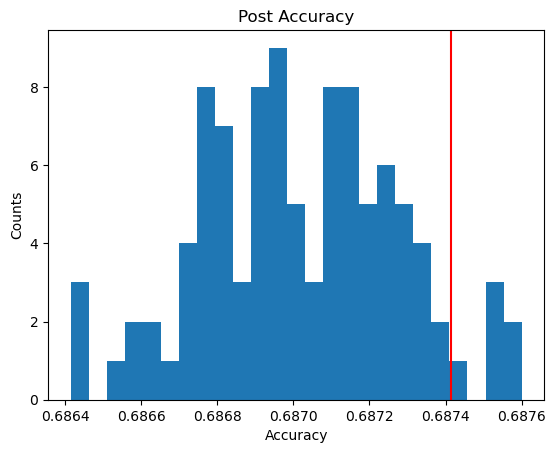

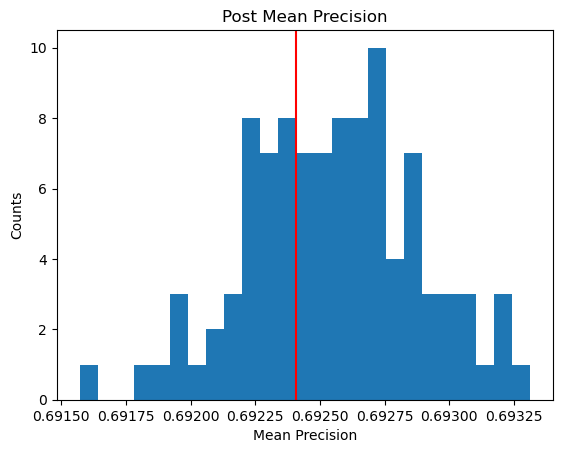

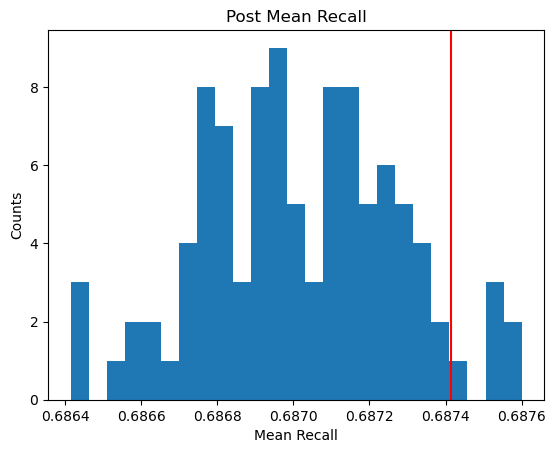

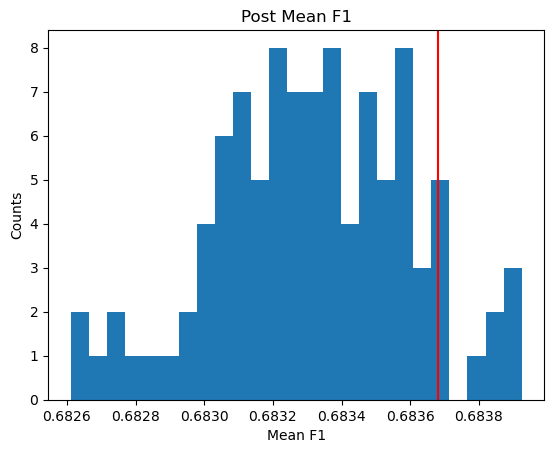

In [27]:
metrics = [['{} Accuracy', '{} Mean Precision', '{} Mean Recall', '{} Mean F1']]

summary_histogram(
    df_=df,
    metrics=metrics,
    n_bins=25)
    